<a href="https://colab.research.google.com/github/arthurnicolas59/BloodCellDec22---DataScientest/blob/Ludo/Segmentation%20et%20Cr%C3%A9ation%20de%20masques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Connexion au Drive, activation du GPU, import des images**


### **Activation du GPU**



In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please change your hardware accelerator")

Default GPU Device:/device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### **Import des images (Barcelone)**



In [ ]:
!unzip 'drive/MyDrive/Datascientest/PBC_dataset_normal_DIB.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_292483.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_935950.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_890863.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_519370.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_215077.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_388154.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_968896.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_34345.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_349907.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_245683.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_785122.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_615525.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_714613.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_904757.jpg  

In [ ]:
# suppression d'une image présentant un défaut de format :
import os

os.remove('/content/PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg')

# **2. Création du dataframe 'df' identifiant le chemin d'accès de chaque image et son label**

### **Dataframe**

In [ ]:
import glob
import pandas as pd

# Trouver tous les chemins vers les fichiers qui finissent par .jpg
liste = glob.glob('./PBC_dataset_normal_DIB/*/*.jpg')

# Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste = list(map(lambda x : [x, x.split('/')[3].split('_')[0]], liste))

# Créer un DataFrame pandas
df = pd.DataFrame(liste, columns=['filepath', 'nameLabel'])
df=df.replace(['SNE','BNE'],'NEUTROPHIL')
df=df.replace(['MY','MMY','PMY'],'IG')
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df.sort_values('filepath')
df

filepath nameLabel  label
0        ./PBC_dataset_normal_DIB/basophil/BA_463171.jpg        BA      0
1        ./PBC_dataset_normal_DIB/basophil/BA_307830.jpg        BA      0
2        ./PBC_dataset_normal_DIB/basophil/BA_317405.jpg        BA      0
3          ./PBC_dataset_normal_DIB/basophil/BA_4118.jpg        BA      0
4        ./PBC_dataset_normal_DIB/basophil/BA_310106.jpg        BA      0
...                                                  ...       ...    ...
17087  ./PBC_dataset_normal_DIB/platelet/PLATELET_220...  PLATELET      7
17088  ./PBC_dataset_normal_DIB/platelet/PLATELET_235...  PLATELET      7
17089  ./PBC_dataset_normal_DIB/platelet/PLATELET_234...  PLATELET      7
17090  ./PBC_dataset_normal_DIB/platelet/PLATELET_158...  PLATELET      7
17091  ./PBC_dataset_normal_DIB/platelet/PLATELET_896...  PLATELET      7

[17092 rows x 3 columns]

### **Information sur le dataset**

In [ ]:
# shape
df.nameLabel.unique()
df.shape

(17092, 3)

In [ ]:
# répartition du nombre d'images selon le label
df.nameLabel.value_counts()

NEUTROPHIL    3329
EO            3117
IG            2895
PLATELET      2348
ERB           1551
MO            1420
BA            1218
LY            1214
Name: nameLabel, dtype: int64

# **3. Création d'images SEGMENTEES à l'aide du modèle The Segment Anything Model (SAM)**

Méthode décrite dans ce notebook :
https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb


The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The SamPredictor class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the set_image method, which calculates the necessary image embeddings. Then, prompts can be provided via the predict method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

### **1. Configuration de l'environnement d'exécution**

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0rgg6ass
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0rgg6ass
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=f7d9d6081b4e8e7caebc217fbc48e103347a3bedb342777d35929d5e543ea672
  Stored in directory: /tmp/pip-ephem-wheel-cache-vwz5mtt9/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-07-19 11:55:19--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.15, 52.84.251.114, 5

In [ ]:
# chargement de la librairie supervision pour la visualisation
!pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
### Import des modules nécessaires pour l'ensemble du travail
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import supervision as sv
from skimage import io
from skimage import filters
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
from google.colab import drive
import os
from tqdm import tqdm
from PIL import Image
import imageio
import time

### **2. Création des fonctions permettant de visualiser la zone d'intérêt de l'image pour la segmentation**

In [ ]:
# affichage de la boxe délimitant la zone de recherche

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# affichage d'un point d'intérêt dans la boxe délimitant la zone de recherche

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

# affichage du masque

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

### **3. Chargement du modèle et du prédicteur**

In [ ]:
# chargement du modèle
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

### **4. Application du modèle sur le dataset d'images**

Création d'un dossier local "masques" et des 8 sous-dossiers correspondant aux groupes de cellules

In [ ]:
# Chemin du répertoire principal de Google Drive
main_dir_masques='/content/'

# Nom du sous-dossier à créer
subfolder_name = 'masques'

# Chemin complet du sous-dossier à créer
subfolder_path = os.path.join(main_dir_masques, subfolder_name)

# Vérifier si le sous-dossier existe déjà
if not os.path.exists(subfolder_path):
    # Créer le sous-dossier
    os.makedirs(subfolder_path)
    print("Le sous-dossier '{}' a été créé avec succès.".format(subfolder_name))
else:
    print("Le sous-dossier '{}' existe déjà.".format(subfolder_name))

main_dir='/content/PBC_dataset_normal_DIB'

liste_dossier=[]
for folder_idx, folder in enumerate(os.listdir(path=main_dir)):
  liste_dossier.append(folder)

print(liste_dossier)

for folder_name in liste_dossier:
  group_path=os.path.join(subfolder_path,folder_name)

  # Vérifier si le sous-dossier existe déjà
  if not os.path.exists(group_path):
    # Créer le sous-dossier
    os.makedirs(group_path)
    print("Le sous-dossier '{}' a été créé avec succès.".format(folder_name))
  else:
    print("Le sous-dossier '{}' existe déjà.".format(folder_name))

Le sous-dossier 'masques' existe déjà.
['monocyte', 'lymphocyte', 'neutrophil', 'basophil', 'erythroblast', 'platelet', 'ig', 'eosinophil']
Le sous-dossier 'monocyte' existe déjà.
Le sous-dossier 'lymphocyte' existe déjà.
Le sous-dossier 'neutrophil' existe déjà.
Le sous-dossier 'basophil' existe déjà.
Le sous-dossier 'erythroblast' existe déjà.
Le sous-dossier 'platelet' existe déjà.
Le sous-dossier 'ig' existe déjà.
Le sous-dossier 'eosinophil' existe déjà.


Génération de masques par groupe de celulles et sauvegarde dans le répertoire local "masques"

In [ ]:
# Définition des dimensions et positions des boxes et points appliqués sur chaque images pour limiter la segmentation a une partie restreinte de l'image
input_box = np.array([90, 90, 270, 270])
input_point = np.array([[180, 180]])
input_label = np.array([1]) # signifie que les pixels sélectionnés représentant le masque positif de l'image

# Copie de df
train_df=df

# Définition d'une liste contenant les différents labels
liste_label =df.nameLabel.unique()

# Parcours et écriture des masques de chaque groupe présent dans la liste "liste_label"
# Ici on prend uniquement une centaine d'images par groupe
for label in liste_label :
  MASK_DF = train_df.loc[train_df['nameLabel'] == label][400:500]
  IMAGE_PATH = np.array(MASK_DF['filepath'])

  # Création et enregistrement des masques pour chaque image

  for i in tqdm(range(len(MASK_DF))):

          # Read image
          image_bgr = cv2.imread(IMAGE_PATH[i])
          image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


##################################################
# Si on veut intégrer un prétraitement des images sur leur luminosité:
        # Resize image
        # dim = (363, 360)
        # image_rgb = cv2.resize(image_rgb, dim, interpolation=cv.INTER_LINEAR)
        # # Equalization
        # img_yuv = cv2.cvtColor(image_rgb,cv2.COLOR_BGR2YUV)
        # img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        # img_equ = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        # # Apply non-local means filter on test img
        # dst_img = cv2.fastNlMeansDenoisingColored(
        #     src=img_equ,
        #     dst=None,
        #     h=10,
        #     hColor=10,
        #     templateWindowSize=7,
        #     searchWindowSize=21)
##################################################

          start_time = time.time()
          predictor.set_image(image_rgb)
          end_time = time.time()
          set_image_time = end_time - start_time
          print("Temps pris par predictor.set_image() :", set_image_time, "secondes")
          start_time = time.time()
          masque, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box,
            multimask_output=False,
            )

          # Chemin du dossier où vous souhaitez enregistrer l'image
          output_folder = '/content/masques/' + IMAGE_PATH[i].split('/')[2]


          # Nom du fichier de sortie
          output_filename = str(MASK_DF['filepath'].iloc[i]).split('/')[3].split('.')[0]+'_mask.png'

          # Chemin complet du fichier de sortie
          output_path = output_folder+'/'+output_filename

          mask_image = np.uint8(masque[0] * 255)

          # Save the mask image
          cv2.imwrite(output_path, mask_image)

          # Enregistrez l'image dans le fichier PNG
          print('L\'image n°', i, 'a été enregistrée sous :', output_path)

 50%|█████     | 1/2 [00:02<00:02,  2.05s/it]

Temps pris par predictor.set_image() : 1.9466114044189453 secondes
L'image n° 0 a été enregistrée sous : /content/masques/basophil/BA_785668_mask.png


100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


Temps pris par predictor.set_image() : 1.938373327255249 secondes
L'image n° 1 a été enregistrée sous : /content/masques/basophil/BA_598745_mask.png


 50%|█████     | 1/2 [00:02<00:02,  2.04s/it]

Temps pris par predictor.set_image() : 1.9507510662078857 secondes
L'image n° 0 a été enregistrée sous : /content/masques/basophil/BA_785668_mask.png


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Temps pris par predictor.set_image() : 1.9621121883392334 secondes
L'image n° 1 a été enregistrée sous : /content/masques/basophil/BA_598745_mask.png


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Temps pris par predictor.set_image() : 1.9781925678253174 secondes
L'image n° 0 a été enregistrée sous : /content/masques/basophil/BA_785668_mask.png


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


Temps pris par predictor.set_image() : 1.9858205318450928 secondes
L'image n° 1 a été enregistrée sous : /content/masques/basophil/BA_598745_mask.png


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Temps pris par predictor.set_image() : 1.9994802474975586 secondes
L'image n° 0 a été enregistrée sous : /content/masques/basophil/BA_785668_mask.png


100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


Temps pris par predictor.set_image() : 2.011812448501587 secondes
L'image n° 1 a été enregistrée sous : /content/masques/basophil/BA_598745_mask.png


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Temps pris par predictor.set_image() : 2.01924991607666 secondes
L'image n° 0 a été enregistrée sous : /content/masques/basophil/BA_785668_mask.png


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


Temps pris par predictor.set_image() : 2.027761220932007 secondes
L'image n° 1 a été enregistrée sous : /content/masques/basophil/BA_598745_mask.png


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Temps pris par predictor.set_image() : 2.0218312740325928 secondes
L'image n° 0 a été enregistrée sous : /content/masques/basophil/BA_785668_mask.png


100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


Temps pris par predictor.set_image() : 2.009896755218506 secondes
L'image n° 1 a été enregistrée sous : /content/masques/basophil/BA_598745_mask.png


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Temps pris par predictor.set_image() : 1.9834160804748535 secondes
L'image n° 0 a été enregistrée sous : /content/masques/basophil/BA_785668_mask.png


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


Temps pris par predictor.set_image() : 1.9885985851287842 secondes
L'image n° 1 a été enregistrée sous : /content/masques/basophil/BA_598745_mask.png


 50%|█████     | 1/2 [00:02<00:02,  2.06s/it]

Temps pris par predictor.set_image() : 1.9761207103729248 secondes
L'image n° 0 a été enregistrée sous : /content/masques/basophil/BA_785668_mask.png


100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

Temps pris par predictor.set_image() : 1.9633045196533203 secondes
L'image n° 1 a été enregistrée sous : /content/masques/basophil/BA_598745_mask.png


# **4. Création du dataframe 'df_mask' présentant le chemin d'accès des images segmentées issues du modèle SAM et des images sources correspondantes**

### **Dataframe**

In [ ]:
# Trouver tous les chemins vers les fichiers qui finissent par .jpg
liste_mask = glob.glob('/content/masques/*/*.png')

# # Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste_mask = list(map(lambda x : [x,
                                  x.split('/')[4].split('_')[0],
                                  '/content/PBC_dataset_normal_DIB/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'.jpg'],
                       liste_mask))

# Créer un DataFrame pandas
df_mask = pd.DataFrame(liste_mask, columns=['maskpath', 'nameLabel','filepath'])
df_mask=df_mask.replace(['SNE','BNE'],'NEUTROPHIL')
df_mask=df_mask.replace(['MY','MMY','PMY'],'IG')
df_mask['label'] = df['nameLabel'].replace(df_mask.nameLabel.unique(), [*range(len(df_mask.nameLabel.unique()))])
df_mask.sort_values('maskpath')
df_mask

maskpath nameLabel  \
0          /content/masques/basophil/BA_462792_mask.png        BA   
1           /content/masques/basophil/BA_85940_mask.png        BA   
2          /content/masques/basophil/BA_245418_mask.png        BA   
3          /content/masques/basophil/BA_736344_mask.png        BA   
4          /content/masques/basophil/BA_271614_mask.png        BA   
...                                                 ...       ...   
4497  /content/masques/platelet/PLATELET_188467_mask...  PLATELET   
4498  /content/masques/platelet/PLATELET_938834_mask...  PLATELET   
4499  /content/masques/platelet/PLATELET_962630_mask...  PLATELET   
4500  /content/masques/platelet/PLATELET_220047_mask...  PLATELET   
4501  /content/masques/platelet/PLATELET_485297_mask...  PLATELET   

                                               filepath  label  
0     /content/PBC_dataset_normal_DIB/basophil/BA_46...      0  
1     /content/PBC_dataset_normal_DIB/basophil/BA_85...      0  
2     /content/PBC_dataset_normal_DIB/basophil/BA_24...      0  
3     /content/PBC_dataset_normal_DIB/basophil/BA_73...      0  
4     /content/PBC_dataset_normal_DIB/basophil/BA_27...      0  
...                                                 ...    ...  
4497  /content/PBC_dataset_normal_DIB/platelet/PLATE...      1  
4498  /content/PBC_dataset_normal_DIB/platelet/PLATE...      1  
4499  /content/PBC_dataset_normal_DIB/platelet/PLATE...      1  
4500  /content/PBC_dataset_normal_DIB/platelet/PLATE...      1  
4501  /content/PBC_dataset_normal_DIB/platelet/PLATE...      1  

[4502 rows x 4 columns]

### **Information sur le dataset des 4502 images segmentées**

In [ ]:
# répartition du nombre d'images selon le label dans le dataframe df_mask
df_mask.nameLabel.value_counts()

BA            756
MO            721
LY            688
ERB           503
PLATELET      499
EO            455
NEUTROPHIL    443
IG            437
Name: nameLabel, dtype: int64

# **5. Création d'un dataframe 'df_img_sans_masque' comprenant l'ensemble des images originales qui n'ont pas été segmentées par le modèle SAM.**



In [ ]:
# copie de df_mask et de df
df_mask2=df_mask
df2=df

In [ ]:
# modification de la variable 'filepath' de df2 pour qu'elle corresponde exactement à celle de df_mask2
df2['filepath']='/content'+df['filepath'].str[1:]

In [ ]:
# Concaténation des dataframe df_mask2 et df2
union=pd.concat([df_mask2,df2],axis=0)

In [ ]:
# Suppression des doublons repérés dans la colonne filepath, supprimant ainsi les lignes de df2 qui ont fait l'objet de la création d'une segmentation et que l'on retrouve dans df_mask2
union.drop_duplicates(subset=['filepath'],inplace=True)

In [ ]:
# Remplacement des valeurs nulles du nouveau dataframe, qui correspondent aux images qui n'ont pas été segmentées. Création d'un nouveau dataframe
union2 = union.fillna('key')

In [ ]:
# Création du dataframe final, comprenant uniquement les chemins des d'accès des images n'ayant pas été segmentées
df_img_sans_masque=union2.loc[union2['maskpath']=='key']

In [ ]:
# Affichage de ce nouveau dataframe
df_img_sans_masque

maskpath   nameLabel                                           filepath  \
0          key  NEUTROPHIL  /content/PBC_dataset_normal_DIB/neutrophil/BNE...   
1          key  NEUTROPHIL  /content/PBC_dataset_normal_DIB/neutrophil/SNE...   
2          key  NEUTROPHIL  /content/PBC_dataset_normal_DIB/neutrophil/BNE...   
3          key  NEUTROPHIL  /content/PBC_dataset_normal_DIB/neutrophil/SNE...   
4          key  NEUTROPHIL  /content/PBC_dataset_normal_DIB/neutrophil/SNE...   
...        ...         ...                                                ...   
17083      key          LY  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...   
17084      key          LY  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...   
17085      key          LY  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...   
17087      key          LY  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...   
17091      key          LY  /content/PBC_dataset_normal_DIB/lymphocyte/LY_...   

       label  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
17083      7  
17084      7  
17085      7  
17087      7  
17091      7  

[12590 rows x 4 columns]

# **6. Création de MASQUES en utilisant le modèle Unet**

## **6.1. Principe de la segmentation**

La segmentation consiste à déterminer où se trouve l'objet d'intérêt dans l'image et de supprimer l'arrière plan.

Une méthode possible est l'utilisation d'un masque. Un masque est une image contenant seulement deux valeurs pour chaque pixel : 0 ou 1.
Un pixel avec la valeur 1 est un pixel de l'objet à segmenter. Sinon le pixel correspond à l'arrière-plan et prend la valeur 0.
On obtient ainsi une image en noir et blanc avec en blanc l'espace correspondant à l'objet.

Le modèle développé va prendre en entrée une image de feuille et renverra un masque de cette feuille.

## **6.2. Préparation des images et des masques issues de la Segmentation SAM**

### 6.2.1. Import des images segmentées à l'aide du modèle de segmentation SAM

In [ ]:
!unzip 'drive/MyDrive/Datascientest/masques-19072023.zip'

Archive:  drive/MyDrive/Datascientest/masques-19072023.zip
  inflating: masques/eosinophil/EO_197212_mask.png  
  inflating: masques/eosinophil/EO_424918_mask.png  
  inflating: masques/eosinophil/EO_406215_mask.png  
  inflating: masques/eosinophil/EO_209028_mask.png  
  inflating: masques/eosinophil/EO_324141_mask.png  
  inflating: masques/eosinophil/EO_351942_mask.png  
  inflating: masques/eosinophil/EO_578965_mask.png  
  inflating: masques/eosinophil/EO_841216_mask.png  
  inflating: masques/eosinophil/EO_910_mask.png  
  inflating: masques/eosinophil/EO_485946_mask.png  
  inflating: masques/eosinophil/EO_989530_mask.png  
  inflating: masques/eosinophil/EO_345129_mask.png  
  inflating: masques/eosinophil/EO_661288_mask.png  
  inflating: masques/eosinophil/EO_220964_mask.png  
  inflating: masques/eosinophil/EO_666039_mask.png  
  inflating: masques/lymphocyte/LY_35661_mask.png  
  inflating: masques/eosinophil/EO_872946_mask.png  
  inflating: masques/eosinophil/EO_726217_ma

### 6.2.2. Transformation des images segmentées par le modèle SAM en masques, exploitables par le Modèle UNET.

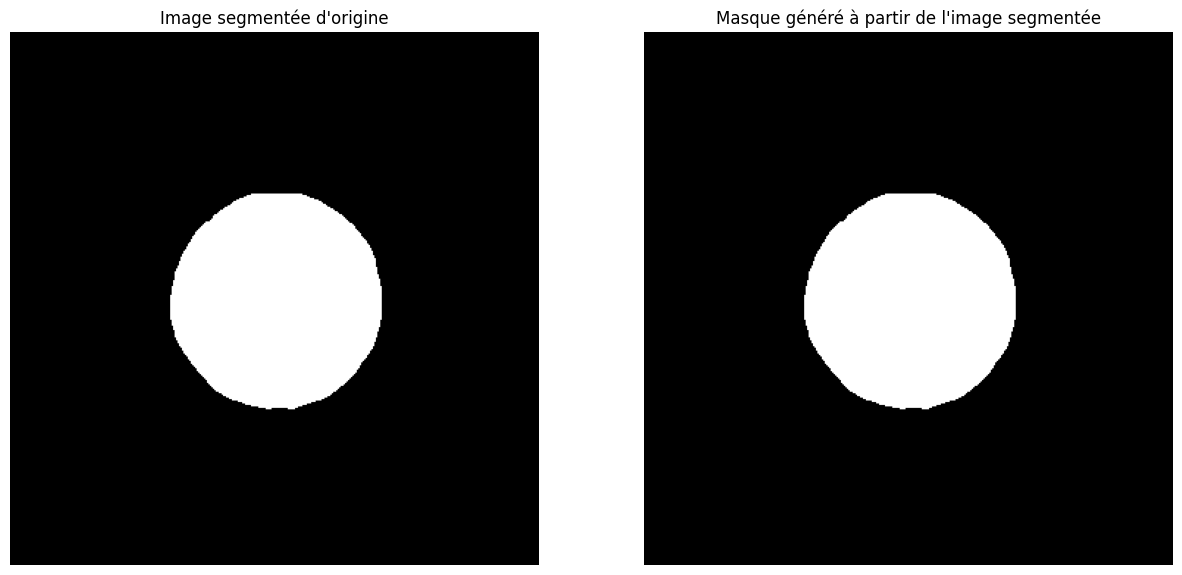

In [ ]:
### Génération de masques à partir des images segmentées du jeu de données

### Premièrement, on récupère les chemins des dossiers contenant les images

path_folders=glob.glob('/content/masques/**')

### Affichage d'un exemple d'image segmentée

path_example= glob.glob(path_folders[0]+'/**')[0]
plt.figure(figsize=(15,7))
plt.subplot(121)
example=cv2.imread(path_example)
plt.imshow(example)
plt.title("Image segmentée d'origine")
plt.axis('off')

### Transformation des images segmentées en masques

threshold=20
for path in path_folders:
  for fichier in glob.glob(path+'/**'):
      img=cv2.imread(fichier)
      if len(img.shape)==3:

        ### La moyenne des pixels RGB est calculée et un seuil est défini pour séparer les pixels
        ### de la feuille et le reste.
        ### La valeur de 1 est attribué pour un pixel de la feuille, le pixel prend la valeur 0 sinon.

          img_mask=(img.mean(axis=2)>threshold).astype(int)
          cv2.imwrite(fichier,img_mask)

### Exemple de masque produit

plt.subplot(122)
example=cv2.imread(path_example,cv2.IMREAD_GRAYSCALE)
plt.imshow(example*255,cmap='gray')
plt.title("Masque généré à partir de l'image segmentée")
plt.axis('off');

Les jeux de données d'entraînement, de validation et de test sont générés à partir du DataFrame créer.
Les données seront chargées au fur et à mesure de l'entrainement du modèle par une fonction définie ci-dessous.

Pour l'entrainement du modèle, les features correspondent aux images et les valeurs à prédire (les labels) sont les masques correspondants.


## **6.3. Instanciation du modèle UNET générateur de masques**

Premièrement, il est nécessaire de créer l'architecture du modèle.

In [ ]:
### Import des modules nécessaires pour l'ensemble du travail

import numpy as np
import os
import glob
import cv2
from keras import callbacks
import pandas as pd
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [ ]:
### Définition d'une fonction de perte : Coefficient de Dice
def LossDice(y_true, y_pred):
  numerateur  =tf.reduce_sum(y_true*y_pred, axis=(1, 2))
  denominateur=tf.reduce_sum(y_true+y_pred, axis=(1, 2))
  dice=2*numerateur/(denominateur+1E-4)
  return 1-dice

In [ ]:
### Définition de la structure du modèle avec ses différentes couches

def unet(pretrained_weights = None, input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=2)(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    ### Compilation du modèle avec la fonction de perte 'loss dice' et la métrique 'accuracy'
    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(1e-3), loss=LossDice,
                  metrics=['accuracy'])

    model.summary()

    ### Si le modèle a précédemment été entrainé, les poids sauvegardés sont chargés
    if (pretrained_weights):
      model.load_weights(pretrained_weights)
    if (pretrained_weights):
      print("\nLe modèle a été instancié avec les poids chargés.")

    return model

In [ ]:
### Chargement de poids sauvegardés s'ils existent
export_dir='/content/drive/MyDrive/'
pretrained_weights = None
if os.path.exists(export_dir+'weights.h5'):
  pretrained_weights = export_dir+'weights.h5'

### Instanciation d'un modèle
unet=unet(input_size=(256,256,3), pretrained_weights=pretrained_weights)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

## **6.4. Entraînement du Modèle UNET générateur de masques**

In [ ]:
### Création du jeu d'entrainement, de validation et de test
### La fonction définie au dessus est utilisée pour charger les images et
### masques au fur et à mesure de l'entrainement

X_train_path, X_test_path, y_train_path, y_test_path = train_test_split(df_mask.filepath,df_mask.maskpath,test_size=0.2, random_state=456)
X_train_path, X_val_path, y_train_path, y_val_path = train_test_split(X_train_path, y_train_path, test_size=0.2, random_state=456)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path,y_train_path))
dataset_train = dataset_train.map(lambda x, y : [load_image(x),load_mask(y)], num_parallel_calls=-1).batch(1)

dataset_val = tf.data.Dataset.from_tensor_slices((X_val_path,y_val_path))
dataset_val = dataset_val.map(lambda x, y : [load_image(x),load_mask(y)], num_parallel_calls=-1).batch(1)

dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path,y_test_path))
dataset_test = dataset_test.map(lambda x, y : [load_image(x),load_mask(y)], num_parallel_calls=-1).batch(1)



In [ ]:
### Définition de fonctions de chargement et transformation
### des images ou masques à partir des chemins

import tensorflow as tf
def load_image(filepath,resize=(256,256)):
    # Charger l'information brute en mémoire
    im = tf.io.read_file(filepath)
    # Décoder l'information en un tensorflow RGB (3 channels).
    im = tf.io.decode_jpeg(im, channels=3)
    #Redimensionner l'image
    return tf.image.resize(im, size=resize)

def load_mask(filepath,resize=(256,256)):
    im = tf.io.read_file(filepath)
    ### Dans le cas des masques, l'image est en noir et blanc, il n'y a donc qu'une valeur par pixel
    im = tf.io.decode_jpeg(im, channels=1)
    return tf.image.resize(im, size=resize)

In [ ]:
### Définition de callbacks et entrainement du modèle

### Sauvegarde automatique des poids
checkpoint = callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/weights.h5',
                                       monitor = 'loss',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'min',
                                       save_freq = 'epoch')

### 'Callback' permettant d'ajuster le taux d'apprentissage au cours de l'entrainement
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'loss',
                                         patience=1,
                                         factor=0.1,
                                         verbose=2,
                                         mode='min')

training=unet.fit(dataset_train, epochs=3, validation_data=dataset_val, callbacks = [lr_plateau, checkpoint])

Epoch 1/3
2880/2880 [==============================] - 90s 29ms/step - loss: 0.1051 - accuracy: 0.9774 - val_loss: 0.1274 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 2/3
2879/2880 [============================>.] - ETA: 0s - loss: 0.1053 - accuracy: 0.9782
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2880/2880 [==============================] - 84s 29ms/step - loss: 0.1053 - accuracy: 0.9782 - val_loss: 0.1124 - val_accuracy: 0.9784 - lr: 0.0010
Epoch 3/3
2880/2880 [==============================] - 84s 29ms/step - loss: 0.1013 - accuracy: 0.9793 - val_loss: 0.0999 - val_accuracy: 0.9793 - lr: 1.0000e-04


In [ ]:
### Sauvegarde des poids et du modèle entrainé
unet.save_weights(export_dir+'weights.h5')
unet.save(export_dir+'model.h5')

## **6.5. Evaluation de la précision du modèle UNET et réalisation d'essais sur de nouvelles images**

Le modèle est évalué sur le jeu de donnée de test et des images d'un autre jeu de données vont être chargées pour pouvoir tester la segmentation générée.

In [ ]:
### Evaluation de la précision du modèle sur le jeu de test
evaluation=unet.evaluate(dataset_test)
print('Précision du modèle sur le jeu de test :',np.round(evaluation[1],2),"\n",
      'Perte du modèle sur le jeu de test :',np.round(evaluation[0],2))

901/901 [==============================] - 8s 9ms/step - loss: 0.0969 - accuracy: 0.9796
Précision du modèle sur le jeu de test : 0.98 
 Perte du modèle sur le jeu de test : 0.1


1/1 [==============================] - 0s 25ms/step


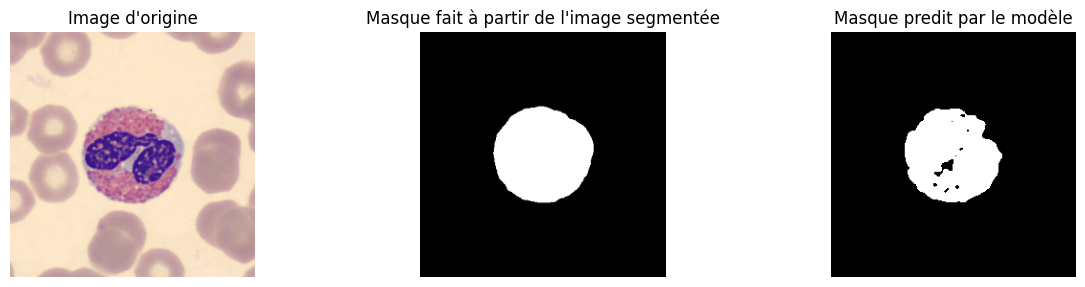

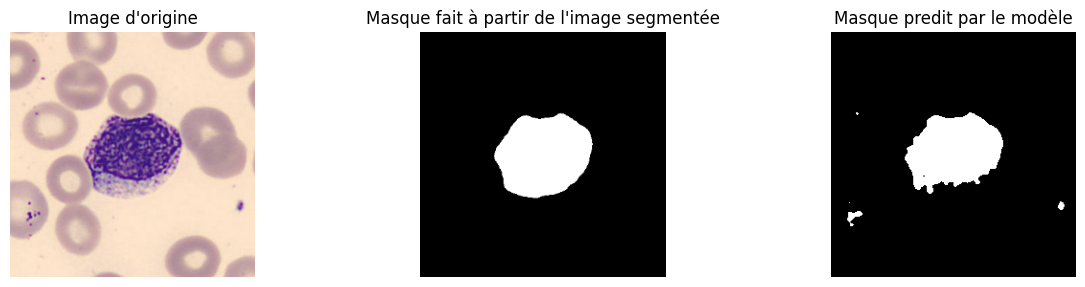

In [ ]:
### Démonstration d'une prédiction de masque en comparaison avec un masque
### fait à partir de l'image segmentée du jeu de donnée Test

size=2
indexes=np.random.choice(np.array(X_test_path.index),size=2)

i=0
for idx in indexes:
  image=load_image(X_test_path[idx])
  img=tf.reshape(image,(1,256,256,3))
  mask_pred=unet.predict(img)
  mask_true=load_mask(y_test_path[idx])
  image=tf.cast(image,dtype=tf.int32)

  plt.figure(figsize=(15,7))

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(image)
  plt.axis("off")
  plt.title("Image d'origine")

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(tf.reshape(mask_true,(256,256)),cmap='gray')
  plt.axis("off")
  plt.title("Masque fait à partir de l'image segmentée")

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(tf.reshape(mask_pred,(256,256)),cmap='gray')
  plt.axis("off")
  plt.title("Masque predit par le modèle")

### Affichage de quelques masques créés

In [ ]:
### On récupère les chemins des images à segmenter compiler dans le dataframe 'df_img_sans_masque'

path_images=df_img_sans_masque['filepath']


In [ ]:
### Chargement éventuel d'un modèle enregistré
custom_objects = {'LossDice': LossDice}
if os.path.exists(export_dir+'model.h5'):
  saved_unet= tf.keras.models.load_model(export_dir+'model.h5', custom_objects=custom_objects)

1/1 [==============================] - 7s 7s/step


(-0.5, 255.5, 255.5, -0.5)

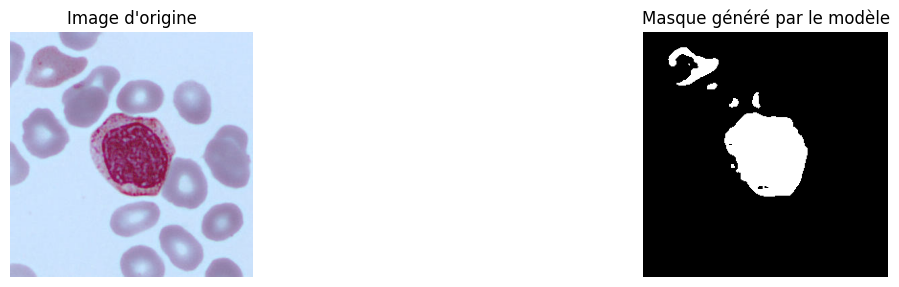

In [ ]:
### Une image est choisie au hasard et la segmentation est appliquée

chiffre=np.random.choice(range(len(path_images)),size=1)[0]
im=cv2.imread(df_img_sans_masque['filepath'][chiffre])
mask=load_image(df_img_sans_masque['filepath'][chiffre])
masks=tf.reshape(mask,(1,256,256,3))
pred=saved_unet.predict(masks)


# plt.imshow(tf.reshape(mask,(256,256)),cmap='gray')

plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.imshow(im)
plt.title("Image d'origine")
plt.axis('off')

plt.subplot(222)
plt.imshow(pred[0, :, :, 0], cmap='gray')
plt.title("Masque généré par le modèle")
plt.axis('off')

## **6.5. Création des 12590 masques restants par prédiction, à l'aide du modèle UNET**

In [ ]:
from tqdm import tqdm
import numpy as np
import os
import cv2
from PIL import Image
import imageio
from skimage import filters
import time

train_df_img_sans_masque=df_img_sans_masque
# Définition d'une liste contenant les différents labels
liste_label =df_img_sans_masque.nameLabel.unique()

# Parcours et écriture des masques de chaque groupe présent dans la liste "liste_label"
# Ici on prend uniquement une centaine d'images par groupe
for label in liste_label :
  MASK_DF = train_df_img_sans_masque.loc[train_df_img_sans_masque['nameLabel'] == label]
  IMAGE_PATH = np.array(MASK_DF['filepath'])

  # Création et enregistrement des masques pour chaque image

  for i in tqdm(range(len(MASK_DF))):

          # Read image

          im=cv2.imread(IMAGE_PATH[i])
          mask=load_image(IMAGE_PATH[i])
          masks=tf.reshape(mask,(1,256,256,3))
          pred=saved_unet.predict(masks)

          # Chemin du dossier où vous souhaitez enregistrer l'image
          output_folder = '/content/masques/' + IMAGE_PATH[i].split('/')[3]

          # Nom du fichier de sortie
          output_filename = str(MASK_DF['filepath'].iloc[i]).split('/')[4].split('.')[0]+'_mask.png'

          # Chemin complet du fichier de sortie
          output_path = output_folder+'/'+output_filename

          threshold = 0.5  # Adjust the threshold as needed based on your model's output
          pred_binary = (pred[0, :, :, 0] > threshold).astype(int)

          # Save the mask image
          cv2.imwrite(output_path, pred_binary)

          # Enregistrez l'image dans le fichier PNG
          print('L\'image n°', i, 'a été enregistrée sous :', output_path)

  0%|          | 0/2886 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
L'image n° 0 a été enregistrée sous : /content/masques/neutrophil/BNE_347275_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 2/2886 [00:00<03:17, 14.59it/s]

L'image n° 1 a été enregistrée sous : /content/masques/neutrophil/SNE_350843_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2 a été enregistrée sous : /content/masques/neutrophil/BNE_726027_mask.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 4/2886 [00:00<03:12, 14.99it/s]

L'image n° 3 a été enregistrée sous : /content/masques/neutrophil/SNE_265901_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 4 a été enregistrée sous : /content/masques/neutrophil/SNE_508392_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 6/2886 [00:00<03:11, 15.03it/s]

L'image n° 5 a été enregistrée sous : /content/masques/neutrophil/SNE_95665_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 6 a été enregistrée sous : /content/masques/neutrophil/SNE_310817_mask.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 8/2886 [00:00<03:09, 15.17it/s]

L'image n° 7 a été enregistrée sous : /content/masques/neutrophil/BNE_734929_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 8 a été enregistrée sous : /content/masques/neutrophil/SNE_747458_mask.png
1/1 [==============================] - 0s 18ms/step


  0%|          | 10/2886 [00:00<03:09, 15.16it/s]

L'image n° 9 a été enregistrée sous : /content/masques/neutrophil/BNE_389826_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 10 a été enregistrée sous : /content/masques/neutrophil/SNE_497060_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 11 a été enregistrée sous : /content/masques/neutrophil/BNE_204774_mask.png

  0%|          | 12/2886 [00:00<03:09, 15.15it/s]


1/1 [==============================] - 0s 18ms/step
L'image n° 12 a été enregistrée sous : /content/masques/neutrophil/BNE_631496_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 14/2886 [00:00<03:06, 15.43it/s]

L'image n° 13 a été enregistrée sous : /content/masques/neutrophil/SNE_538680_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 14 a été enregistrée sous : /content/masques/neutrophil/SNE_576927_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|          | 16/2886 [00:01<03:03, 15.63it/s]

L'image n° 15 a été enregistrée sous : /content/masques/neutrophil/BNE_944885_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 16 a été enregistrée sous : /content/masques/neutrophil/BNE_29625_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|          | 18/2886 [00:01<03:03, 15.65it/s]

L'image n° 17 a été enregistrée sous : /content/masques/neutrophil/BNE_756237_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 18 a été enregistrée sous : /content/masques/neutrophil/BNE_839288_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|          | 20/2886 [00:01<03:04, 15.53it/s]

L'image n° 19 a été enregistrée sous : /content/masques/neutrophil/BNE_942595_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 20 a été enregistrée sous : /content/masques/neutrophil/SNE_219712_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|          | 22/2886 [00:01<03:03, 15.58it/s]

L'image n° 21 a été enregistrée sous : /content/masques/neutrophil/SNE_942061_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 22 a été enregistrée sous : /content/masques/neutrophil/SNE_158445_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 23

  1%|          | 24/2886 [00:01<03:04, 15.55it/s]

 a été enregistrée sous : /content/masques/neutrophil/BNE_355910_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 24 a été enregistrée sous : /content/masques/neutrophil/SNE_897716_mask.png
1/1 [==============================] - 0s 17ms/step


  1%|          | 26/2886 [00:01<03:02, 15.67it/s]

L'image n° 25 a été enregistrée sous : /content/masques/neutrophil/BNE_320789_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 26 a été enregistrée sous : /content/masques/neutrophil/BNE_480971_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 28/2886 [00:01<03:06, 15.35it/s]

L'image n° 27 a été enregistrée sous : /content/masques/neutrophil/SNE_621008_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 28 a été enregistrée sous : /content/masques/neutrophil/BNE_399544_mask.png
1/1 [==============================] - 0s 22ms/step


  1%|          | 30/2886 [00:01<03:06, 15.33it/s]

L'image n° 29 a été enregistrée sous : /content/masques/neutrophil/SNE_507816_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 30 a été enregistrée sous : /content/masques/neutrophil/SNE_465051_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|          | 32/2886 [00:02<03:05, 15.36it/s]

L'image n° 31 a été enregistrée sous : /content/masques/neutrophil/SNE_898346_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 32 a été enregistrée sous : /content/masques/neutrophil/BNE_592877_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 34/2886 [00:02<03:06, 15.33it/s]

L'image n° 33 a été enregistrée sous : /content/masques/neutrophil/SNE_215853_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 34 a été enregistrée sous : /content/masques/neutrophil/SNE_898586_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|          | 36/2886 [00:02<03:06, 15.31it/s]

L'image n° 35 a été enregistrée sous : /content/masques/neutrophil/BNE_317666_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 36 a été enregistrée sous : /content/masques/neutrophil/SNE_756098_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 38/2886 [00:02<03:05, 15.32it/s]

L'image n° 37 a été enregistrée sous : /content/masques/neutrophil/SNE_591522_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 38 a été enregistrée sous : /content/masques/neutrophil/SNE_34243_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 40/2886 [00:02<03:07, 15.16it/s]

L'image n° 39 a été enregistrée sous : /content/masques/neutrophil/SNE_305469_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 40 a été enregistrée sous : /content/masques/neutrophil/SNE_387274_mask.png
1/1 [==============================] - 0s 18ms/step


  1%|▏         | 42/2886 [00:02<03:05, 15.37it/s]

L'image n° 41 a été enregistrée sous : /content/masques/neutrophil/BNE_831588_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 42 a été enregistrée sous : /content/masques/neutrophil/SNE_899857_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 44/2886 [00:02<03:03, 15.45it/s]

L'image n° 43 a été enregistrée sous : /content/masques/neutrophil/BNE_357413_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 44 a été enregistrée sous : /content/masques/neutrophil/SNE_560191_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 46/2886 [00:02<03:04, 15.38it/s]

L'image n° 45 a été enregistrée sous : /content/masques/neutrophil/BNE_640458_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 46 a été enregistrée sous : /content/masques/neutrophil/BNE_599061_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 48/2886 [00:03<03:03, 15.45it/s]

L'image n° 47 a été enregistrée sous : /content/masques/neutrophil/SNE_118348_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 48 a été enregistrée sous : /content/masques/neutrophil/SNE_896961_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 50/2886 [00:03<03:03, 15.45it/s]

L'image n° 49 a été enregistrée sous : /content/masques/neutrophil/SNE_231925_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 50 a été enregistrée sous : /content/masques/neutrophil/BNE_751844_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 52/2886 [00:03<03:04, 15.34it/s]

L'image n° 51 a été enregistrée sous : /content/masques/neutrophil/BNE_420956_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 52 a été enregistrée sous : /content/masques/neutrophil/SNE_885277_mask.png
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 54/2886 [00:03<03:11, 14.81it/s]

L'image n° 53 a été enregistrée sous : /content/masques/neutrophil/BNE_53394_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 54 a été enregistrée sous : /content/masques/neutrophil/SNE_599555_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 56/2886 [00:03<03:10, 14.86it/s]

L'image n° 55 a été enregistrée sous : /content/masques/neutrophil/BNE_434568_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 56 a été enregistrée sous : /content/masques/neutrophil/SNE_115658_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 58/2886 [00:03<03:05, 15.21it/s]

L'image n° 57 a été enregistrée sous : /content/masques/neutrophil/SNE_310624_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 58 a été enregistrée sous : /content/masques/neutrophil/SNE_922279_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 60/2886 [00:03<03:06, 15.19it/s]

L'image n° 59 a été enregistrée sous : /content/masques/neutrophil/BNE_14932_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 60 a été enregistrée sous : /content/masques/neutrophil/BNE_955098_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 62/2886 [00:04<03:05, 15.22it/s]

L'image n° 61 a été enregistrée sous : /content/masques/neutrophil/BNE_186566_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 62 a été enregistrée sous : /content/masques/neutrophil/BNE_239636_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 64/2886 [00:04<03:07, 15.07it/s]

L'image n° 63 a été enregistrée sous : /content/masques/neutrophil/BNE_952597_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 64 a été enregistrée sous : /content/masques/neutrophil/SNE_297935_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 66/2886 [00:04<03:05, 15.21it/s]

L'image n° 65 a été enregistrée sous : /content/masques/neutrophil/BNE_844957_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 66 a été enregistrée sous : /content/masques/neutrophil/BNE_379425_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 68/2886 [00:04<03:06, 15.08it/s]

L'image n° 67 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_993818_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 68 a été enregistrée sous : /content/masques/neutrophil/SNE_710179_mask.png
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 70/2886 [00:04<03:03, 15.31it/s]

L'image n° 69 a été enregistrée sous : /content/masques/neutrophil/BNE_112967_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 70 a été enregistrée sous : /content/masques/neutrophil/BNE_860699_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 72/2886 [00:04<03:17, 14.25it/s]

L'image n° 71 a été enregistrée sous : /content/masques/neutrophil/SNE_166616_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 72 a été enregistrée sous : /content/masques/neutrophil/BNE_613105_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 74/2886 [00:04<03:15, 14.35it/s]

L'image n° 73 a été enregistrée sous : /content/masques/neutrophil/SNE_185225_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 74 a été enregistrée sous : /content/masques/neutrophil/SNE_124356_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 76/2886 [00:05<03:15, 14.34it/s]

L'image n° 75 a été enregistrée sous : /content/masques/neutrophil/BNE_279206_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 76 a été enregistrée sous : /content/masques/neutrophil/SNE_338242_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 78/2886 [00:05<03:11, 14.69it/s]

L'image n° 77 a été enregistrée sous : /content/masques/neutrophil/SNE_610007_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 78 a été enregistrée sous : /content/masques/neutrophil/BNE_862425_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 80/2886 [00:05<03:18, 14.12it/s]

L'image n° 79 a été enregistrée sous : /content/masques/neutrophil/BNE_224912_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 80 a été enregistrée sous : /content/masques/neutrophil/SNE_671189_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 82/2886 [00:05<03:17, 14.19it/s]

L'image n° 81 a été enregistrée sous : /content/masques/neutrophil/BNE_641093_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 82 a été enregistrée sous : /content/masques/neutrophil/SNE_462447_mask.png
1/1 [==============================] - 0s 18ms/step


  3%|▎         | 84/2886 [00:05<03:15, 14.31it/s]

L'image n° 83 a été enregistrée sous : /content/masques/neutrophil/BNE_993339_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 84 a été enregistrée sous : /content/masques/neutrophil/BNE_710107_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 86/2886 [00:05<03:13, 14.45it/s]

L'image n° 85 a été enregistrée sous : /content/masques/neutrophil/SNE_770314_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 86 a été enregistrée sous : /content/masques/neutrophil/SNE_128810_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 88/2886 [00:05<03:12, 14.50it/s]

L'image n° 87 a été enregistrée sous : /content/masques/neutrophil/BNE_453088_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 88 a été enregistrée sous : /content/masques/neutrophil/SNE_6105_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 90/2886 [00:05<03:13, 14.48it/s]

L'image n° 89 a été enregistrée sous : /content/masques/neutrophil/BNE_809009_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 90 a été enregistrée sous : /content/masques/neutrophil/BNE_377951_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 92/2886 [00:06<03:09, 14.76it/s]

L'image n° 91 a été enregistrée sous : /content/masques/neutrophil/SNE_545367_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 92 a été enregistrée sous : /content/masques/neutrophil/BNE_98051_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 94/2886 [00:06<03:11, 14.56it/s]

L'image n° 93 a été enregistrée sous : /content/masques/neutrophil/SNE_702329_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 94 a été enregistrée sous : /content/masques/neutrophil/BNE_415744_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 96/2886 [00:06<03:12, 14.50it/s]

L'image n° 95 a été enregistrée sous : /content/masques/neutrophil/SNE_472584_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 96 a été enregistrée sous : /content/masques/neutrophil/SNE_61066_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 98/2886 [00:06<03:06, 14.93it/s]

L'image n° 97 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_435447_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 98 a été enregistrée sous : /content/masques/neutrophil/SNE_145546_mask.png
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 100/2886 [00:06<03:12, 14.50it/s]

L'image n° 99 a été enregistrée sous : /content/masques/neutrophil/SNE_73239_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 100 a été enregistrée sous : /content/masques/neutrophil/BNE_960075_mask.png
1/1 [==============================] - 0s 22ms/step


  4%|▎         | 102/2886 [00:06<03:10, 14.58it/s]

L'image n° 101 a été enregistrée sous : /content/masques/neutrophil/BNE_789788_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 102 a été enregistrée sous : /content/masques/neutrophil/BNE_209954_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▎         | 104/2886 [00:06<03:17, 14.10it/s]

L'image n° 103 a été enregistrée sous : /content/masques/neutrophil/SNE_4845_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 104 a été enregistrée sous : /content/masques/neutrophil/BNE_181624_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▎         | 106/2886 [00:07<03:14, 14.33it/s]

L'image n° 105 a été enregistrée sous : /content/masques/neutrophil/BNE_175829_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 106 a été enregistrée sous : /content/masques/neutrophil/SNE_66862_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 108/2886 [00:07<03:12, 14.43it/s]

L'image n° 107 a été enregistrée sous : /content/masques/neutrophil/SNE_508478_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 108 a été enregistrée sous : /content/masques/neutrophil/BNE_890664_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 110/2886 [00:07<03:07, 14.81it/s]

L'image n° 109 a été enregistrée sous : /content/masques/neutrophil/SNE_70315_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 110 a été enregistrée sous : /content/masques/neutrophil/BNE_147698_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 112/2886 [00:07<03:04, 15.02it/s]

L'image n° 111 a été enregistrée sous : /content/masques/neutrophil/SNE_908590_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 112 a été enregistrée sous : /content/masques/neutrophil/BNE_356501_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 114/2886 [00:07<03:00, 15.32it/s]

L'image n° 113 a été enregistrée sous : /content/masques/neutrophil/SNE_623351_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 114 a été enregistrée sous : /content/masques/neutrophil/BNE_217172_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 116/2886 [00:07<02:59, 15.42it/s]

L'image n° 115 a été enregistrée sous : /content/masques/neutrophil/BNE_667509_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 116 a été enregistrée sous : /content/masques/neutrophil/BNE_792451_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 118/2886 [00:07<03:01, 15.28it/s]

L'image n° 117 a été enregistrée sous : /content/masques/neutrophil/SNE_902849_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 118 a été enregistrée sous : /content/masques/neutrophil/BNE_779628_mask.png
1/1 [==============================] - 0s 24ms/step


  4%|▍         | 120/2886 [00:07<03:00, 15.32it/s]

L'image n° 119 a été enregistrée sous : /content/masques/neutrophil/SNE_15997_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 120 a été enregistrée sous : /content/masques/neutrophil/SNE_308878_mask.png
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 122/2886 [00:08<02:59, 15.39it/s]

L'image n° 121 a été enregistrée sous : /content/masques/neutrophil/BNE_372859_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 122 a été enregistrée sous : /content/masques/neutrophil/SNE_389659_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 124/2886 [00:08<02:59, 15.42it/s]

L'image n° 123 a été enregistrée sous : /content/masques/neutrophil/BNE_496119_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 124 a été enregistrée sous : /content/masques/neutrophil/BNE_180266_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 126/2886 [00:08<03:02, 15.08it/s]

L'image n° 125 a été enregistrée sous : /content/masques/neutrophil/BNE_235785_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 126 a été enregistrée sous : /content/masques/neutrophil/BNE_256049_mask.png
1/1 [==============================] - 0s 24ms/step


  4%|▍         | 128/2886 [00:08<03:05, 14.89it/s]

L'image n° 127 a été enregistrée sous : /content/masques/neutrophil/SNE_749679_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 128 a été enregistrée sous : /content/masques/neutrophil/SNE_911441_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 129 a été enregistrée sous : /content/masques/neutrophil/BNE_163974_mask.png

  5%|▍         | 130/2886 [00:08<03:03, 15.01it/s]


1/1 [==============================] - 0s 19ms/step
L'image n° 130 a été enregistrée sous : /content/masques/neutrophil/SNE_429986_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 131 

  5%|▍         | 132/2886 [00:08<03:01, 15.21it/s]

a été enregistrée sous : /content/masques/neutrophil/SNE_962008_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 132 a été enregistrée sous : /content/masques/neutrophil/BNE_989323_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▍         | 134/2886 [00:08<03:01, 15.18it/s]

L'image n° 133 a été enregistrée sous : /content/masques/neutrophil/BNE_901057_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 134 a été enregistrée sous : /content/masques/neutrophil/BNE_59746_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▍         | 136/2886 [00:09<03:00, 15.26it/s]

L'image n° 135 a été enregistrée sous : /content/masques/neutrophil/BNE_22505_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 136 a été enregistrée sous : /content/masques/neutrophil/BNE_74120_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 138/2886 [00:09<02:59, 15.34it/s]

L'image n° 137 a été enregistrée sous : /content/masques/neutrophil/SNE_763224_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 138 a été enregistrée sous : /content/masques/neutrophil/BNE_305565_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▍         | 140/2886 [00:09<02:58, 15.40it/s]

L'image n° 139 a été enregistrée sous : /content/masques/neutrophil/SNE_697186_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 140 a été enregistrée sous : /content/masques/neutrophil/SNE_411334_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 142/2886 [00:09<02:57, 15.44it/s]

L'image n° 141 a été enregistrée sous : /content/masques/neutrophil/SNE_293050_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 142 a été enregistrée sous : /content/masques/neutrophil/BNE_596393_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 144/2886 [00:09<03:00, 15.23it/s]

L'image n° 143 a été enregistrée sous : /content/masques/neutrophil/BNE_371594_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 144 a été enregistrée sous : /content/masques/neutrophil/BNE_724027_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 146/2886 [00:09<02:58, 15.38it/s]

L'image n° 145 a été enregistrée sous : /content/masques/neutrophil/BNE_866357_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 146 a été enregistrée sous : /content/masques/neutrophil/BNE_291790_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 148/2886 [00:09<02:55, 15.60it/s]

L'image n° 147 a été enregistrée sous : /content/masques/neutrophil/SNE_736225_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 148 a été enregistrée sous : /content/masques/neutrophil/SNE_593008_mask.png
1/1 [==============================] - 0s 18ms/step


  5%|▌         | 150/2886 [00:09<02:55, 15.60it/s]

L'image n° 149 a été enregistrée sous : /content/masques/neutrophil/SNE_637018_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 150 a été enregistrée sous : /content/masques/neutrophil/SNE_782350_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 151 

  5%|▌         | 152/2886 [00:10<02:59, 15.24it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_818755_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 152 a été enregistrée sous : /content/masques/neutrophil/BNE_980007_mask.png
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 154/2886 [00:10<03:04, 14.81it/s]

L'image n° 153 a été enregistrée sous : /content/masques/neutrophil/BNE_204601_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 154 a été enregistrée sous : /content/masques/neutrophil/BNE_958040_mask.png
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 156/2886 [00:10<03:07, 14.56it/s]

L'image n° 155 a été enregistrée sous : /content/masques/neutrophil/SNE_197208_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 156 a été enregistrée sous : /content/masques/neutrophil/BNE_196260_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 158/2886 [00:10<03:03, 14.83it/s]

L'image n° 157 a été enregistrée sous : /content/masques/neutrophil/BNE_676979_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 158 a été enregistrée sous : /content/masques/neutrophil/SNE_333737_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 160/2886 [00:10<03:01, 15.00it/s]

L'image n° 159 a été enregistrée sous : /content/masques/neutrophil/SNE_96787_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 160 a été enregistrée sous : /content/masques/neutrophil/BNE_666016_mask.png
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 162/2886 [00:10<03:02, 14.96it/s]

L'image n° 161 a été enregistrée sous : /content/masques/neutrophil/BNE_540909_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 162 a été enregistrée sous : /content/masques/neutrophil/BNE_296618_mask.png
1/1 [==============================] - 0s 25ms/step


  6%|▌         | 164/2886 [00:10<03:01, 15.01it/s]

L'image n° 163 a été enregistrée sous : /content/masques/neutrophil/SNE_464918_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 164 a été enregistrée sous : /content/masques/neutrophil/BNE_760668_mask.png
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 166/2886 [00:11<02:59, 15.15it/s]

L'image n° 165 a été enregistrée sous : /content/masques/neutrophil/SNE_363370_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 166 a été enregistrée sous : /content/masques/neutrophil/SNE_718731_mask.png
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 168/2886 [00:11<02:57, 15.27it/s]

L'image n° 167 a été enregistrée sous : /content/masques/neutrophil/SNE_450483_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 168 a été enregistrée sous : /content/masques/neutrophil/SNE_965430_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 170/2886 [00:11<03:01, 15.00it/s]

L'image n° 169 a été enregistrée sous : /content/masques/neutrophil/SNE_714788_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 170 a été enregistrée sous : /content/masques/neutrophil/BNE_248619_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 172/2886 [00:11<02:58, 15.25it/s]

L'image n° 171 a été enregistrée sous : /content/masques/neutrophil/SNE_280216_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 172 a été enregistrée sous : /content/masques/neutrophil/SNE_821341_mask.png
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 174/2886 [00:11<02:54, 15.51it/s]

L'image n° 173 a été enregistrée sous : /content/masques/neutrophil/SNE_460781_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 174 a été enregistrée sous : /content/masques/neutrophil/BNE_716525_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 176/2886 [00:11<02:55, 15.44it/s]

L'image n° 175 a été enregistrée sous : /content/masques/neutrophil/BNE_698291_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 176 a été enregistrée sous : /content/masques/neutrophil/BNE_627505_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 

  6%|▌         | 178/2886 [00:11<02:54, 15.48it/s]

177 a été enregistrée sous : /content/masques/neutrophil/SNE_204075_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 178 a été enregistrée sous : /content/masques/neutrophil/BNE_273369_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 180/2886 [00:11<02:56, 15.35it/s]

L'image n° 179 a été enregistrée sous : /content/masques/neutrophil/SNE_941808_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 180 a été enregistrée sous : /content/masques/neutrophil/SNE_251761_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 182/2886 [00:12<02:55, 15.44it/s]

L'image n° 181 a été enregistrée sous : /content/masques/neutrophil/BNE_918500_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 182 a été enregistrée sous : /content/masques/neutrophil/BNE_341561_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 184/2886 [00:12<02:54, 15.50it/s]

L'image n° 183 a été enregistrée sous : /content/masques/neutrophil/SNE_571552_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 184 a été enregistrée sous : /content/masques/neutrophil/SNE_645614_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 186/2886 [00:12<02:55, 15.42it/s]

L'image n° 185 a été enregistrée sous : /content/masques/neutrophil/SNE_634148_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 186 a été enregistrée sous : /content/masques/neutrophil/BNE_506744_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 188/2886 [00:12<02:56, 15.24it/s]

L'image n° 187 a été enregistrée sous : /content/masques/neutrophil/SNE_453662_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 188 a été enregistrée sous : /content/masques/neutrophil/BNE_283815_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 190/2886 [00:12<02:56, 15.24it/s]

L'image n° 189 a été enregistrée sous : /content/masques/neutrophil/BNE_803184_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 190 a été enregistrée sous : /content/masques/neutrophil/SNE_253964_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 192/2886 [00:12<02:55, 15.32it/s]

L'image n° 191 a été enregistrée sous : /content/masques/neutrophil/BNE_349340_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 192 a été enregistrée sous : /content/masques/neutrophil/SNE_646915_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 194/2886 [00:12<02:55, 15.38it/s]

L'image n° 193 a été enregistrée sous : /content/masques/neutrophil/BNE_800035_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 194 a été enregistrée sous : /content/masques/neutrophil/SNE_210936_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 195 a été enregistrée sous : /content/masques/neutrophil/BNE_344695_mask.png

  7%|▋         | 196/2886 [00:12<02:54, 15.41it/s]


1/1 [==============================] - 0s 19ms/step
L'image n° 196 a été enregistrée sous : /content/masques/neutrophil/SNE_790562_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 198/2886 [00:13<02:55, 15.30it/s]

L'image n° 197 a été enregistrée sous : /content/masques/neutrophil/BNE_761523_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 198 a été enregistrée sous : /content/masques/neutrophil/SNE_477469_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 200/2886 [00:13<02:54, 15.40it/s]

L'image n° 199 a été enregistrée sous : /content/masques/neutrophil/SNE_886868_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 200 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_590611_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 202/2886 [00:13<02:53, 15.49it/s]

L'image n° 201 a été enregistrée sous : /content/masques/neutrophil/SNE_659530_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 202 a été enregistrée sous : /content/masques/neutrophil/BNE_957531_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 204/2886 [00:13<02:56, 15.18it/s]

L'image n° 203 a été enregistrée sous : /content/masques/neutrophil/SNE_574609_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 204 a été enregistrée sous : /content/masques/neutrophil/SNE_911483_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 206/2886 [00:13<02:56, 15.17it/s]

L'image n° 205 a été enregistrée sous : /content/masques/neutrophil/BNE_875008_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 206 a été enregistrée sous : /content/masques/neutrophil/SNE_81065_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 208/2886 [00:13<02:55, 15.28it/s]

L'image n° 207 a été enregistrée sous : /content/masques/neutrophil/BNE_489159_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 208 a été enregistrée sous : /content/masques/neutrophil/BNE_276002_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 210/2886 [00:13<02:52, 15.48it/s]

L'image n° 209 a été enregistrée sous : /content/masques/neutrophil/SNE_189684_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 210 a été enregistrée sous : /content/masques/neutrophil/BNE_350976_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 212/2886 [00:14<02:52, 15.50it/s]

L'image n° 211 a été enregistrée sous : /content/masques/neutrophil/SNE_934730_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 212 a été enregistrée sous : /content/masques/neutrophil/BNE_664457_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 214/2886 [00:14<02:51, 15.55it/s]

L'image n° 213 a été enregistrée sous : /content/masques/neutrophil/SNE_413625_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 214 a été enregistrée sous : /content/masques/neutrophil/BNE_357957_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 216/2886 [00:14<02:51, 15.53it/s]

L'image n° 215 a été enregistrée sous : /content/masques/neutrophil/BNE_726666_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 216 a été enregistrée sous : /content/masques/neutrophil/SNE_184726_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 217 a été enregistrée sous : /content/masques/neutrophil/BNE_822503_mask.png

  8%|▊         | 218/2886 [00:14<02:51, 15.58it/s]


1/1 [==============================] - 0s 18ms/step
L'image n° 218 a été enregistrée sous : /content/masques/neutrophil/BNE_276258_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 220/2886 [00:14<02:52, 15.48it/s]

L'image n° 219 a été enregistrée sous : /content/masques/neutrophil/BNE_688044_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 220 a été enregistrée sous : /content/masques/neutrophil/SNE_643406_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 222/2886 [00:14<02:53, 15.37it/s]

L'image n° 221 a été enregistrée sous : /content/masques/neutrophil/SNE_304432_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 222 a été enregistrée sous : /content/masques/neutrophil/SNE_73627_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 224/2886 [00:14<02:55, 15.21it/s]

L'image n° 223 a été enregistrée sous : /content/masques/neutrophil/BNE_158179_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 224 a été enregistrée sous : /content/masques/neutrophil/BNE_277078_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 226/2886 [00:14<02:52, 15.46it/s]

L'image n° 225 a été enregistrée sous : /content/masques/neutrophil/SNE_311422_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 226 a été enregistrée sous : /content/masques/neutrophil/BNE_380086_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 227 a été enregistrée sous : 

  8%|▊         | 228/2886 [00:15<02:51, 15.47it/s]

/content/masques/neutrophil/SNE_229212_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 228 a été enregistrée sous : /content/masques/neutrophil/BNE_330256_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 230/2886 [00:15<02:50, 15.55it/s]

L'image n° 229 a été enregistrée sous : /content/masques/neutrophil/SNE_564665_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 230 a été enregistrée sous : /content/masques/neutrophil/BNE_432647_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 232/2886 [00:15<02:53, 15.30it/s]

L'image n° 231 a été enregistrée sous : /content/masques/neutrophil/SNE_445540_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 232 a été enregistrée sous : /content/masques/neutrophil/SNE_446799_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 234/2886 [00:15<02:51, 15.50it/s]

L'image n° 233 a été enregistrée sous : /content/masques/neutrophil/BNE_617269_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 234 a été enregistrée sous : /content/masques/neutrophil/BNE_9071_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 236/2886 [00:15<02:50, 15.57it/s]

L'image n° 235 a été enregistrée sous : /content/masques/neutrophil/SNE_619982_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 236 a été enregistrée sous : /content/masques/neutrophil/BNE_668846_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 238/2886 [00:15<02:49, 15.64it/s]

L'image n° 237 a été enregistrée sous : /content/masques/neutrophil/BNE_7119_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 238 a été enregistrée sous : /content/masques/neutrophil/BNE_388894_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 240/2886 [00:15<02:49, 15.57it/s]

L'image n° 239 a été enregistrée sous : /content/masques/neutrophil/BNE_733616_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 240 a été enregistrée sous : /content/masques/neutrophil/BNE_360309_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 242/2886 [00:15<02:52, 15.36it/s]

L'image n° 241 a été enregistrée sous : /content/masques/neutrophil/BNE_376738_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 242 a été enregistrée sous : /content/masques/neutrophil/SNE_599793_mask.png
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 244/2886 [00:16<02:52, 15.32it/s]

L'image n° 243 a été enregistrée sous : /content/masques/neutrophil/SNE_419260_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 244 a été enregistrée sous : /content/masques/neutrophil/BNE_12343_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 245 

  9%|▊         | 246/2886 [00:16<02:51, 15.41it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_992159_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 246 a été enregistrée sous : /content/masques/neutrophil/SNE_214327_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▊         | 248/2886 [00:16<02:51, 15.35it/s]

L'image n° 247 a été enregistrée sous : /content/masques/neutrophil/SNE_891808_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 248 a été enregistrée sous : /content/masques/neutrophil/BNE_472201_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 249 

  9%|▊         | 250/2886 [00:16<02:54, 15.08it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_508303_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 250 a été enregistrée sous : /content/masques/neutrophil/SNE_224317_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 251

  9%|▊         | 252/2886 [00:16<02:53, 15.18it/s]

 a été enregistrée sous : /content/masques/neutrophil/SNE_78175_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 252 a été enregistrée sous : /content/masques/neutrophil/BNE_173170_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 254/2886 [00:16<02:55, 15.04it/s]

L'image n° 253 a été enregistrée sous : /content/masques/neutrophil/SNE_862028_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 254 a été enregistrée sous : /content/masques/neutrophil/BNE_554100_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 256/2886 [00:16<02:53, 15.17it/s]

L'image n° 255 a été enregistrée sous : /content/masques/neutrophil/BNE_674224_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 256 a été enregistrée sous : /content/masques/neutrophil/SNE_559470_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 257 a été enregistrée sous : /content/masques/neutrophil/BNE_296056_mask.png


  9%|▉         | 258/2886 [00:17<02:55, 15.01it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 258 a été enregistrée sous : /content/masques/neutrophil/BNE_992115_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 260/2886 [00:17<03:01, 14.44it/s]

L'image n° 259 a été enregistrée sous : /content/masques/neutrophil/BNE_44875_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 260 a été enregistrée sous : /content/masques/neutrophil/BNE_484057_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 262/2886 [00:17<03:02, 14.35it/s]

L'image n° 261 a été enregistrée sous : /content/masques/neutrophil/BNE_115235_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 262 a été enregistrée sous : /content/masques/neutrophil/SNE_635074_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 264/2886 [00:17<03:02, 14.33it/s]

L'image n° 263 a été enregistrée sous : /content/masques/neutrophil/BNE_332485_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 264 a été enregistrée sous : /content/masques/neutrophil/SNE_648704_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 266/2886 [00:17<03:00, 14.53it/s]

L'image n° 265 a été enregistrée sous : /content/masques/neutrophil/SNE_691743_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 266 a été enregistrée sous : /content/masques/neutrophil/BNE_590664_mask.png
1/1 [==============================] - 0s 24ms/step


  9%|▉         | 268/2886 [00:17<03:02, 14.33it/s]

L'image n° 267 a été enregistrée sous : /content/masques/neutrophil/BNE_650594_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 268 a été enregistrée sous : /content/masques/neutrophil/SNE_633532_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 270/2886 [00:17<03:00, 14.52it/s]

L'image n° 269 a été enregistrée sous : /content/masques/neutrophil/BNE_297581_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 270 a été enregistrée sous : /content/masques/neutrophil/SNE_975181_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 272/2886 [00:18<03:03, 14.21it/s]

L'image n° 271 a été enregistrée sous : /content/masques/neutrophil/SNE_323753_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 272 a été enregistrée sous : /content/masques/neutrophil/SNE_807915_mask.png
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 274/2886 [00:18<03:03, 14.25it/s]

L'image n° 273 a été enregistrée sous : /content/masques/neutrophil/SNE_209080_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 274 a été enregistrée sous : /content/masques/neutrophil/BNE_270322_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 276/2886 [00:18<03:00, 14.47it/s]

L'image n° 275 a été enregistrée sous : /content/masques/neutrophil/SNE_881639_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 276 a été enregistrée sous : /content/masques/neutrophil/BNE_140522_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 278/2886 [00:18<03:02, 14.27it/s]

L'image n° 277 a été enregistrée sous : /content/masques/neutrophil/BNE_212334_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 278 a été enregistrée sous : /content/masques/neutrophil/BNE_417877_mask.png
1/1 [==============================] - 0s 24ms/step


 10%|▉         | 280/2886 [00:18<03:00, 14.42it/s]

L'image n° 279 a été enregistrée sous : /content/masques/neutrophil/BNE_864750_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 280 a été enregistrée sous : /content/masques/neutrophil/BNE_546147_mask.png
1/1 [==============================] - 0s 23ms/step


 10%|▉         | 282/2886 [00:18<03:00, 14.44it/s]

L'image n° 281 a été enregistrée sous : /content/masques/neutrophil/SNE_119786_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 282 a été enregistrée sous : /content/masques/neutrophil/BNE_33332_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 284/2886 [00:18<03:05, 14.04it/s]

L'image n° 283 a été enregistrée sous : /content/masques/neutrophil/BNE_859196_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 284 a été enregistrée sous : /content/masques/neutrophil/SNE_584111_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 286/2886 [00:19<03:06, 13.92it/s]

L'image n° 285 a été enregistrée sous : /content/masques/neutrophil/BNE_991039_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 286 a été enregistrée sous : /content/masques/neutrophil/SNE_767595_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 288/2886 [00:19<03:03, 14.14it/s]

L'image n° 287 a été enregistrée sous : /content/masques/neutrophil/SNE_157268_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 288 a été enregistrée sous : /content/masques/neutrophil/SNE_827935_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 290/2886 [00:19<02:59, 14.45it/s]

L'image n° 289 a été enregistrée sous : /content/masques/neutrophil/SNE_815209_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 290 a été enregistrée sous : /content/masques/neutrophil/BNE_905051_mask.png
1/1 [==============================] - 0s 24ms/step


 10%|█         | 292/2886 [00:19<03:00, 14.39it/s]

L'image n° 291 a été enregistrée sous : /content/masques/neutrophil/BNE_986197_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 292 a été enregistrée sous : /content/masques/neutrophil/SNE_448410_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 294/2886 [00:19<02:56, 14.66it/s]

L'image n° 293 a été enregistrée sous : /content/masques/neutrophil/BNE_502039_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 294 a été enregistrée sous : /content/masques/neutrophil/SNE_517174_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 295 a été enregistrée sous :

 10%|█         | 296/2886 [00:19<02:55, 14.80it/s]

 /content/masques/neutrophil/BNE_79792_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 296 a été enregistrée sous : /content/masques/neutrophil/BNE_646654_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 298/2886 [00:19<02:54, 14.84it/s]

L'image n° 297 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_540543_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 298 a été enregistrée sous : /content/masques/neutrophil/BNE_343646_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 299 a été enregistrée sous : /content/masques/neutrophil/BNE_390179_mask.png

 10%|█         | 300/2886 [00:19<02:51, 15.09it/s]


1/1 [==============================] - 0s 20ms/step
L'image n° 300 a été enregistrée sous : /content/masques/neutrophil/BNE_881009_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|█         | 302/2886 [00:20<02:51, 15.11it/s]

L'image n° 301 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_322012_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 302 a été enregistrée sous : /content/masques/neutrophil/BNE_812672_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 304/2886 [00:20<02:50, 15.11it/s]

L'image n° 303 a été enregistrée sous : /content/masques/neutrophil/SNE_211465_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 304 a été enregistrée sous : /content/masques/neutrophil/SNE_394861_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 306/2886 [00:20<02:49, 15.18it/s]

L'image n° 305 a été enregistrée sous : /content/masques/neutrophil/SNE_965609_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 306 a été enregistrée sous : /content/masques/neutrophil/SNE_214459_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 308/2886 [00:20<02:48, 15.29it/s]

L'image n° 307 a été enregistrée sous : /content/masques/neutrophil/BNE_148538_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 308 a été enregistrée sous : /content/masques/neutrophil/BNE_542957_mask.png
1/1 [==============================] - 0s 18ms/step


 11%|█         | 310/2886 [00:20<02:47, 15.38it/s]

L'image n° 309 a été enregistrée sous : /content/masques/neutrophil/SNE_329838_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 310 a été enregistrée sous : /content/masques/neutrophil/BNE_801236_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 312/2886 [00:20<02:55, 14.67it/s]

L'image n° 311 a été enregistrée sous : /content/masques/neutrophil/BNE_967395_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 312 a été enregistrée sous : /content/masques/neutrophil/SNE_147263_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 314/2886 [00:20<02:54, 14.77it/s]

L'image n° 313 a été enregistrée sous : /content/masques/neutrophil/BNE_369954_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 314 a été enregistrée sous : /content/masques/neutrophil/BNE_436393_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 316/2886 [00:21<02:52, 14.93it/s]

L'image n° 315 a été enregistrée sous : /content/masques/neutrophil/SNE_539171_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 316 a été enregistrée sous : /content/masques/neutrophil/BNE_688321_mask.png
1/1 [==============================] - 0s 18ms/step


 11%|█         | 318/2886 [00:21<02:51, 15.01it/s]

L'image n° 317 a été enregistrée sous : /content/masques/neutrophil/BNE_94135_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 318 a été enregistrée sous : /content/masques/neutrophil/SNE_622393_mask.png
1/1 [==============================] - 0s 18ms/step


 11%|█         | 320/2886 [00:21<02:48, 15.26it/s]

L'image n° 319 a été enregistrée sous : /content/masques/neutrophil/SNE_566153_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 320 a été enregistrée sous : /content/masques/neutrophil/BNE_901592_mask.png
1/1 [==============================] - 0s 18ms/step


 11%|█         | 322/2886 [00:21<02:49, 15.08it/s]

L'image n° 321 a été enregistrée sous : /content/masques/neutrophil/SNE_113678_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 322 a été enregistrée sous : /content/masques/neutrophil/BNE_705602_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 324/2886 [00:21<02:54, 14.65it/s]

L'image n° 323 a été enregistrée sous : /content/masques/neutrophil/BNE_342062_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 324 a été enregistrée sous : /content/masques/neutrophil/BNE_95555_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 326/2886 [00:21<02:52, 14.81it/s]

L'image n° 325 a été enregistrée sous : /content/masques/neutrophil/SNE_4152_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 326 a été enregistrée sous : /content/masques/neutrophil/BNE_579086_mask.png
1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 328/2886 [00:21<02:52, 14.87it/s]

L'image n° 327 a été enregistrée sous : /content/masques/neutrophil/BNE_455080_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 328 a été enregistrée sous : /content/masques/neutrophil/BNE_328474_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 330/2886 [00:21<02:57, 14.39it/s]

L'image n° 329 a été enregistrée sous : /content/masques/neutrophil/BNE_341589_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 330 a été enregistrée sous : /content/masques/neutrophil/SNE_469555_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 332/2886 [00:22<02:54, 14.62it/s]

L'image n° 331 a été enregistrée sous : /content/masques/neutrophil/SNE_713759_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 332 a été enregistrée sous : /content/masques/neutrophil/BNE_435236_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 334/2886 [00:22<02:56, 14.49it/s]

L'image n° 333 a été enregistrée sous : /content/masques/neutrophil/SNE_721798_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 334 a été enregistrée sous : /content/masques/neutrophil/SNE_980971_mask.png
1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 336/2886 [00:22<02:54, 14.65it/s]

L'image n° 335 a été enregistrée sous : /content/masques/neutrophil/SNE_195517_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 336 a été enregistrée sous : /content/masques/neutrophil/BNE_824932_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 338/2886 [00:22<02:52, 14.78it/s]

L'image n° 337 a été enregistrée sous : /content/masques/neutrophil/BNE_172318_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 338 a été enregistrée sous : /content/masques/neutrophil/SNE_48031_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

 12%|█▏        | 340/2886 [00:22<02:52, 14.73it/s]

339 a été enregistrée sous : /content/masques/neutrophil/SNE_167929_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 340 a été enregistrée sous : /content/masques/neutrophil/BNE_121986_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 342/2886 [00:22<02:51, 14.86it/s]

L'image n° 341 a été enregistrée sous : /content/masques/neutrophil/BNE_211063_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 342 a été enregistrée sous : /content/masques/neutrophil/SNE_625662_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 344/2886 [00:22<02:52, 14.77it/s]

L'image n° 343 a été enregistrée sous : /content/masques/neutrophil/BNE_710070_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 344 a été enregistrée sous : /content/masques/neutrophil/SNE_163138_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 346/2886 [00:23<02:50, 14.93it/s]

L'image n° 345 a été enregistrée sous : /content/masques/neutrophil/BNE_253464_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 346 a été enregistrée sous : /content/masques/neutrophil/SNE_118471_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 348/2886 [00:23<02:52, 14.70it/s]

L'image n° 347 a été enregistrée sous : /content/masques/neutrophil/SNE_442669_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 348 a été enregistrée sous : /content/masques/neutrophil/BNE_275283_mask.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 350/2886 [00:23<02:51, 14.79it/s]

L'image n° 349 a été enregistrée sous : /content/masques/neutrophil/SNE_204853_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 350 a été enregistrée sous : /content/masques/neutrophil/SNE_182336_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 352/2886 [00:23<02:52, 14.68it/s]

L'image n° 351 a été enregistrée sous : /content/masques/neutrophil/BNE_310148_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 352 a été enregistrée sous : /content/masques/neutrophil/BNE_55624_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 354/2886 [00:23<02:50, 14.88it/s]

L'image n° 353 a été enregistrée sous : /content/masques/neutrophil/BNE_821631_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 354 a été enregistrée sous : /content/masques/neutrophil/SNE_290162_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 356/2886 [00:23<02:48, 14.98it/s]

L'image n° 355 a été enregistrée sous : /content/masques/neutrophil/SNE_783589_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 356 a été enregistrée sous : /content/masques/neutrophil/BNE_928561_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 358/2886 [00:23<02:49, 14.93it/s]

L'image n° 357 a été enregistrée sous : /content/masques/neutrophil/BNE_73023_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 358 a été enregistrée sous : /content/masques/neutrophil/SNE_359147_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 360/2886 [00:23<02:48, 15.02it/s]

L'image n° 359 a été enregistrée sous : /content/masques/neutrophil/BNE_76582_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 360 a été enregistrée sous : /content/masques/neutrophil/SNE_602927_mask.png
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 362/2886 [00:24<02:45, 15.23it/s]

L'image n° 361 a été enregistrée sous : /content/masques/neutrophil/SNE_40306_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 362 a été enregistrée sous : /content/masques/neutrophil/BNE_164917_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 364/2886 [00:24<02:44, 15.36it/s]

L'image n° 363 a été enregistrée sous : /content/masques/neutrophil/SNE_364922_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 364 a été enregistrée sous : /content/masques/neutrophil/BNE_190447_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 366/2886 [00:24<02:48, 14.99it/s]

L'image n° 365 a été enregistrée sous : /content/masques/neutrophil/SNE_859389_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 366 a été enregistrée sous : /content/masques/neutrophil/SNE_501283_mask.png
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 368/2886 [00:24<02:45, 15.20it/s]

L'image n° 367 a été enregistrée sous : /content/masques/neutrophil/BNE_792532_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 368 a été enregistrée sous : /content/masques/neutrophil/BNE_345668_mask.png
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 370/2886 [00:24<02:44, 15.31it/s]

L'image n° 369 a été enregistrée sous : /content/masques/neutrophil/SNE_82483_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 370 a été enregistrée sous : /content/masques/neutrophil/SNE_528277_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 372/2886 [00:24<02:43, 15.35it/s]

L'image n° 371 a été enregistrée sous : /content/masques/neutrophil/SNE_415544_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 372 a été enregistrée sous : /content/masques/neutrophil/BNE_707709_mask.png
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 374/2886 [00:24<02:42, 15.45it/s]

L'image n° 373 a été enregistrée sous : /content/masques/neutrophil/BNE_87643_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 374 a été enregistrée sous : /content/masques/neutrophil/SNE_286987_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 376/2886 [00:25<02:46, 15.11it/s]

L'image n° 375 a été enregistrée sous : /content/masques/neutrophil/SNE_401654_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 376 a été enregistrée sous : /content/masques/neutrophil/BNE_660993_mask.png
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 378/2886 [00:25<02:43, 15.30it/s]

L'image n° 377 a été enregistrée sous : /content/masques/neutrophil/SNE_981851_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 378 a été enregistrée sous : /content/masques/neutrophil/SNE_774800_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 380/2886 [00:25<02:43, 15.31it/s]

L'image n° 379 a été enregistrée sous : /content/masques/neutrophil/SNE_319893_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 380 a été enregistrée sous : /content/masques/neutrophil/SNE_170589_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 382/2886 [00:25<02:42, 15.40it/s]

L'image n° 381 a été enregistrée sous : /content/masques/neutrophil/BNE_742189_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 382 a été enregistrée sous : /content/masques/neutrophil/SNE_86548_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 384/2886 [00:25<02:47, 14.90it/s]

L'image n° 383 a été enregistrée sous : /content/masques/neutrophil/BNE_94378_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 384 a été enregistrée sous : /content/masques/neutrophil/SNE_296573_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 386/2886 [00:25<02:46, 14.98it/s]

L'image n° 385 a été enregistrée sous : /content/masques/neutrophil/SNE_249290_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 386 a été enregistrée sous : /content/masques/neutrophil/BNE_316816_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 388/2886 [00:25<02:46, 15.05it/s]

L'image n° 387 a été enregistrée sous : /content/masques/neutrophil/BNE_366885_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 388 a été enregistrée sous : /content/masques/neutrophil/SNE_361921_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 389 

 14%|█▎        | 390/2886 [00:25<02:44, 15.21it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_707813_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 390 a été enregistrée sous : /content/masques/neutrophil/BNE_53927_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 392/2886 [00:26<02:47, 14.91it/s]

L'image n° 391 a été enregistrée sous : /content/masques/neutrophil/BNE_777460_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 392 a été enregistrée sous : /content/masques/neutrophil/BNE_589632_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 394/2886 [00:26<02:45, 15.02it/s]

L'image n° 393 a été enregistrée sous : /content/masques/neutrophil/SNE_799574_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 394 a été enregistrée sous : /content/masques/neutrophil/SNE_491822_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 396/2886 [00:26<02:44, 15.14it/s]

L'image n° 395 a été enregistrée sous : /content/masques/neutrophil/BNE_608977_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 396 a été enregistrée sous : /content/masques/neutrophil/SNE_14041_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 398/2886 [00:26<02:42, 15.33it/s]

L'image n° 397 a été enregistrée sous : /content/masques/neutrophil/BNE_562605_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 398 a été enregistrée sous : /content/masques/neutrophil/BNE_653016_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 400/2886 [00:26<02:45, 15.05it/s]

L'image n° 399 a été enregistrée sous : /content/masques/neutrophil/BNE_868025_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 400 a été enregistrée sous : /content/masques/neutrophil/BNE_991489_mask.png
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 402/2886 [00:26<02:46, 14.93it/s]

L'image n° 401 a été enregistrée sous : /content/masques/neutrophil/SNE_884399_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 402 a été enregistrée sous : /content/masques/neutrophil/BNE_839791_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 404/2886 [00:26<02:43, 15.22it/s]

L'image n° 403 a été enregistrée sous : /content/masques/neutrophil/BNE_400703_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 404 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_664104_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 406/2886 [00:26<02:41, 15.36it/s]

L'image n° 405 a été enregistrée sous : /content/masques/neutrophil/SNE_813844_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 406 a été enregistrée sous : /content/masques/neutrophil/SNE_932865_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 407 a été enregistrée sous : /content/masques/neutrophil/BNE_2234_mask.png


 14%|█▍        | 408/2886 [00:27<02:39, 15.50it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 408 a été enregistrée sous : /content/masques/neutrophil/BNE_316618_mask.png
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 410/2886 [00:27<02:40, 15.41it/s]

L'image n° 409 a été enregistrée sous : /content/masques/neutrophil/BNE_779767_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 410 a été enregistrée sous : /content/masques/neutrophil/BNE_903428_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 412/2886 [00:27<02:42, 15.25it/s]

L'image n° 411 a été enregistrée sous : /content/masques/neutrophil/BNE_518814_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 412 a été enregistrée sous : /content/masques/neutrophil/BNE_352317_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 414/2886 [00:27<02:42, 15.17it/s]

L'image n° 413 a été enregistrée sous : /content/masques/neutrophil/SNE_17629_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 414 a été enregistrée sous : /content/masques/neutrophil/BNE_906537_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 416/2886 [00:27<02:47, 14.78it/s]

L'image n° 415 a été enregistrée sous : /content/masques/neutrophil/SNE_304405_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 416 a été enregistrée sous : /content/masques/neutrophil/SNE_640102_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 418/2886 [00:27<02:43, 15.12it/s]

L'image n° 417 a été enregistrée sous : /content/masques/neutrophil/SNE_572651_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 418 a été enregistrée sous : /content/masques/neutrophil/SNE_461742_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 420/2886 [00:27<02:47, 14.74it/s]

L'image n° 419 a été enregistrée sous : /content/masques/neutrophil/BNE_142830_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 420 a été enregistrée sous : /content/masques/neutrophil/SNE_704920_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 422/2886 [00:28<02:44, 14.99it/s]

L'image n° 421 a été enregistrée sous : /content/masques/neutrophil/SNE_151342_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 422 a été enregistrée sous : /content/masques/neutrophil/SNE_379742_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 424/2886 [00:28<02:42, 15.19it/s]

L'image n° 423 a été enregistrée sous : /content/masques/neutrophil/SNE_621758_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 424 a été enregistrée sous : /content/masques/neutrophil/SNE_402317_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 426/2886 [00:28<02:41, 15.22it/s]

L'image n° 425 a été enregistrée sous : /content/masques/neutrophil/SNE_893365_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 426 a été enregistrée sous : /content/masques/neutrophil/BNE_605631_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 428/2886 [00:28<02:41, 15.22it/s]

L'image n° 427 a été enregistrée sous : /content/masques/neutrophil/BNE_273491_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 428 a été enregistrée sous : /content/masques/neutrophil/BNE_989723_mask.png
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 430/2886 [00:28<02:45, 14.85it/s]

L'image n° 429 a été enregistrée sous : /content/masques/neutrophil/BNE_139958_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 430 a été enregistrée sous : /content/masques/neutrophil/BNE_965001_mask.png
1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 432/2886 [00:28<02:42, 15.07it/s]

L'image n° 431 a été enregistrée sous : /content/masques/neutrophil/SNE_828065_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 432 a été enregistrée sous : /content/masques/neutrophil/SNE_934241_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 434/2886 [00:28<02:42, 15.06it/s]

L'image n° 433 a été enregistrée sous : /content/masques/neutrophil/SNE_54137_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 434 a été enregistrée sous : /content/masques/neutrophil/BNE_725869_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 436/2886 [00:28<02:41, 15.15it/s]

L'image n° 435 a été enregistrée sous : /content/masques/neutrophil/SNE_891016_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 436 a été enregistrée sous : /content/masques/neutrophil/SNE_866404_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 438/2886 [00:29<02:44, 14.91it/s]

L'image n° 437 a été enregistrée sous : /content/masques/neutrophil/BNE_647348_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 438 a été enregistrée sous : /content/masques/neutrophil/SNE_330213_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 440/2886 [00:29<02:41, 15.14it/s]

L'image n° 439 a été enregistrée sous : /content/masques/neutrophil/SNE_355772_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 440 a été enregistrée sous : /content/masques/neutrophil/BNE_525989_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 442/2886 [00:29<02:40, 15.19it/s]

L'image n° 441 a été enregistrée sous : /content/masques/neutrophil/SNE_165041_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 442 a été enregistrée sous : /content/masques/neutrophil/BNE_179980_mask.png
1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 444/2886 [00:29<02:43, 14.96it/s]

L'image n° 443 a été enregistrée sous : /content/masques/neutrophil/SNE_874428_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 444 a été enregistrée sous : /content/masques/neutrophil/SNE_775468_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 446/2886 [00:29<02:52, 14.13it/s]

L'image n° 445 a été enregistrée sous : /content/masques/neutrophil/SNE_376675_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 446 a été enregistrée sous : /content/masques/neutrophil/BNE_623314_mask.png
1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 448/2886 [00:29<02:59, 13.57it/s]

L'image n° 447 a été enregistrée sous : /content/masques/neutrophil/BNE_721486_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 448 a été enregistrée sous : /content/masques/neutrophil/BNE_7323_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 450/2886 [00:29<02:55, 13.87it/s]

L'image n° 449 a été enregistrée sous : /content/masques/neutrophil/BNE_560580_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 450 a été enregistrée sous : /content/masques/neutrophil/SNE_206630_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 452/2886 [00:30<03:01, 13.40it/s]

L'image n° 451 a été enregistrée sous : /content/masques/neutrophil/BNE_499158_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 452 a été enregistrée sous : /content/masques/neutrophil/BNE_903821_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 454/2886 [00:30<02:57, 13.73it/s]

L'image n° 453 a été enregistrée sous : /content/masques/neutrophil/BNE_307253_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 454 a été enregistrée sous : /content/masques/neutrophil/SNE_386954_mask.png
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 456/2886 [00:30<03:02, 13.30it/s]

L'image n° 455 a été enregistrée sous : /content/masques/neutrophil/BNE_73288_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 456 a été enregistrée sous : /content/masques/neutrophil/BNE_977712_mask.png
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 458/2886 [00:30<03:05, 13.08it/s]

L'image n° 457 a été enregistrée sous : /content/masques/neutrophil/BNE_115189_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 458 a été enregistrée sous : /content/masques/neutrophil/SNE_210712_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 460/2886 [00:30<03:01, 13.39it/s]

L'image n° 459 a été enregistrée sous : /content/masques/neutrophil/BNE_30848_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 460 a été enregistrée sous : /content/masques/neutrophil/SNE_156637_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 462/2886 [00:30<02:56, 13.70it/s]

L'image n° 461 a été enregistrée sous : /content/masques/neutrophil/SNE_849046_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 462 a été enregistrée sous : /content/masques/neutrophil/SNE_271495_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 464/2886 [00:31<02:51, 14.14it/s]

L'image n° 463 a été enregistrée sous : /content/masques/neutrophil/SNE_565875_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 464 a été enregistrée sous : /content/masques/neutrophil/BNE_108161_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 466/2886 [00:31<02:55, 13.75it/s]

L'image n° 465 a été enregistrée sous : /content/masques/neutrophil/BNE_41840_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 466 a été enregistrée sous : /content/masques/neutrophil/SNE_383824_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 468/2886 [00:31<03:02, 13.26it/s]

L'image n° 467 a été enregistrée sous : /content/masques/neutrophil/SNE_935090_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 468 a été enregistrée sous : /content/masques/neutrophil/SNE_446923_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 470/2886 [00:31<02:57, 13.62it/s]

L'image n° 469 a été enregistrée sous : /content/masques/neutrophil/SNE_481329_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 470 a été enregistrée sous : /content/masques/neutrophil/SNE_628909_mask.png
1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 472/2886 [00:31<02:54, 13.85it/s]

L'image n° 471 a été enregistrée sous : /content/masques/neutrophil/SNE_914583_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 472 a été enregistrée sous : /content/masques/neutrophil/SNE_375215_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 474/2886 [00:31<03:01, 13.30it/s]

L'image n° 473 a été enregistrée sous : /content/masques/neutrophil/SNE_621496_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 474 a été enregistrée sous : /content/masques/neutrophil/SNE_704271_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 476/2886 [00:31<03:02, 13.22it/s]

L'image n° 475 a été enregistrée sous : /content/masques/neutrophil/SNE_968981_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 476 a été enregistrée sous : /content/masques/neutrophil/BNE_608268_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 478/2886 [00:32<03:01, 13.25it/s]

L'image n° 477 a été enregistrée sous : /content/masques/neutrophil/SNE_968719_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 478 a été enregistrée sous : /content/masques/neutrophil/SNE_405383_mask.png
1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 480/2886 [00:32<02:55, 13.72it/s]

L'image n° 479 a été enregistrée sous : /content/masques/neutrophil/SNE_90837_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 480 a été enregistrée sous : /content/masques/neutrophil/SNE_756802_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 482/2886 [00:32<02:53, 13.89it/s]

L'image n° 481 a été enregistrée sous : /content/masques/neutrophil/BNE_848534_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 482 a été enregistrée sous : /content/masques/neutrophil/BNE_640067_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 484/2886 [00:32<02:47, 14.34it/s]

L'image n° 483 a été enregistrée sous : /content/masques/neutrophil/SNE_815833_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 484 a été enregistrée sous : /content/masques/neutrophil/BNE_139528_mask.png
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 486/2886 [00:32<02:43, 14.72it/s]

L'image n° 485 a été enregistrée sous : /content/masques/neutrophil/BNE_241283_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 486 a été enregistrée sous : /content/masques/neutrophil/SNE_561932_mask.png
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 488/2886 [00:32<02:42, 14.78it/s]

L'image n° 487 a été enregistrée sous : /content/masques/neutrophil/BNE_495409_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 488 a été enregistrée sous : /content/masques/neutrophil/SNE_269886_mask.png
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 490/2886 [00:32<02:40, 14.95it/s]

L'image n° 489 a été enregistrée sous : /content/masques/neutrophil/SNE_390997_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 490 a été enregistrée sous : /content/masques/neutrophil/SNE_246181_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 492/2886 [00:33<02:42, 14.73it/s]

L'image n° 491 a été enregistrée sous : /content/masques/neutrophil/BNE_146215_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 492 a été enregistrée sous : /content/masques/neutrophil/BNE_354400_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 494/2886 [00:33<02:39, 15.01it/s]

L'image n° 493 a été enregistrée sous : /content/masques/neutrophil/BNE_438239_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 494 a été enregistrée sous : /content/masques/neutrophil/SNE_896317_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 496/2886 [00:33<02:36, 15.23it/s]

L'image n° 495 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_205471_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 496 a été enregistrée sous : /content/masques/neutrophil/SNE_565578_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 498/2886 [00:33<02:38, 15.09it/s]

L'image n° 497 a été enregistrée sous : /content/masques/neutrophil/BNE_208829_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 498 a été enregistrée sous : /content/masques/neutrophil/BNE_581936_mask.png
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 500/2886 [00:33<02:39, 14.93it/s]

L'image n° 499 a été enregistrée sous : /content/masques/neutrophil/BNE_918305_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 500 a été enregistrée sous : /content/masques/neutrophil/SNE_938727_mask.png
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 502/2886 [00:33<02:46, 14.29it/s]

L'image n° 501 a été enregistrée sous : /content/masques/neutrophil/BNE_34065_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 502 a été enregistrée sous : /content/masques/neutrophil/BNE_239868_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 504/2886 [00:33<02:50, 13.96it/s]

L'image n° 503 a été enregistrée sous : /content/masques/neutrophil/SNE_543424_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 504 a été enregistrée sous : /content/masques/neutrophil/BNE_160358_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 506/2886 [00:33<02:47, 14.17it/s]

L'image n° 505 a été enregistrée sous : /content/masques/neutrophil/SNE_238278_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 506 a été enregistrée sous : /content/masques/neutrophil/SNE_762474_mask.png
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 508/2886 [00:34<02:42, 14.59it/s]

L'image n° 507 a été enregistrée sous : /content/masques/neutrophil/SNE_152502_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 508 a été enregistrée sous : /content/masques/neutrophil/BNE_669603_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 510/2886 [00:34<02:43, 14.55it/s]

L'image n° 509 a été enregistrée sous : /content/masques/neutrophil/BNE_197336_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 510 a été enregistrée sous : /content/masques/neutrophil/BNE_184808_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 512/2886 [00:34<02:41, 14.72it/s]

L'image n° 511 a été enregistrée sous : /content/masques/neutrophil/SNE_672698_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 512 a été enregistrée sous : /content/masques/neutrophil/SNE_899888_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 514/2886 [00:34<02:39, 14.83it/s]

L'image n° 513 a été enregistrée sous : /content/masques/neutrophil/BNE_529971_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 514 a été enregistrée sous : /content/masques/neutrophil/SNE_333169_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 516/2886 [00:34<02:39, 14.84it/s]

L'image n° 515 a été enregistrée sous : /content/masques/neutrophil/SNE_910943_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 516 a été enregistrée sous : /content/masques/neutrophil/SNE_563198_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 518/2886 [00:34<02:41, 14.68it/s]

L'image n° 517 a été enregistrée sous : /content/masques/neutrophil/SNE_56069_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 518 a été enregistrée sous : /content/masques/neutrophil/SNE_373512_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 520/2886 [00:34<02:38, 14.89it/s]

L'image n° 519 a été enregistrée sous : /content/masques/neutrophil/BNE_358190_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 520 a été enregistrée sous : /content/masques/neutrophil/BNE_517212_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 522/2886 [00:35<02:38, 14.96it/s]

L'image n° 521 a été enregistrée sous : /content/masques/neutrophil/BNE_423757_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 522 a été enregistrée sous : /content/masques/neutrophil/SNE_343862_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 524/2886 [00:35<02:36, 15.13it/s]

L'image n° 523 a été enregistrée sous : /content/masques/neutrophil/BNE_956597_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 524 a été enregistrée sous : /content/masques/neutrophil/SNE_401003_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 526/2886 [00:35<02:35, 15.14it/s]

L'image n° 525 a été enregistrée sous : /content/masques/neutrophil/SNE_122854_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 526 a été enregistrée sous : /content/masques/neutrophil/SNE_316972_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 528/2886 [00:35<02:35, 15.12it/s]

L'image n° 527 a été enregistrée sous : /content/masques/neutrophil/SNE_960056_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 528 a été enregistrée sous : /content/masques/neutrophil/BNE_77263_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 530/2886 [00:35<02:35, 15.12it/s]

L'image n° 529 a été enregistrée sous : /content/masques/neutrophil/BNE_409791_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 530 a été enregistrée sous : /content/masques/neutrophil/BNE_598157_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 532/2886 [00:35<02:35, 15.14it/s]

L'image n° 531 a été enregistrée sous : /content/masques/neutrophil/BNE_135118_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 532 a été enregistrée sous : /content/masques/neutrophil/BNE_693172_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 534/2886 [00:35<02:40, 14.67it/s]

L'image n° 533 a été enregistrée sous : /content/masques/neutrophil/BNE_397228_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 534 a été enregistrée sous : /content/masques/neutrophil/BNE_248704_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 536/2886 [00:35<02:42, 14.49it/s]

L'image n° 535 a été enregistrée sous : /content/masques/neutrophil/SNE_803522_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 536 a été enregistrée sous : /content/masques/neutrophil/SNE_280544_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 538/2886 [00:36<02:41, 14.55it/s]

L'image n° 537 a été enregistrée sous : /content/masques/neutrophil/BNE_468574_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 538 a été enregistrée sous : /content/masques/neutrophil/SNE_414265_mask.png
1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 540/2886 [00:36<02:39, 14.67it/s]

L'image n° 539 a été enregistrée sous : /content/masques/neutrophil/SNE_366402_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 540 a été enregistrée sous : /content/masques/neutrophil/BNE_896337_mask.png
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 542/2886 [00:36<02:36, 14.96it/s]

L'image n° 541 a été enregistrée sous : /content/masques/neutrophil/SNE_818365_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 542 a été enregistrée sous : /content/masques/neutrophil/BNE_659706_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 

 19%|█▉        | 544/2886 [00:36<02:38, 14.74it/s]

543 a été enregistrée sous : /content/masques/neutrophil/SNE_345111_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 544 a été enregistrée sous : /content/masques/neutrophil/SNE_81248_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 546/2886 [00:36<02:42, 14.40it/s]

L'image n° 545 a été enregistrée sous : /content/masques/neutrophil/BNE_269438_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 546 a été enregistrée sous : /content/masques/neutrophil/BNE_520896_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 548/2886 [00:36<02:42, 14.41it/s]

L'image n° 547 a été enregistrée sous : /content/masques/neutrophil/BNE_6747_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 548 a été enregistrée sous : /content/masques/neutrophil/BNE_385402_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 550/2886 [00:36<02:39, 14.61it/s]

L'image n° 549 a été enregistrée sous : /content/masques/neutrophil/SNE_612365_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 550 a été enregistrée sous : /content/masques/neutrophil/SNE_768088_mask.png
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 552/2886 [00:37<02:38, 14.71it/s]

L'image n° 551 a été enregistrée sous : /content/masques/neutrophil/BNE_586172_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 552 a été enregistrée sous : /content/masques/neutrophil/SNE_686557_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 554/2886 [00:37<02:38, 14.69it/s]

L'image n° 553 a été enregistrée sous : /content/masques/neutrophil/SNE_214698_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 554 a été enregistrée sous : /content/masques/neutrophil/BNE_34307_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 556/2886 [00:37<02:38, 14.71it/s]

L'image n° 555 a été enregistrée sous : /content/masques/neutrophil/SNE_5829_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 556 a été enregistrée sous : /content/masques/neutrophil/SNE_905668_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 558/2886 [00:37<02:37, 14.80it/s]

L'image n° 557 a été enregistrée sous : /content/masques/neutrophil/BNE_630198_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 558 a été enregistrée sous : /content/masques/neutrophil/SNE_844505_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 560/2886 [00:37<02:36, 14.84it/s]

L'image n° 559 a été enregistrée sous : /content/masques/neutrophil/SNE_541817_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 560 a été enregistrée sous : /content/masques/neutrophil/BNE_51939_mask.png
1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 562/2886 [00:37<02:40, 14.47it/s]

L'image n° 561 a été enregistrée sous : /content/masques/neutrophil/BNE_138667_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 562 a été enregistrée sous : /content/masques/neutrophil/BNE_91614_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 564/2886 [00:37<02:41, 14.40it/s]

L'image n° 563 a été enregistrée sous : /content/masques/neutrophil/SNE_109436_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 564 a été enregistrée sous : /content/masques/neutrophil/BNE_816231_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 566/2886 [00:38<02:42, 14.26it/s]

L'image n° 565 a été enregistrée sous : /content/masques/neutrophil/BNE_191700_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 566 a été enregistrée sous : /content/masques/neutrophil/SNE_221335_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 568/2886 [00:38<02:39, 14.55it/s]

L'image n° 567 a été enregistrée sous : /content/masques/neutrophil/BNE_653147_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 568 a été enregistrée sous : /content/masques/neutrophil/SNE_426212_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 570/2886 [00:38<02:37, 14.68it/s]

L'image n° 569 a été enregistrée sous : /content/masques/neutrophil/BNE_225821_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 570 a été enregistrée sous : /content/masques/neutrophil/SNE_788666_mask.png
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 572/2886 [00:38<02:39, 14.48it/s]

L'image n° 571 a été enregistrée sous : /content/masques/neutrophil/BNE_678750_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 572 a été enregistrée sous : /content/masques/neutrophil/SNE_564272_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 574/2886 [00:38<02:41, 14.31it/s]

L'image n° 573 a été enregistrée sous : /content/masques/neutrophil/SNE_858353_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 574 a été enregistrée sous : /content/masques/neutrophil/SNE_815898_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 576/2886 [00:38<02:37, 14.63it/s]

L'image n° 575 a été enregistrée sous : /content/masques/neutrophil/SNE_153895_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 576 a été enregistrée sous : /content/masques/neutrophil/SNE_250853_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 578/2886 [00:38<02:37, 14.69it/s]

L'image n° 577 a été enregistrée sous : /content/masques/neutrophil/SNE_483940_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 578 a été enregistrée sous : /content/masques/neutrophil/BNE_309082_mask.png
1/1 [==============================] - 0s 23ms/step


 20%|██        | 580/2886 [00:39<02:39, 14.48it/s]

L'image n° 579 a été enregistrée sous : /content/masques/neutrophil/BNE_586518_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 580 a été enregistrée sous : /content/masques/neutrophil/SNE_206298_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|██        | 582/2886 [00:39<02:37, 14.63it/s]

L'image n° 581 a été enregistrée sous : /content/masques/neutrophil/BNE_197399_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 582 a été enregistrée sous : /content/masques/neutrophil/SNE_472376_mask.png
1/1 [==============================] - 0s 23ms/step


 20%|██        | 584/2886 [00:39<02:38, 14.51it/s]

L'image n° 583 a été enregistrée sous : /content/masques/neutrophil/BNE_806131_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 584 a été enregistrée sous : /content/masques/neutrophil/SNE_607393_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 586/2886 [00:39<02:36, 14.73it/s]

L'image n° 585 a été enregistrée sous : /content/masques/neutrophil/BNE_558616_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 586 a été enregistrée sous : /content/masques/neutrophil/BNE_926497_mask.png
1/1 [==============================] - 0s 18ms/step


 20%|██        | 588/2886 [00:39<02:35, 14.74it/s]

L'image n° 587 a été enregistrée sous : /content/masques/neutrophil/SNE_499727_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 588 a été enregistrée sous : /content/masques/neutrophil/SNE_476747_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|██        | 590/2886 [00:39<02:39, 14.43it/s]

L'image n° 589 a été enregistrée sous : /content/masques/neutrophil/BNE_969932_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 590 a été enregistrée sous : /content/masques/neutrophil/SNE_364743_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██        | 592/2886 [00:39<02:40, 14.31it/s]

L'image n° 591 a été enregistrée sous : /content/masques/neutrophil/BNE_570489_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 592 a été enregistrée sous : /content/masques/neutrophil/SNE_380978_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 594/2886 [00:39<02:38, 14.47it/s]

L'image n° 593 a été enregistrée sous : /content/masques/neutrophil/BNE_580063_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 594 a été enregistrée sous : /content/masques/neutrophil/SNE_219152_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 596/2886 [00:40<02:38, 14.48it/s]

L'image n° 595 a été enregistrée sous : /content/masques/neutrophil/SNE_449792_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 596 a été enregistrée sous : /content/masques/neutrophil/SNE_193682_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██        | 598/2886 [00:40<02:41, 14.13it/s]

L'image n° 597 a été enregistrée sous : /content/masques/neutrophil/BNE_136347_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 598 a été enregistrée sous : /content/masques/neutrophil/BNE_277969_mask.png
1/1 [==============================] - 0s 22ms/step


 21%|██        | 600/2886 [00:40<02:41, 14.12it/s]

L'image n° 599 a été enregistrée sous : /content/masques/neutrophil/SNE_308219_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 600 a été enregistrée sous : /content/masques/neutrophil/BNE_600196_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 602/2886 [00:40<02:40, 14.26it/s]

L'image n° 601 a été enregistrée sous : /content/masques/neutrophil/BNE_79939_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 602 a été enregistrée sous : /content/masques/neutrophil/SNE_841534_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 604/2886 [00:40<02:38, 14.37it/s]

L'image n° 603 a été enregistrée sous : /content/masques/neutrophil/SNE_160733_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 604 a été enregistrée sous : /content/masques/neutrophil/SNE_480949_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 606/2886 [00:40<02:37, 14.45it/s]

L'image n° 605 a été enregistrée sous : /content/masques/neutrophil/BNE_184051_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 606 a été enregistrée sous : /content/masques/neutrophil/BNE_436213_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 608/2886 [00:40<02:39, 14.29it/s]

L'image n° 607 a été enregistrée sous : /content/masques/neutrophil/BNE_436813_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 608 a été enregistrée sous : /content/masques/neutrophil/SNE_763893_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 610/2886 [00:41<02:37, 14.47it/s]

L'image n° 609 a été enregistrée sous : /content/masques/neutrophil/SNE_280533_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 610 a été enregistrée sous : /content/masques/neutrophil/BNE_983264_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██        | 612/2886 [00:41<02:34, 14.76it/s]

L'image n° 611 a été enregistrée sous : /content/masques/neutrophil/SNE_200362_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 612 a été enregistrée sous : /content/masques/neutrophil/BNE_956550_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 614/2886 [00:41<02:34, 14.73it/s]

L'image n° 613 a été enregistrée sous : /content/masques/neutrophil/BNE_917757_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 614 a été enregistrée sous : /content/masques/neutrophil/SNE_548349_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 616/2886 [00:41<02:33, 14.76it/s]

L'image n° 615 a été enregistrée sous : /content/masques/neutrophil/SNE_603296_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 616 a été enregistrée sous : /content/masques/neutrophil/SNE_692892_mask.png
1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 618/2886 [00:41<02:34, 14.67it/s]

L'image n° 617 a été enregistrée sous : /content/masques/neutrophil/BNE_191639_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 618 a été enregistrée sous : /content/masques/neutrophil/BNE_145948_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 620/2886 [00:41<02:32, 14.84it/s]

L'image n° 619 a été enregistrée sous : /content/masques/neutrophil/BNE_570071_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 620 a été enregistrée sous : /content/masques/neutrophil/SNE_791644_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 622/2886 [00:41<02:32, 14.84it/s]

L'image n° 621 a été enregistrée sous : /content/masques/neutrophil/SNE_671899_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 622 a été enregistrée sous : /content/masques/neutrophil/SNE_613779_mask.png
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 624/2886 [00:42<02:35, 14.54it/s]

L'image n° 623 a été enregistrée sous : /content/masques/neutrophil/SNE_19917_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 624 a été enregistrée sous : /content/masques/neutrophil/BNE_939753_mask.png
1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 626/2886 [00:42<02:45, 13.65it/s]

L'image n° 625 a été enregistrée sous : /content/masques/neutrophil/BNE_536937_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 626 a été enregistrée sous : /content/masques/neutrophil/BNE_580262_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 628/2886 [00:42<02:56, 12.79it/s]

L'image n° 627 a été enregistrée sous : /content/masques/neutrophil/BNE_103440_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 628 a été enregistrée sous : /content/masques/neutrophil/SNE_162596_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 630/2886 [00:42<02:56, 12.76it/s]

L'image n° 629 a été enregistrée sous : /content/masques/neutrophil/SNE_723100_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 630 a été enregistrée sous : /content/masques/neutrophil/SNE_937806_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 632/2886 [00:42<02:56, 12.75it/s]

L'image n° 631 a été enregistrée sous : /content/masques/neutrophil/SNE_796734_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 632 a été enregistrée sous : /content/masques/neutrophil/BNE_604700_mask.png
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 634/2886 [00:42<03:00, 12.46it/s]

L'image n° 633 a été enregistrée sous : /content/masques/neutrophil/BNE_583475_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 634 a été enregistrée sous : /content/masques/neutrophil/BNE_864076_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 636/2886 [00:43<02:57, 12.71it/s]

L'image n° 635 a été enregistrée sous : /content/masques/neutrophil/BNE_753173_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 636 a été enregistrée sous : /content/masques/neutrophil/SNE_901854_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 638/2886 [00:43<02:55, 12.82it/s]

L'image n° 637 a été enregistrée sous : /content/masques/neutrophil/SNE_196142_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 638 a été enregistrée sous : /content/masques/neutrophil/BNE_823036_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 640/2886 [00:43<02:53, 12.92it/s]

L'image n° 639 a été enregistrée sous : /content/masques/neutrophil/SNE_802950_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 640 a été enregistrée sous : /content/masques/neutrophil/SNE_905104_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 642/2886 [00:43<02:55, 12.77it/s]

L'image n° 641 a été enregistrée sous : /content/masques/neutrophil/BNE_588310_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 642 a été enregistrée sous : /content/masques/neutrophil/SNE_364300_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 644/2886 [00:43<02:54, 12.88it/s]

L'image n° 643 a été enregistrée sous : /content/masques/neutrophil/BNE_341802_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 644 a été enregistrée sous : /content/masques/neutrophil/SNE_645203_mask.png
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 646/2886 [00:43<02:54, 12.86it/s]

L'image n° 645 a été enregistrée sous : /content/masques/neutrophil/BNE_810533_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 646 a été enregistrée sous : /content/masques/neutrophil/BNE_60203_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 648/2886 [00:43<02:54, 12.82it/s]

L'image n° 647 a été enregistrée sous : /content/masques/neutrophil/SNE_560864_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 648 a été enregistrée sous : /content/masques/neutrophil/SNE_508088_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 650/2886 [00:44<02:55, 12.71it/s]

L'image n° 649 a été enregistrée sous : /content/masques/neutrophil/BNE_760262_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 650 a été enregistrée sous : /content/masques/neutrophil/SNE_64196_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 652/2886 [00:44<02:53, 12.90it/s]

L'image n° 651 a été enregistrée sous : /content/masques/neutrophil/SNE_239560_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 652 a été enregistrée sous : /content/masques/neutrophil/SNE_551569_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 654/2886 [00:44<02:55, 12.73it/s]

L'image n° 653 a été enregistrée sous : /content/masques/neutrophil/SNE_65413_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 654 a été enregistrée sous : /content/masques/neutrophil/BNE_847477_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 656/2886 [00:44<02:54, 12.80it/s]

L'image n° 655 a été enregistrée sous : /content/masques/neutrophil/BNE_63504_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 656 a été enregistrée sous : /content/masques/neutrophil/SNE_153736_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 658/2886 [00:44<02:49, 13.17it/s]

L'image n° 657 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_985581_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 658 a été enregistrée sous : /content/masques/neutrophil/BNE_788086_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 660/2886 [00:44<02:41, 13.76it/s]

L'image n° 659 a été enregistrée sous : /content/masques/neutrophil/SNE_168952_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 660 a été enregistrée sous : /content/masques/neutrophil/SNE_227560_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 662/2886 [00:44<02:40, 13.82it/s]

L'image n° 661 a été enregistrée sous : /content/masques/neutrophil/SNE_189918_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 662 a été enregistrée sous : /content/masques/neutrophil/BNE_45719_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 664/2886 [00:45<02:35, 14.31it/s]

L'image n° 663 a été enregistrée sous : /content/masques/neutrophil/SNE_202212_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 664 a été enregistrée sous : /content/masques/neutrophil/SNE_425270_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 666/2886 [00:45<02:33, 14.50it/s]

L'image n° 665 a été enregistrée sous : /content/masques/neutrophil/BNE_638211_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 666 a été enregistrée sous : /content/masques/neutrophil/BNE_168051_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 668/2886 [00:45<02:31, 14.65it/s]

L'image n° 667 a été enregistrée sous : /content/masques/neutrophil/BNE_747210_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 668 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_373535_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 670/2886 [00:45<02:32, 14.56it/s]

L'image n° 669 a été enregistrée sous : /content/masques/neutrophil/SNE_912820_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 670 a été enregistrée sous : /content/masques/neutrophil/BNE_946015_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 672/2886 [00:45<02:33, 14.41it/s]

L'image n° 671 a été enregistrée sous : /content/masques/neutrophil/SNE_901674_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 672 a été enregistrée sous : /content/masques/neutrophil/BNE_580270_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 674/2886 [00:45<02:35, 14.23it/s]

L'image n° 673 a été enregistrée sous : /content/masques/neutrophil/SNE_206523_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 674 a été enregistrée sous : /content/masques/neutrophil/BNE_53949_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 676/2886 [00:45<02:32, 14.48it/s]

L'image n° 675 a été enregistrée sous : /content/masques/neutrophil/SNE_952749_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 676 a été enregistrée sous : /content/masques/neutrophil/BNE_215066_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 678/2886 [00:46<02:32, 14.46it/s]

L'image n° 677 a été enregistrée sous : /content/masques/neutrophil/SNE_743249_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 678 a été enregistrée sous : /content/masques/neutrophil/SNE_605656_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 680/2886 [00:46<02:34, 14.29it/s]

L'image n° 679 a été enregistrée sous : /content/masques/neutrophil/BNE_375120_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 680 a été enregistrée sous : /content/masques/neutrophil/SNE_702411_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 681 

 24%|██▎       | 682/2886 [00:46<02:32, 14.49it/s]

a été enregistrée sous : /content/masques/neutrophil/SNE_202879_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 682 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_292100_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 684/2886 [00:46<02:34, 14.30it/s]

L'image n° 683 a été enregistrée sous : /content/masques/neutrophil/SNE_308376_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 684 a été enregistrée sous : /content/masques/neutrophil/BNE_671954_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 686/2886 [00:46<02:33, 14.36it/s]

L'image n° 685 a été enregistrée sous : /content/masques/neutrophil/SNE_455746_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 686 a été enregistrée sous : /content/masques/neutrophil/BNE_939554_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 688/2886 [00:46<02:36, 14.04it/s]

L'image n° 687 a été enregistrée sous : /content/masques/neutrophil/BNE_562004_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 688 a été enregistrée sous : /content/masques/neutrophil/SNE_830922_mask.png
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 690/2886 [00:46<02:38, 13.87it/s]

L'image n° 689 a été enregistrée sous : /content/masques/neutrophil/BNE_843954_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 690 a été enregistrée sous : /content/masques/neutrophil/BNE_760830_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 692/2886 [00:47<02:35, 14.12it/s]

L'image n° 691 a été enregistrée sous : /content/masques/neutrophil/BNE_531726_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 692 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_910228_mask.png
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 694/2886 [00:47<02:32, 14.41it/s]

L'image n° 693 a été enregistrée sous : /content/masques/neutrophil/SNE_164897_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 694 a été enregistrée sous : /content/masques/neutrophil/SNE_50201_mask.png
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 696/2886 [00:47<02:29, 14.61it/s]

L'image n° 695 a été enregistrée sous : /content/masques/neutrophil/SNE_810133_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 696 a été enregistrée sous : /content/masques/neutrophil/SNE_163823_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 698/2886 [00:47<02:30, 14.55it/s]

L'image n° 697 a été enregistrée sous : /content/masques/neutrophil/SNE_955485_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 698 a été enregistrée sous : /content/masques/neutrophil/SNE_120844_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 700/2886 [00:47<02:28, 14.70it/s]

L'image n° 699 a été enregistrée sous : /content/masques/neutrophil/BNE_273083_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 700 a été enregistrée sous : /content/masques/neutrophil/SNE_179309_mask.png
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 702/2886 [00:47<02:26, 14.92it/s]

L'image n° 701 a été enregistrée sous : /content/masques/neutrophil/BNE_985168_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 702 a été enregistrée sous : /content/masques/neutrophil/BNE_943597_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 703 

 24%|██▍       | 704/2886 [00:47<02:27, 14.77it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_316679_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 704 a été enregistrée sous : /content/masques/neutrophil/SNE_756261_mask.png
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 706/2886 [00:48<02:31, 14.41it/s]

L'image n° 705 a été enregistrée sous : /content/masques/neutrophil/SNE_323373_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 706 a été enregistrée sous : /content/masques/neutrophil/SNE_923069_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 708/2886 [00:48<02:29, 14.53it/s]

L'image n° 707 a été enregistrée sous : /content/masques/neutrophil/SNE_504764_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 708 a été enregistrée sous : /content/masques/neutrophil/BNE_295613_mask.png
1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 710/2886 [00:48<02:27, 14.80it/s]

L'image n° 709 a été enregistrée sous : /content/masques/neutrophil/SNE_982230_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 710 a été enregistrée sous : /content/masques/neutrophil/SNE_919833_mask.png
1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 712/2886 [00:48<02:26, 14.82it/s]

L'image n° 711 a été enregistrée sous : /content/masques/neutrophil/BNE_776860_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 712 a été enregistrée sous : /content/masques/neutrophil/SNE_467879_mask.png
1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 714/2886 [00:48<02:30, 14.46it/s]

L'image n° 713 a été enregistrée sous : /content/masques/neutrophil/SNE_951733_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 714 a été enregistrée sous : /content/masques/neutrophil/BNE_546662_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 716/2886 [00:48<02:32, 14.20it/s]

L'image n° 715 a été enregistrée sous : /content/masques/neutrophil/SNE_843468_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 716 a été enregistrée sous : /content/masques/neutrophil/BNE_631173_mask.png
1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 718/2886 [00:48<02:34, 14.07it/s]

L'image n° 717 a été enregistrée sous : /content/masques/neutrophil/SNE_475360_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 718 a été enregistrée sous : /content/masques/neutrophil/SNE_984470_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 720/2886 [00:48<02:32, 14.25it/s]

L'image n° 719 a été enregistrée sous : /content/masques/neutrophil/BNE_404601_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 720 a été enregistrée sous : /content/masques/neutrophil/SNE_112837_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 722/2886 [00:49<02:30, 14.42it/s]

L'image n° 721 a été enregistrée sous : /content/masques/neutrophil/BNE_822053_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 722 a été enregistrée sous : /content/masques/neutrophil/BNE_971092_mask.png
1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 724/2886 [00:49<02:32, 14.15it/s]

L'image n° 723 a été enregistrée sous : /content/masques/neutrophil/SNE_80196_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 724 a été enregistrée sous : /content/masques/neutrophil/SNE_477716_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 726/2886 [00:49<02:30, 14.31it/s]

L'image n° 725 a été enregistrée sous : /content/masques/neutrophil/SNE_509454_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 726 a été enregistrée sous : /content/masques/neutrophil/SNE_287238_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 727 a été enregistrée sous :

 25%|██▌       | 728/2886 [00:49<02:27, 14.62it/s]

 /content/masques/neutrophil/SNE_707186_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 728 a été enregistrée sous : /content/masques/neutrophil/SNE_461516_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 730/2886 [00:49<02:27, 14.63it/s]

L'image n° 729 a été enregistrée sous : /content/masques/neutrophil/SNE_584775_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 730 a été enregistrée sous : /content/masques/neutrophil/SNE_663742_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 732/2886 [00:49<02:30, 14.33it/s]

L'image n° 731 a été enregistrée sous : /content/masques/neutrophil/BNE_2506_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 732 a été enregistrée sous : /content/masques/neutrophil/BNE_98999_mask.png
1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 734/2886 [00:49<02:31, 14.18it/s]

L'image n° 733 a été enregistrée sous : /content/masques/neutrophil/SNE_732623_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 734 a été enregistrée sous : /content/masques/neutrophil/BNE_859996_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 736/2886 [00:50<02:30, 14.25it/s]

L'image n° 735 a été enregistrée sous : /content/masques/neutrophil/SNE_836601_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 736 a été enregistrée sous : /content/masques/neutrophil/SNE_677361_mask.png
1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 738/2886 [00:50<02:28, 14.44it/s]

L'image n° 737 a été enregistrée sous : /content/masques/neutrophil/BNE_630703_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 738 a été enregistrée sous : /content/masques/neutrophil/BNE_377635_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 740/2886 [00:50<02:26, 14.61it/s]

L'image n° 739 a été enregistrée sous : /content/masques/neutrophil/BNE_277934_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 740 a été enregistrée sous : /content/masques/neutrophil/SNE_351797_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 742/2886 [00:50<02:28, 14.44it/s]

L'image n° 741 a été enregistrée sous : /content/masques/neutrophil/SNE_592732_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 742 a été enregistrée sous : /content/masques/neutrophil/SNE_624137_mask.png
1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 744/2886 [00:50<02:28, 14.43it/s]

L'image n° 743 a été enregistrée sous : /content/masques/neutrophil/SNE_959432_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 744 a été enregistrée sous : /content/masques/neutrophil/SNE_586498_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n°

 26%|██▌       | 746/2886 [00:50<02:26, 14.61it/s]

 745 a été enregistrée sous : /content/masques/neutrophil/SNE_433684_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 746 a été enregistrée sous : /content/masques/neutrophil/SNE_126017_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 748/2886 [00:50<02:28, 14.44it/s]

L'image n° 747 a été enregistrée sous : /content/masques/neutrophil/SNE_943223_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 748 a été enregistrée sous : /content/masques/neutrophil/SNE_355910_mask.png
1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 750/2886 [00:51<02:31, 14.09it/s]

L'image n° 749 a été enregistrée sous : /content/masques/neutrophil/SNE_966399_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 750 a été enregistrée sous : /content/masques/neutrophil/BNE_81939_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 752/2886 [00:51<02:30, 14.15it/s]

L'image n° 751 a été enregistrée sous : /content/masques/neutrophil/BNE_847110_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 752 a été enregistrée sous : /content/masques/neutrophil/BNE_543730_mask.png
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 754/2886 [00:51<02:27, 14.50it/s]

L'image n° 753 a été enregistrée sous : /content/masques/neutrophil/BNE_118120_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 754 a été enregistrée sous : /content/masques/neutrophil/SNE_821872_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 756/2886 [00:51<02:25, 14.65it/s]

L'image n° 755 a été enregistrée sous : /content/masques/neutrophil/BNE_313131_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 756 a été enregistrée sous : /content/masques/neutrophil/BNE_200354_mask.png
1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 758/2886 [00:51<02:23, 14.82it/s]

L'image n° 757 a été enregistrée sous : /content/masques/neutrophil/BNE_261745_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 758 a été enregistrée sous : /content/masques/neutrophil/BNE_367351_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 760/2886 [00:51<02:25, 14.57it/s]

L'image n° 759 a été enregistrée sous : /content/masques/neutrophil/BNE_923528_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 760 a été enregistrée sous : /content/masques/neutrophil/BNE_247190_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 762/2886 [00:51<02:23, 14.82it/s]

L'image n° 761 a été enregistrée sous : /content/masques/neutrophil/SNE_202672_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 762 a été enregistrée sous : /content/masques/neutrophil/SNE_223437_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 764/2886 [00:52<02:24, 14.64it/s]

L'image n° 763 a été enregistrée sous : /content/masques/neutrophil/SNE_530476_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 764 a été enregistrée sous : /content/masques/neutrophil/SNE_598198_mask.png
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 766/2886 [00:52<02:24, 14.63it/s]

L'image n° 765 a été enregistrée sous : /content/masques/neutrophil/BNE_494996_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 766 a été enregistrée sous : /content/masques/neutrophil/BNE_8741_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 768/2886 [00:52<02:24, 14.64it/s]

L'image n° 767 a été enregistrée sous : /content/masques/neutrophil/BNE_96422_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 768 a été enregistrée sous : /content/masques/neutrophil/BNE_596261_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 770/2886 [00:52<02:23, 14.71it/s]

L'image n° 769 a été enregistrée sous : /content/masques/neutrophil/SNE_735522_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 770 a été enregistrée sous : /content/masques/neutrophil/SNE_484777_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 772/2886 [00:52<02:21, 14.94it/s]

L'image n° 771 a été enregistrée sous : /content/masques/neutrophil/BNE_839282_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 772 a été enregistrée sous : /content/masques/neutrophil/BNE_811882_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 774/2886 [00:52<02:22, 14.78it/s]

L'image n° 773 a été enregistrée sous : /content/masques/neutrophil/SNE_339572_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 774 a été enregistrée sous : /content/masques/neutrophil/SNE_325145_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 776/2886 [00:52<02:23, 14.68it/s]

L'image n° 775 a été enregistrée sous : /content/masques/neutrophil/BNE_357057_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 776 a été enregistrée sous : /content/masques/neutrophil/BNE_863056_mask.png
1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 778/2886 [00:52<02:28, 14.21it/s]

L'image n° 777 a été enregistrée sous : /content/masques/neutrophil/BNE_158217_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 778 a été enregistrée sous : /content/masques/neutrophil/BNE_739805_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 780/2886 [00:53<02:26, 14.33it/s]

L'image n° 779 a été enregistrée sous : /content/masques/neutrophil/BNE_124086_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 780 a été enregistrée sous : /content/masques/neutrophil/BNE_295784_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 781

 27%|██▋       | 782/2886 [00:53<02:22, 14.72it/s]

 a été enregistrée sous : /content/masques/neutrophil/BNE_475803_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 782 a été enregistrée sous : /content/masques/neutrophil/SNE_173457_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 783 

 27%|██▋       | 784/2886 [00:53<02:23, 14.61it/s]

a été enregistrée sous : /content/masques/neutrophil/SNE_687178_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 784 a été enregistrée sous : /content/masques/neutrophil/BNE_338982_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 786/2886 [00:53<02:26, 14.35it/s]

L'image n° 785 a été enregistrée sous : /content/masques/neutrophil/SNE_352977_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 786 a été enregistrée sous : /content/masques/neutrophil/SNE_64091_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 788/2886 [00:53<02:23, 14.67it/s]

L'image n° 787 a été enregistrée sous : /content/masques/neutrophil/SNE_714873_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 788 a été enregistrée sous : /content/masques/neutrophil/BNE_889212_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 790/2886 [00:53<02:21, 14.82it/s]

L'image n° 789 a été enregistrée sous : /content/masques/neutrophil/SNE_112695_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 790 a été enregistrée sous : /content/masques/neutrophil/SNE_570447_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 792/2886 [00:53<02:21, 14.84it/s]

L'image n° 791 a été enregistrée sous : /content/masques/neutrophil/SNE_389572_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 792 a été enregistrée sous : /content/masques/neutrophil/BNE_852425_mask.png
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 794/2886 [00:54<02:24, 14.47it/s]

L'image n° 793 a été enregistrée sous : /content/masques/neutrophil/SNE_421318_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 794 a été enregistrée sous : /content/masques/neutrophil/SNE_851268_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 796/2886 [00:54<02:28, 14.05it/s]

L'image n° 795 a été enregistrée sous : /content/masques/neutrophil/SNE_868570_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 796 a été enregistrée sous : /content/masques/neutrophil/BNE_615813_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 798/2886 [00:54<02:27, 14.18it/s]

L'image n° 797 a été enregistrée sous : /content/masques/neutrophil/SNE_528864_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 798 a été enregistrée sous : /content/masques/neutrophil/SNE_923091_mask.png
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 800/2886 [00:54<02:27, 14.18it/s]

L'image n° 799 a été enregistrée sous : /content/masques/neutrophil/SNE_893571_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 800 a été enregistrée sous : /content/masques/neutrophil/BNE_765092_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 802/2886 [00:54<02:23, 14.48it/s]

L'image n° 801 a été enregistrée sous : /content/masques/neutrophil/SNE_610438_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 802 a été enregistrée sous : /content/masques/neutrophil/SNE_460683_mask.png
1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 804/2886 [00:54<02:34, 13.47it/s]

L'image n° 803 a été enregistrée sous : /content/masques/neutrophil/BNE_30042_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 804 a été enregistrée sous : /content/masques/neutrophil/BNE_898606_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 806/2886 [00:54<02:39, 13.07it/s]

L'image n° 805 a été enregistrée sous : /content/masques/neutrophil/BNE_159250_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 806 a été enregistrée sous : /content/masques/neutrophil/SNE_69616_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 808/2886 [00:55<02:43, 12.71it/s]

L'image n° 807 a été enregistrée sous : /content/masques/neutrophil/BNE_645191_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 808 a été enregistrée sous : /content/masques/neutrophil/SNE_120143_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 810/2886 [00:55<02:43, 12.71it/s]

L'image n° 809 a été enregistrée sous : /content/masques/neutrophil/SNE_263163_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 810 a été enregistrée sous : /content/masques/neutrophil/BNE_709653_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 812/2886 [00:55<02:41, 12.85it/s]

L'image n° 811 a été enregistrée sous : /content/masques/neutrophil/SNE_36183_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 812 a été enregistrée sous : /content/masques/neutrophil/BNE_916402_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 814/2886 [00:55<02:40, 12.87it/s]

L'image n° 813 a été enregistrée sous : /content/masques/neutrophil/BNE_930707_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 814 a été enregistrée sous : /content/masques/neutrophil/SNE_994402_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 816/2886 [00:55<02:40, 12.93it/s]

L'image n° 815 a été enregistrée sous : /content/masques/neutrophil/BNE_146572_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 816 a été enregistrée sous : /content/masques/neutrophil/SNE_280149_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 818/2886 [00:55<02:35, 13.33it/s]

L'image n° 817 a été enregistrée sous : /content/masques/neutrophil/BNE_873174_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 818 a été enregistrée sous : /content/masques/neutrophil/SNE_28048_mask.png
1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 820/2886 [00:56<02:37, 13.15it/s]

L'image n° 819 a été enregistrée sous : /content/masques/neutrophil/SNE_326733_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 820 a été enregistrée sous : /content/masques/neutrophil/SNE_783159_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 822/2886 [00:56<02:40, 12.88it/s]

L'image n° 821 a été enregistrée sous : /content/masques/neutrophil/BNE_489658_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 822 a été enregistrée sous : /content/masques/neutrophil/SNE_918960_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 824/2886 [00:56<02:36, 13.13it/s]

L'image n° 823 a été enregistrée sous : /content/masques/neutrophil/SNE_968296_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 824 a été enregistrée sous : /content/masques/neutrophil/BNE_47425_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 826/2886 [00:56<02:32, 13.49it/s]

L'image n° 825 a été enregistrée sous : /content/masques/neutrophil/BNE_131100_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 826 a été enregistrée sous : /content/masques/neutrophil/SNE_243234_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 828/2886 [00:56<02:31, 13.57it/s]

L'image n° 827 a été enregistrée sous : /content/masques/neutrophil/SNE_635288_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 828 a été enregistrée sous : /content/masques/neutrophil/BNE_106934_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 830/2886 [00:56<02:37, 13.09it/s]

L'image n° 829 a été enregistrée sous : /content/masques/neutrophil/SNE_363446_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 830 a été enregistrée sous : /content/masques/neutrophil/SNE_228880_mask.png
1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 832/2886 [00:56<02:38, 12.97it/s]

L'image n° 831 a été enregistrée sous : /content/masques/neutrophil/SNE_249286_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 832 a été enregistrée sous : /content/masques/neutrophil/SNE_734292_mask.png
1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 834/2886 [00:57<02:44, 12.46it/s]

L'image n° 833 a été enregistrée sous : /content/masques/neutrophil/BNE_80070_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 834 a été enregistrée sous : /content/masques/neutrophil/SNE_123419_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 836/2886 [00:57<02:43, 12.57it/s]

L'image n° 835 a été enregistrée sous : /content/masques/neutrophil/SNE_407809_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 836 a été enregistrée sous : /content/masques/neutrophil/SNE_316202_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 838/2886 [00:57<02:36, 13.12it/s]

L'image n° 837 a été enregistrée sous : /content/masques/neutrophil/SNE_40278_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 838 a été enregistrée sous : /content/masques/neutrophil/BNE_961507_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 840/2886 [00:57<02:32, 13.39it/s]

L'image n° 839 a été enregistrée sous : /content/masques/neutrophil/BNE_7938_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 840 a été enregistrée sous : /content/masques/neutrophil/BNE_592960_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 842/2886 [00:57<02:28, 13.77it/s]

L'image n° 841 a été enregistrée sous : /content/masques/neutrophil/BNE_853528_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 842 a été enregistrée sous : /content/masques/neutrophil/SNE_694056_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 844/2886 [00:57<02:23, 14.19it/s]

L'image n° 843 a été enregistrée sous : /content/masques/neutrophil/BNE_29805_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 844 a été enregistrée sous : /content/masques/neutrophil/SNE_462407_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 846/2886 [00:57<02:21, 14.41it/s]

L'image n° 845 a été enregistrée sous : /content/masques/neutrophil/BNE_184660_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 846 a été enregistrée sous : /content/masques/neutrophil/SNE_247632_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 848/2886 [00:58<02:21, 14.39it/s]

L'image n° 847 a été enregistrée sous : /content/masques/neutrophil/BNE_709975_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 848 a été enregistrée sous : /content/masques/neutrophil/BNE_120960_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 850/2886 [00:58<02:22, 14.28it/s]

L'image n° 849 a été enregistrée sous : /content/masques/neutrophil/BNE_256074_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 850 a été enregistrée sous : /content/masques/neutrophil/SNE_490067_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 852/2886 [00:58<02:22, 14.30it/s]

L'image n° 851 a été enregistrée sous : /content/masques/neutrophil/SNE_485296_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 852 a été enregistrée sous : /content/masques/neutrophil/BNE_974504_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 854/2886 [00:58<02:22, 14.25it/s]

L'image n° 853 a été enregistrée sous : /content/masques/neutrophil/SNE_824674_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 854 a été enregistrée sous : /content/masques/neutrophil/BNE_102203_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 856/2886 [00:58<02:21, 14.36it/s]

L'image n° 855 a été enregistrée sous : /content/masques/neutrophil/BNE_918862_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 856 a été enregistrée sous : /content/masques/neutrophil/BNE_241705_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 858/2886 [00:58<02:21, 14.32it/s]

L'image n° 857 a été enregistrée sous : /content/masques/neutrophil/BNE_411384_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 858 a été enregistrée sous : /content/masques/neutrophil/SNE_483806_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 860/2886 [00:58<02:22, 14.24it/s]

L'image n° 859 a été enregistrée sous : /content/masques/neutrophil/SNE_105867_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 860 a été enregistrée sous : /content/masques/neutrophil/BNE_384062_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 862/2886 [00:59<02:20, 14.43it/s]

L'image n° 861 a été enregistrée sous : /content/masques/neutrophil/BNE_992544_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 862 a été enregistrée sous : /content/masques/neutrophil/SNE_227710_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 864/2886 [00:59<02:19, 14.46it/s]

L'image n° 863 a été enregistrée sous : /content/masques/neutrophil/BNE_343542_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 864 a été enregistrée sous : /content/masques/neutrophil/BNE_286463_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|███       | 866/2886 [00:59<02:21, 14.26it/s]

L'image n° 865 a été enregistrée sous : /content/masques/neutrophil/BNE_826046_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 866 a été enregistrée sous : /content/masques/neutrophil/BNE_940318_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 868/2886 [00:59<02:20, 14.33it/s]

L'image n° 867 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_816359_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 868 a été enregistrée sous : /content/masques/neutrophil/SNE_148442_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 870/2886 [00:59<02:20, 14.36it/s]

L'image n° 869 a été enregistrée sous : /content/masques/neutrophil/BNE_433423_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 870 a été enregistrée sous : /content/masques/neutrophil/SNE_877869_mask.png
1/1 [==============================] - 0s 18ms/step


 30%|███       | 872/2886 [00:59<02:16, 14.72it/s]

L'image n° 871 a été enregistrée sous : /content/masques/neutrophil/SNE_277157_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 872 a été enregistrée sous : /content/masques/neutrophil/SNE_827687_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 874/2886 [00:59<02:14, 14.94it/s]

L'image n° 873 a été enregistrée sous : /content/masques/neutrophil/SNE_257590_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 874 a été enregistrée sous : /content/masques/neutrophil/BNE_187466_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 876/2886 [01:00<02:15, 14.80it/s]

L'image n° 875 a été enregistrée sous : /content/masques/neutrophil/BNE_31049_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 876 a été enregistrée sous : /content/masques/neutrophil/SNE_24189_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 878/2886 [01:00<02:16, 14.70it/s]

L'image n° 877 a été enregistrée sous : /content/masques/neutrophil/SNE_273267_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 878 a été enregistrée sous : /content/masques/neutrophil/SNE_963561_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 880/2886 [01:00<02:18, 14.52it/s]

L'image n° 879 a été enregistrée sous : /content/masques/neutrophil/SNE_311362_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 880 a été enregistrée sous : /content/masques/neutrophil/BNE_143161_mask.png
1/1 [==============================] - 0s 18ms/step


 31%|███       | 882/2886 [01:00<02:15, 14.77it/s]

L'image n° 881 a été enregistrée sous : /content/masques/neutrophil/BNE_748706_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 882 a été enregistrée sous : /content/masques/neutrophil/SNE_896070_mask.png
1/1 [==============================] - 0s 24ms/step


 31%|███       | 884/2886 [01:00<02:16, 14.64it/s]

L'image n° 883 a été enregistrée sous : /content/masques/neutrophil/SNE_471764_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 884 a été enregistrée sous : /content/masques/neutrophil/SNE_116255_mask.png
1/1 [==============================] - 0s 22ms/step


 31%|███       | 886/2886 [01:00<02:16, 14.64it/s]

L'image n° 885 a été enregistrée sous : /content/masques/neutrophil/SNE_967276_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 886 a été enregistrée sous : /content/masques/neutrophil/SNE_129727_mask.png
1/1 [==============================] - 0s 18ms/step


 31%|███       | 888/2886 [01:00<02:12, 15.04it/s]

L'image n° 887 a été enregistrée sous : /content/masques/neutrophil/BNE_155905_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 888 a été enregistrée sous : /content/masques/neutrophil/BNE_899761_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 890/2886 [01:00<02:11, 15.23it/s]

L'image n° 889 a été enregistrée sous : /content/masques/neutrophil/SNE_682213_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 890 a été enregistrée sous : /content/masques/neutrophil/SNE_847185_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 892/2886 [01:01<02:13, 14.89it/s]

L'image n° 891 a été enregistrée sous : /content/masques/neutrophil/BNE_592262_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 892 a été enregistrée sous : /content/masques/neutrophil/SNE_57295_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 894/2886 [01:01<02:21, 14.05it/s]

L'image n° 893 a été enregistrée sous : /content/masques/neutrophil/BNE_390232_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 894 a été enregistrée sous : /content/masques/neutrophil/SNE_667023_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 896/2886 [01:01<02:18, 14.38it/s]

L'image n° 895 a été enregistrée sous : /content/masques/neutrophil/SNE_866978_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 896 a été enregistrée sous : /content/masques/neutrophil/SNE_200252_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 897 a été enregistrée sous : /content/masques/neutrophil/BNE_839402_mask.png


 31%|███       | 898/2886 [01:01<02:16, 14.52it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 898 a été enregistrée sous : /content/masques/neutrophil/SNE_784826_mask.png
1/1 [==============================] - 0s 22ms/step


 31%|███       | 900/2886 [01:01<02:16, 14.56it/s]

L'image n° 899 a été enregistrée sous : /content/masques/neutrophil/BNE_772825_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 900 a été enregistrée sous : /content/masques/neutrophil/SNE_820099_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 902/2886 [01:01<02:17, 14.39it/s]

L'image n° 901 a été enregistrée sous : /content/masques/neutrophil/SNE_968237_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 902 a été enregistrée sous : /content/masques/neutrophil/BNE_77911_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 904/2886 [01:01<02:22, 13.91it/s]

L'image n° 903 a été enregistrée sous : /content/masques/neutrophil/BNE_962214_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 904 a été enregistrée sous : /content/masques/neutrophil/SNE_906642_mask.png
1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 906/2886 [01:02<02:21, 14.00it/s]

L'image n° 905 a été enregistrée sous : /content/masques/neutrophil/SNE_416285_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 906 a été enregistrée sous : /content/masques/neutrophil/BNE_332400_mask.png
1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 908/2886 [01:02<02:17, 14.37it/s]

L'image n° 907 a été enregistrée sous : /content/masques/neutrophil/BNE_6074_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 908 a été enregistrée sous : /content/masques/neutrophil/BNE_12387_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 910/2886 [01:02<02:16, 14.48it/s]

L'image n° 909 a été enregistrée sous : /content/masques/neutrophil/SNE_255562_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 910 a été enregistrée sous : /content/masques/neutrophil/SNE_657218_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 912/2886 [01:02<02:17, 14.33it/s]

L'image n° 911 a été enregistrée sous : /content/masques/neutrophil/SNE_418367_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 912 a été enregistrée sous : /content/masques/neutrophil/SNE_571162_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 914/2886 [01:02<02:16, 14.46it/s]

L'image n° 913 a été enregistrée sous : /content/masques/neutrophil/SNE_297795_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 914 a été enregistrée sous : /content/masques/neutrophil/SNE_474890_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 915 a été enregistrée sous : /content/masques/neutrophil/SNE_138139_mask.png

 32%|███▏      | 916/2886 [01:02<02:14, 14.60it/s]


1/1 [==============================] - 0s 21ms/step
L'image n° 916 a été enregistrée sous : /content/masques/neutrophil/BNE_358306_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 917

 32%|███▏      | 918/2886 [01:02<02:14, 14.64it/s]

 a été enregistrée sous : /content/masques/neutrophil/SNE_514355_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 918 a été enregistrée sous : /content/masques/neutrophil/SNE_807733_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 920/2886 [01:03<02:15, 14.51it/s]

L'image n° 919 a été enregistrée sous : /content/masques/neutrophil/SNE_642932_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 920 a été enregistrée sous : /content/masques/neutrophil/SNE_500563_mask.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 922/2886 [01:03<04:00,  8.18it/s]

L'image n° 921 a été enregistrée sous : /content/masques/neutrophil/SNE_981806_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 922 a été enregistrée sous : /content/masques/neutrophil/SNE_234830_mask.png
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 924/2886 [01:03<03:30,  9.31it/s]

L'image n° 923 a été enregistrée sous : /content/masques/neutrophil/SNE_86341_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 924 a été enregistrée sous : /content/masques/neutrophil/SNE_586640_mask.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 926/2886 [01:03<03:10, 10.30it/s]

L'image n° 925 a été enregistrée sous : /content/masques/neutrophil/BNE_477641_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 926 a été enregistrée sous : /content/masques/neutrophil/SNE_60147_mask.png
1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 928/2886 [01:04<02:55, 11.16it/s]

L'image n° 927 a été enregistrée sous : /content/masques/neutrophil/BNE_618678_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 928 a été enregistrée sous : /content/masques/neutrophil/BNE_113656_mask.png
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 930/2886 [01:04<02:49, 11.52it/s]

L'image n° 929 a été enregistrée sous : /content/masques/neutrophil/BNE_415268_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 930 a été enregistrée sous : /content/masques/neutrophil/SNE_618287_mask.png
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 932/2886 [01:04<02:47, 11.64it/s]

L'image n° 931 a été enregistrée sous : /content/masques/neutrophil/SNE_587870_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 932 a été enregistrée sous : /content/masques/neutrophil/BNE_879421_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 934/2886 [01:04<02:42, 12.00it/s]

L'image n° 933 a été enregistrée sous : /content/masques/neutrophil/BNE_256349_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 934 a été enregistrée sous : /content/masques/neutrophil/SNE_788496_mask.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 936/2886 [01:04<02:37, 12.39it/s]

L'image n° 935 a été enregistrée sous : /content/masques/neutrophil/SNE_840546_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 936 a été enregistrée sous : /content/masques/neutrophil/SNE_960147_mask.png
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 938/2886 [01:04<02:36, 12.45it/s]

L'image n° 937 a été enregistrée sous : /content/masques/neutrophil/SNE_126871_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 938 a été enregistrée sous : /content/masques/neutrophil/BNE_598093_mask.png
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 940/2886 [01:04<02:33, 12.70it/s]

L'image n° 939 a été enregistrée sous : /content/masques/neutrophil/SNE_424615_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 940 a été enregistrée sous : /content/masques/neutrophil/BNE_147710_mask.png
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 942/2886 [01:05<02:31, 12.84it/s]

L'image n° 941 a été enregistrée sous : /content/masques/neutrophil/BNE_827980_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 942 a été enregistrée sous : /content/masques/neutrophil/BNE_371756_mask.png
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 944/2886 [01:05<02:30, 12.90it/s]

L'image n° 943 a été enregistrée sous : /content/masques/neutrophil/BNE_38106_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 944 a été enregistrée sous : /content/masques/neutrophil/SNE_67811_mask.png
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 946/2886 [01:05<02:31, 12.82it/s]

L'image n° 945 a été enregistrée sous : /content/masques/neutrophil/SNE_484817_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 946 a été enregistrée sous : /content/masques/neutrophil/BNE_129177_mask.png
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 948/2886 [01:05<02:31, 12.78it/s]

L'image n° 947 a été enregistrée sous : /content/masques/neutrophil/SNE_24470_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 948 a été enregistrée sous : /content/masques/neutrophil/SNE_574534_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 950/2886 [01:05<02:29, 12.91it/s]

L'image n° 949 a été enregistrée sous : /content/masques/neutrophil/BNE_210860_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 950 a été enregistrée sous : /content/masques/neutrophil/BNE_5311_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 952/2886 [01:05<02:29, 12.98it/s]

L'image n° 951 a été enregistrée sous : /content/masques/neutrophil/BNE_310407_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 952 a été enregistrée sous : /content/masques/neutrophil/BNE_905950_mask.png
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 954/2886 [01:06<02:26, 13.20it/s]

L'image n° 953 a été enregistrée sous : /content/masques/neutrophil/SNE_938139_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 954 a été enregistrée sous : /content/masques/neutrophil/BNE_242171_mask.png
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 956/2886 [01:06<02:26, 13.22it/s]

L'image n° 955 a été enregistrée sous : /content/masques/neutrophil/SNE_986861_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 956 a été enregistrée sous : /content/masques/neutrophil/BNE_76588_mask.png
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 958/2886 [01:06<02:25, 13.27it/s]

L'image n° 957 a été enregistrée sous : /content/masques/neutrophil/SNE_969977_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 958 a été enregistrée sous : /content/masques/neutrophil/BNE_870136_mask.png
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 960/2886 [01:06<02:26, 13.18it/s]

L'image n° 959 a été enregistrée sous : /content/masques/neutrophil/BNE_24013_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 960 a été enregistrée sous : /content/masques/neutrophil/BNE_536163_mask.png
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 962/2886 [01:06<02:26, 13.16it/s]

L'image n° 961 a été enregistrée sous : /content/masques/neutrophil/BNE_789640_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 962 a été enregistrée sous : /content/masques/neutrophil/SNE_444125_mask.png
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 964/2886 [01:06<02:26, 13.13it/s]

L'image n° 963 a été enregistrée sous : /content/masques/neutrophil/SNE_419179_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 964 a été enregistrée sous : /content/masques/neutrophil/BNE_238411_mask.png
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 966/2886 [01:06<02:27, 12.99it/s]

L'image n° 965 a été enregistrée sous : /content/masques/neutrophil/SNE_714010_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 966 a été enregistrée sous : /content/masques/neutrophil/BNE_939116_mask.png
1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 968/2886 [01:07<02:28, 12.92it/s]

L'image n° 967 a été enregistrée sous : /content/masques/neutrophil/BNE_602109_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 968 a été enregistrée sous : /content/masques/neutrophil/BNE_230478_mask.png
1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 970/2886 [01:07<02:25, 13.19it/s]

L'image n° 969 a été enregistrée sous : /content/masques/neutrophil/BNE_924437_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 970 a été enregistrée sous : /content/masques/neutrophil/SNE_251641_mask.png
1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 972/2886 [01:07<02:30, 12.72it/s]

L'image n° 971 a été enregistrée sous : /content/masques/neutrophil/SNE_183410_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 972 a été enregistrée sous : /content/masques/neutrophil/BNE_227495_mask.png
1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 974/2886 [01:07<02:35, 12.27it/s]

L'image n° 973 a été enregistrée sous : /content/masques/neutrophil/BNE_335505_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 974 a été enregistrée sous : /content/masques/neutrophil/SNE_903691_mask.png
1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 976/2886 [01:07<02:33, 12.42it/s]

L'image n° 975 a été enregistrée sous : /content/masques/neutrophil/SNE_416964_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 976 a été enregistrée sous : /content/masques/neutrophil/SNE_951522_mask.png
1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 978/2886 [01:07<02:33, 12.46it/s]

L'image n° 977 a été enregistrée sous : /content/masques/neutrophil/SNE_394122_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 978 a été enregistrée sous : /content/masques/neutrophil/SNE_972170_mask.png
1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 980/2886 [01:08<02:34, 12.34it/s]

L'image n° 979 a été enregistrée sous : /content/masques/neutrophil/SNE_815811_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 980 a été enregistrée sous : /content/masques/neutrophil/SNE_273219_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 982/2886 [01:08<02:33, 12.44it/s]

L'image n° 981 a été enregistrée sous : /content/masques/neutrophil/SNE_883708_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 982 a été enregistrée sous : /content/masques/neutrophil/SNE_737275_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 984/2886 [01:08<02:32, 12.50it/s]

L'image n° 983 a été enregistrée sous : /content/masques/neutrophil/BNE_614370_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 984 a été enregistrée sous : /content/masques/neutrophil/BNE_832896_mask.png
1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 986/2886 [01:08<02:30, 12.59it/s]

L'image n° 985 a été enregistrée sous : /content/masques/neutrophil/SNE_295383_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 986 a été enregistrée sous : /content/masques/neutrophil/BNE_496407_mask.png
1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 988/2886 [01:08<02:28, 12.78it/s]

L'image n° 987 a été enregistrée sous : /content/masques/neutrophil/SNE_378472_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 988 a été enregistrée sous : /content/masques/neutrophil/BNE_423805_mask.png
1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 990/2886 [01:08<02:30, 12.60it/s]

L'image n° 989 a été enregistrée sous : /content/masques/neutrophil/SNE_753316_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 990 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_35735_mask.png
1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 992/2886 [01:09<02:32, 12.41it/s]

L'image n° 991 a été enregistrée sous : /content/masques/neutrophil/SNE_426049_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 992 a été enregistrée sous : /content/masques/neutrophil/SNE_764821_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 994/2886 [01:09<02:29, 12.69it/s]

L'image n° 993 a été enregistrée sous : /content/masques/neutrophil/BNE_839717_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 994 a été enregistrée sous : /content/masques/neutrophil/BNE_263034_mask.png
1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 996/2886 [01:09<02:30, 12.54it/s]

L'image n° 995 a été enregistrée sous : /content/masques/neutrophil/BNE_900832_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 996 a été enregistrée sous : /content/masques/neutrophil/SNE_142258_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 998/2886 [01:09<02:29, 12.62it/s]

L'image n° 997 a été enregistrée sous : /content/masques/neutrophil/BNE_344852_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 998 a été enregistrée sous : /content/masques/neutrophil/BNE_884373_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1000/2886 [01:09<02:32, 12.38it/s]

L'image n° 999 a été enregistrée sous : /content/masques/neutrophil/BNE_109895_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1000 a été enregistrée sous : /content/masques/neutrophil/BNE_105145_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1002/2886 [01:09<02:32, 12.39it/s]

L'image n° 1001 a été enregistrée sous : /content/masques/neutrophil/BNE_907973_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1002 a été enregistrée sous : /content/masques/neutrophil/BNE_253038_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1004/2886 [01:09<02:26, 12.85it/s]

L'image n° 1003 a été enregistrée sous : /content/masques/neutrophil/BNE_390698_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1004 a été enregistrée sous : /content/masques/neutrophil/BNE_335860_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1006/2886 [01:10<02:21, 13.28it/s]

L'image n° 1005 a été enregistrée sous : /content/masques/neutrophil/BNE_125774_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1006 a été enregistrée sous : /content/masques/neutrophil/BNE_380387_mask.png
1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1008/2886 [01:10<02:18, 13.53it/s]

L'image n° 1007 a été enregistrée sous : /content/masques/neutrophil/BNE_570330_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1008 a été enregistrée sous : /content/masques/neutrophil/BNE_264386_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1010/2886 [01:10<02:24, 12.97it/s]

L'image n° 1009 a été enregistrée sous : /content/masques/neutrophil/BNE_379446_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1010 a été enregistrée sous : /content/masques/neutrophil/SNE_281850_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1012/2886 [01:10<02:19, 13.44it/s]

L'image n° 1011 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_941537_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1012 a été enregistrée sous : /content/masques/neutrophil/BNE_579098_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1014/2886 [01:10<02:15, 13.87it/s]

L'image n° 1013 a été enregistrée sous : /content/masques/neutrophil/SNE_761180_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1014 a été enregistrée sous : /content/masques/neutrophil/BNE_866979_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1016/2886 [01:10<02:11, 14.24it/s]

L'image n° 1015 a été enregistrée sous : /content/masques/neutrophil/BNE_240454_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1016 a été enregistrée sous : /content/masques/neutrophil/BNE_288455_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1018/2886 [01:10<02:14, 13.91it/s]

L'image n° 1017 a été enregistrée sous : /content/masques/neutrophil/BNE_764437_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1018 a été enregistrée sous : /content/masques/neutrophil/SNE_388847_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1020/2886 [01:11<02:13, 13.97it/s]

L'image n° 1019 a été enregistrée sous : /content/masques/neutrophil/BNE_923268_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1020 a été enregistrée sous : /content/masques/neutrophil/BNE_446959_mask.png
1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 1022/2886 [01:11<02:13, 13.99it/s]

L'image n° 1021 a été enregistrée sous : /content/masques/neutrophil/SNE_746001_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1022 a été enregistrée sous : /content/masques/neutrophil/SNE_793789_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1024/2886 [01:11<02:13, 13.90it/s]

L'image n° 1023 a été enregistrée sous : /content/masques/neutrophil/SNE_847178_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1024 a été enregistrée sous : /content/masques/neutrophil/SNE_210288_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1026/2886 [01:11<02:13, 13.94it/s]

L'image n° 1025 a été enregistrée sous : /content/masques/neutrophil/SNE_390699_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1026 a été enregistrée sous : /content/masques/neutrophil/SNE_301003_mask.png
1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1028/2886 [01:11<02:15, 13.76it/s]

L'image n° 1027 a été enregistrée sous : /content/masques/neutrophil/BNE_572139_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1028 a été enregistrée sous : /content/masques/neutrophil/SNE_362409_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1030/2886 [01:11<02:12, 14.01it/s]

L'image n° 1029 a été enregistrée sous : /content/masques/neutrophil/SNE_935764_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1030 a été enregistrée sous : /content/masques/neutrophil/SNE_689406_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1032/2886 [01:11<02:09, 14.29it/s]

L'image n° 1031 a été enregistrée sous : /content/masques/neutrophil/SNE_338117_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1032 a été enregistrée sous : /content/masques/neutrophil/SNE_147463_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1034/2886 [01:12<02:08, 14.36it/s]

L'image n° 1033 a été enregistrée sous : /content/masques/neutrophil/SNE_576696_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1034 a été enregistrée sous : /content/masques/neutrophil/BNE_212416_mask.png
1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1036/2886 [01:12<02:10, 14.14it/s]

L'image n° 1035 a été enregistrée sous : /content/masques/neutrophil/BNE_306476_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1036 a été enregistrée sous : /content/masques/neutrophil/BNE_34911_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1038/2886 [01:12<02:10, 14.16it/s]

L'image n° 1037 a été enregistrée sous : /content/masques/neutrophil/SNE_576843_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1038 a été enregistrée sous : /content/masques/neutrophil/SNE_676449_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1040/2886 [01:12<02:08, 14.35it/s]

L'image n° 1039 a été enregistrée sous : /content/masques/neutrophil/BNE_977614_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1040 a été enregistrée sous : /content/masques/neutrophil/BNE_96863_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1042/2886 [01:12<02:07, 14.46it/s]

L'image n° 1041 a été enregistrée sous : /content/masques/neutrophil/SNE_469792_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1042 a été enregistrée sous : /content/masques/neutrophil/BNE_267426_mask.png
1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1044/2886 [01:12<02:09, 14.20it/s]

L'image n° 1043 a été enregistrée sous : /content/masques/neutrophil/SNE_721866_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1044 a été enregistrée sous : /content/masques/neutrophil/BNE_768872_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1046/2886 [01:12<02:09, 14.19it/s]

L'image n° 1045 a été enregistrée sous : /content/masques/neutrophil/SNE_516734_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1046 a été enregistrée sous : /content/masques/neutrophil/SNE_846805_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1047 

 36%|███▋      | 1048/2886 [01:13<02:07, 14.42it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_44826_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1048 a été enregistrée sous : /content/masques/neutrophil/BNE_464149_mask.png
1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 1050/2886 [01:13<02:04, 14.70it/s]

L'image n° 1049 a été enregistrée sous : /content/masques/neutrophil/BNE_444300_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1050 a été enregistrée sous : /content/masques/neutrophil/BNE_578285_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1052/2886 [01:13<02:05, 14.61it/s]

L'image n° 1051 a été enregistrée sous : /content/masques/neutrophil/BNE_67131_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1052 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_253260_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1054/2886 [01:13<02:12, 13.88it/s]

L'image n° 1053 a été enregistrée sous : /content/masques/neutrophil/BNE_218516_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1054 a été enregistrée sous : /content/masques/neutrophil/BNE_889353_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1056/2886 [01:13<02:11, 13.96it/s]

L'image n° 1055 a été enregistrée sous : /content/masques/neutrophil/SNE_700139_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1056 a été enregistrée sous : /content/masques/neutrophil/SNE_588235_mask.png
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1058/2886 [01:13<02:06, 14.45it/s]

L'image n° 1057 a été enregistrée sous : /content/masques/neutrophil/BNE_968691_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1058 a été enregistrée sous : /content/masques/neutrophil/BNE_989250_mask.png
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1060/2886 [01:13<02:05, 14.59it/s]

L'image n° 1059 a été enregistrée sous : /content/masques/neutrophil/SNE_269337_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1060 a été enregistrée sous : /content/masques/neutrophil/SNE_285336_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1062/2886 [01:14<02:05, 14.52it/s]

L'image n° 1061 a été enregistrée sous : /content/masques/neutrophil/SNE_107393_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1062 a été enregistrée sous : /content/masques/neutrophil/SNE_630026_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1064/2886 [01:14<02:05, 14.55it/s]

L'image n° 1063 a été enregistrée sous : /content/masques/neutrophil/SNE_180156_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1064 a été enregistrée sous : /content/masques/neutrophil/BNE_101007_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1066/2886 [01:14<02:02, 14.82it/s]

L'image n° 1065 a été enregistrée sous : /content/masques/neutrophil/BNE_309263_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1066 a été enregistrée sous : /content/masques/neutrophil/BNE_207654_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1068/2886 [01:14<02:03, 14.70it/s]

L'image n° 1067 a été enregistrée sous : /content/masques/neutrophil/SNE_208866_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1068 a été enregistrée sous : /content/masques/neutrophil/SNE_525482_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1070/2886 [01:14<02:04, 14.60it/s]

L'image n° 1069 a été enregistrée sous : /content/masques/neutrophil/SNE_140904_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1070 a été enregistrée sous : /content/masques/neutrophil/SNE_117404_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1072/2886 [01:14<02:04, 14.54it/s]

L'image n° 1071 a été enregistrée sous : /content/masques/neutrophil/BNE_285800_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1072 a été enregistrée sous : /content/masques/neutrophil/SNE_414851_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1074/2886 [01:14<02:05, 14.48it/s]

L'image n° 1073 a été enregistrée sous : /content/masques/neutrophil/SNE_352995_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1074 a été enregistrée sous : /content/masques/neutrophil/BNE_307391_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1076/2886 [01:15<02:02, 14.76it/s]

L'image n° 1075 a été enregistrée sous : /content/masques/neutrophil/SNE_586161_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1076 a été enregistrée sous : /content/masques/neutrophil/SNE_313849_mask.png
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1078/2886 [01:15<02:01, 14.84it/s]

L'image n° 1077 a été enregistrée sous : /content/masques/neutrophil/BNE_958533_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1078 a été enregistrée sous : /content/masques/neutrophil/SNE_505047_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1080/2886 [01:15<02:01, 14.85it/s]

L'image n° 1079 a été enregistrée sous : /content/masques/neutrophil/BNE_634126_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1080 a été enregistrée sous : /content/masques/neutrophil/BNE_187111_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1082/2886 [01:15<02:03, 14.62it/s]

L'image n° 1081 a été enregistrée sous : /content/masques/neutrophil/SNE_417396_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1082 a été enregistrée sous : /content/masques/neutrophil/BNE_212149_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1084/2886 [01:15<02:04, 14.49it/s]

L'image n° 1083 a été enregistrée sous : /content/masques/neutrophil/BNE_480371_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1084 a été enregistrée sous : /content/masques/neutrophil/SNE_817325_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1086/2886 [01:15<02:03, 14.58it/s]

L'image n° 1085 a été enregistrée sous : /content/masques/neutrophil/SNE_382898_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1086 a été enregistrée sous : /content/masques/neutrophil/SNE_274866_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1088/2886 [01:15<02:03, 14.52it/s]

L'image n° 1087 a été enregistrée sous : /content/masques/neutrophil/SNE_327603_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1088 a été enregistrée sous : /content/masques/neutrophil/SNE_870699_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1090/2886 [01:15<02:05, 14.35it/s]

L'image n° 1089 a été enregistrée sous : /content/masques/neutrophil/BNE_707427_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1090 a été enregistrée sous : /content/masques/neutrophil/SNE_725873_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1092/2886 [01:16<02:06, 14.20it/s]

L'image n° 1091 a été enregistrée sous : /content/masques/neutrophil/BNE_840_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1092 a été enregistrée sous : /content/masques/neutrophil/BNE_862462_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1094/2886 [01:16<02:04, 14.41it/s]

L'image n° 1093 a été enregistrée sous : /content/masques/neutrophil/BNE_644685_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1094 a été enregistrée sous : /content/masques/neutrophil/SNE_26512_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1096/2886 [01:16<02:02, 14.58it/s]

L'image n° 1095 a été enregistrée sous : /content/masques/neutrophil/SNE_29472_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1096 a été enregistrée sous : /content/masques/neutrophil/BNE_126456_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1098/2886 [01:16<02:03, 14.48it/s]

L'image n° 1097 a été enregistrée sous : /content/masques/neutrophil/SNE_77275_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1098 a été enregistrée sous : /content/masques/neutrophil/BNE_305440_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1100/2886 [01:16<02:04, 14.37it/s]

L'image n° 1099 a été enregistrée sous : /content/masques/neutrophil/BNE_384128_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1100 a été enregistrée sous : /content/masques/neutrophil/BNE_503739_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1102/2886 [01:16<02:04, 14.35it/s]

L'image n° 1101 a été enregistrée sous : /content/masques/neutrophil/BNE_252419_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1102 a été enregistrée sous : /content/masques/neutrophil/BNE_585573_mask.png
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1104/2886 [01:16<02:01, 14.66it/s]

L'image n° 1103 a été enregistrée sous : /content/masques/neutrophil/BNE_315212_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1104 a été enregistrée sous : /content/masques/neutrophil/SNE_131610_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1106/2886 [01:17<02:00, 14.76it/s]

L'image n° 1105 a été enregistrée sous : /content/masques/neutrophil/BNE_270323_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1106 a été enregistrée sous : /content/masques/neutrophil/SNE_744394_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1107

 38%|███▊      | 1108/2886 [01:17<02:00, 14.81it/s]

 a été enregistrée sous : /content/masques/neutrophil/BNE_591751_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1108 a été enregistrée sous : /content/masques/neutrophil/SNE_613918_mask.png
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1110/2886 [01:17<01:59, 14.82it/s]

L'image n° 1109 a été enregistrée sous : /content/masques/neutrophil/SNE_36531_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1110 a été enregistrée sous : /content/masques/neutrophil/SNE_970608_mask.png
1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 1112/2886 [01:17<01:59, 14.82it/s]

L'image n° 1111 a été enregistrée sous : /content/masques/neutrophil/SNE_13420_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1112 a été enregistrée sous : /content/masques/neutrophil/SNE_332943_mask.png
1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1114/2886 [01:17<02:00, 14.70it/s]

L'image n° 1113 a été enregistrée sous : /content/masques/neutrophil/BNE_374054_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1114 a été enregistrée sous : /content/masques/neutrophil/SNE_375899_mask.png
1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 1116/2886 [01:17<02:04, 14.27it/s]

L'image n° 1115 a été enregistrée sous : /content/masques/neutrophil/BNE_808960_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1116 a été enregistrée sous : /content/masques/neutrophil/BNE_811237_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1117 

 39%|███▊      | 1118/2886 [01:17<02:01, 14.59it/s]

a été enregistrée sous : /content/masques/neutrophil/SNE_506153_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1118 a été enregistrée sous : /content/masques/neutrophil/SNE_528907_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1120/2886 [01:18<02:00, 14.63it/s]

L'image n° 1119 a été enregistrée sous : /content/masques/neutrophil/SNE_14748_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1120 a été enregistrée sous : /content/masques/neutrophil/SNE_19025_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1122/2886 [01:18<01:59, 14.77it/s]

L'image n° 1121 a été enregistrée sous : /content/masques/neutrophil/SNE_752569_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1122 a été enregistrée sous : /content/masques/neutrophil/BNE_115257_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1124/2886 [01:18<02:01, 14.45it/s]

L'image n° 1123 a été enregistrée sous : /content/masques/neutrophil/SNE_49598_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1124 a été enregistrée sous : /content/masques/neutrophil/BNE_186779_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1126/2886 [01:18<01:59, 14.75it/s]

L'image n° 1125 a été enregistrée sous : /content/masques/neutrophil/SNE_650929_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1126 a été enregistrée sous : /content/masques/neutrophil/SNE_423353_mask.png
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1128/2886 [01:18<01:58, 14.78it/s]

L'image n° 1127 a été enregistrée sous : /content/masques/neutrophil/BNE_499517_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1128 a été enregistrée sous : /content/masques/neutrophil/BNE_937085_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1130/2886 [01:18<02:00, 14.58it/s]

L'image n° 1129 a été enregistrée sous : /content/masques/neutrophil/SNE_975635_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1130 a été enregistrée sous : /content/masques/neutrophil/SNE_224062_mask.png
1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1132/2886 [01:18<02:00, 14.52it/s]

L'image n° 1131 a été enregistrée sous : /content/masques/neutrophil/SNE_350176_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1132 a été enregistrée sous : /content/masques/neutrophil/BNE_808074_mask.png
1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1134/2886 [01:19<02:03, 14.19it/s]

L'image n° 1133 a été enregistrée sous : /content/masques/neutrophil/SNE_857357_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1134 a été enregistrée sous : /content/masques/neutrophil/SNE_856721_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1136/2886 [01:19<02:01, 14.39it/s]

L'image n° 1135 a été enregistrée sous : /content/masques/neutrophil/SNE_761065_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1136 a été enregistrée sous : /content/masques/neutrophil/BNE_520014_mask.png
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1138/2886 [01:19<01:59, 14.68it/s]

L'image n° 1137 a été enregistrée sous : /content/masques/neutrophil/SNE_440123_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1138 a été enregistrée sous : /content/masques/neutrophil/SNE_248543_mask.png
1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1140/2886 [01:19<01:57, 14.82it/s]

L'image n° 1139 a été enregistrée sous : /content/masques/neutrophil/BNE_817538_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1140 a été enregistrée sous : /content/masques/neutrophil/SNE_851924_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1142/2886 [01:19<01:59, 14.55it/s]

L'image n° 1141 a été enregistrée sous : /content/masques/neutrophil/SNE_10898_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1142 a été enregistrée sous : /content/masques/neutrophil/BNE_24354_mask.png
1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1144/2886 [01:19<01:59, 14.56it/s]

L'image n° 1143 a été enregistrée sous : /content/masques/neutrophil/BNE_331198_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1144 a été enregistrée sous : /content/masques/neutrophil/BNE_576989_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1146/2886 [01:19<01:59, 14.55it/s]

L'image n° 1145 a été enregistrée sous : /content/masques/neutrophil/SNE_460824_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1146 a été enregistrée sous : /content/masques/neutrophil/BNE_972679_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1148/2886 [01:19<02:05, 13.85it/s]

L'image n° 1147 a été enregistrée sous : /content/masques/neutrophil/SNE_692597_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1148 a été enregistrée sous : /content/masques/neutrophil/BNE_449915_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1150/2886 [01:20<02:05, 13.78it/s]

L'image n° 1149 a été enregistrée sous : /content/masques/neutrophil/SNE_703793_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1150 a été enregistrée sous : /content/masques/neutrophil/SNE_848740_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1152/2886 [01:20<02:10, 13.24it/s]

L'image n° 1151 a été enregistrée sous : /content/masques/neutrophil/BNE_951149_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1152 a été enregistrée sous : /content/masques/neutrophil/SNE_358136_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 1154/2886 [01:20<02:14, 12.87it/s]

L'image n° 1153 a été enregistrée sous : /content/masques/neutrophil/SNE_922719_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1154 a été enregistrée sous : /content/masques/neutrophil/BNE_587615_mask.png
1/1 [==============================] - 0s 19ms/step


 40%|████      | 1156/2886 [01:20<02:12, 13.05it/s]

L'image n° 1155 a été enregistrée sous : /content/masques/neutrophil/SNE_874551_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1156 a été enregistrée sous : /content/masques/neutrophil/SNE_158196_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1158/2886 [01:20<02:12, 13.00it/s]

L'image n° 1157 a été enregistrée sous : /content/masques/neutrophil/BNE_685343_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1158 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_369264_mask.png
1/1 [==============================] - 0s 26ms/step


 40%|████      | 1160/2886 [01:20<02:17, 12.51it/s]

L'image n° 1159 a été enregistrée sous : /content/masques/neutrophil/BNE_108207_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1160 a été enregistrée sous : /content/masques/neutrophil/BNE_338195_mask.png
1/1 [==============================] - 0s 22ms/step


 40%|████      | 1162/2886 [01:21<02:19, 12.39it/s]

L'image n° 1161 a été enregistrée sous : /content/masques/neutrophil/BNE_823690_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1162 a été enregistrée sous : /content/masques/neutrophil/SNE_138431_mask.png
1/1 [==============================] - 0s 25ms/step


 40%|████      | 1164/2886 [01:21<02:20, 12.25it/s]

L'image n° 1163 a été enregistrée sous : /content/masques/neutrophil/BNE_604382_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1164 a été enregistrée sous : /content/masques/neutrophil/BNE_28484_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 1166/2886 [01:21<02:13, 12.88it/s]

L'image n° 1165 a été enregistrée sous : /content/masques/neutrophil/SNE_141171_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1166 a été enregistrée sous : /content/masques/neutrophil/BNE_129921_mask.png
1/1 [==============================] - 0s 23ms/step


 40%|████      | 1168/2886 [01:21<02:12, 12.97it/s]

L'image n° 1167 a été enregistrée sous : /content/masques/neutrophil/SNE_174973_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1168 a été enregistrée sous : /content/masques/neutrophil/SNE_226350_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 1170/2886 [01:21<02:15, 12.66it/s]

L'image n° 1169 a été enregistrée sous : /content/masques/neutrophil/SNE_518038_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1170 a été enregistrée sous : /content/masques/neutrophil/SNE_101188_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 1172/2886 [01:21<02:17, 12.43it/s]

L'image n° 1171 a été enregistrée sous : /content/masques/neutrophil/BNE_800976_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1172 a été enregistrée sous : /content/masques/neutrophil/BNE_280912_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1174/2886 [01:22<02:12, 12.93it/s]

L'image n° 1173 a été enregistrée sous : /content/masques/neutrophil/SNE_257510_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1174 a été enregistrée sous : /content/masques/neutrophil/BNE_811195_mask.png
1/1 [==============================] - 0s 22ms/step


 41%|████      | 1176/2886 [01:22<02:11, 13.05it/s]

L'image n° 1175 a été enregistrée sous : /content/masques/neutrophil/BNE_305662_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1176 a été enregistrée sous : /content/masques/neutrophil/BNE_448104_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1178/2886 [01:22<02:12, 12.89it/s]

L'image n° 1177 a été enregistrée sous : /content/masques/neutrophil/SNE_182040_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1178 a été enregistrée sous : /content/masques/neutrophil/BNE_654014_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1180/2886 [01:22<02:13, 12.82it/s]

L'image n° 1179 a été enregistrée sous : /content/masques/neutrophil/SNE_821321_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1180 a été enregistrée sous : /content/masques/neutrophil/BNE_107370_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1182/2886 [01:22<02:12, 12.85it/s]

L'image n° 1181 a été enregistrée sous : /content/masques/neutrophil/SNE_488521_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1182 a été enregistrée sous : /content/masques/neutrophil/BNE_322820_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1184/2886 [01:22<02:05, 13.51it/s]

L'image n° 1183 a été enregistrée sous : /content/masques/neutrophil/SNE_429672_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1184 a été enregistrée sous : /content/masques/neutrophil/SNE_684234_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1186/2886 [01:22<02:04, 13.63it/s]

L'image n° 1185 a été enregistrée sous : /content/masques/neutrophil/SNE_256151_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1186 a été enregistrée sous : /content/masques/neutrophil/BNE_173958_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1188/2886 [01:23<02:01, 14.00it/s]

L'image n° 1187 a été enregistrée sous : /content/masques/neutrophil/SNE_620737_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1188 a été enregistrée sous : /content/masques/neutrophil/SNE_881501_mask.png
1/1 [==============================] - 0s 18ms/step


 41%|████      | 1190/2886 [01:23<01:58, 14.28it/s]

L'image n° 1189 a été enregistrée sous : /content/masques/neutrophil/SNE_254843_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1190 a été enregistrée sous : /content/masques/neutrophil/BNE_698403_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1191 a été enregistrée sous : /content/masques/neutrophil/BNE_558159_mask.png


 41%|████▏     | 1192/2886 [01:23<01:57, 14.38it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 1192 a été enregistrée sous : /content/masques/neutrophil/BNE_5294_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1193 a été enregistrée sous :

 41%|████▏     | 1194/2886 [01:23<01:55, 14.67it/s]

 /content/masques/neutrophil/SNE_367710_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1194 a été enregistrée sous : /content/masques/neutrophil/BNE_903935_mask.png
1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 1196/2886 [01:23<01:57, 14.37it/s]

L'image n° 1195 a été enregistrée sous : /content/masques/neutrophil/BNE_818983_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1196 a été enregistrée sous : /content/masques/neutrophil/BNE_874904_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1198/2886 [01:23<01:57, 14.42it/s]

L'image n° 1197 a été enregistrée sous : /content/masques/neutrophil/BNE_605529_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1198 a été enregistrée sous : /content/masques/neutrophil/SNE_406359_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1200/2886 [01:23<01:56, 14.45it/s]

L'image n° 1199 a été enregistrée sous : /content/masques/neutrophil/BNE_345442_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1200 a été enregistrée sous : /content/masques/neutrophil/BNE_66389_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1202/2886 [01:24<01:56, 14.52it/s]

L'image n° 1201 a été enregistrée sous : /content/masques/neutrophil/BNE_340751_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1202 a été enregistrée sous : /content/masques/neutrophil/SNE_276203_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1204/2886 [01:24<02:00, 13.92it/s]

L'image n° 1203 a été enregistrée sous : /content/masques/neutrophil/SNE_526872_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1204 a été enregistrée sous : /content/masques/neutrophil/BNE_489422_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1206/2886 [01:24<02:00, 13.98it/s]

L'image n° 1205 a été enregistrée sous : /content/masques/neutrophil/SNE_537361_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1206 a été enregistrée sous : /content/masques/neutrophil/SNE_700097_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1208/2886 [01:24<01:58, 14.17it/s]

L'image n° 1207 a été enregistrée sous : /content/masques/neutrophil/BNE_620218_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1208 a été enregistrée sous : /content/masques/neutrophil/BNE_866984_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1210/2886 [01:24<01:56, 14.41it/s]

L'image n° 1209 a été enregistrée sous : /content/masques/neutrophil/BNE_540699_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1210 a été enregistrée sous : /content/masques/neutrophil/BNE_636091_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1212/2886 [01:24<01:55, 14.51it/s]

L'image n° 1211 a été enregistrée sous : /content/masques/neutrophil/SNE_893121_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1212 a été enregistrée sous : /content/masques/neutrophil/SNE_496455_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1214/2886 [01:24<01:57, 14.25it/s]

L'image n° 1213 a été enregistrée sous : /content/masques/neutrophil/BNE_900426_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1214 a été enregistrée sous : /content/masques/neutrophil/SNE_393713_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1216/2886 [01:25<01:55, 14.42it/s]

L'image n° 1215 a été enregistrée sous : /content/masques/neutrophil/BNE_51150_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1216 a été enregistrée sous : /content/masques/neutrophil/BNE_318645_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1218/2886 [01:25<01:53, 14.70it/s]

L'image n° 1217 a été enregistrée sous : /content/masques/neutrophil/SNE_160_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1218 a été enregistrée sous : /content/masques/neutrophil/BNE_197388_mask.png
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1220/2886 [01:25<01:52, 14.83it/s]

L'image n° 1219 a été enregistrée sous : /content/masques/neutrophil/SNE_599382_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1220 a été enregistrée sous : /content/masques/neutrophil/BNE_987959_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1222/2886 [01:25<01:54, 14.51it/s]

L'image n° 1221 a été enregistrée sous : /content/masques/neutrophil/BNE_277683_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1222 a été enregistrée sous : /content/masques/neutrophil/BNE_446320_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1224/2886 [01:25<01:53, 14.61it/s]

L'image n° 1223 a été enregistrée sous : /content/masques/neutrophil/SNE_130422_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1224 a été enregistrée sous : /content/masques/neutrophil/SNE_533630_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1226/2886 [01:25<01:52, 14.77it/s]

L'image n° 1225 a été enregistrée sous : /content/masques/neutrophil/BNE_271302_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1226 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_471493_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1227 a été enregistrée sous :

 43%|████▎     | 1228/2886 [01:25<01:52, 14.74it/s]

 /content/masques/neutrophil/BNE_59680_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1228 a été enregistrée sous : /content/masques/neutrophil/SNE_161756_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1230/2886 [01:25<01:55, 14.39it/s]

L'image n° 1229 a été enregistrée sous : /content/masques/neutrophil/SNE_757030_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1230 a été enregistrée sous : /content/masques/neutrophil/SNE_235653_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1232/2886 [01:26<01:56, 14.16it/s]

L'image n° 1231 a été enregistrée sous : /content/masques/neutrophil/SNE_317122_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1232 a été enregistrée sous : /content/masques/neutrophil/SNE_330099_mask.png
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1234/2886 [01:26<01:57, 14.08it/s]

L'image n° 1233 a été enregistrée sous : /content/masques/neutrophil/SNE_647035_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1234 a été enregistrée sous : /content/masques/neutrophil/BNE_359949_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1236/2886 [01:26<01:55, 14.23it/s]

L'image n° 1235 a été enregistrée sous : /content/masques/neutrophil/SNE_219641_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1236 a été enregistrée sous : /content/masques/neutrophil/BNE_523259_mask.png
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1238/2886 [01:26<01:52, 14.61it/s]

L'image n° 1237 a été enregistrée sous : /content/masques/neutrophil/SNE_184903_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1238 a été enregistrée sous : /content/masques/neutrophil/BNE_990094_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1240/2886 [01:26<01:55, 14.21it/s]

L'image n° 1239 a été enregistrée sous : /content/masques/neutrophil/SNE_374094_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1240 a été enregistrée sous : /content/masques/neutrophil/SNE_818497_mask.png
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1242/2886 [01:26<01:55, 14.29it/s]

L'image n° 1241 a été enregistrée sous : /content/masques/neutrophil/SNE_670650_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1242 a été enregistrée sous : /content/masques/neutrophil/BNE_519989_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1244/2886 [01:26<01:52, 14.55it/s]

L'image n° 1243 a été enregistrée sous : /content/masques/neutrophil/BNE_179976_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1244 a été enregistrée sous : /content/masques/neutrophil/SNE_68465_mask.png
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1246/2886 [01:27<01:51, 14.73it/s]

L'image n° 1245 a été enregistrée sous : /content/masques/neutrophil/BNE_842928_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1246 a été enregistrée sous : /content/masques/neutrophil/BNE_270475_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1248/2886 [01:27<01:49, 14.96it/s]

L'image n° 1247 a été enregistrée sous : /content/masques/neutrophil/BNE_545407_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1248 a été enregistrée sous : /content/masques/neutrophil/BNE_915508_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1250/2886 [01:27<01:53, 14.46it/s]

L'image n° 1249 a été enregistrée sous : /content/masques/neutrophil/BNE_784357_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1250 a été enregistrée sous : /content/masques/neutrophil/BNE_473596_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1252/2886 [01:27<01:52, 14.51it/s]

L'image n° 1251 a été enregistrée sous : /content/masques/neutrophil/BNE_189978_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1252 a été enregistrée sous : /content/masques/neutrophil/SNE_744858_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1254/2886 [01:27<01:51, 14.69it/s]

L'image n° 1253 a été enregistrée sous : /content/masques/neutrophil/SNE_573421_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1254 a été enregistrée sous : /content/masques/neutrophil/BNE_680440_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 1256/2886 [01:27<01:49, 14.82it/s]

L'image n° 1255 a été enregistrée sous : /content/masques/neutrophil/BNE_915098_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1256 a été enregistrée sous : /content/masques/neutrophil/BNE_390185_mask.png
1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1258/2886 [01:27<01:54, 14.24it/s]

L'image n° 1257 a été enregistrée sous : /content/masques/neutrophil/BNE_899254_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1258 a été enregistrée sous : /content/masques/neutrophil/SNE_851309_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 1260/2886 [01:28<01:57, 13.88it/s]

L'image n° 1259 a été enregistrée sous : /content/masques/neutrophil/BNE_676841_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1260 a été enregistrée sous : /content/masques/neutrophil/BNE_706135_mask.png
1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 1262/2886 [01:28<01:56, 13.95it/s]

L'image n° 1261 a été enregistrée sous : /content/masques/neutrophil/SNE_94859_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1262 a été enregistrée sous : /content/masques/neutrophil/SNE_941490_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1264/2886 [01:28<01:53, 14.30it/s]

L'image n° 1263 a été enregistrée sous : /content/masques/neutrophil/BNE_105060_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1264 a été enregistrée sous : /content/masques/neutrophil/SNE_620042_mask.png
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1266/2886 [01:28<01:52, 14.45it/s]

L'image n° 1265 a été enregistrée sous : /content/masques/neutrophil/BNE_921156_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1266 a été enregistrée sous : /content/masques/neutrophil/SNE_119598_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1268/2886 [01:28<01:50, 14.60it/s]

L'image n° 1267 a été enregistrée sous : /content/masques/neutrophil/BNE_39101_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1268 a été enregistrée sous : /content/masques/neutrophil/BNE_333793_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1270/2886 [01:28<01:50, 14.56it/s]

L'image n° 1269 a été enregistrée sous : /content/masques/neutrophil/SNE_379032_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1270 a été enregistrée sous : /content/masques/neutrophil/BNE_713975_mask.png
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1272/2886 [01:28<01:48, 14.81it/s]

L'image n° 1271 a été enregistrée sous : /content/masques/neutrophil/BNE_960086_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1272 a été enregistrée sous : /content/masques/neutrophil/SNE_891096_mask.png
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1274/2886 [01:28<01:49, 14.78it/s]

L'image n° 1273 a été enregistrée sous : /content/masques/neutrophil/SNE_79214_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1274 a été enregistrée sous : /content/masques/neutrophil/BNE_845340_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1275 

 44%|████▍     | 1276/2886 [01:29<01:49, 14.68it/s]

a été enregistrée sous : /content/masques/neutrophil/BNE_447437_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1276 a été enregistrée sous : /content/masques/neutrophil/BNE_764108_mask.png
1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1278/2886 [01:29<01:50, 14.50it/s]

L'image n° 1277 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_158274_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1278 a été enregistrée sous : /content/masques/neutrophil/BNE_808076_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1279

 44%|████▍     | 1280/2886 [01:29<01:49, 14.62it/s]

 a été enregistrée sous : /content/masques/neutrophil/BNE_83730_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1280 a été enregistrée sous : /content/masques/neutrophil/SNE_790301_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1282/2886 [01:29<01:47, 14.88it/s]

L'image n° 1281 a été enregistrée sous : /content/masques/neutrophil/BNE_545123_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 1282 a été enregistrée sous : /content/masques/neutrophil/BNE_105090_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 

 44%|████▍     | 1284/2886 [01:29<01:48, 14.71it/s]

1283 a été enregistrée sous : /content/masques/neutrophil/SNE_620441_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1284 a été enregistrée sous : /content/masques/neutrophil/BNE_896296_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1286/2886 [01:29<01:50, 14.47it/s]

L'image n° 1285 a été enregistrée sous : /content/masques/neutrophil/BNE_38919_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1286 a été enregistrée sous : /content/masques/neutrophil/SNE_810419_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1288/2886 [01:29<01:50, 14.45it/s]

L'image n° 1287 a été enregistrée sous : /content/masques/neutrophil/SNE_10568_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1288 a été enregistrée sous : /content/masques/neutrophil/SNE_842165_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1290/2886 [01:30<01:52, 14.17it/s]

L'image n° 1289 a été enregistrée sous : /content/masques/neutrophil/SNE_226369_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1290 a été enregistrée sous : /content/masques/neutrophil/BNE_871991_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1292/2886 [01:30<01:51, 14.24it/s]

L'image n° 1291 a été enregistrée sous : /content/masques/neutrophil/BNE_792019_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1292 a été enregistrée sous : /content/masques/neutrophil/SNE_23265_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1294/2886 [01:30<01:51, 14.33it/s]

L'image n° 1293 a été enregistrée sous : /content/masques/neutrophil/BNE_438120_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1294 a été enregistrée sous : /content/masques/neutrophil/BNE_921875_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1296/2886 [01:30<01:51, 14.26it/s]

L'image n° 1295 a été enregistrée sous : /content/masques/neutrophil/SNE_374597_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1296 a été enregistrée sous : /content/masques/neutrophil/SNE_432940_mask.png
1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1298/2886 [01:30<01:49, 14.56it/s]

L'image n° 1297 a été enregistrée sous : /content/masques/neutrophil/SNE_833646_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 1298 a été enregistrée sous : /content/masques/neutrophil/SNE_160550_mask.png
1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1300/2886 [01:30<01:47, 14.75it/s]

L'image n° 1299 a été enregistrée sous : /content/masques/neutrophil/BNE_128335_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1300 a été enregistrée sous : /content/masques/neutrophil/SNE_679413_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1302/2886 [01:30<01:47, 14.71it/s]

L'image n° 1301 a été enregistrée sous : /content/masques/neutrophil/BNE_746634_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1302 a été enregistrée sous : /content/masques/neutrophil/SNE_656626_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1304/2886 [01:31<01:49, 14.51it/s]

L'image n° 1303 a été enregistrée sous : /content/masques/neutrophil/SNE_750907_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1304 a été enregistrée sous : /content/masques/neutrophil/SNE_159739_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1306/2886 [01:31<01:49, 14.41it/s]

L'image n° 1305 a été enregistrée sous : /content/masques/neutrophil/SNE_889334_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1306 a été enregistrée sous : /content/masques/neutrophil/BNE_835325_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1308/2886 [01:31<01:46, 14.79it/s]

L'image n° 1307 a été enregistrée sous : /content/masques/neutrophil/BNE_29265_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1308 a été enregistrée sous : /content/masques/neutrophil/SNE_791810_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1309

 45%|████▌     | 1310/2886 [01:31<01:47, 14.71it/s]

 a été enregistrée sous : /content/masques/neutrophil/BNE_98656_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1310 a été enregistrée sous : /content/masques/neutrophil/SNE_596188_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1312/2886 [01:31<01:48, 14.48it/s]

L'image n° 1311 a été enregistrée sous : /content/masques/neutrophil/SNE_916404_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1312 a été enregistrée sous : /content/masques/neutrophil/BNE_443350_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1314/2886 [01:31<01:48, 14.48it/s]

L'image n° 1313 a été enregistrée sous : /content/masques/neutrophil/SNE_528715_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1314 a été enregistrée sous : /content/masques/neutrophil/BNE_449730_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1316/2886 [01:31<01:47, 14.66it/s]

L'image n° 1315 a été enregistrée sous : /content/masques/neutrophil/SNE_141017_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1316 a été enregistrée sous : /content/masques/neutrophil/BNE_977528_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1318/2886 [01:32<01:47, 14.64it/s]

L'image n° 1317 a été enregistrée sous : /content/masques/neutrophil/SNE_207762_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1318 a été enregistrée sous : /content/masques/neutrophil/SNE_501206_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1320/2886 [01:32<01:46, 14.74it/s]

L'image n° 1319 a été enregistrée sous : /content/masques/neutrophil/BNE_398566_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1320 a été enregistrée sous : /content/masques/neutrophil/SNE_804760_mask.png
1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1322/2886 [01:32<01:49, 14.23it/s]

L'image n° 1321 a été enregistrée sous : /content/masques/neutrophil/BNE_761456_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1322 a été enregistrée sous : /content/masques/neutrophil/BNE_471627_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1324/2886 [01:32<01:48, 14.45it/s]

L'image n° 1323 a été enregistrée sous : /content/masques/neutrophil/BNE_265195_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1324 a été enregistrée sous : /content/masques/neutrophil/SNE_925481_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1326/2886 [01:32<01:45, 14.76it/s]

L'image n° 1325 a été enregistrée sous : /content/masques/neutrophil/SNE_314661_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1326 a été enregistrée sous : /content/masques/neutrophil/SNE_609892_mask.png
1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1328/2886 [01:32<01:50, 14.08it/s]

L'image n° 1327 a été enregistrée sous : /content/masques/neutrophil/SNE_888384_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1328 a été enregistrée sous : /content/masques/neutrophil/BNE_54463_mask.png
1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1330/2886 [01:32<01:55, 13.44it/s]

L'image n° 1329 a été enregistrée sous : /content/masques/neutrophil/BNE_681345_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1330 a été enregistrée sous : /content/masques/neutrophil/SNE_499346_mask.png
1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1332/2886 [01:33<02:00, 12.93it/s]

L'image n° 1331 a été enregistrée sous : /content/masques/neutrophil/SNE_65616_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1332 a été enregistrée sous : /content/masques/neutrophil/BNE_27915_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1334/2886 [01:33<01:58, 13.05it/s]

L'image n° 1333 a été enregistrée sous : /content/masques/neutrophil/SNE_401509_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1334 a été enregistrée sous : /content/masques/neutrophil/BNE_228172_mask.png
1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 1336/2886 [01:33<01:56, 13.30it/s]

L'image n° 1335 a été enregistrée sous : /content/masques/neutrophil/SNE_492233_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1336 a été enregistrée sous : /content/masques/neutrophil/SNE_394048_mask.png
1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 1338/2886 [01:33<01:56, 13.23it/s]

L'image n° 1337 a été enregistrée sous : /content/masques/neutrophil/BNE_34735_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1338 a été enregistrée sous : /content/masques/neutrophil/BNE_828729_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1340/2886 [01:33<01:58, 13.05it/s]

L'image n° 1339 a été enregistrée sous : /content/masques/neutrophil/BNE_593410_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1340 a été enregistrée sous : /content/masques/neutrophil/BNE_372073_mask.png
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1342/2886 [01:33<01:56, 13.20it/s]

L'image n° 1341 a été enregistrée sous : /content/masques/neutrophil/BNE_808363_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1342 a été enregistrée sous : /content/masques/neutrophil/SNE_162958_mask.png
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1344/2886 [01:33<01:56, 13.20it/s]

L'image n° 1343 a été enregistrée sous : /content/masques/neutrophil/SNE_12708_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1344 a été enregistrée sous : /content/masques/neutrophil/BNE_40894_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1346/2886 [01:34<01:58, 13.04it/s]

L'image n° 1345 a été enregistrée sous : /content/masques/neutrophil/SNE_599996_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1346 a été enregistrée sous : /content/masques/neutrophil/BNE_595137_mask.png
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1348/2886 [01:34<01:59, 12.90it/s]

L'image n° 1347 a été enregistrée sous : /content/masques/neutrophil/SNE_605370_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1348 a été enregistrée sous : /content/masques/neutrophil/SNE_472777_mask.png
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1350/2886 [01:34<01:59, 12.89it/s]

L'image n° 1349 a été enregistrée sous : /content/masques/neutrophil/BNE_16131_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1350 a été enregistrée sous : /content/masques/neutrophil/BNE_554685_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1352/2886 [01:34<02:01, 12.60it/s]

L'image n° 1351 a été enregistrée sous : /content/masques/neutrophil/SNE_759474_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1352 a été enregistrée sous : /content/masques/neutrophil/BNE_147218_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1354/2886 [01:34<02:01, 12.60it/s]

L'image n° 1353 a été enregistrée sous : /content/masques/neutrophil/SNE_857210_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1354 a été enregistrée sous : /content/masques/neutrophil/BNE_286545_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1356/2886 [01:34<02:05, 12.21it/s]

L'image n° 1355 a été enregistrée sous : /content/masques/neutrophil/SNE_397471_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1356 a été enregistrée sous : /content/masques/neutrophil/SNE_726181_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1358/2886 [01:35<02:02, 12.46it/s]

L'image n° 1357 a été enregistrée sous : /content/masques/neutrophil/SNE_880246_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1358 a été enregistrée sous : /content/masques/neutrophil/BNE_741104_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1360/2886 [01:35<01:57, 12.98it/s]

L'image n° 1359 a été enregistrée sous : /content/masques/neutrophil/BNE_697892_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1360 a été enregistrée sous : /content/masques/neutrophil/SNE_826772_mask.png
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1362/2886 [01:35<01:56, 13.03it/s]

L'image n° 1361 a été enregistrée sous : /content/masques/neutrophil/BNE_399554_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1362 a été enregistrée sous : /content/masques/neutrophil/SNE_230756_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1364/2886 [01:35<01:51, 13.63it/s]

L'image n° 1363 a été enregistrée sous : /content/masques/neutrophil/SNE_379254_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1364 a été enregistrée sous : /content/masques/neutrophil/SNE_133532_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1366/2886 [01:35<01:50, 13.73it/s]

L'image n° 1365 a été enregistrée sous : /content/masques/neutrophil/SNE_414238_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1366 a été enregistrée sous : /content/masques/neutrophil/BNE_727973_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1368/2886 [01:35<01:48, 14.02it/s]

L'image n° 1367 a été enregistrée sous : /content/masques/neutrophil/SNE_449711_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1368 a été enregistrée sous : /content/masques/neutrophil/SNE_845581_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1370/2886 [01:35<01:48, 13.92it/s]

L'image n° 1369 a été enregistrée sous : /content/masques/neutrophil/BNE_460072_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1370 a été enregistrée sous : /content/masques/neutrophil/BNE_598279_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1372/2886 [01:36<01:46, 14.18it/s]

L'image n° 1371 a été enregistrée sous : /content/masques/neutrophil/BNE_289043_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1372 a été enregistrée sous : /content/masques/neutrophil/BNE_834526_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 

 48%|████▊     | 1374/2886 [01:36<01:45, 14.36it/s]

1373 a été enregistrée sous : /content/masques/neutrophil/SNE_209892_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1374 a été enregistrée sous : /content/masques/neutrophil/BNE_656115_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1376/2886 [01:36<01:47, 14.00it/s]

L'image n° 1375 a été enregistrée sous : /content/masques/neutrophil/SNE_411413_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1376 a été enregistrée sous : /content/masques/neutrophil/BNE_349232_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1378/2886 [01:36<01:47, 14.05it/s]

L'image n° 1377 a été enregistrée sous : /content/masques/neutrophil/SNE_148813_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1378 a été enregistrée sous : /content/masques/neutrophil/SNE_435561_mask.png
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1380/2886 [01:36<01:46, 14.20it/s]

L'image n° 1379 a été enregistrée sous : /content/masques/neutrophil/SNE_679084_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1380 a été enregistrée sous : /content/masques/neutrophil/SNE_883350_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1382/2886 [01:36<01:45, 14.27it/s]

L'image n° 1381 a été enregistrée sous : /content/masques/neutrophil/SNE_839816_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1382 a été enregistrée sous : /content/masques/neutrophil/SNE_243399_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1384/2886 [01:36<01:45, 14.20it/s]

L'image n° 1383 a été enregistrée sous : /content/masques/neutrophil/BNE_943257_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1384 a été enregistrée sous : /content/masques/neutrophil/SNE_752290_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1386/2886 [01:37<01:44, 14.35it/s]

L'image n° 1385 a été enregistrée sous : /content/masques/neutrophil/SNE_395866_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1386 a été enregistrée sous : /content/masques/neutrophil/SNE_675028_mask.png
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1388/2886 [01:37<01:44, 14.35it/s]

L'image n° 1387 a été enregistrée sous : /content/masques/neutrophil/BNE_986323_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1388 a été enregistrée sous : /content/masques/neutrophil/BNE_752441_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1390/2886 [01:37<01:43, 14.44it/s]

L'image n° 1389 a été enregistrée sous : /content/masques/neutrophil/BNE_206551_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1390 a été enregistrée sous : /content/masques/neutrophil/BNE_400045_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1392/2886 [01:37<01:43, 14.46it/s]

L'image n° 1391 a été enregistrée sous : /content/masques/neutrophil/SNE_699129_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1392 a été enregistrée sous : /content/masques/neutrophil/SNE_993408_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1394/2886 [01:37<01:42, 14.51it/s]

L'image n° 1393 a été enregistrée sous : /content/masques/neutrophil/BNE_269921_mask.png
1/1 [==============================] - 0s 17ms/step
L'image n° 1394 a été enregistrée sous : /content/masques/neutrophil/BNE_489079_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1396/2886 [01:37<01:42, 14.47it/s]

L'image n° 1395 a été enregistrée sous : /content/masques/neutrophil/BNE_581608_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1396 a été enregistrée sous : /content/masques/neutrophil/BNE_909035_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1398/2886 [01:37<01:44, 14.24it/s]

L'image n° 1397 a été enregistrée sous : /content/masques/neutrophil/BNE_44167_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1398 a été enregistrée sous : /content/masques/neutrophil/BNE_102779_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 1400/2886 [01:38<01:45, 14.09it/s]

L'image n° 1399 a été enregistrée sous : /content/masques/neutrophil/BNE_975767_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1400 a été enregistrée sous : /content/masques/neutrophil/SNE_271323_mask.png
1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 1402/2886 [01:38<01:49, 13.55it/s]

L'image n° 1401 a été enregistrée sous : /content/masques/neutrophil/SNE_860061_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1402 a été enregistrée sous : /content/masques/neutrophil/SNE_927585_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 1404/2886 [01:38<01:48, 13.61it/s]

L'image n° 1403 a été enregistrée sous : /content/masques/neutrophil/SNE_952640_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1404 a été enregistrée sous : /content/masques/neutrophil/SNE_99568_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1406/2886 [01:38<01:48, 13.70it/s]

L'image n° 1405 a été enregistrée sous : /content/masques/neutrophil/BNE_147908_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1406 a été enregistrée sous : /content/masques/neutrophil/BNE_596329_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1408/2886 [01:38<01:46, 13.84it/s]

L'image n° 1407 a été enregistrée sous : /content/masques/neutrophil/BNE_966079_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1408 a été enregistrée sous : /content/masques/neutrophil/BNE_412555_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1410/2886 [01:38<01:46, 13.85it/s]

L'image n° 1409 a été enregistrée sous : /content/masques/neutrophil/BNE_170066_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1410 a été enregistrée sous : /content/masques/neutrophil/SNE_399998_mask.png
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1412/2886 [01:38<01:47, 13.68it/s]

L'image n° 1411 a été enregistrée sous : /content/masques/neutrophil/SNE_688633_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1412 a été enregistrée sous : /content/masques/neutrophil/SNE_903623_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1414/2886 [01:39<01:46, 13.88it/s]

L'image n° 1413 a été enregistrée sous : /content/masques/neutrophil/BNE_735513_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1414 a été enregistrée sous : /content/masques/neutrophil/BNE_409857_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1416/2886 [01:39<01:44, 14.04it/s]

L'image n° 1415 a été enregistrée sous : /content/masques/neutrophil/BNE_88499_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1416 a été enregistrée sous : /content/masques/neutrophil/BNE_725999_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1418/2886 [01:39<01:44, 14.11it/s]

L'image n° 1417 a été enregistrée sous : /content/masques/neutrophil/SNE_616649_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1418 a été enregistrée sous : /content/masques/neutrophil/SNE_588705_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1420/2886 [01:39<01:44, 14.00it/s]

L'image n° 1419 a été enregistrée sous : /content/masques/neutrophil/BNE_39950_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1420 a été enregistrée sous : /content/masques/neutrophil/BNE_263455_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1422/2886 [01:39<01:44, 14.03it/s]

L'image n° 1421 a été enregistrée sous : /content/masques/neutrophil/BNE_459390_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1422 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_473612_mask.png
1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1424/2886 [01:39<01:41, 14.39it/s]

L'image n° 1423 a été enregistrée sous : /content/masques/neutrophil/BNE_976754_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1424 a été enregistrée sous : /content/masques/neutrophil/SNE_610750_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1425 a été enregistrée sous : 

 49%|████▉     | 1426/2886 [01:39<01:42, 14.31it/s]

/content/masques/neutrophil/BNE_985986_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1426 a été enregistrée sous : /content/masques/neutrophil/BNE_832549_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1428/2886 [01:40<01:43, 14.03it/s]

L'image n° 1427 a été enregistrée sous : /content/masques/neutrophil/SNE_395253_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1428 a été enregistrée sous : /content/masques/neutrophil/BNE_133625_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1430/2886 [01:40<01:45, 13.85it/s]

L'image n° 1429 a été enregistrée sous : /content/masques/neutrophil/BNE_159609_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1430 a été enregistrée sous : /content/masques/neutrophil/SNE_275361_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 1432/2886 [01:40<01:43, 13.98it/s]

L'image n° 1431 a été enregistrée sous : /content/masques/neutrophil/BNE_647486_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1432 a été enregistrée sous : /content/masques/neutrophil/BNE_68390_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 1434/2886 [01:40<01:45, 13.79it/s]

L'image n° 1433 a été enregistrée sous : /content/masques/neutrophil/BNE_363984_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1434 a été enregistrée sous : /content/masques/neutrophil/BNE_954919_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1436/2886 [01:40<01:44, 13.91it/s]

L'image n° 1435 a été enregistrée sous : /content/masques/neutrophil/SNE_169881_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1436 a été enregistrée sous : /content/masques/neutrophil/BNE_53428_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1438/2886 [01:40<01:44, 13.86it/s]

L'image n° 1437 a été enregistrée sous : /content/masques/neutrophil/BNE_641800_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1438 a été enregistrée sous : /content/masques/neutrophil/SNE_958281_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 1440/2886 [01:40<01:42, 14.07it/s]

L'image n° 1439 a été enregistrée sous : /content/masques/neutrophil/SNE_324033_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1440 a été enregistrée sous : /content/masques/neutrophil/SNE_513920_mask.png
1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1442/2886 [01:41<01:42, 14.09it/s]

L'image n° 1441 a été enregistrée sous : /content/masques/neutrophil/SNE_606289_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1442 a été enregistrée sous : /content/masques/neutrophil/BNE_368574_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1444/2886 [01:41<01:40, 14.40it/s]

L'image n° 1443 a été enregistrée sous : /content/masques/neutrophil/BNE_277907_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1444 a été enregistrée sous : /content/masques/neutrophil/BNE_951815_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1446/2886 [01:41<01:40, 14.38it/s]

L'image n° 1445 a été enregistrée sous : /content/masques/neutrophil/SNE_98176_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1446 a été enregistrée sous : /content/masques/neutrophil/BNE_331262_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1448/2886 [01:41<01:39, 14.46it/s]

L'image n° 1447 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_389433_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1448 a été enregistrée sous : /content/masques/neutrophil/BNE_995476_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1449

 50%|█████     | 1450/2886 [01:41<01:38, 14.53it/s]

 a été enregistrée sous : /content/masques/neutrophil/BNE_252085_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1450 a été enregistrée sous : /content/masques/neutrophil/SNE_260144_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1452/2886 [01:41<01:39, 14.37it/s]

L'image n° 1451 a été enregistrée sous : /content/masques/neutrophil/BNE_111339_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1452 a été enregistrée sous : /content/masques/neutrophil/SNE_884479_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1454/2886 [01:41<01:40, 14.30it/s]

L'image n° 1453 a été enregistrée sous : /content/masques/neutrophil/BNE_633873_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1454 a été enregistrée sous : /content/masques/neutrophil/BNE_734743_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1456/2886 [01:42<01:40, 14.16it/s]

L'image n° 1455 a été enregistrée sous : /content/masques/neutrophil/BNE_679574_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1456 a été enregistrée sous : /content/masques/neutrophil/SNE_871314_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1458/2886 [01:42<01:41, 14.12it/s]

L'image n° 1457 a été enregistrée sous : /content/masques/neutrophil/BNE_189402_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1458 a été enregistrée sous : /content/masques/neutrophil/SNE_755678_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1460/2886 [01:42<01:42, 13.88it/s]

L'image n° 1459 a été enregistrée sous : /content/masques/neutrophil/SNE_843012_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1460 a été enregistrée sous : /content/masques/neutrophil/SNE_529503_mask.png
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1462/2886 [01:42<01:43, 13.79it/s]

L'image n° 1461 a été enregistrée sous : /content/masques/neutrophil/SNE_923601_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1462 a été enregistrée sous : /content/masques/neutrophil/BNE_624221_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1464/2886 [01:42<01:43, 13.72it/s]

L'image n° 1463 a été enregistrée sous : /content/masques/neutrophil/BNE_742479_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1464 a été enregistrée sous : /content/masques/neutrophil/SNE_745606_mask.png
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1466/2886 [01:42<01:43, 13.71it/s]

L'image n° 1465 a été enregistrée sous : /content/masques/neutrophil/BNE_249469_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1466 a été enregistrée sous : /content/masques/neutrophil/SNE_266723_mask.png
1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1468/2886 [01:42<01:44, 13.62it/s]

L'image n° 1467 a été enregistrée sous : /content/masques/neutrophil/SNE_845380_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1468 a été enregistrée sous : /content/masques/neutrophil/SNE_319081_mask.png
1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1470/2886 [01:43<01:43, 13.65it/s]

L'image n° 1469 a été enregistrée sous : /content/masques/neutrophil/SNE_506855_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1470 a été enregistrée sous : /content/masques/neutrophil/BNE_278616_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1472/2886 [01:43<01:41, 13.99it/s]

L'image n° 1471 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_409124_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1472 a été enregistrée sous : /content/masques/neutrophil/BNE_700622_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1474/2886 [01:43<01:41, 13.96it/s]

L'image n° 1473 a été enregistrée sous : /content/masques/neutrophil/BNE_144692_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1474 a été enregistrée sous : /content/masques/neutrophil/BNE_395939_mask.png
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1476/2886 [01:43<01:40, 14.07it/s]

L'image n° 1475 a été enregistrée sous : /content/masques/neutrophil/BNE_762565_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1476 a été enregistrée sous : /content/masques/neutrophil/BNE_136823_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1478/2886 [01:43<01:40, 13.98it/s]

L'image n° 1477 a été enregistrée sous : /content/masques/neutrophil/SNE_477184_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1478 a été enregistrée sous : /content/masques/neutrophil/BNE_939166_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 1480/2886 [01:43<01:40, 14.06it/s]

L'image n° 1479 a été enregistrée sous : /content/masques/neutrophil/BNE_566535_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1480 a été enregistrée sous : /content/masques/neutrophil/SNE_648700_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 1482/2886 [01:43<01:43, 13.62it/s]

L'image n° 1481 a été enregistrée sous : /content/masques/neutrophil/BNE_815174_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1482 a été enregistrée sous : /content/masques/neutrophil/SNE_394622_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 1484/2886 [01:44<01:44, 13.44it/s]

L'image n° 1483 a été enregistrée sous : /content/masques/neutrophil/BNE_424457_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1484 a été enregistrée sous : /content/masques/neutrophil/BNE_585707_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1486/2886 [01:44<01:40, 13.94it/s]

L'image n° 1485 a été enregistrée sous : /content/masques/neutrophil/SNE_836615_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1486 a été enregistrée sous : /content/masques/neutrophil/SNE_634877_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1488/2886 [01:44<01:39, 14.05it/s]

L'image n° 1487 a été enregistrée sous : /content/masques/neutrophil/BNE_101082_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1488 a été enregistrée sous : /content/masques/neutrophil/BNE_448776_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1490/2886 [01:44<01:40, 13.88it/s]

L'image n° 1489 a été enregistrée sous : /content/masques/neutrophil/BNE_195004_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1490 a été enregistrée sous : /content/masques/neutrophil/BNE_58313_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1492/2886 [01:44<01:39, 14.02it/s]

L'image n° 1491 a été enregistrée sous : /content/masques/neutrophil/BNE_918993_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1492 a été enregistrée sous : /content/masques/neutrophil/SNE_817717_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1494/2886 [01:44<01:40, 13.89it/s]

L'image n° 1493 a été enregistrée sous : /content/masques/neutrophil/SNE_350920_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1494 a été enregistrée sous : /content/masques/neutrophil/BNE_532125_mask.png
1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1496/2886 [01:44<01:37, 14.28it/s]

L'image n° 1495 a été enregistrée sous : /content/masques/neutrophil/SNE_823772_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1496 a été enregistrée sous : /content/masques/neutrophil/SNE_927649_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1498/2886 [01:45<01:36, 14.36it/s]

L'image n° 1497 a été enregistrée sous : /content/masques/neutrophil/BNE_951779_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1498 a été enregistrée sous : /content/masques/neutrophil/SNE_664507_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1500/2886 [01:45<01:39, 13.93it/s]

L'image n° 1499 a été enregistrée sous : /content/masques/neutrophil/BNE_548143_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1500 a été enregistrée sous : /content/masques/neutrophil/SNE_13989_mask.png
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1502/2886 [01:45<01:38, 14.01it/s]

L'image n° 1501 a été enregistrée sous : /content/masques/neutrophil/BNE_111504_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1502 a été enregistrée sous : /content/masques/neutrophil/BNE_376075_mask.png
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1504/2886 [01:45<01:41, 13.57it/s]

L'image n° 1503 a été enregistrée sous : /content/masques/neutrophil/BNE_656677_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1504 a été enregistrée sous : /content/masques/neutrophil/BNE_947464_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1506/2886 [01:45<01:41, 13.65it/s]

L'image n° 1505 a été enregistrée sous : /content/masques/neutrophil/SNE_271690_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1506 a été enregistrée sous : /content/masques/neutrophil/BNE_316390_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1508/2886 [01:45<01:45, 13.10it/s]

L'image n° 1507 a été enregistrée sous : /content/masques/neutrophil/SNE_699042_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1508 a été enregistrée sous : /content/masques/neutrophil/SNE_190775_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1510/2886 [01:45<01:47, 12.81it/s]

L'image n° 1509 a été enregistrée sous : /content/masques/neutrophil/BNE_168987_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1510 a été enregistrée sous : /content/masques/neutrophil/SNE_131711_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1512/2886 [01:46<01:45, 12.99it/s]

L'image n° 1511 a été enregistrée sous : /content/masques/neutrophil/SNE_982751_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1512 a été enregistrée sous : /content/masques/neutrophil/SNE_632468_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1514/2886 [01:46<01:48, 12.70it/s]

L'image n° 1513 a été enregistrée sous : /content/masques/neutrophil/SNE_646674_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1514 a été enregistrée sous : /content/masques/neutrophil/BNE_602491_mask.png
1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1516/2886 [01:46<01:46, 12.90it/s]

L'image n° 1515 a été enregistrée sous : /content/masques/neutrophil/SNE_502348_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1516 a été enregistrée sous : /content/masques/neutrophil/BNE_186526_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1518/2886 [01:46<01:46, 12.79it/s]

L'image n° 1517 a été enregistrée sous : /content/masques/neutrophil/BNE_911646_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1518 a été enregistrée sous : /content/masques/neutrophil/SNE_421651_mask.png
1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1520/2886 [01:46<01:45, 12.91it/s]

L'image n° 1519 a été enregistrée sous : /content/masques/neutrophil/SNE_602361_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1520 a été enregistrée sous : /content/masques/neutrophil/BNE_733085_mask.png
1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1522/2886 [01:46<01:45, 12.88it/s]

L'image n° 1521 a été enregistrée sous : /content/masques/neutrophil/SNE_402139_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1522 a été enregistrée sous : /content/masques/neutrophil/SNE_799524_mask.png
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1524/2886 [01:47<01:49, 12.48it/s]

L'image n° 1523 a été enregistrée sous : /content/masques/neutrophil/SNE_722650_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1524 a été enregistrée sous : /content/masques/neutrophil/BNE_202023_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1526/2886 [01:47<01:50, 12.29it/s]

L'image n° 1525 a été enregistrée sous : /content/masques/neutrophil/SNE_217967_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1526 a été enregistrée sous : /content/masques/neutrophil/SNE_37089_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1528/2886 [01:47<01:50, 12.26it/s]

L'image n° 1527 a été enregistrée sous : /content/masques/neutrophil/BNE_496691_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1528 a été enregistrée sous : /content/masques/neutrophil/SNE_897183_mask.png
1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1530/2886 [01:47<01:52, 12.09it/s]

L'image n° 1529 a été enregistrée sous : /content/masques/neutrophil/BNE_602066_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1530 a été enregistrée sous : /content/masques/neutrophil/SNE_474337_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1532/2886 [01:47<01:49, 12.31it/s]

L'image n° 1531 a été enregistrée sous : /content/masques/neutrophil/BNE_254272_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1532 a été enregistrée sous : /content/masques/neutrophil/SNE_475422_mask.png
1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1534/2886 [01:47<01:50, 12.24it/s]

L'image n° 1533 a été enregistrée sous : /content/masques/neutrophil/SNE_36219_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1534 a été enregistrée sous : /content/masques/neutrophil/SNE_33661_mask.png
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1536/2886 [01:48<01:53, 11.93it/s]

L'image n° 1535 a été enregistrée sous : /content/masques/neutrophil/BNE_281395_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1536 a été enregistrée sous : /content/masques/neutrophil/SNE_183790_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1538/2886 [01:48<01:48, 12.41it/s]

L'image n° 1537 a été enregistrée sous : /content/masques/neutrophil/SNE_882917_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1538 a été enregistrée sous : /content/masques/neutrophil/SNE_876751_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1540/2886 [01:48<01:43, 13.02it/s]

L'image n° 1539 a été enregistrée sous : /content/masques/neutrophil/SNE_117234_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1540 a été enregistrée sous : /content/masques/neutrophil/SNE_313880_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1542/2886 [01:48<01:40, 13.36it/s]

L'image n° 1541 a été enregistrée sous : /content/masques/neutrophil/SNE_878359_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1542 a été enregistrée sous : /content/masques/neutrophil/SNE_646450_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1544/2886 [01:48<01:38, 13.65it/s]

L'image n° 1543 a été enregistrée sous : /content/masques/neutrophil/SNE_3754_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1544 a été enregistrée sous : /content/masques/neutrophil/SNE_125477_mask.png
1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 1546/2886 [01:48<01:37, 13.76it/s]

L'image n° 1545 a été enregistrée sous : /content/masques/neutrophil/BNE_311194_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1546 a été enregistrée sous : /content/masques/neutrophil/BNE_385586_mask.png
1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 1548/2886 [01:48<01:35, 13.98it/s]

L'image n° 1547 a été enregistrée sous : /content/masques/neutrophil/BNE_977930_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1548 a été enregistrée sous : /content/masques/neutrophil/BNE_169393_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1550/2886 [01:49<01:35, 13.95it/s]

L'image n° 1549 a été enregistrée sous : /content/masques/neutrophil/SNE_611822_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1550 a été enregistrée sous : /content/masques/neutrophil/SNE_871478_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1552/2886 [01:49<01:34, 14.05it/s]

L'image n° 1551 a été enregistrée sous : /content/masques/neutrophil/SNE_110866_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1552 a été enregistrée sous : /content/masques/neutrophil/BNE_44328_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1554/2886 [01:49<01:37, 13.67it/s]

L'image n° 1553 a été enregistrée sous : /content/masques/neutrophil/BNE_522327_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1554 a été enregistrée sous : /content/masques/neutrophil/BNE_749180_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1556/2886 [01:49<01:36, 13.75it/s]

L'image n° 1555 a été enregistrée sous : /content/masques/neutrophil/SNE_533941_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1556 a été enregistrée sous : /content/masques/neutrophil/SNE_19711_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1558/2886 [01:49<01:35, 13.92it/s]

L'image n° 1557 a été enregistrée sous : /content/masques/neutrophil/BNE_215841_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1558 a été enregistrée sous : /content/masques/neutrophil/BNE_489220_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1560/2886 [01:49<01:33, 14.16it/s]

L'image n° 1559 a été enregistrée sous : /content/masques/neutrophil/SNE_904991_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1560 a été enregistrée sous : /content/masques/neutrophil/BNE_804375_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1562/2886 [01:49<01:36, 13.76it/s]

L'image n° 1561 a été enregistrée sous : /content/masques/neutrophil/BNE_366749_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1562 a été enregistrée sous : /content/masques/neutrophil/SNE_884907_mask.png
1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1564/2886 [01:50<01:35, 13.90it/s]

L'image n° 1563 a été enregistrée sous : /content/masques/neutrophil/BNE_220181_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1564 a été enregistrée sous : /content/masques/neutrophil/BNE_987482_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1566/2886 [01:50<01:33, 14.19it/s]

L'image n° 1565 a été enregistrée sous : /content/masques/neutrophil/SNE_589271_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1566 a été enregistrée sous : /content/masques/neutrophil/SNE_221448_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 

 54%|█████▍    | 1568/2886 [01:50<01:32, 14.31it/s]

1567 a été enregistrée sous : /content/masques/neutrophil/SNE_83301_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1568 a été enregistrée sous : /content/masques/neutrophil/SNE_925325_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1570/2886 [01:50<01:32, 14.24it/s]

L'image n° 1569 a été enregistrée sous : /content/masques/neutrophil/SNE_662400_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1570 a été enregistrée sous : /content/masques/neutrophil/BNE_89466_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1572/2886 [01:50<01:31, 14.31it/s]

L'image n° 1571 a été enregistrée sous : /content/masques/neutrophil/SNE_727213_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1572 a été enregistrée sous : /content/masques/neutrophil/BNE_442322_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1574/2886 [01:50<01:30, 14.49it/s]

L'image n° 1573 a été enregistrée sous : /content/masques/neutrophil/SNE_960177_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1574 a été enregistrée sous : /content/masques/neutrophil/BNE_533920_mask.png
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1576/2886 [01:50<01:30, 14.51it/s]

L'image n° 1575 a été enregistrée sous : /content/masques/neutrophil/BNE_279578_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1576 a été enregistrée sous : /content/masques/neutrophil/SNE_81929_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1578/2886 [01:51<01:30, 14.43it/s]

L'image n° 1577 a été enregistrée sous : /content/masques/neutrophil/SNE_99509_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1578 a été enregistrée sous : /content/masques/neutrophil/SNE_200666_mask.png
1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1580/2886 [01:51<01:32, 14.07it/s]

L'image n° 1579 a été enregistrée sous : /content/masques/neutrophil/SNE_74926_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1580 a été enregistrée sous : /content/masques/neutrophil/SNE_474619_mask.png
1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1582/2886 [01:51<01:33, 13.94it/s]

L'image n° 1581 a été enregistrée sous : /content/masques/neutrophil/SNE_703601_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1582 a été enregistrée sous : /content/masques/neutrophil/SNE_920127_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1584/2886 [01:51<01:31, 14.18it/s]

L'image n° 1583 a été enregistrée sous : /content/masques/neutrophil/BNE_567645_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1584 a été enregistrée sous : /content/masques/neutrophil/BNE_129649_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1586/2886 [01:51<01:31, 14.27it/s]

L'image n° 1585 a été enregistrée sous : /content/masques/neutrophil/BNE_506191_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1586 a été enregistrée sous : /content/masques/neutrophil/SNE_984218_mask.png
1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1588/2886 [01:51<01:32, 14.05it/s]

L'image n° 1587 a été enregistrée sous : /content/masques/neutrophil/BNE_77701_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1588 a été enregistrée sous : /content/masques/neutrophil/BNE_516401_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1590/2886 [01:51<01:33, 13.82it/s]

L'image n° 1589 a été enregistrée sous : /content/masques/neutrophil/BNE_569440_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1590 a été enregistrée sous : /content/masques/neutrophil/SNE_745431_mask.png
1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1592/2886 [01:52<01:34, 13.68it/s]

L'image n° 1591 a été enregistrée sous : /content/masques/neutrophil/SNE_871021_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1592 a été enregistrée sous : /content/masques/neutrophil/SNE_405975_mask.png
1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1594/2886 [01:52<01:32, 13.94it/s]

L'image n° 1593 a été enregistrée sous : /content/masques/neutrophil/BNE_436569_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1594 a été enregistrée sous : /content/masques/neutrophil/SNE_957327_mask.png
1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1596/2886 [01:52<01:33, 13.76it/s]

L'image n° 1595 a été enregistrée sous : /content/masques/neutrophil/SNE_73737_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1596 a été enregistrée sous : /content/masques/neutrophil/BNE_181280_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1598/2886 [01:52<01:43, 12.49it/s]

L'image n° 1597 a été enregistrée sous : /content/masques/neutrophil/BNE_951529_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1598 a été enregistrée sous : /content/masques/neutrophil/BNE_864734_mask.png
1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1600/2886 [01:52<01:51, 11.55it/s]

L'image n° 1599 a été enregistrée sous : /content/masques/neutrophil/SNE_508294_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1600 a été enregistrée sous : /content/masques/neutrophil/SNE_972820_mask.png
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1602/2886 [01:52<01:51, 11.54it/s]

L'image n° 1601 a été enregistrée sous : /content/masques/neutrophil/SNE_151739_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1602 a été enregistrée sous : /content/masques/neutrophil/BNE_30987_mask.png
1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1604/2886 [01:53<01:51, 11.53it/s]

L'image n° 1603 a été enregistrée sous : /content/masques/neutrophil/SNE_122865_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1604 a été enregistrée sous : /content/masques/neutrophil/SNE_816195_mask.png
1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1606/2886 [01:53<02:03, 10.39it/s]

L'image n° 1605 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_982898_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1606 a été enregistrée sous : /content/masques/neutrophil/SNE_425988_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1608/2886 [01:53<02:04, 10.23it/s]

L'image n° 1607 a été enregistrée sous : /content/masques/neutrophil/BNE_681134_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1608 a été enregistrée sous : /content/masques/neutrophil/SNE_265019_mask.png
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1610/2886 [01:53<02:01, 10.48it/s]

L'image n° 1609 a été enregistrée sous : /content/masques/neutrophil/BNE_635273_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1610 a été enregistrée sous : /content/masques/neutrophil/SNE_931680_mask.png
1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1612/2886 [01:53<02:04, 10.26it/s]

L'image n° 1611 a été enregistrée sous : /content/masques/neutrophil/SNE_211341_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1612 a été enregistrée sous : /content/masques/neutrophil/SNE_818470_mask.png
1/1 [==============================] - 0s 75ms/step


 56%|█████▌    | 1614/2886 [01:54<02:20,  9.05it/s]

L'image n° 1613 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_933348_mask.png
1/1 [==============================] - 0s 63ms/step


 56%|█████▌    | 1615/2886 [01:54<02:30,  8.43it/s]

L'image n° 1614 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_236240_mask.png
1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 1616/2886 [01:54<02:39,  7.98it/s]

L'image n° 1615 a été enregistrée sous : /content/masques/neutrophil/SNE_571542_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1616 a été enregistrée sous : /content/masques/neutrophil/BNE_63157_mask.png
1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1618/2886 [01:54<02:20,  9.05it/s]

L'image n° 1617 a été enregistrée sous : /content/masques/neutrophil/BNE_81058_mask.png
1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1619/2886 [01:54<02:17,  9.19it/s]

L'image n° 1618 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_438135_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1619 a été enregistrée sous : /content/masques/neutrophil/BNE_837180_mask.png
1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1621/2886 [01:54<02:10,  9.72it/s]

L'image n° 1620 a été enregistrée sous : /content/masques/neutrophil/BNE_773284_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1621 a été enregistrée sous : /content/masques/neutrophil/BNE_300032_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1623/2886 [01:55<02:05, 10.08it/s]

L'image n° 1622 a été enregistrée sous : /content/masques/neutrophil/SNE_487530_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1623 a été enregistrée sous : /content/masques/neutrophil/SNE_556912_mask.png
1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1625/2886 [01:55<02:07,  9.86it/s]

L'image n° 1624 a été enregistrée sous : /content/masques/neutrophil/SNE_846771_mask.png
1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 1626/2886 [01:55<02:17,  9.20it/s]

L'image n° 1625 a été enregistrée sous : /content/masques/neutrophil/SNE_730423_mask.png
1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 1627/2886 [01:55<02:14,  9.33it/s]

L'image n° 1626 a été enregistrée sous : /content/masques/neutrophil/SNE_238919_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1627 a été enregistrée sous : /content/masques/neutrophil/SNE_392617_mask.png
1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1629/2886 [01:55<02:06,  9.97it/s]

L'image n° 1628 a été enregistrée sous : /content/masques/neutrophil/BNE_546901_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1629 a été enregistrée sous : /content/masques/neutrophil/SNE_894321_mask.png
1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1631/2886 [01:55<02:03, 10.15it/s]

L'image n° 1630 a été enregistrée sous : /content/masques/neutrophil/SNE_48537_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1631 a été enregistrée sous : /content/masques/neutrophil/BNE_338773_mask.png
1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1633/2886 [01:56<02:03, 10.13it/s]

L'image n° 1632 a été enregistrée sous : /content/masques/neutrophil/BNE_173369_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1633 a été enregistrée sous : /content/masques/neutrophil/BNE_637566_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1635/2886 [01:56<01:57, 10.67it/s]

L'image n° 1634 a été enregistrée sous : /content/masques/neutrophil/BNE_704297_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1635 a été enregistrée sous : /content/masques/neutrophil/SNE_380575_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1637/2886 [01:56<01:47, 11.67it/s]

L'image n° 1636 a été enregistrée sous : /content/masques/neutrophil/SNE_614953_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1637 a été enregistrée sous : /content/masques/neutrophil/BNE_504244_mask.png
1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1639/2886 [01:56<01:41, 12.23it/s]

L'image n° 1638 a été enregistrée sous : /content/masques/neutrophil/SNE_491948_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1639 a été enregistrée sous : /content/masques/neutrophil/BNE_840814_mask.png
1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1641/2886 [01:56<01:37, 12.77it/s]

L'image n° 1640 a été enregistrée sous : /content/masques/neutrophil/BNE_623488_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1641 a été enregistrée sous : /content/masques/neutrophil/SNE_856667_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1643/2886 [01:56<01:36, 12.90it/s]

L'image n° 1642 a été enregistrée sous : /content/masques/neutrophil/SNE_433858_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1643 a été enregistrée sous : /content/masques/neutrophil/SNE_20410_mask.png
1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1645/2886 [01:57<01:33, 13.25it/s]

L'image n° 1644 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_283327_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1645 a été enregistrée sous : /content/masques/neutrophil/BNE_315095_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1647/2886 [01:57<01:31, 13.60it/s]

L'image n° 1646 a été enregistrée sous : /content/masques/neutrophil/SNE_381785_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1647 a été enregistrée sous : /content/masques/neutrophil/SNE_392001_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1648 a été enregistrée sous : /content/masques/neutrophil/BNE_640140_mask.png


 57%|█████▋    | 1649/2886 [01:57<01:28, 13.91it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 1649 a été enregistrée sous : /content/masques/neutrophil/BNE_82472_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1651/2886 [01:57<01:29, 13.74it/s]

L'image n° 1650 a été enregistrée sous : /content/masques/neutrophil/BNE_991404_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1651 a été enregistrée sous : /content/masques/neutrophil/BNE_131711_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1653/2886 [01:57<01:30, 13.68it/s]

L'image n° 1652 a été enregistrée sous : /content/masques/neutrophil/SNE_636414_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1653 a été enregistrée sous : /content/masques/neutrophil/BNE_286728_mask.png
1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1655/2886 [01:57<01:31, 13.45it/s]

L'image n° 1654 a été enregistrée sous : /content/masques/neutrophil/BNE_345170_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1655 a été enregistrée sous : /content/masques/neutrophil/BNE_208843_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1657/2886 [01:57<01:29, 13.76it/s]

L'image n° 1656 a été enregistrée sous : /content/masques/neutrophil/SNE_714876_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1657 a été enregistrée sous : /content/masques/neutrophil/SNE_102049_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1659/2886 [01:58<01:27, 13.99it/s]

L'image n° 1658 a été enregistrée sous : /content/masques/neutrophil/SNE_512541_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1659 a été enregistrée sous : /content/masques/neutrophil/SNE_192321_mask.png
1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1661/2886 [01:58<01:31, 13.44it/s]

L'image n° 1660 a été enregistrée sous : /content/masques/neutrophil/SNE_386870_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1661 a été enregistrée sous : /content/masques/neutrophil/SNE_465184_mask.png
1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1663/2886 [01:58<01:32, 13.23it/s]

L'image n° 1662 a été enregistrée sous : /content/masques/neutrophil/BNE_793103_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1663 a été enregistrée sous : /content/masques/neutrophil/BNE_93959_mask.png
1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1665/2886 [01:58<01:31, 13.27it/s]

L'image n° 1664 a été enregistrée sous : /content/masques/neutrophil/SNE_555512_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1665 a été enregistrée sous : /content/masques/neutrophil/BNE_388799_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1667/2886 [01:58<01:32, 13.14it/s]

L'image n° 1666 a été enregistrée sous : /content/masques/neutrophil/BNE_68126_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1667 a été enregistrée sous : /content/masques/neutrophil/SNE_190191_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1669/2886 [01:58<01:34, 12.83it/s]

L'image n° 1668 a été enregistrée sous : /content/masques/neutrophil/SNE_198471_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1669 a été enregistrée sous : /content/masques/neutrophil/BNE_598798_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1671/2886 [01:58<01:34, 12.83it/s]

L'image n° 1670 a été enregistrée sous : /content/masques/neutrophil/SNE_784846_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1671 a été enregistrée sous : /content/masques/neutrophil/BNE_603801_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1673/2886 [01:59<01:35, 12.72it/s]

L'image n° 1672 a été enregistrée sous : /content/masques/neutrophil/SNE_114771_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1673 a été enregistrée sous : /content/masques/neutrophil/SNE_749061_mask.png
1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1675/2886 [01:59<01:35, 12.62it/s]

L'image n° 1674 a été enregistrée sous : /content/masques/neutrophil/SNE_655718_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1675 a été enregistrée sous : /content/masques/neutrophil/SNE_58748_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1677/2886 [01:59<01:34, 12.74it/s]

L'image n° 1676 a été enregistrée sous : /content/masques/neutrophil/BNE_58419_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1677 a été enregistrée sous : /content/masques/neutrophil/SNE_45775_mask.png
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1679/2886 [01:59<01:36, 12.53it/s]

L'image n° 1678 a été enregistrée sous : /content/masques/neutrophil/BNE_971018_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1679 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_909343_mask.png
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1681/2886 [01:59<01:34, 12.72it/s]

L'image n° 1680 a été enregistrée sous : /content/masques/neutrophil/SNE_164455_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1681 a été enregistrée sous : /content/masques/neutrophil/SNE_824036_mask.png
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1683/2886 [01:59<01:36, 12.51it/s]

L'image n° 1682 a été enregistrée sous : /content/masques/neutrophil/BNE_98657_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1683 a été enregistrée sous : /content/masques/neutrophil/BNE_700972_mask.png
1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1685/2886 [02:00<01:34, 12.68it/s]

L'image n° 1684 a été enregistrée sous : /content/masques/neutrophil/BNE_194308_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1685 a été enregistrée sous : /content/masques/neutrophil/BNE_782010_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1687/2886 [02:00<01:34, 12.69it/s]

L'image n° 1686 a été enregistrée sous : /content/masques/neutrophil/BNE_680877_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1687 a été enregistrée sous : /content/masques/neutrophil/SNE_53714_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 1689/2886 [02:00<01:34, 12.66it/s]

L'image n° 1688 a été enregistrée sous : /content/masques/neutrophil/BNE_31047_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1689 a été enregistrée sous : /content/masques/neutrophil/BNE_682450_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1691/2886 [02:00<01:34, 12.60it/s]

L'image n° 1690 a été enregistrée sous : /content/masques/neutrophil/SNE_366990_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1691 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_19429_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1693/2886 [02:00<01:35, 12.47it/s]

L'image n° 1692 a été enregistrée sous : /content/masques/neutrophil/BNE_301347_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1693 a été enregistrée sous : /content/masques/neutrophil/BNE_408177_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 1695/2886 [02:00<01:35, 12.48it/s]

L'image n° 1694 a été enregistrée sous : /content/masques/neutrophil/SNE_463342_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1695 a été enregistrée sous : /content/masques/neutrophil/SNE_504600_mask.png
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1697/2886 [02:01<01:34, 12.54it/s]

L'image n° 1696 a été enregistrée sous : /content/masques/neutrophil/SNE_940807_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1697 a été enregistrée sous : /content/masques/neutrophil/BNE_586043_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1699/2886 [02:01<01:32, 12.81it/s]

L'image n° 1698 a été enregistrée sous : /content/masques/neutrophil/SNE_731589_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1699 a été enregistrée sous : /content/masques/neutrophil/SNE_885644_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1701/2886 [02:01<01:29, 13.23it/s]

L'image n° 1700 a été enregistrée sous : /content/masques/neutrophil/BNE_718921_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1701 a été enregistrée sous : /content/masques/neutrophil/SNE_485719_mask.png
1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1703/2886 [02:01<01:28, 13.40it/s]

L'image n° 1702 a été enregistrée sous : /content/masques/neutrophil/SNE_741_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1703 a été enregistrée sous : /content/masques/neutrophil/BNE_867430_mask.png
1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1705/2886 [02:01<01:30, 13.05it/s]

L'image n° 1704 a été enregistrée sous : /content/masques/neutrophil/BNE_371863_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1705 a été enregistrée sous : /content/masques/neutrophil/SNE_460286_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1707/2886 [02:01<01:32, 12.73it/s]

L'image n° 1706 a été enregistrée sous : /content/masques/neutrophil/SNE_873947_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1707 a été enregistrée sous : /content/masques/neutrophil/SNE_336220_mask.png
1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1709/2886 [02:01<01:29, 13.22it/s]

L'image n° 1708 a été enregistrée sous : /content/masques/neutrophil/SNE_70524_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1709 a été enregistrée sous : /content/masques/neutrophil/SNE_364981_mask.png
1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1711/2886 [02:02<01:26, 13.61it/s]

L'image n° 1710 a été enregistrée sous : /content/masques/neutrophil/BNE_564942_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1711 a été enregistrée sous : /content/masques/neutrophil/SNE_52015_mask.png
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1713/2886 [02:02<01:26, 13.56it/s]

L'image n° 1712 a été enregistrée sous : /content/masques/neutrophil/BNE_553117_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1713 a été enregistrée sous : /content/masques/neutrophil/SNE_199596_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1715/2886 [02:02<01:26, 13.59it/s]

L'image n° 1714 a été enregistrée sous : /content/masques/neutrophil/SNE_884424_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1715 a été enregistrée sous : /content/masques/neutrophil/SNE_612880_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1717/2886 [02:02<01:24, 13.86it/s]

L'image n° 1716 a été enregistrée sous : /content/masques/neutrophil/BNE_934554_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1717 a été enregistrée sous : /content/masques/neutrophil/SNE_987130_mask.png
1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1719/2886 [02:02<01:23, 14.03it/s]

L'image n° 1718 a été enregistrée sous : /content/masques/neutrophil/BNE_269331_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1719 a été enregistrée sous : /content/masques/neutrophil/BNE_677665_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1721/2886 [02:02<01:21, 14.27it/s]

L'image n° 1720 a été enregistrée sous : /content/masques/neutrophil/BNE_419128_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1721 a été enregistrée sous : /content/masques/neutrophil/SNE_621571_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1723/2886 [02:02<01:23, 14.00it/s]

L'image n° 1722 a été enregistrée sous : /content/masques/neutrophil/BNE_208576_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1723 a été enregistrée sous : /content/masques/neutrophil/BNE_848315_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1725/2886 [02:03<01:25, 13.63it/s]

L'image n° 1724 a été enregistrée sous : /content/masques/neutrophil/BNE_578714_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1725 a été enregistrée sous : /content/masques/neutrophil/BNE_699064_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1727/2886 [02:03<01:24, 13.67it/s]

L'image n° 1726 a été enregistrée sous : /content/masques/neutrophil/BNE_30164_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1727 a été enregistrée sous : /content/masques/neutrophil/SNE_664499_mask.png
1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1729/2886 [02:03<01:26, 13.39it/s]

L'image n° 1728 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_408557_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1729 a été enregistrée sous : /content/masques/neutrophil/BNE_959253_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1731/2886 [02:03<01:28, 13.03it/s]

L'image n° 1730 a été enregistrée sous : /content/masques/neutrophil/SNE_185829_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1731 a été enregistrée sous : /content/masques/neutrophil/BNE_62938_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1733/2886 [02:03<01:31, 12.61it/s]

L'image n° 1732 a été enregistrée sous : /content/masques/neutrophil/BNE_104344_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1733 a été enregistrée sous : /content/masques/neutrophil/SNE_375821_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1735/2886 [02:03<01:30, 12.71it/s]

L'image n° 1734 a été enregistrée sous : /content/masques/neutrophil/BNE_762064_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1735 a été enregistrée sous : /content/masques/neutrophil/SNE_732862_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1737/2886 [02:04<01:32, 12.40it/s]

L'image n° 1736 a été enregistrée sous : /content/masques/neutrophil/SNE_918028_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1737 a été enregistrée sous : /content/masques/neutrophil/BNE_547029_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1739/2886 [02:04<01:33, 12.26it/s]

L'image n° 1738 a été enregistrée sous : /content/masques/neutrophil/SNE_180966_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1739 a été enregistrée sous : /content/masques/neutrophil/BNE_402878_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1741/2886 [02:04<01:34, 12.16it/s]

L'image n° 1740 a été enregistrée sous : /content/masques/neutrophil/SNE_59745_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1741 a été enregistrée sous : /content/masques/neutrophil/SNE_685496_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1743/2886 [02:04<01:33, 12.23it/s]

L'image n° 1742 a été enregistrée sous : /content/masques/neutrophil/SNE_758017_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1743 a été enregistrée sous : /content/masques/neutrophil/SNE_230994_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1745/2886 [02:04<01:31, 12.45it/s]

L'image n° 1744 a été enregistrée sous : /content/masques/neutrophil/SNE_574922_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1745 a été enregistrée sous : /content/masques/neutrophil/BNE_787071_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1747/2886 [02:04<01:28, 12.80it/s]

L'image n° 1746 a été enregistrée sous : /content/masques/neutrophil/BNE_759715_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1747 a été enregistrée sous : /content/masques/neutrophil/BNE_512963_mask.png
1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1749/2886 [02:05<01:29, 12.63it/s]

L'image n° 1748 a été enregistrée sous : /content/masques/neutrophil/SNE_84714_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1749 a été enregistrée sous : /content/masques/neutrophil/SNE_145845_mask.png
1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1751/2886 [02:05<01:30, 12.56it/s]

L'image n° 1750 a été enregistrée sous : /content/masques/neutrophil/BNE_682103_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1751 a été enregistrée sous : /content/masques/neutrophil/SNE_979306_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1753/2886 [02:05<01:32, 12.21it/s]

L'image n° 1752 a été enregistrée sous : /content/masques/neutrophil/SNE_139869_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1753 a été enregistrée sous : /content/masques/neutrophil/SNE_62802_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1755/2886 [02:05<01:33, 12.06it/s]

L'image n° 1754 a été enregistrée sous : /content/masques/neutrophil/BNE_445224_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1755 a été enregistrée sous : /content/masques/neutrophil/BNE_596214_mask.png
1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1757/2886 [02:05<01:29, 12.56it/s]

L'image n° 1756 a été enregistrée sous : /content/masques/neutrophil/SNE_870354_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1757 a été enregistrée sous : /content/masques/neutrophil/SNE_779794_mask.png
1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1759/2886 [02:05<01:30, 12.44it/s]

L'image n° 1758 a été enregistrée sous : /content/masques/neutrophil/SNE_417051_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1759 a été enregistrée sous : /content/masques/neutrophil/BNE_69105_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1761/2886 [02:06<01:31, 12.27it/s]

L'image n° 1760 a été enregistrée sous : /content/masques/neutrophil/BNE_380348_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1761 a été enregistrée sous : /content/masques/neutrophil/BNE_495871_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1763/2886 [02:06<01:31, 12.25it/s]

L'image n° 1762 a été enregistrée sous : /content/masques/neutrophil/BNE_883723_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1763 a été enregistrée sous : /content/masques/neutrophil/BNE_301694_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1765/2886 [02:06<01:28, 12.62it/s]

L'image n° 1764 a été enregistrée sous : /content/masques/neutrophil/BNE_424919_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1765 a été enregistrée sous : /content/masques/neutrophil/BNE_859701_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1767/2886 [02:06<01:25, 13.09it/s]

L'image n° 1766 a été enregistrée sous : /content/masques/neutrophil/SNE_899001_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1767 a été enregistrée sous : /content/masques/neutrophil/SNE_892623_mask.png
1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 1769/2886 [02:06<01:25, 13.01it/s]

L'image n° 1768 a été enregistrée sous : /content/masques/neutrophil/SNE_94795_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1769 a été enregistrée sous : /content/masques/neutrophil/SNE_587568_mask.png
1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 1771/2886 [02:06<01:23, 13.30it/s]

L'image n° 1770 a été enregistrée sous : /content/masques/neutrophil/BNE_1830_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1771 a été enregistrée sous : /content/masques/neutrophil/SNE_603329_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1773/2886 [02:06<01:21, 13.65it/s]

L'image n° 1772 a été enregistrée sous : /content/masques/neutrophil/SNE_64808_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1773 a été enregistrée sous : /content/masques/neutrophil/SNE_49767_mask.png
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1775/2886 [02:07<01:19, 13.95it/s]

L'image n° 1774 a été enregistrée sous : /content/masques/neutrophil/SNE_83109_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1775 a été enregistrée sous : /content/masques/neutrophil/BNE_889884_mask.png
1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1777/2886 [02:07<01:22, 13.47it/s]

L'image n° 1776 a été enregistrée sous : /content/masques/neutrophil/BNE_391140_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1777 a été enregistrée sous : /content/masques/neutrophil/SNE_919457_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1779/2886 [02:07<01:21, 13.66it/s]

L'image n° 1778 a été enregistrée sous : /content/masques/neutrophil/SNE_881109_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1779 a été enregistrée sous : /content/masques/neutrophil/BNE_567004_mask.png
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1781/2886 [02:07<01:20, 13.73it/s]

L'image n° 1780 a été enregistrée sous : /content/masques/neutrophil/BNE_805167_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1781 a été enregistrée sous : /content/masques/neutrophil/SNE_452254_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1783/2886 [02:07<01:19, 13.80it/s]

L'image n° 1782 a été enregistrée sous : /content/masques/neutrophil/BNE_962661_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1783 a été enregistrée sous : /content/masques/neutrophil/SNE_988236_mask.png
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1785/2886 [02:07<01:20, 13.67it/s]

L'image n° 1784 a été enregistrée sous : /content/masques/neutrophil/SNE_344636_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1785 a été enregistrée sous : /content/masques/neutrophil/SNE_892589_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1787/2886 [02:07<01:19, 13.76it/s]

L'image n° 1786 a été enregistrée sous : /content/masques/neutrophil/SNE_113869_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1787 a été enregistrée sous : /content/masques/neutrophil/BNE_913828_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1789/2886 [02:08<01:18, 14.04it/s]

L'image n° 1788 a été enregistrée sous : /content/masques/neutrophil/SNE_952830_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1789 a été enregistrée sous : /content/masques/neutrophil/BNE_426453_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1791/2886 [02:08<01:18, 13.89it/s]

L'image n° 1790 a été enregistrée sous : /content/masques/neutrophil/BNE_210217_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1791 a été enregistrée sous : /content/masques/neutrophil/SNE_385652_mask.png
1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1793/2886 [02:08<01:18, 13.92it/s]

L'image n° 1792 a été enregistrée sous : /content/masques/neutrophil/BNE_78683_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1793 a été enregistrée sous : /content/masques/neutrophil/SNE_860190_mask.png
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1795/2886 [02:08<01:18, 13.82it/s]

L'image n° 1794 a été enregistrée sous : /content/masques/neutrophil/SNE_613380_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1795 a été enregistrée sous : /content/masques/neutrophil/SNE_975451_mask.png
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1797/2886 [02:08<01:17, 14.13it/s]

L'image n° 1796 a été enregistrée sous : /content/masques/neutrophil/BNE_734804_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1797 a été enregistrée sous : /content/masques/neutrophil/BNE_854167_mask.png
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1799/2886 [02:08<01:15, 14.40it/s]

L'image n° 1798 a été enregistrée sous : /content/masques/neutrophil/SNE_419387_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1799 a été enregistrée sous : /content/masques/neutrophil/BNE_937245_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1801/2886 [02:08<01:14, 14.57it/s]

L'image n° 1800 a été enregistrée sous : /content/masques/neutrophil/BNE_954379_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1801 a été enregistrée sous : /content/masques/neutrophil/SNE_54408_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1803/2886 [02:09<01:15, 14.35it/s]

L'image n° 1802 a été enregistrée sous : /content/masques/neutrophil/BNE_885859_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1803 a été enregistrée sous : /content/masques/neutrophil/SNE_632644_mask.png
1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1805/2886 [02:09<01:16, 14.13it/s]

L'image n° 1804 a été enregistrée sous : /content/masques/neutrophil/SNE_112815_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1805 a été enregistrée sous : /content/masques/neutrophil/BNE_910536_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1807/2886 [02:09<01:17, 13.92it/s]

L'image n° 1806 a été enregistrée sous : /content/masques/neutrophil/SNE_110435_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1807 a été enregistrée sous : /content/masques/neutrophil/BNE_387944_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1809/2886 [02:09<01:19, 13.49it/s]

L'image n° 1808 a été enregistrée sous : /content/masques/neutrophil/BNE_207900_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1809 a été enregistrée sous : /content/masques/neutrophil/BNE_938012_mask.png
1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1811/2886 [02:09<01:19, 13.55it/s]

L'image n° 1810 a été enregistrée sous : /content/masques/neutrophil/SNE_841201_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1811 a été enregistrée sous : /content/masques/neutrophil/BNE_427204_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1813/2886 [02:09<01:20, 13.37it/s]

L'image n° 1812 a été enregistrée sous : /content/masques/neutrophil/BNE_381862_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1813 a été enregistrée sous : /content/masques/neutrophil/BNE_955797_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1815/2886 [02:09<01:20, 13.36it/s]

L'image n° 1814 a été enregistrée sous : /content/masques/neutrophil/SNE_660142_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1815 a été enregistrée sous : /content/masques/neutrophil/SNE_106989_mask.png
1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1817/2886 [02:10<01:19, 13.44it/s]

L'image n° 1816 a été enregistrée sous : /content/masques/neutrophil/BNE_31736_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1817 a été enregistrée sous : /content/masques/neutrophil/SNE_928405_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1819/2886 [02:10<01:19, 13.50it/s]

L'image n° 1818 a été enregistrée sous : /content/masques/neutrophil/SNE_938584_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1819 a été enregistrée sous : /content/masques/neutrophil/SNE_716633_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1821/2886 [02:10<01:19, 13.40it/s]

L'image n° 1820 a été enregistrée sous : /content/masques/neutrophil/SNE_853397_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1821 a été enregistrée sous : /content/masques/neutrophil/SNE_758302_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1823/2886 [02:10<01:22, 12.85it/s]

L'image n° 1822 a été enregistrée sous : /content/masques/neutrophil/BNE_157937_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1823 a été enregistrée sous : /content/masques/neutrophil/SNE_786541_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1825/2886 [02:10<01:19, 13.29it/s]

L'image n° 1824 a été enregistrée sous : /content/masques/neutrophil/SNE_876453_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1825 a été enregistrée sous : /content/masques/neutrophil/BNE_573180_mask.png
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 1827/2886 [02:10<01:16, 13.86it/s]

L'image n° 1826 a été enregistrée sous : /content/masques/neutrophil/SNE_651628_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1827 a été enregistrée sous : /content/masques/neutrophil/BNE_661686_mask.png
1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1829/2886 [02:10<01:17, 13.62it/s]

L'image n° 1828 a été enregistrée sous : /content/masques/neutrophil/SNE_235627_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1829 a été enregistrée sous : /content/masques/neutrophil/BNE_56697_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1831/2886 [02:11<01:18, 13.40it/s]

L'image n° 1830 a été enregistrée sous : /content/masques/neutrophil/BNE_669262_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1831 a été enregistrée sous : /content/masques/neutrophil/SNE_692996_mask.png
1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 1833/2886 [02:11<01:21, 12.99it/s]

L'image n° 1832 a été enregistrée sous : /content/masques/neutrophil/SNE_226132_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1833 a été enregistrée sous : /content/masques/neutrophil/SNE_864081_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1835/2886 [02:11<01:22, 12.69it/s]

L'image n° 1834 a été enregistrée sous : /content/masques/neutrophil/SNE_156474_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1835 a été enregistrée sous : /content/masques/neutrophil/SNE_30720_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1837/2886 [02:11<01:20, 13.05it/s]

L'image n° 1836 a été enregistrée sous : /content/masques/neutrophil/BNE_120491_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1837 a été enregistrée sous : /content/masques/neutrophil/BNE_448273_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 1839/2886 [02:11<01:21, 12.78it/s]

L'image n° 1838 a été enregistrée sous : /content/masques/neutrophil/BNE_726259_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1839 a été enregistrée sous : /content/masques/neutrophil/SNE_221310_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1841/2886 [02:11<01:24, 12.36it/s]

L'image n° 1840 a été enregistrée sous : /content/masques/neutrophil/SNE_466558_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1841 a été enregistrée sous : /content/masques/neutrophil/BNE_556085_mask.png
1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1843/2886 [02:12<01:27, 11.98it/s]

L'image n° 1842 a été enregistrée sous : /content/masques/neutrophil/SNE_867024_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1843 a été enregistrée sous : /content/masques/neutrophil/SNE_613420_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1845/2886 [02:12<01:25, 12.13it/s]

L'image n° 1844 a été enregistrée sous : /content/masques/neutrophil/SNE_245640_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1845 a été enregistrée sous : /content/masques/neutrophil/SNE_880415_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1847/2886 [02:12<01:23, 12.42it/s]

L'image n° 1846 a été enregistrée sous : /content/masques/neutrophil/SNE_788902_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1847 a été enregistrée sous : /content/masques/neutrophil/SNE_401211_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1849/2886 [02:12<01:22, 12.62it/s]

L'image n° 1848 a été enregistrée sous : /content/masques/neutrophil/BNE_178593_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1849 a été enregistrée sous : /content/masques/neutrophil/BNE_594338_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1851/2886 [02:12<01:22, 12.52it/s]

L'image n° 1850 a été enregistrée sous : /content/masques/neutrophil/SNE_525189_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1851 a été enregistrée sous : /content/masques/neutrophil/BNE_389738_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1853/2886 [02:12<01:22, 12.46it/s]

L'image n° 1852 a été enregistrée sous : /content/masques/neutrophil/SNE_801347_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1853 a été enregistrée sous : /content/masques/neutrophil/SNE_901811_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1855/2886 [02:13<01:22, 12.44it/s]

L'image n° 1854 a été enregistrée sous : /content/masques/neutrophil/SNE_483814_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1855 a été enregistrée sous : /content/masques/neutrophil/BNE_494338_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1857/2886 [02:13<01:23, 12.34it/s]

L'image n° 1856 a été enregistrée sous : /content/masques/neutrophil/SNE_670300_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1857 a été enregistrée sous : /content/masques/neutrophil/BNE_686296_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1859/2886 [02:13<01:22, 12.51it/s]

L'image n° 1858 a été enregistrée sous : /content/masques/neutrophil/SNE_443796_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1859 a été enregistrée sous : /content/masques/neutrophil/BNE_133301_mask.png
1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1861/2886 [02:13<01:25, 12.03it/s]

L'image n° 1860 a été enregistrée sous : /content/masques/neutrophil/SNE_497960_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1861 a été enregistrée sous : /content/masques/neutrophil/SNE_480268_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 1863/2886 [02:13<01:25, 11.94it/s]

L'image n° 1862 a été enregistrée sous : /content/masques/neutrophil/BNE_599043_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1863 a été enregistrée sous : /content/masques/neutrophil/SNE_8150_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1865/2886 [02:13<01:21, 12.48it/s]

L'image n° 1864 a été enregistrée sous : /content/masques/neutrophil/BNE_874580_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1865 a été enregistrée sous : /content/masques/neutrophil/SNE_483027_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1867/2886 [02:14<01:20, 12.69it/s]

L'image n° 1866 a été enregistrée sous : /content/masques/neutrophil/BNE_841928_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1867 a été enregistrée sous : /content/masques/neutrophil/BNE_757613_mask.png
1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 1869/2886 [02:14<01:19, 12.77it/s]

L'image n° 1868 a été enregistrée sous : /content/masques/neutrophil/SNE_503929_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1869 a été enregistrée sous : /content/masques/neutrophil/BNE_870956_mask.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 1871/2886 [02:14<01:19, 12.77it/s]

L'image n° 1870 a été enregistrée sous : /content/masques/neutrophil/SNE_358113_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1871 a été enregistrée sous : /content/masques/neutrophil/SNE_505705_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1873/2886 [02:14<01:16, 13.16it/s]

L'image n° 1872 a été enregistrée sous : /content/masques/neutrophil/SNE_271109_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1873 a été enregistrée sous : /content/masques/neutrophil/SNE_947090_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1875/2886 [02:14<01:17, 13.12it/s]

L'image n° 1874 a été enregistrée sous : /content/masques/neutrophil/BNE_380800_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1875 a été enregistrée sous : /content/masques/neutrophil/BNE_54028_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1877/2886 [02:14<01:14, 13.57it/s]

L'image n° 1876 a été enregistrée sous : /content/masques/neutrophil/BNE_230180_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1877 a été enregistrée sous : /content/masques/neutrophil/BNE_659216_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 1879/2886 [02:14<01:12, 13.89it/s]

L'image n° 1878 a été enregistrée sous : /content/masques/neutrophil/BNE_423834_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1879 a été enregistrée sous : /content/masques/neutrophil/BNE_719511_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1881/2886 [02:15<01:12, 13.89it/s]

L'image n° 1880 a été enregistrée sous : /content/masques/neutrophil/BNE_135635_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1881 a été enregistrée sous : /content/masques/neutrophil/BNE_502987_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1883/2886 [02:15<01:10, 14.19it/s]

L'image n° 1882 a été enregistrée sous : /content/masques/neutrophil/BNE_651693_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1883 a été enregistrée sous : /content/masques/neutrophil/SNE_200484_mask.png
1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1885/2886 [02:15<02:01,  8.26it/s]

L'image n° 1884 a été enregistrée sous : /content/masques/neutrophil/BNE_447939_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1885 a été enregistrée sous : /content/masques/neutrophil/BNE_50191_mask.png
1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1887/2886 [02:15<01:46,  9.37it/s]

L'image n° 1886 a été enregistrée sous : /content/masques/neutrophil/BNE_112944_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1887 a été enregistrée sous : /content/masques/neutrophil/BNE_326426_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1889/2886 [02:15<01:38, 10.10it/s]

L'image n° 1888 a été enregistrée sous : /content/masques/neutrophil/BNE_903013_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1889 a été enregistrée sous : /content/masques/neutrophil/BNE_661607_mask.png
1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1891/2886 [02:16<01:33, 10.68it/s]

L'image n° 1890 a été enregistrée sous : /content/masques/neutrophil/BNE_102912_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1891 a été enregistrée sous : /content/masques/neutrophil/SNE_404595_mask.png
1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1893/2886 [02:16<01:28, 11.16it/s]

L'image n° 1892 a été enregistrée sous : /content/masques/neutrophil/SNE_819515_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1893 a été enregistrée sous : /content/masques/neutrophil/SNE_650409_mask.png
1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1895/2886 [02:16<01:25, 11.65it/s]

L'image n° 1894 a été enregistrée sous : /content/masques/neutrophil/BNE_462747_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1895 a été enregistrée sous : /content/masques/neutrophil/BNE_989783_mask.png
1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1897/2886 [02:16<01:22, 11.94it/s]

L'image n° 1896 a été enregistrée sous : /content/masques/neutrophil/SNE_587128_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1897 a été enregistrée sous : /content/masques/neutrophil/SNE_548602_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1899/2886 [02:16<01:21, 12.05it/s]

L'image n° 1898 a été enregistrée sous : /content/masques/neutrophil/BNE_863887_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1899 a été enregistrée sous : /content/masques/neutrophil/BNE_620708_mask.png
1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1901/2886 [02:16<01:18, 12.47it/s]

L'image n° 1900 a été enregistrée sous : /content/masques/neutrophil/SNE_126817_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1901 a été enregistrée sous : /content/masques/neutrophil/BNE_860847_mask.png
1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1903/2886 [02:17<01:20, 12.26it/s]

L'image n° 1902 a été enregistrée sous : /content/masques/neutrophil/BNE_347146_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1903 a été enregistrée sous : /content/masques/neutrophil/SNE_96280_mask.png
1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1905/2886 [02:17<01:19, 12.33it/s]

L'image n° 1904 a été enregistrée sous : /content/masques/neutrophil/SNE_650007_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1905 a été enregistrée sous : /content/masques/neutrophil/SNE_689137_mask.png
1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1907/2886 [02:17<01:18, 12.54it/s]

L'image n° 1906 a été enregistrée sous : /content/masques/neutrophil/SNE_889947_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1907 a été enregistrée sous : /content/masques/neutrophil/BNE_186122_mask.png
1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1909/2886 [02:17<01:17, 12.62it/s]

L'image n° 1908 a été enregistrée sous : /content/masques/neutrophil/SNE_946577_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1909 a été enregistrée sous : /content/masques/neutrophil/SNE_609105_mask.png
1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1911/2886 [02:17<01:17, 12.56it/s]

L'image n° 1910 a été enregistrée sous : /content/masques/neutrophil/BNE_813565_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1911 a été enregistrée sous : /content/masques/neutrophil/BNE_741019_mask.png
1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 1913/2886 [02:17<01:16, 12.64it/s]

L'image n° 1912 a été enregistrée sous : /content/masques/neutrophil/SNE_811554_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1913 a été enregistrée sous : /content/masques/neutrophil/BNE_152051_mask.png
1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 1915/2886 [02:18<01:17, 12.56it/s]

L'image n° 1914 a été enregistrée sous : /content/masques/neutrophil/BNE_753732_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1915 a été enregistrée sous : /content/masques/neutrophil/BNE_611740_mask.png
1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 1917/2886 [02:18<01:16, 12.72it/s]

L'image n° 1916 a été enregistrée sous : /content/masques/neutrophil/BNE_450464_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1917 a été enregistrée sous : /content/masques/neutrophil/SNE_67724_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 1919/2886 [02:18<01:17, 12.47it/s]

L'image n° 1918 a été enregistrée sous : /content/masques/neutrophil/BNE_903373_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1919 a été enregistrée sous : /content/masques/neutrophil/BNE_288032_mask.png
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1921/2886 [02:18<01:19, 12.14it/s]

L'image n° 1920 a été enregistrée sous : /content/masques/neutrophil/SNE_679601_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1921 a été enregistrée sous : /content/masques/neutrophil/BNE_174277_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1923/2886 [02:18<01:17, 12.37it/s]

L'image n° 1922 a été enregistrée sous : /content/masques/neutrophil/BNE_526012_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1923 a été enregistrée sous : /content/masques/neutrophil/BNE_877775_mask.png
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1925/2886 [02:18<01:18, 12.32it/s]

L'image n° 1924 a été enregistrée sous : /content/masques/neutrophil/SNE_893880_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1925 a été enregistrée sous : /content/masques/neutrophil/BNE_253450_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1927/2886 [02:19<01:16, 12.52it/s]

L'image n° 1926 a été enregistrée sous : /content/masques/neutrophil/BNE_695422_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1927 a été enregistrée sous : /content/masques/neutrophil/BNE_958876_mask.png
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1929/2886 [02:19<01:17, 12.42it/s]

L'image n° 1928 a été enregistrée sous : /content/masques/neutrophil/BNE_501437_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1929 a été enregistrée sous : /content/masques/neutrophil/BNE_878373_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1931/2886 [02:19<01:15, 12.67it/s]

L'image n° 1930 a été enregistrée sous : /content/masques/neutrophil/SNE_960461_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1931 a été enregistrée sous : /content/masques/neutrophil/SNE_18961_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1933/2886 [02:19<01:15, 12.64it/s]

L'image n° 1932 a été enregistrée sous : /content/masques/neutrophil/SNE_927232_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1933 a été enregistrée sous : /content/masques/neutrophil/SNE_181343_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1935/2886 [02:19<01:15, 12.66it/s]

L'image n° 1934 a été enregistrée sous : /content/masques/neutrophil/SNE_376973_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1935 a été enregistrée sous : /content/masques/neutrophil/BNE_945946_mask.png
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1937/2886 [02:19<01:15, 12.63it/s]

L'image n° 1936 a été enregistrée sous : /content/masques/neutrophil/BNE_331697_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1937 a été enregistrée sous : /content/masques/neutrophil/BNE_845186_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1939/2886 [02:19<01:13, 12.87it/s]

L'image n° 1938 a été enregistrée sous : /content/masques/neutrophil/BNE_461129_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1939 a été enregistrée sous : /content/masques/neutrophil/BNE_49911_mask.png
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1941/2886 [02:20<01:13, 12.83it/s]

L'image n° 1940 a été enregistrée sous : /content/masques/neutrophil/BNE_200172_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1941 a été enregistrée sous : /content/masques/neutrophil/BNE_451729_mask.png
1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 1943/2886 [02:20<01:14, 12.62it/s]

L'image n° 1942 a été enregistrée sous : /content/masques/neutrophil/SNE_230831_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1943 a été enregistrée sous : /content/masques/neutrophil/SNE_630846_mask.png
1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 1945/2886 [02:20<01:15, 12.46it/s]

L'image n° 1944 a été enregistrée sous : /content/masques/neutrophil/BNE_48402_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1945 a été enregistrée sous : /content/masques/neutrophil/SNE_340205_mask.png
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1947/2886 [02:20<01:15, 12.41it/s]

L'image n° 1946 a été enregistrée sous : /content/masques/neutrophil/BNE_125889_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1947 a été enregistrée sous : /content/masques/neutrophil/BNE_489792_mask.png
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1949/2886 [02:20<01:16, 12.30it/s]

L'image n° 1948 a été enregistrée sous : /content/masques/neutrophil/SNE_385589_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1949 a été enregistrée sous : /content/masques/neutrophil/SNE_598181_mask.png
1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1951/2886 [02:20<01:13, 12.65it/s]

L'image n° 1950 a été enregistrée sous : /content/masques/neutrophil/BNE_17008_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1951 a été enregistrée sous : /content/masques/neutrophil/BNE_88749_mask.png
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1953/2886 [02:21<01:14, 12.60it/s]

L'image n° 1952 a été enregistrée sous : /content/masques/neutrophil/SNE_613572_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1953 a été enregistrée sous : /content/masques/neutrophil/BNE_9373_mask.png
1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1955/2886 [02:21<01:14, 12.51it/s]

L'image n° 1954 a été enregistrée sous : /content/masques/neutrophil/SNE_362408_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1955 a été enregistrée sous : /content/masques/neutrophil/SNE_795630_mask.png
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1957/2886 [02:21<01:14, 12.46it/s]

L'image n° 1956 a été enregistrée sous : /content/masques/neutrophil/SNE_155159_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1957 a été enregistrée sous : /content/masques/neutrophil/SNE_342586_mask.png
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1959/2886 [02:21<01:13, 12.57it/s]

L'image n° 1958 a été enregistrée sous : /content/masques/neutrophil/BNE_936581_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1959 a été enregistrée sous : /content/masques/neutrophil/SNE_122993_mask.png
1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1961/2886 [02:21<01:14, 12.49it/s]

L'image n° 1960 a été enregistrée sous : /content/masques/neutrophil/SNE_823486_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1961 a été enregistrée sous : /content/masques/neutrophil/BNE_594365_mask.png
1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1963/2886 [02:21<01:13, 12.56it/s]

L'image n° 1962 a été enregistrée sous : /content/masques/neutrophil/BNE_554123_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1963 a été enregistrée sous : /content/masques/neutrophil/SNE_517153_mask.png
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1965/2886 [02:22<01:14, 12.41it/s]

L'image n° 1964 a été enregistrée sous : /content/masques/neutrophil/BNE_749441_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1965 a été enregistrée sous : /content/masques/neutrophil/SNE_406667_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1967/2886 [02:22<01:12, 12.62it/s]

L'image n° 1966 a été enregistrée sous : /content/masques/neutrophil/SNE_861933_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1967 a été enregistrée sous : /content/masques/neutrophil/SNE_465548_mask.png
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1969/2886 [02:22<01:12, 12.56it/s]

L'image n° 1968 a été enregistrée sous : /content/masques/neutrophil/SNE_850041_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1969 a été enregistrée sous : /content/masques/neutrophil/SNE_357478_mask.png
1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1971/2886 [02:22<01:11, 12.80it/s]

L'image n° 1970 a été enregistrée sous : /content/masques/neutrophil/SNE_65396_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1971 a été enregistrée sous : /content/masques/neutrophil/SNE_341145_mask.png
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1973/2886 [02:22<01:12, 12.55it/s]

L'image n° 1972 a été enregistrée sous : /content/masques/neutrophil/BNE_477145_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1973 a été enregistrée sous : /content/masques/neutrophil/BNE_629963_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1975/2886 [02:22<01:11, 12.70it/s]

L'image n° 1974 a été enregistrée sous : /content/masques/neutrophil/BNE_357822_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1975 a été enregistrée sous : /content/masques/neutrophil/SNE_218093_mask.png
1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 1977/2886 [02:22<01:08, 13.18it/s]

L'image n° 1976 a été enregistrée sous : /content/masques/neutrophil/SNE_360421_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1977 a été enregistrée sous : /content/masques/neutrophil/SNE_523523_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 1979/2886 [02:23<01:08, 13.17it/s]

L'image n° 1978 a été enregistrée sous : /content/masques/neutrophil/SNE_798913_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1979 a été enregistrée sous : /content/masques/neutrophil/SNE_390859_mask.png
1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 1981/2886 [02:23<01:09, 13.06it/s]

L'image n° 1980 a été enregistrée sous : /content/masques/neutrophil/BNE_481801_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1981 a été enregistrée sous : /content/masques/neutrophil/BNE_245100_mask.png
1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 1983/2886 [02:23<01:10, 12.85it/s]

L'image n° 1982 a été enregistrée sous : /content/masques/neutrophil/SNE_303827_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1983 a été enregistrée sous : /content/masques/neutrophil/SNE_699973_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1985/2886 [02:23<01:10, 12.85it/s]

L'image n° 1984 a été enregistrée sous : /content/masques/neutrophil/SNE_727461_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1985 a été enregistrée sous : /content/masques/neutrophil/BNE_751887_mask.png
1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 1987/2886 [02:23<01:11, 12.64it/s]

L'image n° 1986 a été enregistrée sous : /content/masques/neutrophil/SNE_808697_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1987 a été enregistrée sous : /content/masques/neutrophil/SNE_987578_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1989/2886 [02:23<01:11, 12.61it/s]

L'image n° 1988 a été enregistrée sous : /content/masques/neutrophil/BNE_296511_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1989 a été enregistrée sous : /content/masques/neutrophil/SNE_189373_mask.png
1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1991/2886 [02:24<01:13, 12.13it/s]

L'image n° 1990 a été enregistrée sous : /content/masques/neutrophil/BNE_311426_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1991 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_934358_mask.png
1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1993/2886 [02:24<01:13, 12.22it/s]

L'image n° 1992 a été enregistrée sous : /content/masques/neutrophil/BNE_561687_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1993 a été enregistrée sous : /content/masques/neutrophil/SNE_948647_mask.png
1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 1995/2886 [02:24<01:13, 12.11it/s]

L'image n° 1994 a été enregistrée sous : /content/masques/neutrophil/SNE_250922_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1995 a été enregistrée sous : /content/masques/neutrophil/BNE_289809_mask.png
1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1997/2886 [02:24<01:15, 11.73it/s]

L'image n° 1996 a été enregistrée sous : /content/masques/neutrophil/BNE_856696_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1997 a été enregistrée sous : /content/masques/neutrophil/SNE_105096_mask.png
1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1999/2886 [02:24<01:16, 11.54it/s]

L'image n° 1998 a été enregistrée sous : /content/masques/neutrophil/SNE_12043_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1999 a été enregistrée sous : /content/masques/neutrophil/BNE_348065_mask.png
1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2001/2886 [02:24<01:17, 11.44it/s]

L'image n° 2000 a été enregistrée sous : /content/masques/neutrophil/SNE_888286_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2001 a été enregistrée sous : /content/masques/neutrophil/BNE_655340_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2003/2886 [02:25<01:14, 11.80it/s]

L'image n° 2002 a été enregistrée sous : /content/masques/neutrophil/SNE_382444_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2003 a été enregistrée sous : /content/masques/neutrophil/BNE_666824_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2005/2886 [02:25<01:13, 12.04it/s]

L'image n° 2004 a été enregistrée sous : /content/masques/neutrophil/BNE_416205_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2005 a été enregistrée sous : /content/masques/neutrophil/SNE_215075_mask.png
1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 2007/2886 [02:25<01:12, 12.16it/s]

L'image n° 2006 a été enregistrée sous : /content/masques/neutrophil/BNE_174448_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2007 a été enregistrée sous : /content/masques/neutrophil/BNE_443921_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2009/2886 [02:25<01:12, 12.07it/s]

L'image n° 2008 a été enregistrée sous : /content/masques/neutrophil/BNE_768718_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2009 a été enregistrée sous : /content/masques/neutrophil/SNE_420784_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2011/2886 [02:25<01:13, 11.98it/s]

L'image n° 2010 a été enregistrée sous : /content/masques/neutrophil/BNE_280282_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2011 a été enregistrée sous : /content/masques/neutrophil/SNE_794163_mask.png
1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 2013/2886 [02:25<01:10, 12.33it/s]

L'image n° 2012 a été enregistrée sous : /content/masques/neutrophil/SNE_187967_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2013 a été enregistrée sous : /content/masques/neutrophil/SNE_832031_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2015/2886 [02:26<01:10, 12.43it/s]

L'image n° 2014 a été enregistrée sous : /content/masques/neutrophil/BNE_799391_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2015 a été enregistrée sous : /content/masques/neutrophil/SNE_873982_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2017/2886 [02:26<01:10, 12.30it/s]

L'image n° 2016 a été enregistrée sous : /content/masques/neutrophil/SNE_993646_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2017 a été enregistrée sous : /content/masques/neutrophil/BNE_221053_mask.png
1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 2019/2886 [02:26<01:10, 12.31it/s]

L'image n° 2018 a été enregistrée sous : /content/masques/neutrophil/BNE_560491_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2019 a été enregistrée sous : /content/masques/neutrophil/SNE_840511_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2021/2886 [02:26<01:11, 12.18it/s]

L'image n° 2020 a été enregistrée sous : /content/masques/neutrophil/SNE_291570_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2021 a été enregistrée sous : /content/masques/neutrophil/BNE_150545_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2023/2886 [02:26<01:08, 12.66it/s]

L'image n° 2022 a été enregistrée sous : /content/masques/neutrophil/SNE_345629_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2023 a été enregistrée sous : /content/masques/neutrophil/BNE_665149_mask.png
1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2025/2886 [02:26<01:05, 13.06it/s]

L'image n° 2024 a été enregistrée sous : /content/masques/neutrophil/BNE_548152_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2025 a été enregistrée sous : /content/masques/neutrophil/SNE_119027_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2027/2886 [02:27<01:05, 13.12it/s]

L'image n° 2026 a été enregistrée sous : /content/masques/neutrophil/BNE_493832_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2027 a été enregistrée sous : /content/masques/neutrophil/SNE_619023_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2029/2886 [02:27<01:03, 13.42it/s]

L'image n° 2028 a été enregistrée sous : /content/masques/neutrophil/SNE_843242_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2029 a été enregistrée sous : /content/masques/neutrophil/BNE_26083_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2030

 70%|███████   | 2031/2886 [02:27<01:01, 13.79it/s]

 a été enregistrée sous : /content/masques/neutrophil/SNE_781224_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2031 a été enregistrée sous : /content/masques/neutrophil/BNE_9763_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|███████   | 2033/2886 [02:27<01:01, 13.90it/s]

L'image n° 2032 a été enregistrée sous : /content/masques/neutrophil/BNE_164468_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2033 a été enregistrée sous : /content/masques/neutrophil/SNE_376752_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2035/2886 [02:27<01:02, 13.64it/s]

L'image n° 2034 a été enregistrée sous : /content/masques/neutrophil/SNE_422578_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2035 a été enregistrée sous : /content/masques/neutrophil/SNE_910164_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2037/2886 [02:27<01:02, 13.56it/s]

L'image n° 2036 a été enregistrée sous : /content/masques/neutrophil/SNE_263690_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2037 a été enregistrée sous : /content/masques/neutrophil/BNE_846496_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2039/2886 [02:27<01:02, 13.61it/s]

L'image n° 2038 a été enregistrée sous : /content/masques/neutrophil/BNE_323493_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2039 a été enregistrée sous : /content/masques/neutrophil/SNE_244555_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2041/2886 [02:28<01:01, 13.70it/s]

L'image n° 2040 a été enregistrée sous : /content/masques/neutrophil/SNE_64185_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2041 a été enregistrée sous : /content/masques/neutrophil/SNE_262782_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2043/2886 [02:28<00:59, 14.09it/s]

L'image n° 2042 a été enregistrée sous : /content/masques/neutrophil/SNE_608210_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2043 a été enregistrée sous : /content/masques/neutrophil/SNE_399454_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2045/2886 [02:28<01:00, 13.81it/s]

L'image n° 2044 a été enregistrée sous : /content/masques/neutrophil/SNE_553078_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2045 a été enregistrée sous : /content/masques/neutrophil/BNE_346149_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2047/2886 [02:28<01:00, 13.91it/s]

L'image n° 2046 a été enregistrée sous : /content/masques/neutrophil/BNE_882003_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2047 a été enregistrée sous : /content/masques/neutrophil/BNE_309023_mask.png
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2049/2886 [02:28<01:00, 13.87it/s]

L'image n° 2048 a été enregistrée sous : /content/masques/neutrophil/BNE_658776_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2049 a été enregistrée sous : /content/masques/neutrophil/BNE_818496_mask.png
1/1 [==============================] - 0s 29ms/step


 71%|███████   | 2051/2886 [02:28<01:00, 13.77it/s]

L'image n° 2050 a été enregistrée sous : /content/masques/neutrophil/BNE_38320_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2051 a été enregistrée sous : /content/masques/neutrophil/BNE_126596_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2053/2886 [02:28<01:02, 13.36it/s]

L'image n° 2052 a été enregistrée sous : /content/masques/neutrophil/SNE_526818_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2053 a été enregistrée sous : /content/masques/neutrophil/BNE_162202_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2055/2886 [02:29<01:01, 13.49it/s]

L'image n° 2054 a été enregistrée sous : /content/masques/neutrophil/BNE_672329_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2055 a été enregistrée sous : /content/masques/neutrophil/BNE_556078_mask.png
1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 2057/2886 [02:29<01:01, 13.42it/s]

L'image n° 2056 a été enregistrée sous : /content/masques/neutrophil/SNE_406546_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2057 a été enregistrée sous : /content/masques/neutrophil/BNE_654315_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2059/2886 [02:29<01:01, 13.45it/s]

L'image n° 2058 a été enregistrée sous : /content/masques/neutrophil/SNE_801267_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2059 a été enregistrée sous : /content/masques/neutrophil/SNE_556448_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2061/2886 [02:29<00:59, 13.82it/s]

L'image n° 2060 a été enregistrée sous : /content/masques/neutrophil/SNE_36496_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2061 a été enregistrée sous : /content/masques/neutrophil/BNE_461221_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2063/2886 [02:29<01:01, 13.46it/s]

L'image n° 2062 a été enregistrée sous : /content/masques/neutrophil/BNE_723408_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2063 a été enregistrée sous : /content/masques/neutrophil/SNE_845681_mask.png
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2065/2886 [02:29<01:00, 13.50it/s]

L'image n° 2064 a été enregistrée sous : /content/masques/neutrophil/BNE_686136_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2065 a été enregistrée sous : /content/masques/neutrophil/BNE_296916_mask.png
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2067/2886 [02:29<00:59, 13.74it/s]

L'image n° 2066 a été enregistrée sous : /content/masques/neutrophil/BNE_889850_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2067 a été enregistrée sous : /content/masques/neutrophil/SNE_804499_mask.png
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2069/2886 [02:30<00:59, 13.77it/s]

L'image n° 2068 a été enregistrée sous : /content/masques/neutrophil/SNE_915765_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2069 a été enregistrée sous : /content/masques/neutrophil/SNE_944463_mask.png
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2071/2886 [02:30<00:59, 13.76it/s]

L'image n° 2070 a été enregistrée sous : /content/masques/neutrophil/SNE_873201_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2071 a été enregistrée sous : /content/masques/neutrophil/SNE_422423_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2073/2886 [02:30<00:59, 13.58it/s]

L'image n° 2072 a été enregistrée sous : /content/masques/neutrophil/BNE_78757_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2073 a été enregistrée sous : /content/masques/neutrophil/BNE_326739_mask.png
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2075/2886 [02:30<00:57, 14.10it/s]

L'image n° 2074 a été enregistrée sous : /content/masques/neutrophil/BNE_420527_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2075 a été enregistrée sous : /content/masques/neutrophil/SNE_24126_mask.png
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2077/2886 [02:30<00:57, 14.03it/s]

L'image n° 2076 a été enregistrée sous : /content/masques/neutrophil/SNE_742043_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2077 a été enregistrée sous : /content/masques/neutrophil/SNE_881855_mask.png
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2079/2886 [02:30<00:58, 13.84it/s]

L'image n° 2078 a été enregistrée sous : /content/masques/neutrophil/SNE_409307_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2079 a été enregistrée sous : /content/masques/neutrophil/BNE_733916_mask.png
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2081/2886 [02:30<00:59, 13.44it/s]

L'image n° 2080 a été enregistrée sous : /content/masques/neutrophil/BNE_345873_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2081 a été enregistrée sous : /content/masques/neutrophil/SNE_948962_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2083/2886 [02:31<00:58, 13.71it/s]

L'image n° 2082 a été enregistrée sous : /content/masques/neutrophil/BNE_657003_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2083 a été enregistrée sous : /content/masques/neutrophil/SNE_781514_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2085/2886 [02:31<00:57, 13.96it/s]

L'image n° 2084 a été enregistrée sous : /content/masques/neutrophil/BNE_473636_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2085 a été enregistrée sous : /content/masques/neutrophil/BNE_528434_mask.png
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2087/2886 [02:31<00:56, 14.02it/s]

L'image n° 2086 a été enregistrée sous : /content/masques/neutrophil/BNE_966230_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2087 a été enregistrée sous : /content/masques/neutrophil/SNE_653262_mask.png
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2089/2886 [02:31<00:57, 13.92it/s]

L'image n° 2088 a été enregistrée sous : /content/masques/neutrophil/SNE_43921_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2089 a été enregistrée sous : /content/masques/neutrophil/BNE_742515_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2091/2886 [02:31<00:57, 13.84it/s]

L'image n° 2090 a été enregistrée sous : /content/masques/neutrophil/BNE_664333_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2091 a été enregistrée sous : /content/masques/neutrophil/BNE_490548_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2093/2886 [02:31<00:57, 13.90it/s]

L'image n° 2092 a été enregistrée sous : /content/masques/neutrophil/BNE_482975_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2093 a été enregistrée sous : /content/masques/neutrophil/BNE_466488_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2095/2886 [02:31<00:55, 14.13it/s]

L'image n° 2094 a été enregistrée sous : /content/masques/neutrophil/SNE_785424_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2095 a été enregistrée sous : /content/masques/neutrophil/SNE_493458_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2097/2886 [02:32<00:57, 13.82it/s]

L'image n° 2096 a été enregistrée sous : /content/masques/neutrophil/BNE_115261_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2097 a été enregistrée sous : /content/masques/neutrophil/BNE_365280_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2099/2886 [02:32<00:56, 14.03it/s]

L'image n° 2098 a été enregistrée sous : /content/masques/neutrophil/SNE_629685_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2099 a été enregistrée sous : /content/masques/neutrophil/BNE_344758_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2101/2886 [02:32<00:54, 14.29it/s]

L'image n° 2100 a été enregistrée sous : /content/masques/neutrophil/SNE_69166_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2101 a été enregistrée sous : /content/masques/neutrophil/SNE_663929_mask.png
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2103/2886 [02:32<00:54, 14.45it/s]

L'image n° 2102 a été enregistrée sous : /content/masques/neutrophil/BNE_221104_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2103 a été enregistrée sous : /content/masques/neutrophil/SNE_314380_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2105/2886 [02:32<00:53, 14.48it/s]

L'image n° 2104 a été enregistrée sous : /content/masques/neutrophil/BNE_573445_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2105 a été enregistrée sous : /content/masques/neutrophil/SNE_632812_mask.png
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2107/2886 [02:32<00:55, 13.94it/s]

L'image n° 2106 a été enregistrée sous : /content/masques/neutrophil/SNE_931410_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2107 a été enregistrée sous : /content/masques/neutrophil/SNE_203878_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2109/2886 [02:32<00:56, 13.67it/s]

L'image n° 2108 a été enregistrée sous : /content/masques/neutrophil/BNE_458029_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2109 a été enregistrée sous : /content/masques/neutrophil/BNE_471421_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2111/2886 [02:33<00:56, 13.79it/s]

L'image n° 2110 a été enregistrée sous : /content/masques/neutrophil/BNE_685199_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2111 a été enregistrée sous : /content/masques/neutrophil/BNE_276467_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2113/2886 [02:33<00:55, 14.05it/s]

L'image n° 2112 a été enregistrée sous : /content/masques/neutrophil/BNE_135293_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2113 a été enregistrée sous : /content/masques/neutrophil/BNE_69587_mask.png
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2115/2886 [02:33<00:55, 13.99it/s]

L'image n° 2114 a été enregistrée sous : /content/masques/neutrophil/BNE_188626_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2115 a été enregistrée sous : /content/masques/neutrophil/SNE_182145_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2117/2886 [02:33<00:56, 13.67it/s]

L'image n° 2116 a été enregistrée sous : /content/masques/neutrophil/BNE_337968_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2117 a été enregistrée sous : /content/masques/neutrophil/SNE_902550_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2119/2886 [02:33<00:54, 13.96it/s]

L'image n° 2118 a été enregistrée sous : /content/masques/neutrophil/BNE_260007_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2119 a été enregistrée sous : /content/masques/neutrophil/SNE_92591_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2121/2886 [02:33<00:55, 13.74it/s]

L'image n° 2120 a été enregistrée sous : /content/masques/neutrophil/BNE_494612_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2121 a été enregistrée sous : /content/masques/neutrophil/BNE_864705_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 2123/2886 [02:33<00:55, 13.77it/s]

L'image n° 2122 a été enregistrée sous : /content/masques/neutrophil/SNE_506990_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2123 a été enregistrée sous : /content/masques/neutrophil/BNE_600309_mask.png
1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 2125/2886 [02:34<00:56, 13.50it/s]

L'image n° 2124 a été enregistrée sous : /content/masques/neutrophil/SNE_906709_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2125 a été enregistrée sous : /content/masques/neutrophil/SNE_466618_mask.png
1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 2127/2886 [02:34<00:55, 13.59it/s]

L'image n° 2126 a été enregistrée sous : /content/masques/neutrophil/SNE_465183_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2127 a été enregistrée sous : /content/masques/neutrophil/SNE_305627_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2129/2886 [02:34<00:54, 13.99it/s]

L'image n° 2128 a été enregistrée sous : /content/masques/neutrophil/SNE_205547_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2129 a été enregistrée sous : /content/masques/neutrophil/BNE_875631_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2131/2886 [02:34<00:54, 13.95it/s]

L'image n° 2130 a été enregistrée sous : /content/masques/neutrophil/SNE_175362_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2131 a été enregistrée sous : /content/masques/neutrophil/BNE_948682_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2133/2886 [02:34<00:55, 13.56it/s]

L'image n° 2132 a été enregistrée sous : /content/masques/neutrophil/BNE_245747_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2133 a été enregistrée sous : /content/masques/neutrophil/SNE_959482_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2135/2886 [02:34<00:55, 13.57it/s]

L'image n° 2134 a été enregistrée sous : /content/masques/neutrophil/BNE_426408_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2135 a été enregistrée sous : /content/masques/neutrophil/BNE_207715_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2137/2886 [02:34<00:54, 13.63it/s]

L'image n° 2136 a été enregistrée sous : /content/masques/neutrophil/BNE_141509_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2137 a été enregistrée sous : /content/masques/neutrophil/SNE_461282_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2139/2886 [02:35<00:54, 13.69it/s]

L'image n° 2138 a été enregistrée sous : /content/masques/neutrophil/SNE_71295_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2139 a été enregistrée sous : /content/masques/neutrophil/SNE_441224_mask.png
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2141/2886 [02:35<00:54, 13.58it/s]

L'image n° 2140 a été enregistrée sous : /content/masques/neutrophil/SNE_965877_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2141 a été enregistrée sous : /content/masques/neutrophil/SNE_531347_mask.png
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2143/2886 [02:35<00:54, 13.51it/s]

L'image n° 2142 a été enregistrée sous : /content/masques/neutrophil/SNE_886540_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2143 a été enregistrée sous : /content/masques/neutrophil/SNE_196369_mask.png
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 2145/2886 [02:35<00:56, 13.09it/s]

L'image n° 2144 a été enregistrée sous : /content/masques/neutrophil/SNE_586616_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2145 a été enregistrée sous : /content/masques/neutrophil/SNE_402177_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2147/2886 [02:35<00:56, 13.11it/s]

L'image n° 2146 a été enregistrée sous : /content/masques/neutrophil/BNE_992020_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2147 a été enregistrée sous : /content/masques/neutrophil/BNE_695913_mask.png
1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2149/2886 [02:35<00:56, 13.09it/s]

L'image n° 2148 a été enregistrée sous : /content/masques/neutrophil/SNE_976614_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2149 a été enregistrée sous : /content/masques/neutrophil/SNE_550192_mask.png
1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 2151/2886 [02:36<00:56, 13.02it/s]

L'image n° 2150 a été enregistrée sous : /content/masques/neutrophil/SNE_13843_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2151 a été enregistrée sous : /content/masques/neutrophil/SNE_488757_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2153/2886 [02:36<00:55, 13.24it/s]

L'image n° 2152 a été enregistrée sous : /content/masques/neutrophil/BNE_838831_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2153 a été enregistrée sous : /content/masques/neutrophil/SNE_610263_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 2155/2886 [02:36<00:54, 13.36it/s]

L'image n° 2154 a été enregistrée sous : /content/masques/neutrophil/BNE_243975_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2155 a été enregistrée sous : /content/masques/neutrophil/BNE_883125_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 2157/2886 [02:36<00:55, 13.23it/s]

L'image n° 2156 a été enregistrée sous : /content/masques/neutrophil/BNE_119250_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2157 a été enregistrée sous : /content/masques/neutrophil/SNE_292321_mask.png
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2159/2886 [02:36<00:56, 12.91it/s]

L'image n° 2158 a été enregistrée sous : /content/masques/neutrophil/SNE_254489_mask.png
1/1 [==============================] - 0s 47ms/step
L'image n° 2159 a été enregistrée sous : /content/masques/neutrophil/BNE_900566_mask.png
1/1 [==============================] - 0s 46ms/step
L'image n° 

 75%|███████▍  | 2161/2886 [02:36<01:10, 10.34it/s]

2160 a été enregistrée sous : /content/masques/neutrophil/BNE_218678_mask.png
1/1 [==============================] - 0s 81ms/step
L'image n° 2161 a été enregistrée sous : /content/masques/neutrophil/BNE_895467_mask.png
1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 2163/2886 [02:37<01:32,  7.80it/s]

L'image n° 2162 a été enregistrée sous : /content/masques/neutrophil/SNE_447298_mask.png
1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2164/2886 [02:37<01:31,  7.85it/s]

L'image n° 2163 a été enregistrée sous : /content/masques/neutrophil/BNE_315947_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2164 a été enregistrée sous : /content/masques/neutrophil/BNE_854066_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2166/2886 [02:37<01:20,  8.94it/s]

L'image n° 2165 a été enregistrée sous : /content/masques/neutrophil/BNE_302976_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2166 a été enregistrée sous : /content/masques/neutrophil/BNE_272971_mask.png
1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2168/2886 [02:37<01:12,  9.84it/s]

L'image n° 2167 a été enregistrée sous : /content/masques/neutrophil/SNE_593655_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2168 a été enregistrée sous : /content/masques/neutrophil/SNE_975440_mask.png
1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 2170/2886 [02:37<01:13,  9.76it/s]

L'image n° 2169 a été enregistrée sous : /content/masques/neutrophil/BNE_949615_mask.png
1/1 [==============================] - 0s 67ms/step
L'image n° 2170 a été enregistrée sous : /content/masques/neutrophil/SNE_35078_mask.png
1/1 [==============================] - 0s 79ms/step


 75%|███████▌  | 2172/2886 [02:38<01:42,  6.95it/s]

L'image n° 2171 a été enregistrée sous : /content/masques/neutrophil/SNE_734146_mask.png
1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2173/2886 [02:38<01:41,  7.02it/s]

L'image n° 2172 a été enregistrée sous : /content/masques/neutrophil/BNE_692510_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2173 a été enregistrée sous : /content/masques/neutrophil/SNE_341311_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2175/2886 [02:38<01:25,  8.33it/s]

L'image n° 2174 a été enregistrée sous : /content/masques/neutrophil/SNE_419085_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2175 a été enregistrée sous : /content/masques/neutrophil/SNE_70867_mask.png
1/1 [==============================] - 0s 64ms/step


 75%|███████▌  | 2177/2886 [02:38<01:24,  8.37it/s]

L'image n° 2176 a été enregistrée sous : /content/masques/neutrophil/SNE_273364_mask.png
1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 2178/2886 [02:39<01:31,  7.77it/s]

L'image n° 2177 a été enregistrée sous : /content/masques/neutrophil/BNE_615368_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2178 a été enregistrée sous : /content/masques/neutrophil/SNE_769583_mask.png
1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2180/2886 [02:39<01:20,  8.79it/s]

L'image n° 2179 a été enregistrée sous : /content/masques/neutrophil/BNE_580240_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2180 a été enregistrée sous : /content/masques/neutrophil/SNE_495787_mask.png
1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2182/2886 [02:39<01:12,  9.67it/s]

L'image n° 2181 a été enregistrée sous : /content/masques/neutrophil/SNE_764185_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2182 a été enregistrée sous : /content/masques/neutrophil/BNE_62365_mask.png
1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2184/2886 [02:39<01:08, 10.28it/s]

L'image n° 2183 a été enregistrée sous : /content/masques/neutrophil/SNE_107907_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2184 a été enregistrée sous : /content/masques/neutrophil/SNE_245577_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2186/2886 [02:39<01:03, 11.07it/s]

L'image n° 2185 a été enregistrée sous : /content/masques/neutrophil/SNE_219189_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2186 a été enregistrée sous : /content/masques/neutrophil/SNE_776076_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2188/2886 [02:39<00:58, 11.93it/s]

L'image n° 2187 a été enregistrée sous : /content/masques/neutrophil/SNE_867897_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2188 a été enregistrée sous : /content/masques/neutrophil/SNE_208978_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2190/2886 [02:40<00:55, 12.47it/s]

L'image n° 2189 a été enregistrée sous : /content/masques/neutrophil/BNE_705327_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2190 a été enregistrée sous : /content/masques/neutrophil/BNE_911025_mask.png
1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2192/2886 [02:40<00:54, 12.68it/s]

L'image n° 2191 a été enregistrée sous : /content/masques/neutrophil/SNE_287997_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2192 a été enregistrée sous : /content/masques/neutrophil/SNE_199336_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2194/2886 [02:40<00:53, 13.05it/s]

L'image n° 2193 a été enregistrée sous : /content/masques/neutrophil/BNE_935665_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2194 a été enregistrée sous : /content/masques/neutrophil/BNE_936163_mask.png
1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2196/2886 [02:40<00:52, 13.02it/s]

L'image n° 2195 a été enregistrée sous : /content/masques/neutrophil/SNE_609714_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2196 a été enregistrée sous : /content/masques/neutrophil/BNE_953017_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2198/2886 [02:40<00:51, 13.28it/s]

L'image n° 2197 a été enregistrée sous : /content/masques/neutrophil/SNE_404265_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2198 a été enregistrée sous : /content/masques/neutrophil/BNE_320077_mask.png
1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2200/2886 [02:40<00:51, 13.35it/s]

L'image n° 2199 a été enregistrée sous : /content/masques/neutrophil/BNE_524918_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2200 a été enregistrée sous : /content/masques/neutrophil/BNE_37587_mask.png
1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 2202/2886 [02:40<00:50, 13.50it/s]

L'image n° 2201 a été enregistrée sous : /content/masques/neutrophil/SNE_663113_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2202 a été enregistrée sous : /content/masques/neutrophil/BNE_549155_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 2204/2886 [02:41<00:50, 13.63it/s]

L'image n° 2203 a été enregistrée sous : /content/masques/neutrophil/SNE_974314_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2204 a été enregistrée sous : /content/masques/neutrophil/SNE_443512_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 2206/2886 [02:41<00:51, 13.29it/s]

L'image n° 2205 a été enregistrée sous : /content/masques/neutrophil/BNE_510336_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2206 a été enregistrée sous : /content/masques/neutrophil/BNE_912319_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2208/2886 [02:41<00:49, 13.64it/s]

L'image n° 2207 a été enregistrée sous : /content/masques/neutrophil/BNE_779452_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2208 a été enregistrée sous : /content/masques/neutrophil/SNE_386488_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2210/2886 [02:41<00:48, 13.87it/s]

L'image n° 2209 a été enregistrée sous : /content/masques/neutrophil/SNE_877567_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2210 a été enregistrée sous : /content/masques/neutrophil/SNE_550919_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2212/2886 [02:41<00:48, 13.99it/s]

L'image n° 2211 a été enregistrée sous : /content/masques/neutrophil/BNE_801860_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2212 a été enregistrée sous : /content/masques/neutrophil/BNE_289804_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2214/2886 [02:41<00:49, 13.52it/s]

L'image n° 2213 a été enregistrée sous : /content/masques/neutrophil/BNE_519960_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2214 a été enregistrée sous : /content/masques/neutrophil/BNE_347724_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2216/2886 [02:42<00:50, 13.15it/s]

L'image n° 2215 a été enregistrée sous : /content/masques/neutrophil/SNE_975675_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2216 a été enregistrée sous : /content/masques/neutrophil/SNE_406702_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2218/2886 [02:42<00:51, 13.08it/s]

L'image n° 2217 a été enregistrée sous : /content/masques/neutrophil/BNE_889719_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2218 a été enregistrée sous : /content/masques/neutrophil/SNE_838616_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2220/2886 [02:42<00:49, 13.35it/s]

L'image n° 2219 a été enregistrée sous : /content/masques/neutrophil/BNE_141953_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2220 a été enregistrée sous : /content/masques/neutrophil/SNE_10403_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2222/2886 [02:42<00:50, 13.08it/s]

L'image n° 2221 a été enregistrée sous : /content/masques/neutrophil/BNE_437992_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2222 a été enregistrée sous : /content/masques/neutrophil/SNE_874225_mask.png
1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2224/2886 [02:42<00:50, 13.15it/s]

L'image n° 2223 a été enregistrée sous : /content/masques/neutrophil/BNE_853952_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2224 a été enregistrée sous : /content/masques/neutrophil/SNE_742877_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2226/2886 [02:42<00:49, 13.37it/s]

L'image n° 2225 a été enregistrée sous : /content/masques/neutrophil/BNE_127951_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2226 a été enregistrée sous : /content/masques/neutrophil/SNE_944968_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2228/2886 [02:42<00:48, 13.65it/s]

L'image n° 2227 a été enregistrée sous : /content/masques/neutrophil/BNE_905474_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2228 a été enregistrée sous : /content/masques/neutrophil/SNE_143231_mask.png
1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2230/2886 [02:43<00:47, 13.72it/s]

L'image n° 2229 a été enregistrée sous : /content/masques/neutrophil/BNE_937660_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2230 a été enregistrée sous : /content/masques/neutrophil/SNE_649885_mask.png
1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2232/2886 [02:43<00:49, 13.27it/s]

L'image n° 2231 a été enregistrée sous : /content/masques/neutrophil/BNE_961533_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2232 a été enregistrée sous : /content/masques/neutrophil/BNE_92309_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2234/2886 [02:43<00:49, 13.26it/s]

L'image n° 2233 a été enregistrée sous : /content/masques/neutrophil/SNE_64736_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2234 a été enregistrée sous : /content/masques/neutrophil/BNE_328699_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2236/2886 [02:43<00:48, 13.41it/s]

L'image n° 2235 a été enregistrée sous : /content/masques/neutrophil/BNE_231171_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2236 a été enregistrée sous : /content/masques/neutrophil/SNE_995874_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2238/2886 [02:43<00:48, 13.42it/s]

L'image n° 2237 a été enregistrée sous : /content/masques/neutrophil/BNE_973323_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2238 a été enregistrée sous : /content/masques/neutrophil/SNE_363098_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2240/2886 [02:43<00:47, 13.64it/s]

L'image n° 2239 a été enregistrée sous : /content/masques/neutrophil/SNE_628603_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2240 a été enregistrée sous : /content/masques/neutrophil/SNE_440901_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2242/2886 [02:43<00:47, 13.46it/s]

L'image n° 2241 a été enregistrée sous : /content/masques/neutrophil/SNE_764517_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2242 a été enregistrée sous : /content/masques/neutrophil/SNE_485945_mask.png
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2244/2886 [02:44<00:47, 13.48it/s]

L'image n° 2243 a été enregistrée sous : /content/masques/neutrophil/SNE_83800_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2244 a été enregistrée sous : /content/masques/neutrophil/BNE_921626_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2246/2886 [02:44<00:46, 13.77it/s]

L'image n° 2245 a été enregistrée sous : /content/masques/neutrophil/BNE_481879_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2246 a été enregistrée sous : /content/masques/neutrophil/SNE_134204_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2248/2886 [02:44<00:46, 13.75it/s]

L'image n° 2247 a été enregistrée sous : /content/masques/neutrophil/SNE_912333_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2248 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_244662_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2250/2886 [02:44<00:47, 13.39it/s]

L'image n° 2249 a été enregistrée sous : /content/masques/neutrophil/BNE_930364_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2250 a été enregistrée sous : /content/masques/neutrophil/SNE_55404_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2252/2886 [02:44<00:46, 13.66it/s]

L'image n° 2251 a été enregistrée sous : /content/masques/neutrophil/SNE_859885_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2252 a été enregistrée sous : /content/masques/neutrophil/BNE_740551_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2254/2886 [02:44<00:45, 13.83it/s]

L'image n° 2253 a été enregistrée sous : /content/masques/neutrophil/SNE_372018_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2254 a été enregistrée sous : /content/masques/neutrophil/BNE_151054_mask.png
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2256/2886 [02:44<00:45, 13.91it/s]

L'image n° 2255 a été enregistrée sous : /content/masques/neutrophil/BNE_4555_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2256 a été enregistrée sous : /content/masques/neutrophil/BNE_617577_mask.png
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2258/2886 [02:45<00:46, 13.59it/s]

L'image n° 2257 a été enregistrée sous : /content/masques/neutrophil/SNE_983818_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2258 a été enregistrée sous : /content/masques/neutrophil/SNE_651622_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2260/2886 [02:45<00:47, 13.21it/s]

L'image n° 2259 a été enregistrée sous : /content/masques/neutrophil/SNE_89120_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2260 a été enregistrée sous : /content/masques/neutrophil/BNE_365484_mask.png
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2262/2886 [02:45<00:45, 13.59it/s]

L'image n° 2261 a été enregistrée sous : /content/masques/neutrophil/BNE_891971_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2262 a été enregistrée sous : /content/masques/neutrophil/BNE_801234_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2264/2886 [02:45<00:45, 13.81it/s]

L'image n° 2263 a été enregistrée sous : /content/masques/neutrophil/SNE_912821_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2264 a été enregistrée sous : /content/masques/neutrophil/BNE_455636_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 2266/2886 [02:45<00:44, 13.81it/s]

L'image n° 2265 a été enregistrée sous : /content/masques/neutrophil/BNE_618269_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2266 a été enregistrée sous : /content/masques/neutrophil/BNE_21130_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2268/2886 [02:45<00:45, 13.68it/s]

L'image n° 2267 a été enregistrée sous : /content/masques/neutrophil/SNE_790875_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2268 a été enregistrée sous : /content/masques/neutrophil/BNE_393835_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2270/2886 [02:45<00:44, 13.98it/s]

L'image n° 2269 a été enregistrée sous : /content/masques/neutrophil/SNE_536692_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2270 a été enregistrée sous : /content/masques/neutrophil/BNE_565424_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 2272/2886 [02:46<00:43, 13.97it/s]

L'image n° 2271 a été enregistrée sous : /content/masques/neutrophil/BNE_45575_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2272 a été enregistrée sous : /content/masques/neutrophil/BNE_935780_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2274/2886 [02:46<00:44, 13.90it/s]

L'image n° 2273 a été enregistrée sous : /content/masques/neutrophil/BNE_222771_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2274 a été enregistrée sous : /content/masques/neutrophil/BNE_64421_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2276/2886 [02:46<00:44, 13.61it/s]

L'image n° 2275 a été enregistrée sous : /content/masques/neutrophil/SNE_401430_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2276 a été enregistrée sous : /content/masques/neutrophil/SNE_104445_mask.png
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2278/2886 [02:46<00:44, 13.75it/s]

L'image n° 2277 a été enregistrée sous : /content/masques/neutrophil/SNE_157076_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2278 a été enregistrée sous : /content/masques/neutrophil/BNE_817919_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2280/2886 [02:46<00:43, 13.81it/s]

L'image n° 2279 a été enregistrée sous : /content/masques/neutrophil/SNE_809080_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2280 a été enregistrée sous : /content/masques/neutrophil/BNE_278119_mask.png
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2282/2886 [02:46<00:43, 13.94it/s]

L'image n° 2281 a été enregistrée sous : /content/masques/neutrophil/SNE_292606_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2282 a été enregistrée sous : /content/masques/neutrophil/SNE_207714_mask.png
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2284/2886 [02:47<00:43, 13.86it/s]

L'image n° 2283 a été enregistrée sous : /content/masques/neutrophil/SNE_650531_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2284 a été enregistrée sous : /content/masques/neutrophil/SNE_432053_mask.png
1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2286/2886 [02:47<00:45, 13.33it/s]

L'image n° 2285 a été enregistrée sous : /content/masques/neutrophil/SNE_209297_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2286 a été enregistrée sous : /content/masques/neutrophil/BNE_649469_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2288/2886 [02:47<00:44, 13.40it/s]

L'image n° 2287 a été enregistrée sous : /content/masques/neutrophil/BNE_983955_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2288 a été enregistrée sous : /content/masques/neutrophil/BNE_495973_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2290/2886 [02:47<00:44, 13.28it/s]

L'image n° 2289 a été enregistrée sous : /content/masques/neutrophil/BNE_700734_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2290 a été enregistrée sous : /content/masques/neutrophil/BNE_568093_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2292/2886 [02:47<00:44, 13.22it/s]

L'image n° 2291 a été enregistrée sous : /content/masques/neutrophil/SNE_483803_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2292 a été enregistrée sous : /content/masques/neutrophil/SNE_85668_mask.png
1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2294/2886 [02:47<00:44, 13.37it/s]

L'image n° 2293 a été enregistrée sous : /content/masques/neutrophil/BNE_926713_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2294 a été enregistrée sous : /content/masques/neutrophil/BNE_813359_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2296/2886 [02:47<00:43, 13.62it/s]

L'image n° 2295 a été enregistrée sous : /content/masques/neutrophil/BNE_45687_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2296 a été enregistrée sous : /content/masques/neutrophil/SNE_56722_mask.png
1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2298/2886 [02:48<00:42, 13.92it/s]

L'image n° 2297 a été enregistrée sous : /content/masques/neutrophil/BNE_175205_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2298 a été enregistrée sous : /content/masques/neutrophil/BNE_896102_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2300/2886 [02:48<00:41, 14.10it/s]

L'image n° 2299 a été enregistrée sous : /content/masques/neutrophil/BNE_180631_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2300 a été enregistrée sous : /content/masques/neutrophil/BNE_229603_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2302/2886 [02:48<00:42, 13.77it/s]

L'image n° 2301 a été enregistrée sous : /content/masques/neutrophil/BNE_338079_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2302 a été enregistrée sous : /content/masques/neutrophil/BNE_229472_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2304/2886 [02:48<00:44, 13.21it/s]

L'image n° 2303 a été enregistrée sous : /content/masques/neutrophil/BNE_295701_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2304 a été enregistrée sous : /content/masques/neutrophil/BNE_239147_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 2306/2886 [02:48<00:43, 13.43it/s]

L'image n° 2305 a été enregistrée sous : /content/masques/neutrophil/BNE_384920_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2306 a été enregistrée sous : /content/masques/neutrophil/BNE_309326_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2308/2886 [02:48<00:42, 13.74it/s]

L'image n° 2307 a été enregistrée sous : /content/masques/neutrophil/BNE_946465_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2308 a été enregistrée sous : /content/masques/neutrophil/BNE_573024_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2310/2886 [02:48<00:41, 14.03it/s]

L'image n° 2309 a été enregistrée sous : /content/masques/neutrophil/BNE_857398_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2310 a été enregistrée sous : /content/masques/neutrophil/BNE_631061_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2312/2886 [02:49<00:41, 13.77it/s]

L'image n° 2311 a été enregistrée sous : /content/masques/neutrophil/SNE_908767_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2312 a été enregistrée sous : /content/masques/neutrophil/SNE_144334_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2314/2886 [02:49<00:41, 13.73it/s]

L'image n° 2313 a été enregistrée sous : /content/masques/neutrophil/SNE_968740_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2314 a été enregistrée sous : /content/masques/neutrophil/BNE_711852_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2316/2886 [02:49<00:41, 13.81it/s]

L'image n° 2315 a été enregistrée sous : /content/masques/neutrophil/SNE_679559_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2316 a été enregistrée sous : /content/masques/neutrophil/BNE_795618_mask.png
1/1 [==============================] - 0s 22ms/step


 80%|████████  | 2318/2886 [02:49<00:41, 13.71it/s]

L'image n° 2317 a été enregistrée sous : /content/masques/neutrophil/BNE_225758_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2318 a été enregistrée sous : /content/masques/neutrophil/SNE_303322_mask.png
1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2320/2886 [02:49<00:41, 13.68it/s]

L'image n° 2319 a été enregistrée sous : /content/masques/neutrophil/BNE_25765_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2320 a été enregistrée sous : /content/masques/neutrophil/SNE_7683_mask.png
1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2322/2886 [02:49<00:42, 13.31it/s]

L'image n° 2321 a été enregistrée sous : /content/masques/neutrophil/SNE_292418_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2322 a été enregistrée sous : /content/masques/neutrophil/BNE_122030_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2324/2886 [02:49<00:43, 12.98it/s]

L'image n° 2323 a été enregistrée sous : /content/masques/neutrophil/SNE_30327_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2324 a été enregistrée sous : /content/masques/neutrophil/SNE_924048_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2326/2886 [02:50<00:43, 12.76it/s]

L'image n° 2325 a été enregistrée sous : /content/masques/neutrophil/SNE_13626_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2326 a été enregistrée sous : /content/masques/neutrophil/BNE_370832_mask.png
1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2328/2886 [02:50<00:43, 12.74it/s]

L'image n° 2327 a été enregistrée sous : /content/masques/neutrophil/BNE_640026_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2328 a été enregistrée sous : /content/masques/neutrophil/BNE_312496_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2330/2886 [02:50<00:44, 12.40it/s]

L'image n° 2329 a été enregistrée sous : /content/masques/neutrophil/SNE_182229_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2330 a été enregistrée sous : /content/masques/neutrophil/SNE_497237_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2332/2886 [02:50<00:44, 12.44it/s]

L'image n° 2331 a été enregistrée sous : /content/masques/neutrophil/BNE_309792_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2332 a été enregistrée sous : /content/masques/neutrophil/SNE_739636_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2334/2886 [02:50<00:44, 12.32it/s]

L'image n° 2333 a été enregistrée sous : /content/masques/neutrophil/SNE_19457_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2334 a été enregistrée sous : /content/masques/neutrophil/BNE_187097_mask.png
1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2336/2886 [02:50<00:45, 12.08it/s]

L'image n° 2335 a été enregistrée sous : /content/masques/neutrophil/BNE_91645_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2336 a été enregistrée sous : /content/masques/neutrophil/SNE_684882_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2338/2886 [02:51<00:44, 12.19it/s]

L'image n° 2337 a été enregistrée sous : /content/masques/neutrophil/BNE_213353_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2338 a été enregistrée sous : /content/masques/neutrophil/SNE_995695_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2340/2886 [02:51<00:45, 11.99it/s]

L'image n° 2339 a été enregistrée sous : /content/masques/neutrophil/BNE_396832_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2340 a été enregistrée sous : /content/masques/neutrophil/BNE_568904_mask.png
1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2342/2886 [02:51<00:43, 12.43it/s]

L'image n° 2341 a été enregistrée sous : /content/masques/neutrophil/BNE_515542_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2342 a été enregistrée sous : /content/masques/neutrophil/SNE_408047_mask.png
1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2344/2886 [02:51<00:43, 12.43it/s]

L'image n° 2343 a été enregistrée sous : /content/masques/neutrophil/SNE_26596_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2344 a été enregistrée sous : /content/masques/neutrophil/SNE_96718_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 2346/2886 [02:51<00:44, 12.06it/s]

L'image n° 2345 a été enregistrée sous : /content/masques/neutrophil/BNE_933305_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2346 a été enregistrée sous : /content/masques/neutrophil/SNE_753880_mask.png
1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2348/2886 [02:51<00:44, 12.10it/s]

L'image n° 2347 a été enregistrée sous : /content/masques/neutrophil/SNE_444266_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2348 a été enregistrée sous : /content/masques/neutrophil/SNE_403956_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 2350/2886 [02:52<00:44, 12.02it/s]

L'image n° 2349 a été enregistrée sous : /content/masques/neutrophil/SNE_476160_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2350 a été enregistrée sous : /content/masques/neutrophil/SNE_941605_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 2352/2886 [02:52<00:43, 12.20it/s]

L'image n° 2351 a été enregistrée sous : /content/masques/neutrophil/BNE_191922_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2352 a été enregistrée sous : /content/masques/neutrophil/SNE_893261_mask.png
1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2354/2886 [02:52<00:44, 12.04it/s]

L'image n° 2353 a été enregistrée sous : /content/masques/neutrophil/BNE_491118_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2354 a été enregistrée sous : /content/masques/neutrophil/BNE_259972_mask.png
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2356/2886 [02:52<00:44, 12.02it/s]

L'image n° 2355 a été enregistrée sous : /content/masques/neutrophil/SNE_499841_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2356 a été enregistrée sous : /content/masques/neutrophil/SNE_939200_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2358/2886 [02:52<00:44, 11.82it/s]

L'image n° 2357 a été enregistrée sous : /content/masques/neutrophil/BNE_415445_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2358 a été enregistrée sous : /content/masques/neutrophil/BNE_840660_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2360/2886 [02:52<00:42, 12.31it/s]

L'image n° 2359 a été enregistrée sous : /content/masques/neutrophil/BNE_643739_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2360 a été enregistrée sous : /content/masques/neutrophil/BNE_438952_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2362/2886 [02:53<00:40, 12.95it/s]

L'image n° 2361 a été enregistrée sous : /content/masques/neutrophil/SNE_111014_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2362 a été enregistrée sous : /content/masques/neutrophil/SNE_750494_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2364/2886 [02:53<00:39, 13.09it/s]

L'image n° 2363 a été enregistrée sous : /content/masques/neutrophil/SNE_358592_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2364 a été enregistrée sous : /content/masques/neutrophil/BNE_582153_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2366/2886 [02:53<00:39, 13.22it/s]

L'image n° 2365 a été enregistrée sous : /content/masques/neutrophil/SNE_995183_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2366 a été enregistrée sous : /content/masques/neutrophil/SNE_585435_mask.png
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2368/2886 [02:53<00:38, 13.52it/s]

L'image n° 2367 a été enregistrée sous : /content/masques/neutrophil/BNE_464803_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2368 a été enregistrée sous : /content/masques/neutrophil/BNE_451701_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2370/2886 [02:53<00:37, 13.58it/s]

L'image n° 2369 a été enregistrée sous : /content/masques/neutrophil/SNE_905412_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2370 a été enregistrée sous : /content/masques/neutrophil/SNE_387264_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2372/2886 [02:53<00:37, 13.84it/s]

L'image n° 2371 a été enregistrée sous : /content/masques/neutrophil/SNE_386155_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2372 a été enregistrée sous : /content/masques/neutrophil/BNE_630110_mask.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2374/2886 [02:53<00:37, 13.70it/s]

L'image n° 2373 a été enregistrée sous : /content/masques/neutrophil/SNE_726828_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2374 a été enregistrée sous : /content/masques/neutrophil/SNE_910733_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2376/2886 [02:54<00:37, 13.47it/s]

L'image n° 2375 a été enregistrée sous : /content/masques/neutrophil/BNE_808310_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2376 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_272014_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2378/2886 [02:54<00:37, 13.45it/s]

L'image n° 2377 a été enregistrée sous : /content/masques/neutrophil/SNE_882278_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2378 a été enregistrée sous : /content/masques/neutrophil/BNE_771331_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2380/2886 [02:54<00:38, 13.25it/s]

L'image n° 2379 a été enregistrée sous : /content/masques/neutrophil/SNE_54012_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2380 a été enregistrée sous : /content/masques/neutrophil/BNE_698717_mask.png
1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2382/2886 [02:54<00:37, 13.54it/s]

L'image n° 2381 a été enregistrée sous : /content/masques/neutrophil/BNE_781944_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2382 a été enregistrée sous : /content/masques/neutrophil/SNE_269038_mask.png
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2384/2886 [02:54<00:37, 13.40it/s]

L'image n° 2383 a été enregistrée sous : /content/masques/neutrophil/BNE_660663_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2384 a été enregistrée sous : /content/masques/neutrophil/BNE_522125_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2386/2886 [02:54<00:37, 13.32it/s]

L'image n° 2385 a été enregistrée sous : /content/masques/neutrophil/BNE_342806_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2386 a été enregistrée sous : /content/masques/neutrophil/BNE_32331_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2388/2886 [02:54<00:36, 13.48it/s]

L'image n° 2387 a été enregistrée sous : /content/masques/neutrophil/SNE_554543_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2388 a été enregistrée sous : /content/masques/neutrophil/SNE_961733_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2390/2886 [02:55<00:36, 13.51it/s]

L'image n° 2389 a été enregistrée sous : /content/masques/neutrophil/BNE_372754_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2390 a été enregistrée sous : /content/masques/neutrophil/SNE_828240_mask.png
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2392/2886 [02:55<00:35, 13.73it/s]

L'image n° 2391 a été enregistrée sous : /content/masques/neutrophil/SNE_42209_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2392 a été enregistrée sous : /content/masques/neutrophil/BNE_351029_mask.png
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2394/2886 [02:55<00:36, 13.51it/s]

L'image n° 2393 a été enregistrée sous : /content/masques/neutrophil/SNE_217857_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2394 a été enregistrée sous : /content/masques/neutrophil/BNE_284465_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2396/2886 [02:55<00:36, 13.50it/s]

L'image n° 2395 a été enregistrée sous : /content/masques/neutrophil/BNE_436871_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2396 a été enregistrée sous : /content/masques/neutrophil/BNE_929802_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2398/2886 [02:55<00:35, 13.58it/s]

L'image n° 2397 a été enregistrée sous : /content/masques/neutrophil/BNE_162999_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2398 a été enregistrée sous : /content/masques/neutrophil/SNE_374959_mask.png
1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2400/2886 [02:55<00:35, 13.50it/s]

L'image n° 2399 a été enregistrée sous : /content/masques/neutrophil/SNE_859381_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2400 a été enregistrée sous : /content/masques/neutrophil/BNE_897481_mask.png
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2402/2886 [02:56<00:35, 13.53it/s]

L'image n° 2401 a été enregistrée sous : /content/masques/neutrophil/BNE_826741_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2402 a été enregistrée sous : /content/masques/neutrophil/BNE_248881_mask.png
1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2404/2886 [02:56<00:36, 13.27it/s]

L'image n° 2403 a été enregistrée sous : /content/masques/neutrophil/SNE_902453_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2404 a été enregistrée sous : /content/masques/neutrophil/BNE_303848_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2406/2886 [02:56<00:36, 13.28it/s]

L'image n° 2405 a été enregistrée sous : /content/masques/neutrophil/SNE_400327_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2406 a été enregistrée sous : /content/masques/neutrophil/BNE_404873_mask.png
1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2408/2886 [02:56<00:36, 13.23it/s]

L'image n° 2407 a été enregistrée sous : /content/masques/neutrophil/SNE_404231_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2408 a été enregistrée sous : /content/masques/neutrophil/BNE_878990_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 2410/2886 [02:56<00:35, 13.59it/s]

L'image n° 2409 a été enregistrée sous : /content/masques/neutrophil/BNE_256260_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2410 a été enregistrée sous : /content/masques/neutrophil/SNE_578471_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2412/2886 [02:56<00:34, 13.67it/s]

L'image n° 2411 a été enregistrée sous : /content/masques/neutrophil/SNE_276067_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2412 a été enregistrée sous : /content/masques/neutrophil/SNE_754268_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2414/2886 [02:56<00:33, 13.97it/s]

L'image n° 2413 a été enregistrée sous : /content/masques/neutrophil/BNE_233784_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2414 a été enregistrée sous : /content/masques/neutrophil/SNE_438105_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2416/2886 [02:57<00:33, 14.16it/s]

L'image n° 2415 a été enregistrée sous : /content/masques/neutrophil/BNE_193611_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2416 a été enregistrée sous : /content/masques/neutrophil/BNE_287880_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2418/2886 [02:57<00:32, 14.36it/s]

L'image n° 2417 a été enregistrée sous : /content/masques/neutrophil/SNE_420372_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2418 a été enregistrée sous : /content/masques/neutrophil/SNE_137703_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2420/2886 [02:57<00:32, 14.39it/s]

L'image n° 2419 a été enregistrée sous : /content/masques/neutrophil/SNE_80584_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2420 a été enregistrée sous : /content/masques/neutrophil/SNE_565642_mask.png
1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2422/2886 [02:57<00:32, 14.11it/s]

L'image n° 2421 a été enregistrée sous : /content/masques/neutrophil/SNE_108753_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2422 a été enregistrée sous : /content/masques/neutrophil/SNE_404174_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2424/2886 [02:57<00:32, 14.23it/s]

L'image n° 2423 a été enregistrée sous : /content/masques/neutrophil/BNE_125415_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2424 a été enregistrée sous : /content/masques/neutrophil/SNE_866490_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2426/2886 [02:57<00:32, 13.96it/s]

L'image n° 2425 a été enregistrée sous : /content/masques/neutrophil/BNE_865129_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2426 a été enregistrée sous : /content/masques/neutrophil/BNE_882512_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2428/2886 [02:57<00:32, 14.15it/s]

L'image n° 2427 a été enregistrée sous : /content/masques/neutrophil/BNE_979144_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2428 a été enregistrée sous : /content/masques/neutrophil/SNE_88891_mask.png
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2430/2886 [02:58<00:32, 14.04it/s]

L'image n° 2429 a été enregistrée sous : /content/masques/neutrophil/SNE_10429_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2430 a été enregistrée sous : /content/masques/neutrophil/BNE_153786_mask.png
1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2432/2886 [02:58<00:31, 14.20it/s]

L'image n° 2431 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_758129_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2432 a été enregistrée sous : /content/masques/neutrophil/SNE_111548_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2433

 84%|████████▍ | 2434/2886 [02:58<00:31, 14.33it/s]

 a été enregistrée sous : /content/masques/neutrophil/BNE_441101_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2434 a été enregistrée sous : /content/masques/neutrophil/BNE_910236_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2436/2886 [02:58<00:31, 14.13it/s]

L'image n° 2435 a été enregistrée sous : /content/masques/neutrophil/SNE_599514_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2436 a été enregistrée sous : /content/masques/neutrophil/BNE_464962_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2438/2886 [02:58<00:33, 13.49it/s]

L'image n° 2437 a été enregistrée sous : /content/masques/neutrophil/SNE_751245_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2438 a été enregistrée sous : /content/masques/neutrophil/SNE_495849_mask.png
1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 2440/2886 [02:58<00:32, 13.81it/s]

L'image n° 2439 a été enregistrée sous : /content/masques/neutrophil/BNE_373543_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2440 a été enregistrée sous : /content/masques/neutrophil/SNE_305002_mask.png
1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2442/2886 [02:58<00:31, 13.95it/s]

L'image n° 2441 a été enregistrée sous : /content/masques/neutrophil/BNE_133048_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2442 a été enregistrée sous : /content/masques/neutrophil/SNE_139017_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2444/2886 [02:59<00:32, 13.77it/s]

L'image n° 2443 a été enregistrée sous : /content/masques/neutrophil/BNE_748204_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2444 a été enregistrée sous : /content/masques/neutrophil/BNE_720143_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2446/2886 [02:59<00:32, 13.71it/s]

L'image n° 2445 a été enregistrée sous : /content/masques/neutrophil/SNE_130136_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2446 a été enregistrée sous : /content/masques/neutrophil/BNE_191041_mask.png
1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 2448/2886 [02:59<00:32, 13.49it/s]

L'image n° 2447 a été enregistrée sous : /content/masques/neutrophil/SNE_310178_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2448 a été enregistrée sous : /content/masques/neutrophil/SNE_953417_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2450/2886 [02:59<00:32, 13.46it/s]

L'image n° 2449 a été enregistrée sous : /content/masques/neutrophil/BNE_42789_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2450 a été enregistrée sous : /content/masques/neutrophil/SNE_443914_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2452/2886 [02:59<00:32, 13.49it/s]

L'image n° 2451 a été enregistrée sous : /content/masques/neutrophil/SNE_541286_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2452 a été enregistrée sous : /content/masques/neutrophil/BNE_329880_mask.png
1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2454/2886 [02:59<00:32, 13.41it/s]

L'image n° 2453 a été enregistrée sous : /content/masques/neutrophil/SNE_504699_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2454 a été enregistrée sous : /content/masques/neutrophil/BNE_158778_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2456/2886 [02:59<00:32, 13.27it/s]

L'image n° 2455 a été enregistrée sous : /content/masques/neutrophil/BNE_88826_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2456 a été enregistrée sous : /content/masques/neutrophil/SNE_356080_mask.png
1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2458/2886 [03:00<00:31, 13.43it/s]

L'image n° 2457 a été enregistrée sous : /content/masques/neutrophil/SNE_999519_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2458 a été enregistrée sous : /content/masques/neutrophil/BNE_550549_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2460/2886 [03:00<00:31, 13.34it/s]

L'image n° 2459 a été enregistrée sous : /content/masques/neutrophil/SNE_218168_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2460 a été enregistrée sous : /content/masques/neutrophil/BNE_267414_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2462/2886 [03:00<00:30, 13.69it/s]

L'image n° 2461 a été enregistrée sous : /content/masques/neutrophil/SNE_543039_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2462 a été enregistrée sous : /content/masques/neutrophil/BNE_252057_mask.png
1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2464/2886 [03:00<00:29, 14.17it/s]

L'image n° 2463 a été enregistrée sous : /content/masques/neutrophil/BNE_461200_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2464 a été enregistrée sous : /content/masques/neutrophil/SNE_826401_mask.png
1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 2466/2886 [03:00<00:30, 13.91it/s]

L'image n° 2465 a été enregistrée sous : /content/masques/neutrophil/SNE_563211_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2466 a été enregistrée sous : /content/masques/neutrophil/BNE_347448_mask.png
1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2468/2886 [03:00<00:30, 13.87it/s]

L'image n° 2467 a été enregistrée sous : /content/masques/neutrophil/BNE_46642_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2468 a été enregistrée sous : /content/masques/neutrophil/BNE_580553_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2470/2886 [03:00<00:30, 13.80it/s]

L'image n° 2469 a été enregistrée sous : /content/masques/neutrophil/BNE_394928_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2470 a été enregistrée sous : /content/masques/neutrophil/SNE_198347_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2472/2886 [03:01<00:29, 13.85it/s]

L'image n° 2471 a été enregistrée sous : /content/masques/neutrophil/BNE_243574_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2472 a été enregistrée sous : /content/masques/neutrophil/SNE_218509_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2474/2886 [03:01<00:30, 13.44it/s]

L'image n° 2473 a été enregistrée sous : /content/masques/neutrophil/SNE_746083_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2474 a été enregistrée sous : /content/masques/neutrophil/SNE_915927_mask.png
1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2476/2886 [03:01<00:30, 13.38it/s]

L'image n° 2475 a été enregistrée sous : /content/masques/neutrophil/BNE_73716_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2476 a été enregistrée sous : /content/masques/neutrophil/BNE_382771_mask.png
1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2478/2886 [03:01<00:30, 13.56it/s]

L'image n° 2477 a été enregistrée sous : /content/masques/neutrophil/SNE_256595_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2478 a été enregistrée sous : /content/masques/neutrophil/SNE_494764_mask.png
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2480/2886 [03:01<00:30, 13.11it/s]

L'image n° 2479 a été enregistrée sous : /content/masques/neutrophil/BNE_862836_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2480 a été enregistrée sous : /content/masques/neutrophil/BNE_466790_mask.png
1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2482/2886 [03:01<00:31, 12.81it/s]

L'image n° 2481 a été enregistrée sous : /content/masques/neutrophil/BNE_813005_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2482 a été enregistrée sous : /content/masques/neutrophil/SNE_255440_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2484/2886 [03:02<00:31, 12.65it/s]

L'image n° 2483 a été enregistrée sous : /content/masques/neutrophil/BNE_814356_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2484 a été enregistrée sous : /content/masques/neutrophil/BNE_247568_mask.png
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2486/2886 [03:02<00:31, 12.84it/s]

L'image n° 2485 a été enregistrée sous : /content/masques/neutrophil/BNE_797783_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2486 a été enregistrée sous : /content/masques/neutrophil/BNE_56375_mask.png
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2488/2886 [03:02<00:30, 12.92it/s]

L'image n° 2487 a été enregistrée sous : /content/masques/neutrophil/BNE_494447_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2488 a été enregistrée sous : /content/masques/neutrophil/SNE_242356_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2490/2886 [03:02<00:29, 13.31it/s]

L'image n° 2489 a été enregistrée sous : /content/masques/neutrophil/BNE_636142_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2490 a été enregistrée sous : /content/masques/neutrophil/SNE_415670_mask.png
1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2492/2886 [03:02<00:29, 13.21it/s]

L'image n° 2491 a été enregistrée sous : /content/masques/neutrophil/SNE_961724_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2492 a été enregistrée sous : /content/masques/neutrophil/SNE_185661_mask.png
1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 2494/2886 [03:02<00:29, 13.09it/s]

L'image n° 2493 a été enregistrée sous : /content/masques/neutrophil/BNE_279168_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2494 a été enregistrée sous : /content/masques/neutrophil/SNE_556796_mask.png
1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2496/2886 [03:02<00:30, 12.83it/s]

L'image n° 2495 a été enregistrée sous : /content/masques/neutrophil/BNE_836973_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2496 a été enregistrée sous : /content/masques/neutrophil/BNE_519373_mask.png
1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2498/2886 [03:03<00:31, 12.18it/s]

L'image n° 2497 a été enregistrée sous : /content/masques/neutrophil/SNE_298760_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2498 a été enregistrée sous : /content/masques/neutrophil/SNE_570629_mask.png
1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2500/2886 [03:03<00:33, 11.68it/s]

L'image n° 2499 a été enregistrée sous : /content/masques/neutrophil/BNE_266388_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2500 a été enregistrée sous : /content/masques/neutrophil/BNE_96489_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n°

 87%|████████▋ | 2502/2886 [03:03<00:33, 11.34it/s]

 2501 a été enregistrée sous : /content/masques/neutrophil/SNE_635595_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2502 a été enregistrée sous : /content/masques/neutrophil/BNE_657751_mask.png
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2504/2886 [03:03<00:33, 11.53it/s]

L'image n° 2503 a été enregistrée sous : /content/masques/neutrophil/BNE_148682_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2504 a été enregistrée sous : /content/masques/neutrophil/SNE_871577_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2506/2886 [03:03<00:32, 11.69it/s]

L'image n° 2505 a été enregistrée sous : /content/masques/neutrophil/BNE_587693_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2506 a été enregistrée sous : /content/masques/neutrophil/SNE_209710_mask.png
1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2508/2886 [03:04<00:32, 11.71it/s]

L'image n° 2507 a été enregistrée sous : /content/masques/neutrophil/BNE_976865_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2508 a été enregistrée sous : /content/masques/neutrophil/BNE_269708_mask.png
1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2510/2886 [03:04<00:31, 11.95it/s]

L'image n° 2509 a été enregistrée sous : /content/masques/neutrophil/BNE_890818_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2510 a été enregistrée sous : /content/masques/neutrophil/BNE_873673_mask.png
1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2512/2886 [03:04<00:31, 11.74it/s]

L'image n° 2511 a été enregistrée sous : /content/masques/neutrophil/SNE_887894_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2512 a été enregistrée sous : /content/masques/neutrophil/BNE_179915_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2514/2886 [03:04<00:31, 11.94it/s]

L'image n° 2513 a été enregistrée sous : /content/masques/neutrophil/BNE_999232_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2514 a été enregistrée sous : /content/masques/neutrophil/SNE_624758_mask.png
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2516/2886 [03:04<00:30, 12.02it/s]

L'image n° 2515 a été enregistrée sous : /content/masques/neutrophil/SNE_530862_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2516 a été enregistrée sous : /content/masques/neutrophil/BNE_514231_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2518/2886 [03:04<00:30, 12.06it/s]

L'image n° 2517 a été enregistrée sous : /content/masques/neutrophil/SNE_273217_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2518 a été enregistrée sous : /content/masques/neutrophil/BNE_182172_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2520/2886 [03:05<00:30, 12.01it/s]

L'image n° 2519 a été enregistrée sous : /content/masques/neutrophil/BNE_271699_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2520 a été enregistrée sous : /content/masques/neutrophil/SNE_940402_mask.png
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2522/2886 [03:05<00:31, 11.74it/s]

L'image n° 2521 a été enregistrée sous : /content/masques/neutrophil/BNE_307540_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2522 a été enregistrée sous : /content/masques/neutrophil/BNE_766773_mask.png
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2524/2886 [03:05<00:29, 12.07it/s]

L'image n° 2523 a été enregistrée sous : /content/masques/neutrophil/BNE_323827_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2524 a été enregistrée sous : /content/masques/neutrophil/SNE_522147_mask.png
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2526/2886 [03:05<00:29, 12.07it/s]

L'image n° 2525 a été enregistrée sous : /content/masques/neutrophil/SNE_22896_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2526 a été enregistrée sous : /content/masques/neutrophil/BNE_491493_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2528/2886 [03:05<00:30, 11.75it/s]

L'image n° 2527 a été enregistrée sous : /content/masques/neutrophil/BNE_287569_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2528 a été enregistrée sous : /content/masques/neutrophil/SNE_195911_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2530/2886 [03:05<00:29, 12.11it/s]

L'image n° 2529 a été enregistrée sous : /content/masques/neutrophil/BNE_423704_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2530 a été enregistrée sous : /content/masques/neutrophil/BNE_191112_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2532/2886 [03:05<00:28, 12.51it/s]

L'image n° 2531 a été enregistrée sous : /content/masques/neutrophil/SNE_831020_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2532 a été enregistrée sous : /content/masques/neutrophil/BNE_728297_mask.png
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2534/2886 [03:06<00:27, 12.92it/s]

L'image n° 2533 a été enregistrée sous : /content/masques/neutrophil/SNE_447846_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2534 a été enregistrée sous : /content/masques/neutrophil/BNE_485377_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2536/2886 [03:06<00:27, 12.71it/s]

L'image n° 2535 a été enregistrée sous : /content/masques/neutrophil/SNE_403663_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2536 a été enregistrée sous : /content/masques/neutrophil/BNE_366650_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2538/2886 [03:06<00:27, 12.68it/s]

L'image n° 2537 a été enregistrée sous : /content/masques/neutrophil/BNE_347850_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2538 a été enregistrée sous : /content/masques/neutrophil/SNE_954003_mask.png
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2540/2886 [03:06<00:26, 13.17it/s]

L'image n° 2539 a été enregistrée sous : /content/masques/neutrophil/BNE_336245_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2540 a été enregistrée sous : /content/masques/neutrophil/BNE_918429_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2542/2886 [03:06<00:25, 13.35it/s]

L'image n° 2541 a été enregistrée sous : /content/masques/neutrophil/BNE_810657_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2542 a été enregistrée sous : /content/masques/neutrophil/SNE_784426_mask.png
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2544/2886 [03:06<00:26, 12.99it/s]

L'image n° 2543 a été enregistrée sous : /content/masques/neutrophil/SNE_231165_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2544 a été enregistrée sous : /content/masques/neutrophil/BNE_929997_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2546/2886 [03:07<00:27, 12.55it/s]

L'image n° 2545 a été enregistrée sous : /content/masques/neutrophil/BNE_623604_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2546 a été enregistrée sous : /content/masques/neutrophil/BNE_430604_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2548/2886 [03:07<00:26, 13.00it/s]

L'image n° 2547 a été enregistrée sous : /content/masques/neutrophil/BNE_149081_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2548 a été enregistrée sous : /content/masques/neutrophil/BNE_680611_mask.png
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2550/2886 [03:07<00:25, 12.96it/s]

L'image n° 2549 a été enregistrée sous : /content/masques/neutrophil/BNE_287681_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2550 a été enregistrée sous : /content/masques/neutrophil/SNE_850328_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2552/2886 [03:07<00:25, 13.32it/s]

L'image n° 2551 a été enregistrée sous : /content/masques/neutrophil/BNE_279176_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2552 a été enregistrée sous : /content/masques/neutrophil/SNE_125468_mask.png
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2554/2886 [03:07<00:24, 13.55it/s]

L'image n° 2553 a été enregistrée sous : /content/masques/neutrophil/BNE_690093_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2554 a été enregistrée sous : /content/masques/neutrophil/BNE_564586_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2556/2886 [03:07<00:24, 13.43it/s]

L'image n° 2555 a été enregistrée sous : /content/masques/neutrophil/BNE_980569_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2556 a été enregistrée sous : /content/masques/neutrophil/BNE_204428_mask.png
1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 2558/2886 [03:07<00:24, 13.17it/s]

L'image n° 2557 a été enregistrée sous : /content/masques/neutrophil/BNE_12839_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2558 a été enregistrée sous : /content/masques/neutrophil/BNE_863051_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2560/2886 [03:08<00:24, 13.22it/s]

L'image n° 2559 a été enregistrée sous : /content/masques/neutrophil/SNE_778015_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2560 a été enregistrée sous : /content/masques/neutrophil/SNE_328930_mask.png
1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2562/2886 [03:08<00:24, 13.45it/s]

L'image n° 2561 a été enregistrée sous : /content/masques/neutrophil/BNE_613862_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2562 a été enregistrée sous : /content/masques/neutrophil/BNE_627756_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2564/2886 [03:08<00:24, 13.02it/s]

L'image n° 2563 a été enregistrée sous : /content/masques/neutrophil/SNE_974133_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2564 a été enregistrée sous : /content/masques/neutrophil/BNE_131871_mask.png
1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2566/2886 [03:08<00:24, 13.33it/s]

L'image n° 2565 a été enregistrée sous : /content/masques/neutrophil/SNE_184155_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2566 a été enregistrée sous : /content/masques/neutrophil/SNE_979904_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2568/2886 [03:08<00:23, 13.47it/s]

L'image n° 2567 a été enregistrée sous : /content/masques/neutrophil/BNE_604811_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2568 a été enregistrée sous : /content/masques/neutrophil/SNE_149300_mask.png
1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2570/2886 [03:08<00:23, 13.51it/s]

L'image n° 2569 a été enregistrée sous : /content/masques/neutrophil/BNE_575248_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2570 a été enregistrée sous : /content/masques/neutrophil/SNE_944030_mask.png
1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2572/2886 [03:09<00:23, 13.40it/s]

L'image n° 2571 a été enregistrée sous : /content/masques/neutrophil/BNE_560375_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2572 a été enregistrée sous : /content/masques/neutrophil/SNE_668137_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2574/2886 [03:09<00:23, 13.53it/s]

L'image n° 2573 a été enregistrée sous : /content/masques/neutrophil/BNE_595203_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2574 a été enregistrée sous : /content/masques/neutrophil/SNE_707015_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2576/2886 [03:09<00:22, 13.82it/s]

L'image n° 2575 a été enregistrée sous : /content/masques/neutrophil/BNE_759017_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2576 a été enregistrée sous : /content/masques/neutrophil/SNE_6938_mask.png
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2578/2886 [03:09<00:22, 13.50it/s]

L'image n° 2577 a été enregistrée sous : /content/masques/neutrophil/SNE_272527_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2578 a été enregistrée sous : /content/masques/neutrophil/BNE_787150_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2580/2886 [03:09<00:22, 13.39it/s]

L'image n° 2579 a été enregistrée sous : /content/masques/neutrophil/BNE_154092_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2580 a été enregistrée sous : /content/masques/neutrophil/SNE_688417_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2582/2886 [03:09<00:22, 13.44it/s]

L'image n° 2581 a été enregistrée sous : /content/masques/neutrophil/BNE_695453_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2582 a été enregistrée sous : /content/masques/neutrophil/SNE_719631_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2584/2886 [03:09<00:21, 13.77it/s]

L'image n° 2583 a été enregistrée sous : /content/masques/neutrophil/SNE_780200_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2584 a été enregistrée sous : /content/masques/neutrophil/SNE_989373_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2586/2886 [03:10<00:21, 13.78it/s]

L'image n° 2585 a été enregistrée sous : /content/masques/neutrophil/BNE_995250_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2586 a été enregistrée sous : /content/masques/neutrophil/BNE_174048_mask.png
1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2588/2886 [03:10<00:21, 13.70it/s]

L'image n° 2587 a été enregistrée sous : /content/masques/neutrophil/SNE_111720_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2588 a été enregistrée sous : /content/masques/neutrophil/BNE_196924_mask.png
1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 2590/2886 [03:10<00:22, 13.33it/s]

L'image n° 2589 a été enregistrée sous : /content/masques/neutrophil/SNE_344985_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2590 a été enregistrée sous : /content/masques/neutrophil/SNE_740742_mask.png
1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 2592/2886 [03:10<00:22, 13.31it/s]

L'image n° 2591 a été enregistrée sous : /content/masques/neutrophil/BNE_387976_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2592 a été enregistrée sous : /content/masques/neutrophil/BNE_210628_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2594/2886 [03:10<00:22, 12.88it/s]

L'image n° 2593 a été enregistrée sous : /content/masques/neutrophil/BNE_644247_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2594 a été enregistrée sous : /content/masques/neutrophil/SNE_102699_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2596/2886 [03:10<00:21, 13.38it/s]

L'image n° 2595 a été enregistrée sous : /content/masques/neutrophil/BNE_598005_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2596 a été enregistrée sous : /content/masques/neutrophil/SNE_511583_mask.png
1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 2598/2886 [03:10<00:21, 13.39it/s]

L'image n° 2597 a été enregistrée sous : /content/masques/neutrophil/BNE_203314_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2598 a été enregistrée sous : /content/masques/neutrophil/BNE_489467_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2600/2886 [03:11<00:21, 13.14it/s]

L'image n° 2599 a été enregistrée sous : /content/masques/neutrophil/SNE_814256_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2600 a été enregistrée sous : /content/masques/neutrophil/SNE_911200_mask.png
1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 2602/2886 [03:11<00:21, 13.44it/s]

L'image n° 2601 a été enregistrée sous : /content/masques/neutrophil/BNE_276644_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2602 a été enregistrée sous : /content/masques/neutrophil/SNE_977005_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2604/2886 [03:11<00:20, 13.57it/s]

L'image n° 2603 a été enregistrée sous : /content/masques/neutrophil/BNE_352014_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2604 a été enregistrée sous : /content/masques/neutrophil/BNE_723261_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2606/2886 [03:11<00:20, 13.60it/s]

L'image n° 2605 a été enregistrée sous : /content/masques/neutrophil/BNE_422954_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2606 a été enregistrée sous : /content/masques/neutrophil/SNE_339610_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2608/2886 [03:11<00:21, 13.13it/s]

L'image n° 2607 a été enregistrée sous : /content/masques/neutrophil/BNE_955134_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2608 a été enregistrée sous : /content/masques/neutrophil/SNE_504413_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2610/2886 [03:11<00:20, 13.36it/s]

L'image n° 2609 a été enregistrée sous : /content/masques/neutrophil/SNE_445545_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2610 a été enregistrée sous : /content/masques/neutrophil/SNE_939093_mask.png
1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2612/2886 [03:11<00:20, 13.57it/s]

L'image n° 2611 a été enregistrée sous : /content/masques/neutrophil/BNE_240705_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2612 a été enregistrée sous : /content/masques/neutrophil/BNE_765760_mask.png
1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2614/2886 [03:12<00:20, 13.32it/s]

L'image n° 2613 a été enregistrée sous : /content/masques/neutrophil/SNE_207145_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2614 a été enregistrée sous : /content/masques/neutrophil/BNE_850427_mask.png
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 2616/2886 [03:12<00:20, 13.03it/s]

L'image n° 2615 a été enregistrée sous : /content/masques/neutrophil/BNE_948760_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2616 a été enregistrée sous : /content/masques/neutrophil/BNE_134080_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2618/2886 [03:12<00:20, 12.98it/s]

L'image n° 2617 a été enregistrée sous : /content/masques/neutrophil/BNE_910472_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2618 a été enregistrée sous : /content/masques/neutrophil/SNE_701866_mask.png
1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2620/2886 [03:12<00:20, 13.26it/s]

L'image n° 2619 a été enregistrée sous : /content/masques/neutrophil/SNE_364066_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2620 a été enregistrée sous : /content/masques/neutrophil/BNE_689617_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2622/2886 [03:12<00:19, 13.59it/s]

L'image n° 2621 a été enregistrée sous : /content/masques/neutrophil/BNE_297908_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2622 a été enregistrée sous : /content/masques/neutrophil/SNE_614777_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2624/2886 [03:12<00:19, 13.53it/s]

L'image n° 2623 a été enregistrée sous : /content/masques/neutrophil/SNE_481750_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2624 a été enregistrée sous : /content/masques/neutrophil/BNE_970365_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2626/2886 [03:13<00:19, 13.49it/s]

L'image n° 2625 a été enregistrée sous : /content/masques/neutrophil/SNE_790833_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2626 a été enregistrée sous : /content/masques/neutrophil/SNE_814713_mask.png
1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2628/2886 [03:13<00:19, 13.47it/s]

L'image n° 2627 a été enregistrée sous : /content/masques/neutrophil/BNE_556303_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2628 a été enregistrée sous : /content/masques/neutrophil/BNE_848343_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2630/2886 [03:13<00:18, 13.71it/s]

L'image n° 2629 a été enregistrée sous : /content/masques/neutrophil/SNE_334919_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2630 a été enregistrée sous : /content/masques/neutrophil/BNE_412858_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2632/2886 [03:13<00:18, 13.51it/s]

L'image n° 2631 a été enregistrée sous : /content/masques/neutrophil/BNE_229896_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2632 a été enregistrée sous : /content/masques/neutrophil/BNE_181227_mask.png
1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2634/2886 [03:13<00:18, 13.50it/s]

L'image n° 2633 a été enregistrée sous : /content/masques/neutrophil/BNE_199310_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2634 a été enregistrée sous : /content/masques/neutrophil/BNE_640988_mask.png
1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 2636/2886 [03:13<00:18, 13.26it/s]

L'image n° 2635 a été enregistrée sous : /content/masques/neutrophil/SNE_439672_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2636 a été enregistrée sous : /content/masques/neutrophil/BNE_369028_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 2638/2886 [03:13<00:18, 13.11it/s]

L'image n° 2637 a été enregistrée sous : /content/masques/neutrophil/SNE_827292_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2638 a été enregistrée sous : /content/masques/neutrophil/BNE_120913_mask.png
1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 2640/2886 [03:14<00:18, 13.11it/s]

L'image n° 2639 a été enregistrée sous : /content/masques/neutrophil/SNE_696483_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2640 a été enregistrée sous : /content/masques/neutrophil/BNE_524418_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2642/2886 [03:14<00:18, 13.34it/s]

L'image n° 2641 a été enregistrée sous : /content/masques/neutrophil/SNE_140717_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2642 a été enregistrée sous : /content/masques/neutrophil/SNE_42662_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2644/2886 [03:14<00:18, 13.31it/s]

L'image n° 2643 a été enregistrée sous : /content/masques/neutrophil/BNE_679904_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2644 a été enregistrée sous : /content/masques/neutrophil/SNE_160181_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2646/2886 [03:14<00:17, 13.38it/s]

L'image n° 2645 a été enregistrée sous : /content/masques/neutrophil/BNE_814008_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2646 a été enregistrée sous : /content/masques/neutrophil/BNE_616743_mask.png
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2648/2886 [03:14<00:17, 13.61it/s]

L'image n° 2647 a été enregistrée sous : /content/masques/neutrophil/SNE_551599_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2648 a été enregistrée sous : /content/masques/neutrophil/SNE_146353_mask.png
1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2650/2886 [03:14<00:17, 13.52it/s]

L'image n° 2649 a été enregistrée sous : /content/masques/neutrophil/SNE_371956_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2650 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_615770_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2652/2886 [03:14<00:16, 13.91it/s]

L'image n° 2651 a été enregistrée sous : /content/masques/neutrophil/SNE_183003_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2652 a été enregistrée sous : /content/masques/neutrophil/SNE_81977_mask.png
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2654/2886 [03:15<00:17, 13.41it/s]

L'image n° 2653 a été enregistrée sous : /content/masques/neutrophil/BNE_319497_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2654 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_330663_mask.png
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2656/2886 [03:15<00:16, 13.67it/s]

L'image n° 2655 a été enregistrée sous : /content/masques/neutrophil/BNE_226455_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2656 a été enregistrée sous : /content/masques/neutrophil/SNE_226032_mask.png
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2658/2886 [03:15<00:16, 13.74it/s]

L'image n° 2657 a été enregistrée sous : /content/masques/neutrophil/BNE_59753_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2658 a été enregistrée sous : /content/masques/neutrophil/SNE_337880_mask.png
1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2660/2886 [03:15<00:16, 13.61it/s]

L'image n° 2659 a été enregistrée sous : /content/masques/neutrophil/BNE_290973_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2660 a été enregistrée sous : /content/masques/neutrophil/BNE_864540_mask.png
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2662/2886 [03:15<00:16, 13.43it/s]

L'image n° 2661 a été enregistrée sous : /content/masques/neutrophil/BNE_223780_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2662 a été enregistrée sous : /content/masques/neutrophil/SNE_493415_mask.png
1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2664/2886 [03:15<00:17, 12.94it/s]

L'image n° 2663 a été enregistrée sous : /content/masques/neutrophil/SNE_979034_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2664 a été enregistrée sous : /content/masques/neutrophil/BNE_37422_mask.png
1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2666/2886 [03:16<00:17, 12.60it/s]

L'image n° 2665 a été enregistrée sous : /content/masques/neutrophil/SNE_5329_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2666 a été enregistrée sous : /content/masques/neutrophil/BNE_118878_mask.png
1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2668/2886 [03:16<00:17, 12.34it/s]

L'image n° 2667 a été enregistrée sous : /content/masques/neutrophil/BNE_986103_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2668 a été enregistrée sous : /content/masques/neutrophil/BNE_277695_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2670/2886 [03:16<00:17, 12.18it/s]

L'image n° 2669 a été enregistrée sous : /content/masques/neutrophil/SNE_541356_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2670 a été enregistrée sous : /content/masques/neutrophil/BNE_135566_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2672/2886 [03:16<00:17, 12.07it/s]

L'image n° 2671 a été enregistrée sous : /content/masques/neutrophil/SNE_203743_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2672 a été enregistrée sous : /content/masques/neutrophil/SNE_398870_mask.png
1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2674/2886 [03:16<00:17, 12.33it/s]

L'image n° 2673 a été enregistrée sous : /content/masques/neutrophil/SNE_700357_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2674 a été enregistrée sous : /content/masques/neutrophil/BNE_55926_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2676/2886 [03:16<00:17, 12.19it/s]

L'image n° 2675 a été enregistrée sous : /content/masques/neutrophil/BNE_637803_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2676 a été enregistrée sous : /content/masques/neutrophil/SNE_490662_mask.png
1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2678/2886 [03:17<00:17, 12.12it/s]

L'image n° 2677 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_219512_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2678 a été enregistrée sous : /content/masques/neutrophil/BNE_384068_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2680/2886 [03:17<00:17, 11.86it/s]

L'image n° 2679 a été enregistrée sous : /content/masques/neutrophil/SNE_943629_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2680 a été enregistrée sous : /content/masques/neutrophil/SNE_385613_mask.png
1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2682/2886 [03:17<00:17, 11.62it/s]

L'image n° 2681 a été enregistrée sous : /content/masques/neutrophil/SNE_303729_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2682 a été enregistrée sous : /content/masques/neutrophil/BNE_57734_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2684/2886 [03:17<00:17, 11.81it/s]

L'image n° 2683 a été enregistrée sous : /content/masques/neutrophil/SNE_725375_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2684 a été enregistrée sous : /content/masques/neutrophil/BNE_242487_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2686/2886 [03:17<00:16, 11.80it/s]

L'image n° 2685 a été enregistrée sous : /content/masques/neutrophil/SNE_189642_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2686 a été enregistrée sous : /content/masques/neutrophil/SNE_914937_mask.png
1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2688/2886 [03:17<00:16, 11.89it/s]

L'image n° 2687 a été enregistrée sous : /content/masques/neutrophil/SNE_9827_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2688 a été enregistrée sous : /content/masques/neutrophil/BNE_941004_mask.png
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2690/2886 [03:18<00:16, 11.94it/s]

L'image n° 2689 a été enregistrée sous : /content/masques/neutrophil/BNE_150489_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2690 a été enregistrée sous : /content/masques/neutrophil/SNE_7372_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2692/2886 [03:18<00:16, 11.89it/s]

L'image n° 2691 a été enregistrée sous : /content/masques/neutrophil/SNE_568613_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2692 a été enregistrée sous : /content/masques/neutrophil/SNE_23955_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2694/2886 [03:18<00:16, 11.74it/s]

L'image n° 2693 a été enregistrée sous : /content/masques/neutrophil/BNE_170049_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2694 a été enregistrée sous : /content/masques/neutrophil/SNE_882284_mask.png
1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2696/2886 [03:18<00:15, 11.99it/s]

L'image n° 2695 a été enregistrée sous : /content/masques/neutrophil/BNE_163373_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2696 a été enregistrée sous : /content/masques/neutrophil/BNE_557210_mask.png
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2698/2886 [03:18<00:16, 11.75it/s]

L'image n° 2697 a été enregistrée sous : /content/masques/neutrophil/SNE_736883_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2698 a été enregistrée sous : /content/masques/neutrophil/SNE_844272_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 2700/2886 [03:18<00:15, 12.01it/s]

L'image n° 2699 a été enregistrée sous : /content/masques/neutrophil/BNE_642562_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2700 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_620442_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 2702/2886 [03:19<00:14, 12.68it/s]

L'image n° 2701 a été enregistrée sous : /content/masques/neutrophil/BNE_113314_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2702 a été enregistrée sous : /content/masques/neutrophil/BNE_572115_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 2704/2886 [03:19<00:14, 12.94it/s]

L'image n° 2703 a été enregistrée sous : /content/masques/neutrophil/BNE_721607_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2704 a été enregistrée sous : /content/masques/neutrophil/BNE_854984_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2706/2886 [03:19<00:14, 12.81it/s]

L'image n° 2705 a été enregistrée sous : /content/masques/neutrophil/SNE_143493_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2706 a été enregistrée sous : /content/masques/neutrophil/SNE_133297_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2708/2886 [03:19<00:13, 12.97it/s]

L'image n° 2707 a été enregistrée sous : /content/masques/neutrophil/BNE_949649_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2708 a été enregistrée sous : /content/masques/neutrophil/SNE_876025_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2710/2886 [03:19<00:13, 13.02it/s]

L'image n° 2709 a été enregistrée sous : /content/masques/neutrophil/BNE_403012_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2710 a été enregistrée sous : /content/masques/neutrophil/SNE_263591_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2712/2886 [03:19<00:13, 13.29it/s]

L'image n° 2711 a été enregistrée sous : /content/masques/neutrophil/SNE_158302_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2712 a été enregistrée sous : /content/masques/neutrophil/SNE_70711_mask.png
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2714/2886 [03:19<00:13, 13.14it/s]

L'image n° 2713 a été enregistrée sous : /content/masques/neutrophil/BNE_706305_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2714 a été enregistrée sous : /content/masques/neutrophil/SNE_522713_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2716/2886 [03:20<00:13, 13.01it/s]

L'image n° 2715 a été enregistrée sous : /content/masques/neutrophil/SNE_792024_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2716 a été enregistrée sous : /content/masques/neutrophil/SNE_140435_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2718/2886 [03:20<00:12, 13.09it/s]

L'image n° 2717 a été enregistrée sous : /content/masques/neutrophil/BNE_467346_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2718 a été enregistrée sous : /content/masques/neutrophil/BNE_213160_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2720/2886 [03:20<00:12, 12.96it/s]

L'image n° 2719 a été enregistrée sous : /content/masques/neutrophil/BNE_45721_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2720 a été enregistrée sous : /content/masques/neutrophil/BNE_573596_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2722/2886 [03:20<00:12, 13.34it/s]

L'image n° 2721 a été enregistrée sous : /content/masques/neutrophil/SNE_223132_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2722 a été enregistrée sous : /content/masques/neutrophil/BNE_949188_mask.png
1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 2724/2886 [03:20<00:12, 12.67it/s]

L'image n° 2723 a été enregistrée sous : /content/masques/neutrophil/BNE_377686_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2724 a été enregistrée sous : /content/masques/neutrophil/BNE_636834_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2726/2886 [03:20<00:12, 12.75it/s]

L'image n° 2725 a été enregistrée sous : /content/masques/neutrophil/BNE_125604_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2726 a été enregistrée sous : /content/masques/neutrophil/BNE_358715_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2728/2886 [03:21<00:12, 13.01it/s]

L'image n° 2727 a été enregistrée sous : /content/masques/neutrophil/BNE_976624_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2728 a été enregistrée sous : /content/masques/neutrophil/SNE_348778_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2730/2886 [03:21<00:11, 13.24it/s]

L'image n° 2729 a été enregistrée sous : /content/masques/neutrophil/BNE_959568_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2730 a été enregistrée sous : /content/masques/neutrophil/SNE_626183_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 2732/2886 [03:21<00:11, 13.38it/s]

L'image n° 2731 a été enregistrée sous : /content/masques/neutrophil/BNE_428219_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2732 a été enregistrée sous : /content/masques/neutrophil/BNE_763253_mask.png
1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 2734/2886 [03:21<00:11, 13.25it/s]

L'image n° 2733 a été enregistrée sous : /content/masques/neutrophil/BNE_362920_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2734 a été enregistrée sous : /content/masques/neutrophil/SNE_691541_mask.png
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 2736/2886 [03:21<00:11, 13.12it/s]

L'image n° 2735 a été enregistrée sous : /content/masques/neutrophil/BNE_454943_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2736 a été enregistrée sous : /content/masques/neutrophil/BNE_156651_mask.png
1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 2738/2886 [03:21<00:11, 13.13it/s]

L'image n° 2737 a été enregistrée sous : /content/masques/neutrophil/BNE_82534_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2738 a été enregistrée sous : /content/masques/neutrophil/BNE_994510_mask.png
1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 2740/2886 [03:21<00:10, 13.35it/s]

L'image n° 2739 a été enregistrée sous : /content/masques/neutrophil/SNE_23742_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2740 a été enregistrée sous : /content/masques/neutrophil/SNE_831814_mask.png
1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 2742/2886 [03:22<00:10, 13.34it/s]

L'image n° 2741 a été enregistrée sous : /content/masques/neutrophil/BNE_901137_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2742 a été enregistrée sous : /content/masques/neutrophil/SNE_274583_mask.png
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 2744/2886 [03:22<00:10, 13.50it/s]

L'image n° 2743 a été enregistrée sous : /content/masques/neutrophil/SNE_395210_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2744 a été enregistrée sous : /content/masques/neutrophil/SNE_929430_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 2746/2886 [03:22<00:10, 13.56it/s]

L'image n° 2745 a été enregistrée sous : /content/masques/neutrophil/BNE_358773_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2746 a été enregistrée sous : /content/masques/neutrophil/BNE_386017_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 2748/2886 [03:22<00:10, 13.53it/s]

L'image n° 2747 a été enregistrée sous : /content/masques/neutrophil/BNE_509219_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2748 a été enregistrée sous : /content/masques/neutrophil/BNE_367547_mask.png
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 2750/2886 [03:22<00:09, 13.91it/s]

L'image n° 2749 a été enregistrée sous : /content/masques/neutrophil/BNE_476007_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2750 a été enregistrée sous : /content/masques/neutrophil/BNE_180055_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2752/2886 [03:22<00:10, 13.32it/s]

L'image n° 2751 a été enregistrée sous : /content/masques/neutrophil/BNE_580781_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2752 a été enregistrée sous : /content/masques/neutrophil/SNE_524562_mask.png
1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 2754/2886 [03:22<00:10, 13.17it/s]

L'image n° 2753 a été enregistrée sous : /content/masques/neutrophil/BNE_172972_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2754 a été enregistrée sous : /content/masques/neutrophil/SNE_674280_mask.png
1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 2756/2886 [03:23<00:09, 13.34it/s]

L'image n° 2755 a été enregistrée sous : /content/masques/neutrophil/SNE_929963_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2756 a été enregistrée sous : /content/masques/neutrophil/SNE_832642_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2758/2886 [03:23<00:09, 13.57it/s]

L'image n° 2757 a été enregistrée sous : /content/masques/neutrophil/SNE_114388_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2758 a été enregistrée sous : /content/masques/neutrophil/SNE_133810_mask.png
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 2760/2886 [03:23<00:09, 13.35it/s]

L'image n° 2759 a été enregistrée sous : /content/masques/neutrophil/BNE_991991_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2760 a été enregistrée sous : /content/masques/neutrophil/BNE_927001_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2762/2886 [03:23<00:09, 13.53it/s]

L'image n° 2761 a été enregistrée sous : /content/masques/neutrophil/BNE_439737_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2762 a été enregistrée sous : /content/masques/neutrophil/SNE_672550_mask.png
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 2764/2886 [03:23<00:09, 13.46it/s]

L'image n° 2763 a été enregistrée sous : /content/masques/neutrophil/BNE_762145_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2764 a été enregistrée sous : /content/masques/neutrophil/SNE_70096_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2766/2886 [03:23<00:09, 13.05it/s]

L'image n° 2765 a été enregistrée sous : /content/masques/neutrophil/SNE_576456_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2766 a été enregistrée sous : /content/masques/neutrophil/SNE_73281_mask.png
1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 2768/2886 [03:24<00:08, 13.38it/s]

L'image n° 2767 a été enregistrée sous : /content/masques/neutrophil/SNE_443532_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2768 a été enregistrée sous : /content/masques/neutrophil/BNE_565190_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2770/2886 [03:24<00:08, 13.00it/s]

L'image n° 2769 a été enregistrée sous : /content/masques/neutrophil/BNE_525705_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2770 a été enregistrée sous : /content/masques/neutrophil/SNE_455449_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 2772/2886 [03:24<00:08, 12.90it/s]

L'image n° 2771 a été enregistrée sous : /content/masques/neutrophil/BNE_894142_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2772 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_183270_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 2774/2886 [03:24<00:08, 13.17it/s]

L'image n° 2773 a été enregistrée sous : /content/masques/neutrophil/BNE_369467_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2774 a été enregistrée sous : /content/masques/neutrophil/SNE_229368_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 2776/2886 [03:24<00:08, 13.55it/s]

L'image n° 2775 a été enregistrée sous : /content/masques/neutrophil/BNE_857629_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2776 a été enregistrée sous : /content/masques/neutrophil/SNE_390822_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 2778/2886 [03:24<00:08, 12.87it/s]

L'image n° 2777 a été enregistrée sous : /content/masques/neutrophil/BNE_288616_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2778 a été enregistrée sous : /content/masques/neutrophil/SNE_712988_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 2780/2886 [03:24<00:08, 13.04it/s]

L'image n° 2779 a été enregistrée sous : /content/masques/neutrophil/SNE_618495_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2780 a été enregistrée sous : /content/masques/neutrophil/BNE_470906_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 2782/2886 [03:25<00:07, 13.23it/s]

L'image n° 2781 a été enregistrée sous : /content/masques/neutrophil/BNE_772616_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2782 a été enregistrée sous : /content/masques/neutrophil/SNE_668285_mask.png
1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 2784/2886 [03:25<00:07, 13.33it/s]

L'image n° 2783 a été enregistrée sous : /content/masques/neutrophil/BNE_604011_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2784 a été enregistrée sous : /content/masques/neutrophil/SNE_142694_mask.png
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 2786/2886 [03:25<00:07, 13.30it/s]

L'image n° 2785 a été enregistrée sous : /content/masques/neutrophil/SNE_856627_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2786 a été enregistrée sous : /content/masques/neutrophil/SNE_968729_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 2788/2886 [03:25<00:07, 13.17it/s]

L'image n° 2787 a été enregistrée sous : /content/masques/neutrophil/SNE_485828_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2788 a été enregistrée sous : /content/masques/neutrophil/BNE_480263_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2790/2886 [03:25<00:07, 13.29it/s]

L'image n° 2789 a été enregistrée sous : /content/masques/neutrophil/SNE_242266_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2790 a été enregistrée sous : /content/masques/neutrophil/BNE_672922_mask.png
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 2792/2886 [03:25<00:07, 13.28it/s]

L'image n° 2791 a été enregistrée sous : /content/masques/neutrophil/BNE_139893_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2792 a été enregistrée sous : /content/masques/neutrophil/SNE_241361_mask.png
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2794/2886 [03:25<00:06, 13.45it/s]

L'image n° 2793 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_501624_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2794 a été enregistrée sous : /content/masques/neutrophil/SNE_801373_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 2796/2886 [03:26<00:06, 13.17it/s]

L'image n° 2795 a été enregistrée sous : /content/masques/neutrophil/SNE_853631_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2796 a été enregistrée sous : /content/masques/neutrophil/SNE_372299_mask.png
1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 2798/2886 [03:26<00:06, 13.05it/s]

L'image n° 2797 a été enregistrée sous : /content/masques/neutrophil/BNE_872206_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2798 a été enregistrée sous : /content/masques/neutrophil/SNE_912151_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2800/2886 [03:26<00:06, 13.22it/s]

L'image n° 2799 a été enregistrée sous : /content/masques/neutrophil/BNE_674279_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2800 a été enregistrée sous : /content/masques/neutrophil/SNE_475803_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 2802/2886 [03:26<00:06, 13.62it/s]

L'image n° 2801 a été enregistrée sous : /content/masques/neutrophil/SNE_927416_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2802 a été enregistrée sous : /content/masques/neutrophil/SNE_402972_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 2804/2886 [03:26<00:05, 13.73it/s]

L'image n° 2803 a été enregistrée sous : /content/masques/neutrophil/BNE_624319_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2804 a été enregistrée sous : /content/masques/neutrophil/BNE_128511_mask.png
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2806/2886 [03:26<00:05, 13.45it/s]

L'image n° 2805 a été enregistrée sous : /content/masques/neutrophil/SNE_582848_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2806 a été enregistrée sous : /content/masques/neutrophil/SNE_207129_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 2808/2886 [03:27<00:05, 13.49it/s]

L'image n° 2807 a été enregistrée sous : /content/masques/neutrophil/SNE_509393_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2808 a été enregistrée sous : /content/masques/neutrophil/BNE_179854_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 2810/2886 [03:27<00:05, 13.27it/s]

L'image n° 2809 a été enregistrée sous : /content/masques/neutrophil/BNE_509829_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2810 a été enregistrée sous : /content/masques/neutrophil/BNE_342978_mask.png
1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 2812/2886 [03:27<00:05, 13.38it/s]

L'image n° 2811 a été enregistrée sous : /content/masques/neutrophil/SNE_829664_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2812 a été enregistrée sous : /content/masques/neutrophil/BNE_730904_mask.png
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 2814/2886 [03:27<00:05, 13.04it/s]

L'image n° 2813 a été enregistrée sous : /content/masques/neutrophil/SNE_396735_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2814 a été enregistrée sous : /content/masques/neutrophil/SNE_357649_mask.png
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 2816/2886 [03:27<00:05, 12.92it/s]

L'image n° 2815 a été enregistrée sous : /content/masques/neutrophil/SNE_161813_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2816 a été enregistrée sous : /content/masques/neutrophil/SNE_569771_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2818/2886 [03:27<00:05, 13.09it/s]

L'image n° 2817 a été enregistrée sous : /content/masques/neutrophil/BNE_102129_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2818 a été enregistrée sous : /content/masques/neutrophil/BNE_747852_mask.png
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 2820/2886 [03:27<00:05, 13.01it/s]

L'image n° 2819 a été enregistrée sous : /content/masques/neutrophil/SNE_183125_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2820 a été enregistrée sous : /content/masques/neutrophil/BNE_282906_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 2822/2886 [03:28<00:04, 12.81it/s]

L'image n° 2821 a été enregistrée sous : /content/masques/neutrophil/BNE_856701_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2822 a été enregistrée sous : /content/masques/neutrophil/BNE_360050_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 2824/2886 [03:28<00:04, 12.96it/s]

L'image n° 2823 a été enregistrée sous : /content/masques/neutrophil/SNE_145127_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2824 a été enregistrée sous : /content/masques/neutrophil/BNE_436110_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 2826/2886 [03:28<00:04, 13.25it/s]

L'image n° 2825 a été enregistrée sous : /content/masques/neutrophil/BNE_233841_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2826 a été enregistrée sous : /content/masques/neutrophil/BNE_514118_mask.png
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 2828/2886 [03:28<00:04, 13.48it/s]

L'image n° 2827 a été enregistrée sous : /content/masques/neutrophil/BNE_720265_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2828 a été enregistrée sous : /content/masques/neutrophil/SNE_517466_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 2830/2886 [03:28<00:04, 13.48it/s]

L'image n° 2829 a été enregistrée sous : /content/masques/neutrophil/BNE_426969_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2830 a été enregistrée sous : /content/masques/neutrophil/BNE_462949_mask.png
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 2832/2886 [03:28<00:04, 12.92it/s]

L'image n° 2831 a été enregistrée sous : /content/masques/neutrophil/BNE_275340_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2832 a été enregistrée sous : /content/masques/neutrophil/BNE_582893_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2834/2886 [03:29<00:04, 12.20it/s]

L'image n° 2833 a été enregistrée sous : /content/masques/neutrophil/SNE_798289_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2834 a été enregistrée sous : /content/masques/neutrophil/BNE_62656_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2836/2886 [03:29<00:04, 12.43it/s]

L'image n° 2835 a été enregistrée sous : /content/masques/neutrophil/SNE_71114_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2836 a été enregistrée sous : /content/masques/neutrophil/SNE_87507_mask.png
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 2838/2886 [03:29<00:03, 12.80it/s]

L'image n° 2837 a été enregistrée sous : /content/masques/neutrophil/SNE_715571_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2838 a été enregistrée sous : /content/masques/neutrophil/BNE_568376_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2840/2886 [03:29<00:03, 12.44it/s]

L'image n° 2839 a été enregistrée sous : /content/masques/neutrophil/BNE_124082_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2840 a été enregistrée sous : /content/masques/neutrophil/SNE_656073_mask.png
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 2842/2886 [03:29<00:03, 12.68it/s]

L'image n° 2841 a été enregistrée sous : /content/masques/neutrophil/BNE_459066_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2842 a été enregistrée sous : /content/masques/neutrophil/BNE_333349_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 2844/2886 [03:29<00:03, 12.22it/s]

L'image n° 2843 a été enregistrée sous : /content/masques/neutrophil/BNE_46272_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2844 a été enregistrée sous : /content/masques/neutrophil/SNE_103795_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 2846/2886 [03:30<00:03, 12.41it/s]

L'image n° 2845 a été enregistrée sous : /content/masques/neutrophil/SNE_777650_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2846 a été enregistrée sous : /content/masques/neutrophil/BNE_289214_mask.png
1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 2848/2886 [03:30<00:03, 12.16it/s]

L'image n° 2847 a été enregistrée sous : /content/masques/neutrophil/SNE_215306_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2848 a été enregistrée sous : /content/masques/neutrophil/BNE_260247_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 2850/2886 [03:30<00:04,  7.60it/s]

L'image n° 2849 a été enregistrée sous : /content/masques/neutrophil/SNE_130192_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2850 a été enregistrée sous : /content/masques/neutrophil/BNE_162618_mask.png
1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2852/2886 [03:30<00:04,  8.40it/s]

L'image n° 2851 a été enregistrée sous : /content/masques/neutrophil/BNE_181803_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2852 a été enregistrée sous : /content/masques/neutrophil/SNE_696497_mask.png
1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2854/2886 [03:31<00:03,  8.93it/s]

L'image n° 2853 a été enregistrée sous : /content/masques/neutrophil/BNE_791436_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2854 a été enregistrée sous : /content/masques/neutrophil/SNE_339035_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 2856/2886 [03:31<00:03,  9.61it/s]

L'image n° 2855 a été enregistrée sous : /content/masques/neutrophil/SNE_282692_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 2856 a été enregistrée sous : /content/masques/neutrophil/BNE_340421_mask.png
1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 2858/2886 [03:31<00:02,  9.81it/s]

L'image n° 2857 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_517556_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2858 a été enregistrée sous : /content/masques/neutrophil/SNE_683106_mask.png
1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 2860/2886 [03:31<00:02, 10.01it/s]

L'image n° 2859 a été enregistrée sous : /content/masques/neutrophil/BNE_773314_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2860 a été enregistrée sous : /content/masques/neutrophil/SNE_876406_mask.png
1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 2862/2886 [03:31<00:02, 10.46it/s]

L'image n° 2861 a été enregistrée sous : /content/masques/neutrophil/NEUTROPHIL_971896_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2862 a été enregistrée sous : /content/masques/neutrophil/BNE_961579_mask.png
1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 2864/2886 [03:31<00:01, 11.01it/s]

L'image n° 2863 a été enregistrée sous : /content/masques/neutrophil/SNE_775439_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2864 a été enregistrée sous : /content/masques/neutrophil/SNE_32210_mask.png
1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 2866/2886 [03:32<00:01, 11.16it/s]

L'image n° 2865 a été enregistrée sous : /content/masques/neutrophil/SNE_508710_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2866 a été enregistrée sous : /content/masques/neutrophil/SNE_426696_mask.png
1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 2868/2886 [03:32<00:01, 11.43it/s]

L'image n° 2867 a été enregistrée sous : /content/masques/neutrophil/BNE_2810_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2868 a été enregistrée sous : /content/masques/neutrophil/SNE_630287_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 2870/2886 [03:32<00:01, 11.82it/s]

L'image n° 2869 a été enregistrée sous : /content/masques/neutrophil/SNE_664415_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2870 a été enregistrée sous : /content/masques/neutrophil/SNE_230902_mask.png
1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2872/2886 [03:32<00:01, 11.89it/s]

L'image n° 2871 a été enregistrée sous : /content/masques/neutrophil/SNE_785064_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2872 a été enregistrée sous : /content/masques/neutrophil/SNE_513440_mask.png
1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 2874/2886 [03:32<00:00, 12.15it/s]

L'image n° 2873 a été enregistrée sous : /content/masques/neutrophil/BNE_556405_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2874 a été enregistrée sous : /content/masques/neutrophil/SNE_418745_mask.png
1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2876/2886 [03:32<00:00, 11.90it/s]

L'image n° 2875 a été enregistrée sous : /content/masques/neutrophil/BNE_577568_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2876 a été enregistrée sous : /content/masques/neutrophil/BNE_728500_mask.png
1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2878/2886 [03:33<00:00, 11.66it/s]

L'image n° 2877 a été enregistrée sous : /content/masques/neutrophil/SNE_589408_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2878 a été enregistrée sous : /content/masques/neutrophil/SNE_157991_mask.png
1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 2880/2886 [03:33<00:00, 11.55it/s]

L'image n° 2879 a été enregistrée sous : /content/masques/neutrophil/SNE_648057_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2880 a été enregistrée sous : /content/masques/neutrophil/SNE_350231_mask.png
1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 2882/2886 [03:33<00:00, 11.78it/s]

L'image n° 2881 a été enregistrée sous : /content/masques/neutrophil/BNE_331752_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2882 a été enregistrée sous : /content/masques/neutrophil/SNE_306466_mask.png
1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 2884/2886 [03:33<00:00, 12.00it/s]

L'image n° 2883 a été enregistrée sous : /content/masques/neutrophil/SNE_171033_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2884 a été enregistrée sous : /content/masques/neutrophil/BNE_351123_mask.png
1/1 [==============================] - 0s 27ms/step


100%|██████████| 2886/2886 [03:33<00:00, 13.50it/s]


L'image n° 2885 a été enregistrée sous : /content/masques/neutrophil/BNE_524065_mask.png


  0%|          | 0/462 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
L'image n° 0 a été enregistrée sous : /content/masques/basophil/BA_575718_mask.png
1/1 [==============================] - 0s 26ms/step


  0%|          | 2/462 [00:00<00:37, 12.31it/s]

L'image n° 1 a été enregistrée sous : /content/masques/basophil/BA_305833_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2 a été enregistrée sous : /content/masques/basophil/BA_848804_mask.png
1/1 [==============================] - 0s 24ms/step


  1%|          | 4/462 [00:00<00:37, 12.26it/s]

L'image n° 3 a été enregistrée sous : /content/masques/basophil/BA_827021_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 4 a été enregistrée sous : /content/masques/basophil/BA_90355_mask.png
1/1 [==============================] - 0s 30ms/step


  1%|▏         | 6/462 [00:00<00:36, 12.59it/s]

L'image n° 5 a été enregistrée sous : /content/masques/basophil/BA_115323_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 6 a été enregistrée sous : /content/masques/basophil/BA_77298_mask.png
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 8/462 [00:00<00:37, 12.13it/s]

L'image n° 7 a été enregistrée sous : /content/masques/basophil/BA_382161_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 8 a été enregistrée sous : /content/masques/basophil/BA_102750_mask.png
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 10/462 [00:00<00:36, 12.34it/s]

L'image n° 9 a été enregistrée sous : /content/masques/basophil/BA_815872_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 10 a été enregistrée sous : /content/masques/basophil/BA_32996_mask.png
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 12/462 [00:00<00:36, 12.33it/s]

L'image n° 11 a été enregistrée sous : /content/masques/basophil/BA_120278_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 12 a été enregistrée sous : /content/masques/basophil/BA_444818_mask.png
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 14/462 [00:01<00:36, 12.14it/s]

L'image n° 13 a été enregistrée sous : /content/masques/basophil/BA_967197_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 14 a été enregistrée sous : /content/masques/basophil/BA_72104_mask.png
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 16/462 [00:01<00:36, 12.20it/s]

L'image n° 15 a été enregistrée sous : /content/masques/basophil/BA_264833_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 16 a été enregistrée sous : /content/masques/basophil/BA_786797_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 18/462 [00:01<00:36, 12.02it/s]

L'image n° 17 a été enregistrée sous : /content/masques/basophil/BA_893495_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 18 a été enregistrée sous : /content/masques/basophil/BA_988506_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 20/462 [00:01<00:36, 12.13it/s]

L'image n° 19 a été enregistrée sous : /content/masques/basophil/BA_717119_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 20 a été enregistrée sous : /content/masques/basophil/BA_855006_mask.png
1/1 [==============================] - 0s 24ms/step


  5%|▍         | 22/462 [00:01<00:35, 12.35it/s]

L'image n° 21 a été enregistrée sous : /content/masques/basophil/BA_274684_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 22 a été enregistrée sous : /content/masques/basophil/BA_93822_mask.png
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 24/462 [00:01<00:35, 12.26it/s]

L'image n° 23 a été enregistrée sous : /content/masques/basophil/BA_290341_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 24 a été enregistrée sous : /content/masques/basophil/BA_362723_mask.png
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 26/462 [00:02<00:36, 11.85it/s]

L'image n° 25 a été enregistrée sous : /content/masques/basophil/BA_961470_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 26 a été enregistrée sous : /content/masques/basophil/BA_589888_mask.png
1/1 [==============================] - 0s 25ms/step


  6%|▌         | 28/462 [00:02<00:36, 11.85it/s]

L'image n° 27 a été enregistrée sous : /content/masques/basophil/BA_886460_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 28 a été enregistrée sous : /content/masques/basophil/BA_126839_mask.png
1/1 [==============================] - 0s 28ms/step


  6%|▋         | 30/462 [00:02<00:35, 12.14it/s]

L'image n° 29 a été enregistrée sous : /content/masques/basophil/BA_633258_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 30 a été enregistrée sous : /content/masques/basophil/BA_952548_mask.png
1/1 [==============================] - 0s 27ms/step


  7%|▋         | 32/462 [00:02<00:35, 12.17it/s]

L'image n° 31 a été enregistrée sous : /content/masques/basophil/BA_466768_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 32 a été enregistrée sous : /content/masques/basophil/BA_520588_mask.png
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 34/462 [00:02<00:35, 11.90it/s]

L'image n° 33 a été enregistrée sous : /content/masques/basophil/BA_537209_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 34 a été enregistrée sous : /content/masques/basophil/BA_517020_mask.png
1/1 [==============================] - 0s 24ms/step


  8%|▊         | 36/462 [00:02<00:36, 11.72it/s]

L'image n° 35 a été enregistrée sous : /content/masques/basophil/BA_770604_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 36 a été enregistrée sous : /content/masques/basophil/BA_588492_mask.png
1/1 [==============================] - 0s 26ms/step


  8%|▊         | 38/462 [00:03<00:36, 11.71it/s]

L'image n° 37 a été enregistrée sous : /content/masques/basophil/BA_913408_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 38 a été enregistrée sous : /content/masques/basophil/BA_437113_mask.png
1/1 [==============================] - 0s 27ms/step


  9%|▊         | 40/462 [00:03<00:36, 11.70it/s]

L'image n° 39 a été enregistrée sous : /content/masques/basophil/BA_589182_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 40 a été enregistrée sous : /content/masques/basophil/BA_281849_mask.png
1/1 [==============================] - 0s 25ms/step


  9%|▉         | 42/462 [00:03<00:36, 11.60it/s]

L'image n° 41 a été enregistrée sous : /content/masques/basophil/BA_339232_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 42 a été enregistrée sous : /content/masques/basophil/BA_806767_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 44/462 [00:03<00:35, 11.81it/s]

L'image n° 43 a été enregistrée sous : /content/masques/basophil/BA_420387_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 44 a été enregistrée sous : /content/masques/basophil/BA_92205_mask.png
1/1 [==============================] - 0s 25ms/step


 10%|▉         | 46/462 [00:03<00:34, 12.07it/s]

L'image n° 45 a été enregistrée sous : /content/masques/basophil/BA_938817_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 46 a été enregistrée sous : /content/masques/basophil/BA_854375_mask.png
1/1 [==============================] - 0s 23ms/step


 10%|█         | 48/462 [00:03<00:33, 12.27it/s]

L'image n° 47 a été enregistrée sous : /content/masques/basophil/BA_668105_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 48 a été enregistrée sous : /content/masques/basophil/BA_727435_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 50/462 [00:04<00:33, 12.34it/s]

L'image n° 49 a été enregistrée sous : /content/masques/basophil/BA_1223_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 50 a été enregistrée sous : /content/masques/basophil/BA_161905_mask.png
1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 52/462 [00:04<00:33, 12.35it/s]

L'image n° 51 a été enregistrée sous : /content/masques/basophil/BA_166406_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 52 a été enregistrée sous : /content/masques/basophil/BA_622087_mask.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 54/462 [00:04<00:32, 12.56it/s]

L'image n° 53 a été enregistrée sous : /content/masques/basophil/BA_77342_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 54 a été enregistrée sous : /content/masques/basophil/BA_647570_mask.png
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 56/462 [00:04<00:31, 12.69it/s]

L'image n° 55 a été enregistrée sous : /content/masques/basophil/BA_210917_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 56 a été enregistrée sous : /content/masques/basophil/BA_582405_mask.png
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 58/462 [00:04<00:31, 12.90it/s]

L'image n° 57 a été enregistrée sous : /content/masques/basophil/BA_535377_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 58 a été enregistrée sous : /content/masques/basophil/BA_116477_mask.png
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 60/462 [00:04<00:31, 12.93it/s]

L'image n° 59 a été enregistrée sous : /content/masques/basophil/BA_166905_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 60 a été enregistrée sous : /content/masques/basophil/BA_410010_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 62/462 [00:05<00:31, 12.60it/s]

L'image n° 61 a été enregistrée sous : /content/masques/basophil/BA_538389_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 62 a été enregistrée sous : /content/masques/basophil/BA_405031_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 64/462 [00:05<00:31, 12.79it/s]

L'image n° 63 a été enregistrée sous : /content/masques/basophil/BA_490656_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 64 a été enregistrée sous : /content/masques/basophil/BA_882393_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 66/462 [00:05<00:31, 12.46it/s]

L'image n° 65 a été enregistrée sous : /content/masques/basophil/BA_157951_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 66 a été enregistrée sous : /content/masques/basophil/BA_503349_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 68/462 [00:05<00:30, 12.84it/s]

L'image n° 67 a été enregistrée sous : /content/masques/basophil/BA_324965_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 68 a été enregistrée sous : /content/masques/basophil/BA_833409_mask.png
1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 70/462 [00:05<00:30, 12.72it/s]

L'image n° 69 a été enregistrée sous : /content/masques/basophil/BA_870464_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 70 a été enregistrée sous : /content/masques/basophil/BA_817842_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 72/462 [00:05<00:30, 12.75it/s]

L'image n° 71 a été enregistrée sous : /content/masques/basophil/BA_809385_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 72 a été enregistrée sous : /content/masques/basophil/BA_250620_mask.png
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 74/462 [00:06<00:29, 13.04it/s]

L'image n° 73 a été enregistrée sous : /content/masques/basophil/BA_728520_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 74 a été enregistrée sous : /content/masques/basophil/BA_481299_mask.png
1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 76/462 [00:06<00:29, 13.07it/s]

L'image n° 75 a été enregistrée sous : /content/masques/basophil/BA_225540_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 76 a été enregistrée sous : /content/masques/basophil/BA_711276_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 78/462 [00:06<00:29, 13.20it/s]

L'image n° 77 a été enregistrée sous : /content/masques/basophil/BA_733311_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 78 a été enregistrée sous : /content/masques/basophil/BA_535936_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 80/462 [00:06<00:30, 12.63it/s]

L'image n° 79 a été enregistrée sous : /content/masques/basophil/BA_931113_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 80 a été enregistrée sous : /content/masques/basophil/BA_835431_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 82/462 [00:06<00:28, 13.15it/s]

L'image n° 81 a été enregistrée sous : /content/masques/basophil/BA_319331_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 82 a été enregistrée sous : /content/masques/basophil/BA_921895_mask.png
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 84/462 [00:06<00:28, 13.19it/s]

L'image n° 83 a été enregistrée sous : /content/masques/basophil/BA_127306_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 84 a été enregistrée sous : /content/masques/basophil/BA_136209_mask.png
1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 86/462 [00:06<00:28, 13.37it/s]

L'image n° 85 a été enregistrée sous : /content/masques/basophil/BA_945489_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 86 a été enregistrée sous : /content/masques/basophil/BA_472669_mask.png
1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 88/462 [00:07<00:28, 13.01it/s]

L'image n° 87 a été enregistrée sous : /content/masques/basophil/BA_963023_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 88 a été enregistrée sous : /content/masques/basophil/BA_102039_mask.png
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 90/462 [00:07<00:29, 12.71it/s]

L'image n° 89 a été enregistrée sous : /content/masques/basophil/BA_24963_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 90 a été enregistrée sous : /content/masques/basophil/BA_721289_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 92/462 [00:07<00:29, 12.61it/s]

L'image n° 91 a été enregistrée sous : /content/masques/basophil/BA_127671_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 92 a été enregistrée sous : /content/masques/basophil/BA_994113_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 94/462 [00:07<00:29, 12.60it/s]

L'image n° 93 a été enregistrée sous : /content/masques/basophil/BA_193488_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 94 a été enregistrée sous : /content/masques/basophil/BA_594734_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██        | 96/462 [00:07<00:28, 13.05it/s]

L'image n° 95 a été enregistrée sous : /content/masques/basophil/BA_574229_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 96 a été enregistrée sous : /content/masques/basophil/BA_262646_mask.png
1/1 [==============================] - 0s 28ms/step


 21%|██        | 98/462 [00:07<00:28, 12.73it/s]

L'image n° 97 a été enregistrée sous : /content/masques/basophil/BA_667936_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 98 a été enregistrée sous : /content/masques/basophil/BA_63564_mask.png
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 100/462 [00:08<00:29, 12.41it/s]

L'image n° 99 a été enregistrée sous : /content/masques/basophil/BA_579017_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 100 a été enregistrée sous : /content/masques/basophil/BA_986028_mask.png
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 102/462 [00:08<00:29, 12.11it/s]

L'image n° 101 a été enregistrée sous : /content/masques/basophil/BA_564254_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 102 a été enregistrée sous : /content/masques/basophil/BA_438781_mask.png
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 104/462 [00:08<00:29, 12.23it/s]

L'image n° 103 a été enregistrée sous : /content/masques/basophil/BA_813231_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 104 a été enregistrée sous : /content/masques/basophil/BA_893914_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 106/462 [00:08<00:28, 12.35it/s]

L'image n° 105 a été enregistrée sous : /content/masques/basophil/BA_937156_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 106 a été enregistrée sous : /content/masques/basophil/BA_785668_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 108/462 [00:08<00:29, 12.17it/s]

L'image n° 107 a été enregistrée sous : /content/masques/basophil/BA_956163_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 108 a été enregistrée sous : /content/masques/basophil/BA_816082_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 110/462 [00:08<00:28, 12.21it/s]

L'image n° 109 a été enregistrée sous : /content/masques/basophil/BA_241392_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 110 a été enregistrée sous : /content/masques/basophil/BA_990612_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 112/462 [00:09<00:28, 12.24it/s]

L'image n° 111 a été enregistrée sous : /content/masques/basophil/BA_674593_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 112 a été enregistrée sous : /content/masques/basophil/BA_377664_mask.png
1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 114/462 [00:09<00:27, 12.49it/s]

L'image n° 113 a été enregistrée sous : /content/masques/basophil/BA_307830_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 114 a été enregistrée sous : /content/masques/basophil/BA_183362_mask.png
1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 116/462 [00:09<00:28, 11.93it/s]

L'image n° 115 a été enregistrée sous : /content/masques/basophil/BA_152930_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 116 a été enregistrée sous : /content/masques/basophil/BA_903017_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 118/462 [00:09<00:29, 11.84it/s]

L'image n° 117 a été enregistrée sous : /content/masques/basophil/BA_77980_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 118 a été enregistrée sous : /content/masques/basophil/BA_391096_mask.png
1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 120/462 [00:09<00:29, 11.79it/s]

L'image n° 119 a été enregistrée sous : /content/masques/basophil/BA_362887_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 120 a été enregistrée sous : /content/masques/basophil/BA_168028_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 121 a été enregistrée sous : /content/masques/basophil/BA_689200_mask.png

 26%|██▋       | 122/462 [00:09<00:29, 11.37it/s]


1/1 [==============================] - 0s 29ms/step
L'image n° 122 a été enregistrée sous : /content/masques/basophil/BA_692284_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 124/462 [00:10<00:30, 11.25it/s]

L'image n° 123 a été enregistrée sous : /content/masques/basophil/BA_937420_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 124 a été enregistrée sous : /content/masques/basophil/BA_791032_mask.png
1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 126/462 [00:10<00:28, 11.72it/s]

L'image n° 125 a été enregistrée sous : /content/masques/basophil/BA_412870_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 126 a été enregistrée sous : /content/masques/basophil/BA_464090_mask.png
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 128/462 [00:10<00:27, 11.95it/s]

L'image n° 127 a été enregistrée sous : /content/masques/basophil/BA_61113_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 128 a été enregistrée sous : /content/masques/basophil/BA_521968_mask.png
1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 130/462 [00:10<00:27, 12.27it/s]

L'image n° 129 a été enregistrée sous : /content/masques/basophil/BA_810336_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 130 a été enregistrée sous : /content/masques/basophil/BA_726414_mask.png
1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 132/462 [00:10<00:27, 11.83it/s]

L'image n° 131 a été enregistrée sous : /content/masques/basophil/BA_175579_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 132 a été enregistrée sous : /content/masques/basophil/BA_767164_mask.png
1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 134/462 [00:10<00:28, 11.63it/s]

L'image n° 133 a été enregistrée sous : /content/masques/basophil/BA_198153_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 134 a été enregistrée sous : /content/masques/basophil/BA_618537_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 136/462 [00:11<00:27, 12.06it/s]

L'image n° 135 a été enregistrée sous : /content/masques/basophil/BA_49100_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 136 a été enregistrée sous : /content/masques/basophil/BA_279501_mask.png
1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 138/462 [00:11<00:26, 12.30it/s]

L'image n° 137 a été enregistrée sous : /content/masques/basophil/BA_485187_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 138 a été enregistrée sous : /content/masques/basophil/BA_981874_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|███       | 140/462 [00:11<00:25, 12.70it/s]

L'image n° 139 a été enregistrée sous : /content/masques/basophil/BA_304705_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 140 a été enregistrée sous : /content/masques/basophil/BA_938872_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 142/462 [00:11<00:25, 12.54it/s]

L'image n° 141 a été enregistrée sous : /content/masques/basophil/BA_601585_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 142 a été enregistrée sous : /content/masques/basophil/BA_114899_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 144/462 [00:11<00:24, 12.79it/s]

L'image n° 143 a été enregistrée sous : /content/masques/basophil/BA_212452_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 144 a été enregistrée sous : /content/masques/basophil/BA_564691_mask.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 146/462 [00:11<00:24, 12.84it/s]

L'image n° 145 a été enregistrée sous : /content/masques/basophil/BA_665657_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 146 a été enregistrée sous : /content/masques/basophil/BA_20201_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 148/462 [00:11<00:23, 13.16it/s]

L'image n° 147 a été enregistrée sous : /content/masques/basophil/BA_309434_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 148 a été enregistrée sous : /content/masques/basophil/BA_399254_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 150/462 [00:12<00:23, 13.33it/s]

L'image n° 149 a été enregistrée sous : /content/masques/basophil/BA_277242_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 150 a été enregistrée sous : /content/masques/basophil/BA_345373_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 152/462 [00:12<00:22, 13.57it/s]

L'image n° 151 a été enregistrée sous : /content/masques/basophil/BA_563628_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 152 a été enregistrée sous : /content/masques/basophil/BA_214867_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 154/462 [00:12<00:22, 13.88it/s]

L'image n° 153 a été enregistrée sous : /content/masques/basophil/BA_804739_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 154 a été enregistrée sous : /content/masques/basophil/BA_662105_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 156/462 [00:12<00:21, 13.96it/s]

L'image n° 155 a été enregistrée sous : /content/masques/basophil/BA_775722_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 156 a été enregistrée sous : /content/masques/basophil/BA_566824_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 158/462 [00:12<00:22, 13.76it/s]

L'image n° 157 a été enregistrée sous : /content/masques/basophil/BA_650536_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 158 a été enregistrée sous : /content/masques/basophil/BA_954165_mask.png
1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 160/462 [00:12<00:22, 13.38it/s]

L'image n° 159 a été enregistrée sous : /content/masques/basophil/BA_196745_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 160 a été enregistrée sous : /content/masques/basophil/BA_709347_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 162/462 [00:13<00:22, 13.21it/s]

L'image n° 161 a été enregistrée sous : /content/masques/basophil/BA_812916_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 162 a été enregistrée sous : /content/masques/basophil/BA_965389_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 164/462 [00:13<00:21, 13.61it/s]

L'image n° 163 a été enregistrée sous : /content/masques/basophil/BA_305735_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 164 a été enregistrée sous : /content/masques/basophil/BA_229935_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 166/462 [00:13<00:21, 13.61it/s]

L'image n° 165 a été enregistrée sous : /content/masques/basophil/BA_412372_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 166 a été enregistrée sous : /content/masques/basophil/BA_340913_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 168/462 [00:13<00:21, 13.41it/s]

L'image n° 167 a été enregistrée sous : /content/masques/basophil/BA_413822_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 168 a été enregistrée sous : /content/masques/basophil/BA_662040_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 170/462 [00:13<00:21, 13.37it/s]

L'image n° 169 a été enregistrée sous : /content/masques/basophil/BA_276896_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 170 a été enregistrée sous : /content/masques/basophil/BA_360221_mask.png
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 172/462 [00:13<00:21, 13.59it/s]

L'image n° 171 a été enregistrée sous : /content/masques/basophil/BA_260213_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 172 a été enregistrée sous : /content/masques/basophil/BA_184682_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 174/462 [00:13<00:21, 13.48it/s]

L'image n° 173 a été enregistrée sous : /content/masques/basophil/BA_821772_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 174 a été enregistrée sous : /content/masques/basophil/BA_956552_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 176/462 [00:14<00:21, 13.46it/s]

L'image n° 175 a été enregistrée sous : /content/masques/basophil/BA_268064_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 176 a été enregistrée sous : /content/masques/basophil/BA_982740_mask.png
1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 178/462 [00:14<00:21, 13.29it/s]

L'image n° 177 a été enregistrée sous : /content/masques/basophil/BA_849105_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 178 a été enregistrée sous : /content/masques/basophil/BA_765277_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 180/462 [00:14<00:21, 13.42it/s]

L'image n° 179 a été enregistrée sous : /content/masques/basophil/BA_897513_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 180 a été enregistrée sous : /content/masques/basophil/BA_949685_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 182/462 [00:14<00:20, 13.37it/s]

L'image n° 181 a été enregistrée sous : /content/masques/basophil/BA_101611_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 182 a été enregistrée sous : /content/masques/basophil/BA_902136_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 184/462 [00:14<00:20, 13.37it/s]

L'image n° 183 a été enregistrée sous : /content/masques/basophil/BA_535573_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 184 a été enregistrée sous : /content/masques/basophil/BA_86193_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 186/462 [00:14<00:20, 13.15it/s]

L'image n° 185 a été enregistrée sous : /content/masques/basophil/BA_406945_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 186 a été enregistrée sous : /content/masques/basophil/BA_451206_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 188/462 [00:14<00:20, 13.43it/s]

L'image n° 187 a été enregistrée sous : /content/masques/basophil/BA_447906_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 188 a été enregistrée sous : /content/masques/basophil/BA_511776_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 190/462 [00:15<00:19, 13.74it/s]

L'image n° 189 a été enregistrée sous : /content/masques/basophil/BA_664643_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 190 a été enregistrée sous : /content/masques/basophil/BA_466566_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 192/462 [00:15<00:19, 13.88it/s]

L'image n° 191 a été enregistrée sous : /content/masques/basophil/BA_240301_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 192 a été enregistrée sous : /content/masques/basophil/BA_535962_mask.png
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 194/462 [00:15<00:19, 13.43it/s]

L'image n° 193 a été enregistrée sous : /content/masques/basophil/BA_895971_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 194 a été enregistrée sous : /content/masques/basophil/BA_474348_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 196/462 [00:15<00:20, 13.22it/s]

L'image n° 195 a été enregistrée sous : /content/masques/basophil/BA_98051_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 196 a été enregistrée sous : /content/masques/basophil/BA_243213_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 198/462 [00:15<00:20, 13.10it/s]

L'image n° 197 a été enregistrée sous : /content/masques/basophil/BA_552972_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 198 a été enregistrée sous : /content/masques/basophil/BA_82322_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 200/462 [00:15<00:20, 13.04it/s]

L'image n° 199 a été enregistrée sous : /content/masques/basophil/BA_255467_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 200 a été enregistrée sous : /content/masques/basophil/BA_346352_mask.png
1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 202/462 [00:15<00:20, 12.98it/s]

L'image n° 201 a été enregistrée sous : /content/masques/basophil/BA_84086_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 202 a été enregistrée sous : /content/masques/basophil/BA_399438_mask.png
1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 204/462 [00:16<00:19, 13.05it/s]

L'image n° 203 a été enregistrée sous : /content/masques/basophil/BA_684441_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 204 a été enregistrée sous : /content/masques/basophil/BA_296311_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 206/462 [00:16<00:19, 13.36it/s]

L'image n° 205 a été enregistrée sous : /content/masques/basophil/BA_493706_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 206 a été enregistrée sous : /content/masques/basophil/BA_549762_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 208/462 [00:16<00:18, 13.57it/s]

L'image n° 207 a été enregistrée sous : /content/masques/basophil/BA_273021_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 208 a été enregistrée sous : /content/masques/basophil/BA_679849_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 210/462 [00:16<00:18, 13.42it/s]

L'image n° 209 a été enregistrée sous : /content/masques/basophil/BA_727591_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 210 a été enregistrée sous : /content/masques/basophil/BA_801290_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 212/462 [00:16<00:18, 13.36it/s]

L'image n° 211 a été enregistrée sous : /content/masques/basophil/BA_55966_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 212 a été enregistrée sous : /content/masques/basophil/BA_363018_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 214/462 [00:16<00:18, 13.36it/s]

L'image n° 213 a été enregistrée sous : /content/masques/basophil/BA_991876_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 214 a été enregistrée sous : /content/masques/basophil/BA_819177_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 216/462 [00:17<00:18, 13.40it/s]

L'image n° 215 a été enregistrée sous : /content/masques/basophil/BA_836099_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 216 a été enregistrée sous : /content/masques/basophil/BA_180990_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 218/462 [00:17<00:18, 13.49it/s]

L'image n° 217 a été enregistrée sous : /content/masques/basophil/BA_314590_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 218 a été enregistrée sous : /content/masques/basophil/BA_519510_mask.png
1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 220/462 [00:17<00:17, 13.63it/s]

L'image n° 219 a été enregistrée sous : /content/masques/basophil/BA_435917_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 220 a été enregistrée sous : /content/masques/basophil/BA_457610_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 222/462 [00:17<00:18, 13.18it/s]

L'image n° 221 a été enregistrée sous : /content/masques/basophil/BA_173620_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 222 a été enregistrée sous : /content/masques/basophil/BA_785211_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 224/462 [00:17<00:18, 13.05it/s]

L'image n° 223 a été enregistrée sous : /content/masques/basophil/BA_892159_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 224 a été enregistrée sous : /content/masques/basophil/BA_439718_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 226/462 [00:17<00:17, 13.41it/s]

L'image n° 225 a été enregistrée sous : /content/masques/basophil/BA_59759_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 226 a été enregistrée sous : /content/masques/basophil/BA_445437_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 228/462 [00:17<00:17, 13.54it/s]

L'image n° 227 a été enregistrée sous : /content/masques/basophil/BA_985581_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 228 a été enregistrée sous : /content/masques/basophil/BA_313484_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 230/462 [00:18<00:17, 13.34it/s]

L'image n° 229 a été enregistrée sous : /content/masques/basophil/BA_127868_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 230 a été enregistrée sous : /content/masques/basophil/BA_198565_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|█████     | 232/462 [00:18<00:17, 13.16it/s]

L'image n° 231 a été enregistrée sous : /content/masques/basophil/BA_420010_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 232 a été enregistrée sous : /content/masques/basophil/BA_75331_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 234/462 [00:18<00:17, 13.04it/s]

L'image n° 233 a été enregistrée sous : /content/masques/basophil/BA_412674_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 234 a été enregistrée sous : /content/masques/basophil/BA_368595_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 236/462 [00:18<00:17, 13.02it/s]

L'image n° 235 a été enregistrée sous : /content/masques/basophil/BA_221648_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 236 a été enregistrée sous : /content/masques/basophil/BA_455523_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 238/462 [00:18<00:16, 13.38it/s]

L'image n° 237 a été enregistrée sous : /content/masques/basophil/BA_329684_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 238 a été enregistrée sous : /content/masques/basophil/BA_119883_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 240/462 [00:18<00:16, 13.40it/s]

L'image n° 239 a été enregistrée sous : /content/masques/basophil/BA_504098_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 240 a été enregistrée sous : /content/masques/basophil/BA_396170_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 242/462 [00:18<00:16, 13.56it/s]

L'image n° 241 a été enregistrée sous : /content/masques/basophil/BA_612971_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 242 a été enregistrée sous : /content/masques/basophil/BA_673919_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 244/462 [00:19<00:15, 13.72it/s]

L'image n° 243 a été enregistrée sous : /content/masques/basophil/BA_801529_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 244 a été enregistrée sous : /content/masques/basophil/BA_881862_mask.png
1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 246/462 [00:19<00:16, 13.47it/s]

L'image n° 245 a été enregistrée sous : /content/masques/basophil/BA_6162_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 246 a été enregistrée sous : /content/masques/basophil/BA_263028_mask.png
1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 248/462 [00:19<00:15, 13.46it/s]

L'image n° 247 a été enregistrée sous : /content/masques/basophil/BA_835897_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 248 a été enregistrée sous : /content/masques/basophil/BA_87690_mask.png
1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 250/462 [00:19<00:15, 13.48it/s]

L'image n° 249 a été enregistrée sous : /content/masques/basophil/BA_669765_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 250 a été enregistrée sous : /content/masques/basophil/BA_879878_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 252/462 [00:19<00:15, 13.57it/s]

L'image n° 251 a été enregistrée sous : /content/masques/basophil/BA_30267_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 252 a été enregistrée sous : /content/masques/basophil/BA_504848_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 254/462 [00:19<00:15, 13.71it/s]

L'image n° 253 a été enregistrée sous : /content/masques/basophil/BA_395492_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 254 a été enregistrée sous : /content/masques/basophil/BA_808405_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 256/462 [00:20<00:15, 13.32it/s]

L'image n° 255 a été enregistrée sous : /content/masques/basophil/BA_35803_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 256 a été enregistrée sous : /content/masques/basophil/BA_14309_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 258/462 [00:20<00:15, 12.96it/s]

L'image n° 257 a été enregistrée sous : /content/masques/basophil/BA_229550_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 258 a été enregistrée sous : /content/masques/basophil/BA_332707_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 260/462 [00:20<00:15, 13.06it/s]

L'image n° 259 a été enregistrée sous : /content/masques/basophil/BA_100102_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 260 a été enregistrée sous : /content/masques/basophil/BA_27810_mask.png
1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 262/462 [00:20<00:15, 13.16it/s]

L'image n° 261 a été enregistrée sous : /content/masques/basophil/BA_742244_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 262 a été enregistrée sous : /content/masques/basophil/BA_427583_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 264/462 [00:20<00:15, 12.58it/s]

L'image n° 263 a été enregistrée sous : /content/masques/basophil/BA_897131_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 264 a été enregistrée sous : /content/masques/basophil/BA_31317_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 266/462 [00:20<00:15, 12.71it/s]

L'image n° 265 a été enregistrée sous : /content/masques/basophil/BA_528783_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 266 a été enregistrée sous : /content/masques/basophil/BA_35932_mask.png
1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 268/462 [00:20<00:15, 12.52it/s]

L'image n° 267 a été enregistrée sous : /content/masques/basophil/BA_95396_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 268 a été enregistrée sous : /content/masques/basophil/BA_683125_mask.png
1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 270/462 [00:21<00:15, 12.51it/s]

L'image n° 269 a été enregistrée sous : /content/masques/basophil/BA_168566_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 270 a été enregistrée sous : /content/masques/basophil/BA_842435_mask.png
1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 272/462 [00:21<00:15, 12.21it/s]

L'image n° 271 a été enregistrée sous : /content/masques/basophil/BA_348770_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 272 a été enregistrée sous : /content/masques/basophil/BA_296272_mask.png
1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 274/462 [00:21<00:15, 11.97it/s]

L'image n° 273 a été enregistrée sous : /content/masques/basophil/BA_383453_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 274 a été enregistrée sous : /content/masques/basophil/BA_94405_mask.png
1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 276/462 [00:21<00:15, 11.86it/s]

L'image n° 275 a été enregistrée sous : /content/masques/basophil/BA_446205_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 276 a été enregistrée sous : /content/masques/basophil/BA_790227_mask.png
1/1 [==============================] - 0s 26ms/step


 60%|██████    | 278/462 [00:21<00:15, 11.68it/s]

L'image n° 277 a été enregistrée sous : /content/masques/basophil/BA_582752_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 278 a été enregistrée sous : /content/masques/basophil/BA_725408_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 280/462 [00:22<00:15, 11.79it/s]

L'image n° 279 a été enregistrée sous : /content/masques/basophil/BA_824665_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 280 a été enregistrée sous : /content/masques/basophil/BA_839500_mask.png
1/1 [==============================] - 0s 23ms/step


 61%|██████    | 282/462 [00:22<00:14, 12.32it/s]

L'image n° 281 a été enregistrée sous : /content/masques/basophil/BA_809918_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 282 a été enregistrée sous : /content/masques/basophil/BA_630455_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 284/462 [00:22<00:14, 12.08it/s]

L'image n° 283 a été enregistrée sous : /content/masques/basophil/BA_388223_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 284 a été enregistrée sous : /content/masques/basophil/BA_209608_mask.png
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 286/462 [00:22<00:14, 12.03it/s]

L'image n° 285 a été enregistrée sous : /content/masques/basophil/BA_739484_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 286 a été enregistrée sous : /content/masques/basophil/BA_692349_mask.png
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 288/462 [00:22<00:14, 12.04it/s]

L'image n° 287 a été enregistrée sous : /content/masques/basophil/BA_166254_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 288 a été enregistrée sous : /content/masques/basophil/BA_237069_mask.png
1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 290/462 [00:22<00:14, 11.70it/s]

L'image n° 289 a été enregistrée sous : /content/masques/basophil/BA_754100_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 290 a été enregistrée sous : /content/masques/basophil/BA_66834_mask.png
1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 292/462 [00:23<00:14, 11.42it/s]

L'image n° 291 a été enregistrée sous : /content/masques/basophil/BA_932159_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 292 a été enregistrée sous : /content/masques/basophil/BA_688859_mask.png
1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 294/462 [00:23<00:14, 11.60it/s]

L'image n° 293 a été enregistrée sous : /content/masques/basophil/BA_274864_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 294 a été enregistrée sous : /content/masques/basophil/BA_364491_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 296/462 [00:23<00:14, 11.76it/s]

L'image n° 295 a été enregistrée sous : /content/masques/basophil/BA_48862_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 296 a été enregistrée sous : /content/masques/basophil/BA_631393_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 298/462 [00:23<00:13, 12.13it/s]

L'image n° 297 a été enregistrée sous : /content/masques/basophil/BA_173262_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 298 a été enregistrée sous : /content/masques/basophil/BA_93147_mask.png
1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 300/462 [00:23<00:13, 11.82it/s]

L'image n° 299 a été enregistrée sous : /content/masques/basophil/BA_786369_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 300 a été enregistrée sous : /content/masques/basophil/BA_773446_mask.png
1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 302/462 [00:23<00:13, 11.54it/s]

L'image n° 301 a été enregistrée sous : /content/masques/basophil/BA_284260_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 302 a été enregistrée sous : /content/masques/basophil/BA_484717_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 304/462 [00:24<00:12, 12.23it/s]

L'image n° 303 a été enregistrée sous : /content/masques/basophil/BA_50941_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 304 a été enregistrée sous : /content/masques/basophil/BA_637803_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 306/462 [00:24<00:12, 12.82it/s]

L'image n° 305 a été enregistrée sous : /content/masques/basophil/BA_742698_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 306 a été enregistrée sous : /content/masques/basophil/BA_53335_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 308/462 [00:24<00:12, 12.78it/s]

L'image n° 307 a été enregistrée sous : /content/masques/basophil/BA_581736_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 308 a été enregistrée sous : /content/masques/basophil/BA_130831_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 310/462 [00:24<00:11, 13.01it/s]

L'image n° 309 a été enregistrée sous : /content/masques/basophil/BA_814754_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 310 a été enregistrée sous : /content/masques/basophil/BA_68639_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 312/462 [00:24<00:11, 13.35it/s]

L'image n° 311 a été enregistrée sous : /content/masques/basophil/BA_810083_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 312 a été enregistrée sous : /content/masques/basophil/BA_700139_mask.png
1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 314/462 [00:24<00:11, 13.36it/s]

L'image n° 313 a été enregistrée sous : /content/masques/basophil/BA_953133_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 314 a été enregistrée sous : /content/masques/basophil/BA_982393_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 316/462 [00:24<00:11, 13.11it/s]

L'image n° 315 a été enregistrée sous : /content/masques/basophil/BA_147981_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 316 a été enregistrée sous : /content/masques/basophil/BA_629062_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 318/462 [00:25<00:10, 13.55it/s]

L'image n° 317 a été enregistrée sous : /content/masques/basophil/BA_93417_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 318 a été enregistrée sous : /content/masques/basophil/BA_583859_mask.png
1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 320/462 [00:25<00:10, 13.51it/s]

L'image n° 319 a été enregistrée sous : /content/masques/basophil/BA_994163_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 320 a été enregistrée sous : /content/masques/basophil/BA_343929_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 322/462 [00:25<00:10, 13.47it/s]

L'image n° 321 a été enregistrée sous : /content/masques/basophil/BA_363451_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 322 a été enregistrée sous : /content/masques/basophil/BA_241069_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 324/462 [00:25<00:10, 13.41it/s]

L'image n° 323 a été enregistrée sous : /content/masques/basophil/BA_540646_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 324 a été enregistrée sous : /content/masques/basophil/BA_991920_mask.png
1/1 [==============================] - 0s 24ms/step


 71%|███████   | 326/462 [00:25<00:09, 13.70it/s]

L'image n° 325 a été enregistrée sous : /content/masques/basophil/BA_147282_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 326 a été enregistrée sous : /content/masques/basophil/BA_68896_mask.png
1/1 [==============================] - 0s 25ms/step


 71%|███████   | 328/462 [00:25<00:10, 13.26it/s]

L'image n° 327 a été enregistrée sous : /content/masques/basophil/BA_184105_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 328 a été enregistrée sous : /content/masques/basophil/BA_449971_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 330/462 [00:25<00:09, 13.20it/s]

L'image n° 329 a été enregistrée sous : /content/masques/basophil/BA_478314_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 330 a été enregistrée sous : /content/masques/basophil/BA_418760_mask.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 332/462 [00:26<00:09, 13.48it/s]

L'image n° 331 a été enregistrée sous : /content/masques/basophil/BA_991310_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 332 a été enregistrée sous : /content/masques/basophil/BA_215988_mask.png
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 334/462 [00:26<00:09, 13.36it/s]

L'image n° 333 a été enregistrée sous : /content/masques/basophil/BA_418041_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 334 a été enregistrée sous : /content/masques/basophil/BA_357319_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 336/462 [00:26<00:09, 13.41it/s]

L'image n° 335 a été enregistrée sous : /content/masques/basophil/BA_577892_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 336 a été enregistrée sous : /content/masques/basophil/BA_700831_mask.png
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 338/462 [00:26<00:09, 13.33it/s]

L'image n° 337 a été enregistrée sous : /content/masques/basophil/BA_221009_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 338 a été enregistrée sous : /content/masques/basophil/BA_812946_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 340/462 [00:26<00:09, 13.46it/s]

L'image n° 339 a été enregistrée sous : /content/masques/basophil/BA_811885_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 340 a été enregistrée sous : /content/masques/basophil/BA_858886_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 342/462 [00:26<00:08, 13.46it/s]

L'image n° 341 a été enregistrée sous : /content/masques/basophil/BA_76584_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 342 a été enregistrée sous : /content/masques/basophil/BA_674430_mask.png
1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 344/462 [00:26<00:08, 13.57it/s]

L'image n° 343 a été enregistrée sous : /content/masques/basophil/BA_720056_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 344 a été enregistrée sous : /content/masques/basophil/BA_360335_mask.png
1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 346/462 [00:27<00:08, 13.39it/s]

L'image n° 345 a été enregistrée sous : /content/masques/basophil/BA_951184_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 346 a été enregistrée sous : /content/masques/basophil/BA_327890_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 348/462 [00:27<00:08, 13.26it/s]

L'image n° 347 a été enregistrée sous : /content/masques/basophil/BA_24200302_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 348 a été enregistrée sous : /content/masques/basophil/BA_317405_mask.png
1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 350/462 [00:27<00:08, 13.37it/s]

L'image n° 349 a été enregistrée sous : /content/masques/basophil/BA_22197_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 350 a été enregistrée sous : /content/masques/basophil/BA_303637_mask.png
1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 352/462 [00:27<00:08, 13.52it/s]

L'image n° 351 a été enregistrée sous : /content/masques/basophil/BA_25610_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 352 a été enregistrée sous : /content/masques/basophil/BA_455128_mask.png
1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 354/462 [00:27<00:08, 13.35it/s]

L'image n° 353 a été enregistrée sous : /content/masques/basophil/BA_695712_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 354 a été enregistrée sous : /content/masques/basophil/BA_131174_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 356/462 [00:27<00:08, 12.89it/s]

L'image n° 355 a été enregistrée sous : /content/masques/basophil/BA_347386_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 356 a été enregistrée sous : /content/masques/basophil/BA_497822_mask.png
1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 358/462 [00:28<00:08, 12.64it/s]

L'image n° 357 a été enregistrée sous : /content/masques/basophil/BA_320878_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 358 a été enregistrée sous : /content/masques/basophil/BA_18821_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 360/462 [00:28<00:07, 13.06it/s]

L'image n° 359 a été enregistrée sous : /content/masques/basophil/BA_572677_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 360 a été enregistrée sous : /content/masques/basophil/BA_298210_mask.png
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 362/462 [00:28<00:07, 13.14it/s]

L'image n° 361 a été enregistrée sous : /content/masques/basophil/BA_49215_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 362 a été enregistrée sous : /content/masques/basophil/BA_904489_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 364/462 [00:28<00:07, 13.03it/s]

L'image n° 363 a été enregistrée sous : /content/masques/basophil/BA_775507_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 364 a été enregistrée sous : /content/masques/basophil/BA_196807_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 366/462 [00:28<00:07, 13.13it/s]

L'image n° 365 a été enregistrée sous : /content/masques/basophil/BA_238331_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 366 a été enregistrée sous : /content/masques/basophil/BA_38810_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 368/462 [00:28<00:07, 13.16it/s]

L'image n° 367 a été enregistrée sous : /content/masques/basophil/BA_892429_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 368 a été enregistrée sous : /content/masques/basophil/BA_564059_mask.png
1/1 [==============================] - 0s 22ms/step


 80%|████████  | 370/462 [00:28<00:06, 13.51it/s]

L'image n° 369 a été enregistrée sous : /content/masques/basophil/BA_459209_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 370 a été enregistrée sous : /content/masques/basophil/BA_834693_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 372/462 [00:29<00:06, 13.53it/s]

L'image n° 371 a été enregistrée sous : /content/masques/basophil/BA_824897_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 372 a été enregistrée sous : /content/masques/basophil/BA_635801_mask.png
1/1 [==============================] - 0s 27ms/step


 81%|████████  | 374/462 [00:29<00:06, 13.33it/s]

L'image n° 373 a été enregistrée sous : /content/masques/basophil/BA_2035_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 374 a été enregistrée sous : /content/masques/basophil/BA_659962_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 376/462 [00:29<00:06, 13.32it/s]

L'image n° 375 a été enregistrée sous : /content/masques/basophil/BA_297732_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 376 a été enregistrée sous : /content/masques/basophil/BA_218293_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 378/462 [00:29<00:06, 13.71it/s]

L'image n° 377 a été enregistrée sous : /content/masques/basophil/BA_925384_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 378 a été enregistrée sous : /content/masques/basophil/BA_698312_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 380/462 [00:29<00:06, 13.55it/s]

L'image n° 379 a été enregistrée sous : /content/masques/basophil/BA_335749_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 380 a été enregistrée sous : /content/masques/basophil/BA_35991_mask.png
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 382/462 [00:29<00:06, 13.27it/s]

L'image n° 381 a été enregistrée sous : /content/masques/basophil/BA_994179_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 382 a été enregistrée sous : /content/masques/basophil/BA_537842_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 384/462 [00:29<00:05, 13.18it/s]

L'image n° 383 a été enregistrée sous : /content/masques/basophil/BA_266945_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 384 a été enregistrée sous : /content/masques/basophil/BA_936581_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 386/462 [00:30<00:05, 13.33it/s]

L'image n° 385 a été enregistrée sous : /content/masques/basophil/BA_89223_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 386 a été enregistrée sous : /content/masques/basophil/BA_576309_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 388/462 [00:30<00:05, 13.79it/s]

L'image n° 387 a été enregistrée sous : /content/masques/basophil/BA_737054_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 388 a été enregistrée sous : /content/masques/basophil/BA_749588_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 390/462 [00:30<00:05, 13.90it/s]

L'image n° 389 a été enregistrée sous : /content/masques/basophil/BA_98152_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 390 a été enregistrée sous : /content/masques/basophil/BA_385552_mask.png
1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 392/462 [00:30<00:05, 13.41it/s]

L'image n° 391 a été enregistrée sous : /content/masques/basophil/BA_386912_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 392 a été enregistrée sous : /content/masques/basophil/BA_23839_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 394/462 [00:30<00:04, 13.83it/s]

L'image n° 393 a été enregistrée sous : /content/masques/basophil/BA_558929_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 394 a été enregistrée sous : /content/masques/basophil/BA_178853_mask.png
1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 396/462 [00:30<00:04, 13.74it/s]

L'image n° 395 a été enregistrée sous : /content/masques/basophil/BA_129960_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 396 a été enregistrée sous : /content/masques/basophil/BA_505144_mask.png
1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 398/462 [00:31<00:04, 13.61it/s]

L'image n° 397 a été enregistrée sous : /content/masques/basophil/BA_145728_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 398 a été enregistrée sous : /content/masques/basophil/BA_948281_mask.png
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 400/462 [00:31<00:04, 13.57it/s]

L'image n° 399 a été enregistrée sous : /content/masques/basophil/BA_793130_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 400 a été enregistrée sous : /content/masques/basophil/BA_795062_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 402/462 [00:31<00:04, 13.32it/s]

L'image n° 401 a été enregistrée sous : /content/masques/basophil/BA_434728_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 402 a été enregistrée sous : /content/masques/basophil/BA_175269_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 404/462 [00:31<00:04, 13.65it/s]

L'image n° 403 a été enregistrée sous : /content/masques/basophil/BA_275073_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 404 a été enregistrée sous : /content/masques/basophil/BA_685720_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 406/462 [00:31<00:04, 13.93it/s]

L'image n° 405 a été enregistrée sous : /content/masques/basophil/BA_174705_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 406 a été enregistrée sous : /content/masques/basophil/BA_544516_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 408/462 [00:31<00:03, 14.07it/s]

L'image n° 407 a été enregistrée sous : /content/masques/basophil/BA_372309_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 408 a été enregistrée sous : /content/masques/basophil/BA_828657_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 410/462 [00:31<00:03, 13.40it/s]

L'image n° 409 a été enregistrée sous : /content/masques/basophil/BA_608126_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 410 a été enregistrée sous : /content/masques/basophil/BA_420931_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 412/462 [00:32<00:03, 13.11it/s]

L'image n° 411 a été enregistrée sous : /content/masques/basophil/BA_284282_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 412 a été enregistrée sous : /content/masques/basophil/BA_783821_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 414/462 [00:32<00:03, 13.48it/s]

L'image n° 413 a été enregistrée sous : /content/masques/basophil/BA_433045_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 414 a été enregistrée sous : /content/masques/basophil/BA_484450_mask.png
1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 416/462 [00:32<00:03, 13.26it/s]

L'image n° 415 a été enregistrée sous : /content/masques/basophil/BA_885874_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 416 a été enregistrée sous : /content/masques/basophil/BA_660263_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 418/462 [00:32<00:03, 13.08it/s]

L'image n° 417 a été enregistrée sous : /content/masques/basophil/BA_863122_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 418 a été enregistrée sous : /content/masques/basophil/BA_853366_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 420/462 [00:32<00:03, 13.52it/s]

L'image n° 419 a été enregistrée sous : /content/masques/basophil/BA_242626_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 420 a été enregistrée sous : /content/masques/basophil/BA_855924_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 422/462 [00:32<00:02, 13.89it/s]

L'image n° 421 a été enregistrée sous : /content/masques/basophil/BA_165215_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 422 a été enregistrée sous : /content/masques/basophil/BA_589260_mask.png
1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 424/462 [00:32<00:02, 13.79it/s]

L'image n° 423 a été enregistrée sous : /content/masques/basophil/BA_186830_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 424 a été enregistrée sous : /content/masques/basophil/BA_629211_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 426/462 [00:33<00:02, 13.94it/s]

L'image n° 425 a été enregistrée sous : /content/masques/basophil/BA_414090_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 426 a été enregistrée sous : /content/masques/basophil/BA_631580_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 428/462 [00:33<00:02, 13.44it/s]

L'image n° 427 a été enregistrée sous : /content/masques/basophil/BA_891878_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 428 a été enregistrée sous : /content/masques/basophil/BA_953342_mask.png
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 430/462 [00:33<00:02, 13.43it/s]

L'image n° 429 a été enregistrée sous : /content/masques/basophil/BA_32179_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 430 a été enregistrée sous : /content/masques/basophil/BA_601035_mask.png
1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 432/462 [00:33<00:02, 13.06it/s]

L'image n° 431 a été enregistrée sous : /content/masques/basophil/BA_576591_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 432 a été enregistrée sous : /content/masques/basophil/BA_56068_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 434/462 [00:33<00:02, 12.96it/s]

L'image n° 433 a été enregistrée sous : /content/masques/basophil/BA_878312_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 434 a été enregistrée sous : /content/masques/basophil/BA_19779_mask.png
1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 436/462 [00:33<00:02, 12.76it/s]

L'image n° 435 a été enregistrée sous : /content/masques/basophil/BA_372252_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 436 a été enregistrée sous : /content/masques/basophil/BA_566878_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 438/462 [00:34<00:01, 12.35it/s]

L'image n° 437 a été enregistrée sous : /content/masques/basophil/BA_360043_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 438 a été enregistrée sous : /content/masques/basophil/BA_144863_mask.png
1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 440/462 [00:34<00:01, 11.97it/s]

L'image n° 439 a été enregistrée sous : /content/masques/basophil/BA_738477_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 440 a été enregistrée sous : /content/masques/basophil/BA_162861_mask.png
1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 442/462 [00:34<00:01, 11.84it/s]

L'image n° 441 a été enregistrée sous : /content/masques/basophil/BA_617523_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 442 a été enregistrée sous : /content/masques/basophil/BA_10387_mask.png
1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 444/462 [00:34<00:01, 11.75it/s]

L'image n° 443 a été enregistrée sous : /content/masques/basophil/BA_827566_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 444 a été enregistrée sous : /content/masques/basophil/BA_619254_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 446/462 [00:34<00:01, 11.89it/s]

L'image n° 445 a été enregistrée sous : /content/masques/basophil/BA_553981_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 446 a été enregistrée sous : /content/masques/basophil/BA_691060_mask.png
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 448/462 [00:34<00:01, 11.72it/s]

L'image n° 447 a été enregistrée sous : /content/masques/basophil/BA_618018_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 448 a été enregistrée sous : /content/masques/basophil/BA_250396_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 450/462 [00:35<00:01, 11.83it/s]

L'image n° 449 a été enregistrée sous : /content/masques/basophil/BA_208484_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 450 a été enregistrée sous : /content/masques/basophil/BA_807787_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 452/462 [00:35<00:00, 12.12it/s]

L'image n° 451 a été enregistrée sous : /content/masques/basophil/BA_310106_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 452 a été enregistrée sous : /content/masques/basophil/BA_872678_mask.png
1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 454/462 [00:35<00:00, 11.68it/s]

L'image n° 453 a été enregistrée sous : /content/masques/basophil/BA_422994_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 454 a été enregistrée sous : /content/masques/basophil/BA_741421_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 456/462 [00:35<00:00, 11.57it/s]

L'image n° 455 a été enregistrée sous : /content/masques/basophil/BA_529706_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 456 a été enregistrée sous : /content/masques/basophil/BA_702907_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 458/462 [00:35<00:00, 11.59it/s]

L'image n° 457 a été enregistrée sous : /content/masques/basophil/BA_816718_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 458 a été enregistrée sous : /content/masques/basophil/BA_676044_mask.png
1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 460/462 [00:35<00:00, 11.67it/s]

L'image n° 459 a été enregistrée sous : /content/masques/basophil/BA_504467_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 460 a été enregistrée sous : /content/masques/basophil/BA_936027_mask.png
1/1 [==============================] - 0s 28ms/step


100%|██████████| 462/462 [00:36<00:00, 12.80it/s]


L'image n° 461 a été enregistrée sous : /content/masques/basophil/BA_229541_mask.png


  0%|          | 0/2662 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
L'image n° 0 a été enregistrée sous : /content/masques/eosinophil/EO_377573_mask.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 2/2662 [00:00<03:27, 12.83it/s]

L'image n° 1 a été enregistrée sous : /content/masques/eosinophil/EO_348138_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2 a été enregistrée sous : /content/masques/eosinophil/EO_989626_mask.png
1/1 [==============================] - 0s 24ms/step


  0%|          | 4/2662 [00:00<03:31, 12.56it/s]

L'image n° 3 a été enregistrée sous : /content/masques/eosinophil/EO_728356_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 4 a été enregistrée sous : /content/masques/eosinophil/EO_678945_mask.png
1/1 [==============================] - 0s 27ms/step


  0%|          | 6/2662 [00:00<03:36, 12.29it/s]

L'image n° 5 a été enregistrée sous : /content/masques/eosinophil/EO_360228_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 6 a été enregistrée sous : /content/masques/eosinophil/EO_965826_mask.png
1/1 [==============================] - 0s 25ms/step


  0%|          | 8/2662 [00:00<03:41, 11.97it/s]

L'image n° 7 a été enregistrée sous : /content/masques/eosinophil/EO_580753_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 8 a été enregistrée sous : /content/masques/eosinophil/EO_316187_mask.png
1/1 [==============================] - 0s 32ms/step


  0%|          | 10/2662 [00:00<03:56, 11.22it/s]

L'image n° 9 a été enregistrée sous : /content/masques/eosinophil/EO_889831_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 10 a été enregistrée sous : /content/masques/eosinophil/EO_383400_mask.png
1/1 [==============================] - 0s 21ms/step


  0%|          | 12/2662 [00:01<03:45, 11.76it/s]

L'image n° 11 a été enregistrée sous : /content/masques/eosinophil/EO_634711_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 12 a été enregistrée sous : /content/masques/eosinophil/EO_371287_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 14/2662 [00:01<03:38, 12.09it/s]

L'image n° 13 a été enregistrée sous : /content/masques/eosinophil/EO_118266_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 14 a été enregistrée sous : /content/masques/eosinophil/EO_702365_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 16/2662 [00:01<03:29, 12.62it/s]

L'image n° 15 a été enregistrée sous : /content/masques/eosinophil/EO_39961_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 16 a été enregistrée sous : /content/masques/eosinophil/EO_344745_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 18/2662 [00:01<03:26, 12.82it/s]

L'image n° 17 a été enregistrée sous : /content/masques/eosinophil/EO_881434_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 18 a été enregistrée sous : /content/masques/eosinophil/EO_849192_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 20/2662 [00:01<03:20, 13.18it/s]

L'image n° 19 a été enregistrée sous : /content/masques/eosinophil/EO_401307_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 20 a été enregistrée sous : /content/masques/eosinophil/EO_531180_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 22/2662 [00:01<03:16, 13.41it/s]

L'image n° 21 a été enregistrée sous : /content/masques/eosinophil/EO_607458_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 22 a été enregistrée sous : /content/masques/eosinophil/EO_616716_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|          | 24/2662 [00:01<03:21, 13.11it/s]

L'image n° 23 a été enregistrée sous : /content/masques/eosinophil/EO_772994_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 24 a été enregistrée sous : /content/masques/eosinophil/EO_95450_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 26/2662 [00:02<03:26, 12.77it/s]

L'image n° 25 a été enregistrée sous : /content/masques/eosinophil/EO_321089_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 26 a été enregistrée sous : /content/masques/eosinophil/EO_71201_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 28/2662 [00:02<03:28, 12.61it/s]

L'image n° 27 a été enregistrée sous : /content/masques/eosinophil/EO_162719_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 28 a été enregistrée sous : /content/masques/eosinophil/EO_736960_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 30/2662 [00:02<03:20, 13.14it/s]

L'image n° 29 a été enregistrée sous : /content/masques/eosinophil/EO_834080_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 30 a été enregistrée sous : /content/masques/eosinophil/EO_392948_mask.png
1/1 [==============================] - 0s 22ms/step


  1%|          | 32/2662 [00:02<03:18, 13.26it/s]

L'image n° 31 a été enregistrée sous : /content/masques/eosinophil/EO_470880_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 32 a été enregistrée sous : /content/masques/eosinophil/EO_865604_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|▏         | 34/2662 [00:02<03:16, 13.36it/s]

L'image n° 33 a été enregistrée sous : /content/masques/eosinophil/EO_704475_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 34 a été enregistrée sous : /content/masques/eosinophil/EO_503205_mask.png
1/1 [==============================] - 0s 26ms/step


  1%|▏         | 36/2662 [00:02<03:18, 13.22it/s]

L'image n° 35 a été enregistrée sous : /content/masques/eosinophil/EO_196236_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 36 a été enregistrée sous : /content/masques/eosinophil/EO_575911_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 38/2662 [00:02<03:16, 13.36it/s]

L'image n° 37 a été enregistrée sous : /content/masques/eosinophil/EO_401749_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 38 a été enregistrée sous : /content/masques/eosinophil/EO_955654_mask.png
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 40/2662 [00:03<03:24, 12.80it/s]

L'image n° 39 a été enregistrée sous : /content/masques/eosinophil/EO_761443_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 40 a été enregistrée sous : /content/masques/eosinophil/EO_882085_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 42/2662 [00:03<03:22, 12.91it/s]

L'image n° 41 a été enregistrée sous : /content/masques/eosinophil/EO_740068_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 42 a été enregistrée sous : /content/masques/eosinophil/EO_981774_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 44/2662 [00:03<03:25, 12.73it/s]

L'image n° 43 a été enregistrée sous : /content/masques/eosinophil/EO_716722_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 44 a été enregistrée sous : /content/masques/eosinophil/EO_927576_mask.png
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 46/2662 [00:03<03:27, 12.59it/s]

L'image n° 45 a été enregistrée sous : /content/masques/eosinophil/EO_512229_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 46 a été enregistrée sous : /content/masques/eosinophil/EO_975239_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 48/2662 [00:03<03:23, 12.81it/s]

L'image n° 47 a été enregistrée sous : /content/masques/eosinophil/EO_353231_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 48 a été enregistrée sous : /content/masques/eosinophil/EO_681139_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 50/2662 [00:03<03:23, 12.84it/s]

L'image n° 49 a été enregistrée sous : /content/masques/eosinophil/EO_907316_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 50 a été enregistrée sous : /content/masques/eosinophil/EO_165140_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 52/2662 [00:04<03:17, 13.22it/s]

L'image n° 51 a été enregistrée sous : /content/masques/eosinophil/EO_495066_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 52 a été enregistrée sous : /content/masques/eosinophil/EO_504940_mask.png
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 54/2662 [00:04<03:26, 12.65it/s]

L'image n° 53 a été enregistrée sous : /content/masques/eosinophil/EO_318207_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 54 a été enregistrée sous : /content/masques/eosinophil/EO_335540_mask.png
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 56/2662 [00:04<03:21, 12.91it/s]

L'image n° 55 a été enregistrée sous : /content/masques/eosinophil/EO_42604_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 56 a été enregistrée sous : /content/masques/eosinophil/EO_781608_mask.png
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 58/2662 [00:04<03:21, 12.91it/s]

L'image n° 57 a été enregistrée sous : /content/masques/eosinophil/EO_326829_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 58 a été enregistrée sous : /content/masques/eosinophil/EO_750695_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 60/2662 [00:04<03:15, 13.30it/s]

L'image n° 59 a été enregistrée sous : /content/masques/eosinophil/EO_261424_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 60 a été enregistrée sous : /content/masques/eosinophil/EO_402565_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 62/2662 [00:04<03:10, 13.64it/s]

L'image n° 61 a été enregistrée sous : /content/masques/eosinophil/EO_642190_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 62 a été enregistrée sous : /content/masques/eosinophil/EO_433229_mask.png
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 64/2662 [00:04<03:16, 13.19it/s]

L'image n° 63 a été enregistrée sous : /content/masques/eosinophil/EO_749539_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 64 a été enregistrée sous : /content/masques/eosinophil/EO_798593_mask.png
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 66/2662 [00:05<03:16, 13.20it/s]

L'image n° 65 a été enregistrée sous : /content/masques/eosinophil/EO_427956_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 66 a été enregistrée sous : /content/masques/eosinophil/EO_114903_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 68/2662 [00:05<03:10, 13.60it/s]

L'image n° 67 a été enregistrée sous : /content/masques/eosinophil/EO_637980_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 68 a été enregistrée sous : /content/masques/eosinophil/EO_744173_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 70/2662 [00:05<03:10, 13.63it/s]

L'image n° 69 a été enregistrée sous : /content/masques/eosinophil/EO_648933_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 70 a été enregistrée sous : /content/masques/eosinophil/EO_361149_mask.png
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 72/2662 [00:05<03:12, 13.44it/s]

L'image n° 71 a été enregistrée sous : /content/masques/eosinophil/EO_774942_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 72 a été enregistrée sous : /content/masques/eosinophil/EO_552215_mask.png
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 74/2662 [00:05<03:17, 13.12it/s]

L'image n° 73 a été enregistrée sous : /content/masques/eosinophil/EO_257520_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 74 a été enregistrée sous : /content/masques/eosinophil/EO_155105_mask.png
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 76/2662 [00:05<03:16, 13.13it/s]

L'image n° 75 a été enregistrée sous : /content/masques/eosinophil/EO_948394_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 76 a été enregistrée sous : /content/masques/eosinophil/EO_731325_mask.png
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 78/2662 [00:06<03:13, 13.38it/s]

L'image n° 77 a été enregistrée sous : /content/masques/eosinophil/EO_427585_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 78 a été enregistrée sous : /content/masques/eosinophil/EO_15818_mask.png
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 80/2662 [00:06<03:09, 13.61it/s]

L'image n° 79 a été enregistrée sous : /content/masques/eosinophil/EO_606806_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 80 a été enregistrée sous : /content/masques/eosinophil/EO_744301_mask.png
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 82/2662 [00:06<03:15, 13.18it/s]

L'image n° 81 a été enregistrée sous : /content/masques/eosinophil/EO_859909_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 82 a été enregistrée sous : /content/masques/eosinophil/EO_994040_mask.png
1/1 [==============================] - 0s 41ms/step


  3%|▎         | 84/2662 [00:06<03:22, 12.71it/s]

L'image n° 83 a été enregistrée sous : /content/masques/eosinophil/EO_219955_mask.png
1/1 [==============================] - 0s 48ms/step
L'image n° 84 a été enregistrée sous : /content/masques/eosinophil/EO_557988_mask.png
1/1 [==============================] - 0s 67ms/step


  3%|▎         | 86/2662 [00:06<04:32,  9.45it/s]

L'image n° 85 a été enregistrée sous : /content/masques/eosinophil/EO_169661_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 86 a été enregistrée sous : /content/masques/eosinophil/EO_62793_mask.png
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 88/2662 [00:07<04:36,  9.31it/s]

L'image n° 87 a été enregistrée sous : /content/masques/eosinophil/EO_596736_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 88 a été enregistrée sous : /content/masques/eosinophil/EO_738445_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 90/2662 [00:07<04:15, 10.05it/s]

L'image n° 89 a été enregistrée sous : /content/masques/eosinophil/EO_352789_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 90 a été enregistrée sous : /content/masques/eosinophil/EO_113517_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 92/2662 [00:07<03:54, 10.94it/s]

L'image n° 91 a été enregistrée sous : /content/masques/eosinophil/EO_630646_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 92 a été enregistrée sous : /content/masques/eosinophil/EO_322036_mask.png
1/1 [==============================] - 0s 24ms/step


  4%|▎         | 94/2662 [00:07<03:42, 11.52it/s]

L'image n° 93 a été enregistrée sous : /content/masques/eosinophil/EO_295602_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 94 a été enregistrée sous : /content/masques/eosinophil/EO_251668_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▎         | 96/2662 [00:07<03:31, 12.12it/s]

L'image n° 95 a été enregistrée sous : /content/masques/eosinophil/EO_688444_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 96 a été enregistrée sous : /content/masques/eosinophil/EO_539969_mask.png
1/1 [==============================] - 0s 24ms/step


  4%|▎         | 98/2662 [00:07<03:26, 12.40it/s]

L'image n° 97 a été enregistrée sous : /content/masques/eosinophil/EO_198602_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 98 a été enregistrée sous : /content/masques/eosinophil/EO_301432_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 100/2662 [00:07<03:24, 12.54it/s]

L'image n° 99 a été enregistrée sous : /content/masques/eosinophil/EO_819708_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 100 a été enregistrée sous : /content/masques/eosinophil/EO_552660_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 102/2662 [00:08<03:19, 12.84it/s]

L'image n° 101 a été enregistrée sous : /content/masques/eosinophil/EO_742500_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 102 a été enregistrée sous : /content/masques/eosinophil/EO_586118_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 104/2662 [00:08<03:13, 13.21it/s]

L'image n° 103 a été enregistrée sous : /content/masques/eosinophil/EO_688154_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 104 a été enregistrée sous : /content/masques/eosinophil/EO_641461_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 106/2662 [00:08<03:08, 13.55it/s]

L'image n° 105 a été enregistrée sous : /content/masques/eosinophil/EO_259587_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 106 a été enregistrée sous : /content/masques/eosinophil/EO_508897_mask.png
1/1 [==============================] - 0s 25ms/step


  4%|▍         | 108/2662 [00:08<03:13, 13.22it/s]

L'image n° 107 a été enregistrée sous : /content/masques/eosinophil/EO_863461_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 108 a été enregistrée sous : /content/masques/eosinophil/EO_560821_mask.png
1/1 [==============================] - 0s 24ms/step


  4%|▍         | 110/2662 [00:08<03:10, 13.39it/s]

L'image n° 109 a été enregistrée sous : /content/masques/eosinophil/EO_547464_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 110 a été enregistrée sous : /content/masques/eosinophil/EO_326334_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 112/2662 [00:08<03:04, 13.79it/s]

L'image n° 111 a été enregistrée sous : /content/masques/eosinophil/EO_162533_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 112 a été enregistrée sous : /content/masques/eosinophil/EO_49445_mask.png
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 114/2662 [00:08<03:05, 13.73it/s]

L'image n° 113 a été enregistrée sous : /content/masques/eosinophil/EO_60977_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 114 a été enregistrée sous : /content/masques/eosinophil/EO_458204_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 116/2662 [00:09<03:07, 13.55it/s]

L'image n° 115 a été enregistrée sous : /content/masques/eosinophil/EO_796289_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 116 a été enregistrée sous : /content/masques/eosinophil/EO_97141_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 118/2662 [00:09<03:09, 13.45it/s]

L'image n° 117 a été enregistrée sous : /content/masques/eosinophil/EO_159892_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 118 a été enregistrée sous : /content/masques/eosinophil/EO_27437_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 120/2662 [00:09<03:12, 13.19it/s]

L'image n° 119 a été enregistrée sous : /content/masques/eosinophil/EO_603440_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 120 a été enregistrée sous : /content/masques/eosinophil/EO_521034_mask.png
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 122/2662 [00:09<03:10, 13.34it/s]

L'image n° 121 a été enregistrée sous : /content/masques/eosinophil/EO_81524_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 122 a été enregistrée sous : /content/masques/eosinophil/EO_586528_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 124/2662 [00:09<03:08, 13.47it/s]

L'image n° 123 a été enregistrée sous : /content/masques/eosinophil/EO_984357_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 124 a été enregistrée sous : /content/masques/eosinophil/EO_820562_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 126/2662 [00:09<03:11, 13.22it/s]

L'image n° 125 a été enregistrée sous : /content/masques/eosinophil/EO_486066_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 126 a été enregistrée sous : /content/masques/eosinophil/EO_481654_mask.png
1/1 [==============================] - 0s 24ms/step


  5%|▍         | 128/2662 [00:10<03:12, 13.16it/s]

L'image n° 127 a été enregistrée sous : /content/masques/eosinophil/EO_484601_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 128 a été enregistrée sous : /content/masques/eosinophil/EO_554939_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 130/2662 [00:10<03:11, 13.25it/s]

L'image n° 129 a été enregistrée sous : /content/masques/eosinophil/EO_665649_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 130 a été enregistrée sous : /content/masques/eosinophil/EO_455519_mask.png
1/1 [==============================] - 0s 22ms/step


  5%|▍         | 132/2662 [00:10<03:07, 13.49it/s]

L'image n° 131 a été enregistrée sous : /content/masques/eosinophil/EO_575404_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 132 a été enregistrée sous : /content/masques/eosinophil/EO_1340_mask.png
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 134/2662 [00:10<03:11, 13.21it/s]

L'image n° 133 a été enregistrée sous : /content/masques/eosinophil/EO_877738_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 134 a été enregistrée sous : /content/masques/eosinophil/EO_505902_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 136/2662 [00:10<03:12, 13.13it/s]

L'image n° 135 a été enregistrée sous : /content/masques/eosinophil/EO_395189_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 136 a été enregistrée sous : /content/masques/eosinophil/EO_78863_mask.png
1/1 [==============================] - 0s 26ms/step


  5%|▌         | 138/2662 [00:10<03:08, 13.38it/s]

L'image n° 137 a été enregistrée sous : /content/masques/eosinophil/EO_223866_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 138 a été enregistrée sous : /content/masques/eosinophil/EO_240352_mask.png
1/1 [==============================] - 0s 28ms/step


  5%|▌         | 140/2662 [00:10<03:19, 12.64it/s]

L'image n° 139 a été enregistrée sous : /content/masques/eosinophil/EO_313186_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 140 a été enregistrée sous : /content/masques/eosinophil/EO_311652_mask.png
1/1 [==============================] - 0s 28ms/step


  5%|▌         | 142/2662 [00:11<03:25, 12.28it/s]

L'image n° 141 a été enregistrée sous : /content/masques/eosinophil/EO_194256_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 142 a été enregistrée sous : /content/masques/eosinophil/EO_914393_mask.png
1/1 [==============================] - 0s 29ms/step


  5%|▌         | 144/2662 [00:11<03:31, 11.93it/s]

L'image n° 143 a été enregistrée sous : /content/masques/eosinophil/EO_774624_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 144 a été enregistrée sous : /content/masques/eosinophil/EO_176988_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 146/2662 [00:11<03:27, 12.14it/s]

L'image n° 145 a été enregistrée sous : /content/masques/eosinophil/EO_642349_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 146 a été enregistrée sous : /content/masques/eosinophil/EO_908932_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 148/2662 [00:11<03:24, 12.32it/s]

L'image n° 147 a été enregistrée sous : /content/masques/eosinophil/EO_303442_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 148 a été enregistrée sous : /content/masques/eosinophil/EO_162162_mask.png
1/1 [==============================] - 0s 35ms/step


  6%|▌         | 150/2662 [00:11<03:22, 12.43it/s]

L'image n° 149 a été enregistrée sous : /content/masques/eosinophil/EO_122871_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 150 a été enregistrée sous : /content/masques/eosinophil/EO_261009_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 152/2662 [00:11<03:29, 11.99it/s]

L'image n° 151 a été enregistrée sous : /content/masques/eosinophil/EO_523473_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 152 a été enregistrée sous : /content/masques/eosinophil/EO_492401_mask.png
1/1 [==============================] - 0s 30ms/step


  6%|▌         | 154/2662 [00:12<03:31, 11.88it/s]

L'image n° 153 a été enregistrée sous : /content/masques/eosinophil/EO_893514_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 154 a été enregistrée sous : /content/masques/eosinophil/EO_606125_mask.png
1/1 [==============================] - 0s 29ms/step


  6%|▌         | 156/2662 [00:12<03:29, 11.96it/s]

L'image n° 155 a été enregistrée sous : /content/masques/eosinophil/EO_663635_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 156 a été enregistrée sous : /content/masques/eosinophil/EO_859718_mask.png
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 158/2662 [00:12<03:31, 11.82it/s]

L'image n° 157 a été enregistrée sous : /content/masques/eosinophil/EO_638828_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 158 a été enregistrée sous : /content/masques/eosinophil/EO_462115_mask.png
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 160/2662 [00:12<03:22, 12.37it/s]

L'image n° 159 a été enregistrée sous : /content/masques/eosinophil/EO_626851_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 160 a été enregistrée sous : /content/masques/eosinophil/EO_372511_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 162/2662 [00:12<03:28, 12.00it/s]

L'image n° 161 a été enregistrée sous : /content/masques/eosinophil/EO_886816_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 162 a été enregistrée sous : /content/masques/eosinophil/EO_794671_mask.png
1/1 [==============================] - 0s 30ms/step


  6%|▌         | 164/2662 [00:12<03:32, 11.77it/s]

L'image n° 163 a été enregistrée sous : /content/masques/eosinophil/EO_690811_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 164 a été enregistrée sous : /content/masques/eosinophil/EO_2603_mask.png
1/1 [==============================] - 0s 24ms/step


  6%|▌         | 166/2662 [00:13<03:29, 11.89it/s]

L'image n° 165 a été enregistrée sous : /content/masques/eosinophil/EO_74267_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 166 a été enregistrée sous : /content/masques/eosinophil/EO_701883_mask.png
1/1 [==============================] - 0s 26ms/step


  6%|▋         | 168/2662 [00:13<03:31, 11.81it/s]

L'image n° 167 a été enregistrée sous : /content/masques/eosinophil/EO_32318_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 168 a été enregistrée sous : /content/masques/eosinophil/EO_242314_mask.png
1/1 [==============================] - 0s 25ms/step


  6%|▋         | 170/2662 [00:13<03:29, 11.92it/s]

L'image n° 169 a été enregistrée sous : /content/masques/eosinophil/EO_401030_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 170 a été enregistrée sous : /content/masques/eosinophil/EO_233895_mask.png
1/1 [==============================] - 0s 33ms/step


  6%|▋         | 172/2662 [00:13<03:31, 11.77it/s]

L'image n° 171 a été enregistrée sous : /content/masques/eosinophil/EO_490812_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 172 a été enregistrée sous : /content/masques/eosinophil/EO_908273_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 174/2662 [00:13<03:30, 11.80it/s]

L'image n° 173 a été enregistrée sous : /content/masques/eosinophil/EO_162059_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 174 a été enregistrée sous : /content/masques/eosinophil/EO_678653_mask.png
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 176/2662 [00:13<03:27, 12.00it/s]

L'image n° 175 a été enregistrée sous : /content/masques/eosinophil/EO_330791_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 176 a été enregistrée sous : /content/masques/eosinophil/EO_589850_mask.png
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 178/2662 [00:14<03:22, 12.27it/s]

L'image n° 177 a été enregistrée sous : /content/masques/eosinophil/EO_705872_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 178 a été enregistrée sous : /content/masques/eosinophil/EO_225123_mask.png
1/1 [==============================] - 0s 25ms/step


  7%|▋         | 180/2662 [00:14<03:17, 12.55it/s]

L'image n° 179 a été enregistrée sous : /content/masques/eosinophil/EO_334306_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 180 a été enregistrée sous : /content/masques/eosinophil/EO_956212_mask.png
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 182/2662 [00:14<03:15, 12.68it/s]

L'image n° 181 a été enregistrée sous : /content/masques/eosinophil/EO_558546_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 182 a été enregistrée sous : /content/masques/eosinophil/EO_392003_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 184/2662 [00:14<03:08, 13.13it/s]

L'image n° 183 a été enregistrée sous : /content/masques/eosinophil/EO_424827_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 184 a été enregistrée sous : /content/masques/eosinophil/EO_632079_mask.png
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 186/2662 [00:14<03:10, 12.99it/s]

L'image n° 185 a été enregistrée sous : /content/masques/eosinophil/EO_507742_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 186 a été enregistrée sous : /content/masques/eosinophil/EO_211090_mask.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 188/2662 [00:14<03:20, 12.35it/s]

L'image n° 187 a été enregistrée sous : /content/masques/eosinophil/EO_929591_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 188 a été enregistrée sous : /content/masques/eosinophil/EO_959943_mask.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 190/2662 [00:15<03:19, 12.41it/s]

L'image n° 189 a été enregistrée sous : /content/masques/eosinophil/EO_79330_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 190 a été enregistrée sous : /content/masques/eosinophil/EO_219068_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 192/2662 [00:15<03:15, 12.61it/s]

L'image n° 191 a été enregistrée sous : /content/masques/eosinophil/EO_680272_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 192 a été enregistrée sous : /content/masques/eosinophil/EO_811202_mask.png
1/1 [==============================] - 0s 25ms/step


  7%|▋         | 194/2662 [00:15<03:09, 13.01it/s]

L'image n° 193 a été enregistrée sous : /content/masques/eosinophil/EO_198556_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 194 a été enregistrée sous : /content/masques/eosinophil/EO_854423_mask.png
1/1 [==============================] - 0s 31ms/step


  7%|▋         | 196/2662 [00:15<03:09, 13.02it/s]

L'image n° 195 a été enregistrée sous : /content/masques/eosinophil/EO_962992_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 196 a été enregistrée sous : /content/masques/eosinophil/EO_680317_mask.png
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 198/2662 [00:15<03:13, 12.72it/s]

L'image n° 197 a été enregistrée sous : /content/masques/eosinophil/EO_958160_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 198 a été enregistrée sous : /content/masques/eosinophil/EO_554820_mask.png
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 200/2662 [00:15<03:10, 12.90it/s]

L'image n° 199 a été enregistrée sous : /content/masques/eosinophil/EO_233502_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 200 a été enregistrée sous : /content/masques/eosinophil/EO_741008_mask.png
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 202/2662 [00:15<03:04, 13.30it/s]

L'image n° 201 a été enregistrée sous : /content/masques/eosinophil/EO_106056_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 202 a été enregistrée sous : /content/masques/eosinophil/EO_824203_mask.png
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 204/2662 [00:16<03:05, 13.26it/s]

L'image n° 203 a été enregistrée sous : /content/masques/eosinophil/EO_910358_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 204 a été enregistrée sous : /content/masques/eosinophil/EO_378811_mask.png
1/1 [==============================] - 0s 24ms/step


  8%|▊         | 206/2662 [00:16<03:06, 13.17it/s]

L'image n° 205 a été enregistrée sous : /content/masques/eosinophil/EO_850387_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 206 a été enregistrée sous : /content/masques/eosinophil/EO_224009_mask.png
1/1 [==============================] - 0s 25ms/step


  8%|▊         | 208/2662 [00:16<03:07, 13.11it/s]

L'image n° 207 a été enregistrée sous : /content/masques/eosinophil/EO_667264_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 208 a été enregistrée sous : /content/masques/eosinophil/EO_997379_mask.png
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 210/2662 [00:16<03:02, 13.47it/s]

L'image n° 209 a été enregistrée sous : /content/masques/eosinophil/EO_538680_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 210 a été enregistrée sous : /content/masques/eosinophil/EO_649723_mask.png
1/1 [==============================] - 0s 26ms/step


  8%|▊         | 212/2662 [00:16<03:04, 13.27it/s]

L'image n° 211 a été enregistrée sous : /content/masques/eosinophil/EO_393795_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 212 a été enregistrée sous : /content/masques/eosinophil/EO_358411_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 214/2662 [00:16<03:08, 13.00it/s]

L'image n° 213 a été enregistrée sous : /content/masques/eosinophil/EO_976194_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 214 a été enregistrée sous : /content/masques/eosinophil/EO_26404_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 216/2662 [00:17<03:10, 12.85it/s]

L'image n° 215 a été enregistrée sous : /content/masques/eosinophil/EO_336291_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 216 a été enregistrée sous : /content/masques/eosinophil/EO_331664_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 218/2662 [00:17<03:13, 12.66it/s]

L'image n° 217 a été enregistrée sous : /content/masques/eosinophil/EO_938091_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 218 a été enregistrée sous : /content/masques/eosinophil/EO_247944_mask.png
1/1 [==============================] - 0s 25ms/step


  8%|▊         | 220/2662 [00:17<03:14, 12.55it/s]

L'image n° 219 a été enregistrée sous : /content/masques/eosinophil/EO_659964_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 220 a été enregistrée sous : /content/masques/eosinophil/EO_321079_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 222/2662 [00:17<03:13, 12.59it/s]

L'image n° 221 a été enregistrée sous : /content/masques/eosinophil/EO_400135_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 222 a été enregistrée sous : /content/masques/eosinophil/EO_169682_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 224/2662 [00:17<03:12, 12.69it/s]

L'image n° 223 a été enregistrée sous : /content/masques/eosinophil/EO_736655_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 224 a été enregistrée sous : /content/masques/eosinophil/EO_528572_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 226/2662 [00:17<03:09, 12.85it/s]

L'image n° 225 a été enregistrée sous : /content/masques/eosinophil/EO_852531_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 226 a été enregistrée sous : /content/masques/eosinophil/EO_333432_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 228/2662 [00:17<03:03, 13.30it/s]

L'image n° 227 a été enregistrée sous : /content/masques/eosinophil/EO_527321_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 228 a été enregistrée sous : /content/masques/eosinophil/EO_472616_mask.png
1/1 [==============================] - 0s 26ms/step


  9%|▊         | 230/2662 [00:18<02:59, 13.53it/s]

L'image n° 229 a été enregistrée sous : /content/masques/eosinophil/EO_606717_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 230 a été enregistrée sous : /content/masques/eosinophil/EO_77098_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▊         | 232/2662 [00:18<02:59, 13.56it/s]

L'image n° 231 a été enregistrée sous : /content/masques/eosinophil/EO_216577_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 232 a été enregistrée sous : /content/masques/eosinophil/EO_849675_mask.png
1/1 [==============================] - 0s 24ms/step


  9%|▉         | 234/2662 [00:18<03:03, 13.24it/s]

L'image n° 233 a été enregistrée sous : /content/masques/eosinophil/EO_357314_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 234 a été enregistrée sous : /content/masques/eosinophil/EO_466655_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 236/2662 [00:18<03:02, 13.27it/s]

L'image n° 235 a été enregistrée sous : /content/masques/eosinophil/EO_416449_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 236 a été enregistrée sous : /content/masques/eosinophil/EO_107416_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 238/2662 [00:18<03:03, 13.22it/s]

L'image n° 237 a été enregistrée sous : /content/masques/eosinophil/EO_660629_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 238 a été enregistrée sous : /content/masques/eosinophil/EO_23466371_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 240/2662 [00:18<03:00, 13.41it/s]

L'image n° 239 a été enregistrée sous : /content/masques/eosinophil/EO_796153_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 240 a été enregistrée sous : /content/masques/eosinophil/EO_264233_mask.png
1/1 [==============================] - 0s 25ms/step


  9%|▉         | 242/2662 [00:19<03:07, 12.88it/s]

L'image n° 241 a été enregistrée sous : /content/masques/eosinophil/EO_812957_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 242 a été enregistrée sous : /content/masques/eosinophil/EO_268868_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 244/2662 [00:19<03:05, 13.06it/s]

L'image n° 243 a été enregistrée sous : /content/masques/eosinophil/EO_57907_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 244 a été enregistrée sous : /content/masques/eosinophil/EO_935629_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 246/2662 [00:19<03:07, 12.92it/s]

L'image n° 245 a été enregistrée sous : /content/masques/eosinophil/EO_902313_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 246 a été enregistrée sous : /content/masques/eosinophil/EO_800425_mask.png
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 248/2662 [00:19<03:07, 12.90it/s]

L'image n° 247 a été enregistrée sous : /content/masques/eosinophil/EO_604677_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 248 a été enregistrée sous : /content/masques/eosinophil/EO_995267_mask.png
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 250/2662 [00:19<03:07, 12.85it/s]

L'image n° 249 a été enregistrée sous : /content/masques/eosinophil/EO_505246_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 250 a été enregistrée sous : /content/masques/eosinophil/EO_941855_mask.png
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 252/2662 [00:19<03:08, 12.77it/s]

L'image n° 251 a été enregistrée sous : /content/masques/eosinophil/EO_116336_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 252 a été enregistrée sous : /content/masques/eosinophil/EO_301622_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 254/2662 [00:19<03:05, 13.00it/s]

L'image n° 253 a été enregistrée sous : /content/masques/eosinophil/EO_128458_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 254 a été enregistrée sous : /content/masques/eosinophil/EO_917236_mask.png
1/1 [==============================] - 0s 23ms/step


 10%|▉         | 256/2662 [00:20<03:05, 12.94it/s]

L'image n° 255 a été enregistrée sous : /content/masques/eosinophil/EO_125106_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 256 a été enregistrée sous : /content/masques/eosinophil/EO_152383_mask.png
1/1 [==============================] - 0s 18ms/step


 10%|▉         | 258/2662 [00:20<03:07, 12.83it/s]

L'image n° 257 a été enregistrée sous : /content/masques/eosinophil/EO_820762_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 258 a été enregistrée sous : /content/masques/eosinophil/EO_99838_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 260/2662 [00:20<03:05, 12.97it/s]

L'image n° 259 a été enregistrée sous : /content/masques/eosinophil/EO_590431_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 260 a été enregistrée sous : /content/masques/eosinophil/EO_193635_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 262/2662 [00:20<03:01, 13.19it/s]

L'image n° 261 a été enregistrée sous : /content/masques/eosinophil/EO_78159_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 262 a été enregistrée sous : /content/masques/eosinophil/EO_45684_mask.png
1/1 [==============================] - 0s 25ms/step


 10%|▉         | 264/2662 [00:20<03:01, 13.21it/s]

L'image n° 263 a été enregistrée sous : /content/masques/eosinophil/EO_950521_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 264 a été enregistrée sous : /content/masques/eosinophil/EO_456904_mask.png
1/1 [==============================] - 0s 25ms/step


 10%|▉         | 266/2662 [00:20<03:03, 13.06it/s]

L'image n° 265 a été enregistrée sous : /content/masques/eosinophil/EO_724679_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 266 a été enregistrée sous : /content/masques/eosinophil/EO_969948_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 268/2662 [00:21<03:00, 13.24it/s]

L'image n° 267 a été enregistrée sous : /content/masques/eosinophil/EO_961935_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 268 a été enregistrée sous : /content/masques/eosinophil/EO_527485_mask.png
1/1 [==============================] - 0s 25ms/step


 10%|█         | 270/2662 [00:21<03:07, 12.72it/s]

L'image n° 269 a été enregistrée sous : /content/masques/eosinophil/EO_499536_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 270 a été enregistrée sous : /content/masques/eosinophil/EO_774408_mask.png
1/1 [==============================] - 0s 23ms/step


 10%|█         | 272/2662 [00:21<03:11, 12.51it/s]

L'image n° 271 a été enregistrée sous : /content/masques/eosinophil/EO_592605_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 272 a été enregistrée sous : /content/masques/eosinophil/EO_910585_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 274/2662 [00:21<03:02, 13.07it/s]

L'image n° 273 a été enregistrée sous : /content/masques/eosinophil/EO_343910_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 274 a été enregistrée sous : /content/masques/eosinophil/EO_671358_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|█         | 276/2662 [00:21<02:57, 13.46it/s]

L'image n° 275 a été enregistrée sous : /content/masques/eosinophil/EO_492353_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 276 a été enregistrée sous : /content/masques/eosinophil/EO_924136_mask.png
1/1 [==============================] - 0s 24ms/step


 10%|█         | 278/2662 [00:21<02:58, 13.36it/s]

L'image n° 277 a été enregistrée sous : /content/masques/eosinophil/EO_217069_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 278 a été enregistrée sous : /content/masques/eosinophil/EO_296431_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 280/2662 [00:21<03:00, 13.17it/s]

L'image n° 279 a été enregistrée sous : /content/masques/eosinophil/EO_483350_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 280 a été enregistrée sous : /content/masques/eosinophil/EO_394346_mask.png
1/1 [==============================] - 0s 23ms/step


 11%|█         | 282/2662 [00:22<02:56, 13.50it/s]

L'image n° 281 a été enregistrée sous : /content/masques/eosinophil/EO_317454_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 282 a été enregistrée sous : /content/masques/eosinophil/EO_894810_mask.png
1/1 [==============================] - 0s 24ms/step


 11%|█         | 284/2662 [00:22<03:03, 12.99it/s]

L'image n° 283 a été enregistrée sous : /content/masques/eosinophil/EO_237894_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 284 a été enregistrée sous : /content/masques/eosinophil/EO_409717_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 286/2662 [00:22<02:58, 13.31it/s]

L'image n° 285 a été enregistrée sous : /content/masques/eosinophil/EO_971641_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 286 a été enregistrée sous : /content/masques/eosinophil/EO_248919_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 288/2662 [00:22<03:03, 12.92it/s]

L'image n° 287 a été enregistrée sous : /content/masques/eosinophil/EO_714870_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 288 a été enregistrée sous : /content/masques/eosinophil/EO_921575_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 290/2662 [00:22<02:59, 13.19it/s]

L'image n° 289 a été enregistrée sous : /content/masques/eosinophil/EO_228956_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 290 a été enregistrée sous : /content/masques/eosinophil/EO_537580_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 292/2662 [00:22<02:56, 13.45it/s]

L'image n° 291 a été enregistrée sous : /content/masques/eosinophil/EO_959726_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 292 a été enregistrée sous : /content/masques/eosinophil/EO_853914_mask.png
1/1 [==============================] - 0s 22ms/step


 11%|█         | 294/2662 [00:23<02:52, 13.76it/s]

L'image n° 293 a été enregistrée sous : /content/masques/eosinophil/EO_219948_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 294 a été enregistrée sous : /content/masques/eosinophil/EO_112884_mask.png
1/1 [==============================] - 0s 25ms/step


 11%|█         | 296/2662 [00:23<02:56, 13.37it/s]

L'image n° 295 a été enregistrée sous : /content/masques/eosinophil/EO_993669_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 296 a été enregistrée sous : /content/masques/eosinophil/EO_431365_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 298/2662 [00:23<03:00, 13.09it/s]

L'image n° 297 a été enregistrée sous : /content/masques/eosinophil/EO_110764_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 298 a été enregistrée sous : /content/masques/eosinophil/EO_363808_mask.png
1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 300/2662 [00:23<02:59, 13.19it/s]

L'image n° 299 a été enregistrée sous : /content/masques/eosinophil/EO_352853_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 300 a été enregistrée sous : /content/masques/eosinophil/EO_700660_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 302/2662 [00:23<02:57, 13.32it/s]

L'image n° 301 a été enregistrée sous : /content/masques/eosinophil/EO_666951_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 302 a été enregistrée sous : /content/masques/eosinophil/EO_892101_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 304/2662 [00:23<02:55, 13.42it/s]

L'image n° 303 a été enregistrée sous : /content/masques/eosinophil/EO_508637_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 304 a été enregistrée sous : /content/masques/eosinophil/EO_667326_mask.png
1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 306/2662 [00:23<03:06, 12.61it/s]

L'image n° 305 a été enregistrée sous : /content/masques/eosinophil/EO_210368_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 306 a été enregistrée sous : /content/masques/eosinophil/EO_902893_mask.png
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 308/2662 [00:24<03:13, 12.14it/s]

L'image n° 307 a été enregistrée sous : /content/masques/eosinophil/EO_715133_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 308 a été enregistrée sous : /content/masques/eosinophil/EO_559297_mask.png
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 310/2662 [00:24<03:19, 11.81it/s]

L'image n° 309 a été enregistrée sous : /content/masques/eosinophil/EO_760122_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 310 a été enregistrée sous : /content/masques/eosinophil/EO_29874_mask.png
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 312/2662 [00:24<03:22, 11.60it/s]

L'image n° 311 a été enregistrée sous : /content/masques/eosinophil/EO_333101_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 312 a été enregistrée sous : /content/masques/eosinophil/EO_329975_mask.png
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 314/2662 [00:24<03:28, 11.25it/s]

L'image n° 313 a été enregistrée sous : /content/masques/eosinophil/EO_583797_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 314 a été enregistrée sous : /content/masques/eosinophil/EO_851904_mask.png
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 316/2662 [00:24<03:24, 11.46it/s]

L'image n° 315 a été enregistrée sous : /content/masques/eosinophil/EO_975524_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 316 a été enregistrée sous : /content/masques/eosinophil/EO_725577_mask.png
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 318/2662 [00:25<03:18, 11.79it/s]

L'image n° 317 a été enregistrée sous : /content/masques/eosinophil/EO_372485_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 318 a été enregistrée sous : /content/masques/eosinophil/EO_967099_mask.png
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 320/2662 [00:25<03:25, 11.37it/s]

L'image n° 319 a été enregistrée sous : /content/masques/eosinophil/EO_724369_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 320 a été enregistrée sous : /content/masques/eosinophil/EO_504568_mask.png
1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 322/2662 [00:25<03:24, 11.42it/s]

L'image n° 321 a été enregistrée sous : /content/masques/eosinophil/EO_711529_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 322 a été enregistrée sous : /content/masques/eosinophil/EO_601688_mask.png
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 324/2662 [00:25<03:28, 11.21it/s]

L'image n° 323 a été enregistrée sous : /content/masques/eosinophil/EO_307912_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 324 a été enregistrée sous : /content/masques/eosinophil/EO_94450_mask.png
1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 326/2662 [00:25<03:30, 11.12it/s]

L'image n° 325 a été enregistrée sous : /content/masques/eosinophil/EO_481757_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 326 a été enregistrée sous : /content/masques/eosinophil/EO_13364_mask.png
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 328/2662 [00:25<03:26, 11.31it/s]

L'image n° 327 a été enregistrée sous : /content/masques/eosinophil/EO_386448_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 328 a été enregistrée sous : /content/masques/eosinophil/EO_496738_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 330/2662 [00:26<03:18, 11.74it/s]

L'image n° 329 a été enregistrée sous : /content/masques/eosinophil/EO_789667_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 330 a été enregistrée sous : /content/masques/eosinophil/EO_648962_mask.png
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 332/2662 [00:26<03:18, 11.72it/s]

L'image n° 331 a été enregistrée sous : /content/masques/eosinophil/EO_686204_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 332 a été enregistrée sous : /content/masques/eosinophil/EO_766398_mask.png
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 334/2662 [00:26<03:20, 11.63it/s]

L'image n° 333 a été enregistrée sous : /content/masques/eosinophil/EO_333590_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 334 a été enregistrée sous : /content/masques/eosinophil/EO_470500_mask.png
1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 336/2662 [00:26<03:25, 11.30it/s]

L'image n° 335 a été enregistrée sous : /content/masques/eosinophil/EO_986575_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 336 a été enregistrée sous : /content/masques/eosinophil/EO_566341_mask.png
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 338/2662 [00:26<03:24, 11.38it/s]

L'image n° 337 a été enregistrée sous : /content/masques/eosinophil/EO_734856_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 338 a été enregistrée sous : /content/masques/eosinophil/EO_885096_mask.png
1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 340/2662 [00:26<03:22, 11.46it/s]

L'image n° 339 a été enregistrée sous : /content/masques/eosinophil/EO_613088_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 340 a été enregistrée sous : /content/masques/eosinophil/EO_63145_mask.png
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 342/2662 [00:27<03:17, 11.72it/s]

L'image n° 341 a été enregistrée sous : /content/masques/eosinophil/EO_382349_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 342 a été enregistrée sous : /content/masques/eosinophil/EO_589890_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 344/2662 [00:27<03:08, 12.31it/s]

L'image n° 343 a été enregistrée sous : /content/masques/eosinophil/EO_887809_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 344 a été enregistrée sous : /content/masques/eosinophil/EO_187031_mask.png
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 346/2662 [00:27<03:05, 12.48it/s]

L'image n° 345 a été enregistrée sous : /content/masques/eosinophil/EO_297372_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 346 a été enregistrée sous : /content/masques/eosinophil/EO_606347_mask.png
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 348/2662 [00:27<03:04, 12.55it/s]

L'image n° 347 a été enregistrée sous : /content/masques/eosinophil/EO_270753_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 348 a été enregistrée sous : /content/masques/eosinophil/EO_549758_mask.png
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 350/2662 [00:27<03:14, 11.86it/s]

L'image n° 349 a été enregistrée sous : /content/masques/eosinophil/EO_217076_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 350 a été enregistrée sous : /content/masques/eosinophil/EO_807634_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 352/2662 [00:27<03:09, 12.19it/s]

L'image n° 351 a été enregistrée sous : /content/masques/eosinophil/EO_94652_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 352 a été enregistrée sous : /content/masques/eosinophil/EO_532512_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 354/2662 [00:28<03:04, 12.51it/s]

L'image n° 353 a été enregistrée sous : /content/masques/eosinophil/EO_165152_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 354 a été enregistrée sous : /content/masques/eosinophil/EO_460233_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 356/2662 [00:28<03:02, 12.67it/s]

L'image n° 355 a été enregistrée sous : /content/masques/eosinophil/EO_865688_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 356 a été enregistrée sous : /content/masques/eosinophil/EO_48254_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 358/2662 [00:28<03:01, 12.66it/s]

L'image n° 357 a été enregistrée sous : /content/masques/eosinophil/EO_581765_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 358 a été enregistrée sous : /content/masques/eosinophil/EO_23194_mask.png
1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 360/2662 [00:28<03:04, 12.50it/s]

L'image n° 359 a été enregistrée sous : /content/masques/eosinophil/EO_569320_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 360 a été enregistrée sous : /content/masques/eosinophil/EO_302258_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 362/2662 [00:28<03:00, 12.71it/s]

L'image n° 361 a été enregistrée sous : /content/masques/eosinophil/EO_878834_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 362 a été enregistrée sous : /content/masques/eosinophil/EO_299733_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 364/2662 [00:28<02:57, 12.97it/s]

L'image n° 363 a été enregistrée sous : /content/masques/eosinophil/EO_291508_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 364 a été enregistrée sous : /content/masques/eosinophil/EO_607566_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 366/2662 [00:28<02:52, 13.29it/s]

L'image n° 365 a été enregistrée sous : /content/masques/eosinophil/EO_198519_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 366 a été enregistrée sous : /content/masques/eosinophil/EO_445349_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 368/2662 [00:29<02:54, 13.12it/s]

L'image n° 367 a été enregistrée sous : /content/masques/eosinophil/EO_375714_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 368 a été enregistrée sous : /content/masques/eosinophil/EO_891800_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 370/2662 [00:29<02:53, 13.18it/s]

L'image n° 369 a été enregistrée sous : /content/masques/eosinophil/EO_2755_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 370 a été enregistrée sous : /content/masques/eosinophil/EO_523268_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 372/2662 [00:29<02:55, 13.08it/s]

L'image n° 371 a été enregistrée sous : /content/masques/eosinophil/EO_850861_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 372 a été enregistrée sous : /content/masques/eosinophil/EO_320908_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 374/2662 [00:29<02:54, 13.14it/s]

L'image n° 373 a été enregistrée sous : /content/masques/eosinophil/EO_237312_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 374 a été enregistrée sous : /content/masques/eosinophil/EO_220789_mask.png
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 376/2662 [00:29<02:58, 12.80it/s]

L'image n° 375 a été enregistrée sous : /content/masques/eosinophil/EO_851864_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 376 a été enregistrée sous : /content/masques/eosinophil/EO_913350_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 378/2662 [00:29<02:56, 12.94it/s]

L'image n° 377 a été enregistrée sous : /content/masques/eosinophil/EO_992150_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 378 a été enregistrée sous : /content/masques/eosinophil/EO_729819_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 380/2662 [00:30<02:58, 12.76it/s]

L'image n° 379 a été enregistrée sous : /content/masques/eosinophil/EO_136333_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 380 a été enregistrée sous : /content/masques/eosinophil/EO_218066_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 382/2662 [00:30<03:00, 12.65it/s]

L'image n° 381 a été enregistrée sous : /content/masques/eosinophil/EO_923850_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 382 a été enregistrée sous : /content/masques/eosinophil/EO_484926_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 384/2662 [00:30<02:55, 13.00it/s]

L'image n° 383 a été enregistrée sous : /content/masques/eosinophil/EO_904923_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 384 a été enregistrée sous : /content/masques/eosinophil/EO_466494_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 386/2662 [00:30<02:55, 12.97it/s]

L'image n° 385 a été enregistrée sous : /content/masques/eosinophil/EO_59160_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 386 a été enregistrée sous : /content/masques/eosinophil/EO_940360_mask.png
1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 388/2662 [00:30<02:49, 13.41it/s]

L'image n° 387 a été enregistrée sous : /content/masques/eosinophil/EO_337120_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 388 a été enregistrée sous : /content/masques/eosinophil/EO_848622_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 390/2662 [00:30<02:50, 13.35it/s]

L'image n° 389 a été enregistrée sous : /content/masques/eosinophil/EO_712238_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 390 a été enregistrée sous : /content/masques/eosinophil/EO_340201_mask.png
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 392/2662 [00:30<02:54, 13.03it/s]

L'image n° 391 a été enregistrée sous : /content/masques/eosinophil/EO_460941_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 392 a été enregistrée sous : /content/masques/eosinophil/EO_77178_mask.png
1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 394/2662 [00:31<02:58, 12.70it/s]

L'image n° 393 a été enregistrée sous : /content/masques/eosinophil/EO_48474_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 394 a été enregistrée sous : /content/masques/eosinophil/EO_128238_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 396/2662 [00:31<02:57, 12.74it/s]

L'image n° 395 a été enregistrée sous : /content/masques/eosinophil/EO_358658_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 396 a été enregistrée sous : /content/masques/eosinophil/EO_751688_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 398/2662 [00:31<02:58, 12.67it/s]

L'image n° 397 a été enregistrée sous : /content/masques/eosinophil/EO_55519_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 398 a été enregistrée sous : /content/masques/eosinophil/EO_278488_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 400/2662 [00:31<02:57, 12.75it/s]

L'image n° 399 a été enregistrée sous : /content/masques/eosinophil/EO_824437_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 400 a été enregistrée sous : /content/masques/eosinophil/EO_265598_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 402/2662 [00:31<02:56, 12.78it/s]

L'image n° 401 a été enregistrée sous : /content/masques/eosinophil/EO_478891_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 402 a été enregistrée sous : /content/masques/eosinophil/EO_167439_mask.png
1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 404/2662 [00:31<02:59, 12.61it/s]

L'image n° 403 a été enregistrée sous : /content/masques/eosinophil/EO_189990_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 404 a été enregistrée sous : /content/masques/eosinophil/EO_969286_mask.png
1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 406/2662 [00:32<02:55, 12.87it/s]

L'image n° 405 a été enregistrée sous : /content/masques/eosinophil/EO_60036_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 406 a été enregistrée sous : /content/masques/eosinophil/EO_795985_mask.png
1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 408/2662 [00:32<02:56, 12.76it/s]

L'image n° 407 a été enregistrée sous : /content/masques/eosinophil/EO_815653_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 408 a été enregistrée sous : /content/masques/eosinophil/EO_988618_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 410/2662 [00:32<02:56, 12.76it/s]

L'image n° 409 a été enregistrée sous : /content/masques/eosinophil/EO_838548_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 410 a été enregistrée sous : /content/masques/eosinophil/EO_336031_mask.png
1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 412/2662 [00:32<02:57, 12.70it/s]

L'image n° 411 a été enregistrée sous : /content/masques/eosinophil/EO_330708_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 412 a été enregistrée sous : /content/masques/eosinophil/EO_487653_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 414/2662 [00:32<02:57, 12.67it/s]

L'image n° 413 a été enregistrée sous : /content/masques/eosinophil/EO_240691_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 414 a été enregistrée sous : /content/masques/eosinophil/EO_39469_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 416/2662 [00:32<02:56, 12.72it/s]

L'image n° 415 a été enregistrée sous : /content/masques/eosinophil/EO_575434_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 416 a été enregistrée sous : /content/masques/eosinophil/EO_962175_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 418/2662 [00:33<02:55, 12.79it/s]

L'image n° 417 a été enregistrée sous : /content/masques/eosinophil/EO_393793_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 418 a été enregistrée sous : /content/masques/eosinophil/EO_386301_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 420/2662 [00:33<02:57, 12.65it/s]

L'image n° 419 a été enregistrée sous : /content/masques/eosinophil/EO_780321_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 420 a été enregistrée sous : /content/masques/eosinophil/EO_521097_mask.png
1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 422/2662 [00:33<02:55, 12.76it/s]

L'image n° 421 a été enregistrée sous : /content/masques/eosinophil/EO_897485_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 422 a été enregistrée sous : /content/masques/eosinophil/EO_918009_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 424/2662 [00:33<02:53, 12.86it/s]

L'image n° 423 a été enregistrée sous : /content/masques/eosinophil/EO_691055_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 424 a été enregistrée sous : /content/masques/eosinophil/EO_201647_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 426/2662 [00:33<02:56, 12.65it/s]

L'image n° 425 a été enregistrée sous : /content/masques/eosinophil/EO_322092_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 426 a été enregistrée sous : /content/masques/eosinophil/EO_791371_mask.png
1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 428/2662 [00:33<02:55, 12.70it/s]

L'image n° 427 a été enregistrée sous : /content/masques/eosinophil/EO_274103_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 428 a été enregistrée sous : /content/masques/eosinophil/EO_910529_mask.png
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 430/2662 [00:33<02:57, 12.56it/s]

L'image n° 429 a été enregistrée sous : /content/masques/eosinophil/EO_158113_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 430 a été enregistrée sous : /content/masques/eosinophil/EO_444535_mask.png
1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 432/2662 [00:34<02:55, 12.73it/s]

L'image n° 431 a été enregistrée sous : /content/masques/eosinophil/EO_419252_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 432 a été enregistrée sous : /content/masques/eosinophil/EO_943343_mask.png
1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 434/2662 [00:34<02:52, 12.94it/s]

L'image n° 433 a été enregistrée sous : /content/masques/eosinophil/EO_847926_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 434 a été enregistrée sous : /content/masques/eosinophil/EO_624887_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 436/2662 [00:34<02:48, 13.21it/s]

L'image n° 435 a été enregistrée sous : /content/masques/eosinophil/EO_971412_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 436 a été enregistrée sous : /content/masques/eosinophil/EO_908152_mask.png
1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 438/2662 [00:34<02:54, 12.74it/s]

L'image n° 437 a été enregistrée sous : /content/masques/eosinophil/EO_114381_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 438 a été enregistrée sous : /content/masques/eosinophil/EO_729292_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 440/2662 [00:34<02:55, 12.67it/s]

L'image n° 439 a été enregistrée sous : /content/masques/eosinophil/EO_473743_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 440 a été enregistrée sous : /content/masques/eosinophil/EO_848307_mask.png
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 442/2662 [00:34<02:56, 12.55it/s]

L'image n° 441 a été enregistrée sous : /content/masques/eosinophil/EO_596214_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 442 a été enregistrée sous : /content/masques/eosinophil/EO_114140_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 444/2662 [00:35<02:53, 12.78it/s]

L'image n° 443 a été enregistrée sous : /content/masques/eosinophil/EO_389584_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 444 a été enregistrée sous : /content/masques/eosinophil/EO_991521_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 446/2662 [00:35<02:49, 13.08it/s]

L'image n° 445 a été enregistrée sous : /content/masques/eosinophil/EO_54678_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 446 a été enregistrée sous : /content/masques/eosinophil/EO_255525_mask.png
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 448/2662 [00:35<02:51, 12.88it/s]

L'image n° 447 a été enregistrée sous : /content/masques/eosinophil/EO_21910_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 448 a été enregistrée sous : /content/masques/eosinophil/EO_131707_mask.png
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 450/2662 [00:35<02:52, 12.84it/s]

L'image n° 449 a été enregistrée sous : /content/masques/eosinophil/EO_492164_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 450 a été enregistrée sous : /content/masques/eosinophil/EO_501290_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 452/2662 [00:35<02:46, 13.24it/s]

L'image n° 451 a été enregistrée sous : /content/masques/eosinophil/EO_435926_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 452 a été enregistrée sous : /content/masques/eosinophil/EO_811522_mask.png
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 454/2662 [00:35<02:45, 13.33it/s]

L'image n° 453 a été enregistrée sous : /content/masques/eosinophil/EO_318637_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 454 a été enregistrée sous : /content/masques/eosinophil/EO_158845_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 456/2662 [00:35<02:50, 12.94it/s]

L'image n° 455 a été enregistrée sous : /content/masques/eosinophil/EO_922137_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 456 a été enregistrée sous : /content/masques/eosinophil/EO_404396_mask.png
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 458/2662 [00:36<02:56, 12.48it/s]

L'image n° 457 a été enregistrée sous : /content/masques/eosinophil/EO_656959_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 458 a été enregistrée sous : /content/masques/eosinophil/EO_890163_mask.png
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 460/2662 [00:36<02:52, 12.73it/s]

L'image n° 459 a été enregistrée sous : /content/masques/eosinophil/EO_29702_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 460 a été enregistrée sous : /content/masques/eosinophil/EO_750240_mask.png
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 462/2662 [00:36<02:46, 13.24it/s]

L'image n° 461 a été enregistrée sous : /content/masques/eosinophil/EO_844947_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 462 a été enregistrée sous : /content/masques/eosinophil/EO_218071_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 464/2662 [00:36<02:48, 13.04it/s]

L'image n° 463 a été enregistrée sous : /content/masques/eosinophil/EO_30192_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 464 a été enregistrée sous : /content/masques/eosinophil/EO_850016_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 466/2662 [00:36<02:55, 12.49it/s]

L'image n° 465 a été enregistrée sous : /content/masques/eosinophil/EO_103957_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 466 a été enregistrée sous : /content/masques/eosinophil/EO_155334_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 468/2662 [00:36<02:55, 12.52it/s]

L'image n° 467 a été enregistrée sous : /content/masques/eosinophil/EO_575935_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 468 a été enregistrée sous : /content/masques/eosinophil/EO_105010_mask.png
1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 470/2662 [00:37<02:58, 12.27it/s]

L'image n° 469 a été enregistrée sous : /content/masques/eosinophil/EO_618763_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 470 a été enregistrée sous : /content/masques/eosinophil/EO_96407_mask.png
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 472/2662 [00:37<03:06, 11.74it/s]

L'image n° 471 a été enregistrée sous : /content/masques/eosinophil/EO_193184_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 472 a été enregistrée sous : /content/masques/eosinophil/EO_329010_mask.png
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 474/2662 [00:37<03:09, 11.52it/s]

L'image n° 473 a été enregistrée sous : /content/masques/eosinophil/EO_786059_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 474 a été enregistrée sous : /content/masques/eosinophil/EO_953561_mask.png
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 476/2662 [00:38<05:13,  6.98it/s]

L'image n° 475 a été enregistrée sous : /content/masques/eosinophil/EO_474344_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 476 a été enregistrée sous : /content/masques/eosinophil/EO_990387_mask.png
1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 478/2662 [00:38<04:38,  7.83it/s]

L'image n° 477 a été enregistrée sous : /content/masques/eosinophil/EO_235307_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 478 a été enregistrée sous : /content/masques/eosinophil/EO_844230_mask.png
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 480/2662 [00:38<04:14,  8.57it/s]

L'image n° 479 a été enregistrée sous : /content/masques/eosinophil/EO_124886_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 480 a été enregistrée sous : /content/masques/eosinophil/EO_661771_mask.png
1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 482/2662 [00:38<03:55,  9.27it/s]

L'image n° 481 a été enregistrée sous : /content/masques/eosinophil/EO_383975_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 482 a été enregistrée sous : /content/masques/eosinophil/EO_521159_mask.png
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 484/2662 [00:38<03:48,  9.52it/s]

L'image n° 483 a été enregistrée sous : /content/masques/eosinophil/EO_859248_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 484 a été enregistrée sous : /content/masques/eosinophil/EO_952316_mask.png
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 486/2662 [00:38<03:39,  9.91it/s]

L'image n° 485 a été enregistrée sous : /content/masques/eosinophil/EO_152922_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 486 a été enregistrée sous : /content/masques/eosinophil/EO_2253_mask.png
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 488/2662 [00:39<03:30, 10.33it/s]

L'image n° 487 a été enregistrée sous : /content/masques/eosinophil/EO_998560_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 488 a été enregistrée sous : /content/masques/eosinophil/EO_488535_mask.png
1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 490/2662 [00:39<03:24, 10.60it/s]

L'image n° 489 a été enregistrée sous : /content/masques/eosinophil/EO_768671_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 490 a été enregistrée sous : /content/masques/eosinophil/EO_496972_mask.png
1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 492/2662 [00:39<03:31, 10.27it/s]

L'image n° 491 a été enregistrée sous : /content/masques/eosinophil/EO_283790_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 492 a été enregistrée sous : /content/masques/eosinophil/EO_832900_mask.png
1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 494/2662 [00:39<03:36, 10.01it/s]

L'image n° 493 a été enregistrée sous : /content/masques/eosinophil/EO_356811_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 494 a été enregistrée sous : /content/masques/eosinophil/EO_960665_mask.png
1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 496/2662 [00:39<03:31, 10.23it/s]

L'image n° 495 a été enregistrée sous : /content/masques/eosinophil/EO_802739_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 496 a été enregistrée sous : /content/masques/eosinophil/EO_536417_mask.png
1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 498/2662 [00:40<03:25, 10.52it/s]

L'image n° 497 a été enregistrée sous : /content/masques/eosinophil/EO_975672_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 498 a été enregistrée sous : /content/masques/eosinophil/EO_960805_mask.png
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 500/2662 [00:40<03:16, 10.99it/s]

L'image n° 499 a été enregistrée sous : /content/masques/eosinophil/EO_830203_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 500 a été enregistrée sous : /content/masques/eosinophil/EO_264083_mask.png
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 502/2662 [00:40<03:15, 11.04it/s]

L'image n° 501 a été enregistrée sous : /content/masques/eosinophil/EO_211405_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 502 a été enregistrée sous : /content/masques/eosinophil/EO_383654_mask.png
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 504/2662 [00:40<03:07, 11.48it/s]

L'image n° 503 a été enregistrée sous : /content/masques/eosinophil/EO_784638_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 504 a été enregistrée sous : /content/masques/eosinophil/EO_754156_mask.png
1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 506/2662 [00:40<03:06, 11.58it/s]

L'image n° 505 a été enregistrée sous : /content/masques/eosinophil/EO_342472_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 506 a été enregistrée sous : /content/masques/eosinophil/EO_886791_mask.png
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 508/2662 [00:40<03:06, 11.54it/s]

L'image n° 507 a été enregistrée sous : /content/masques/eosinophil/EO_325253_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 508 a été enregistrée sous : /content/masques/eosinophil/EO_848321_mask.png
1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 510/2662 [00:41<03:05, 11.57it/s]

L'image n° 509 a été enregistrée sous : /content/masques/eosinophil/EO_990161_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 510 a été enregistrée sous : /content/masques/eosinophil/EO_568586_mask.png
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 512/2662 [00:41<03:06, 11.50it/s]

L'image n° 511 a été enregistrée sous : /content/masques/eosinophil/EO_135534_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 512 a été enregistrée sous : /content/masques/eosinophil/EO_487689_mask.png
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 514/2662 [00:41<03:07, 11.46it/s]

L'image n° 513 a été enregistrée sous : /content/masques/eosinophil/EO_569107_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 514 a été enregistrée sous : /content/masques/eosinophil/EO_420606_mask.png
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 516/2662 [00:41<03:04, 11.65it/s]

L'image n° 515 a été enregistrée sous : /content/masques/eosinophil/EO_356579_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 516 a été enregistrée sous : /content/masques/eosinophil/EO_865945_mask.png
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 518/2662 [00:41<03:07, 11.42it/s]

L'image n° 517 a été enregistrée sous : /content/masques/eosinophil/EO_553108_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 518 a été enregistrée sous : /content/masques/eosinophil/EO_814125_mask.png
1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 520/2662 [00:41<03:10, 11.25it/s]

L'image n° 519 a été enregistrée sous : /content/masques/eosinophil/EO_491904_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 520 a été enregistrée sous : /content/masques/eosinophil/EO_379164_mask.png
1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 522/2662 [00:42<03:08, 11.35it/s]

L'image n° 521 a été enregistrée sous : /content/masques/eosinophil/EO_788297_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 522 a été enregistrée sous : /content/masques/eosinophil/EO_526624_mask.png
1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 524/2662 [00:42<03:03, 11.65it/s]

L'image n° 523 a été enregistrée sous : /content/masques/eosinophil/EO_696748_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 524 a été enregistrée sous : /content/masques/eosinophil/EO_533759_mask.png
1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 526/2662 [00:42<03:02, 11.71it/s]

L'image n° 525 a été enregistrée sous : /content/masques/eosinophil/EO_421945_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 526 a été enregistrée sous : /content/masques/eosinophil/EO_866120_mask.png
1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 528/2662 [00:42<03:06, 11.45it/s]

L'image n° 527 a été enregistrée sous : /content/masques/eosinophil/EO_466882_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 528 a été enregistrée sous : /content/masques/eosinophil/EO_690157_mask.png
1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 530/2662 [00:42<03:01, 11.75it/s]

L'image n° 529 a été enregistrée sous : /content/masques/eosinophil/EO_847491_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 530 a été enregistrée sous : /content/masques/eosinophil/EO_727381_mask.png
1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 532/2662 [00:42<02:56, 12.08it/s]

L'image n° 531 a été enregistrée sous : /content/masques/eosinophil/EO_983393_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 532 a été enregistrée sous : /content/masques/eosinophil/EO_581311_mask.png
1/1 [==============================] - 0s 27ms/step


 20%|██        | 534/2662 [00:43<02:53, 12.26it/s]

L'image n° 533 a été enregistrée sous : /content/masques/eosinophil/EO_21337_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 534 a été enregistrée sous : /content/masques/eosinophil/EO_2683_mask.png
1/1 [==============================] - 0s 27ms/step


 20%|██        | 536/2662 [00:43<03:01, 11.74it/s]

L'image n° 535 a été enregistrée sous : /content/masques/eosinophil/EO_469045_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 536 a été enregistrée sous : /content/masques/eosinophil/EO_664204_mask.png
1/1 [==============================] - 0s 29ms/step


 20%|██        | 538/2662 [00:43<02:58, 11.90it/s]

L'image n° 537 a été enregistrée sous : /content/masques/eosinophil/EO_971082_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 538 a été enregistrée sous : /content/masques/eosinophil/EO_988427_mask.png
1/1 [==============================] - 0s 25ms/step


 20%|██        | 540/2662 [00:43<02:58, 11.88it/s]

L'image n° 539 a été enregistrée sous : /content/masques/eosinophil/EO_586198_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 540 a été enregistrée sous : /content/masques/eosinophil/EO_197483_mask.png
1/1 [==============================] - 0s 25ms/step


 20%|██        | 542/2662 [00:43<03:02, 11.61it/s]

L'image n° 541 a été enregistrée sous : /content/masques/eosinophil/EO_673897_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 542 a été enregistrée sous : /content/masques/eosinophil/EO_877083_mask.png
1/1 [==============================] - 0s 33ms/step


 20%|██        | 544/2662 [00:44<03:04, 11.45it/s]

L'image n° 543 a été enregistrée sous : /content/masques/eosinophil/EO_278427_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 544 a été enregistrée sous : /content/masques/eosinophil/EO_871262_mask.png
1/1 [==============================] - 0s 26ms/step


 21%|██        | 546/2662 [00:44<03:01, 11.65it/s]

L'image n° 545 a été enregistrée sous : /content/masques/eosinophil/EO_663258_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 546 a été enregistrée sous : /content/masques/eosinophil/EO_796585_mask.png
1/1 [==============================] - 0s 26ms/step


 21%|██        | 548/2662 [00:44<03:06, 11.35it/s]

L'image n° 547 a été enregistrée sous : /content/masques/eosinophil/EO_40758_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 548 a été enregistrée sous : /content/masques/eosinophil/EO_445433_mask.png
1/1 [==============================] - 0s 26ms/step


 21%|██        | 550/2662 [00:44<03:06, 11.31it/s]

L'image n° 549 a été enregistrée sous : /content/masques/eosinophil/EO_45291_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 550 a été enregistrée sous : /content/masques/eosinophil/EO_565158_mask.png
1/1 [==============================] - 0s 25ms/step


 21%|██        | 552/2662 [00:44<02:58, 11.80it/s]

L'image n° 551 a été enregistrée sous : /content/masques/eosinophil/EO_142429_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 552 a été enregistrée sous : /content/masques/eosinophil/EO_375088_mask.png
1/1 [==============================] - 0s 24ms/step


 21%|██        | 554/2662 [00:44<03:02, 11.54it/s]

L'image n° 553 a été enregistrée sous : /content/masques/eosinophil/EO_494662_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 554 a été enregistrée sous : /content/masques/eosinophil/EO_525311_mask.png
1/1 [==============================] - 0s 24ms/step


 21%|██        | 556/2662 [00:45<02:58, 11.80it/s]

L'image n° 555 a été enregistrée sous : /content/masques/eosinophil/EO_524648_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 556 a été enregistrée sous : /content/masques/eosinophil/EO_109976_mask.png
1/1 [==============================] - 0s 24ms/step


 21%|██        | 558/2662 [00:45<02:57, 11.83it/s]

L'image n° 557 a été enregistrée sous : /content/masques/eosinophil/EO_781920_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 558 a été enregistrée sous : /content/masques/eosinophil/EO_489810_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██        | 560/2662 [00:45<02:57, 11.87it/s]

L'image n° 559 a été enregistrée sous : /content/masques/eosinophil/EO_893709_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 560 a été enregistrée sous : /content/masques/eosinophil/EO_834175_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██        | 562/2662 [00:45<02:52, 12.16it/s]

L'image n° 561 a été enregistrée sous : /content/masques/eosinophil/EO_910329_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 562 a été enregistrée sous : /content/masques/eosinophil/EO_103746_mask.png
1/1 [==============================] - 0s 29ms/step


 21%|██        | 564/2662 [00:45<02:55, 11.98it/s]

L'image n° 563 a été enregistrée sous : /content/masques/eosinophil/EO_236965_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 564 a été enregistrée sous : /content/masques/eosinophil/EO_570277_mask.png
1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 566/2662 [00:45<02:50, 12.31it/s]

L'image n° 565 a été enregistrée sous : /content/masques/eosinophil/EO_141054_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 566 a été enregistrée sous : /content/masques/eosinophil/EO_216862_mask.png
1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 568/2662 [00:46<02:51, 12.21it/s]

L'image n° 567 a été enregistrée sous : /content/masques/eosinophil/EO_625560_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 568 a été enregistrée sous : /content/masques/eosinophil/EO_93417_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 570/2662 [00:46<02:48, 12.43it/s]

L'image n° 569 a été enregistrée sous : /content/masques/eosinophil/EO_642604_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 570 a été enregistrée sous : /content/masques/eosinophil/EO_621337_mask.png
1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 572/2662 [00:46<02:47, 12.46it/s]

L'image n° 571 a été enregistrée sous : /content/masques/eosinophil/EO_900162_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 572 a été enregistrée sous : /content/masques/eosinophil/EO_850038_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 574/2662 [00:46<02:49, 12.35it/s]

L'image n° 573 a été enregistrée sous : /content/masques/eosinophil/EO_553205_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 574 a été enregistrée sous : /content/masques/eosinophil/EO_480622_mask.png
1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 576/2662 [00:46<02:47, 12.43it/s]

L'image n° 575 a été enregistrée sous : /content/masques/eosinophil/EO_42732_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 576 a été enregistrée sous : /content/masques/eosinophil/EO_616202_mask.png
1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 578/2662 [00:46<02:48, 12.39it/s]

L'image n° 577 a été enregistrée sous : /content/masques/eosinophil/EO_396981_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 578 a été enregistrée sous : /content/masques/eosinophil/EO_603094_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 580/2662 [00:46<02:42, 12.85it/s]

L'image n° 579 a été enregistrée sous : /content/masques/eosinophil/EO_490251_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 580 a été enregistrée sous : /content/masques/eosinophil/EO_962063_mask.png
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 582/2662 [00:47<02:44, 12.66it/s]

L'image n° 581 a été enregistrée sous : /content/masques/eosinophil/EO_619367_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 582 a été enregistrée sous : /content/masques/eosinophil/EO_996545_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 584/2662 [00:47<02:38, 13.12it/s]

L'image n° 583 a été enregistrée sous : /content/masques/eosinophil/EO_383072_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 584 a été enregistrée sous : /content/masques/eosinophil/EO_389300_mask.png
1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 586/2662 [00:47<02:40, 12.92it/s]

L'image n° 585 a été enregistrée sous : /content/masques/eosinophil/EO_383219_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 586 a été enregistrée sous : /content/masques/eosinophil/EO_33518_mask.png
1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 588/2662 [00:47<02:39, 12.97it/s]

L'image n° 587 a été enregistrée sous : /content/masques/eosinophil/EO_90576_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 588 a été enregistrée sous : /content/masques/eosinophil/EO_99444_mask.png
1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 590/2662 [00:47<02:43, 12.71it/s]

L'image n° 589 a été enregistrée sous : /content/masques/eosinophil/EO_626837_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 590 a été enregistrée sous : /content/masques/eosinophil/EO_863038_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 592/2662 [00:47<02:43, 12.68it/s]

L'image n° 591 a été enregistrée sous : /content/masques/eosinophil/EO_150200_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 592 a été enregistrée sous : /content/masques/eosinophil/EO_129196_mask.png
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 594/2662 [00:48<02:38, 13.08it/s]

L'image n° 593 a été enregistrée sous : /content/masques/eosinophil/EO_161656_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 594 a été enregistrée sous : /content/masques/eosinophil/EO_636396_mask.png
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 596/2662 [00:48<02:40, 12.85it/s]

L'image n° 595 a été enregistrée sous : /content/masques/eosinophil/EO_294492_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 596 a été enregistrée sous : /content/masques/eosinophil/EO_117353_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 598/2662 [00:48<02:41, 12.78it/s]

L'image n° 597 a été enregistrée sous : /content/masques/eosinophil/EO_553328_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 598 a été enregistrée sous : /content/masques/eosinophil/EO_455626_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 600/2662 [00:48<02:43, 12.60it/s]

L'image n° 599 a été enregistrée sous : /content/masques/eosinophil/EO_405613_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 600 a été enregistrée sous : /content/masques/eosinophil/EO_707053_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 602/2662 [00:48<02:36, 13.15it/s]

L'image n° 601 a été enregistrée sous : /content/masques/eosinophil/EO_781274_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 602 a été enregistrée sous : /content/masques/eosinophil/EO_227519_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 604/2662 [00:48<02:33, 13.45it/s]

L'image n° 603 a été enregistrée sous : /content/masques/eosinophil/EO_743496_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 604 a été enregistrée sous : /content/masques/eosinophil/EO_421_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 606/2662 [00:48<02:32, 13.45it/s]

L'image n° 605 a été enregistrée sous : /content/masques/eosinophil/EO_69115_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 606 a été enregistrée sous : /content/masques/eosinophil/EO_19756_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 608/2662 [00:49<02:34, 13.30it/s]

L'image n° 607 a été enregistrée sous : /content/masques/eosinophil/EO_963975_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 608 a été enregistrée sous : /content/masques/eosinophil/EO_583076_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 610/2662 [00:49<02:37, 13.02it/s]

L'image n° 609 a été enregistrée sous : /content/masques/eosinophil/EO_18395_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 610 a été enregistrée sous : /content/masques/eosinophil/EO_511369_mask.png
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 612/2662 [00:49<02:35, 13.19it/s]

L'image n° 611 a été enregistrée sous : /content/masques/eosinophil/EO_978726_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 612 a été enregistrée sous : /content/masques/eosinophil/EO_285298_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 614/2662 [00:49<02:35, 13.19it/s]

L'image n° 613 a été enregistrée sous : /content/masques/eosinophil/EO_582920_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 614 a été enregistrée sous : /content/masques/eosinophil/EO_642065_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 616/2662 [00:49<02:32, 13.44it/s]

L'image n° 615 a été enregistrée sous : /content/masques/eosinophil/EO_561010_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 616 a été enregistrée sous : /content/masques/eosinophil/EO_970630_mask.png
1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 618/2662 [00:49<02:43, 12.51it/s]

L'image n° 617 a été enregistrée sous : /content/masques/eosinophil/EO_476034_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 618 a été enregistrée sous : /content/masques/eosinophil/EO_816399_mask.png
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 620/2662 [00:50<02:48, 12.10it/s]

L'image n° 619 a été enregistrée sous : /content/masques/eosinophil/EO_356580_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 620 a été enregistrée sous : /content/masques/eosinophil/EO_150361_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 622/2662 [00:50<02:47, 12.20it/s]

L'image n° 621 a été enregistrée sous : /content/masques/eosinophil/EO_799659_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 622 a été enregistrée sous : /content/masques/eosinophil/EO_140611_mask.png
1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 624/2662 [00:50<02:47, 12.14it/s]

L'image n° 623 a été enregistrée sous : /content/masques/eosinophil/EO_555907_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 624 a été enregistrée sous : /content/masques/eosinophil/EO_606513_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 625

 24%|██▎       | 626/2662 [00:50<02:56, 11.54it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_876019_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 626 a été enregistrée sous : /content/masques/eosinophil/EO_220632_mask.png
1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 628/2662 [00:50<02:55, 11.62it/s]

L'image n° 627 a été enregistrée sous : /content/masques/eosinophil/EO_172632_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 628 a été enregistrée sous : /content/masques/eosinophil/EO_425659_mask.png
1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 630/2662 [00:50<02:50, 11.91it/s]

L'image n° 629 a été enregistrée sous : /content/masques/eosinophil/EO_671354_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 630 a été enregistrée sous : /content/masques/eosinophil/EO_913562_mask.png
1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 632/2662 [00:51<02:53, 11.68it/s]

L'image n° 631 a été enregistrée sous : /content/masques/eosinophil/EO_372410_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 632 a été enregistrée sous : /content/masques/eosinophil/EO_378108_mask.png
1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 634/2662 [00:51<02:52, 11.75it/s]

L'image n° 633 a été enregistrée sous : /content/masques/eosinophil/EO_233532_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 634 a été enregistrée sous : /content/masques/eosinophil/EO_248809_mask.png
1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 636/2662 [00:51<03:01, 11.16it/s]

L'image n° 635 a été enregistrée sous : /content/masques/eosinophil/EO_974646_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 636 a été enregistrée sous : /content/masques/eosinophil/EO_933922_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 638/2662 [00:51<02:55, 11.55it/s]

L'image n° 637 a été enregistrée sous : /content/masques/eosinophil/EO_977292_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 638 a été enregistrée sous : /content/masques/eosinophil/EO_25065_mask.png
1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 640/2662 [00:51<02:54, 11.58it/s]

L'image n° 639 a été enregistrée sous : /content/masques/eosinophil/EO_336192_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 640 a été enregistrée sous : /content/masques/eosinophil/EO_58611_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 642/2662 [00:51<02:49, 11.89it/s]

L'image n° 641 a été enregistrée sous : /content/masques/eosinophil/EO_428861_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 642 a été enregistrée sous : /content/masques/eosinophil/EO_20293_mask.png
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 644/2662 [00:52<02:51, 11.79it/s]

L'image n° 643 a été enregistrée sous : /content/masques/eosinophil/EO_713234_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 644 a été enregistrée sous : /content/masques/eosinophil/EO_583175_mask.png
1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 646/2662 [00:52<02:47, 12.01it/s]

L'image n° 645 a été enregistrée sous : /content/masques/eosinophil/EO_287971_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 646 a été enregistrée sous : /content/masques/eosinophil/EO_761108_mask.png
1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 648/2662 [00:52<02:52, 11.64it/s]

L'image n° 647 a été enregistrée sous : /content/masques/eosinophil/EO_358827_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 648 a été enregistrée sous : /content/masques/eosinophil/EO_499786_mask.png
1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 650/2662 [00:52<02:51, 11.73it/s]

L'image n° 649 a été enregistrée sous : /content/masques/eosinophil/EO_625835_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 650 a été enregistrée sous : /content/masques/eosinophil/EO_282222_mask.png
1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 652/2662 [00:52<02:54, 11.50it/s]

L'image n° 651 a été enregistrée sous : /content/masques/eosinophil/EO_651676_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 652 a été enregistrée sous : /content/masques/eosinophil/EO_504106_mask.png
1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 654/2662 [00:52<02:50, 11.77it/s]

L'image n° 653 a été enregistrée sous : /content/masques/eosinophil/EO_204781_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 654 a été enregistrée sous : /content/masques/eosinophil/EO_18685_mask.png
1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 656/2662 [00:53<02:44, 12.16it/s]

L'image n° 655 a été enregistrée sous : /content/masques/eosinophil/EO_681797_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 656 a été enregistrée sous : /content/masques/eosinophil/EO_855020_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 658/2662 [00:53<02:39, 12.55it/s]

L'image n° 657 a été enregistrée sous : /content/masques/eosinophil/EO_602651_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 658 a été enregistrée sous : /content/masques/eosinophil/EO_940288_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 660/2662 [00:53<02:38, 12.64it/s]

L'image n° 659 a été enregistrée sous : /content/masques/eosinophil/EO_721822_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 660 a été enregistrée sous : /content/masques/eosinophil/EO_266350_mask.png
1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 662/2662 [00:53<02:39, 12.54it/s]

L'image n° 661 a été enregistrée sous : /content/masques/eosinophil/EO_649430_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 662 a été enregistrée sous : /content/masques/eosinophil/EO_998889_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 664/2662 [00:53<02:43, 12.19it/s]

L'image n° 663 a été enregistrée sous : /content/masques/eosinophil/EO_582940_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 664 a été enregistrée sous : /content/masques/eosinophil/EO_652099_mask.png
1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 666/2662 [00:53<02:42, 12.30it/s]

L'image n° 665 a été enregistrée sous : /content/masques/eosinophil/EO_537381_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 666 a été enregistrée sous : /content/masques/eosinophil/EO_467859_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 668/2662 [00:54<02:37, 12.63it/s]

L'image n° 667 a été enregistrée sous : /content/masques/eosinophil/EO_992859_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 668 a été enregistrée sous : /content/masques/eosinophil/EO_579119_mask.png
1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 670/2662 [00:54<02:36, 12.73it/s]

L'image n° 669 a été enregistrée sous : /content/masques/eosinophil/EO_506596_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 670 a été enregistrée sous : /content/masques/eosinophil/EO_713515_mask.png
1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 672/2662 [00:54<02:35, 12.78it/s]

L'image n° 671 a été enregistrée sous : /content/masques/eosinophil/EO_509604_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 672 a été enregistrée sous : /content/masques/eosinophil/EO_455970_mask.png
1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 674/2662 [00:54<02:32, 13.00it/s]

L'image n° 673 a été enregistrée sous : /content/masques/eosinophil/EO_77820_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 674 a été enregistrée sous : /content/masques/eosinophil/EO_723337_mask.png
1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 676/2662 [00:54<02:33, 12.92it/s]

L'image n° 675 a été enregistrée sous : /content/masques/eosinophil/EO_765818_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 676 a été enregistrée sous : /content/masques/eosinophil/EO_974059_mask.png
1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 678/2662 [00:54<02:34, 12.88it/s]

L'image n° 677 a été enregistrée sous : /content/masques/eosinophil/EO_681039_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 678 a été enregistrée sous : /content/masques/eosinophil/EO_557765_mask.png
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 680/2662 [00:55<02:36, 12.68it/s]

L'image n° 679 a été enregistrée sous : /content/masques/eosinophil/EO_704557_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 680 a été enregistrée sous : /content/masques/eosinophil/EO_700721_mask.png
1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 682/2662 [00:55<02:34, 12.82it/s]

L'image n° 681 a été enregistrée sous : /content/masques/eosinophil/EO_464030_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 682 a été enregistrée sous : /content/masques/eosinophil/EO_873756_mask.png
1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 684/2662 [00:55<02:30, 13.15it/s]

L'image n° 683 a été enregistrée sous : /content/masques/eosinophil/EO_87382_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 684 a été enregistrée sous : /content/masques/eosinophil/EO_79296_mask.png
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 686/2662 [00:55<02:31, 13.04it/s]

L'image n° 685 a été enregistrée sous : /content/masques/eosinophil/EO_708456_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 686 a été enregistrée sous : /content/masques/eosinophil/EO_29868_mask.png
1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 688/2662 [00:55<02:31, 13.02it/s]

L'image n° 687 a été enregistrée sous : /content/masques/eosinophil/EO_861019_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 688 a été enregistrée sous : /content/masques/eosinophil/EO_482568_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 690/2662 [00:55<02:30, 13.09it/s]

L'image n° 689 a été enregistrée sous : /content/masques/eosinophil/EO_693130_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 690 a été enregistrée sous : /content/masques/eosinophil/EO_805258_mask.png
1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 692/2662 [00:55<02:28, 13.27it/s]

L'image n° 691 a été enregistrée sous : /content/masques/eosinophil/EO_832754_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 692 a été enregistrée sous : /content/masques/eosinophil/EO_216756_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 694/2662 [00:56<02:26, 13.40it/s]

L'image n° 693 a été enregistrée sous : /content/masques/eosinophil/EO_95899_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 694 a été enregistrée sous : /content/masques/eosinophil/EO_569620_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 696/2662 [00:56<02:24, 13.59it/s]

L'image n° 695 a été enregistrée sous : /content/masques/eosinophil/EO_6091_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 696 a été enregistrée sous : /content/masques/eosinophil/EO_652701_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 698/2662 [00:56<02:23, 13.73it/s]

L'image n° 697 a été enregistrée sous : /content/masques/eosinophil/EO_740123_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 698 a été enregistrée sous : /content/masques/eosinophil/EO_375973_mask.png
1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 700/2662 [00:56<02:24, 13.62it/s]

L'image n° 699 a été enregistrée sous : /content/masques/eosinophil/EO_823852_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 700 a été enregistrée sous : /content/masques/eosinophil/EO_422295_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 702/2662 [00:56<02:27, 13.28it/s]

L'image n° 701 a été enregistrée sous : /content/masques/eosinophil/EO_23089841_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 702 a été enregistrée sous : /content/masques/eosinophil/EO_401716_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 704/2662 [00:56<02:28, 13.21it/s]

L'image n° 703 a été enregistrée sous : /content/masques/eosinophil/EO_856061_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 704 a été enregistrée sous : /content/masques/eosinophil/EO_960387_mask.png
1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 706/2662 [00:56<02:29, 13.05it/s]

L'image n° 705 a été enregistrée sous : /content/masques/eosinophil/EO_94440_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 706 a été enregistrée sous : /content/masques/eosinophil/EO_270508_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 708/2662 [00:57<02:28, 13.16it/s]

L'image n° 707 a été enregistrée sous : /content/masques/eosinophil/EO_658954_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 708 a été enregistrée sous : /content/masques/eosinophil/EO_464735_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 710/2662 [00:57<02:24, 13.51it/s]

L'image n° 709 a été enregistrée sous : /content/masques/eosinophil/EO_735842_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 710 a été enregistrée sous : /content/masques/eosinophil/EO_265516_mask.png
1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 712/2662 [00:57<02:26, 13.34it/s]

L'image n° 711 a été enregistrée sous : /content/masques/eosinophil/EO_276797_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 712 a été enregistrée sous : /content/masques/eosinophil/EO_295726_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 714/2662 [00:57<02:25, 13.40it/s]

L'image n° 713 a été enregistrée sous : /content/masques/eosinophil/EO_417016_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 714 a été enregistrée sous : /content/masques/eosinophil/EO_797630_mask.png
1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 716/2662 [00:57<02:29, 12.99it/s]

L'image n° 715 a été enregistrée sous : /content/masques/eosinophil/EO_555484_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 716 a été enregistrée sous : /content/masques/eosinophil/EO_277857_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 718/2662 [00:57<02:25, 13.34it/s]

L'image n° 717 a été enregistrée sous : /content/masques/eosinophil/EO_434365_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 718 a été enregistrée sous : /content/masques/eosinophil/EO_769518_mask.png
1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 720/2662 [00:58<02:26, 13.29it/s]

L'image n° 719 a été enregistrée sous : /content/masques/eosinophil/EO_425984_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 720 a été enregistrée sous : /content/masques/eosinophil/EO_773102_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 722/2662 [00:58<02:28, 13.07it/s]

L'image n° 721 a été enregistrée sous : /content/masques/eosinophil/EO_500571_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 722 a été enregistrée sous : /content/masques/eosinophil/EO_961222_mask.png
1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 724/2662 [00:58<02:30, 12.89it/s]

L'image n° 723 a été enregistrée sous : /content/masques/eosinophil/EO_688063_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 724 a été enregistrée sous : /content/masques/eosinophil/EO_667158_mask.png
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 726/2662 [00:58<02:35, 12.48it/s]

L'image n° 725 a été enregistrée sous : /content/masques/eosinophil/EO_475336_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 726 a été enregistrée sous : /content/masques/eosinophil/EO_614883_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 728/2662 [00:58<02:34, 12.51it/s]

L'image n° 727 a été enregistrée sous : /content/masques/eosinophil/EO_490942_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 728 a été enregistrée sous : /content/masques/eosinophil/EO_391732_mask.png
1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 730/2662 [00:58<02:35, 12.41it/s]

L'image n° 729 a été enregistrée sous : /content/masques/eosinophil/EO_603195_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 730 a été enregistrée sous : /content/masques/eosinophil/EO_222109_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 732/2662 [00:58<02:31, 12.73it/s]

L'image n° 731 a été enregistrée sous : /content/masques/eosinophil/EO_323058_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 732 a été enregistrée sous : /content/masques/eosinophil/EO_85775_mask.png
1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 734/2662 [00:59<02:34, 12.51it/s]

L'image n° 733 a été enregistrée sous : /content/masques/eosinophil/EO_253401_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 734 a été enregistrée sous : /content/masques/eosinophil/EO_938284_mask.png
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 736/2662 [00:59<02:31, 12.71it/s]

L'image n° 735 a été enregistrée sous : /content/masques/eosinophil/EO_258433_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 736 a été enregistrée sous : /content/masques/eosinophil/EO_902685_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 738/2662 [00:59<02:27, 13.01it/s]

L'image n° 737 a été enregistrée sous : /content/masques/eosinophil/EO_545473_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 738 a été enregistrée sous : /content/masques/eosinophil/EO_800985_mask.png
1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 740/2662 [00:59<02:24, 13.33it/s]

L'image n° 739 a été enregistrée sous : /content/masques/eosinophil/EO_374119_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 740 a été enregistrée sous : /content/masques/eosinophil/EO_258490_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 742/2662 [00:59<02:21, 13.54it/s]

L'image n° 741 a été enregistrée sous : /content/masques/eosinophil/EO_643199_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 742 a été enregistrée sous : /content/masques/eosinophil/EO_694442_mask.png
1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 744/2662 [00:59<02:20, 13.67it/s]

L'image n° 743 a été enregistrée sous : /content/masques/eosinophil/EO_537047_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 744 a été enregistrée sous : /content/masques/eosinophil/EO_649958_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 746/2662 [01:00<02:21, 13.51it/s]

L'image n° 745 a été enregistrée sous : /content/masques/eosinophil/EO_514638_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 746 a été enregistrée sous : /content/masques/eosinophil/EO_828208_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 748/2662 [01:00<02:19, 13.71it/s]

L'image n° 747 a été enregistrée sous : /content/masques/eosinophil/EO_164931_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 748 a été enregistrée sous : /content/masques/eosinophil/EO_209227_mask.png
1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 750/2662 [01:00<02:19, 13.70it/s]

L'image n° 749 a été enregistrée sous : /content/masques/eosinophil/EO_147951_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 750 a été enregistrée sous : /content/masques/eosinophil/EO_854840_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 752/2662 [01:00<02:23, 13.33it/s]

L'image n° 751 a été enregistrée sous : /content/masques/eosinophil/EO_625983_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 752 a été enregistrée sous : /content/masques/eosinophil/EO_849425_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 754/2662 [01:00<02:21, 13.48it/s]

L'image n° 753 a été enregistrée sous : /content/masques/eosinophil/EO_118939_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 754 a été enregistrée sous : /content/masques/eosinophil/EO_197001_mask.png
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 756/2662 [01:00<02:20, 13.52it/s]

L'image n° 755 a été enregistrée sous : /content/masques/eosinophil/EO_10787_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 756 a été enregistrée sous : /content/masques/eosinophil/EO_327928_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 758/2662 [01:00<02:23, 13.26it/s]

L'image n° 757 a été enregistrée sous : /content/masques/eosinophil/EO_402715_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 758 a été enregistrée sous : /content/masques/eosinophil/EO_409320_mask.png
1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 760/2662 [01:01<02:28, 12.82it/s]

L'image n° 759 a été enregistrée sous : /content/masques/eosinophil/EO_825368_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 760 a été enregistrée sous : /content/masques/eosinophil/EO_200824_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 762/2662 [01:01<02:28, 12.84it/s]

L'image n° 761 a été enregistrée sous : /content/masques/eosinophil/EO_529391_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 762 a été enregistrée sous : /content/masques/eosinophil/EO_734836_mask.png
1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 764/2662 [01:01<02:26, 12.93it/s]

L'image n° 763 a été enregistrée sous : /content/masques/eosinophil/EO_857550_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 764 a été enregistrée sous : /content/masques/eosinophil/EO_294566_mask.png
1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 766/2662 [01:01<02:23, 13.19it/s]

L'image n° 765 a été enregistrée sous : /content/masques/eosinophil/EO_287859_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 766 a été enregistrée sous : /content/masques/eosinophil/EO_669459_mask.png
1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 768/2662 [01:01<02:27, 12.85it/s]

L'image n° 767 a été enregistrée sous : /content/masques/eosinophil/EO_498223_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 768 a été enregistrée sous : /content/masques/eosinophil/EO_814533_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 770/2662 [01:01<02:22, 13.28it/s]

L'image n° 769 a été enregistrée sous : /content/masques/eosinophil/EO_75419_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 770 a été enregistrée sous : /content/masques/eosinophil/EO_430628_mask.png
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 772/2662 [01:01<02:20, 13.47it/s]

L'image n° 771 a été enregistrée sous : /content/masques/eosinophil/EO_444568_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 772 a été enregistrée sous : /content/masques/eosinophil/EO_978104_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 774/2662 [01:02<02:18, 13.63it/s]

L'image n° 773 a été enregistrée sous : /content/masques/eosinophil/EO_259488_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 774 a été enregistrée sous : /content/masques/eosinophil/EO_243737_mask.png
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 776/2662 [01:02<02:20, 13.44it/s]

L'image n° 775 a été enregistrée sous : /content/masques/eosinophil/EO_303404_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 776 a été enregistrée sous : /content/masques/eosinophil/EO_781146_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 778/2662 [01:02<02:21, 13.32it/s]

L'image n° 777 a été enregistrée sous : /content/masques/eosinophil/EO_894340_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 778 a été enregistrée sous : /content/masques/eosinophil/EO_535577_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 780/2662 [01:02<02:24, 13.06it/s]

L'image n° 779 a été enregistrée sous : /content/masques/eosinophil/EO_536707_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 780 a été enregistrée sous : /content/masques/eosinophil/EO_270764_mask.png
1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 782/2662 [01:02<02:25, 12.92it/s]

L'image n° 781 a été enregistrée sous : /content/masques/eosinophil/EO_146612_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 782 a été enregistrée sous : /content/masques/eosinophil/EO_276119_mask.png
1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 784/2662 [01:02<02:27, 12.71it/s]

L'image n° 783 a été enregistrée sous : /content/masques/eosinophil/EO_431005_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 784 a été enregistrée sous : /content/masques/eosinophil/EO_737144_mask.png
1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 786/2662 [01:03<02:32, 12.29it/s]

L'image n° 785 a été enregistrée sous : /content/masques/eosinophil/EO_784435_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 786 a été enregistrée sous : /content/masques/eosinophil/EO_270748_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 788/2662 [01:03<02:32, 12.26it/s]

L'image n° 787 a été enregistrée sous : /content/masques/eosinophil/EO_651856_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 788 a été enregistrée sous : /content/masques/eosinophil/EO_918881_mask.png
1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 790/2662 [01:03<02:36, 11.96it/s]

L'image n° 789 a été enregistrée sous : /content/masques/eosinophil/EO_332343_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 790 a été enregistrée sous : /content/masques/eosinophil/EO_955702_mask.png
1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 792/2662 [01:03<02:43, 11.42it/s]

L'image n° 791 a été enregistrée sous : /content/masques/eosinophil/EO_470840_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 792 a été enregistrée sous : /content/masques/eosinophil/EO_459590_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 794/2662 [01:03<02:42, 11.53it/s]

L'image n° 793 a été enregistrée sous : /content/masques/eosinophil/EO_2590_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 794 a été enregistrée sous : /content/masques/eosinophil/EO_49482_mask.png
1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 796/2662 [01:03<02:40, 11.64it/s]

L'image n° 795 a été enregistrée sous : /content/masques/eosinophil/EO_108089_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 796 a été enregistrée sous : /content/masques/eosinophil/EO_434299_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 798/2662 [01:04<02:42, 11.48it/s]

L'image n° 797 a été enregistrée sous : /content/masques/eosinophil/EO_984542_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 798 a été enregistrée sous : /content/masques/eosinophil/EO_820478_mask.png
1/1 [==============================] - 0s 34ms/step


 30%|███       | 800/2662 [01:04<02:40, 11.58it/s]

L'image n° 799 a été enregistrée sous : /content/masques/eosinophil/EO_569992_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 800 a été enregistrée sous : /content/masques/eosinophil/EO_903871_mask.png
1/1 [==============================] - 0s 24ms/step


 30%|███       | 802/2662 [01:04<02:36, 11.90it/s]

L'image n° 801 a été enregistrée sous : /content/masques/eosinophil/EO_784441_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 802 a été enregistrée sous : /content/masques/eosinophil/EO_190539_mask.png
1/1 [==============================] - 0s 30ms/step


 30%|███       | 804/2662 [01:04<02:38, 11.71it/s]

L'image n° 803 a été enregistrée sous : /content/masques/eosinophil/EO_444788_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 804 a été enregistrée sous : /content/masques/eosinophil/EO_355022_mask.png
1/1 [==============================] - 0s 27ms/step


 30%|███       | 806/2662 [01:04<02:35, 11.91it/s]

L'image n° 805 a été enregistrée sous : /content/masques/eosinophil/EO_155258_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 806 a été enregistrée sous : /content/masques/eosinophil/EO_404437_mask.png
1/1 [==============================] - 0s 27ms/step


 30%|███       | 808/2662 [01:04<02:38, 11.66it/s]

L'image n° 807 a été enregistrée sous : /content/masques/eosinophil/EO_824011_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 808 a été enregistrée sous : /content/masques/eosinophil/EO_970927_mask.png
1/1 [==============================] - 0s 27ms/step


 30%|███       | 810/2662 [01:05<02:37, 11.78it/s]

L'image n° 809 a été enregistrée sous : /content/masques/eosinophil/EO_845594_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 810 a été enregistrée sous : /content/masques/eosinophil/EO_260172_mask.png
1/1 [==============================] - 0s 29ms/step


 31%|███       | 812/2662 [01:05<02:39, 11.56it/s]

L'image n° 811 a été enregistrée sous : /content/masques/eosinophil/EO_455825_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 812 a été enregistrée sous : /content/masques/eosinophil/EO_806352_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 813 a été enregistrée sous : /content/masques/eosinophil/EO_89011_mask.png


 31%|███       | 814/2662 [01:05<02:43, 11.29it/s]

1/1 [==============================] - 0s 29ms/step
L'image n° 814 a été enregistrée sous : /content/masques/eosinophil/EO_851094_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 816/2662 [01:05<02:38, 11.67it/s]

L'image n° 815 a été enregistrée sous : /content/masques/eosinophil/EO_512539_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 816 a été enregistrée sous : /content/masques/eosinophil/EO_249877_mask.png
1/1 [==============================] - 0s 36ms/step


 31%|███       | 818/2662 [01:05<02:40, 11.49it/s]

L'image n° 817 a été enregistrée sous : /content/masques/eosinophil/EO_6489_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 818 a été enregistrée sous : /content/masques/eosinophil/EO_637854_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 820/2662 [01:06<02:36, 11.80it/s]

L'image n° 819 a été enregistrée sous : /content/masques/eosinophil/EO_47902_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 820 a été enregistrée sous : /content/masques/eosinophil/EO_166091_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███       | 822/2662 [01:06<02:31, 12.15it/s]

L'image n° 821 a été enregistrée sous : /content/masques/eosinophil/EO_188271_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 822 a été enregistrée sous : /content/masques/eosinophil/EO_940895_mask.png
1/1 [==============================] - 0s 23ms/step


 31%|███       | 824/2662 [01:06<02:27, 12.45it/s]

L'image n° 823 a été enregistrée sous : /content/masques/eosinophil/EO_407207_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 824 a été enregistrée sous : /content/masques/eosinophil/EO_104169_mask.png
1/1 [==============================] - 0s 22ms/step


 31%|███       | 826/2662 [01:06<02:23, 12.81it/s]

L'image n° 825 a été enregistrée sous : /content/masques/eosinophil/EO_344769_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 826 a été enregistrée sous : /content/masques/eosinophil/EO_288126_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 828/2662 [01:06<02:19, 13.12it/s]

L'image n° 827 a été enregistrée sous : /content/masques/eosinophil/EO_459049_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 828 a été enregistrée sous : /content/masques/eosinophil/EO_182160_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 830/2662 [01:06<02:22, 12.86it/s]

L'image n° 829 a été enregistrée sous : /content/masques/eosinophil/EO_244255_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 830 a été enregistrée sous : /content/masques/eosinophil/EO_933767_mask.png
1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 832/2662 [01:06<02:22, 12.84it/s]

L'image n° 831 a été enregistrée sous : /content/masques/eosinophil/EO_287970_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 832 a été enregistrée sous : /content/masques/eosinophil/EO_46356_mask.png
1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 834/2662 [01:07<02:21, 12.96it/s]

L'image n° 833 a été enregistrée sous : /content/masques/eosinophil/EO_549367_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 834 a été enregistrée sous : /content/masques/eosinophil/EO_804799_mask.png
1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 836/2662 [01:07<02:21, 12.91it/s]

L'image n° 835 a été enregistrée sous : /content/masques/eosinophil/EO_685573_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 836 a été enregistrée sous : /content/masques/eosinophil/EO_921523_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 838/2662 [01:07<02:17, 13.25it/s]

L'image n° 837 a été enregistrée sous : /content/masques/eosinophil/EO_79285_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 838 a été enregistrée sous : /content/masques/eosinophil/EO_438160_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 840/2662 [01:07<02:18, 13.14it/s]

L'image n° 839 a été enregistrée sous : /content/masques/eosinophil/EO_165454_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 840 a été enregistrée sous : /content/masques/eosinophil/EO_66860_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 842/2662 [01:07<02:15, 13.42it/s]

L'image n° 841 a été enregistrée sous : /content/masques/eosinophil/EO_253192_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 842 a été enregistrée sous : /content/masques/eosinophil/EO_913784_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 844/2662 [01:07<02:15, 13.38it/s]

L'image n° 843 a été enregistrée sous : /content/masques/eosinophil/EO_724995_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 844 a été enregistrée sous : /content/masques/eosinophil/EO_583633_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 846/2662 [01:07<02:13, 13.55it/s]

L'image n° 845 a été enregistrée sous : /content/masques/eosinophil/EO_158718_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 846 a été enregistrée sous : /content/masques/eosinophil/EO_602720_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 848/2662 [01:08<02:15, 13.41it/s]

L'image n° 847 a été enregistrée sous : /content/masques/eosinophil/EO_367818_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 848 a été enregistrée sous : /content/masques/eosinophil/EO_344943_mask.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 850/2662 [01:08<02:16, 13.27it/s]

L'image n° 849 a été enregistrée sous : /content/masques/eosinophil/EO_411321_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 850 a été enregistrée sous : /content/masques/eosinophil/EO_876599_mask.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 852/2662 [01:08<02:16, 13.22it/s]

L'image n° 851 a été enregistrée sous : /content/masques/eosinophil/EO_956578_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 852 a été enregistrée sous : /content/masques/eosinophil/EO_912327_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 854/2662 [01:08<02:13, 13.55it/s]

L'image n° 853 a été enregistrée sous : /content/masques/eosinophil/EO_343437_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 854 a été enregistrée sous : /content/masques/eosinophil/EO_708_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 856/2662 [01:08<02:11, 13.71it/s]

L'image n° 855 a été enregistrée sous : /content/masques/eosinophil/EO_29954_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 856 a été enregistrée sous : /content/masques/eosinophil/EO_357600_mask.png
1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 858/2662 [01:08<02:20, 12.85it/s]

L'image n° 857 a été enregistrée sous : /content/masques/eosinophil/EO_268211_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 858 a été enregistrée sous : /content/masques/eosinophil/EO_154985_mask.png
1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 860/2662 [01:09<02:22, 12.61it/s]

L'image n° 859 a été enregistrée sous : /content/masques/eosinophil/EO_238704_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 860 a été enregistrée sous : /content/masques/eosinophil/EO_941292_mask.png
1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 862/2662 [01:09<02:18, 12.95it/s]

L'image n° 861 a été enregistrée sous : /content/masques/eosinophil/EO_142899_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 862 a été enregistrée sous : /content/masques/eosinophil/EO_491368_mask.png
1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 864/2662 [01:09<02:16, 13.14it/s]

L'image n° 863 a été enregistrée sous : /content/masques/eosinophil/EO_573590_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 864 a été enregistrée sous : /content/masques/eosinophil/EO_119952_mask.png
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 866/2662 [01:09<02:18, 12.93it/s]

L'image n° 865 a été enregistrée sous : /content/masques/eosinophil/EO_464699_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 866 a été enregistrée sous : /content/masques/eosinophil/EO_581948_mask.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 868/2662 [01:09<02:16, 13.18it/s]

L'image n° 867 a été enregistrée sous : /content/masques/eosinophil/EO_20674_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 868 a été enregistrée sous : /content/masques/eosinophil/EO_726052_mask.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 870/2662 [01:09<02:14, 13.34it/s]

L'image n° 869 a été enregistrée sous : /content/masques/eosinophil/EO_365446_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 870 a été enregistrée sous : /content/masques/eosinophil/EO_743865_mask.png
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 872/2662 [01:09<02:14, 13.27it/s]

L'image n° 871 a été enregistrée sous : /content/masques/eosinophil/EO_87220_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 872 a été enregistrée sous : /content/masques/eosinophil/EO_703453_mask.png
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 874/2662 [01:10<02:15, 13.21it/s]

L'image n° 873 a été enregistrée sous : /content/masques/eosinophil/EO_543746_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 874 a été enregistrée sous : /content/masques/eosinophil/EO_202465_mask.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 876/2662 [01:10<02:15, 13.15it/s]

L'image n° 875 a été enregistrée sous : /content/masques/eosinophil/EO_238985_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 876 a été enregistrée sous : /content/masques/eosinophil/EO_510096_mask.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 878/2662 [01:10<02:14, 13.22it/s]

L'image n° 877 a été enregistrée sous : /content/masques/eosinophil/EO_236852_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 878 a été enregistrée sous : /content/masques/eosinophil/EO_711696_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 880/2662 [01:10<02:17, 12.97it/s]

L'image n° 879 a été enregistrée sous : /content/masques/eosinophil/EO_506761_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 880 a été enregistrée sous : /content/masques/eosinophil/EO_286184_mask.png
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 882/2662 [01:10<02:19, 12.80it/s]

L'image n° 881 a été enregistrée sous : /content/masques/eosinophil/EO_786872_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 882 a été enregistrée sous : /content/masques/eosinophil/EO_818276_mask.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 884/2662 [01:10<02:22, 12.50it/s]

L'image n° 883 a été enregistrée sous : /content/masques/eosinophil/EO_164571_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 884 a été enregistrée sous : /content/masques/eosinophil/EO_734264_mask.png
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 886/2662 [01:11<02:19, 12.69it/s]

L'image n° 885 a été enregistrée sous : /content/masques/eosinophil/EO_593837_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 886 a été enregistrée sous : /content/masques/eosinophil/EO_166340_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 888/2662 [01:11<02:16, 12.96it/s]

L'image n° 887 a été enregistrée sous : /content/masques/eosinophil/EO_941266_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 888 a été enregistrée sous : /content/masques/eosinophil/EO_781562_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 890/2662 [01:11<02:16, 12.96it/s]

L'image n° 889 a été enregistrée sous : /content/masques/eosinophil/EO_236288_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 890 a été enregistrée sous : /content/masques/eosinophil/EO_322766_mask.png
1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 892/2662 [01:11<02:14, 13.14it/s]

L'image n° 891 a été enregistrée sous : /content/masques/eosinophil/EO_724151_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 892 a été enregistrée sous : /content/masques/eosinophil/EO_81107_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 894/2662 [01:11<02:16, 12.93it/s]

L'image n° 893 a été enregistrée sous : /content/masques/eosinophil/EO_483703_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 894 a été enregistrée sous : /content/masques/eosinophil/EO_905886_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 896/2662 [01:11<02:11, 13.44it/s]

L'image n° 895 a été enregistrée sous : /content/masques/eosinophil/EO_808282_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 896 a été enregistrée sous : /content/masques/eosinophil/EO_957683_mask.png
1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 898/2662 [01:11<02:11, 13.37it/s]

L'image n° 897 a été enregistrée sous : /content/masques/eosinophil/EO_376623_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 898 a été enregistrée sous : /content/masques/eosinophil/EO_565060_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 900/2662 [01:12<02:11, 13.37it/s]

L'image n° 899 a été enregistrée sous : /content/masques/eosinophil/EO_435673_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 900 a été enregistrée sous : /content/masques/eosinophil/EO_526573_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 902/2662 [01:12<02:14, 13.06it/s]

L'image n° 901 a été enregistrée sous : /content/masques/eosinophil/EO_581610_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 902 a été enregistrée sous : /content/masques/eosinophil/EO_140425_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 904/2662 [01:12<02:10, 13.43it/s]

L'image n° 903 a été enregistrée sous : /content/masques/eosinophil/EO_599188_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 904 a été enregistrée sous : /content/masques/eosinophil/EO_236154_mask.png
1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 906/2662 [01:12<02:10, 13.48it/s]

L'image n° 905 a été enregistrée sous : /content/masques/eosinophil/EO_526125_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 906 a été enregistrée sous : /content/masques/eosinophil/EO_536854_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 908/2662 [01:12<02:07, 13.72it/s]

L'image n° 907 a été enregistrée sous : /content/masques/eosinophil/EO_228632_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 908 a été enregistrée sous : /content/masques/eosinophil/EO_351326_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 910/2662 [01:12<02:09, 13.56it/s]

L'image n° 909 a été enregistrée sous : /content/masques/eosinophil/EO_519146_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 910 a été enregistrée sous : /content/masques/eosinophil/EO_177975_mask.png
1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 912/2662 [01:13<02:15, 12.90it/s]

L'image n° 911 a été enregistrée sous : /content/masques/eosinophil/EO_218533_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 912 a été enregistrée sous : /content/masques/eosinophil/EO_475490_mask.png
1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 914/2662 [01:13<02:16, 12.85it/s]

L'image n° 913 a été enregistrée sous : /content/masques/eosinophil/EO_650071_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 914 a été enregistrée sous : /content/masques/eosinophil/EO_294174_mask.png
1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 916/2662 [01:13<02:15, 12.88it/s]

L'image n° 915 a été enregistrée sous : /content/masques/eosinophil/EO_926006_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 916 a été enregistrée sous : /content/masques/eosinophil/EO_616795_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 918/2662 [01:13<02:14, 12.97it/s]

L'image n° 917 a été enregistrée sous : /content/masques/eosinophil/EO_189413_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 918 a été enregistrée sous : /content/masques/eosinophil/EO_336686_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 920/2662 [01:13<02:16, 12.81it/s]

L'image n° 919 a été enregistrée sous : /content/masques/eosinophil/EO_74399_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 920 a été enregistrée sous : /content/masques/eosinophil/EO_275189_mask.png
1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 922/2662 [01:13<02:15, 12.81it/s]

L'image n° 921 a été enregistrée sous : /content/masques/eosinophil/EO_341843_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 922 a été enregistrée sous : /content/masques/eosinophil/EO_520683_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 924/2662 [01:13<02:15, 12.84it/s]

L'image n° 923 a été enregistrée sous : /content/masques/eosinophil/EO_380528_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 924 a été enregistrée sous : /content/masques/eosinophil/EO_740199_mask.png
1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 926/2662 [01:14<02:13, 12.99it/s]

L'image n° 925 a été enregistrée sous : /content/masques/eosinophil/EO_664535_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 926 a été enregistrée sous : /content/masques/eosinophil/EO_317907_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 928/2662 [01:14<02:12, 13.10it/s]

L'image n° 927 a été enregistrée sous : /content/masques/eosinophil/EO_63600_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 928 a été enregistrée sous : /content/masques/eosinophil/EO_500122_mask.png
1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 930/2662 [01:14<02:15, 12.81it/s]

L'image n° 929 a été enregistrée sous : /content/masques/eosinophil/EO_668711_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 930 a été enregistrée sous : /content/masques/eosinophil/EO_810194_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 932/2662 [01:14<02:11, 13.13it/s]

L'image n° 931 a été enregistrée sous : /content/masques/eosinophil/EO_229495_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 932 a été enregistrée sous : /content/masques/eosinophil/EO_735003_mask.png
1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 934/2662 [01:14<02:13, 12.92it/s]

L'image n° 933 a été enregistrée sous : /content/masques/eosinophil/EO_904970_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 934 a été enregistrée sous : /content/masques/eosinophil/EO_60532_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 936/2662 [01:14<02:10, 13.27it/s]

L'image n° 935 a été enregistrée sous : /content/masques/eosinophil/EO_135768_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 936 a été enregistrée sous : /content/masques/eosinophil/EO_405046_mask.png
1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 938/2662 [01:15<02:10, 13.19it/s]

L'image n° 937 a été enregistrée sous : /content/masques/eosinophil/EO_610906_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 938 a été enregistrée sous : /content/masques/eosinophil/EO_303238_mask.png
1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 940/2662 [01:15<02:10, 13.16it/s]

L'image n° 939 a été enregistrée sous : /content/masques/eosinophil/EO_481640_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 940 a été enregistrée sous : /content/masques/eosinophil/EO_358349_mask.png
1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 942/2662 [01:15<02:12, 12.99it/s]

L'image n° 941 a été enregistrée sous : /content/masques/eosinophil/EO_671419_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 942 a été enregistrée sous : /content/masques/eosinophil/EO_647876_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 944/2662 [01:15<02:13, 12.87it/s]

L'image n° 943 a été enregistrée sous : /content/masques/eosinophil/EO_894574_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 944 a été enregistrée sous : /content/masques/eosinophil/EO_944752_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 946/2662 [01:15<02:16, 12.60it/s]

L'image n° 945 a été enregistrée sous : /content/masques/eosinophil/EO_305691_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 946 a été enregistrée sous : /content/masques/eosinophil/EO_312702_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 948/2662 [01:15<02:14, 12.73it/s]

L'image n° 947 a été enregistrée sous : /content/masques/eosinophil/EO_661088_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 948 a été enregistrée sous : /content/masques/eosinophil/EO_364407_mask.png
1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 950/2662 [01:15<02:16, 12.53it/s]

L'image n° 949 a été enregistrée sous : /content/masques/eosinophil/EO_594816_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 950 a été enregistrée sous : /content/masques/eosinophil/EO_389123_mask.png
1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 952/2662 [01:16<02:20, 12.13it/s]

L'image n° 951 a été enregistrée sous : /content/masques/eosinophil/EO_462597_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 952 a été enregistrée sous : /content/masques/eosinophil/EO_443426_mask.png
1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 954/2662 [01:16<02:19, 12.20it/s]

L'image n° 953 a été enregistrée sous : /content/masques/eosinophil/EO_967607_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 954 a été enregistrée sous : /content/masques/eosinophil/EO_225010_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 956/2662 [01:16<02:23, 11.88it/s]

L'image n° 955 a été enregistrée sous : /content/masques/eosinophil/EO_49559_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 956 a été enregistrée sous : /content/masques/eosinophil/EO_504861_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 957 

 36%|███▌      | 958/2662 [01:16<02:27, 11.52it/s]

a été enregistrée sous : /content/masques/eosinophil/EO_191029_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 958 a été enregistrée sous : /content/masques/eosinophil/EO_842254_mask.png
1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 960/2662 [01:16<02:25, 11.72it/s]

L'image n° 959 a été enregistrée sous : /content/masques/eosinophil/EO_250701_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 960 a été enregistrée sous : /content/masques/eosinophil/EO_669624_mask.png
1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 962/2662 [01:17<02:27, 11.50it/s]

L'image n° 961 a été enregistrée sous : /content/masques/eosinophil/EO_796777_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 962 a été enregistrée sous : /content/masques/eosinophil/EO_926947_mask.png
1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 964/2662 [01:17<02:26, 11.62it/s]

L'image n° 963 a été enregistrée sous : /content/masques/eosinophil/EO_194014_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 964 a été enregistrée sous : /content/masques/eosinophil/EO_962909_mask.png
1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 966/2662 [01:17<02:32, 11.14it/s]

L'image n° 965 a été enregistrée sous : /content/masques/eosinophil/EO_276058_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 966 a été enregistrée sous : /content/masques/eosinophil/EO_954031_mask.png
1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 968/2662 [01:17<02:33, 11.01it/s]

L'image n° 967 a été enregistrée sous : /content/masques/eosinophil/EO_214340_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 968 a été enregistrée sous : /content/masques/eosinophil/EO_10150_mask.png
1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 970/2662 [01:17<02:43, 10.34it/s]

L'image n° 969 a été enregistrée sous : /content/masques/eosinophil/EO_825740_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 970 a été enregistrée sous : /content/masques/eosinophil/EO_916342_mask.png
1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 972/2662 [01:17<02:37, 10.74it/s]

L'image n° 971 a été enregistrée sous : /content/masques/eosinophil/EO_589553_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 972 a été enregistrée sous : /content/masques/eosinophil/EO_208094_mask.png
1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 974/2662 [01:18<02:32, 11.07it/s]

L'image n° 973 a été enregistrée sous : /content/masques/eosinophil/EO_269091_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 974 a été enregistrée sous : /content/masques/eosinophil/EO_552873_mask.png
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 976/2662 [01:18<02:30, 11.17it/s]

L'image n° 975 a été enregistrée sous : /content/masques/eosinophil/EO_49296_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 976 a été enregistrée sous : /content/masques/eosinophil/EO_953295_mask.png
1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 978/2662 [01:18<02:31, 11.14it/s]

L'image n° 977 a été enregistrée sous : /content/masques/eosinophil/EO_975861_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 978 a été enregistrée sous : /content/masques/eosinophil/EO_510482_mask.png
1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 980/2662 [01:18<02:29, 11.26it/s]

L'image n° 979 a été enregistrée sous : /content/masques/eosinophil/EO_260857_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 980 a été enregistrée sous : /content/masques/eosinophil/EO_768445_mask.png
1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 982/2662 [01:18<02:28, 11.28it/s]

L'image n° 981 a été enregistrée sous : /content/masques/eosinophil/EO_513200_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 982 a été enregistrée sous : /content/masques/eosinophil/EO_114080_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 984/2662 [01:18<02:22, 11.80it/s]

L'image n° 983 a été enregistrée sous : /content/masques/eosinophil/EO_215761_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 984 a été enregistrée sous : /content/masques/eosinophil/EO_841745_mask.png
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 986/2662 [01:19<02:16, 12.24it/s]

L'image n° 985 a été enregistrée sous : /content/masques/eosinophil/EO_568828_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 986 a été enregistrée sous : /content/masques/eosinophil/EO_159536_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 988/2662 [01:19<02:10, 12.84it/s]

L'image n° 987 a été enregistrée sous : /content/masques/eosinophil/EO_361808_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 988 a été enregistrée sous : /content/masques/eosinophil/EO_355150_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 990/2662 [01:19<02:12, 12.59it/s]

L'image n° 989 a été enregistrée sous : /content/masques/eosinophil/EO_987314_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 990 a été enregistrée sous : /content/masques/eosinophil/EO_871360_mask.png
1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 992/2662 [01:19<02:14, 12.40it/s]

L'image n° 991 a été enregistrée sous : /content/masques/eosinophil/EO_926339_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 992 a été enregistrée sous : /content/masques/eosinophil/EO_478414_mask.png
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 994/2662 [01:19<02:13, 12.50it/s]

L'image n° 993 a été enregistrée sous : /content/masques/eosinophil/EO_733636_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 994 a été enregistrée sous : /content/masques/eosinophil/EO_928972_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 996/2662 [01:19<02:14, 12.39it/s]

L'image n° 995 a été enregistrée sous : /content/masques/eosinophil/EO_865813_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 996 a été enregistrée sous : /content/masques/eosinophil/EO_580259_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 998/2662 [01:20<02:10, 12.78it/s]

L'image n° 997 a été enregistrée sous : /content/masques/eosinophil/EO_657993_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 998 a été enregistrée sous : /content/masques/eosinophil/EO_74742_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1000/2662 [01:20<02:12, 12.58it/s]

L'image n° 999 a été enregistrée sous : /content/masques/eosinophil/EO_537669_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1000 a été enregistrée sous : /content/masques/eosinophil/EO_155874_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1002/2662 [01:20<02:13, 12.46it/s]

L'image n° 1001 a été enregistrée sous : /content/masques/eosinophil/EO_432899_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1002 a été enregistrée sous : /content/masques/eosinophil/EO_370751_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1004/2662 [01:20<02:08, 12.90it/s]

L'image n° 1003 a été enregistrée sous : /content/masques/eosinophil/EO_122655_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1004 a été enregistrée sous : /content/masques/eosinophil/EO_731641_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1006/2662 [01:20<02:06, 13.13it/s]

L'image n° 1005 a été enregistrée sous : /content/masques/eosinophil/EO_192015_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1006 a été enregistrée sous : /content/masques/eosinophil/EO_944985_mask.png
1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1008/2662 [01:20<02:06, 13.04it/s]

L'image n° 1007 a été enregistrée sous : /content/masques/eosinophil/EO_928297_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1008 a été enregistrée sous : /content/masques/eosinophil/EO_521046_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1010/2662 [01:20<02:05, 13.12it/s]

L'image n° 1009 a été enregistrée sous : /content/masques/eosinophil/EO_263727_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1010 a été enregistrée sous : /content/masques/eosinophil/EO_115792_mask.png
1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1012/2662 [01:21<02:05, 13.13it/s]

L'image n° 1011 a été enregistrée sous : /content/masques/eosinophil/EO_227113_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1012 a été enregistrée sous : /content/masques/eosinophil/EO_633307_mask.png
1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1014/2662 [01:21<02:04, 13.29it/s]

L'image n° 1013 a été enregistrée sous : /content/masques/eosinophil/EO_821178_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1014 a été enregistrée sous : /content/masques/eosinophil/EO_119662_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1016/2662 [01:21<02:04, 13.18it/s]

L'image n° 1015 a été enregistrée sous : /content/masques/eosinophil/EO_825851_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1016 a été enregistrée sous : /content/masques/eosinophil/EO_15074093_mask.png
1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1018/2662 [01:21<02:11, 12.53it/s]

L'image n° 1017 a été enregistrée sous : /content/masques/eosinophil/EO_185985_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1018 a été enregistrée sous : /content/masques/eosinophil/EO_981363_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1020/2662 [01:21<02:11, 12.49it/s]

L'image n° 1019 a été enregistrée sous : /content/masques/eosinophil/EO_786462_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1020 a été enregistrée sous : /content/masques/eosinophil/EO_511115_mask.png
1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1022/2662 [01:21<02:11, 12.43it/s]

L'image n° 1021 a été enregistrée sous : /content/masques/eosinophil/EO_312103_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1022 a été enregistrée sous : /content/masques/eosinophil/EO_756267_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1024/2662 [01:22<02:07, 12.82it/s]

L'image n° 1023 a été enregistrée sous : /content/masques/eosinophil/EO_24569_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1024 a été enregistrée sous : /content/masques/eosinophil/EO_699219_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1026/2662 [01:22<02:06, 12.97it/s]

L'image n° 1025 a été enregistrée sous : /content/masques/eosinophil/EO_956671_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1026 a été enregistrée sous : /content/masques/eosinophil/EO_170468_mask.png
1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 1028/2662 [01:22<02:06, 12.94it/s]

L'image n° 1027 a été enregistrée sous : /content/masques/eosinophil/EO_928682_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1028 a été enregistrée sous : /content/masques/eosinophil/EO_144566_mask.png
1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 1030/2662 [01:22<02:05, 13.05it/s]

L'image n° 1029 a été enregistrée sous : /content/masques/eosinophil/EO_652411_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1030 a été enregistrée sous : /content/masques/eosinophil/EO_198665_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1032/2662 [01:22<02:03, 13.21it/s]

L'image n° 1031 a été enregistrée sous : /content/masques/eosinophil/EO_683491_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1032 a été enregistrée sous : /content/masques/eosinophil/EO_29763_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1034/2662 [01:22<02:01, 13.45it/s]

L'image n° 1033 a été enregistrée sous : /content/masques/eosinophil/EO_943855_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1034 a été enregistrée sous : /content/masques/eosinophil/EO_256532_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1036/2662 [01:22<02:00, 13.44it/s]

L'image n° 1035 a été enregistrée sous : /content/masques/eosinophil/EO_825350_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1036 a été enregistrée sous : /content/masques/eosinophil/EO_648641_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1038/2662 [01:23<01:57, 13.79it/s]

L'image n° 1037 a été enregistrée sous : /content/masques/eosinophil/EO_812306_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1038 a été enregistrée sous : /content/masques/eosinophil/EO_583975_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1040/2662 [01:23<01:55, 13.99it/s]

L'image n° 1039 a été enregistrée sous : /content/masques/eosinophil/EO_504168_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1040 a été enregistrée sous : /content/masques/eosinophil/EO_588367_mask.png
1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1042/2662 [01:23<01:57, 13.80it/s]

L'image n° 1041 a été enregistrée sous : /content/masques/eosinophil/EO_129141_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1042 a été enregistrée sous : /content/masques/eosinophil/EO_317558_mask.png
1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1044/2662 [01:23<01:58, 13.66it/s]

L'image n° 1043 a été enregistrée sous : /content/masques/eosinophil/EO_434081_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1044 a été enregistrée sous : /content/masques/eosinophil/EO_117811_mask.png
1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1046/2662 [01:23<02:02, 13.16it/s]

L'image n° 1045 a été enregistrée sous : /content/masques/eosinophil/EO_719506_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1046 a été enregistrée sous : /content/masques/eosinophil/EO_453486_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1048/2662 [01:23<02:01, 13.32it/s]

L'image n° 1047 a été enregistrée sous : /content/masques/eosinophil/EO_41456_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1048 a été enregistrée sous : /content/masques/eosinophil/EO_458751_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1050/2662 [01:24<02:01, 13.23it/s]

L'image n° 1049 a été enregistrée sous : /content/masques/eosinophil/EO_409860_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1050 a été enregistrée sous : /content/masques/eosinophil/EO_96233_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1052/2662 [01:24<01:59, 13.50it/s]

L'image n° 1051 a été enregistrée sous : /content/masques/eosinophil/EO_522232_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1052 a été enregistrée sous : /content/masques/eosinophil/EO_98753_mask.png
1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1054/2662 [01:24<01:59, 13.45it/s]

L'image n° 1053 a été enregistrée sous : /content/masques/eosinophil/EO_833222_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1054 a été enregistrée sous : /content/masques/eosinophil/EO_415390_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1056/2662 [01:24<01:58, 13.50it/s]

L'image n° 1055 a été enregistrée sous : /content/masques/eosinophil/EO_485580_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1056 a été enregistrée sous : /content/masques/eosinophil/EO_545808_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1058/2662 [01:24<02:00, 13.34it/s]

L'image n° 1057 a été enregistrée sous : /content/masques/eosinophil/EO_175923_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1058 a été enregistrée sous : /content/masques/eosinophil/EO_195225_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1060/2662 [01:24<02:00, 13.34it/s]

L'image n° 1059 a été enregistrée sous : /content/masques/eosinophil/EO_212509_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1060 a été enregistrée sous : /content/masques/eosinophil/EO_185749_mask.png
1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1062/2662 [01:24<01:59, 13.36it/s]

L'image n° 1061 a été enregistrée sous : /content/masques/eosinophil/EO_19043_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1062 a été enregistrée sous : /content/masques/eosinophil/EO_534414_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1064/2662 [01:25<02:00, 13.23it/s]

L'image n° 1063 a été enregistrée sous : /content/masques/eosinophil/EO_744195_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1064 a été enregistrée sous : /content/masques/eosinophil/EO_456448_mask.png
1/1 [==============================] - 0s 28ms/step


 40%|████      | 1066/2662 [01:25<02:01, 13.15it/s]

L'image n° 1065 a été enregistrée sous : /content/masques/eosinophil/EO_428208_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1066 a été enregistrée sous : /content/masques/eosinophil/EO_696379_mask.png
1/1 [==============================] - 0s 24ms/step


 40%|████      | 1068/2662 [01:25<02:00, 13.25it/s]

L'image n° 1067 a été enregistrée sous : /content/masques/eosinophil/EO_874075_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1068 a été enregistrée sous : /content/masques/eosinophil/EO_812635_mask.png
1/1 [==============================] - 0s 23ms/step


 40%|████      | 1070/2662 [01:25<02:04, 12.77it/s]

L'image n° 1069 a été enregistrée sous : /content/masques/eosinophil/EO_223595_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1070 a été enregistrée sous : /content/masques/eosinophil/EO_95563_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|████      | 1072/2662 [01:25<02:05, 12.68it/s]

L'image n° 1071 a été enregistrée sous : /content/masques/eosinophil/EO_733627_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1072 a été enregistrée sous : /content/masques/eosinophil/EO_73849_mask.png
1/1 [==============================] - 0s 25ms/step


 40%|████      | 1074/2662 [01:25<02:02, 12.93it/s]

L'image n° 1073 a été enregistrée sous : /content/masques/eosinophil/EO_81933_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1074 a été enregistrée sous : /content/masques/eosinophil/EO_437658_mask.png
1/1 [==============================] - 0s 22ms/step


 40%|████      | 1076/2662 [01:25<02:00, 13.12it/s]

L'image n° 1075 a été enregistrée sous : /content/masques/eosinophil/EO_606687_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1076 a été enregistrée sous : /content/masques/eosinophil/EO_812799_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|████      | 1078/2662 [01:26<01:56, 13.55it/s]

L'image n° 1077 a été enregistrée sous : /content/masques/eosinophil/EO_508120_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1078 a été enregistrée sous : /content/masques/eosinophil/EO_905387_mask.png
1/1 [==============================] - 0s 25ms/step


 41%|████      | 1080/2662 [01:26<01:59, 13.23it/s]

L'image n° 1079 a été enregistrée sous : /content/masques/eosinophil/EO_605990_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1080 a été enregistrée sous : /content/masques/eosinophil/EO_704593_mask.png
1/1 [==============================] - 0s 22ms/step


 41%|████      | 1082/2662 [01:26<01:58, 13.37it/s]

L'image n° 1081 a été enregistrée sous : /content/masques/eosinophil/EO_442363_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1082 a été enregistrée sous : /content/masques/eosinophil/EO_743347_mask.png
1/1 [==============================] - 0s 27ms/step


 41%|████      | 1084/2662 [01:26<02:00, 13.08it/s]

L'image n° 1083 a été enregistrée sous : /content/masques/eosinophil/EO_793799_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1084 a été enregistrée sous : /content/masques/eosinophil/EO_83980_mask.png
1/1 [==============================] - 0s 23ms/step


 41%|████      | 1086/2662 [01:26<02:00, 13.07it/s]

L'image n° 1085 a été enregistrée sous : /content/masques/eosinophil/EO_32900_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1086 a été enregistrée sous : /content/masques/eosinophil/EO_455444_mask.png
1/1 [==============================] - 0s 25ms/step


 41%|████      | 1088/2662 [01:26<02:03, 12.76it/s]

L'image n° 1087 a été enregistrée sous : /content/masques/eosinophil/EO_711299_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1088 a été enregistrée sous : /content/masques/eosinophil/EO_531157_mask.png
1/1 [==============================] - 0s 23ms/step


 41%|████      | 1090/2662 [01:27<02:07, 12.31it/s]

L'image n° 1089 a été enregistrée sous : /content/masques/eosinophil/EO_642891_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1090 a été enregistrée sous : /content/masques/eosinophil/EO_985877_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 1092/2662 [01:27<02:08, 12.22it/s]

L'image n° 1091 a été enregistrée sous : /content/masques/eosinophil/EO_453294_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1092 a été enregistrée sous : /content/masques/eosinophil/EO_268014_mask.png
1/1 [==============================] - 0s 24ms/step


 41%|████      | 1094/2662 [01:27<02:06, 12.43it/s]

L'image n° 1093 a été enregistrée sous : /content/masques/eosinophil/EO_3941_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1094 a été enregistrée sous : /content/masques/eosinophil/EO_73632_mask.png
1/1 [==============================] - 0s 23ms/step


 41%|████      | 1096/2662 [01:27<02:02, 12.74it/s]

L'image n° 1095 a été enregistrée sous : /content/masques/eosinophil/EO_767118_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1096 a été enregistrée sous : /content/masques/eosinophil/EO_544087_mask.png
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1098/2662 [01:27<02:05, 12.47it/s]

L'image n° 1097 a été enregistrée sous : /content/masques/eosinophil/EO_52578_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1098 a été enregistrée sous : /content/masques/eosinophil/EO_749709_mask.png
1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 1100/2662 [01:27<02:04, 12.52it/s]

L'image n° 1099 a été enregistrée sous : /content/masques/eosinophil/EO_499207_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1100 a été enregistrée sous : /content/masques/eosinophil/EO_748175_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1102/2662 [01:28<02:04, 12.54it/s]

L'image n° 1101 a été enregistrée sous : /content/masques/eosinophil/EO_40644_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1102 a été enregistrée sous : /content/masques/eosinophil/EO_817196_mask.png
1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 1104/2662 [01:28<02:04, 12.52it/s]

L'image n° 1103 a été enregistrée sous : /content/masques/eosinophil/EO_324837_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1104 a été enregistrée sous : /content/masques/eosinophil/EO_776938_mask.png
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1106/2662 [01:28<02:03, 12.64it/s]

L'image n° 1105 a été enregistrée sous : /content/masques/eosinophil/EO_944574_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1106 a été enregistrée sous : /content/masques/eosinophil/EO_3799_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1108/2662 [01:28<02:04, 12.52it/s]

L'image n° 1107 a été enregistrée sous : /content/masques/eosinophil/EO_262665_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1108 a été enregistrée sous : /content/masques/eosinophil/EO_912966_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1110/2662 [01:28<02:02, 12.64it/s]

L'image n° 1109 a été enregistrée sous : /content/masques/eosinophil/EO_483841_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1110 a été enregistrée sous : /content/masques/eosinophil/EO_788031_mask.png
1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1112/2662 [01:28<02:05, 12.36it/s]

L'image n° 1111 a été enregistrée sous : /content/masques/eosinophil/EO_526408_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1112 a été enregistrée sous : /content/masques/eosinophil/EO_586643_mask.png
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1114/2662 [01:29<02:03, 12.50it/s]

L'image n° 1113 a été enregistrée sous : /content/masques/eosinophil/EO_634127_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1114 a été enregistrée sous : /content/masques/eosinophil/EO_114533_mask.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1116/2662 [01:29<02:09, 11.92it/s]

L'image n° 1115 a été enregistrée sous : /content/masques/eosinophil/EO_815394_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1116 a été enregistrée sous : /content/masques/eosinophil/EO_315374_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1117 a été enregistrée sous : /content/masques/eosinophil/EO_195559_mask.png

 42%|████▏     | 1118/2662 [01:29<02:12, 11.61it/s]


1/1 [==============================] - 0s 23ms/step
L'image n° 1118 a été enregistrée sous : /content/masques/eosinophil/EO_250836_mask.png
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1120/2662 [01:29<02:05, 12.25it/s]

L'image n° 1119 a été enregistrée sous : /content/masques/eosinophil/EO_986825_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1120 a été enregistrée sous : /content/masques/eosinophil/EO_599236_mask.png
1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1122/2662 [01:29<02:10, 11.79it/s]

L'image n° 1121 a été enregistrée sous : /content/masques/eosinophil/EO_937830_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1122 a été enregistrée sous : /content/masques/eosinophil/EO_528469_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1124/2662 [01:29<02:09, 11.89it/s]

L'image n° 1123 a été enregistrée sous : /content/masques/eosinophil/EO_78307_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1124 a été enregistrée sous : /content/masques/eosinophil/EO_290013_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1126/2662 [01:30<02:10, 11.81it/s]

L'image n° 1125 a été enregistrée sous : /content/masques/eosinophil/EO_740137_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1126 a été enregistrée sous : /content/masques/eosinophil/EO_338378_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1128/2662 [01:30<02:08, 11.94it/s]

L'image n° 1127 a été enregistrée sous : /content/masques/eosinophil/EO_33913_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1128 a été enregistrée sous : /content/masques/eosinophil/EO_195696_mask.png
1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1130/2662 [01:30<02:12, 11.56it/s]

L'image n° 1129 a été enregistrée sous : /content/masques/eosinophil/EO_910337_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1130 a été enregistrée sous : /content/masques/eosinophil/EO_726274_mask.png
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1132/2662 [01:30<02:11, 11.65it/s]

L'image n° 1131 a été enregistrée sous : /content/masques/eosinophil/EO_694627_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1132 a été enregistrée sous : /content/masques/eosinophil/EO_780462_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1133

 43%|████▎     | 1134/2662 [01:30<02:17, 11.07it/s]

 a été enregistrée sous : /content/masques/eosinophil/EO_980572_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1134 a été enregistrée sous : /content/masques/eosinophil/EO_826258_mask.png
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1136/2662 [01:30<02:17, 11.10it/s]

L'image n° 1135 a été enregistrée sous : /content/masques/eosinophil/EO_210086_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1136 a été enregistrée sous : /content/masques/eosinophil/EO_700857_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1138/2662 [01:31<02:14, 11.34it/s]

L'image n° 1137 a été enregistrée sous : /content/masques/eosinophil/EO_789512_mask.png
1/1 [==============================] - 0s 46ms/step
L'image n° 1138 a été enregistrée sous : /content/masques/eosinophil/EO_232464_mask.png
1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1140/2662 [01:31<02:18, 11.00it/s]

L'image n° 1139 a été enregistrée sous : /content/masques/eosinophil/EO_422549_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1140 a été enregistrée sous : /content/masques/eosinophil/EO_823986_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1142/2662 [01:31<02:14, 11.29it/s]

L'image n° 1141 a été enregistrée sous : /content/masques/eosinophil/EO_457772_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1142 a été enregistrée sous : /content/masques/eosinophil/EO_359857_mask.png
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1144/2662 [01:31<02:10, 11.63it/s]

L'image n° 1143 a été enregistrée sous : /content/masques/eosinophil/EO_705791_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1144 a été enregistrée sous : /content/masques/eosinophil/EO_851483_mask.png
1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1146/2662 [01:31<02:09, 11.70it/s]

L'image n° 1145 a été enregistrée sous : /content/masques/eosinophil/EO_218478_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1146 a été enregistrée sous : /content/masques/eosinophil/EO_100884_mask.png
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1148/2662 [01:31<02:10, 11.58it/s]

L'image n° 1147 a été enregistrée sous : /content/masques/eosinophil/EO_280451_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1148 a été enregistrée sous : /content/masques/eosinophil/EO_341028_mask.png
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1150/2662 [01:32<02:11, 11.46it/s]

L'image n° 1149 a été enregistrée sous : /content/masques/eosinophil/EO_146319_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1150 a été enregistrée sous : /content/masques/eosinophil/EO_639559_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1152/2662 [01:32<02:08, 11.72it/s]

L'image n° 1151 a été enregistrée sous : /content/masques/eosinophil/EO_715664_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1152 a été enregistrée sous : /content/masques/eosinophil/EO_31352_mask.png
1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1154/2662 [01:32<02:05, 12.02it/s]

L'image n° 1153 a été enregistrée sous : /content/masques/eosinophil/EO_553969_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1154 a été enregistrée sous : /content/masques/eosinophil/EO_213595_mask.png
1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1156/2662 [01:32<02:06, 11.92it/s]

L'image n° 1155 a été enregistrée sous : /content/masques/eosinophil/EO_557445_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1156 a été enregistrée sous : /content/masques/eosinophil/EO_180811_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 1158/2662 [01:32<02:01, 12.39it/s]

L'image n° 1157 a été enregistrée sous : /content/masques/eosinophil/EO_945147_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1158 a été enregistrée sous : /content/masques/eosinophil/EO_167179_mask.png
1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 1160/2662 [01:32<02:00, 12.49it/s]

L'image n° 1159 a été enregistrée sous : /content/masques/eosinophil/EO_65339_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1160 a été enregistrée sous : /content/masques/eosinophil/EO_800065_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 1162/2662 [01:33<01:57, 12.77it/s]

L'image n° 1161 a été enregistrée sous : /content/masques/eosinophil/EO_836401_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1162 a été enregistrée sous : /content/masques/eosinophil/EO_817876_mask.png
1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 1164/2662 [01:33<01:54, 13.09it/s]

L'image n° 1163 a été enregistrée sous : /content/masques/eosinophil/EO_230805_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1164 a été enregistrée sous : /content/masques/eosinophil/EO_283475_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1166/2662 [01:33<01:52, 13.30it/s]

L'image n° 1165 a été enregistrée sous : /content/masques/eosinophil/EO_999716_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1166 a été enregistrée sous : /content/masques/eosinophil/EO_743627_mask.png
1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1168/2662 [01:33<01:53, 13.20it/s]

L'image n° 1167 a été enregistrée sous : /content/masques/eosinophil/EO_269763_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1168 a été enregistrée sous : /content/masques/eosinophil/EO_368144_mask.png
1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1170/2662 [01:33<01:57, 12.73it/s]

L'image n° 1169 a été enregistrée sous : /content/masques/eosinophil/EO_412268_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1170 a été enregistrée sous : /content/masques/eosinophil/EO_808436_mask.png
1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1172/2662 [01:33<01:59, 12.45it/s]

L'image n° 1171 a été enregistrée sous : /content/masques/eosinophil/EO_390994_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1172 a été enregistrée sous : /content/masques/eosinophil/EO_30344_mask.png
1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1174/2662 [01:34<01:59, 12.43it/s]

L'image n° 1173 a été enregistrée sous : /content/masques/eosinophil/EO_782734_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1174 a été enregistrée sous : /content/masques/eosinophil/EO_31773_mask.png
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1176/2662 [01:34<01:58, 12.54it/s]

L'image n° 1175 a été enregistrée sous : /content/masques/eosinophil/EO_700078_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1176 a été enregistrée sous : /content/masques/eosinophil/EO_224302_mask.png
1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 1178/2662 [01:34<01:59, 12.46it/s]

L'image n° 1177 a été enregistrée sous : /content/masques/eosinophil/EO_220099_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1178 a été enregistrée sous : /content/masques/eosinophil/EO_802007_mask.png
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1180/2662 [01:34<01:57, 12.61it/s]

L'image n° 1179 a été enregistrée sous : /content/masques/eosinophil/EO_486757_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1180 a été enregistrée sous : /content/masques/eosinophil/EO_843833_mask.png
1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1182/2662 [01:34<01:55, 12.78it/s]

L'image n° 1181 a été enregistrée sous : /content/masques/eosinophil/EO_725651_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1182 a été enregistrée sous : /content/masques/eosinophil/EO_647911_mask.png
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1184/2662 [01:34<01:55, 12.76it/s]

L'image n° 1183 a été enregistrée sous : /content/masques/eosinophil/EO_922606_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1184 a été enregistrée sous : /content/masques/eosinophil/EO_735379_mask.png
1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1186/2662 [01:34<01:55, 12.78it/s]

L'image n° 1185 a été enregistrée sous : /content/masques/eosinophil/EO_247113_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1186 a été enregistrée sous : /content/masques/eosinophil/EO_212014_mask.png
1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1188/2662 [01:35<02:01, 12.16it/s]

L'image n° 1187 a été enregistrée sous : /content/masques/eosinophil/EO_239340_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1188 a été enregistrée sous : /content/masques/eosinophil/EO_404092_mask.png
1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1190/2662 [01:35<02:00, 12.23it/s]

L'image n° 1189 a été enregistrée sous : /content/masques/eosinophil/EO_80261_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1190 a été enregistrée sous : /content/masques/eosinophil/EO_830892_mask.png
1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1192/2662 [01:35<01:59, 12.30it/s]

L'image n° 1191 a été enregistrée sous : /content/masques/eosinophil/EO_728292_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1192 a été enregistrée sous : /content/masques/eosinophil/EO_486026_mask.png
1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1194/2662 [01:35<01:58, 12.41it/s]

L'image n° 1193 a été enregistrée sous : /content/masques/eosinophil/EO_511506_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1194 a été enregistrée sous : /content/masques/eosinophil/EO_783793_mask.png
1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1196/2662 [01:35<01:56, 12.55it/s]

L'image n° 1195 a été enregistrée sous : /content/masques/eosinophil/EO_529065_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1196 a été enregistrée sous : /content/masques/eosinophil/EO_741832_mask.png
1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1198/2662 [01:35<01:57, 12.48it/s]

L'image n° 1197 a été enregistrée sous : /content/masques/eosinophil/EO_882216_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1198 a été enregistrée sous : /content/masques/eosinophil/EO_439202_mask.png
1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1200/2662 [01:36<02:00, 12.14it/s]

L'image n° 1199 a été enregistrée sous : /content/masques/eosinophil/EO_788042_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1200 a été enregistrée sous : /content/masques/eosinophil/EO_739713_mask.png
1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 1202/2662 [01:36<01:58, 12.30it/s]

L'image n° 1201 a été enregistrée sous : /content/masques/eosinophil/EO_938791_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1202 a été enregistrée sous : /content/masques/eosinophil/EO_857399_mask.png
1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 1204/2662 [01:36<01:56, 12.50it/s]

L'image n° 1203 a été enregistrée sous : /content/masques/eosinophil/EO_270999_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1204 a été enregistrée sous : /content/masques/eosinophil/EO_929592_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1206/2662 [01:36<01:52, 12.95it/s]

L'image n° 1205 a été enregistrée sous : /content/masques/eosinophil/EO_158905_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1206 a été enregistrée sous : /content/masques/eosinophil/EO_613295_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 1208/2662 [01:36<01:52, 12.90it/s]

L'image n° 1207 a été enregistrée sous : /content/masques/eosinophil/EO_885301_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1208 a été enregistrée sous : /content/masques/eosinophil/EO_16004_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 1210/2662 [01:36<01:50, 13.14it/s]

L'image n° 1209 a été enregistrée sous : /content/masques/eosinophil/EO_850248_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1210 a été enregistrée sous : /content/masques/eosinophil/EO_921592_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1212/2662 [01:37<01:50, 13.16it/s]

L'image n° 1211 a été enregistrée sous : /content/masques/eosinophil/EO_229336_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1212 a été enregistrée sous : /content/masques/eosinophil/EO_757993_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1214/2662 [01:37<01:48, 13.30it/s]

L'image n° 1213 a été enregistrée sous : /content/masques/eosinophil/EO_255151_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1214 a été enregistrée sous : /content/masques/eosinophil/EO_999450_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1216/2662 [01:37<01:48, 13.33it/s]

L'image n° 1215 a été enregistrée sous : /content/masques/eosinophil/EO_36361_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1216 a été enregistrée sous : /content/masques/eosinophil/EO_274458_mask.png
1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1218/2662 [01:37<01:48, 13.35it/s]

L'image n° 1217 a été enregistrée sous : /content/masques/eosinophil/EO_500493_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1218 a été enregistrée sous : /content/masques/eosinophil/EO_376283_mask.png
1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1220/2662 [01:37<01:47, 13.47it/s]

L'image n° 1219 a été enregistrée sous : /content/masques/eosinophil/EO_547729_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1220 a été enregistrée sous : /content/masques/eosinophil/EO_316082_mask.png
1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1222/2662 [01:37<01:48, 13.24it/s]

L'image n° 1221 a été enregistrée sous : /content/masques/eosinophil/EO_219842_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1222 a été enregistrée sous : /content/masques/eosinophil/EO_190993_mask.png
1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1224/2662 [01:37<01:51, 12.93it/s]

L'image n° 1223 a été enregistrée sous : /content/masques/eosinophil/EO_493004_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1224 a été enregistrée sous : /content/masques/eosinophil/EO_599275_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1226/2662 [01:38<01:52, 12.80it/s]

L'image n° 1225 a été enregistrée sous : /content/masques/eosinophil/EO_578411_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1226 a été enregistrée sous : /content/masques/eosinophil/EO_134458_mask.png
1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1228/2662 [01:38<01:50, 13.03it/s]

L'image n° 1227 a été enregistrée sous : /content/masques/eosinophil/EO_670082_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1228 a été enregistrée sous : /content/masques/eosinophil/EO_66965_mask.png
1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1230/2662 [01:38<01:49, 13.06it/s]

L'image n° 1229 a été enregistrée sous : /content/masques/eosinophil/EO_139723_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1230 a été enregistrée sous : /content/masques/eosinophil/EO_570709_mask.png
1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 1232/2662 [01:38<01:50, 12.95it/s]

L'image n° 1231 a été enregistrée sous : /content/masques/eosinophil/EO_748589_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1232 a été enregistrée sous : /content/masques/eosinophil/EO_72747_mask.png
1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 1234/2662 [01:38<01:50, 12.97it/s]

L'image n° 1233 a été enregistrée sous : /content/masques/eosinophil/EO_704275_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1234 a été enregistrée sous : /content/masques/eosinophil/EO_925092_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 1236/2662 [01:38<01:50, 12.91it/s]

L'image n° 1235 a été enregistrée sous : /content/masques/eosinophil/EO_968484_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1236 a été enregistrée sous : /content/masques/eosinophil/EO_519041_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1238/2662 [01:39<01:48, 13.16it/s]

L'image n° 1237 a été enregistrée sous : /content/masques/eosinophil/EO_139844_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1238 a été enregistrée sous : /content/masques/eosinophil/EO_684768_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1240/2662 [01:39<01:49, 12.98it/s]

L'image n° 1239 a été enregistrée sous : /content/masques/eosinophil/EO_285269_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1240 a été enregistrée sous : /content/masques/eosinophil/EO_483445_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1242/2662 [01:39<01:49, 12.98it/s]

L'image n° 1241 a été enregistrée sous : /content/masques/eosinophil/EO_432369_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1242 a été enregistrée sous : /content/masques/eosinophil/EO_583733_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1244/2662 [01:39<01:48, 13.06it/s]

L'image n° 1243 a été enregistrée sous : /content/masques/eosinophil/EO_809683_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1244 a été enregistrée sous : /content/masques/eosinophil/EO_589782_mask.png
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1246/2662 [01:39<01:47, 13.16it/s]

L'image n° 1245 a été enregistrée sous : /content/masques/eosinophil/EO_122588_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1246 a été enregistrée sous : /content/masques/eosinophil/EO_809432_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1248/2662 [01:39<01:44, 13.47it/s]

L'image n° 1247 a été enregistrée sous : /content/masques/eosinophil/EO_76111_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1248 a été enregistrée sous : /content/masques/eosinophil/EO_273880_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1250/2662 [01:39<01:48, 13.05it/s]

L'image n° 1249 a été enregistrée sous : /content/masques/eosinophil/EO_909235_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1250 a été enregistrée sous : /content/masques/eosinophil/EO_345452_mask.png
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1252/2662 [01:40<01:48, 12.95it/s]

L'image n° 1251 a été enregistrée sous : /content/masques/eosinophil/EO_322937_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1252 a été enregistrée sous : /content/masques/eosinophil/EO_454188_mask.png
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1254/2662 [01:40<01:50, 12.73it/s]

L'image n° 1253 a été enregistrée sous : /content/masques/eosinophil/EO_792542_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1254 a été enregistrée sous : /content/masques/eosinophil/EO_669531_mask.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1256/2662 [01:40<01:48, 12.93it/s]

L'image n° 1255 a été enregistrée sous : /content/masques/eosinophil/EO_674236_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1256 a été enregistrée sous : /content/masques/eosinophil/EO_74751_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1258/2662 [01:40<01:47, 13.09it/s]

L'image n° 1257 a été enregistrée sous : /content/masques/eosinophil/EO_461953_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1258 a été enregistrée sous : /content/masques/eosinophil/EO_9265_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1260/2662 [01:40<01:44, 13.42it/s]

L'image n° 1259 a été enregistrée sous : /content/masques/eosinophil/EO_86435_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1260 a été enregistrée sous : /content/masques/eosinophil/EO_575793_mask.png
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1262/2662 [01:40<01:45, 13.30it/s]

L'image n° 1261 a été enregistrée sous : /content/masques/eosinophil/EO_263916_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1262 a été enregistrée sous : /content/masques/eosinophil/EO_467442_mask.png
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1264/2662 [01:40<01:45, 13.24it/s]

L'image n° 1263 a été enregistrée sous : /content/masques/eosinophil/EO_210577_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1264 a été enregistrée sous : /content/masques/eosinophil/EO_214761_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1266/2662 [01:41<01:45, 13.25it/s]

L'image n° 1265 a été enregistrée sous : /content/masques/eosinophil/EO_461608_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1266 a été enregistrée sous : /content/masques/eosinophil/EO_255718_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1268/2662 [01:41<01:45, 13.27it/s]

L'image n° 1267 a été enregistrée sous : /content/masques/eosinophil/EO_233225_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1268 a été enregistrée sous : /content/masques/eosinophil/EO_378650_mask.png
1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1270/2662 [01:41<01:46, 13.07it/s]

L'image n° 1269 a été enregistrée sous : /content/masques/eosinophil/EO_964568_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1270 a été enregistrée sous : /content/masques/eosinophil/EO_448399_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1272/2662 [01:41<01:43, 13.45it/s]

L'image n° 1271 a été enregistrée sous : /content/masques/eosinophil/EO_359161_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1272 a été enregistrée sous : /content/masques/eosinophil/EO_874062_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1274/2662 [01:41<01:47, 12.96it/s]

L'image n° 1273 a été enregistrée sous : /content/masques/eosinophil/EO_118338_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1274 a été enregistrée sous : /content/masques/eosinophil/EO_969910_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1276/2662 [01:41<01:45, 13.18it/s]

L'image n° 1275 a été enregistrée sous : /content/masques/eosinophil/EO_973923_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1276 a été enregistrée sous : /content/masques/eosinophil/EO_462783_mask.png
1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1278/2662 [01:42<01:43, 13.43it/s]

L'image n° 1277 a été enregistrée sous : /content/masques/eosinophil/EO_174412_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1278 a été enregistrée sous : /content/masques/eosinophil/EO_513889_mask.png
1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1280/2662 [01:42<01:46, 13.00it/s]

L'image n° 1279 a été enregistrée sous : /content/masques/eosinophil/EO_844639_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1280 a été enregistrée sous : /content/masques/eosinophil/EO_516058_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n°

 48%|████▊     | 1282/2662 [01:42<01:53, 12.15it/s]

 1281 a été enregistrée sous : /content/masques/eosinophil/EO_669676_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1282 a été enregistrée sous : /content/masques/eosinophil/EO_488297_mask.png
1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 1284/2662 [01:42<01:55, 11.98it/s]

L'image n° 1283 a été enregistrée sous : /content/masques/eosinophil/EO_54685_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1284 a été enregistrée sous : /content/masques/eosinophil/EO_83547_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1286/2662 [01:42<01:51, 12.32it/s]

L'image n° 1285 a été enregistrée sous : /content/masques/eosinophil/EO_660594_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1286 a été enregistrée sous : /content/masques/eosinophil/EO_706197_mask.png
1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 1288/2662 [01:42<01:55, 11.87it/s]

L'image n° 1287 a été enregistrée sous : /content/masques/eosinophil/EO_725975_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1288 a été enregistrée sous : /content/masques/eosinophil/EO_977027_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1290/2662 [01:43<01:54, 11.99it/s]

L'image n° 1289 a été enregistrée sous : /content/masques/eosinophil/EO_416434_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1290 a été enregistrée sous : /content/masques/eosinophil/EO_390531_mask.png
1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 1292/2662 [01:43<01:56, 11.71it/s]

L'image n° 1291 a été enregistrée sous : /content/masques/eosinophil/EO_665862_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1292 a été enregistrée sous : /content/masques/eosinophil/EO_79281_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 1294/2662 [01:43<01:58, 11.58it/s]

L'image n° 1293 a été enregistrée sous : /content/masques/eosinophil/EO_867470_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1294 a été enregistrée sous : /content/masques/eosinophil/EO_236407_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n°

 49%|████▊     | 1296/2662 [01:43<02:01, 11.28it/s]

 1295 a été enregistrée sous : /content/masques/eosinophil/EO_240232_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1296 a été enregistrée sous : /content/masques/eosinophil/EO_64440_mask.png
1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1298/2662 [01:43<02:01, 11.24it/s]

L'image n° 1297 a été enregistrée sous : /content/masques/eosinophil/EO_400262_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1298 a été enregistrée sous : /content/masques/eosinophil/EO_390478_mask.png
1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1300/2662 [01:43<02:02, 11.13it/s]

L'image n° 1299 a été enregistrée sous : /content/masques/eosinophil/EO_757168_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1300 a été enregistrée sous : /content/masques/eosinophil/EO_761728_mask.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1302/2662 [01:44<01:57, 11.56it/s]

L'image n° 1301 a été enregistrée sous : /content/masques/eosinophil/EO_692427_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1302 a été enregistrée sous : /content/masques/eosinophil/EO_384169_mask.png
1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 1304/2662 [01:44<02:00, 11.31it/s]

L'image n° 1303 a été enregistrée sous : /content/masques/eosinophil/EO_606244_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1304 a été enregistrée sous : /content/masques/eosinophil/EO_113145_mask.png
1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 1306/2662 [01:44<02:01, 11.17it/s]

L'image n° 1305 a été enregistrée sous : /content/masques/eosinophil/EO_105120_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1306 a été enregistrée sous : /content/masques/eosinophil/EO_162742_mask.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1308/2662 [01:44<02:06, 10.67it/s]

L'image n° 1307 a été enregistrée sous : /content/masques/eosinophil/EO_845753_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1308 a été enregistrée sous : /content/masques/eosinophil/EO_412838_mask.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1310/2662 [01:44<02:03, 10.91it/s]

L'image n° 1309 a été enregistrée sous : /content/masques/eosinophil/EO_57183_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1310 a été enregistrée sous : /content/masques/eosinophil/EO_625665_mask.png
1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 1312/2662 [01:45<02:01, 11.12it/s]

L'image n° 1311 a été enregistrée sous : /content/masques/eosinophil/EO_498178_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1312 a été enregistrée sous : /content/masques/eosinophil/EO_759484_mask.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1314/2662 [01:45<01:57, 11.47it/s]

L'image n° 1313 a été enregistrée sous : /content/masques/eosinophil/EO_263788_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1314 a été enregistrée sous : /content/masques/eosinophil/EO_977043_mask.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1316/2662 [01:45<01:51, 12.05it/s]

L'image n° 1315 a été enregistrée sous : /content/masques/eosinophil/EO_348160_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1316 a été enregistrée sous : /content/masques/eosinophil/EO_42441_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1318/2662 [01:45<01:48, 12.43it/s]

L'image n° 1317 a été enregistrée sous : /content/masques/eosinophil/EO_697135_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1318 a été enregistrée sous : /content/masques/eosinophil/EO_388588_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1320/2662 [01:45<01:47, 12.51it/s]

L'image n° 1319 a été enregistrée sous : /content/masques/eosinophil/EO_621495_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1320 a été enregistrée sous : /content/masques/eosinophil/EO_726503_mask.png
1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 1322/2662 [01:45<01:47, 12.48it/s]

L'image n° 1321 a été enregistrée sous : /content/masques/eosinophil/EO_501087_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1322 a été enregistrée sous : /content/masques/eosinophil/EO_671075_mask.png
1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1324/2662 [01:45<01:44, 12.79it/s]

L'image n° 1323 a été enregistrée sous : /content/masques/eosinophil/EO_210100_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1324 a été enregistrée sous : /content/masques/eosinophil/EO_172593_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 1326/2662 [01:46<01:41, 13.18it/s]

L'image n° 1325 a été enregistrée sous : /content/masques/eosinophil/EO_375162_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1326 a été enregistrée sous : /content/masques/eosinophil/EO_789386_mask.png
1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 1328/2662 [01:46<01:42, 13.02it/s]

L'image n° 1327 a été enregistrée sous : /content/masques/eosinophil/EO_108385_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1328 a été enregistrée sous : /content/masques/eosinophil/EO_24074_mask.png
1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1330/2662 [01:46<01:43, 12.84it/s]

L'image n° 1329 a été enregistrée sous : /content/masques/eosinophil/EO_795445_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1330 a été enregistrée sous : /content/masques/eosinophil/EO_1554_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1332/2662 [01:46<01:42, 13.02it/s]

L'image n° 1331 a été enregistrée sous : /content/masques/eosinophil/EO_865066_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1332 a été enregistrée sous : /content/masques/eosinophil/EO_388405_mask.png
1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1334/2662 [01:46<01:43, 12.80it/s]

L'image n° 1333 a été enregistrée sous : /content/masques/eosinophil/EO_523868_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1334 a été enregistrée sous : /content/masques/eosinophil/EO_678684_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1336/2662 [01:46<01:41, 13.02it/s]

L'image n° 1335 a été enregistrée sous : /content/masques/eosinophil/EO_782907_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1336 a été enregistrée sous : /content/masques/eosinophil/EO_214664_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1338/2662 [01:47<01:41, 13.00it/s]

L'image n° 1337 a été enregistrée sous : /content/masques/eosinophil/EO_709895_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1338 a été enregistrée sous : /content/masques/eosinophil/EO_450536_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1340/2662 [01:47<01:42, 12.92it/s]

L'image n° 1339 a été enregistrée sous : /content/masques/eosinophil/EO_921250_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1340 a été enregistrée sous : /content/masques/eosinophil/EO_725251_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1342/2662 [01:47<01:43, 12.77it/s]

L'image n° 1341 a été enregistrée sous : /content/masques/eosinophil/EO_283906_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1342 a été enregistrée sous : /content/masques/eosinophil/EO_959957_mask.png
1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1344/2662 [01:47<01:42, 12.87it/s]

L'image n° 1343 a été enregistrée sous : /content/masques/eosinophil/EO_802945_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1344 a été enregistrée sous : /content/masques/eosinophil/EO_149787_mask.png
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1346/2662 [01:47<01:41, 13.00it/s]

L'image n° 1345 a été enregistrée sous : /content/masques/eosinophil/EO_790646_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1346 a été enregistrée sous : /content/masques/eosinophil/EO_511334_mask.png
1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1348/2662 [01:47<01:40, 13.02it/s]

L'image n° 1347 a été enregistrée sous : /content/masques/eosinophil/EO_262501_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1348 a été enregistrée sous : /content/masques/eosinophil/EO_796510_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1350/2662 [01:47<01:42, 12.74it/s]

L'image n° 1349 a été enregistrée sous : /content/masques/eosinophil/EO_556235_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1350 a été enregistrée sous : /content/masques/eosinophil/EO_814189_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1352/2662 [01:48<01:44, 12.59it/s]

L'image n° 1351 a été enregistrée sous : /content/masques/eosinophil/EO_36495_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1352 a été enregistrée sous : /content/masques/eosinophil/EO_589594_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1354/2662 [01:48<01:43, 12.59it/s]

L'image n° 1353 a été enregistrée sous : /content/masques/eosinophil/EO_303353_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1354 a été enregistrée sous : /content/masques/eosinophil/EO_33894_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1356/2662 [01:48<01:40, 12.98it/s]

L'image n° 1355 a été enregistrée sous : /content/masques/eosinophil/EO_839677_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1356 a été enregistrée sous : /content/masques/eosinophil/EO_349283_mask.png
1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1358/2662 [01:48<01:41, 12.88it/s]

L'image n° 1357 a été enregistrée sous : /content/masques/eosinophil/EO_287394_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1358 a été enregistrée sous : /content/masques/eosinophil/EO_76723_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1360/2662 [01:48<01:41, 12.89it/s]

L'image n° 1359 a été enregistrée sous : /content/masques/eosinophil/EO_945138_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1360 a été enregistrée sous : /content/masques/eosinophil/EO_464387_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1362/2662 [01:48<01:39, 13.07it/s]

L'image n° 1361 a été enregistrée sous : /content/masques/eosinophil/EO_582429_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1362 a été enregistrée sous : /content/masques/eosinophil/EO_823457_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1364/2662 [01:49<01:40, 12.87it/s]

L'image n° 1363 a été enregistrée sous : /content/masques/eosinophil/EO_571485_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1364 a été enregistrée sous : /content/masques/eosinophil/EO_606776_mask.png
1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 1366/2662 [01:49<01:44, 12.42it/s]

L'image n° 1365 a été enregistrée sous : /content/masques/eosinophil/EO_835323_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1366 a été enregistrée sous : /content/masques/eosinophil/EO_815051_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1368/2662 [01:49<01:43, 12.53it/s]

L'image n° 1367 a été enregistrée sous : /content/masques/eosinophil/EO_233482_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1368 a été enregistrée sous : /content/masques/eosinophil/EO_104682_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1370/2662 [01:49<01:43, 12.54it/s]

L'image n° 1369 a été enregistrée sous : /content/masques/eosinophil/EO_118550_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1370 a été enregistrée sous : /content/masques/eosinophil/EO_644490_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1372/2662 [01:49<01:39, 13.02it/s]

L'image n° 1371 a été enregistrée sous : /content/masques/eosinophil/EO_645275_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1372 a été enregistrée sous : /content/masques/eosinophil/EO_520428_mask.png
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1374/2662 [01:49<01:39, 12.99it/s]

L'image n° 1373 a été enregistrée sous : /content/masques/eosinophil/EO_583880_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1374 a été enregistrée sous : /content/masques/eosinophil/EO_140419_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1376/2662 [01:50<01:40, 12.74it/s]

L'image n° 1375 a été enregistrée sous : /content/masques/eosinophil/EO_166013_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1376 a été enregistrée sous : /content/masques/eosinophil/EO_721078_mask.png
1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1378/2662 [01:50<01:41, 12.60it/s]

L'image n° 1377 a été enregistrée sous : /content/masques/eosinophil/EO_535035_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1378 a été enregistrée sous : /content/masques/eosinophil/EO_446902_mask.png
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1380/2662 [01:50<01:42, 12.56it/s]

L'image n° 1379 a été enregistrée sous : /content/masques/eosinophil/EO_573632_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1380 a été enregistrée sous : /content/masques/eosinophil/EO_152760_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1382/2662 [01:50<01:39, 12.92it/s]

L'image n° 1381 a été enregistrée sous : /content/masques/eosinophil/EO_168745_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1382 a été enregistrée sous : /content/masques/eosinophil/EO_1651_mask.png
1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1384/2662 [01:50<01:40, 12.69it/s]

L'image n° 1383 a été enregistrée sous : /content/masques/eosinophil/EO_908396_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1384 a été enregistrée sous : /content/masques/eosinophil/EO_292560_mask.png
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1386/2662 [01:50<01:40, 12.75it/s]

L'image n° 1385 a été enregistrée sous : /content/masques/eosinophil/EO_370156_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1386 a été enregistrée sous : /content/masques/eosinophil/EO_50681_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1388/2662 [01:50<01:39, 12.83it/s]

L'image n° 1387 a été enregistrée sous : /content/masques/eosinophil/EO_330411_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1388 a été enregistrée sous : /content/masques/eosinophil/EO_488643_mask.png
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1390/2662 [01:51<01:37, 13.07it/s]

L'image n° 1389 a été enregistrée sous : /content/masques/eosinophil/EO_81209_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1390 a été enregistrée sous : /content/masques/eosinophil/EO_501730_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1392/2662 [01:51<01:37, 13.02it/s]

L'image n° 1391 a été enregistrée sous : /content/masques/eosinophil/EO_25947_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1392 a été enregistrée sous : /content/masques/eosinophil/EO_448200_mask.png
1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1394/2662 [01:51<01:41, 12.52it/s]

L'image n° 1393 a été enregistrée sous : /content/masques/eosinophil/EO_715291_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1394 a été enregistrée sous : /content/masques/eosinophil/EO_890557_mask.png
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1396/2662 [01:51<01:37, 12.98it/s]

L'image n° 1395 a été enregistrée sous : /content/masques/eosinophil/EO_642785_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1396 a été enregistrée sous : /content/masques/eosinophil/EO_648175_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1398/2662 [01:51<01:35, 13.29it/s]

L'image n° 1397 a été enregistrée sous : /content/masques/eosinophil/EO_731622_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1398 a été enregistrée sous : /content/masques/eosinophil/EO_220240_mask.png
1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1400/2662 [01:51<01:33, 13.49it/s]

L'image n° 1399 a été enregistrée sous : /content/masques/eosinophil/EO_244789_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1400 a été enregistrée sous : /content/masques/eosinophil/EO_133495_mask.png
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1402/2662 [01:52<01:33, 13.45it/s]

L'image n° 1401 a été enregistrée sous : /content/masques/eosinophil/EO_900549_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1402 a été enregistrée sous : /content/masques/eosinophil/EO_214830_mask.png
1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1404/2662 [01:52<01:34, 13.25it/s]

L'image n° 1403 a été enregistrée sous : /content/masques/eosinophil/EO_775066_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1404 a été enregistrée sous : /content/masques/eosinophil/EO_373897_mask.png
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1406/2662 [01:52<01:33, 13.37it/s]

L'image n° 1405 a été enregistrée sous : /content/masques/eosinophil/EO_188612_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1406 a été enregistrée sous : /content/masques/eosinophil/EO_397155_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1408/2662 [01:52<01:35, 13.17it/s]

L'image n° 1407 a été enregistrée sous : /content/masques/eosinophil/EO_685543_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1408 a été enregistrée sous : /content/masques/eosinophil/EO_237789_mask.png
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1410/2662 [01:52<01:35, 13.15it/s]

L'image n° 1409 a été enregistrée sous : /content/masques/eosinophil/EO_130195_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1410 a été enregistrée sous : /content/masques/eosinophil/EO_707277_mask.png
1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1412/2662 [01:52<01:36, 13.01it/s]

L'image n° 1411 a été enregistrée sous : /content/masques/eosinophil/EO_813789_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1412 a été enregistrée sous : /content/masques/eosinophil/EO_686463_mask.png
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1414/2662 [01:52<01:37, 12.84it/s]

L'image n° 1413 a été enregistrée sous : /content/masques/eosinophil/EO_795119_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1414 a été enregistrée sous : /content/masques/eosinophil/EO_101772_mask.png
1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1416/2662 [01:53<01:40, 12.44it/s]

L'image n° 1415 a été enregistrée sous : /content/masques/eosinophil/EO_7843_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1416 a été enregistrée sous : /content/masques/eosinophil/EO_671068_mask.png
1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1418/2662 [01:53<01:38, 12.57it/s]

L'image n° 1417 a été enregistrée sous : /content/masques/eosinophil/EO_69548_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1418 a été enregistrée sous : /content/masques/eosinophil/EO_825319_mask.png
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1420/2662 [01:53<01:41, 12.22it/s]

L'image n° 1419 a été enregistrée sous : /content/masques/eosinophil/EO_545985_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1420 a été enregistrée sous : /content/masques/eosinophil/EO_519769_mask.png
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1422/2662 [01:53<01:40, 12.29it/s]

L'image n° 1421 a été enregistrée sous : /content/masques/eosinophil/EO_350584_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1422 a été enregistrée sous : /content/masques/eosinophil/EO_542933_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1424/2662 [01:53<01:38, 12.52it/s]

L'image n° 1423 a été enregistrée sous : /content/masques/eosinophil/EO_3103_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1424 a été enregistrée sous : /content/masques/eosinophil/EO_403927_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 1426/2662 [01:53<01:37, 12.74it/s]

L'image n° 1425 a été enregistrée sous : /content/masques/eosinophil/EO_261509_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1426 a été enregistrée sous : /content/masques/eosinophil/EO_425079_mask.png
1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 1428/2662 [01:54<01:37, 12.61it/s]

L'image n° 1427 a été enregistrée sous : /content/masques/eosinophil/EO_689705_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1428 a été enregistrée sous : /content/masques/eosinophil/EO_836459_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1430/2662 [01:54<01:37, 12.66it/s]

L'image n° 1429 a été enregistrée sous : /content/masques/eosinophil/EO_283618_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1430 a été enregistrée sous : /content/masques/eosinophil/EO_859353_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1432/2662 [01:54<01:34, 13.04it/s]

L'image n° 1431 a été enregistrée sous : /content/masques/eosinophil/EO_442_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1432 a été enregistrée sous : /content/masques/eosinophil/EO_969018_mask.png
1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1434/2662 [01:54<01:33, 13.15it/s]

L'image n° 1433 a été enregistrée sous : /content/masques/eosinophil/EO_663939_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1434 a été enregistrée sous : /content/masques/eosinophil/EO_490551_mask.png
1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1436/2662 [01:54<01:31, 13.34it/s]

L'image n° 1435 a été enregistrée sous : /content/masques/eosinophil/EO_180121_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1436 a été enregistrée sous : /content/masques/eosinophil/EO_967813_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1438/2662 [01:54<01:34, 12.94it/s]

L'image n° 1437 a été enregistrée sous : /content/masques/eosinophil/EO_418680_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1438 a été enregistrée sous : /content/masques/eosinophil/EO_882150_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1440/2662 [01:54<01:34, 12.89it/s]

L'image n° 1439 a été enregistrée sous : /content/masques/eosinophil/EO_483625_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1440 a été enregistrée sous : /content/masques/eosinophil/EO_538813_mask.png
1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1442/2662 [01:55<01:33, 12.99it/s]

L'image n° 1441 a été enregistrée sous : /content/masques/eosinophil/EO_274574_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1442 a été enregistrée sous : /content/masques/eosinophil/EO_828135_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1444/2662 [01:55<01:38, 12.39it/s]

L'image n° 1443 a été enregistrée sous : /content/masques/eosinophil/EO_696559_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1444 a été enregistrée sous : /content/masques/eosinophil/EO_993601_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1445 a été enregistrée sous :

 54%|█████▍    | 1446/2662 [01:55<01:41, 11.95it/s]

 /content/masques/eosinophil/EO_786690_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1446 a été enregistrée sous : /content/masques/eosinophil/EO_841078_mask.png
1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 1448/2662 [01:56<02:55,  6.91it/s]

L'image n° 1447 a été enregistrée sous : /content/masques/eosinophil/EO_342801_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1448 a été enregistrée sous : /content/masques/eosinophil/EO_529838_mask.png
1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 1450/2662 [01:56<02:37,  7.69it/s]

L'image n° 1449 a été enregistrée sous : /content/masques/eosinophil/EO_210291_mask.png
1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 1451/2662 [01:56<02:31,  8.01it/s]

L'image n° 1450 a été enregistrée sous : /content/masques/eosinophil/EO_940774_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1451 a été enregistrée sous : /content/masques/eosinophil/EO_105272_mask.png
1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 1453/2662 [01:56<02:20,  8.62it/s]

L'image n° 1452 a été enregistrée sous : /content/masques/eosinophil/EO_133581_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1453 a été enregistrée sous : /content/masques/eosinophil/EO_271014_mask.png
1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1455/2662 [01:56<02:12,  9.12it/s]

L'image n° 1454 a été enregistrée sous : /content/masques/eosinophil/EO_500452_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1455 a été enregistrée sous : /content/masques/eosinophil/EO_192128_mask.png
1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1457/2662 [01:56<02:00,  9.99it/s]

L'image n° 1456 a été enregistrée sous : /content/masques/eosinophil/EO_366118_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1457 a été enregistrée sous : /content/masques/eosinophil/EO_852224_mask.png
1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 1459/2662 [01:57<01:57, 10.26it/s]

L'image n° 1458 a été enregistrée sous : /content/masques/eosinophil/EO_429010_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1459 a été enregistrée sous : /content/masques/eosinophil/EO_891556_mask.png
1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 1461/2662 [01:57<01:55, 10.39it/s]

L'image n° 1460 a été enregistrée sous : /content/masques/eosinophil/EO_642798_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1461 a été enregistrée sous : /content/masques/eosinophil/EO_630713_mask.png
1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 1463/2662 [01:57<01:56, 10.26it/s]

L'image n° 1462 a été enregistrée sous : /content/masques/eosinophil/EO_44756_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1463 a été enregistrée sous : /content/masques/eosinophil/EO_292022_mask.png
1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1465/2662 [01:57<01:57, 10.20it/s]

L'image n° 1464 a été enregistrée sous : /content/masques/eosinophil/EO_89877_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1465 a été enregistrée sous : /content/masques/eosinophil/EO_189430_mask.png
1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 1467/2662 [01:57<01:53, 10.50it/s]

L'image n° 1466 a été enregistrée sous : /content/masques/eosinophil/EO_414189_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1467 a été enregistrée sous : /content/masques/eosinophil/EO_31665_mask.png
1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 1469/2662 [01:58<01:52, 10.62it/s]

L'image n° 1468 a été enregistrée sous : /content/masques/eosinophil/EO_357066_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1469 a été enregistrée sous : /content/masques/eosinophil/EO_619508_mask.png
1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 1471/2662 [01:58<01:51, 10.65it/s]

L'image n° 1470 a été enregistrée sous : /content/masques/eosinophil/EO_272663_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1471 a été enregistrée sous : /content/masques/eosinophil/EO_351827_mask.png
1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1473/2662 [01:58<01:52, 10.58it/s]

L'image n° 1472 a été enregistrée sous : /content/masques/eosinophil/EO_810213_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1473 a été enregistrée sous : /content/masques/eosinophil/EO_339594_mask.png
1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1475/2662 [01:58<01:48, 10.91it/s]

L'image n° 1474 a été enregistrée sous : /content/masques/eosinophil/EO_537164_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1475 a été enregistrée sous : /content/masques/eosinophil/EO_565002_mask.png
1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1477/2662 [01:58<01:47, 10.99it/s]

L'image n° 1476 a été enregistrée sous : /content/masques/eosinophil/EO_478403_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1477 a été enregistrée sous : /content/masques/eosinophil/EO_120163_mask.png
1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1479/2662 [01:58<01:44, 11.29it/s]

L'image n° 1478 a été enregistrée sous : /content/masques/eosinophil/EO_609046_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1479 a été enregistrée sous : /content/masques/eosinophil/EO_86072_mask.png
1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 1481/2662 [01:59<01:43, 11.37it/s]

L'image n° 1480 a été enregistrée sous : /content/masques/eosinophil/EO_77214_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1481 a été enregistrée sous : /content/masques/eosinophil/EO_583142_mask.png
1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1483/2662 [01:59<01:42, 11.49it/s]

L'image n° 1482 a été enregistrée sous : /content/masques/eosinophil/EO_937080_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1483 a été enregistrée sous : /content/masques/eosinophil/EO_371583_mask.png
1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1485/2662 [01:59<01:44, 11.27it/s]

L'image n° 1484 a été enregistrée sous : /content/masques/eosinophil/EO_865515_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1485 a été enregistrée sous : /content/masques/eosinophil/EO_356010_mask.png
1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1487/2662 [01:59<01:45, 11.18it/s]

L'image n° 1486 a été enregistrée sous : /content/masques/eosinophil/EO_37796_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1487 a été enregistrée sous : /content/masques/eosinophil/EO_774170_mask.png
1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 1489/2662 [01:59<01:42, 11.42it/s]

L'image n° 1488 a été enregistrée sous : /content/masques/eosinophil/EO_26841_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1489 a été enregistrée sous : /content/masques/eosinophil/EO_998250_mask.png
1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1491/2662 [01:59<01:42, 11.39it/s]

L'image n° 1490 a été enregistrée sous : /content/masques/eosinophil/EO_43692_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1491 a été enregistrée sous : /content/masques/eosinophil/EO_484849_mask.png
1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1493/2662 [02:00<01:41, 11.51it/s]

L'image n° 1492 a été enregistrée sous : /content/masques/eosinophil/EO_945493_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1493 a été enregistrée sous : /content/masques/eosinophil/EO_981447_mask.png
1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1495/2662 [02:00<01:40, 11.55it/s]

L'image n° 1494 a été enregistrée sous : /content/masques/eosinophil/EO_618774_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1495 a été enregistrée sous : /content/masques/eosinophil/EO_515564_mask.png
1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 1497/2662 [02:00<01:40, 11.58it/s]

L'image n° 1496 a été enregistrée sous : /content/masques/eosinophil/EO_941251_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1497 a été enregistrée sous : /content/masques/eosinophil/EO_276645_mask.png
1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 1499/2662 [02:00<01:44, 11.14it/s]

L'image n° 1498 a été enregistrée sous : /content/masques/eosinophil/EO_766383_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1499 a été enregistrée sous : /content/masques/eosinophil/EO_22777_mask.png
1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 1501/2662 [02:00<01:44, 11.16it/s]

L'image n° 1500 a été enregistrée sous : /content/masques/eosinophil/EO_997235_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1501 a été enregistrée sous : /content/masques/eosinophil/EO_514303_mask.png
1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 1503/2662 [02:01<01:47, 10.82it/s]

L'image n° 1502 a été enregistrée sous : /content/masques/eosinophil/EO_641939_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 1503 a été enregistrée sous : /content/masques/eosinophil/EO_299477_mask.png
1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 1505/2662 [02:01<01:51, 10.42it/s]

L'image n° 1504 a été enregistrée sous : /content/masques/eosinophil/EO_562173_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1505 a été enregistrée sous : /content/masques/eosinophil/EO_294218_mask.png
1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1507/2662 [02:01<01:47, 10.79it/s]

L'image n° 1506 a été enregistrée sous : /content/masques/eosinophil/EO_902202_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1507 a été enregistrée sous : /content/masques/eosinophil/EO_606051_mask.png
1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 1509/2662 [02:01<01:53, 10.17it/s]

L'image n° 1508 a été enregistrée sous : /content/masques/eosinophil/EO_119559_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1509 a été enregistrée sous : /content/masques/eosinophil/EO_940980_mask.png
1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 1511/2662 [02:01<01:54, 10.07it/s]

L'image n° 1510 a été enregistrée sous : /content/masques/eosinophil/EO_956597_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1511 a été enregistrée sous : /content/masques/eosinophil/EO_103851_mask.png
1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1513/2662 [02:02<01:54, 10.07it/s]

L'image n° 1512 a été enregistrée sous : /content/masques/eosinophil/EO_930114_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 1513 a été enregistrée sous : /content/masques/eosinophil/EO_241971_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1514 a été enregistrée sous :

 57%|█████▋    | 1515/2662 [02:02<01:52, 10.22it/s]

 /content/masques/eosinophil/EO_548421_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1515 a été enregistrée sous : /content/masques/eosinophil/EO_435115_mask.png
1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 1517/2662 [02:02<01:52, 10.18it/s]

L'image n° 1516 a été enregistrée sous : /content/masques/eosinophil/EO_489802_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1517 a été enregistrée sous : /content/masques/eosinophil/EO_494252_mask.png
1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 1519/2662 [02:02<01:52, 10.19it/s]

L'image n° 1518 a été enregistrée sous : /content/masques/eosinophil/EO_897164_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1519 a été enregistrée sous : /content/masques/eosinophil/EO_914908_mask.png
1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1521/2662 [02:02<01:49, 10.46it/s]

L'image n° 1520 a été enregistrée sous : /content/masques/eosinophil/EO_728093_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1521 a été enregistrée sous : /content/masques/eosinophil/EO_859907_mask.png
1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 1523/2662 [02:03<01:46, 10.71it/s]

L'image n° 1522 a été enregistrée sous : /content/masques/eosinophil/EO_971689_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1523 a été enregistrée sous : /content/masques/eosinophil/EO_465089_mask.png
1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1525/2662 [02:03<01:48, 10.50it/s]

L'image n° 1524 a été enregistrée sous : /content/masques/eosinophil/EO_500806_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1525 a été enregistrée sous : /content/masques/eosinophil/EO_86752_mask.png
1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1527/2662 [02:03<01:43, 10.97it/s]

L'image n° 1526 a été enregistrée sous : /content/masques/eosinophil/EO_418150_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1527 a été enregistrée sous : /content/masques/eosinophil/EO_425417_mask.png
1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1529/2662 [02:03<01:45, 10.72it/s]

L'image n° 1528 a été enregistrée sous : /content/masques/eosinophil/EO_853158_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1529 a été enregistrée sous : /content/masques/eosinophil/EO_16412_mask.png
1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 1531/2662 [02:03<01:49, 10.37it/s]

L'image n° 1530 a été enregistrée sous : /content/masques/eosinophil/EO_722563_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1531 a été enregistrée sous : /content/masques/eosinophil/EO_197585_mask.png
1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1533/2662 [02:03<01:46, 10.59it/s]

L'image n° 1532 a été enregistrée sous : /content/masques/eosinophil/EO_157965_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1533 a été enregistrée sous : /content/masques/eosinophil/EO_543030_mask.png
1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1535/2662 [02:04<01:46, 10.62it/s]

L'image n° 1534 a été enregistrée sous : /content/masques/eosinophil/EO_738385_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1535 a été enregistrée sous : /content/masques/eosinophil/EO_242182_mask.png
1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1537/2662 [02:04<01:42, 10.99it/s]

L'image n° 1536 a été enregistrée sous : /content/masques/eosinophil/EO_992960_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1537 a été enregistrée sous : /content/masques/eosinophil/EO_419020_mask.png
1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1539/2662 [02:04<01:40, 11.17it/s]

L'image n° 1538 a été enregistrée sous : /content/masques/eosinophil/EO_358594_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1539 a été enregistrée sous : /content/masques/eosinophil/EO_241392_mask.png
1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1541/2662 [02:04<01:39, 11.21it/s]

L'image n° 1540 a été enregistrée sous : /content/masques/eosinophil/EO_756045_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1541 a été enregistrée sous : /content/masques/eosinophil/EO_96181_mask.png
1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1543/2662 [02:04<01:38, 11.36it/s]

L'image n° 1542 a été enregistrée sous : /content/masques/eosinophil/EO_824657_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1543 a été enregistrée sous : /content/masques/eosinophil/EO_514883_mask.png
1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1545/2662 [02:05<01:36, 11.56it/s]

L'image n° 1544 a été enregistrée sous : /content/masques/eosinophil/EO_882148_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1545 a été enregistrée sous : /content/masques/eosinophil/EO_668438_mask.png
1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1547/2662 [02:05<01:34, 11.83it/s]

L'image n° 1546 a été enregistrée sous : /content/masques/eosinophil/EO_256369_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1547 a été enregistrée sous : /content/masques/eosinophil/EO_901693_mask.png
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1549/2662 [02:05<01:32, 12.02it/s]

L'image n° 1548 a été enregistrée sous : /content/masques/eosinophil/EO_845033_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1549 a été enregistrée sous : /content/masques/eosinophil/EO_358508_mask.png
1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1551/2662 [02:05<01:29, 12.47it/s]

L'image n° 1550 a été enregistrée sous : /content/masques/eosinophil/EO_567875_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1551 a été enregistrée sous : /content/masques/eosinophil/EO_518015_mask.png
1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1553/2662 [02:05<01:28, 12.51it/s]

L'image n° 1552 a été enregistrée sous : /content/masques/eosinophil/EO_760298_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1553 a été enregistrée sous : /content/masques/eosinophil/EO_383782_mask.png
1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 1555/2662 [02:05<01:31, 12.10it/s]

L'image n° 1554 a été enregistrée sous : /content/masques/eosinophil/EO_143764_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1555 a été enregistrée sous : /content/masques/eosinophil/EO_735067_mask.png
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1557/2662 [02:05<01:28, 12.42it/s]

L'image n° 1556 a été enregistrée sous : /content/masques/eosinophil/EO_924867_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1557 a été enregistrée sous : /content/masques/eosinophil/EO_694798_mask.png
1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 1559/2662 [02:06<01:28, 12.50it/s]

L'image n° 1558 a été enregistrée sous : /content/masques/eosinophil/EO_278343_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1559 a été enregistrée sous : /content/masques/eosinophil/EO_301146_mask.png
1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 1561/2662 [02:06<01:28, 12.43it/s]

L'image n° 1560 a été enregistrée sous : /content/masques/eosinophil/EO_655132_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1561 a été enregistrée sous : /content/masques/eosinophil/EO_157092_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1563/2662 [02:06<01:27, 12.59it/s]

L'image n° 1562 a été enregistrée sous : /content/masques/eosinophil/EO_865611_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1563 a été enregistrée sous : /content/masques/eosinophil/EO_66597_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1565/2662 [02:06<01:25, 12.90it/s]

L'image n° 1564 a été enregistrée sous : /content/masques/eosinophil/EO_109736_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1565 a été enregistrée sous : /content/masques/eosinophil/EO_463820_mask.png
1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1567/2662 [02:06<01:23, 13.09it/s]

L'image n° 1566 a été enregistrée sous : /content/masques/eosinophil/EO_132515_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1567 a été enregistrée sous : /content/masques/eosinophil/EO_222692_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1569/2662 [02:06<01:24, 12.97it/s]

L'image n° 1568 a été enregistrée sous : /content/masques/eosinophil/EO_393434_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1569 a été enregistrée sous : /content/masques/eosinophil/EO_128298_mask.png
1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1571/2662 [02:07<01:24, 12.91it/s]

L'image n° 1570 a été enregistrée sous : /content/masques/eosinophil/EO_533476_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1571 a été enregistrée sous : /content/masques/eosinophil/EO_415104_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1573/2662 [02:07<01:24, 12.88it/s]

L'image n° 1572 a été enregistrée sous : /content/masques/eosinophil/EO_481364_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1573 a été enregistrée sous : /content/masques/eosinophil/EO_462794_mask.png
1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1575/2662 [02:07<01:23, 12.96it/s]

L'image n° 1574 a été enregistrée sous : /content/masques/eosinophil/EO_438563_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1575 a été enregistrée sous : /content/masques/eosinophil/EO_912883_mask.png
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1577/2662 [02:07<01:22, 13.13it/s]

L'image n° 1576 a été enregistrée sous : /content/masques/eosinophil/EO_106191_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1577 a été enregistrée sous : /content/masques/eosinophil/EO_268984_mask.png
1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1579/2662 [02:07<01:21, 13.34it/s]

L'image n° 1578 a été enregistrée sous : /content/masques/eosinophil/EO_730296_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1579 a été enregistrée sous : /content/masques/eosinophil/EO_326543_mask.png
1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 1581/2662 [02:07<01:23, 12.98it/s]

L'image n° 1580 a été enregistrée sous : /content/masques/eosinophil/EO_680039_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1581 a été enregistrée sous : /content/masques/eosinophil/EO_576430_mask.png
1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1583/2662 [02:07<01:24, 12.72it/s]

L'image n° 1582 a été enregistrée sous : /content/masques/eosinophil/EO_23704_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1583 a été enregistrée sous : /content/masques/eosinophil/EO_312048_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1585/2662 [02:08<01:23, 12.86it/s]

L'image n° 1584 a été enregistrée sous : /content/masques/eosinophil/EO_921948_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1585 a été enregistrée sous : /content/masques/eosinophil/EO_147562_mask.png
1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1587/2662 [02:08<01:23, 12.84it/s]

L'image n° 1586 a été enregistrée sous : /content/masques/eosinophil/EO_377830_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1587 a été enregistrée sous : /content/masques/eosinophil/EO_65638_mask.png
1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 1589/2662 [02:08<01:27, 12.20it/s]

L'image n° 1588 a été enregistrée sous : /content/masques/eosinophil/EO_829748_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1589 a été enregistrée sous : /content/masques/eosinophil/EO_915734_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1591/2662 [02:08<01:25, 12.58it/s]

L'image n° 1590 a été enregistrée sous : /content/masques/eosinophil/EO_323955_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1591 a été enregistrée sous : /content/masques/eosinophil/EO_795565_mask.png
1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1593/2662 [02:08<01:24, 12.59it/s]

L'image n° 1592 a été enregistrée sous : /content/masques/eosinophil/EO_273049_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1593 a été enregistrée sous : /content/masques/eosinophil/EO_316227_mask.png
1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1595/2662 [02:08<01:27, 12.16it/s]

L'image n° 1594 a été enregistrée sous : /content/masques/eosinophil/EO_689044_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1595 a été enregistrée sous : /content/masques/eosinophil/EO_12586_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n°

 60%|█████▉    | 1597/2662 [02:09<01:30, 11.83it/s]

 1596 a été enregistrée sous : /content/masques/eosinophil/EO_321489_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1597 a été enregistrée sous : /content/masques/eosinophil/EO_410459_mask.png
1/1 [==============================] - 0s 28ms/step


 60%|██████    | 1599/2662 [02:09<01:30, 11.72it/s]

L'image n° 1598 a été enregistrée sous : /content/masques/eosinophil/EO_366584_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1599 a été enregistrée sous : /content/masques/eosinophil/EO_801674_mask.png
1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1601/2662 [02:09<01:30, 11.73it/s]

L'image n° 1600 a été enregistrée sous : /content/masques/eosinophil/EO_714821_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1601 a été enregistrée sous : /content/masques/eosinophil/EO_84435_mask.png
1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1603/2662 [02:09<01:26, 12.19it/s]

L'image n° 1602 a été enregistrée sous : /content/masques/eosinophil/EO_483355_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1603 a été enregistrée sous : /content/masques/eosinophil/EO_756779_mask.png
1/1 [==============================] - 0s 40ms/step


 60%|██████    | 1605/2662 [02:09<01:31, 11.59it/s]

L'image n° 1604 a été enregistrée sous : /content/masques/eosinophil/EO_253983_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1605 a été enregistrée sous : /content/masques/eosinophil/EO_713227_mask.png
1/1 [==============================] - 0s 29ms/step


 60%|██████    | 1607/2662 [02:10<01:33, 11.34it/s]

L'image n° 1606 a été enregistrée sous : /content/masques/eosinophil/EO_690628_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1607 a été enregistrée sous : /content/masques/eosinophil/EO_952649_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1609/2662 [02:10<01:30, 11.61it/s]

L'image n° 1608 a été enregistrée sous : /content/masques/eosinophil/EO_343324_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1609 a été enregistrée sous : /content/masques/eosinophil/EO_142659_mask.png
1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1611/2662 [02:10<01:28, 11.84it/s]

L'image n° 1610 a été enregistrée sous : /content/masques/eosinophil/EO_777553_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1611 a été enregistrée sous : /content/masques/eosinophil/EO_747892_mask.png
1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1613/2662 [02:10<01:28, 11.82it/s]

L'image n° 1612 a été enregistrée sous : /content/masques/eosinophil/EO_844397_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1613 a été enregistrée sous : /content/masques/eosinophil/EO_113017_mask.png
1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1615/2662 [02:10<01:30, 11.63it/s]

L'image n° 1614 a été enregistrée sous : /content/masques/eosinophil/EO_129271_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 1615 a été enregistrée sous : /content/masques/eosinophil/EO_630009_mask.png
1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1617/2662 [02:10<01:32, 11.31it/s]

L'image n° 1616 a été enregistrée sous : /content/masques/eosinophil/EO_165287_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1617 a été enregistrée sous : /content/masques/eosinophil/EO_469714_mask.png
1/1 [==============================] - 0s 31ms/step


 61%|██████    | 1619/2662 [02:11<01:32, 11.22it/s]

L'image n° 1618 a été enregistrée sous : /content/masques/eosinophil/EO_162015_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1619 a été enregistrée sous : /content/masques/eosinophil/EO_828655_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1620 a été enregistrée sous :

 61%|██████    | 1621/2662 [02:11<01:34, 11.06it/s]

 /content/masques/eosinophil/EO_627519_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1621 a été enregistrée sous : /content/masques/eosinophil/EO_522315_mask.png
1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1623/2662 [02:11<01:35, 10.93it/s]

L'image n° 1622 a été enregistrée sous : /content/masques/eosinophil/EO_994152_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1623 a été enregistrée sous : /content/masques/eosinophil/EO_147464_mask.png
1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1625/2662 [02:11<01:29, 11.65it/s]

L'image n° 1624 a été enregistrée sous : /content/masques/eosinophil/EO_677075_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1625 a été enregistrée sous : /content/masques/eosinophil/EO_171779_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1627/2662 [02:11<01:23, 12.41it/s]

L'image n° 1626 a été enregistrée sous : /content/masques/eosinophil/EO_506171_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1627 a été enregistrée sous : /content/masques/eosinophil/EO_475446_mask.png
1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1629/2662 [02:11<01:21, 12.67it/s]

L'image n° 1628 a été enregistrée sous : /content/masques/eosinophil/EO_350738_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1629 a été enregistrée sous : /content/masques/eosinophil/EO_824787_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 1631/2662 [02:11<01:19, 12.93it/s]

L'image n° 1630 a été enregistrée sous : /content/masques/eosinophil/EO_847711_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1631 a été enregistrée sous : /content/masques/eosinophil/EO_778171_mask.png
1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 1633/2662 [02:12<01:20, 12.81it/s]

L'image n° 1632 a été enregistrée sous : /content/masques/eosinophil/EO_438939_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1633 a été enregistrée sous : /content/masques/eosinophil/EO_697314_mask.png
1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 1635/2662 [02:12<01:20, 12.83it/s]

L'image n° 1634 a été enregistrée sous : /content/masques/eosinophil/EO_291883_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1635 a été enregistrée sous : /content/masques/eosinophil/EO_31926_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 1637/2662 [02:12<01:20, 12.81it/s]

L'image n° 1636 a été enregistrée sous : /content/masques/eosinophil/EO_548873_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1637 a été enregistrée sous : /content/masques/eosinophil/EO_547489_mask.png
1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1639/2662 [02:12<01:16, 13.29it/s]

L'image n° 1638 a été enregistrée sous : /content/masques/eosinophil/EO_631783_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1639 a été enregistrée sous : /content/masques/eosinophil/EO_9228_mask.png
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1641/2662 [02:12<01:18, 13.09it/s]

L'image n° 1640 a été enregistrée sous : /content/masques/eosinophil/EO_922615_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1641 a été enregistrée sous : /content/masques/eosinophil/EO_636677_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1643/2662 [02:12<01:16, 13.32it/s]

L'image n° 1642 a été enregistrée sous : /content/masques/eosinophil/EO_589907_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1643 a été enregistrée sous : /content/masques/eosinophil/EO_526434_mask.png
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1645/2662 [02:13<01:15, 13.47it/s]

L'image n° 1644 a été enregistrée sous : /content/masques/eosinophil/EO_699642_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1645 a été enregistrée sous : /content/masques/eosinophil/EO_759458_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1647/2662 [02:13<01:14, 13.63it/s]

L'image n° 1646 a été enregistrée sous : /content/masques/eosinophil/EO_830075_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1647 a été enregistrée sous : /content/masques/eosinophil/EO_340997_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1649/2662 [02:13<01:14, 13.54it/s]

L'image n° 1648 a été enregistrée sous : /content/masques/eosinophil/EO_445928_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1649 a été enregistrée sous : /content/masques/eosinophil/EO_249533_mask.png
1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1651/2662 [02:13<01:15, 13.35it/s]

L'image n° 1650 a été enregistrée sous : /content/masques/eosinophil/EO_473999_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1651 a été enregistrée sous : /content/masques/eosinophil/EO_452888_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1653/2662 [02:13<01:18, 12.81it/s]

L'image n° 1652 a été enregistrée sous : /content/masques/eosinophil/EO_390633_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1653 a été enregistrée sous : /content/masques/eosinophil/EO_710683_mask.png
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1655/2662 [02:13<01:17, 12.94it/s]

L'image n° 1654 a été enregistrée sous : /content/masques/eosinophil/EO_948687_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1655 a été enregistrée sous : /content/masques/eosinophil/EO_15801_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1657/2662 [02:13<01:15, 13.27it/s]

L'image n° 1656 a été enregistrée sous : /content/masques/eosinophil/EO_126623_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1657 a été enregistrée sous : /content/masques/eosinophil/EO_261246_mask.png
1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1659/2662 [02:14<01:16, 13.13it/s]

L'image n° 1658 a été enregistrée sous : /content/masques/eosinophil/EO_417637_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1659 a été enregistrée sous : /content/masques/eosinophil/EO_48767_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1661/2662 [02:14<01:15, 13.29it/s]

L'image n° 1660 a été enregistrée sous : /content/masques/eosinophil/EO_923369_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1661 a été enregistrée sous : /content/masques/eosinophil/EO_876956_mask.png
1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1663/2662 [02:14<01:15, 13.21it/s]

L'image n° 1662 a été enregistrée sous : /content/masques/eosinophil/EO_384158_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1663 a été enregistrée sous : /content/masques/eosinophil/EO_536327_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1665/2662 [02:14<01:14, 13.43it/s]

L'image n° 1664 a été enregistrée sous : /content/masques/eosinophil/EO_374244_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1665 a été enregistrée sous : /content/masques/eosinophil/EO_909502_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1667/2662 [02:14<01:13, 13.48it/s]

L'image n° 1666 a été enregistrée sous : /content/masques/eosinophil/EO_984860_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1667 a été enregistrée sous : /content/masques/eosinophil/EO_861038_mask.png
1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1669/2662 [02:14<01:13, 13.46it/s]

L'image n° 1668 a été enregistrée sous : /content/masques/eosinophil/EO_553112_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1669 a été enregistrée sous : /content/masques/eosinophil/EO_610425_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1671/2662 [02:14<01:12, 13.68it/s]

L'image n° 1670 a été enregistrée sous : /content/masques/eosinophil/EO_454218_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1671 a été enregistrée sous : /content/masques/eosinophil/EO_161563_mask.png
1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1673/2662 [02:15<01:14, 13.26it/s]

L'image n° 1672 a été enregistrée sous : /content/masques/eosinophil/EO_449753_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1673 a été enregistrée sous : /content/masques/eosinophil/EO_207954_mask.png
1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1675/2662 [02:15<01:12, 13.57it/s]

L'image n° 1674 a été enregistrée sous : /content/masques/eosinophil/EO_902377_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1675 a été enregistrée sous : /content/masques/eosinophil/EO_490021_mask.png
1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1677/2662 [02:15<01:15, 13.10it/s]

L'image n° 1676 a été enregistrée sous : /content/masques/eosinophil/EO_916660_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1677 a été enregistrée sous : /content/masques/eosinophil/EO_669175_mask.png
1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1679/2662 [02:15<01:14, 13.13it/s]

L'image n° 1678 a été enregistrée sous : /content/masques/eosinophil/EO_986725_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1679 a été enregistrée sous : /content/masques/eosinophil/EO_742100_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1681/2662 [02:15<01:13, 13.27it/s]

L'image n° 1680 a été enregistrée sous : /content/masques/eosinophil/EO_20991_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1681 a été enregistrée sous : /content/masques/eosinophil/EO_869684_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1683/2662 [02:15<01:14, 13.13it/s]

L'image n° 1682 a été enregistrée sous : /content/masques/eosinophil/EO_620469_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1683 a été enregistrée sous : /content/masques/eosinophil/EO_534614_mask.png
1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1685/2662 [02:16<01:16, 12.83it/s]

L'image n° 1684 a été enregistrée sous : /content/masques/eosinophil/EO_366351_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1685 a été enregistrée sous : /content/masques/eosinophil/EO_650034_mask.png
1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1687/2662 [02:16<01:14, 13.10it/s]

L'image n° 1686 a été enregistrée sous : /content/masques/eosinophil/EO_62120_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1687 a été enregistrée sous : /content/masques/eosinophil/EO_378582_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1689/2662 [02:16<01:13, 13.15it/s]

L'image n° 1688 a été enregistrée sous : /content/masques/eosinophil/EO_332005_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1689 a été enregistrée sous : /content/masques/eosinophil/EO_100213_mask.png
1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 1691/2662 [02:16<01:13, 13.13it/s]

L'image n° 1690 a été enregistrée sous : /content/masques/eosinophil/EO_42951_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1691 a été enregistrée sous : /content/masques/eosinophil/EO_980404_mask.png
1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 1693/2662 [02:16<01:13, 13.18it/s]

L'image n° 1692 a été enregistrée sous : /content/masques/eosinophil/EO_480614_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1693 a été enregistrée sous : /content/masques/eosinophil/EO_326305_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1695/2662 [02:16<01:14, 12.90it/s]

L'image n° 1694 a été enregistrée sous : /content/masques/eosinophil/EO_341511_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1695 a été enregistrée sous : /content/masques/eosinophil/EO_140071_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 1697/2662 [02:16<01:12, 13.39it/s]

L'image n° 1696 a été enregistrée sous : /content/masques/eosinophil/EO_726899_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1697 a été enregistrée sous : /content/masques/eosinophil/EO_633663_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1699/2662 [02:17<01:13, 13.05it/s]

L'image n° 1698 a été enregistrée sous : /content/masques/eosinophil/EO_708332_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1699 a été enregistrée sous : /content/masques/eosinophil/EO_115822_mask.png
1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1701/2662 [02:17<01:14, 12.85it/s]

L'image n° 1700 a été enregistrée sous : /content/masques/eosinophil/EO_516662_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1701 a été enregistrée sous : /content/masques/eosinophil/EO_724789_mask.png
1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 1703/2662 [02:17<01:15, 12.66it/s]

L'image n° 1702 a été enregistrée sous : /content/masques/eosinophil/EO_520850_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1703 a été enregistrée sous : /content/masques/eosinophil/EO_546748_mask.png
1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1705/2662 [02:17<01:15, 12.76it/s]

L'image n° 1704 a été enregistrée sous : /content/masques/eosinophil/EO_317789_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1705 a été enregistrée sous : /content/masques/eosinophil/EO_928662_mask.png
1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1707/2662 [02:17<01:14, 12.85it/s]

L'image n° 1706 a été enregistrée sous : /content/masques/eosinophil/EO_648206_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1707 a été enregistrée sous : /content/masques/eosinophil/EO_326816_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1709/2662 [02:17<01:15, 12.67it/s]

L'image n° 1708 a été enregistrée sous : /content/masques/eosinophil/EO_449710_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1709 a été enregistrée sous : /content/masques/eosinophil/EO_413926_mask.png
1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 1711/2662 [02:18<01:16, 12.42it/s]

L'image n° 1710 a été enregistrée sous : /content/masques/eosinophil/EO_247533_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1711 a été enregistrée sous : /content/masques/eosinophil/EO_726116_mask.png
1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1713/2662 [02:18<01:15, 12.49it/s]

L'image n° 1712 a été enregistrée sous : /content/masques/eosinophil/EO_55694_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1713 a été enregistrée sous : /content/masques/eosinophil/EO_906650_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1715/2662 [02:18<01:12, 12.98it/s]

L'image n° 1714 a été enregistrée sous : /content/masques/eosinophil/EO_10690_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1715 a été enregistrée sous : /content/masques/eosinophil/EO_675086_mask.png
1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 1717/2662 [02:18<01:13, 12.90it/s]

L'image n° 1716 a été enregistrée sous : /content/masques/eosinophil/EO_174724_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1717 a été enregistrée sous : /content/masques/eosinophil/EO_751437_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1719/2662 [02:18<01:12, 13.06it/s]

L'image n° 1718 a été enregistrée sous : /content/masques/eosinophil/EO_547565_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1719 a été enregistrée sous : /content/masques/eosinophil/EO_346820_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1721/2662 [02:18<01:12, 12.90it/s]

L'image n° 1720 a été enregistrée sous : /content/masques/eosinophil/EO_554617_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1721 a été enregistrée sous : /content/masques/eosinophil/EO_1007_mask.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 1723/2662 [02:19<01:11, 13.08it/s]

L'image n° 1722 a été enregistrée sous : /content/masques/eosinophil/EO_237851_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1723 a été enregistrée sous : /content/masques/eosinophil/EO_749176_mask.png
1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 1725/2662 [02:19<01:09, 13.39it/s]

L'image n° 1724 a été enregistrée sous : /content/masques/eosinophil/EO_457339_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1725 a été enregistrée sous : /content/masques/eosinophil/EO_444606_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1727/2662 [02:19<01:08, 13.60it/s]

L'image n° 1726 a été enregistrée sous : /content/masques/eosinophil/EO_224498_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1727 a été enregistrée sous : /content/masques/eosinophil/EO_215530_mask.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 1729/2662 [02:19<01:09, 13.46it/s]

L'image n° 1728 a été enregistrée sous : /content/masques/eosinophil/EO_487107_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1729 a été enregistrée sous : /content/masques/eosinophil/EO_922775_mask.png
1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1731/2662 [02:19<01:09, 13.32it/s]

L'image n° 1730 a été enregistrée sous : /content/masques/eosinophil/EO_951139_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1731 a été enregistrée sous : /content/masques/eosinophil/EO_685815_mask.png
1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 1733/2662 [02:19<01:08, 13.58it/s]

L'image n° 1732 a été enregistrée sous : /content/masques/eosinophil/EO_330760_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1733 a été enregistrée sous : /content/masques/eosinophil/EO_294378_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1735/2662 [02:19<01:10, 13.21it/s]

L'image n° 1734 a été enregistrée sous : /content/masques/eosinophil/EO_598317_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1735 a été enregistrée sous : /content/masques/eosinophil/EO_769223_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1737/2662 [02:20<01:10, 13.18it/s]

L'image n° 1736 a été enregistrée sous : /content/masques/eosinophil/EO_725596_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1737 a été enregistrée sous : /content/masques/eosinophil/EO_984978_mask.png
1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1739/2662 [02:20<01:10, 13.05it/s]

L'image n° 1738 a été enregistrée sous : /content/masques/eosinophil/EO_658500_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1739 a été enregistrée sous : /content/masques/eosinophil/EO_55874_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1741/2662 [02:20<01:08, 13.39it/s]

L'image n° 1740 a été enregistrée sous : /content/masques/eosinophil/EO_50923_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1741 a été enregistrée sous : /content/masques/eosinophil/EO_800375_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1743/2662 [02:20<01:08, 13.36it/s]

L'image n° 1742 a été enregistrée sous : /content/masques/eosinophil/EO_557935_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1743 a été enregistrée sous : /content/masques/eosinophil/EO_661478_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1745/2662 [02:20<01:08, 13.41it/s]

L'image n° 1744 a été enregistrée sous : /content/masques/eosinophil/EO_757859_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1745 a été enregistrée sous : /content/masques/eosinophil/EO_929125_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1747/2662 [02:20<01:09, 13.17it/s]

L'image n° 1746 a été enregistrée sous : /content/masques/eosinophil/EO_742488_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1747 a été enregistrée sous : /content/masques/eosinophil/EO_165986_mask.png
1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 1749/2662 [02:20<01:11, 12.84it/s]

L'image n° 1748 a été enregistrée sous : /content/masques/eosinophil/EO_122433_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1749 a été enregistrée sous : /content/masques/eosinophil/EO_702662_mask.png
1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1751/2662 [02:21<01:10, 12.87it/s]

L'image n° 1750 a été enregistrée sous : /content/masques/eosinophil/EO_544788_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1751 a été enregistrée sous : /content/masques/eosinophil/EO_147843_mask.png
1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1753/2662 [02:21<01:10, 12.91it/s]

L'image n° 1752 a été enregistrée sous : /content/masques/eosinophil/EO_666333_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1753 a été enregistrée sous : /content/masques/eosinophil/EO_60905_mask.png
1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1755/2662 [02:21<01:12, 12.53it/s]

L'image n° 1754 a été enregistrée sous : /content/masques/eosinophil/EO_835127_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1755 a été enregistrée sous : /content/masques/eosinophil/EO_735445_mask.png
1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 1757/2662 [02:21<01:16, 11.81it/s]

L'image n° 1756 a été enregistrée sous : /content/masques/eosinophil/EO_703433_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1757 a été enregistrée sous : /content/masques/eosinophil/EO_885845_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1759/2662 [02:21<01:17, 11.72it/s]

L'image n° 1758 a été enregistrée sous : /content/masques/eosinophil/EO_490376_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1759 a été enregistrée sous : /content/masques/eosinophil/EO_531455_mask.png
1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1761/2662 [02:22<01:18, 11.53it/s]

L'image n° 1760 a été enregistrée sous : /content/masques/eosinophil/EO_364521_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1761 a été enregistrée sous : /content/masques/eosinophil/EO_493576_mask.png
1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1763/2662 [02:22<01:17, 11.60it/s]

L'image n° 1762 a été enregistrée sous : /content/masques/eosinophil/EO_441977_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1763 a été enregistrée sous : /content/masques/eosinophil/EO_172217_mask.png
1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 1765/2662 [02:22<01:17, 11.57it/s]

L'image n° 1764 a été enregistrée sous : /content/masques/eosinophil/EO_676281_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1765 a été enregistrée sous : /content/masques/eosinophil/EO_826999_mask.png
1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 1767/2662 [02:22<01:19, 11.27it/s]

L'image n° 1766 a été enregistrée sous : /content/masques/eosinophil/EO_949664_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1767 a été enregistrée sous : /content/masques/eosinophil/EO_907904_mask.png
1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 1769/2662 [02:22<01:15, 11.83it/s]

L'image n° 1768 a été enregistrée sous : /content/masques/eosinophil/EO_627671_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1769 a été enregistrée sous : /content/masques/eosinophil/EO_449091_mask.png
1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1771/2662 [02:22<01:16, 11.57it/s]

L'image n° 1770 a été enregistrée sous : /content/masques/eosinophil/EO_612498_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1771 a été enregistrée sous : /content/masques/eosinophil/EO_893211_mask.png
1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1773/2662 [02:23<01:17, 11.48it/s]

L'image n° 1772 a été enregistrée sous : /content/masques/eosinophil/EO_628783_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1773 a été enregistrée sous : /content/masques/eosinophil/EO_634772_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1775/2662 [02:23<01:18, 11.26it/s]

L'image n° 1774 a été enregistrée sous : /content/masques/eosinophil/EO_476186_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1775 a été enregistrée sous : /content/masques/eosinophil/EO_704164_mask.png
1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1777/2662 [02:23<01:17, 11.40it/s]

L'image n° 1776 a été enregistrée sous : /content/masques/eosinophil/EO_317336_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1777 a été enregistrée sous : /content/masques/eosinophil/EO_103649_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1779/2662 [02:23<01:18, 11.30it/s]

L'image n° 1778 a été enregistrée sous : /content/masques/eosinophil/EO_568062_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1779 a été enregistrée sous : /content/masques/eosinophil/EO_852012_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1781/2662 [02:23<01:17, 11.44it/s]

L'image n° 1780 a été enregistrée sous : /content/masques/eosinophil/EO_489018_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1781 a été enregistrée sous : /content/masques/eosinophil/EO_673106_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1783/2662 [02:23<01:16, 11.46it/s]

L'image n° 1782 a été enregistrée sous : /content/masques/eosinophil/EO_788540_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1783 a été enregistrée sous : /content/masques/eosinophil/EO_446449_mask.png
1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1785/2662 [02:24<01:14, 11.72it/s]

L'image n° 1784 a été enregistrée sous : /content/masques/eosinophil/EO_839813_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1785 a été enregistrée sous : /content/masques/eosinophil/EO_241496_mask.png
1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 1787/2662 [02:24<01:17, 11.29it/s]

L'image n° 1786 a été enregistrée sous : /content/masques/eosinophil/EO_457461_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1787 a été enregistrée sous : /content/masques/eosinophil/EO_901254_mask.png
1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1789/2662 [02:24<01:16, 11.45it/s]

L'image n° 1788 a été enregistrée sous : /content/masques/eosinophil/EO_554725_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1789 a été enregistrée sous : /content/masques/eosinophil/EO_649946_mask.png
1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1791/2662 [02:24<01:15, 11.50it/s]

L'image n° 1790 a été enregistrée sous : /content/masques/eosinophil/EO_706391_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1791 a été enregistrée sous : /content/masques/eosinophil/EO_577498_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1793/2662 [02:24<01:13, 11.79it/s]

L'image n° 1792 a été enregistrée sous : /content/masques/eosinophil/EO_813555_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1793 a été enregistrée sous : /content/masques/eosinophil/EO_379388_mask.png
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1795/2662 [02:24<01:10, 12.35it/s]

L'image n° 1794 a été enregistrée sous : /content/masques/eosinophil/EO_496598_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1795 a été enregistrée sous : /content/masques/eosinophil/EO_136851_mask.png
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1797/2662 [02:25<01:07, 12.74it/s]

L'image n° 1796 a été enregistrée sous : /content/masques/eosinophil/EO_558714_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1797 a été enregistrée sous : /content/masques/eosinophil/EO_835288_mask.png
1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1799/2662 [02:25<01:08, 12.65it/s]

L'image n° 1798 a été enregistrée sous : /content/masques/eosinophil/EO_64531_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1799 a été enregistrée sous : /content/masques/eosinophil/EO_189922_mask.png
1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1801/2662 [02:25<01:08, 12.58it/s]

L'image n° 1800 a été enregistrée sous : /content/masques/eosinophil/EO_716119_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1801 a été enregistrée sous : /content/masques/eosinophil/EO_692915_mask.png
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1803/2662 [02:25<01:09, 12.34it/s]

L'image n° 1802 a été enregistrée sous : /content/masques/eosinophil/EO_603252_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1803 a été enregistrée sous : /content/masques/eosinophil/EO_625643_mask.png
1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1805/2662 [02:25<01:08, 12.45it/s]

L'image n° 1804 a été enregistrée sous : /content/masques/eosinophil/EO_516640_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1805 a été enregistrée sous : /content/masques/eosinophil/EO_734621_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1807/2662 [02:25<01:07, 12.72it/s]

L'image n° 1806 a été enregistrée sous : /content/masques/eosinophil/EO_425258_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1807 a été enregistrée sous : /content/masques/eosinophil/EO_644027_mask.png
1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1809/2662 [02:26<01:06, 12.88it/s]

L'image n° 1808 a été enregistrée sous : /content/masques/eosinophil/EO_220125_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1809 a été enregistrée sous : /content/masques/eosinophil/EO_526407_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1811/2662 [02:26<01:06, 12.78it/s]

L'image n° 1810 a été enregistrée sous : /content/masques/eosinophil/EO_752024_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1811 a été enregistrée sous : /content/masques/eosinophil/EO_424207_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1813/2662 [02:26<01:06, 12.82it/s]

L'image n° 1812 a été enregistrée sous : /content/masques/eosinophil/EO_553474_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1813 a été enregistrée sous : /content/masques/eosinophil/EO_309157_mask.png
1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1815/2662 [02:26<01:06, 12.71it/s]

L'image n° 1814 a été enregistrée sous : /content/masques/eosinophil/EO_835312_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1815 a été enregistrée sous : /content/masques/eosinophil/EO_957649_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1817/2662 [02:26<01:04, 13.02it/s]

L'image n° 1816 a été enregistrée sous : /content/masques/eosinophil/EO_3205_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1817 a été enregistrée sous : /content/masques/eosinophil/EO_869345_mask.png
1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1819/2662 [02:26<01:03, 13.21it/s]

L'image n° 1818 a été enregistrée sous : /content/masques/eosinophil/EO_418576_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1819 a été enregistrée sous : /content/masques/eosinophil/EO_482398_mask.png
1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1821/2662 [02:26<01:05, 12.91it/s]

L'image n° 1820 a été enregistrée sous : /content/masques/eosinophil/EO_150810_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1821 a été enregistrée sous : /content/masques/eosinophil/EO_78948_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1823/2662 [02:27<01:03, 13.29it/s]

L'image n° 1822 a été enregistrée sous : /content/masques/eosinophil/EO_370072_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1823 a été enregistrée sous : /content/masques/eosinophil/EO_987861_mask.png
1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 1825/2662 [02:27<01:01, 13.54it/s]

L'image n° 1824 a été enregistrée sous : /content/masques/eosinophil/EO_23944298_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1825 a été enregistrée sous : /content/masques/eosinophil/EO_904430_mask.png
1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 1827/2662 [02:27<01:02, 13.29it/s]

L'image n° 1826 a été enregistrée sous : /content/masques/eosinophil/EO_97369_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1827 a été enregistrée sous : /content/masques/eosinophil/EO_403514_mask.png
1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 1829/2662 [02:27<01:03, 13.08it/s]

L'image n° 1828 a été enregistrée sous : /content/masques/eosinophil/EO_856517_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1829 a été enregistrée sous : /content/masques/eosinophil/EO_164591_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1831/2662 [02:27<01:03, 13.10it/s]

L'image n° 1830 a été enregistrée sous : /content/masques/eosinophil/EO_641941_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1831 a été enregistrée sous : /content/masques/eosinophil/EO_795895_mask.png
1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1833/2662 [02:27<01:02, 13.17it/s]

L'image n° 1832 a été enregistrée sous : /content/masques/eosinophil/EO_566829_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1833 a été enregistrée sous : /content/masques/eosinophil/EO_793941_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1835/2662 [02:28<01:03, 13.02it/s]

L'image n° 1834 a été enregistrée sous : /content/masques/eosinophil/EO_97617_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1835 a été enregistrée sous : /content/masques/eosinophil/EO_170889_mask.png
1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1837/2662 [02:28<01:02, 13.18it/s]

L'image n° 1836 a été enregistrée sous : /content/masques/eosinophil/EO_646720_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1837 a été enregistrée sous : /content/masques/eosinophil/EO_606814_mask.png
1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1839/2662 [02:28<01:04, 12.81it/s]

L'image n° 1838 a été enregistrée sous : /content/masques/eosinophil/EO_738318_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1839 a été enregistrée sous : /content/masques/eosinophil/EO_774353_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1841/2662 [02:28<01:02, 13.04it/s]

L'image n° 1840 a été enregistrée sous : /content/masques/eosinophil/EO_799276_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1841 a été enregistrée sous : /content/masques/eosinophil/EO_837323_mask.png
1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1843/2662 [02:28<01:01, 13.23it/s]

L'image n° 1842 a été enregistrée sous : /content/masques/eosinophil/EO_367128_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1843 a été enregistrée sous : /content/masques/eosinophil/EO_883435_mask.png
1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1845/2662 [02:28<01:02, 13.16it/s]

L'image n° 1844 a été enregistrée sous : /content/masques/eosinophil/EO_133370_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1845 a été enregistrée sous : /content/masques/eosinophil/EO_699863_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1847/2662 [02:28<01:02, 13.11it/s]

L'image n° 1846 a été enregistrée sous : /content/masques/eosinophil/EO_229348_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1847 a été enregistrée sous : /content/masques/eosinophil/EO_27382_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1849/2662 [02:29<01:00, 13.33it/s]

L'image n° 1848 a été enregistrée sous : /content/masques/eosinophil/EO_478083_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1849 a été enregistrée sous : /content/masques/eosinophil/EO_948531_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 1851/2662 [02:29<01:01, 13.12it/s]

L'image n° 1850 a été enregistrée sous : /content/masques/eosinophil/EO_602757_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1851 a été enregistrée sous : /content/masques/eosinophil/EO_269312_mask.png
1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 1853/2662 [02:29<00:59, 13.50it/s]

L'image n° 1852 a été enregistrée sous : /content/masques/eosinophil/EO_62286_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1853 a été enregistrée sous : /content/masques/eosinophil/EO_904754_mask.png
1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 1855/2662 [02:29<01:03, 12.72it/s]

L'image n° 1854 a été enregistrée sous : /content/masques/eosinophil/EO_720406_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1855 a été enregistrée sous : /content/masques/eosinophil/EO_289878_mask.png
1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 1857/2662 [02:29<01:04, 12.56it/s]

L'image n° 1856 a été enregistrée sous : /content/masques/eosinophil/EO_239936_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1857 a été enregistrée sous : /content/masques/eosinophil/EO_2736_mask.png
1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1859/2662 [02:29<01:03, 12.75it/s]

L'image n° 1858 a été enregistrée sous : /content/masques/eosinophil/EO_341474_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1859 a été enregistrée sous : /content/masques/eosinophil/EO_615294_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 1861/2662 [02:30<01:02, 12.75it/s]

L'image n° 1860 a été enregistrée sous : /content/masques/eosinophil/EO_95105_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1861 a été enregistrée sous : /content/masques/eosinophil/EO_278646_mask.png
1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 1863/2662 [02:30<01:01, 13.07it/s]

L'image n° 1862 a été enregistrée sous : /content/masques/eosinophil/EO_452455_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1863 a été enregistrée sous : /content/masques/eosinophil/EO_615642_mask.png
1/1 [==============================] - 0s 27ms/step


 70%|███████   | 1865/2662 [02:30<01:02, 12.75it/s]

L'image n° 1864 a été enregistrée sous : /content/masques/eosinophil/EO_997916_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1865 a été enregistrée sous : /content/masques/eosinophil/EO_822717_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|███████   | 1867/2662 [02:30<01:01, 12.92it/s]

L'image n° 1866 a été enregistrée sous : /content/masques/eosinophil/EO_854638_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1867 a été enregistrée sous : /content/masques/eosinophil/EO_99390_mask.png
1/1 [==============================] - 0s 24ms/step


 70%|███████   | 1869/2662 [02:30<01:00, 13.17it/s]

L'image n° 1868 a été enregistrée sous : /content/masques/eosinophil/EO_7922_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1869 a été enregistrée sous : /content/masques/eosinophil/EO_316132_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|███████   | 1871/2662 [02:30<01:00, 13.13it/s]

L'image n° 1870 a été enregistrée sous : /content/masques/eosinophil/EO_209322_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1871 a été enregistrée sous : /content/masques/eosinophil/EO_609630_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1873/2662 [02:30<01:01, 12.89it/s]

L'image n° 1872 a été enregistrée sous : /content/masques/eosinophil/EO_99718_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1873 a été enregistrée sous : /content/masques/eosinophil/EO_908706_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|███████   | 1875/2662 [02:31<01:00, 13.08it/s]

L'image n° 1874 a été enregistrée sous : /content/masques/eosinophil/EO_594721_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1875 a été enregistrée sous : /content/masques/eosinophil/EO_903036_mask.png
1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1877/2662 [02:31<00:58, 13.44it/s]

L'image n° 1876 a été enregistrée sous : /content/masques/eosinophil/EO_572068_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1877 a été enregistrée sous : /content/masques/eosinophil/EO_248363_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1879/2662 [02:31<01:01, 12.83it/s]

L'image n° 1878 a été enregistrée sous : /content/masques/eosinophil/EO_689651_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1879 a été enregistrée sous : /content/masques/eosinophil/EO_151527_mask.png
1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1881/2662 [02:31<01:00, 12.88it/s]

L'image n° 1880 a été enregistrée sous : /content/masques/eosinophil/EO_364257_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1881 a été enregistrée sous : /content/masques/eosinophil/EO_651122_mask.png
1/1 [==============================] - 0s 27ms/step


 71%|███████   | 1883/2662 [02:31<01:01, 12.56it/s]

L'image n° 1882 a été enregistrée sous : /content/masques/eosinophil/EO_27809_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1883 a été enregistrée sous : /content/masques/eosinophil/EO_909845_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 1885/2662 [02:31<01:01, 12.67it/s]

L'image n° 1884 a été enregistrée sous : /content/masques/eosinophil/EO_823567_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1885 a été enregistrée sous : /content/masques/eosinophil/EO_580287_mask.png
1/1 [==============================] - 0s 26ms/step


 71%|███████   | 1887/2662 [02:32<01:01, 12.55it/s]

L'image n° 1886 a été enregistrée sous : /content/masques/eosinophil/EO_291250_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1887 a été enregistrée sous : /content/masques/eosinophil/EO_413200_mask.png
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1889/2662 [02:32<01:01, 12.61it/s]

L'image n° 1888 a été enregistrée sous : /content/masques/eosinophil/EO_123299_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1889 a été enregistrée sous : /content/masques/eosinophil/EO_303550_mask.png
1/1 [==============================] - 0s 27ms/step


 71%|███████   | 1891/2662 [02:32<01:03, 12.22it/s]

L'image n° 1890 a été enregistrée sous : /content/masques/eosinophil/EO_234694_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1891 a été enregistrée sous : /content/masques/eosinophil/EO_474537_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1893/2662 [02:32<01:01, 12.56it/s]

L'image n° 1892 a été enregistrée sous : /content/masques/eosinophil/EO_676375_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1893 a été enregistrée sous : /content/masques/eosinophil/EO_731182_mask.png
1/1 [==============================] - 0s 27ms/step


 71%|███████   | 1895/2662 [02:32<01:00, 12.59it/s]

L'image n° 1894 a été enregistrée sous : /content/masques/eosinophil/EO_225257_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1895 a été enregistrée sous : /content/masques/eosinophil/EO_284748_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 1897/2662 [02:32<01:00, 12.65it/s]

L'image n° 1896 a été enregistrée sous : /content/masques/eosinophil/EO_5050_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1897 a été enregistrée sous : /content/masques/eosinophil/EO_923779_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 1899/2662 [02:32<00:59, 12.86it/s]

L'image n° 1898 a été enregistrée sous : /content/masques/eosinophil/EO_549577_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1899 a été enregistrée sous : /content/masques/eosinophil/EO_454445_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 1901/2662 [02:33<00:57, 13.15it/s]

L'image n° 1900 a été enregistrée sous : /content/masques/eosinophil/EO_155983_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1901 a été enregistrée sous : /content/masques/eosinophil/EO_905284_mask.png
1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 1903/2662 [02:33<00:56, 13.43it/s]

L'image n° 1902 a été enregistrée sous : /content/masques/eosinophil/EO_207420_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1903 a été enregistrée sous : /content/masques/eosinophil/EO_49826_mask.png
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 1905/2662 [02:33<00:57, 13.17it/s]

L'image n° 1904 a été enregistrée sous : /content/masques/eosinophil/EO_134423_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1905 a été enregistrée sous : /content/masques/eosinophil/EO_402029_mask.png
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1907/2662 [02:33<00:58, 12.93it/s]

L'image n° 1906 a été enregistrée sous : /content/masques/eosinophil/EO_975814_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1907 a été enregistrée sous : /content/masques/eosinophil/EO_212511_mask.png
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1909/2662 [02:33<00:58, 12.94it/s]

L'image n° 1908 a été enregistrée sous : /content/masques/eosinophil/EO_745249_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1909 a été enregistrée sous : /content/masques/eosinophil/EO_762558_mask.png
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 1911/2662 [02:33<00:58, 12.84it/s]

L'image n° 1910 a été enregistrée sous : /content/masques/eosinophil/EO_568882_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1911 a été enregistrée sous : /content/masques/eosinophil/EO_909229_mask.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1913/2662 [02:34<00:56, 13.25it/s]

L'image n° 1912 a été enregistrée sous : /content/masques/eosinophil/EO_340636_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1913 a été enregistrée sous : /content/masques/eosinophil/EO_820612_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1915/2662 [02:34<00:56, 13.12it/s]

L'image n° 1914 a été enregistrée sous : /content/masques/eosinophil/EO_108396_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1915 a été enregistrée sous : /content/masques/eosinophil/EO_388531_mask.png
1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 1917/2662 [02:34<00:57, 13.03it/s]

L'image n° 1916 a été enregistrée sous : /content/masques/eosinophil/EO_339625_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1917 a été enregistrée sous : /content/masques/eosinophil/EO_274435_mask.png
1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 1919/2662 [02:34<00:59, 12.59it/s]

L'image n° 1918 a été enregistrée sous : /content/masques/eosinophil/EO_785135_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1919 a été enregistrée sous : /content/masques/eosinophil/EO_541020_mask.png
1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1921/2662 [02:34<01:01, 11.99it/s]

L'image n° 1920 a été enregistrée sous : /content/masques/eosinophil/EO_174410_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1921 a été enregistrée sous : /content/masques/eosinophil/EO_15383_mask.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1923/2662 [02:34<01:03, 11.71it/s]

L'image n° 1922 a été enregistrée sous : /content/masques/eosinophil/EO_49977_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1923 a été enregistrée sous : /content/masques/eosinophil/EO_551942_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n°

 72%|███████▏  | 1925/2662 [02:35<01:04, 11.37it/s]

 1924 a été enregistrée sous : /content/masques/eosinophil/EO_783064_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1925 a été enregistrée sous : /content/masques/eosinophil/EO_849383_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1927/2662 [02:35<01:03, 11.49it/s]

L'image n° 1926 a été enregistrée sous : /content/masques/eosinophil/EO_649696_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1927 a été enregistrée sous : /content/masques/eosinophil/EO_265982_mask.png
1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 1929/2662 [02:35<01:04, 11.33it/s]

L'image n° 1928 a été enregistrée sous : /content/masques/eosinophil/EO_747479_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1929 a été enregistrée sous : /content/masques/eosinophil/EO_8741_mask.png
1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 1931/2662 [02:35<01:04, 11.36it/s]

L'image n° 1930 a été enregistrée sous : /content/masques/eosinophil/EO_404546_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1931 a été enregistrée sous : /content/masques/eosinophil/EO_419430_mask.png
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1933/2662 [02:35<01:02, 11.59it/s]

L'image n° 1932 a été enregistrée sous : /content/masques/eosinophil/EO_35975_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1933 a été enregistrée sous : /content/masques/eosinophil/EO_365314_mask.png
1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 1935/2662 [02:35<01:02, 11.57it/s]

L'image n° 1934 a été enregistrée sous : /content/masques/eosinophil/EO_447756_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1935 a été enregistrée sous : /content/masques/eosinophil/EO_241911_mask.png
1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 1937/2662 [02:36<01:02, 11.60it/s]

L'image n° 1936 a été enregistrée sous : /content/masques/eosinophil/EO_844687_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1937 a été enregistrée sous : /content/masques/eosinophil/EO_506910_mask.png
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 1939/2662 [02:36<01:01, 11.73it/s]

L'image n° 1938 a été enregistrée sous : /content/masques/eosinophil/EO_10781_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1939 a été enregistrée sous : /content/masques/eosinophil/EO_350556_mask.png
1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 1941/2662 [02:36<01:00, 11.95it/s]

L'image n° 1940 a été enregistrée sous : /content/masques/eosinophil/EO_548290_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1941 a été enregistrée sous : /content/masques/eosinophil/EO_906513_mask.png
1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 1943/2662 [02:36<01:00, 11.85it/s]

L'image n° 1942 a été enregistrée sous : /content/masques/eosinophil/EO_204284_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1943 a été enregistrée sous : /content/masques/eosinophil/EO_966377_mask.png
1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 1945/2662 [02:36<01:02, 11.42it/s]

L'image n° 1944 a été enregistrée sous : /content/masques/eosinophil/EO_403452_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1945 a été enregistrée sous : /content/masques/eosinophil/EO_229502_mask.png
1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 1947/2662 [02:36<01:03, 11.29it/s]

L'image n° 1946 a été enregistrée sous : /content/masques/eosinophil/EO_901862_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1947 a été enregistrée sous : /content/masques/eosinophil/EO_285640_mask.png
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1949/2662 [02:37<01:00, 11.78it/s]

L'image n° 1948 a été enregistrée sous : /content/masques/eosinophil/EO_688234_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1949 a été enregistrée sous : /content/masques/eosinophil/EO_522755_mask.png
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 1951/2662 [02:37<00:59, 11.85it/s]

L'image n° 1950 a été enregistrée sous : /content/masques/eosinophil/EO_809318_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1951 a été enregistrée sous : /content/masques/eosinophil/EO_481692_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1953/2662 [02:37<00:58, 12.03it/s]

L'image n° 1952 a été enregistrée sous : /content/masques/eosinophil/EO_738632_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1953 a été enregistrée sous : /content/masques/eosinophil/EO_699766_mask.png
1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 1955/2662 [02:37<00:57, 12.33it/s]

L'image n° 1954 a été enregistrée sous : /content/masques/eosinophil/EO_377140_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1955 a été enregistrée sous : /content/masques/eosinophil/EO_221941_mask.png
1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 1957/2662 [02:37<00:55, 12.69it/s]

L'image n° 1956 a été enregistrée sous : /content/masques/eosinophil/EO_516265_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1957 a été enregistrée sous : /content/masques/eosinophil/EO_503298_mask.png
1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 1959/2662 [02:37<00:54, 12.79it/s]

L'image n° 1958 a été enregistrée sous : /content/masques/eosinophil/EO_675600_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1959 a été enregistrée sous : /content/masques/eosinophil/EO_207951_mask.png
1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 1961/2662 [02:38<00:54, 12.91it/s]

L'image n° 1960 a été enregistrée sous : /content/masques/eosinophil/EO_80804_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1961 a été enregistrée sous : /content/masques/eosinophil/EO_865226_mask.png
1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 1963/2662 [02:38<00:54, 12.72it/s]

L'image n° 1962 a été enregistrée sous : /content/masques/eosinophil/EO_901206_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1963 a été enregistrée sous : /content/masques/eosinophil/EO_938003_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1965/2662 [02:38<00:54, 12.67it/s]

L'image n° 1964 a été enregistrée sous : /content/masques/eosinophil/EO_923555_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1965 a été enregistrée sous : /content/masques/eosinophil/EO_345534_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1967/2662 [02:38<00:54, 12.69it/s]

L'image n° 1966 a été enregistrée sous : /content/masques/eosinophil/EO_830143_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1967 a été enregistrée sous : /content/masques/eosinophil/EO_874624_mask.png
1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 1969/2662 [02:38<00:54, 12.62it/s]

L'image n° 1968 a été enregistrée sous : /content/masques/eosinophil/EO_61374_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1969 a été enregistrée sous : /content/masques/eosinophil/EO_551504_mask.png
1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 1971/2662 [02:38<00:56, 12.26it/s]

L'image n° 1970 a été enregistrée sous : /content/masques/eosinophil/EO_307124_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1971 a été enregistrée sous : /content/masques/eosinophil/EO_313229_mask.png
1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 1973/2662 [02:39<00:55, 12.48it/s]

L'image n° 1972 a été enregistrée sous : /content/masques/eosinophil/EO_865426_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1973 a été enregistrée sous : /content/masques/eosinophil/EO_132073_mask.png
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1975/2662 [02:39<00:53, 12.86it/s]

L'image n° 1974 a été enregistrée sous : /content/masques/eosinophil/EO_824579_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1975 a été enregistrée sous : /content/masques/eosinophil/EO_990717_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1977/2662 [02:39<00:52, 13.10it/s]

L'image n° 1976 a été enregistrée sous : /content/masques/eosinophil/EO_612890_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1977 a été enregistrée sous : /content/masques/eosinophil/EO_112172_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1979/2662 [02:39<00:51, 13.34it/s]

L'image n° 1978 a été enregistrée sous : /content/masques/eosinophil/EO_256492_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1979 a été enregistrée sous : /content/masques/eosinophil/EO_63106_mask.png
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 1981/2662 [02:39<00:51, 13.32it/s]

L'image n° 1980 a été enregistrée sous : /content/masques/eosinophil/EO_473251_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1981 a été enregistrée sous : /content/masques/eosinophil/EO_367643_mask.png
1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 1983/2662 [02:39<00:49, 13.62it/s]

L'image n° 1982 a été enregistrée sous : /content/masques/eosinophil/EO_590420_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1983 a été enregistrée sous : /content/masques/eosinophil/EO_197217_mask.png
1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 1985/2662 [02:39<00:49, 13.78it/s]

L'image n° 1984 a été enregistrée sous : /content/masques/eosinophil/EO_840542_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1985 a été enregistrée sous : /content/masques/eosinophil/EO_48775_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 1987/2662 [02:40<00:50, 13.46it/s]

L'image n° 1986 a été enregistrée sous : /content/masques/eosinophil/EO_373898_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1987 a été enregistrée sous : /content/masques/eosinophil/EO_164354_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1989/2662 [02:40<00:50, 13.23it/s]

L'image n° 1988 a été enregistrée sous : /content/masques/eosinophil/EO_648225_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1989 a été enregistrée sous : /content/masques/eosinophil/EO_538821_mask.png
1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 1991/2662 [02:40<00:51, 12.99it/s]

L'image n° 1990 a été enregistrée sous : /content/masques/eosinophil/EO_525056_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1991 a été enregistrée sous : /content/masques/eosinophil/EO_937011_mask.png
1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 1993/2662 [02:40<00:52, 12.71it/s]

L'image n° 1992 a été enregistrée sous : /content/masques/eosinophil/EO_923869_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1993 a été enregistrée sous : /content/masques/eosinophil/EO_348684_mask.png
1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 1995/2662 [02:40<00:54, 12.30it/s]

L'image n° 1994 a été enregistrée sous : /content/masques/eosinophil/EO_55803_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1995 a été enregistrée sous : /content/masques/eosinophil/EO_640834_mask.png
1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 1997/2662 [02:40<00:53, 12.39it/s]

L'image n° 1996 a été enregistrée sous : /content/masques/eosinophil/EO_512894_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1997 a été enregistrée sous : /content/masques/eosinophil/EO_276199_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1999/2662 [02:41<00:54, 12.27it/s]

L'image n° 1998 a été enregistrée sous : /content/masques/eosinophil/EO_86009_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1999 a été enregistrée sous : /content/masques/eosinophil/EO_996964_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2001/2662 [02:41<00:52, 12.60it/s]

L'image n° 2000 a été enregistrée sous : /content/masques/eosinophil/EO_410004_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2001 a été enregistrée sous : /content/masques/eosinophil/EO_687569_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2003/2662 [02:41<00:51, 12.88it/s]

L'image n° 2002 a été enregistrée sous : /content/masques/eosinophil/EO_477622_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2003 a été enregistrée sous : /content/masques/eosinophil/EO_448998_mask.png
1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2005/2662 [02:41<00:50, 12.97it/s]

L'image n° 2004 a été enregistrée sous : /content/masques/eosinophil/EO_619509_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2005 a été enregistrée sous : /content/masques/eosinophil/EO_524854_mask.png
1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 2007/2662 [02:41<00:49, 13.13it/s]

L'image n° 2006 a été enregistrée sous : /content/masques/eosinophil/EO_646765_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2007 a été enregistrée sous : /content/masques/eosinophil/EO_783136_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 2009/2662 [02:41<00:50, 13.06it/s]

L'image n° 2008 a été enregistrée sous : /content/masques/eosinophil/EO_39991_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2009 a été enregistrée sous : /content/masques/eosinophil/EO_852904_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2011/2662 [02:41<00:49, 13.26it/s]

L'image n° 2010 a été enregistrée sous : /content/masques/eosinophil/EO_225902_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2011 a été enregistrée sous : /content/masques/eosinophil/EO_982965_mask.png
1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2013/2662 [02:42<00:49, 13.04it/s]

L'image n° 2012 a été enregistrée sous : /content/masques/eosinophil/EO_707166_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2013 a été enregistrée sous : /content/masques/eosinophil/EO_185146_mask.png
1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2015/2662 [02:42<00:50, 12.69it/s]

L'image n° 2014 a été enregistrée sous : /content/masques/eosinophil/EO_845494_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2015 a été enregistrée sous : /content/masques/eosinophil/EO_72758_mask.png
1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2017/2662 [02:42<00:52, 12.37it/s]

L'image n° 2016 a été enregistrée sous : /content/masques/eosinophil/EO_250649_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2017 a été enregistrée sous : /content/masques/eosinophil/EO_521292_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2019/2662 [02:42<00:50, 12.72it/s]

L'image n° 2018 a été enregistrée sous : /content/masques/eosinophil/EO_285081_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2019 a été enregistrée sous : /content/masques/eosinophil/EO_526929_mask.png
1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2021/2662 [02:42<00:49, 12.87it/s]

L'image n° 2020 a été enregistrée sous : /content/masques/eosinophil/EO_819918_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2021 a été enregistrée sous : /content/masques/eosinophil/EO_109766_mask.png
1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2023/2662 [02:42<00:49, 12.93it/s]

L'image n° 2022 a été enregistrée sous : /content/masques/eosinophil/EO_298884_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2023 a été enregistrée sous : /content/masques/eosinophil/EO_925979_mask.png
1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2025/2662 [02:43<00:51, 12.47it/s]

L'image n° 2024 a été enregistrée sous : /content/masques/eosinophil/EO_830728_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2025 a été enregistrée sous : /content/masques/eosinophil/EO_939374_mask.png
1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2027/2662 [02:43<00:50, 12.65it/s]

L'image n° 2026 a été enregistrée sous : /content/masques/eosinophil/EO_769328_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2027 a été enregistrée sous : /content/masques/eosinophil/EO_76411_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2029/2662 [02:43<00:49, 12.82it/s]

L'image n° 2028 a été enregistrée sous : /content/masques/eosinophil/EO_997613_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2029 a été enregistrée sous : /content/masques/eosinophil/EO_226872_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2031/2662 [02:43<00:49, 12.65it/s]

L'image n° 2030 a été enregistrée sous : /content/masques/eosinophil/EO_96563_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2031 a été enregistrée sous : /content/masques/eosinophil/EO_447137_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2033/2662 [02:43<00:50, 12.52it/s]

L'image n° 2032 a été enregistrée sous : /content/masques/eosinophil/EO_371208_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2033 a été enregistrée sous : /content/masques/eosinophil/EO_779468_mask.png
1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 2035/2662 [02:43<00:49, 12.55it/s]

L'image n° 2034 a été enregistrée sous : /content/masques/eosinophil/EO_415124_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2035 a été enregistrée sous : /content/masques/eosinophil/EO_367768_mask.png
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2037/2662 [02:43<00:48, 12.86it/s]

L'image n° 2036 a été enregistrée sous : /content/masques/eosinophil/EO_776262_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2037 a été enregistrée sous : /content/masques/eosinophil/EO_5364_mask.png
1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2039/2662 [02:44<00:48, 12.87it/s]

L'image n° 2038 a été enregistrée sous : /content/masques/eosinophil/EO_357811_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2039 a été enregistrée sous : /content/masques/eosinophil/EO_442987_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2041/2662 [02:44<00:47, 13.06it/s]

L'image n° 2040 a été enregistrée sous : /content/masques/eosinophil/EO_627603_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2041 a été enregistrée sous : /content/masques/eosinophil/EO_630492_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2043/2662 [02:44<00:47, 13.12it/s]

L'image n° 2042 a été enregistrée sous : /content/masques/eosinophil/EO_490980_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2043 a été enregistrée sous : /content/masques/eosinophil/EO_228035_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2045/2662 [02:44<00:46, 13.37it/s]

L'image n° 2044 a été enregistrée sous : /content/masques/eosinophil/EO_232961_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2045 a été enregistrée sous : /content/masques/eosinophil/EO_220046_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2047/2662 [02:44<00:46, 13.36it/s]

L'image n° 2046 a été enregistrée sous : /content/masques/eosinophil/EO_43054_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2047 a été enregistrée sous : /content/masques/eosinophil/EO_294351_mask.png
1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2049/2662 [02:44<00:46, 13.21it/s]

L'image n° 2048 a été enregistrée sous : /content/masques/eosinophil/EO_28192_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2049 a été enregistrée sous : /content/masques/eosinophil/EO_77374_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2051/2662 [02:45<00:46, 13.14it/s]

L'image n° 2050 a été enregistrée sous : /content/masques/eosinophil/EO_506281_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2051 a été enregistrée sous : /content/masques/eosinophil/EO_387942_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2053/2662 [02:45<00:47, 12.77it/s]

L'image n° 2052 a été enregistrée sous : /content/masques/eosinophil/EO_39294_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2053 a été enregistrée sous : /content/masques/eosinophil/EO_641852_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2055/2662 [02:45<00:47, 12.86it/s]

L'image n° 2054 a été enregistrée sous : /content/masques/eosinophil/EO_361403_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2055 a été enregistrée sous : /content/masques/eosinophil/EO_247374_mask.png
1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2057/2662 [02:45<00:46, 12.98it/s]

L'image n° 2056 a été enregistrée sous : /content/masques/eosinophil/EO_693173_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2057 a été enregistrée sous : /content/masques/eosinophil/EO_529477_mask.png
1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2059/2662 [02:45<00:46, 13.11it/s]

L'image n° 2058 a été enregistrée sous : /content/masques/eosinophil/EO_187981_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2059 a été enregistrée sous : /content/masques/eosinophil/EO_157176_mask.png
1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2061/2662 [02:45<00:45, 13.08it/s]

L'image n° 2060 a été enregistrée sous : /content/masques/eosinophil/EO_911439_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2061 a été enregistrée sous : /content/masques/eosinophil/EO_927123_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2063/2662 [02:45<00:46, 12.91it/s]

L'image n° 2062 a été enregistrée sous : /content/masques/eosinophil/EO_278121_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2063 a été enregistrée sous : /content/masques/eosinophil/EO_805458_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2065/2662 [02:46<00:45, 12.98it/s]

L'image n° 2064 a été enregistrée sous : /content/masques/eosinophil/EO_297333_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2065 a été enregistrée sous : /content/masques/eosinophil/EO_294488_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2067/2662 [02:46<00:46, 12.91it/s]

L'image n° 2066 a été enregistrée sous : /content/masques/eosinophil/EO_31159_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2067 a été enregistrée sous : /content/masques/eosinophil/EO_611899_mask.png
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2069/2662 [02:46<00:44, 13.25it/s]

L'image n° 2068 a été enregistrée sous : /content/masques/eosinophil/EO_148818_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2069 a été enregistrée sous : /content/masques/eosinophil/EO_659213_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2071/2662 [02:46<00:44, 13.13it/s]

L'image n° 2070 a été enregistrée sous : /content/masques/eosinophil/EO_510060_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2071 a été enregistrée sous : /content/masques/eosinophil/EO_741894_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2073/2662 [02:46<00:44, 13.29it/s]

L'image n° 2072 a été enregistrée sous : /content/masques/eosinophil/EO_25350_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2073 a été enregistrée sous : /content/masques/eosinophil/EO_737494_mask.png
1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2075/2662 [02:46<00:43, 13.35it/s]

L'image n° 2074 a été enregistrée sous : /content/masques/eosinophil/EO_76093_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2075 a été enregistrée sous : /content/masques/eosinophil/EO_939305_mask.png
1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 2077/2662 [02:47<00:46, 12.62it/s]

L'image n° 2076 a été enregistrée sous : /content/masques/eosinophil/EO_699503_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2077 a été enregistrée sous : /content/masques/eosinophil/EO_125389_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2079/2662 [02:47<00:46, 12.56it/s]

L'image n° 2078 a été enregistrée sous : /content/masques/eosinophil/EO_951518_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2079 a été enregistrée sous : /content/masques/eosinophil/EO_55090_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2081/2662 [02:47<00:44, 13.09it/s]

L'image n° 2080 a été enregistrée sous : /content/masques/eosinophil/EO_923938_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2081 a été enregistrée sous : /content/masques/eosinophil/EO_775512_mask.png
1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2083/2662 [02:47<00:46, 12.40it/s]

L'image n° 2082 a été enregistrée sous : /content/masques/eosinophil/EO_401149_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2083 a été enregistrée sous : /content/masques/eosinophil/EO_717329_mask.png
1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2085/2662 [02:47<00:46, 12.34it/s]

L'image n° 2084 a été enregistrée sous : /content/masques/eosinophil/EO_42506_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2085 a été enregistrée sous : /content/masques/eosinophil/EO_832149_mask.png
1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 2087/2662 [02:47<00:45, 12.72it/s]

L'image n° 2086 a été enregistrée sous : /content/masques/eosinophil/EO_53024_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2087 a été enregistrée sous : /content/masques/eosinophil/EO_299128_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2089/2662 [02:48<00:45, 12.52it/s]

L'image n° 2088 a été enregistrée sous : /content/masques/eosinophil/EO_457864_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2089 a été enregistrée sous : /content/masques/eosinophil/EO_666938_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2091/2662 [02:48<00:46, 12.24it/s]

L'image n° 2090 a été enregistrée sous : /content/masques/eosinophil/EO_454476_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2091 a été enregistrée sous : /content/masques/eosinophil/EO_701643_mask.png
1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 2093/2662 [02:48<00:45, 12.50it/s]

L'image n° 2092 a été enregistrée sous : /content/masques/eosinophil/EO_710145_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2093 a été enregistrée sous : /content/masques/eosinophil/EO_443713_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 2095/2662 [02:48<00:43, 12.90it/s]

L'image n° 2094 a été enregistrée sous : /content/masques/eosinophil/EO_843285_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2095 a été enregistrée sous : /content/masques/eosinophil/EO_846877_mask.png
1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2097/2662 [02:48<00:47, 11.96it/s]

L'image n° 2096 a été enregistrée sous : /content/masques/eosinophil/EO_215406_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2097 a été enregistrée sous : /content/masques/eosinophil/EO_329897_mask.png
1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2099/2662 [02:48<00:47, 11.93it/s]

L'image n° 2098 a été enregistrée sous : /content/masques/eosinophil/EO_145815_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2099 a été enregistrée sous : /content/masques/eosinophil/EO_472619_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2101/2662 [02:49<00:46, 11.95it/s]

L'image n° 2100 a été enregistrée sous : /content/masques/eosinophil/EO_479520_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2101 a été enregistrée sous : /content/masques/eosinophil/EO_882772_mask.png
1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2103/2662 [02:49<00:46, 12.01it/s]

L'image n° 2102 a été enregistrée sous : /content/masques/eosinophil/EO_838971_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2103 a été enregistrée sous : /content/masques/eosinophil/EO_505506_mask.png
1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2105/2662 [02:49<00:44, 12.42it/s]

L'image n° 2104 a été enregistrée sous : /content/masques/eosinophil/EO_960233_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2105 a été enregistrée sous : /content/masques/eosinophil/EO_813712_mask.png
1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2107/2662 [02:49<00:44, 12.52it/s]

L'image n° 2106 a été enregistrée sous : /content/masques/eosinophil/EO_787359_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2107 a été enregistrée sous : /content/masques/eosinophil/EO_186769_mask.png
1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2109/2662 [02:49<00:44, 12.46it/s]

L'image n° 2108 a été enregistrée sous : /content/masques/eosinophil/EO_112391_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2109 a été enregistrée sous : /content/masques/eosinophil/EO_929265_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2111/2662 [02:49<00:43, 12.70it/s]

L'image n° 2110 a été enregistrée sous : /content/masques/eosinophil/EO_190519_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2111 a été enregistrée sous : /content/masques/eosinophil/EO_356298_mask.png
1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2113/2662 [02:49<00:45, 12.11it/s]

L'image n° 2112 a été enregistrée sous : /content/masques/eosinophil/EO_750315_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2113 a été enregistrée sous : /content/masques/eosinophil/EO_150121_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2114 

 79%|███████▉  | 2115/2662 [02:50<00:46, 11.75it/s]

a été enregistrée sous : /content/masques/eosinophil/EO_485347_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2115 a été enregistrée sous : /content/masques/eosinophil/EO_689368_mask.png
1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2117/2662 [02:50<00:46, 11.70it/s]

L'image n° 2116 a été enregistrée sous : /content/masques/eosinophil/EO_894061_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2117 a été enregistrée sous : /content/masques/eosinophil/EO_220816_mask.png
1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 2119/2662 [02:50<00:47, 11.46it/s]

L'image n° 2118 a été enregistrée sous : /content/masques/eosinophil/EO_192449_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2119 a été enregistrée sous : /content/masques/eosinophil/EO_298214_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2121/2662 [02:50<00:45, 11.94it/s]

L'image n° 2120 a été enregistrée sous : /content/masques/eosinophil/EO_390334_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2121 a été enregistrée sous : /content/masques/eosinophil/EO_624586_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 2123/2662 [02:50<00:43, 12.45it/s]

L'image n° 2122 a été enregistrée sous : /content/masques/eosinophil/EO_213515_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2123 a été enregistrée sous : /content/masques/eosinophil/EO_105327_mask.png
1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2125/2662 [02:50<00:43, 12.44it/s]

L'image n° 2124 a été enregistrée sous : /content/masques/eosinophil/EO_669194_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2125 a été enregistrée sous : /content/masques/eosinophil/EO_852834_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 2127/2662 [02:51<00:42, 12.47it/s]

L'image n° 2126 a été enregistrée sous : /content/masques/eosinophil/EO_67379_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2127 a été enregistrée sous : /content/masques/eosinophil/EO_703192_mask.png
1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2129/2662 [02:51<00:42, 12.60it/s]

L'image n° 2128 a été enregistrée sous : /content/masques/eosinophil/EO_729465_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2129 a été enregistrée sous : /content/masques/eosinophil/EO_596923_mask.png
1/1 [==============================] - 0s 34ms/step


 80%|████████  | 2131/2662 [02:51<00:41, 12.65it/s]

L'image n° 2130 a été enregistrée sous : /content/masques/eosinophil/EO_439765_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2131 a été enregistrée sous : /content/masques/eosinophil/EO_976206_mask.png
1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2133/2662 [02:51<00:42, 12.48it/s]

L'image n° 2132 a été enregistrée sous : /content/masques/eosinophil/EO_737824_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2133 a été enregistrée sous : /content/masques/eosinophil/EO_278802_mask.png
1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2135/2662 [02:51<00:42, 12.29it/s]

L'image n° 2134 a été enregistrée sous : /content/masques/eosinophil/EO_16282477_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2135 a été enregistrée sous : /content/masques/eosinophil/EO_250252_mask.png
1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2137/2662 [02:51<00:41, 12.53it/s]

L'image n° 2136 a été enregistrée sous : /content/masques/eosinophil/EO_213116_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2137 a été enregistrée sous : /content/masques/eosinophil/EO_8539_mask.png
1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2139/2662 [02:52<00:41, 12.70it/s]

L'image n° 2138 a été enregistrée sous : /content/masques/eosinophil/EO_713403_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2139 a été enregistrée sous : /content/masques/eosinophil/EO_663448_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2141/2662 [02:52<00:40, 12.72it/s]

L'image n° 2140 a été enregistrée sous : /content/masques/eosinophil/EO_231928_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2141 a été enregistrée sous : /content/masques/eosinophil/EO_533757_mask.png
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2143/2662 [02:52<00:40, 12.73it/s]

L'image n° 2142 a été enregistrée sous : /content/masques/eosinophil/EO_569294_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2143 a été enregistrée sous : /content/masques/eosinophil/EO_412544_mask.png
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2145/2662 [02:52<00:40, 12.88it/s]

L'image n° 2144 a été enregistrée sous : /content/masques/eosinophil/EO_309479_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2145 a été enregistrée sous : /content/masques/eosinophil/EO_304840_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2147/2662 [02:52<00:38, 13.27it/s]

L'image n° 2146 a été enregistrée sous : /content/masques/eosinophil/EO_574965_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2147 a été enregistrée sous : /content/masques/eosinophil/EO_972000_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2149/2662 [02:52<00:38, 13.46it/s]

L'image n° 2148 a été enregistrée sous : /content/masques/eosinophil/EO_101852_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2149 a été enregistrée sous : /content/masques/eosinophil/EO_685778_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2151/2662 [02:52<00:37, 13.51it/s]

L'image n° 2150 a été enregistrée sous : /content/masques/eosinophil/EO_345969_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2151 a été enregistrée sous : /content/masques/eosinophil/EO_178978_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2153/2662 [02:53<00:38, 13.22it/s]

L'image n° 2152 a été enregistrée sous : /content/masques/eosinophil/EO_720962_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2153 a été enregistrée sous : /content/masques/eosinophil/EO_54103_mask.png
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2155/2662 [02:53<00:38, 13.06it/s]

L'image n° 2154 a été enregistrée sous : /content/masques/eosinophil/EO_608347_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2155 a été enregistrée sous : /content/masques/eosinophil/EO_978712_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2157/2662 [02:53<00:38, 13.03it/s]

L'image n° 2156 a été enregistrée sous : /content/masques/eosinophil/EO_618837_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2157 a été enregistrée sous : /content/masques/eosinophil/EO_261787_mask.png
1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2159/2662 [02:53<00:38, 12.96it/s]

L'image n° 2158 a été enregistrée sous : /content/masques/eosinophil/EO_7698_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2159 a été enregistrée sous : /content/masques/eosinophil/EO_453795_mask.png
1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2161/2662 [02:53<00:40, 12.52it/s]

L'image n° 2160 a été enregistrée sous : /content/masques/eosinophil/EO_977622_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2161 a été enregistrée sous : /content/masques/eosinophil/EO_722995_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 2163/2662 [02:53<00:39, 12.62it/s]

L'image n° 2162 a été enregistrée sous : /content/masques/eosinophil/EO_150966_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2163 a été enregistrée sous : /content/masques/eosinophil/EO_22814_mask.png
1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 2165/2662 [02:54<00:39, 12.57it/s]

L'image n° 2164 a été enregistrée sous : /content/masques/eosinophil/EO_259856_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2165 a été enregistrée sous : /content/masques/eosinophil/EO_795552_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 2167/2662 [02:54<00:39, 12.47it/s]

L'image n° 2166 a été enregistrée sous : /content/masques/eosinophil/EO_857382_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2167 a été enregistrée sous : /content/masques/eosinophil/EO_786351_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 2169/2662 [02:54<00:39, 12.44it/s]

L'image n° 2168 a été enregistrée sous : /content/masques/eosinophil/EO_246684_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2169 a été enregistrée sous : /content/masques/eosinophil/EO_761180_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2171/2662 [02:54<00:38, 12.75it/s]

L'image n° 2170 a été enregistrée sous : /content/masques/eosinophil/EO_800344_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2171 a été enregistrée sous : /content/masques/eosinophil/EO_243092_mask.png
1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2173/2662 [02:54<00:37, 12.91it/s]

L'image n° 2172 a été enregistrée sous : /content/masques/eosinophil/EO_904477_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2173 a été enregistrée sous : /content/masques/eosinophil/EO_161474_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2175/2662 [02:54<00:38, 12.59it/s]

L'image n° 2174 a été enregistrée sous : /content/masques/eosinophil/EO_328721_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2175 a été enregistrée sous : /content/masques/eosinophil/EO_271708_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2177/2662 [02:55<00:39, 12.36it/s]

L'image n° 2176 a été enregistrée sous : /content/masques/eosinophil/EO_70281_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2177 a été enregistrée sous : /content/masques/eosinophil/EO_374007_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2179/2662 [02:55<00:38, 12.41it/s]

L'image n° 2178 a été enregistrée sous : /content/masques/eosinophil/EO_215945_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2179 a été enregistrée sous : /content/masques/eosinophil/EO_948482_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2181/2662 [02:55<00:37, 12.81it/s]

L'image n° 2180 a été enregistrée sous : /content/masques/eosinophil/EO_304439_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2181 a été enregistrée sous : /content/masques/eosinophil/EO_68346_mask.png
1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 2183/2662 [02:55<00:37, 12.80it/s]

L'image n° 2182 a été enregistrée sous : /content/masques/eosinophil/EO_926272_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2183 a été enregistrée sous : /content/masques/eosinophil/EO_636728_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2185/2662 [02:55<00:37, 12.89it/s]

L'image n° 2184 a été enregistrée sous : /content/masques/eosinophil/EO_280653_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2185 a été enregistrée sous : /content/masques/eosinophil/EO_443281_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2187/2662 [02:55<00:38, 12.47it/s]

L'image n° 2186 a été enregistrée sous : /content/masques/eosinophil/EO_818876_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2187 a été enregistrée sous : /content/masques/eosinophil/EO_532436_mask.png
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2189/2662 [02:55<00:37, 12.50it/s]

L'image n° 2188 a été enregistrée sous : /content/masques/eosinophil/EO_106437_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2189 a été enregistrée sous : /content/masques/eosinophil/EO_56116_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2191/2662 [02:56<00:38, 12.19it/s]

L'image n° 2190 a été enregistrée sous : /content/masques/eosinophil/EO_74387_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2191 a été enregistrée sous : /content/masques/eosinophil/EO_429509_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2193/2662 [02:56<00:38, 12.31it/s]

L'image n° 2192 a été enregistrée sous : /content/masques/eosinophil/EO_889817_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2193 a été enregistrée sous : /content/masques/eosinophil/EO_373666_mask.png
1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2195/2662 [02:56<00:37, 12.54it/s]

L'image n° 2194 a été enregistrée sous : /content/masques/eosinophil/EO_626311_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2195 a été enregistrée sous : /content/masques/eosinophil/EO_975709_mask.png
1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2197/2662 [02:56<00:36, 12.66it/s]

L'image n° 2196 a été enregistrée sous : /content/masques/eosinophil/EO_159974_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2197 a été enregistrée sous : /content/masques/eosinophil/EO_508324_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2199/2662 [02:56<00:35, 12.94it/s]

L'image n° 2198 a été enregistrée sous : /content/masques/eosinophil/EO_163661_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2199 a été enregistrée sous : /content/masques/eosinophil/EO_190201_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2201/2662 [02:56<00:36, 12.75it/s]

L'image n° 2200 a été enregistrée sous : /content/masques/eosinophil/EO_797610_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2201 a été enregistrée sous : /content/masques/eosinophil/EO_901002_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2203/2662 [02:57<00:34, 13.24it/s]

L'image n° 2202 a été enregistrée sous : /content/masques/eosinophil/EO_56353_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2203 a été enregistrée sous : /content/masques/eosinophil/EO_240687_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2205/2662 [02:57<00:35, 13.01it/s]

L'image n° 2204 a été enregistrée sous : /content/masques/eosinophil/EO_90077_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2205 a été enregistrée sous : /content/masques/eosinophil/EO_690608_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2207/2662 [02:57<00:34, 13.25it/s]

L'image n° 2206 a été enregistrée sous : /content/masques/eosinophil/EO_609731_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2207 a été enregistrée sous : /content/masques/eosinophil/EO_124039_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2209/2662 [02:57<00:33, 13.51it/s]

L'image n° 2208 a été enregistrée sous : /content/masques/eosinophil/EO_348748_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2209 a été enregistrée sous : /content/masques/eosinophil/EO_994150_mask.png
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2211/2662 [02:57<00:33, 13.36it/s]

L'image n° 2210 a été enregistrée sous : /content/masques/eosinophil/EO_327676_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2211 a été enregistrée sous : /content/masques/eosinophil/EO_746433_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2213/2662 [02:57<00:34, 12.83it/s]

L'image n° 2212 a été enregistrée sous : /content/masques/eosinophil/EO_426270_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2213 a été enregistrée sous : /content/masques/eosinophil/EO_290570_mask.png
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2215/2662 [02:58<00:34, 12.87it/s]

L'image n° 2214 a été enregistrée sous : /content/masques/eosinophil/EO_41073_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2215 a été enregistrée sous : /content/masques/eosinophil/EO_621367_mask.png
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2217/2662 [02:58<00:33, 13.20it/s]

L'image n° 2216 a été enregistrée sous : /content/masques/eosinophil/EO_480632_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2217 a été enregistrée sous : /content/masques/eosinophil/EO_179046_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2219/2662 [02:58<00:33, 13.11it/s]

L'image n° 2218 a été enregistrée sous : /content/masques/eosinophil/EO_467461_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2219 a été enregistrée sous : /content/masques/eosinophil/EO_904581_mask.png
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2221/2662 [02:58<00:33, 13.15it/s]

L'image n° 2220 a été enregistrée sous : /content/masques/eosinophil/EO_609494_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2221 a été enregistrée sous : /content/masques/eosinophil/EO_517855_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2223/2662 [02:58<00:33, 13.18it/s]

L'image n° 2222 a été enregistrée sous : /content/masques/eosinophil/EO_189266_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2223 a été enregistrée sous : /content/masques/eosinophil/EO_348444_mask.png
1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 2225/2662 [02:58<00:32, 13.57it/s]

L'image n° 2224 a été enregistrée sous : /content/masques/eosinophil/EO_336692_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2225 a été enregistrée sous : /content/masques/eosinophil/EO_723342_mask.png
1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 2227/2662 [02:58<00:32, 13.36it/s]

L'image n° 2226 a été enregistrée sous : /content/masques/eosinophil/EO_892127_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2227 a été enregistrée sous : /content/masques/eosinophil/EO_249066_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2229/2662 [02:59<00:33, 13.04it/s]

L'image n° 2228 a été enregistrée sous : /content/masques/eosinophil/EO_641173_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2229 a été enregistrée sous : /content/masques/eosinophil/EO_821444_mask.png
1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2231/2662 [02:59<00:33, 12.90it/s]

L'image n° 2230 a été enregistrée sous : /content/masques/eosinophil/EO_396711_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2231 a été enregistrée sous : /content/masques/eosinophil/EO_938332_mask.png
1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2233/2662 [02:59<00:33, 12.88it/s]

L'image n° 2232 a été enregistrée sous : /content/masques/eosinophil/EO_5540_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2233 a été enregistrée sous : /content/masques/eosinophil/EO_298423_mask.png
1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2235/2662 [02:59<00:33, 12.85it/s]

L'image n° 2234 a été enregistrée sous : /content/masques/eosinophil/EO_171660_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2235 a été enregistrée sous : /content/masques/eosinophil/EO_244915_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2237/2662 [02:59<00:33, 12.78it/s]

L'image n° 2236 a été enregistrée sous : /content/masques/eosinophil/EO_850777_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2237 a été enregistrée sous : /content/masques/eosinophil/EO_943221_mask.png
1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2239/2662 [02:59<00:32, 13.04it/s]

L'image n° 2238 a été enregistrée sous : /content/masques/eosinophil/EO_807177_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2239 a été enregistrée sous : /content/masques/eosinophil/EO_449240_mask.png
1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2241/2662 [02:59<00:32, 12.82it/s]

L'image n° 2240 a été enregistrée sous : /content/masques/eosinophil/EO_321841_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2241 a été enregistrée sous : /content/masques/eosinophil/EO_201431_mask.png
1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2243/2662 [03:00<00:32, 12.80it/s]

L'image n° 2242 a été enregistrée sous : /content/masques/eosinophil/EO_571493_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2243 a été enregistrée sous : /content/masques/eosinophil/EO_67753_mask.png
1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2245/2662 [03:00<00:33, 12.58it/s]

L'image n° 2244 a été enregistrée sous : /content/masques/eosinophil/EO_312283_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2245 a été enregistrée sous : /content/masques/eosinophil/EO_398624_mask.png
1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2247/2662 [03:00<00:33, 12.26it/s]

L'image n° 2246 a été enregistrée sous : /content/masques/eosinophil/EO_344782_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2247 a été enregistrée sous : /content/masques/eosinophil/EO_660837_mask.png
1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2249/2662 [03:00<00:34, 12.10it/s]

L'image n° 2248 a été enregistrée sous : /content/masques/eosinophil/EO_290103_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2249 a été enregistrée sous : /content/masques/eosinophil/EO_858044_mask.png
1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2251/2662 [03:00<00:35, 11.68it/s]

L'image n° 2250 a été enregistrée sous : /content/masques/eosinophil/EO_481680_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2251 a été enregistrée sous : /content/masques/eosinophil/EO_835338_mask.png
1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 2253/2662 [03:00<00:33, 12.19it/s]

L'image n° 2252 a été enregistrée sous : /content/masques/eosinophil/EO_379318_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2253 a été enregistrée sous : /content/masques/eosinophil/EO_945726_mask.png
1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2255/2662 [03:01<00:33, 12.14it/s]

L'image n° 2254 a été enregistrée sous : /content/masques/eosinophil/EO_166242_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2255 a été enregistrée sous : /content/masques/eosinophil/EO_486480_mask.png
1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2257/2662 [03:01<00:32, 12.63it/s]

L'image n° 2256 a été enregistrée sous : /content/masques/eosinophil/EO_202909_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2257 a été enregistrée sous : /content/masques/eosinophil/EO_239013_mask.png
1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2259/2662 [03:01<00:33, 11.98it/s]

L'image n° 2258 a été enregistrée sous : /content/masques/eosinophil/EO_865258_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2259 a été enregistrée sous : /content/masques/eosinophil/EO_274822_mask.png
1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 2261/2662 [03:01<00:33, 11.96it/s]

L'image n° 2260 a été enregistrée sous : /content/masques/eosinophil/EO_943433_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2261 a été enregistrée sous : /content/masques/eosinophil/EO_485156_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2263/2662 [03:01<00:32, 12.12it/s]

L'image n° 2262 a été enregistrée sous : /content/masques/eosinophil/EO_949966_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2263 a été enregistrée sous : /content/masques/eosinophil/EO_390237_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2264 a été enregistrée sous : /content/masques/eosinophil/EO_214115_mask.png


 85%|████████▌ | 2265/2662 [03:01<00:33, 11.74it/s]

1/1 [==============================] - 0s 28ms/step
L'image n° 2265 a été enregistrée sous : /content/masques/eosinophil/EO_377859_mask.png
1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2267/2662 [03:02<00:34, 11.36it/s]

L'image n° 2266 a été enregistrée sous : /content/masques/eosinophil/EO_294946_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2267 a été enregistrée sous : /content/masques/eosinophil/EO_754231_mask.png
1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 2269/2662 [03:02<00:35, 11.13it/s]

L'image n° 2268 a été enregistrée sous : /content/masques/eosinophil/EO_247560_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2269 a été enregistrée sous : /content/masques/eosinophil/EO_53483_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2271/2662 [03:02<00:34, 11.41it/s]

L'image n° 2270 a été enregistrée sous : /content/masques/eosinophil/EO_562066_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2271 a été enregistrée sous : /content/masques/eosinophil/EO_401601_mask.png
1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 2273/2662 [03:02<00:33, 11.72it/s]

L'image n° 2272 a été enregistrée sous : /content/masques/eosinophil/EO_690577_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2273 a été enregistrée sous : /content/masques/eosinophil/EO_728803_mask.png
1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 2275/2662 [03:02<00:33, 11.53it/s]

L'image n° 2274 a été enregistrée sous : /content/masques/eosinophil/EO_813511_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2275 a été enregistrée sous : /content/masques/eosinophil/EO_124684_mask.png
1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2277/2662 [03:03<00:33, 11.60it/s]

L'image n° 2276 a été enregistrée sous : /content/masques/eosinophil/EO_706620_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2277 a été enregistrée sous : /content/masques/eosinophil/EO_440848_mask.png
1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2279/2662 [03:03<00:32, 11.80it/s]

L'image n° 2278 a été enregistrée sous : /content/masques/eosinophil/EO_694065_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2279 a été enregistrée sous : /content/masques/eosinophil/EO_137658_mask.png
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2281/2662 [03:03<00:32, 11.64it/s]

L'image n° 2280 a été enregistrée sous : /content/masques/eosinophil/EO_222279_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2281 a été enregistrée sous : /content/masques/eosinophil/EO_99246_mask.png
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2283/2662 [03:03<00:32, 11.57it/s]

L'image n° 2282 a été enregistrée sous : /content/masques/eosinophil/EO_995461_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2283 a été enregistrée sous : /content/masques/eosinophil/EO_460463_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2285/2662 [03:03<00:32, 11.66it/s]

L'image n° 2284 a été enregistrée sous : /content/masques/eosinophil/EO_456484_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2285 a été enregistrée sous : /content/masques/eosinophil/EO_32702_mask.png
1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2287/2662 [03:03<00:31, 12.01it/s]

L'image n° 2286 a été enregistrée sous : /content/masques/eosinophil/EO_795543_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2287 a été enregistrée sous : /content/masques/eosinophil/EO_372284_mask.png
1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2289/2662 [03:04<00:30, 12.25it/s]

L'image n° 2288 a été enregistrée sous : /content/masques/eosinophil/EO_665644_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2289 a été enregistrée sous : /content/masques/eosinophil/EO_81041_mask.png
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2291/2662 [03:04<00:29, 12.57it/s]

L'image n° 2290 a été enregistrée sous : /content/masques/eosinophil/EO_326529_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2291 a été enregistrée sous : /content/masques/eosinophil/EO_232945_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2293/2662 [03:04<00:28, 12.81it/s]

L'image n° 2292 a été enregistrée sous : /content/masques/eosinophil/EO_603827_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2293 a été enregistrée sous : /content/masques/eosinophil/EO_580840_mask.png
1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2295/2662 [03:04<00:28, 13.06it/s]

L'image n° 2294 a été enregistrée sous : /content/masques/eosinophil/EO_262006_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2295 a été enregistrée sous : /content/masques/eosinophil/EO_414685_mask.png
1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2297/2662 [03:04<00:28, 12.78it/s]

L'image n° 2296 a été enregistrée sous : /content/masques/eosinophil/EO_661159_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2297 a été enregistrée sous : /content/masques/eosinophil/EO_871548_mask.png
1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 2299/2662 [03:04<00:28, 12.87it/s]

L'image n° 2298 a été enregistrée sous : /content/masques/eosinophil/EO_620959_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2299 a été enregistrée sous : /content/masques/eosinophil/EO_66408_mask.png
1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 2301/2662 [03:04<00:27, 12.99it/s]

L'image n° 2300 a été enregistrée sous : /content/masques/eosinophil/EO_984123_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2301 a été enregistrée sous : /content/masques/eosinophil/EO_471446_mask.png
1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2303/2662 [03:05<00:27, 12.86it/s]

L'image n° 2302 a été enregistrée sous : /content/masques/eosinophil/EO_888637_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2303 a été enregistrée sous : /content/masques/eosinophil/EO_544830_mask.png
1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2305/2662 [03:05<00:27, 13.06it/s]

L'image n° 2304 a été enregistrée sous : /content/masques/eosinophil/EO_716024_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2305 a été enregistrée sous : /content/masques/eosinophil/EO_146780_mask.png
1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2307/2662 [03:05<00:26, 13.17it/s]

L'image n° 2306 a été enregistrée sous : /content/masques/eosinophil/EO_554176_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2307 a été enregistrée sous : /content/masques/eosinophil/EO_826646_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2309/2662 [03:05<00:26, 13.20it/s]

L'image n° 2308 a été enregistrée sous : /content/masques/eosinophil/EO_965871_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2309 a été enregistrée sous : /content/masques/eosinophil/EO_610957_mask.png
1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2311/2662 [03:05<00:26, 13.15it/s]

L'image n° 2310 a été enregistrée sous : /content/masques/eosinophil/EO_118894_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2311 a été enregistrée sous : /content/masques/eosinophil/EO_641431_mask.png
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2313/2662 [03:05<00:27, 12.87it/s]

L'image n° 2312 a été enregistrée sous : /content/masques/eosinophil/EO_560727_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2313 a été enregistrée sous : /content/masques/eosinophil/EO_161514_mask.png
1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2315/2662 [03:06<00:26, 12.88it/s]

L'image n° 2314 a été enregistrée sous : /content/masques/eosinophil/EO_493789_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2315 a été enregistrée sous : /content/masques/eosinophil/EO_976763_mask.png
1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2317/2662 [03:06<00:27, 12.55it/s]

L'image n° 2316 a été enregistrée sous : /content/masques/eosinophil/EO_375178_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2317 a été enregistrée sous : /content/masques/eosinophil/EO_643332_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2319/2662 [03:06<00:27, 12.58it/s]

L'image n° 2318 a été enregistrée sous : /content/masques/eosinophil/EO_695749_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2319 a été enregistrée sous : /content/masques/eosinophil/EO_617981_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2321/2662 [03:06<00:27, 12.50it/s]

L'image n° 2320 a été enregistrée sous : /content/masques/eosinophil/EO_73774_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2321 a été enregistrée sous : /content/masques/eosinophil/EO_490379_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2323/2662 [03:06<00:27, 12.52it/s]

L'image n° 2322 a été enregistrée sous : /content/masques/eosinophil/EO_286161_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2323 a été enregistrée sous : /content/masques/eosinophil/EO_993513_mask.png
1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2325/2662 [03:06<00:26, 12.54it/s]

L'image n° 2324 a été enregistrée sous : /content/masques/eosinophil/EO_803345_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2325 a été enregistrée sous : /content/masques/eosinophil/EO_707092_mask.png
1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2327/2662 [03:06<00:25, 13.04it/s]

L'image n° 2326 a été enregistrée sous : /content/masques/eosinophil/EO_906407_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2327 a été enregistrée sous : /content/masques/eosinophil/EO_828557_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2329/2662 [03:07<00:25, 12.87it/s]

L'image n° 2328 a été enregistrée sous : /content/masques/eosinophil/EO_267802_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2329 a été enregistrée sous : /content/masques/eosinophil/EO_170787_mask.png
1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2331/2662 [03:07<00:25, 12.74it/s]

L'image n° 2330 a été enregistrée sous : /content/masques/eosinophil/EO_154678_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2331 a été enregistrée sous : /content/masques/eosinophil/EO_618199_mask.png
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2333/2662 [03:07<00:26, 12.56it/s]

L'image n° 2332 a été enregistrée sous : /content/masques/eosinophil/EO_959517_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2333 a été enregistrée sous : /content/masques/eosinophil/EO_731460_mask.png
1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2335/2662 [03:07<00:26, 12.51it/s]

L'image n° 2334 a été enregistrée sous : /content/masques/eosinophil/EO_801_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2335 a été enregistrée sous : /content/masques/eosinophil/EO_850494_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2337/2662 [03:07<00:25, 12.97it/s]

L'image n° 2336 a été enregistrée sous : /content/masques/eosinophil/EO_581439_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2337 a été enregistrée sous : /content/masques/eosinophil/EO_957702_mask.png
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2339/2662 [03:07<00:24, 13.06it/s]

L'image n° 2338 a été enregistrée sous : /content/masques/eosinophil/EO_68522_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2339 a été enregistrée sous : /content/masques/eosinophil/EO_293968_mask.png
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2341/2662 [03:08<00:24, 13.08it/s]

L'image n° 2340 a été enregistrée sous : /content/masques/eosinophil/EO_579598_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2341 a été enregistrée sous : /content/masques/eosinophil/EO_638125_mask.png
1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2343/2662 [03:08<00:25, 12.63it/s]

L'image n° 2342 a été enregistrée sous : /content/masques/eosinophil/EO_916041_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2343 a été enregistrée sous : /content/masques/eosinophil/EO_492738_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2345/2662 [03:08<00:24, 12.86it/s]

L'image n° 2344 a été enregistrée sous : /content/masques/eosinophil/EO_281130_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2345 a été enregistrée sous : /content/masques/eosinophil/EO_333712_mask.png
1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2347/2662 [03:08<00:24, 12.69it/s]

L'image n° 2346 a été enregistrée sous : /content/masques/eosinophil/EO_325893_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2347 a été enregistrée sous : /content/masques/eosinophil/EO_428275_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2349/2662 [03:08<00:23, 13.13it/s]

L'image n° 2348 a été enregistrée sous : /content/masques/eosinophil/EO_703667_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2349 a été enregistrée sous : /content/masques/eosinophil/EO_206279_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2351/2662 [03:08<00:23, 13.48it/s]

L'image n° 2350 a été enregistrée sous : /content/masques/eosinophil/EO_166572_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2351 a été enregistrée sous : /content/masques/eosinophil/EO_302263_mask.png
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2353/2662 [03:08<00:22, 13.48it/s]

L'image n° 2352 a été enregistrée sous : /content/masques/eosinophil/EO_389244_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2353 a été enregistrée sous : /content/masques/eosinophil/EO_990350_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2355/2662 [03:09<00:22, 13.63it/s]

L'image n° 2354 a été enregistrée sous : /content/masques/eosinophil/EO_494403_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2355 a été enregistrée sous : /content/masques/eosinophil/EO_384138_mask.png
1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 2357/2662 [03:09<00:23, 13.09it/s]

L'image n° 2356 a été enregistrée sous : /content/masques/eosinophil/EO_24835_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2357 a été enregistrée sous : /content/masques/eosinophil/EO_694062_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2359/2662 [03:09<00:22, 13.49it/s]

L'image n° 2358 a été enregistrée sous : /content/masques/eosinophil/EO_600107_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2359 a été enregistrée sous : /content/masques/eosinophil/EO_904635_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2361/2662 [03:09<00:22, 13.29it/s]

L'image n° 2360 a été enregistrée sous : /content/masques/eosinophil/EO_361122_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2361 a été enregistrée sous : /content/masques/eosinophil/EO_476251_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2363/2662 [03:09<00:22, 13.26it/s]

L'image n° 2362 a été enregistrée sous : /content/masques/eosinophil/EO_854185_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2363 a été enregistrée sous : /content/masques/eosinophil/EO_647323_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2365/2662 [03:09<00:22, 13.15it/s]

L'image n° 2364 a été enregistrée sous : /content/masques/eosinophil/EO_721643_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2365 a été enregistrée sous : /content/masques/eosinophil/EO_279817_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2367/2662 [03:10<00:22, 13.17it/s]

L'image n° 2366 a été enregistrée sous : /content/masques/eosinophil/EO_162984_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2367 a été enregistrée sous : /content/masques/eosinophil/EO_188943_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2369/2662 [03:10<00:22, 13.05it/s]

L'image n° 2368 a été enregistrée sous : /content/masques/eosinophil/EO_333334_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2369 a été enregistrée sous : /content/masques/eosinophil/EO_188199_mask.png
1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2371/2662 [03:10<00:22, 12.88it/s]

L'image n° 2370 a été enregistrée sous : /content/masques/eosinophil/EO_220987_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2371 a été enregistrée sous : /content/masques/eosinophil/EO_624675_mask.png
1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2373/2662 [03:10<00:21, 13.14it/s]

L'image n° 2372 a été enregistrée sous : /content/masques/eosinophil/EO_199314_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2373 a été enregistrée sous : /content/masques/eosinophil/EO_248889_mask.png
1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2375/2662 [03:10<00:22, 12.86it/s]

L'image n° 2374 a été enregistrée sous : /content/masques/eosinophil/EO_954266_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2375 a été enregistrée sous : /content/masques/eosinophil/EO_806843_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2377/2662 [03:10<00:22, 12.72it/s]

L'image n° 2376 a été enregistrée sous : /content/masques/eosinophil/EO_78505_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2377 a été enregistrée sous : /content/masques/eosinophil/EO_553880_mask.png
1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2379/2662 [03:10<00:21, 13.18it/s]

L'image n° 2378 a été enregistrée sous : /content/masques/eosinophil/EO_4246_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2379 a été enregistrée sous : /content/masques/eosinophil/EO_253370_mask.png
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2381/2662 [03:11<00:21, 13.24it/s]

L'image n° 2380 a été enregistrée sous : /content/masques/eosinophil/EO_497408_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2381 a été enregistrée sous : /content/masques/eosinophil/EO_625432_mask.png
1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2383/2662 [03:11<00:21, 13.04it/s]

L'image n° 2382 a été enregistrée sous : /content/masques/eosinophil/EO_957387_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2383 a été enregistrée sous : /content/masques/eosinophil/EO_515602_mask.png
1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 2385/2662 [03:11<00:21, 13.08it/s]

L'image n° 2384 a été enregistrée sous : /content/masques/eosinophil/EO_730263_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2385 a été enregistrée sous : /content/masques/eosinophil/EO_948428_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2387/2662 [03:11<00:20, 13.17it/s]

L'image n° 2386 a été enregistrée sous : /content/masques/eosinophil/EO_97994_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2387 a été enregistrée sous : /content/masques/eosinophil/EO_447220_mask.png
1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 2389/2662 [03:11<00:20, 13.12it/s]

L'image n° 2388 a été enregistrée sous : /content/masques/eosinophil/EO_331982_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2389 a été enregistrée sous : /content/masques/eosinophil/EO_727395_mask.png
1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2391/2662 [03:11<00:20, 13.09it/s]

L'image n° 2390 a été enregistrée sous : /content/masques/eosinophil/EO_174385_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2391 a été enregistrée sous : /content/masques/eosinophil/EO_251778_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2393/2662 [03:12<00:20, 13.04it/s]

L'image n° 2392 a été enregistrée sous : /content/masques/eosinophil/EO_660308_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2393 a été enregistrée sous : /content/masques/eosinophil/EO_911566_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2395/2662 [03:12<00:20, 13.11it/s]

L'image n° 2394 a été enregistrée sous : /content/masques/eosinophil/EO_938311_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2395 a été enregistrée sous : /content/masques/eosinophil/EO_49375_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2397/2662 [03:12<00:20, 12.88it/s]

L'image n° 2396 a été enregistrée sous : /content/masques/eosinophil/EO_615464_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2397 a été enregistrée sous : /content/masques/eosinophil/EO_669373_mask.png
1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2399/2662 [03:12<00:20, 12.80it/s]

L'image n° 2398 a été enregistrée sous : /content/masques/eosinophil/EO_354662_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2399 a été enregistrée sous : /content/masques/eosinophil/EO_325473_mask.png
1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 2401/2662 [03:12<00:20, 12.70it/s]

L'image n° 2400 a été enregistrée sous : /content/masques/eosinophil/EO_565721_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2401 a été enregistrée sous : /content/masques/eosinophil/EO_420876_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2403/2662 [03:12<00:20, 12.72it/s]

L'image n° 2402 a été enregistrée sous : /content/masques/eosinophil/EO_51829_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2403 a été enregistrée sous : /content/masques/eosinophil/EO_981530_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2405/2662 [03:12<00:20, 12.76it/s]

L'image n° 2404 a été enregistrée sous : /content/masques/eosinophil/EO_250964_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2405 a été enregistrée sous : /content/masques/eosinophil/EO_321528_mask.png
1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2407/2662 [03:13<00:19, 12.97it/s]

L'image n° 2406 a été enregistrée sous : /content/masques/eosinophil/EO_247048_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2407 a été enregistrée sous : /content/masques/eosinophil/EO_355269_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2409/2662 [03:13<00:20, 12.62it/s]

L'image n° 2408 a été enregistrée sous : /content/masques/eosinophil/EO_363989_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 2409 a été enregistrée sous : /content/masques/eosinophil/EO_516632_mask.png
1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 2411/2662 [03:13<00:34,  7.28it/s]

L'image n° 2410 a été enregistrée sous : /content/masques/eosinophil/EO_597199_mask.png
1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 2412/2662 [03:13<00:33,  7.54it/s]

L'image n° 2411 a été enregistrée sous : /content/masques/eosinophil/EO_18363_mask.png
1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 2413/2662 [03:14<00:31,  7.89it/s]

L'image n° 2412 a été enregistrée sous : /content/masques/eosinophil/EO_361838_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 2413 a été enregistrée sous : /content/masques/eosinophil/EO_455100_mask.png
1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2415/2662 [03:14<00:27,  8.85it/s]

L'image n° 2414 a été enregistrée sous : /content/masques/eosinophil/EO_901011_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 2415 a été enregistrée sous : /content/masques/eosinophil/EO_675962_mask.png
1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 2417/2662 [03:14<00:26,  9.38it/s]

L'image n° 2416 a été enregistrée sous : /content/masques/eosinophil/EO_897112_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2417 a été enregistrée sous : /content/masques/eosinophil/EO_324172_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2418 

 91%|█████████ | 2419/2662 [03:14<00:25,  9.56it/s]

a été enregistrée sous : /content/masques/eosinophil/EO_605920_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 2419 a été enregistrée sous : /content/masques/eosinophil/EO_234166_mask.png
1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 2421/2662 [03:14<00:25,  9.51it/s]

L'image n° 2420 a été enregistrée sous : /content/masques/eosinophil/EO_727803_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2421 a été enregistrée sous : /content/masques/eosinophil/EO_202912_mask.png
1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2423/2662 [03:15<00:23, 10.15it/s]

L'image n° 2422 a été enregistrée sous : /content/masques/eosinophil/EO_621854_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2423 a été enregistrée sous : /content/masques/eosinophil/EO_35880_mask.png
1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2425/2662 [03:15<00:22, 10.43it/s]

L'image n° 2424 a été enregistrée sous : /content/masques/eosinophil/EO_178324_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2425 a été enregistrée sous : /content/masques/eosinophil/EO_644374_mask.png
1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 2427/2662 [03:15<00:22, 10.41it/s]

L'image n° 2426 a été enregistrée sous : /content/masques/eosinophil/EO_609060_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2427 a été enregistrée sous : /content/masques/eosinophil/EO_496077_mask.png
1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 2429/2662 [03:15<00:22, 10.55it/s]

L'image n° 2428 a été enregistrée sous : /content/masques/eosinophil/EO_703955_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2429 a été enregistrée sous : /content/masques/eosinophil/EO_136177_mask.png
1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 2431/2662 [03:15<00:21, 10.69it/s]

L'image n° 2430 a été enregistrée sous : /content/masques/eosinophil/EO_739061_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2431 a été enregistrée sous : /content/masques/eosinophil/EO_934148_mask.png
1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 2433/2662 [03:15<00:22, 10.30it/s]

L'image n° 2432 a été enregistrée sous : /content/masques/eosinophil/EO_851538_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2433 a été enregistrée sous : /content/masques/eosinophil/EO_759358_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 2434 

 91%|█████████▏| 2435/2662 [03:16<00:22, 10.18it/s]

a été enregistrée sous : /content/masques/eosinophil/EO_889759_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 2435 a été enregistrée sous : /content/masques/eosinophil/EO_582679_mask.png
1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 2437/2662 [03:16<00:22,  9.82it/s]

L'image n° 2436 a été enregistrée sous : /content/masques/eosinophil/EO_674701_mask.png
1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 2438/2662 [03:16<00:22,  9.82it/s]

L'image n° 2437 a été enregistrée sous : /content/masques/eosinophil/EO_611367_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2438 a été enregistrée sous : /content/masques/eosinophil/EO_869508_mask.png
1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2440/2662 [03:16<00:21, 10.26it/s]

L'image n° 2439 a été enregistrée sous : /content/masques/eosinophil/EO_86737_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2440 a été enregistrée sous : /content/masques/eosinophil/EO_784034_mask.png
1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 2442/2662 [03:16<00:20, 10.65it/s]

L'image n° 2441 a été enregistrée sous : /content/masques/eosinophil/EO_801673_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2442 a été enregistrée sous : /content/masques/eosinophil/EO_662683_mask.png
1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2444/2662 [03:16<00:19, 11.01it/s]

L'image n° 2443 a été enregistrée sous : /content/masques/eosinophil/EO_771144_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2444 a été enregistrée sous : /content/masques/eosinophil/EO_265718_mask.png
1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2446/2662 [03:17<00:19, 11.02it/s]

L'image n° 2445 a été enregistrée sous : /content/masques/eosinophil/EO_623568_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2446 a été enregistrée sous : /content/masques/eosinophil/EO_998173_mask.png
1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 2448/2662 [03:17<00:19, 11.05it/s]

L'image n° 2447 a été enregistrée sous : /content/masques/eosinophil/EO_592357_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2448 a été enregistrée sous : /content/masques/eosinophil/EO_47816_mask.png
1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2450/2662 [03:17<00:18, 11.55it/s]

L'image n° 2449 a été enregistrée sous : /content/masques/eosinophil/EO_309740_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2450 a été enregistrée sous : /content/masques/eosinophil/EO_574803_mask.png
1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2452/2662 [03:17<00:17, 11.70it/s]

L'image n° 2451 a été enregistrée sous : /content/masques/eosinophil/EO_690193_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2452 a été enregistrée sous : /content/masques/eosinophil/EO_475510_mask.png
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2454/2662 [03:17<00:17, 11.58it/s]

L'image n° 2453 a été enregistrée sous : /content/masques/eosinophil/EO_8635_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2454 a été enregistrée sous : /content/masques/eosinophil/EO_756363_mask.png
1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2456/2662 [03:18<00:17, 11.94it/s]

L'image n° 2455 a été enregistrée sous : /content/masques/eosinophil/EO_28765_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2456 a été enregistrée sous : /content/masques/eosinophil/EO_601402_mask.png
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2458/2662 [03:18<00:17, 11.92it/s]

L'image n° 2457 a été enregistrée sous : /content/masques/eosinophil/EO_210793_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2458 a été enregistrée sous : /content/masques/eosinophil/EO_548205_mask.png
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2460/2662 [03:18<00:17, 11.53it/s]

L'image n° 2459 a été enregistrée sous : /content/masques/eosinophil/EO_635751_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2460 a été enregistrée sous : /content/masques/eosinophil/EO_813056_mask.png
1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2462/2662 [03:18<00:17, 11.75it/s]

L'image n° 2461 a été enregistrée sous : /content/masques/eosinophil/EO_819208_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2462 a été enregistrée sous : /content/masques/eosinophil/EO_803390_mask.png
1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2464/2662 [03:18<00:16, 11.66it/s]

L'image n° 2463 a été enregistrée sous : /content/masques/eosinophil/EO_843365_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2464 a été enregistrée sous : /content/masques/eosinophil/EO_1567_mask.png
1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 2466/2662 [03:18<00:16, 11.73it/s]

L'image n° 2465 a été enregistrée sous : /content/masques/eosinophil/EO_155490_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2466 a été enregistrée sous : /content/masques/eosinophil/EO_577804_mask.png
1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2468/2662 [03:19<00:16, 11.76it/s]

L'image n° 2467 a été enregistrée sous : /content/masques/eosinophil/EO_587264_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2468 a été enregistrée sous : /content/masques/eosinophil/EO_87992_mask.png
1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2470/2662 [03:19<00:16, 11.61it/s]

L'image n° 2469 a été enregistrée sous : /content/masques/eosinophil/EO_873315_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2470 a été enregistrée sous : /content/masques/eosinophil/EO_487468_mask.png
1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2472/2662 [03:19<00:16, 11.40it/s]

L'image n° 2471 a été enregistrée sous : /content/masques/eosinophil/EO_371502_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2472 a été enregistrée sous : /content/masques/eosinophil/EO_975594_mask.png
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2474/2662 [03:19<00:16, 11.65it/s]

L'image n° 2473 a été enregistrée sous : /content/masques/eosinophil/EO_533258_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2474 a été enregistrée sous : /content/masques/eosinophil/EO_512889_mask.png
1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2476/2662 [03:19<00:16, 11.56it/s]

L'image n° 2475 a été enregistrée sous : /content/masques/eosinophil/EO_947563_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2476 a été enregistrée sous : /content/masques/eosinophil/EO_563139_mask.png
1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2478/2662 [03:19<00:15, 11.74it/s]

L'image n° 2477 a été enregistrée sous : /content/masques/eosinophil/EO_379753_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2478 a été enregistrée sous : /content/masques/eosinophil/EO_168236_mask.png
1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 2480/2662 [03:20<00:15, 11.76it/s]

L'image n° 2479 a été enregistrée sous : /content/masques/eosinophil/EO_190093_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2480 a été enregistrée sous : /content/masques/eosinophil/EO_97346_mask.png
1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2482/2662 [03:20<00:15, 11.79it/s]

L'image n° 2481 a été enregistrée sous : /content/masques/eosinophil/EO_317781_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2482 a été enregistrée sous : /content/masques/eosinophil/EO_701790_mask.png
1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2484/2662 [03:20<00:14, 11.90it/s]

L'image n° 2483 a été enregistrée sous : /content/masques/eosinophil/EO_418465_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2484 a été enregistrée sous : /content/masques/eosinophil/EO_32178_mask.png
1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2486/2662 [03:20<00:14, 11.78it/s]

L'image n° 2485 a été enregistrée sous : /content/masques/eosinophil/EO_697519_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2486 a été enregistrée sous : /content/masques/eosinophil/EO_756529_mask.png
1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2488/2662 [03:20<00:14, 11.75it/s]

L'image n° 2487 a été enregistrée sous : /content/masques/eosinophil/EO_585427_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 2488 a été enregistrée sous : /content/masques/eosinophil/EO_561743_mask.png
1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 2490/2662 [03:20<00:15, 11.25it/s]

L'image n° 2489 a été enregistrée sous : /content/masques/eosinophil/EO_986398_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2490 a été enregistrée sous : /content/masques/eosinophil/EO_16249708_mask.png
1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 2492/2662 [03:21<00:14, 11.40it/s]

L'image n° 2491 a été enregistrée sous : /content/masques/eosinophil/EO_451494_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2492 a été enregistrée sous : /content/masques/eosinophil/EO_192945_mask.png
1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 2494/2662 [03:21<00:14, 11.31it/s]

L'image n° 2493 a été enregistrée sous : /content/masques/eosinophil/EO_247735_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2494 a été enregistrée sous : /content/masques/eosinophil/EO_420434_mask.png
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2496/2662 [03:21<00:14, 11.52it/s]

L'image n° 2495 a été enregistrée sous : /content/masques/eosinophil/EO_538351_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2496 a été enregistrée sous : /content/masques/eosinophil/EO_441794_mask.png
1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2498/2662 [03:21<00:14, 11.71it/s]

L'image n° 2497 a été enregistrée sous : /content/masques/eosinophil/EO_507083_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2498 a été enregistrée sous : /content/masques/eosinophil/EO_551894_mask.png
1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2500/2662 [03:21<00:13, 11.94it/s]

L'image n° 2499 a été enregistrée sous : /content/masques/eosinophil/EO_333532_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2500 a été enregistrée sous : /content/masques/eosinophil/EO_674352_mask.png
1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 2502/2662 [03:21<00:13, 12.17it/s]

L'image n° 2501 a été enregistrée sous : /content/masques/eosinophil/EO_824127_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2502 a été enregistrée sous : /content/masques/eosinophil/EO_881033_mask.png
1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 2504/2662 [03:22<00:12, 12.21it/s]

L'image n° 2503 a été enregistrée sous : /content/masques/eosinophil/EO_112463_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2504 a été enregistrée sous : /content/masques/eosinophil/EO_141807_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2506/2662 [03:22<00:12, 12.56it/s]

L'image n° 2505 a été enregistrée sous : /content/masques/eosinophil/EO_655398_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2506 a été enregistrée sous : /content/masques/eosinophil/EO_8265_mask.png
1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 2508/2662 [03:22<00:12, 12.23it/s]

L'image n° 2507 a été enregistrée sous : /content/masques/eosinophil/EO_872715_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2508 a été enregistrée sous : /content/masques/eosinophil/EO_559117_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2510/2662 [03:22<00:11, 12.68it/s]

L'image n° 2509 a été enregistrée sous : /content/masques/eosinophil/EO_872289_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2510 a été enregistrée sous : /content/masques/eosinophil/EO_266653_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2512/2662 [03:22<00:12, 12.39it/s]

L'image n° 2511 a été enregistrée sous : /content/masques/eosinophil/EO_49360_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2512 a été enregistrée sous : /content/masques/eosinophil/EO_808686_mask.png
1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 2514/2662 [03:22<00:11, 12.65it/s]

L'image n° 2513 a été enregistrée sous : /content/masques/eosinophil/EO_652278_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2514 a été enregistrée sous : /content/masques/eosinophil/EO_489929_mask.png
1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 2516/2662 [03:23<00:11, 12.41it/s]

L'image n° 2515 a été enregistrée sous : /content/masques/eosinophil/EO_170131_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2516 a été enregistrée sous : /content/masques/eosinophil/EO_882366_mask.png
1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 2518/2662 [03:23<00:11, 12.50it/s]

L'image n° 2517 a été enregistrée sous : /content/masques/eosinophil/EO_231321_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2518 a été enregistrée sous : /content/masques/eosinophil/EO_612226_mask.png
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 2520/2662 [03:23<00:11, 12.53it/s]

L'image n° 2519 a été enregistrée sous : /content/masques/eosinophil/EO_291685_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2520 a été enregistrée sous : /content/masques/eosinophil/EO_529831_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2522/2662 [03:23<00:11, 12.57it/s]

L'image n° 2521 a été enregistrée sous : /content/masques/eosinophil/EO_786364_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2522 a été enregistrée sous : /content/masques/eosinophil/EO_902051_mask.png
1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 2524/2662 [03:23<00:11, 12.53it/s]

L'image n° 2523 a été enregistrée sous : /content/masques/eosinophil/EO_199651_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2524 a été enregistrée sous : /content/masques/eosinophil/EO_195564_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2526/2662 [03:23<00:10, 12.37it/s]

L'image n° 2525 a été enregistrée sous : /content/masques/eosinophil/EO_544538_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2526 a été enregistrée sous : /content/masques/eosinophil/EO_51138_mask.png
1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 2528/2662 [03:24<00:10, 12.63it/s]

L'image n° 2527 a été enregistrée sous : /content/masques/eosinophil/EO_677021_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2528 a été enregistrée sous : /content/masques/eosinophil/EO_811570_mask.png
1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 2530/2662 [03:24<00:10, 12.60it/s]

L'image n° 2529 a été enregistrée sous : /content/masques/eosinophil/EO_722793_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2530 a été enregistrée sous : /content/masques/eosinophil/EO_287976_mask.png
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 2532/2662 [03:24<00:10, 12.52it/s]

L'image n° 2531 a été enregistrée sous : /content/masques/eosinophil/EO_370179_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2532 a été enregistrée sous : /content/masques/eosinophil/EO_606439_mask.png
1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 2534/2662 [03:24<00:10, 12.46it/s]

L'image n° 2533 a été enregistrée sous : /content/masques/eosinophil/EO_77152_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2534 a été enregistrée sous : /content/masques/eosinophil/EO_341403_mask.png
1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 2536/2662 [03:24<00:10, 12.58it/s]

L'image n° 2535 a été enregistrée sous : /content/masques/eosinophil/EO_141524_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2536 a été enregistrée sous : /content/masques/eosinophil/EO_729671_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2538/2662 [03:24<00:09, 12.75it/s]

L'image n° 2537 a été enregistrée sous : /content/masques/eosinophil/EO_857139_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2538 a été enregistrée sous : /content/masques/eosinophil/EO_106564_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 2540/2662 [03:24<00:09, 12.61it/s]

L'image n° 2539 a été enregistrée sous : /content/masques/eosinophil/EO_682455_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2540 a été enregistrée sous : /content/masques/eosinophil/EO_75989_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2542/2662 [03:25<00:09, 12.63it/s]

L'image n° 2541 a été enregistrée sous : /content/masques/eosinophil/EO_486340_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2542 a été enregistrée sous : /content/masques/eosinophil/EO_712944_mask.png
1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 2544/2662 [03:25<00:09, 12.42it/s]

L'image n° 2543 a été enregistrée sous : /content/masques/eosinophil/EO_371261_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2544 a été enregistrée sous : /content/masques/eosinophil/EO_171706_mask.png
1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 2546/2662 [03:25<00:09, 12.87it/s]

L'image n° 2545 a été enregistrée sous : /content/masques/eosinophil/EO_282946_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2546 a été enregistrée sous : /content/masques/eosinophil/EO_520791_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 2548/2662 [03:25<00:08, 13.15it/s]

L'image n° 2547 a été enregistrée sous : /content/masques/eosinophil/EO_577940_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2548 a été enregistrée sous : /content/masques/eosinophil/EO_533774_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 2550/2662 [03:25<00:08, 12.93it/s]

L'image n° 2549 a été enregistrée sous : /content/masques/eosinophil/EO_408710_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2550 a été enregistrée sous : /content/masques/eosinophil/EO_24753_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2552/2662 [03:25<00:08, 12.84it/s]

L'image n° 2551 a été enregistrée sous : /content/masques/eosinophil/EO_51563_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2552 a été enregistrée sous : /content/masques/eosinophil/EO_873032_mask.png
1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 2554/2662 [03:26<00:08, 13.11it/s]

L'image n° 2553 a été enregistrée sous : /content/masques/eosinophil/EO_564833_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2554 a été enregistrée sous : /content/masques/eosinophil/EO_611719_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 2556/2662 [03:26<00:08, 13.15it/s]

L'image n° 2555 a été enregistrée sous : /content/masques/eosinophil/EO_987324_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2556 a été enregistrée sous : /content/masques/eosinophil/EO_61876_mask.png
1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 2558/2662 [03:26<00:08, 12.61it/s]

L'image n° 2557 a été enregistrée sous : /content/masques/eosinophil/EO_515942_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2558 a été enregistrée sous : /content/masques/eosinophil/EO_784861_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2560/2662 [03:26<00:07, 12.78it/s]

L'image n° 2559 a été enregistrée sous : /content/masques/eosinophil/EO_201623_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2560 a été enregistrée sous : /content/masques/eosinophil/EO_529022_mask.png
1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 2562/2662 [03:26<00:08, 12.45it/s]

L'image n° 2561 a été enregistrée sous : /content/masques/eosinophil/EO_482215_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2562 a été enregistrée sous : /content/masques/eosinophil/EO_492356_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n°

 96%|█████████▋| 2564/2662 [03:26<00:08, 11.77it/s]

 2563 a été enregistrée sous : /content/masques/eosinophil/EO_225481_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2564 a été enregistrée sous : /content/masques/eosinophil/EO_451491_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 2566/2662 [03:27<00:07, 12.06it/s]

L'image n° 2565 a été enregistrée sous : /content/masques/eosinophil/EO_917516_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2566 a été enregistrée sous : /content/masques/eosinophil/EO_134305_mask.png
1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 2568/2662 [03:27<00:07, 12.59it/s]

L'image n° 2567 a été enregistrée sous : /content/masques/eosinophil/EO_365929_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2568 a été enregistrée sous : /content/masques/eosinophil/EO_312938_mask.png
1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2570/2662 [03:27<00:07, 11.72it/s]

L'image n° 2569 a été enregistrée sous : /content/masques/eosinophil/EO_896725_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2570 a été enregistrée sous : /content/masques/eosinophil/EO_724140_mask.png
1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2572/2662 [03:27<00:07, 11.63it/s]

L'image n° 2571 a été enregistrée sous : /content/masques/eosinophil/EO_126461_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2572 a été enregistrée sous : /content/masques/eosinophil/EO_168740_mask.png
1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2574/2662 [03:27<00:07, 12.07it/s]

L'image n° 2573 a été enregistrée sous : /content/masques/eosinophil/EO_489916_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2574 a été enregistrée sous : /content/masques/eosinophil/EO_41114_mask.png
1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2576/2662 [03:27<00:07, 12.04it/s]

L'image n° 2575 a été enregistrée sous : /content/masques/eosinophil/EO_926395_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2576 a été enregistrée sous : /content/masques/eosinophil/EO_889884_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2578/2662 [03:28<00:06, 12.36it/s]

L'image n° 2577 a été enregistrée sous : /content/masques/eosinophil/EO_276280_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2578 a été enregistrée sous : /content/masques/eosinophil/EO_960399_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 2580/2662 [03:28<00:06, 12.27it/s]

L'image n° 2579 a été enregistrée sous : /content/masques/eosinophil/EO_308825_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2580 a été enregistrée sous : /content/masques/eosinophil/EO_919604_mask.png
1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 2582/2662 [03:28<00:06, 12.28it/s]

L'image n° 2581 a été enregistrée sous : /content/masques/eosinophil/EO_544153_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2582 a été enregistrée sous : /content/masques/eosinophil/EO_481425_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2584/2662 [03:28<00:06, 12.39it/s]

L'image n° 2583 a été enregistrée sous : /content/masques/eosinophil/EO_862724_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2584 a été enregistrée sous : /content/masques/eosinophil/EO_220741_mask.png
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2586/2662 [03:28<00:06, 11.98it/s]

L'image n° 2585 a été enregistrée sous : /content/masques/eosinophil/EO_594333_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 2586 a été enregistrée sous : /content/masques/eosinophil/EO_473693_mask.png
1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 2588/2662 [03:28<00:06, 11.34it/s]

L'image n° 2587 a été enregistrée sous : /content/masques/eosinophil/EO_263359_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2588 a été enregistrée sous : /content/masques/eosinophil/EO_505278_mask.png
1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 2590/2662 [03:29<00:06, 11.71it/s]

L'image n° 2589 a été enregistrée sous : /content/masques/eosinophil/EO_925874_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2590 a été enregistrée sous : /content/masques/eosinophil/EO_852027_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2592/2662 [03:29<00:05, 11.91it/s]

L'image n° 2591 a été enregistrée sous : /content/masques/eosinophil/EO_816467_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2592 a été enregistrée sous : /content/masques/eosinophil/EO_161989_mask.png
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2594/2662 [03:29<00:05, 11.79it/s]

L'image n° 2593 a été enregistrée sous : /content/masques/eosinophil/EO_389227_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2594 a été enregistrée sous : /content/masques/eosinophil/EO_159306_mask.png
1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 2596/2662 [03:29<00:05, 11.59it/s]

L'image n° 2595 a été enregistrée sous : /content/masques/eosinophil/EO_464002_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2596 a été enregistrée sous : /content/masques/eosinophil/EO_84849_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 2598/2662 [03:29<00:05, 11.47it/s]

L'image n° 2597 a été enregistrée sous : /content/masques/eosinophil/EO_44307_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2598 a été enregistrée sous : /content/masques/eosinophil/EO_868963_mask.png
1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 2600/2662 [03:29<00:05, 11.69it/s]

L'image n° 2599 a été enregistrée sous : /content/masques/eosinophil/EO_579311_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2600 a été enregistrée sous : /content/masques/eosinophil/EO_312108_mask.png
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 2602/2662 [03:30<00:04, 12.10it/s]

L'image n° 2601 a été enregistrée sous : /content/masques/eosinophil/EO_943709_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2602 a été enregistrée sous : /content/masques/eosinophil/EO_278219_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 2604/2662 [03:30<00:04, 12.38it/s]

L'image n° 2603 a été enregistrée sous : /content/masques/eosinophil/EO_177724_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2604 a été enregistrée sous : /content/masques/eosinophil/EO_435128_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 2606/2662 [03:30<00:04, 12.89it/s]

L'image n° 2605 a été enregistrée sous : /content/masques/eosinophil/EO_264654_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2606 a été enregistrée sous : /content/masques/eosinophil/EO_615750_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 2608/2662 [03:30<00:04, 13.19it/s]

L'image n° 2607 a été enregistrée sous : /content/masques/eosinophil/EO_466996_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2608 a été enregistrée sous : /content/masques/eosinophil/EO_22156_mask.png
1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2610/2662 [03:30<00:03, 13.18it/s]

L'image n° 2609 a été enregistrée sous : /content/masques/eosinophil/EO_77567_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2610 a été enregistrée sous : /content/masques/eosinophil/EO_761250_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 2612/2662 [03:30<00:03, 12.70it/s]

L'image n° 2611 a été enregistrée sous : /content/masques/eosinophil/EO_859700_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2612 a été enregistrée sous : /content/masques/eosinophil/EO_591729_mask.png
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2614/2662 [03:30<00:03, 12.54it/s]

L'image n° 2613 a été enregistrée sous : /content/masques/eosinophil/EO_243308_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2614 a été enregistrée sous : /content/masques/eosinophil/EO_814910_mask.png
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2616/2662 [03:31<00:03, 12.27it/s]

L'image n° 2615 a été enregistrée sous : /content/masques/eosinophil/EO_651241_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2616 a été enregistrée sous : /content/masques/eosinophil/EO_999409_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 2618/2662 [03:31<00:03, 12.40it/s]

L'image n° 2617 a été enregistrée sous : /content/masques/eosinophil/EO_861498_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2618 a été enregistrée sous : /content/masques/eosinophil/EO_916091_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 2620/2662 [03:31<00:03, 12.56it/s]

L'image n° 2619 a été enregistrée sous : /content/masques/eosinophil/EO_173647_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2620 a été enregistrée sous : /content/masques/eosinophil/EO_353893_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 2622/2662 [03:31<00:03, 12.40it/s]

L'image n° 2621 a été enregistrée sous : /content/masques/eosinophil/EO_341940_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2622 a été enregistrée sous : /content/masques/eosinophil/EO_814415_mask.png
1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 2624/2662 [03:31<00:03, 12.27it/s]

L'image n° 2623 a été enregistrée sous : /content/masques/eosinophil/EO_742968_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2624 a été enregistrée sous : /content/masques/eosinophil/EO_412649_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 2626/2662 [03:31<00:02, 12.71it/s]

L'image n° 2625 a été enregistrée sous : /content/masques/eosinophil/EO_394672_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2626 a été enregistrée sous : /content/masques/eosinophil/EO_77393_mask.png
1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 2628/2662 [03:32<00:02, 12.96it/s]

L'image n° 2627 a été enregistrée sous : /content/masques/eosinophil/EO_315956_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2628 a été enregistrée sous : /content/masques/eosinophil/EO_182479_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 2630/2662 [03:32<00:02, 13.18it/s]

L'image n° 2629 a été enregistrée sous : /content/masques/eosinophil/EO_262512_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2630 a été enregistrée sous : /content/masques/eosinophil/EO_456329_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 2632/2662 [03:32<00:02, 13.01it/s]

L'image n° 2631 a été enregistrée sous : /content/masques/eosinophil/EO_212482_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2632 a été enregistrée sous : /content/masques/eosinophil/EO_552117_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 2634/2662 [03:32<00:02, 12.99it/s]

L'image n° 2633 a été enregistrée sous : /content/masques/eosinophil/EO_637008_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2634 a été enregistrée sous : /content/masques/eosinophil/EO_414580_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 2636/2662 [03:32<00:02, 12.86it/s]

L'image n° 2635 a été enregistrée sous : /content/masques/eosinophil/EO_164277_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2636 a été enregistrée sous : /content/masques/eosinophil/EO_370453_mask.png
1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 2638/2662 [03:32<00:01, 13.11it/s]

L'image n° 2637 a été enregistrée sous : /content/masques/eosinophil/EO_633545_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2638 a été enregistrée sous : /content/masques/eosinophil/EO_785575_mask.png
1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 2640/2662 [03:33<00:01, 12.27it/s]

L'image n° 2639 a été enregistrée sous : /content/masques/eosinophil/EO_284757_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2640 a été enregistrée sous : /content/masques/eosinophil/EO_432100_mask.png
1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 2642/2662 [03:33<00:01, 12.63it/s]

L'image n° 2641 a été enregistrée sous : /content/masques/eosinophil/EO_908387_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2642 a été enregistrée sous : /content/masques/eosinophil/EO_446061_mask.png
1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2644/2662 [03:33<00:01, 12.82it/s]

L'image n° 2643 a été enregistrée sous : /content/masques/eosinophil/EO_905351_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2644 a été enregistrée sous : /content/masques/eosinophil/EO_386747_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2646/2662 [03:33<00:01, 12.68it/s]

L'image n° 2645 a été enregistrée sous : /content/masques/eosinophil/EO_147032_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2646 a été enregistrée sous : /content/masques/eosinophil/EO_331089_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 2648/2662 [03:33<00:01, 12.56it/s]

L'image n° 2647 a été enregistrée sous : /content/masques/eosinophil/EO_769690_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2648 a été enregistrée sous : /content/masques/eosinophil/EO_728605_mask.png
1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 2650/2662 [03:33<00:00, 12.31it/s]

L'image n° 2649 a été enregistrée sous : /content/masques/eosinophil/EO_159731_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2650 a été enregistrée sous : /content/masques/eosinophil/EO_115486_mask.png
1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 2652/2662 [03:33<00:00, 12.29it/s]

L'image n° 2651 a été enregistrée sous : /content/masques/eosinophil/EO_855271_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2652 a été enregistrée sous : /content/masques/eosinophil/EO_163905_mask.png
1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 2654/2662 [03:34<00:00, 11.82it/s]

L'image n° 2653 a été enregistrée sous : /content/masques/eosinophil/EO_441092_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2654 a été enregistrée sous : /content/masques/eosinophil/EO_929886_mask.png
1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 2656/2662 [03:34<00:00, 11.92it/s]

L'image n° 2655 a été enregistrée sous : /content/masques/eosinophil/EO_431937_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2656 a été enregistrée sous : /content/masques/eosinophil/EO_125411_mask.png
1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 2658/2662 [03:34<00:00, 11.96it/s]

L'image n° 2657 a été enregistrée sous : /content/masques/eosinophil/EO_375413_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2658 a été enregistrée sous : /content/masques/eosinophil/EO_908442_mask.png
1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 2660/2662 [03:34<00:00, 12.04it/s]

L'image n° 2659 a été enregistrée sous : /content/masques/eosinophil/EO_733547_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2660 a été enregistrée sous : /content/masques/eosinophil/EO_379614_mask.png
1/1 [==============================] - 0s 19ms/step


100%|██████████| 2662/2662 [03:34<00:00, 12.39it/s]


L'image n° 2661 a été enregistrée sous : /content/masques/eosinophil/EO_809901_mask.png


  0%|          | 0/699 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
L'image n° 0 a été enregistrée sous : /content/masques/monocyte/MO_37507_mask.png
1/1 [==============================] - 0s 27ms/step


  0%|          | 2/699 [00:00<00:54, 12.73it/s]

L'image n° 1 a été enregistrée sous : /content/masques/monocyte/MO_89959_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2 a été enregistrée sous : /content/masques/monocyte/MO_888390_mask.png
1/1 [==============================] - 0s 25ms/step


  1%|          | 4/699 [00:00<00:56, 12.36it/s]

L'image n° 3 a été enregistrée sous : /content/masques/monocyte/MO_484619_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 4 a été enregistrée sous : /content/masques/monocyte/MO_962907_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 6/699 [00:00<00:57, 11.95it/s]

L'image n° 5 a été enregistrée sous : /content/masques/monocyte/MO_823715_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 6 a été enregistrée sous : /content/masques/monocyte/MO_559563_mask.png
1/1 [==============================] - 0s 24ms/step


  1%|          | 8/699 [00:00<00:54, 12.75it/s]

L'image n° 7 a été enregistrée sous : /content/masques/monocyte/MO_139615_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 8 a été enregistrée sous : /content/masques/monocyte/MO_546759_mask.png
1/1 [==============================] - 0s 28ms/step


  1%|▏         | 10/699 [00:00<00:53, 12.85it/s]

L'image n° 9 a été enregistrée sous : /content/masques/monocyte/MO_52244_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 10 a été enregistrée sous : /content/masques/monocyte/MO_145357_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 12/699 [00:00<00:53, 12.81it/s]

L'image n° 11 a été enregistrée sous : /content/masques/monocyte/MO_487630_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 12 a été enregistrée sous : /content/masques/monocyte/MO_973825_mask.png
1/1 [==============================] - 0s 32ms/step


  2%|▏         | 14/699 [00:01<00:54, 12.47it/s]

L'image n° 13 a été enregistrée sous : /content/masques/monocyte/MO_437529_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 14 a été enregistrée sous : /content/masques/monocyte/MO_475937_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 16/699 [00:01<00:53, 12.85it/s]

L'image n° 15 a été enregistrée sous : /content/masques/monocyte/MO_174318_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 16 a été enregistrée sous : /content/masques/monocyte/MO_906623_mask.png
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 18/699 [00:01<00:51, 13.15it/s]

L'image n° 17 a été enregistrée sous : /content/masques/monocyte/MO_545901_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 18 a été enregistrée sous : /content/masques/monocyte/MO_674127_mask.png
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 20/699 [00:01<00:50, 13.41it/s]

L'image n° 19 a été enregistrée sous : /content/masques/monocyte/MO_778543_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 20 a été enregistrée sous : /content/masques/monocyte/MO_739789_mask.png
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 22/699 [00:01<00:49, 13.71it/s]

L'image n° 21 a été enregistrée sous : /content/masques/monocyte/MO_803041_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 22 a été enregistrée sous : /content/masques/monocyte/MO_896406_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 24/699 [00:01<00:50, 13.38it/s]

L'image n° 23 a été enregistrée sous : /content/masques/monocyte/MO_323032_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 24 a été enregistrée sous : /content/masques/monocyte/MO_729326_mask.png
1/1 [==============================] - 0s 33ms/step


  4%|▎         | 26/699 [00:01<00:50, 13.34it/s]

L'image n° 25 a été enregistrée sous : /content/masques/monocyte/MO_408033_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 26 a été enregistrée sous : /content/masques/monocyte/MO_965106_mask.png
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 28/699 [00:02<00:50, 13.22it/s]

L'image n° 27 a été enregistrée sous : /content/masques/monocyte/MO_413572_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 28 a été enregistrée sous : /content/masques/monocyte/MO_988184_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 30/699 [00:02<00:50, 13.30it/s]

L'image n° 29 a été enregistrée sous : /content/masques/monocyte/MO_669239_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 30 a été enregistrée sous : /content/masques/monocyte/MO_149181_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 32/699 [00:02<00:49, 13.46it/s]

L'image n° 31 a été enregistrée sous : /content/masques/monocyte/MO_417311_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 32 a été enregistrée sous : /content/masques/monocyte/MO_376969_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 34/699 [00:02<00:49, 13.40it/s]

L'image n° 33 a été enregistrée sous : /content/masques/monocyte/MO_945498_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 34 a été enregistrée sous : /content/masques/monocyte/MO_903537_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 36/699 [00:02<00:49, 13.50it/s]

L'image n° 35 a été enregistrée sous : /content/masques/monocyte/MO_192551_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 36 a été enregistrée sous : /content/masques/monocyte/MO_355224_mask.png
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 38/699 [00:02<00:49, 13.43it/s]

L'image n° 37 a été enregistrée sous : /content/masques/monocyte/MO_542415_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 38 a été enregistrée sous : /content/masques/monocyte/MO_30883_mask.png
1/1 [==============================] - 0s 28ms/step


  6%|▌         | 40/699 [00:03<00:50, 13.07it/s]

L'image n° 39 a été enregistrée sous : /content/masques/monocyte/MO_564124_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 40 a été enregistrée sous : /content/masques/monocyte/MO_5979_mask.png
1/1 [==============================] - 0s 25ms/step


  6%|▌         | 42/699 [00:03<00:51, 12.85it/s]

L'image n° 41 a été enregistrée sous : /content/masques/monocyte/MO_942934_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 42 a été enregistrée sous : /content/masques/monocyte/MO_475504_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 44/699 [00:03<00:50, 12.93it/s]

L'image n° 43 a été enregistrée sous : /content/masques/monocyte/MO_917349_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 44 a été enregistrée sous : /content/masques/monocyte/MO_663123_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 46/699 [00:03<00:51, 12.70it/s]

L'image n° 45 a été enregistrée sous : /content/masques/monocyte/MO_239521_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 46 a été enregistrée sous : /content/masques/monocyte/MO_470658_mask.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 48/699 [00:03<00:50, 12.92it/s]

L'image n° 47 a été enregistrée sous : /content/masques/monocyte/MO_918998_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 48 a été enregistrée sous : /content/masques/monocyte/MO_503237_mask.png
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 50/699 [00:03<00:52, 12.47it/s]

L'image n° 49 a été enregistrée sous : /content/masques/monocyte/MO_633497_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 50 a été enregistrée sous : /content/masques/monocyte/MO_266868_mask.png
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 52/699 [00:04<00:50, 12.70it/s]

L'image n° 51 a été enregistrée sous : /content/masques/monocyte/MO_833433_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 52 a été enregistrée sous : /content/masques/monocyte/MO_107333_mask.png
1/1 [==============================] - 0s 25ms/step


  8%|▊         | 54/699 [00:04<00:49, 13.16it/s]

L'image n° 53 a été enregistrée sous : /content/masques/monocyte/MO_910704_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 54 a été enregistrée sous : /content/masques/monocyte/MO_84701_mask.png
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 56/699 [00:04<00:50, 12.81it/s]

L'image n° 55 a été enregistrée sous : /content/masques/monocyte/MO_575942_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 56 a été enregistrée sous : /content/masques/monocyte/MO_343573_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 58/699 [00:04<00:49, 12.92it/s]

L'image n° 57 a été enregistrée sous : /content/masques/monocyte/MO_483350_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 58 a été enregistrée sous : /content/masques/monocyte/MO_811145_mask.png
1/1 [==============================] - 0s 25ms/step


  9%|▊         | 60/699 [00:04<00:49, 12.91it/s]

L'image n° 59 a été enregistrée sous : /content/masques/monocyte/MO_829351_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 60 a été enregistrée sous : /content/masques/monocyte/MO_721448_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 62/699 [00:04<00:47, 13.29it/s]

L'image n° 61 a été enregistrée sous : /content/masques/monocyte/MO_558465_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 62 a été enregistrée sous : /content/masques/monocyte/MO_128218_mask.png
1/1 [==============================] - 0s 29ms/step


  9%|▉         | 64/699 [00:04<00:46, 13.54it/s]

L'image n° 63 a été enregistrée sous : /content/masques/monocyte/MO_222197_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 64 a été enregistrée sous : /content/masques/monocyte/MO_800958_mask.png
1/1 [==============================] - 0s 27ms/step


  9%|▉         | 66/699 [00:05<00:49, 12.67it/s]

L'image n° 65 a été enregistrée sous : /content/masques/monocyte/MO_520421_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 66 a été enregistrée sous : /content/masques/monocyte/MO_871861_mask.png
1/1 [==============================] - 0s 40ms/step


 10%|▉         | 68/699 [00:05<00:53, 11.81it/s]

L'image n° 67 a été enregistrée sous : /content/masques/monocyte/MO_851012_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 68 a été enregistrée sous : /content/masques/monocyte/MO_211767_mask.png
1/1 [==============================] - 0s 31ms/step


 10%|█         | 70/699 [00:05<00:52, 12.00it/s]

L'image n° 69 a été enregistrée sous : /content/masques/monocyte/MO_320396_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 70 a été enregistrée sous : /content/masques/monocyte/MO_903587_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 72/699 [00:05<00:51, 12.28it/s]

L'image n° 71 a été enregistrée sous : /content/masques/monocyte/MO_744511_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 72 a été enregistrée sous : /content/masques/monocyte/MO_707836_mask.png
1/1 [==============================] - 0s 33ms/step


 11%|█         | 74/699 [00:05<00:52, 11.94it/s]

L'image n° 73 a été enregistrée sous : /content/masques/monocyte/MO_772034_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 74 a été enregistrée sous : /content/masques/monocyte/MO_405929_mask.png
1/1 [==============================] - 0s 29ms/step


 11%|█         | 76/699 [00:05<00:53, 11.66it/s]

L'image n° 75 a été enregistrée sous : /content/masques/monocyte/MO_434289_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 76 a été enregistrée sous : /content/masques/monocyte/MO_234193_mask.png
1/1 [==============================] - 0s 28ms/step


 11%|█         | 78/699 [00:06<00:56, 11.09it/s]

L'image n° 77 a été enregistrée sous : /content/masques/monocyte/MO_144254_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 78 a été enregistrée sous : /content/masques/monocyte/MO_860538_mask.png
1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 80/699 [00:06<00:56, 10.98it/s]

L'image n° 79 a été enregistrée sous : /content/masques/monocyte/MO_317584_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 80 a été enregistrée sous : /content/masques/monocyte/MO_37784_mask.png
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 82/699 [00:06<00:52, 11.65it/s]

L'image n° 81 a été enregistrée sous : /content/masques/monocyte/MO_581325_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 82 a été enregistrée sous : /content/masques/monocyte/MO_853016_mask.png
1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 84/699 [00:06<00:52, 11.62it/s]

L'image n° 83 a été enregistrée sous : /content/masques/monocyte/MO_448245_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 84 a été enregistrée sous : /content/masques/monocyte/MO_506752_mask.png
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 86/699 [00:06<00:53, 11.39it/s]

L'image n° 85 a été enregistrée sous : /content/masques/monocyte/MO_44030_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 86 a été enregistrée sous : /content/masques/monocyte/MO_60168_mask.png
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 88/699 [00:07<00:53, 11.36it/s]

L'image n° 87 a été enregistrée sous : /content/masques/monocyte/MO_952558_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 88 a été enregistrée sous : /content/masques/monocyte/MO_289692_mask.png
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 90/699 [00:07<00:53, 11.31it/s]

L'image n° 89 a été enregistrée sous : /content/masques/monocyte/MO_943027_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 90 a été enregistrée sous : /content/masques/monocyte/MO_66318_mask.png
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 92/699 [00:07<00:53, 11.33it/s]

L'image n° 91 a été enregistrée sous : /content/masques/monocyte/MO_133444_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 92 a été enregistrée sous : /content/masques/monocyte/MO_689165_mask.png
1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 94/699 [00:07<00:53, 11.35it/s]

L'image n° 93 a été enregistrée sous : /content/masques/monocyte/MO_903914_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 94 a été enregistrée sous : /content/masques/monocyte/MO_918252_mask.png
1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 96/699 [00:07<00:53, 11.27it/s]

L'image n° 95 a été enregistrée sous : /content/masques/monocyte/MO_898317_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 96 a été enregistrée sous : /content/masques/monocyte/MO_468506_mask.png
1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 98/699 [00:07<00:54, 11.02it/s]

L'image n° 97 a été enregistrée sous : /content/masques/monocyte/MO_807936_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 98 a été enregistrée sous : /content/masques/monocyte/MO_214714_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 100/699 [00:08<00:52, 11.35it/s]

L'image n° 99 a été enregistrée sous : /content/masques/monocyte/MO_37056_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 100 a été enregistrée sous : /content/masques/monocyte/MO_828359_mask.png
1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 102/699 [00:08<00:50, 11.82it/s]

L'image n° 101 a été enregistrée sous : /content/masques/monocyte/MO_269002_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 102 a été enregistrée sous : /content/masques/monocyte/MO_245125_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 104/699 [00:08<00:49, 12.14it/s]

L'image n° 103 a été enregistrée sous : /content/masques/monocyte/MO_959392_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 104 a été enregistrée sous : /content/masques/monocyte/MO_836553_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 106/699 [00:08<00:46, 12.66it/s]

L'image n° 105 a été enregistrée sous : /content/masques/monocyte/MO_675551_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 106 a été enregistrée sous : /content/masques/monocyte/MO_390934_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 108/699 [00:08<00:46, 12.70it/s]

L'image n° 107 a été enregistrée sous : /content/masques/monocyte/MO_873686_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 108 a été enregistrée sous : /content/masques/monocyte/MO_905033_mask.png
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 110/699 [00:08<00:45, 12.84it/s]

L'image n° 109 a été enregistrée sous : /content/masques/monocyte/MO_433847_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 110 a été enregistrée sous : /content/masques/monocyte/MO_619116_mask.png
1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 112/699 [00:09<00:46, 12.60it/s]

L'image n° 111 a été enregistrée sous : /content/masques/monocyte/MO_183270_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 112 a été enregistrée sous : /content/masques/monocyte/MO_148236_mask.png
1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 114/699 [00:09<00:46, 12.65it/s]

L'image n° 113 a été enregistrée sous : /content/masques/monocyte/MO_28078_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 114 a été enregistrée sous : /content/masques/monocyte/MO_262081_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 116/699 [00:09<00:46, 12.63it/s]

L'image n° 115 a été enregistrée sous : /content/masques/monocyte/MO_168402_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 116 a été enregistrée sous : /content/masques/monocyte/MO_616615_mask.png
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 118/699 [00:09<00:44, 12.93it/s]

L'image n° 117 a été enregistrée sous : /content/masques/monocyte/MO_457075_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 118 a été enregistrée sous : /content/masques/monocyte/MO_356393_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 120/699 [00:09<00:45, 12.66it/s]

L'image n° 119 a été enregistrée sous : /content/masques/monocyte/MO_325850_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 120 a été enregistrée sous : /content/masques/monocyte/MO_531560_mask.png
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 122/699 [00:09<00:44, 12.95it/s]

L'image n° 121 a été enregistrée sous : /content/masques/monocyte/MO_831432_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 122 a été enregistrée sous : /content/masques/monocyte/MO_302771_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 124/699 [00:09<00:44, 13.01it/s]

L'image n° 123 a été enregistrée sous : /content/masques/monocyte/MO_123180_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 124 a été enregistrée sous : /content/masques/monocyte/MO_965406_mask.png
1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 126/699 [00:10<00:43, 13.30it/s]

L'image n° 125 a été enregistrée sous : /content/masques/monocyte/MO_982885_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 126 a été enregistrée sous : /content/masques/monocyte/MO_500297_mask.png
1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 128/699 [00:10<00:43, 13.14it/s]

L'image n° 127 a été enregistrée sous : /content/masques/monocyte/MO_518385_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 128 a été enregistrée sous : /content/masques/monocyte/MO_859473_mask.png
1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 130/699 [00:10<00:44, 12.84it/s]

L'image n° 129 a été enregistrée sous : /content/masques/monocyte/MO_583021_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 130 a été enregistrée sous : /content/masques/monocyte/MO_452441_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 132/699 [00:10<00:43, 13.05it/s]

L'image n° 131 a été enregistrée sous : /content/masques/monocyte/MO_939410_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 132 a été enregistrée sous : /content/masques/monocyte/MO_139617_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 134/699 [00:10<00:42, 13.25it/s]

L'image n° 133 a été enregistrée sous : /content/masques/monocyte/MO_311939_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 134 a été enregistrée sous : /content/masques/monocyte/MO_77553_mask.png
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 136/699 [00:10<00:41, 13.46it/s]

L'image n° 135 a été enregistrée sous : /content/masques/monocyte/MO_111934_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 136 a été enregistrée sous : /content/masques/monocyte/MO_79939_mask.png
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 138/699 [00:10<00:42, 13.17it/s]

L'image n° 137 a été enregistrée sous : /content/masques/monocyte/MO_456994_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 138 a été enregistrée sous : /content/masques/monocyte/MO_302654_mask.png
1/1 [==============================] - 0s 21ms/step


 20%|██        | 140/699 [00:11<00:43, 12.94it/s]

L'image n° 139 a été enregistrée sous : /content/masques/monocyte/MO_689697_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 140 a été enregistrée sous : /content/masques/monocyte/MO_271075_mask.png
1/1 [==============================] - 0s 29ms/step


 20%|██        | 142/699 [00:11<00:42, 13.01it/s]

L'image n° 141 a été enregistrée sous : /content/masques/monocyte/MO_148905_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 142 a été enregistrée sous : /content/masques/monocyte/MO_920985_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 144/699 [00:11<00:42, 13.13it/s]

L'image n° 143 a été enregistrée sous : /content/masques/monocyte/MO_219523_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 144 a été enregistrée sous : /content/masques/monocyte/MO_36866_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 146/699 [00:11<00:41, 13.27it/s]

L'image n° 145 a été enregistrée sous : /content/masques/monocyte/MO_255406_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 146 a été enregistrée sous : /content/masques/monocyte/MO_394238_mask.png
1/1 [==============================] - 0s 28ms/step


 21%|██        | 148/699 [00:11<00:42, 12.87it/s]

L'image n° 147 a été enregistrée sous : /content/masques/monocyte/MO_261263_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 148 a été enregistrée sous : /content/masques/monocyte/MO_378770_mask.png
1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 150/699 [00:11<00:42, 12.97it/s]

L'image n° 149 a été enregistrée sous : /content/masques/monocyte/MO_980470_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 150 a été enregistrée sous : /content/masques/monocyte/MO_519286_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 152/699 [00:12<00:40, 13.35it/s]

L'image n° 151 a été enregistrée sous : /content/masques/monocyte/MO_620684_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 152 a été enregistrée sous : /content/masques/monocyte/MO_545848_mask.png
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 154/699 [00:12<00:40, 13.50it/s]

L'image n° 153 a été enregistrée sous : /content/masques/monocyte/MO_48427_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 154 a été enregistrée sous : /content/masques/monocyte/MO_463322_mask.png
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 156/699 [00:12<00:40, 13.44it/s]

L'image n° 155 a été enregistrée sous : /content/masques/monocyte/MO_702105_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 156 a été enregistrée sous : /content/masques/monocyte/MO_90755_mask.png
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 158/699 [00:12<00:41, 13.18it/s]

L'image n° 157 a été enregistrée sous : /content/masques/monocyte/MO_854393_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 158 a été enregistrée sous : /content/masques/monocyte/MO_413052_mask.png
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 160/699 [00:12<00:40, 13.31it/s]

L'image n° 159 a été enregistrée sous : /content/masques/monocyte/MO_187322_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 160 a été enregistrée sous : /content/masques/monocyte/MO_397136_mask.png
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 162/699 [00:12<00:40, 13.15it/s]

L'image n° 161 a été enregistrée sous : /content/masques/monocyte/MO_77574_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 162 a été enregistrée sous : /content/masques/monocyte/MO_629240_mask.png
1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 164/699 [00:12<00:41, 12.82it/s]

L'image n° 163 a été enregistrée sous : /content/masques/monocyte/MO_775807_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 164 a été enregistrée sous : /content/masques/monocyte/MO_664187_mask.png
1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 166/699 [00:13<00:42, 12.54it/s]

L'image n° 165 a été enregistrée sous : /content/masques/monocyte/MO_421759_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 166 a été enregistrée sous : /content/masques/monocyte/MO_412978_mask.png
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 168/699 [00:13<00:41, 12.69it/s]

L'image n° 167 a été enregistrée sous : /content/masques/monocyte/MO_409710_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 168 a été enregistrée sous : /content/masques/monocyte/MO_406112_mask.png
1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 170/699 [00:13<00:44, 11.86it/s]

L'image n° 169 a été enregistrée sous : /content/masques/monocyte/MO_820929_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 170 a été enregistrée sous : /content/masques/monocyte/MO_645730_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 171 a été enregistrée sous : 

 25%|██▍       | 172/699 [00:13<00:42, 12.27it/s]

/content/masques/monocyte/MO_71718_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 172 a été enregistrée sous : /content/masques/monocyte/MO_490833_mask.png
1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 174/699 [00:13<00:41, 12.51it/s]

L'image n° 173 a été enregistrée sous : /content/masques/monocyte/MO_899539_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 174 a été enregistrée sous : /content/masques/monocyte/MO_639214_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 176/699 [00:13<00:42, 12.26it/s]

L'image n° 175 a été enregistrée sous : /content/masques/monocyte/MO_104451_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 176 a été enregistrée sous : /content/masques/monocyte/MO_155861_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 178/699 [00:14<00:43, 12.09it/s]

L'image n° 177 a été enregistrée sous : /content/masques/monocyte/MO_739608_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 178 a été enregistrée sous : /content/masques/monocyte/MO_679758_mask.png
1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 180/699 [00:14<00:42, 12.29it/s]

L'image n° 179 a été enregistrée sous : /content/masques/monocyte/MO_896245_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 180 a été enregistrée sous : /content/masques/monocyte/MO_374623_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 182/699 [00:14<00:40, 12.76it/s]

L'image n° 181 a été enregistrée sous : /content/masques/monocyte/MO_974342_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 182 a été enregistrée sous : /content/masques/monocyte/MO_707140_mask.png
1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 184/699 [00:14<00:41, 12.45it/s]

L'image n° 183 a été enregistrée sous : /content/masques/monocyte/MO_468776_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 184 a été enregistrée sous : /content/masques/monocyte/MO_564271_mask.png
1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 186/699 [00:14<00:41, 12.34it/s]

L'image n° 185 a été enregistrée sous : /content/masques/monocyte/MO_705572_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 186 a été enregistrée sous : /content/masques/monocyte/MO_406701_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 188/699 [00:14<00:40, 12.75it/s]

L'image n° 187 a été enregistrée sous : /content/masques/monocyte/MO_723586_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 188 a été enregistrée sous : /content/masques/monocyte/MO_672954_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 190/699 [00:15<00:40, 12.59it/s]

L'image n° 189 a été enregistrée sous : /content/masques/monocyte/MO_230324_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 190 a été enregistrée sous : /content/masques/monocyte/MO_842653_mask.png
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 192/699 [00:15<00:39, 12.77it/s]

L'image n° 191 a été enregistrée sous : /content/masques/monocyte/MO_551018_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 192 a été enregistrée sous : /content/masques/monocyte/MO_634096_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 194/699 [00:15<00:40, 12.60it/s]

L'image n° 193 a été enregistrée sous : /content/masques/monocyte/MO_250099_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 194 a été enregistrée sous : /content/masques/monocyte/MO_586423_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 196/699 [00:15<00:40, 12.55it/s]

L'image n° 195 a été enregistrée sous : /content/masques/monocyte/MO_173558_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 196 a été enregistrée sous : /content/masques/monocyte/MO_189829_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 198/699 [00:15<00:39, 12.84it/s]

L'image n° 197 a été enregistrée sous : /content/masques/monocyte/MO_723738_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 198 a été enregistrée sous : /content/masques/monocyte/MO_991797_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 200/699 [00:15<00:37, 13.32it/s]

L'image n° 199 a été enregistrée sous : /content/masques/monocyte/MO_805911_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 200 a été enregistrée sous : /content/masques/monocyte/MO_197584_mask.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 202/699 [00:15<00:37, 13.38it/s]

L'image n° 201 a été enregistrée sous : /content/masques/monocyte/MO_403840_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 202 a été enregistrée sous : /content/masques/monocyte/MO_113269_mask.png
1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 204/699 [00:16<00:36, 13.58it/s]

L'image n° 203 a été enregistrée sous : /content/masques/monocyte/MO_766420_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 204 a été enregistrée sous : /content/masques/monocyte/MO_88838_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 206/699 [00:16<00:36, 13.47it/s]

L'image n° 205 a été enregistrée sous : /content/masques/monocyte/MO_159213_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 206 a été enregistrée sous : /content/masques/monocyte/MO_557970_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 208/699 [00:16<00:36, 13.55it/s]

L'image n° 207 a été enregistrée sous : /content/masques/monocyte/MO_448299_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 208 a été enregistrée sous : /content/masques/monocyte/MO_898257_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 210/699 [00:16<00:36, 13.46it/s]

L'image n° 209 a été enregistrée sous : /content/masques/monocyte/MO_475798_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 210 a été enregistrée sous : /content/masques/monocyte/MO_617871_mask.png
1/1 [==============================] - 0s 24ms/step


 30%|███       | 212/699 [00:16<00:37, 13.08it/s]

L'image n° 211 a été enregistrée sous : /content/masques/monocyte/MO_435882_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 212 a été enregistrée sous : /content/masques/monocyte/MO_363174_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 214/699 [00:16<00:36, 13.16it/s]

L'image n° 213 a été enregistrée sous : /content/masques/monocyte/MO_802547_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 214 a été enregistrée sous : /content/masques/monocyte/MO_770267_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 216/699 [00:17<00:36, 13.33it/s]

L'image n° 215 a été enregistrée sous : /content/masques/monocyte/MO_408876_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 216 a été enregistrée sous : /content/masques/monocyte/MO_332386_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 218/699 [00:17<00:36, 13.19it/s]

L'image n° 217 a été enregistrée sous : /content/masques/monocyte/MO_864818_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 218 a été enregistrée sous : /content/masques/monocyte/MO_400472_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 220/699 [00:17<00:37, 12.75it/s]

L'image n° 219 a été enregistrée sous : /content/masques/monocyte/MO_792755_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 220 a été enregistrée sous : /content/masques/monocyte/MO_745330_mask.png
1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 222/699 [00:17<00:37, 12.56it/s]

L'image n° 221 a été enregistrée sous : /content/masques/monocyte/MO_122877_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 222 a été enregistrée sous : /content/masques/monocyte/MO_929120_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 224/699 [00:17<00:37, 12.75it/s]

L'image n° 223 a été enregistrée sous : /content/masques/monocyte/MO_256427_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 224 a été enregistrée sous : /content/masques/monocyte/MO_952489_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 226/699 [00:17<00:37, 12.64it/s]

L'image n° 225 a été enregistrée sous : /content/masques/monocyte/MO_801881_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 226 a été enregistrée sous : /content/masques/monocyte/MO_262776_mask.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 228/699 [00:17<00:37, 12.61it/s]

L'image n° 227 a été enregistrée sous : /content/masques/monocyte/MO_849561_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 228 a été enregistrée sous : /content/masques/monocyte/MO_38254_mask.png
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 230/699 [00:18<00:39, 11.75it/s]

L'image n° 229 a été enregistrée sous : /content/masques/monocyte/MO_704914_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 230 a été enregistrée sous : /content/masques/monocyte/MO_210928_mask.png
1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 232/699 [00:18<00:41, 11.25it/s]

L'image n° 231 a été enregistrée sous : /content/masques/monocyte/MO_794734_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 232 a été enregistrée sous : /content/masques/monocyte/MO_576044_mask.png
1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 234/699 [00:18<00:41, 11.27it/s]

L'image n° 233 a été enregistrée sous : /content/masques/monocyte/MO_756261_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 234 a été enregistrée sous : /content/masques/monocyte/MO_417623_mask.png
1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 236/699 [00:18<00:41, 11.18it/s]

L'image n° 235 a été enregistrée sous : /content/masques/monocyte/MO_52909_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 236 a été enregistrée sous : /content/masques/monocyte/MO_461501_mask.png
1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 238/699 [00:18<00:42, 10.86it/s]

L'image n° 237 a été enregistrée sous : /content/masques/monocyte/MO_762261_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 238 a été enregistrée sous : /content/masques/monocyte/MO_625714_mask.png
1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 240/699 [00:19<00:39, 11.63it/s]

L'image n° 239 a été enregistrée sous : /content/masques/monocyte/MO_896706_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 240 a été enregistrée sous : /content/masques/monocyte/MO_914790_mask.png
1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 242/699 [00:19<00:40, 11.28it/s]

L'image n° 241 a été enregistrée sous : /content/masques/monocyte/MO_91781_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 242 a été enregistrée sous : /content/masques/monocyte/MO_489036_mask.png
1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 244/699 [00:19<00:39, 11.58it/s]

L'image n° 243 a été enregistrée sous : /content/masques/monocyte/MO_18963_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 244 a été enregistrée sous : /content/masques/monocyte/MO_131262_mask.png
1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 246/699 [00:19<00:38, 11.63it/s]

L'image n° 245 a été enregistrée sous : /content/masques/monocyte/MO_739043_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 246 a été enregistrée sous : /content/masques/monocyte/MO_446865_mask.png
1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 248/699 [00:19<00:39, 11.49it/s]

L'image n° 247 a été enregistrée sous : /content/masques/monocyte/MO_814069_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 248 a été enregistrée sous : /content/masques/monocyte/MO_606587_mask.png
1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 250/699 [00:19<00:39, 11.38it/s]

L'image n° 249 a été enregistrée sous : /content/masques/monocyte/MO_790080_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 250 a été enregistrée sous : /content/masques/monocyte/MO_634461_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 

 36%|███▌      | 252/699 [00:20<00:40, 11.13it/s]

251 a été enregistrée sous : /content/masques/monocyte/MO_246991_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 252 a été enregistrée sous : /content/masques/monocyte/MO_321941_mask.png
1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 254/699 [00:20<00:41, 10.82it/s]

L'image n° 253 a été enregistrée sous : /content/masques/monocyte/MO_701572_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 254 a été enregistrée sous : /content/masques/monocyte/MO_724779_mask.png
1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 256/699 [00:20<00:40, 10.90it/s]

L'image n° 255 a été enregistrée sous : /content/masques/monocyte/MO_473875_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 256 a été enregistrée sous : /content/masques/monocyte/MO_119666_mask.png
1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 258/699 [00:20<00:40, 10.95it/s]

L'image n° 257 a été enregistrée sous : /content/masques/monocyte/MO_168211_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 258 a été enregistrée sous : /content/masques/monocyte/MO_912190_mask.png
1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 260/699 [00:20<00:38, 11.35it/s]

L'image n° 259 a été enregistrée sous : /content/masques/monocyte/MO_432101_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 260 a été enregistrée sous : /content/masques/monocyte/MO_557875_mask.png
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 262/699 [00:21<00:38, 11.49it/s]

L'image n° 261 a été enregistrée sous : /content/masques/monocyte/MO_319445_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 262 a été enregistrée sous : /content/masques/monocyte/MO_47583_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 264/699 [00:21<00:36, 11.83it/s]

L'image n° 263 a été enregistrée sous : /content/masques/monocyte/MO_51985_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 264 a été enregistrée sous : /content/masques/monocyte/MO_299307_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 266/699 [00:21<00:34, 12.41it/s]

L'image n° 265 a été enregistrée sous : /content/masques/monocyte/MO_742036_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 266 a été enregistrée sous : /content/masques/monocyte/MO_96448_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 268/699 [00:21<00:33, 12.96it/s]

L'image n° 267 a été enregistrée sous : /content/masques/monocyte/MO_945220_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 268 a été enregistrée sous : /content/masques/monocyte/MO_253182_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 270/699 [00:21<00:32, 13.07it/s]

L'image n° 269 a été enregistrée sous : /content/masques/monocyte/MO_997225_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 270 a été enregistrée sous : /content/masques/monocyte/MO_606897_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 272/699 [00:21<00:31, 13.48it/s]

L'image n° 271 a été enregistrée sous : /content/masques/monocyte/MO_229532_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 272 a été enregistrée sous : /content/masques/monocyte/MO_27445_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 274/699 [00:21<00:31, 13.28it/s]

L'image n° 273 a été enregistrée sous : /content/masques/monocyte/MO_344372_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 274 a été enregistrée sous : /content/masques/monocyte/MO_331103_mask.png
1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 276/699 [00:22<00:33, 12.48it/s]

L'image n° 275 a été enregistrée sous : /content/masques/monocyte/MO_23768_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 276 a été enregistrée sous : /content/masques/monocyte/MO_939176_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 278/699 [00:22<00:32, 12.83it/s]

L'image n° 277 a été enregistrée sous : /content/masques/monocyte/MO_609867_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 278 a été enregistrée sous : /content/masques/monocyte/MO_25276_mask.png
1/1 [==============================] - 0s 28ms/step


 40%|████      | 280/699 [00:22<00:32, 12.88it/s]

L'image n° 279 a été enregistrée sous : /content/masques/monocyte/MO_320490_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 280 a été enregistrée sous : /content/masques/monocyte/MO_609056_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 282/699 [00:22<00:32, 12.96it/s]

L'image n° 281 a été enregistrée sous : /content/masques/monocyte/MO_192236_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 282 a été enregistrée sous : /content/masques/monocyte/MO_900927_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████      | 284/699 [00:22<00:31, 12.99it/s]

L'image n° 283 a été enregistrée sous : /content/masques/monocyte/MO_53142_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 284 a été enregistrée sous : /content/masques/monocyte/MO_371740_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 286/699 [00:22<00:32, 12.86it/s]

L'image n° 285 a été enregistrée sous : /content/masques/monocyte/MO_530447_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 286 a été enregistrée sous : /content/masques/monocyte/MO_597310_mask.png
1/1 [==============================] - 0s 26ms/step


 41%|████      | 288/699 [00:23<00:32, 12.77it/s]

L'image n° 287 a été enregistrée sous : /content/masques/monocyte/MO_111681_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 288 a été enregistrée sous : /content/masques/monocyte/MO_427035_mask.png
1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 290/699 [00:23<00:31, 13.04it/s]

L'image n° 289 a été enregistrée sous : /content/masques/monocyte/MO_348475_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 290 a été enregistrée sous : /content/masques/monocyte/MO_932576_mask.png
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 292/699 [00:23<00:31, 12.94it/s]

L'image n° 291 a été enregistrée sous : /content/masques/monocyte/MO_169657_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 292 a été enregistrée sous : /content/masques/monocyte/MO_424310_mask.png
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 294/699 [00:23<00:31, 13.05it/s]

L'image n° 293 a été enregistrée sous : /content/masques/monocyte/MO_184578_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 294 a été enregistrée sous : /content/masques/monocyte/MO_781658_mask.png
1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 296/699 [00:23<00:31, 12.83it/s]

L'image n° 295 a été enregistrée sous : /content/masques/monocyte/MO_163591_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 296 a été enregistrée sous : /content/masques/monocyte/MO_809234_mask.png
1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 298/699 [00:23<00:30, 13.13it/s]

L'image n° 297 a été enregistrée sous : /content/masques/monocyte/MO_457305_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 298 a été enregistrée sous : /content/masques/monocyte/MO_83718_mask.png
1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 300/699 [00:23<00:31, 12.82it/s]

L'image n° 299 a été enregistrée sous : /content/masques/monocyte/MO_552161_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 300 a été enregistrée sous : /content/masques/monocyte/MO_657991_mask.png
1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 302/699 [00:24<00:32, 12.30it/s]

L'image n° 301 a été enregistrée sous : /content/masques/monocyte/MO_781541_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 302 a été enregistrée sous : /content/masques/monocyte/MO_592949_mask.png
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 304/699 [00:24<00:31, 12.51it/s]

L'image n° 303 a été enregistrée sous : /content/masques/monocyte/MO_301812_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 304 a été enregistrée sous : /content/masques/monocyte/MO_797335_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 306/699 [00:24<00:30, 12.84it/s]

L'image n° 305 a été enregistrée sous : /content/masques/monocyte/MO_928617_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 306 a été enregistrée sous : /content/masques/monocyte/MO_216533_mask.png
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 308/699 [00:24<00:29, 13.11it/s]

L'image n° 307 a été enregistrée sous : /content/masques/monocyte/MO_772460_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 308 a été enregistrée sous : /content/masques/monocyte/MO_417384_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 310/699 [00:24<00:29, 13.19it/s]

L'image n° 309 a été enregistrée sous : /content/masques/monocyte/MO_100695_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 310 a été enregistrée sous : /content/masques/monocyte/MO_959704_mask.png
1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 312/699 [00:24<00:30, 12.82it/s]

L'image n° 311 a été enregistrée sous : /content/masques/monocyte/MO_445991_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 312 a été enregistrée sous : /content/masques/monocyte/MO_62355_mask.png
1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 314/699 [00:25<00:29, 12.84it/s]

L'image n° 313 a été enregistrée sous : /content/masques/monocyte/MO_332923_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 314 a été enregistrée sous : /content/masques/monocyte/MO_245512_mask.png
1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 316/699 [00:25<00:29, 12.90it/s]

L'image n° 315 a été enregistrée sous : /content/masques/monocyte/MO_869213_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 316 a été enregistrée sous : /content/masques/monocyte/MO_238900_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 318/699 [00:25<00:30, 12.64it/s]

L'image n° 317 a été enregistrée sous : /content/masques/monocyte/MO_142730_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 318 a été enregistrée sous : /content/masques/monocyte/MO_112339_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 320/699 [00:25<00:31, 11.98it/s]

L'image n° 319 a été enregistrée sous : /content/masques/monocyte/MO_808222_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 320 a été enregistrée sous : /content/masques/monocyte/MO_635770_mask.png
1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 322/699 [00:25<00:31, 12.15it/s]

L'image n° 321 a été enregistrée sous : /content/masques/monocyte/MO_23775_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 322 a été enregistrée sous : /content/masques/monocyte/MO_96000_mask.png
1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 324/699 [00:25<00:29, 12.59it/s]

L'image n° 323 a été enregistrée sous : /content/masques/monocyte/MO_683443_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 324 a été enregistrée sous : /content/masques/monocyte/MO_140976_mask.png
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 326/699 [00:26<00:29, 12.59it/s]

L'image n° 325 a été enregistrée sous : /content/masques/monocyte/MO_76055_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 326 a été enregistrée sous : /content/masques/monocyte/MO_753429_mask.png
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 328/699 [00:26<00:30, 12.08it/s]

L'image n° 327 a été enregistrée sous : /content/masques/monocyte/MO_927827_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 328 a été enregistrée sous : /content/masques/monocyte/MO_200691_mask.png
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 330/699 [00:26<00:30, 12.16it/s]

L'image n° 329 a été enregistrée sous : /content/masques/monocyte/MO_761533_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 330 a été enregistrée sous : /content/masques/monocyte/MO_906340_mask.png
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 332/699 [00:26<00:29, 12.34it/s]

L'image n° 331 a été enregistrée sous : /content/masques/monocyte/MO_85687_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 332 a été enregistrée sous : /content/masques/monocyte/MO_506372_mask.png
1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 334/699 [00:26<00:29, 12.44it/s]

L'image n° 333 a été enregistrée sous : /content/masques/monocyte/MO_815995_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 334 a été enregistrée sous : /content/masques/monocyte/MO_617263_mask.png
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 336/699 [00:26<00:30, 12.05it/s]

L'image n° 335 a été enregistrée sous : /content/masques/monocyte/MO_264354_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 336 a été enregistrée sous : /content/masques/monocyte/MO_163770_mask.png
1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 338/699 [00:27<00:29, 12.42it/s]

L'image n° 337 a été enregistrée sous : /content/masques/monocyte/MO_661482_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 338 a été enregistrée sous : /content/masques/monocyte/MO_889486_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 340/699 [00:27<00:28, 12.66it/s]

L'image n° 339 a été enregistrée sous : /content/masques/monocyte/MO_749513_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 340 a été enregistrée sous : /content/masques/monocyte/MO_258001_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 342/699 [00:27<00:27, 12.76it/s]

L'image n° 341 a été enregistrée sous : /content/masques/monocyte/MO_526325_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 342 a été enregistrée sous : /content/masques/monocyte/MO_486293_mask.png
1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 344/699 [00:27<00:27, 12.68it/s]

L'image n° 343 a été enregistrée sous : /content/masques/monocyte/MO_457419_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 344 a été enregistrée sous : /content/masques/monocyte/MO_254452_mask.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 346/699 [00:27<00:27, 12.62it/s]

L'image n° 345 a été enregistrée sous : /content/masques/monocyte/MO_692079_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 346 a été enregistrée sous : /content/masques/monocyte/MO_702281_mask.png
1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 348/699 [00:27<00:27, 12.63it/s]

L'image n° 347 a été enregistrée sous : /content/masques/monocyte/MO_465710_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 348 a été enregistrée sous : /content/masques/monocyte/MO_226451_mask.png
1/1 [==============================] - 0s 27ms/step


 50%|█████     | 350/699 [00:27<00:27, 12.86it/s]

L'image n° 349 a été enregistrée sous : /content/masques/monocyte/MO_56423_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 350 a été enregistrée sous : /content/masques/monocyte/MO_318223_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|█████     | 352/699 [00:28<00:26, 12.94it/s]

L'image n° 351 a été enregistrée sous : /content/masques/monocyte/MO_597286_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 352 a été enregistrée sous : /content/masques/monocyte/MO_525648_mask.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 354/699 [00:28<00:28, 12.17it/s]

L'image n° 353 a été enregistrée sous : /content/masques/monocyte/MO_2221_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 354 a été enregistrée sous : /content/masques/monocyte/MO_913613_mask.png
1/1 [==============================] - 0s 30ms/step


 51%|█████     | 356/699 [00:28<00:27, 12.46it/s]

L'image n° 355 a été enregistrée sous : /content/masques/monocyte/MO_763206_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 356 a été enregistrée sous : /content/masques/monocyte/MO_612867_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 358/699 [00:28<00:26, 12.72it/s]

L'image n° 357 a été enregistrée sous : /content/masques/monocyte/MO_447322_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 358 a été enregistrée sous : /content/masques/monocyte/MO_670990_mask.png
1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 360/699 [00:28<00:26, 12.78it/s]

L'image n° 359 a été enregistrée sous : /content/masques/monocyte/MO_721550_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 360 a été enregistrée sous : /content/masques/monocyte/MO_122086_mask.png
1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 362/699 [00:28<00:26, 12.60it/s]

L'image n° 361 a été enregistrée sous : /content/masques/monocyte/MO_91936_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 362 a été enregistrée sous : /content/masques/monocyte/MO_143419_mask.png
1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 364/699 [00:29<00:27, 12.37it/s]

L'image n° 363 a été enregistrée sous : /content/masques/monocyte/MO_372328_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 364 a été enregistrée sous : /content/masques/monocyte/MO_183302_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 366/699 [00:29<00:26, 12.70it/s]

L'image n° 365 a été enregistrée sous : /content/masques/monocyte/MO_779116_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 366 a été enregistrée sous : /content/masques/monocyte/MO_785609_mask.png
1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 368/699 [00:29<00:25, 13.05it/s]

L'image n° 367 a été enregistrée sous : /content/masques/monocyte/MO_257525_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 368 a été enregistrée sous : /content/masques/monocyte/MO_108531_mask.png
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 370/699 [00:29<00:24, 13.19it/s]

L'image n° 369 a été enregistrée sous : /content/masques/monocyte/MO_447535_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 370 a été enregistrée sous : /content/masques/monocyte/MO_70970_mask.png
1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 372/699 [00:29<00:24, 13.10it/s]

L'image n° 371 a été enregistrée sous : /content/masques/monocyte/MO_801922_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 372 a été enregistrée sous : /content/masques/monocyte/MO_461638_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 374/699 [00:29<00:24, 13.37it/s]

L'image n° 373 a été enregistrée sous : /content/masques/monocyte/MO_815513_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 374 a été enregistrée sous : /content/masques/monocyte/MO_481574_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 376/699 [00:29<00:24, 13.46it/s]

L'image n° 375 a été enregistrée sous : /content/masques/monocyte/MO_551759_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 376 a été enregistrée sous : /content/masques/monocyte/MO_703127_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 378/699 [00:30<00:24, 13.13it/s]

L'image n° 377 a été enregistrée sous : /content/masques/monocyte/MO_982427_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 378 a été enregistrée sous : /content/masques/monocyte/MO_198926_mask.png
1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 380/699 [00:30<00:24, 12.81it/s]

L'image n° 379 a été enregistrée sous : /content/masques/monocyte/MO_502212_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 380 a été enregistrée sous : /content/masques/monocyte/MO_431284_mask.png
1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 382/699 [00:30<00:25, 12.67it/s]

L'image n° 381 a été enregistrée sous : /content/masques/monocyte/MO_571951_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 382 a été enregistrée sous : /content/masques/monocyte/MO_248933_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 384/699 [00:30<00:24, 12.78it/s]

L'image n° 383 a été enregistrée sous : /content/masques/monocyte/MO_613852_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 384 a été enregistrée sous : /content/masques/monocyte/MO_181661_mask.png
1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 386/699 [00:30<00:24, 12.86it/s]

L'image n° 385 a été enregistrée sous : /content/masques/monocyte/MO_843881_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 386 a été enregistrée sous : /content/masques/monocyte/MO_68925_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 388/699 [00:30<00:25, 12.17it/s]

L'image n° 387 a été enregistrée sous : /content/masques/monocyte/MO_802512_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 388 a été enregistrée sous : /content/masques/monocyte/MO_437728_mask.png
1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 390/699 [00:31<00:26, 11.84it/s]

L'image n° 389 a été enregistrée sous : /content/masques/monocyte/MO_145212_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 390 a été enregistrée sous : /content/masques/monocyte/MO_198867_mask.png
1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 392/699 [00:31<00:26, 11.52it/s]

L'image n° 391 a été enregistrée sous : /content/masques/monocyte/MO_765341_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 392 a été enregistrée sous : /content/masques/monocyte/MO_377470_mask.png
1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 394/699 [00:31<00:26, 11.55it/s]

L'image n° 393 a été enregistrée sous : /content/masques/monocyte/MO_928929_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 394 a été enregistrée sous : /content/masques/monocyte/MO_85698_mask.png
1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 396/699 [00:31<00:26, 11.57it/s]

L'image n° 395 a été enregistrée sous : /content/masques/monocyte/MO_412460_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 396 a été enregistrée sous : /content/masques/monocyte/MO_881031_mask.png
1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 398/699 [00:31<00:25, 11.75it/s]

L'image n° 397 a été enregistrée sous : /content/masques/monocyte/MO_884691_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 398 a été enregistrée sous : /content/masques/monocyte/MO_782660_mask.png
1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 400/699 [00:31<00:25, 11.62it/s]

L'image n° 399 a été enregistrée sous : /content/masques/monocyte/MO_702473_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 400 a été enregistrée sous : /content/masques/monocyte/MO_601397_mask.png
1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 402/699 [00:32<00:25, 11.58it/s]

L'image n° 401 a été enregistrée sous : /content/masques/monocyte/MO_716662_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 402 a été enregistrée sous : /content/masques/monocyte/MO_503134_mask.png
1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 404/699 [00:32<00:25, 11.42it/s]

L'image n° 403 a été enregistrée sous : /content/masques/monocyte/MO_338729_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 404 a été enregistrée sous : /content/masques/monocyte/MO_542286_mask.png
1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 406/699 [00:32<00:25, 11.44it/s]

L'image n° 405 a été enregistrée sous : /content/masques/monocyte/MO_216731_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 406 a été enregistrée sous : /content/masques/monocyte/MO_12267_mask.png
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 408/699 [00:32<00:25, 11.48it/s]

L'image n° 407 a été enregistrée sous : /content/masques/monocyte/MO_168549_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 408 a été enregistrée sous : /content/masques/monocyte/MO_116840_mask.png
1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 410/699 [00:32<00:25, 11.54it/s]

L'image n° 409 a été enregistrée sous : /content/masques/monocyte/MO_20976_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 410 a été enregistrée sous : /content/masques/monocyte/MO_294849_mask.png
1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 412/699 [00:33<00:24, 11.48it/s]

L'image n° 411 a été enregistrée sous : /content/masques/monocyte/MO_931030_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 412 a été enregistrée sous : /content/masques/monocyte/MO_568713_mask.png
1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 414/699 [00:33<00:25, 11.29it/s]

L'image n° 413 a été enregistrée sous : /content/masques/monocyte/MO_629706_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 414 a été enregistrée sous : /content/masques/monocyte/MO_853712_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 416/699 [00:33<00:25, 11.23it/s]

L'image n° 415 a été enregistrée sous : /content/masques/monocyte/MO_819505_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 416 a été enregistrée sous : /content/masques/monocyte/MO_660670_mask.png
1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 418/699 [00:33<00:24, 11.38it/s]

L'image n° 417 a été enregistrée sous : /content/masques/monocyte/MO_998093_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 418 a été enregistrée sous : /content/masques/monocyte/MO_516349_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 420/699 [00:33<00:23, 11.79it/s]

L'image n° 419 a été enregistrée sous : /content/masques/monocyte/MO_846704_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 420 a été enregistrée sous : /content/masques/monocyte/MO_168917_mask.png
1/1 [==============================] - 0s 26ms/step


 60%|██████    | 422/699 [00:33<00:23, 11.83it/s]

L'image n° 421 a été enregistrée sous : /content/masques/monocyte/MO_611333_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 422 a été enregistrée sous : /content/masques/monocyte/MO_308226_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 424/699 [00:34<00:22, 12.21it/s]

L'image n° 423 a été enregistrée sous : /content/masques/monocyte/MO_335605_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 424 a été enregistrée sous : /content/masques/monocyte/MO_975000_mask.png
1/1 [==============================] - 0s 27ms/step


 61%|██████    | 426/699 [00:34<00:22, 12.01it/s]

L'image n° 425 a été enregistrée sous : /content/masques/monocyte/MO_268250_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 426 a été enregistrée sous : /content/masques/monocyte/MO_946704_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 428/699 [00:34<00:22, 12.27it/s]

L'image n° 427 a été enregistrée sous : /content/masques/monocyte/MO_764682_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 428 a été enregistrée sous : /content/masques/monocyte/MO_648019_mask.png
1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 430/699 [00:34<00:21, 12.61it/s]

L'image n° 429 a été enregistrée sous : /content/masques/monocyte/MO_262163_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 430 a été enregistrée sous : /content/masques/monocyte/MO_595972_mask.png
1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 432/699 [00:34<00:20, 12.89it/s]

L'image n° 431 a été enregistrée sous : /content/masques/monocyte/MO_189116_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 432 a été enregistrée sous : /content/masques/monocyte/MO_439297_mask.png
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 434/699 [00:34<00:20, 12.85it/s]

L'image n° 433 a été enregistrée sous : /content/masques/monocyte/MO_2893_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 434 a été enregistrée sous : /content/masques/monocyte/MO_104431_mask.png
1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 436/699 [00:34<00:20, 12.67it/s]

L'image n° 435 a été enregistrée sous : /content/masques/monocyte/MO_624758_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 436 a été enregistrée sous : /content/masques/monocyte/MO_258162_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 438/699 [00:35<00:20, 12.91it/s]

L'image n° 437 a été enregistrée sous : /content/masques/monocyte/MO_207940_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 438 a été enregistrée sous : /content/masques/monocyte/MO_659792_mask.png
1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 440/699 [00:35<00:20, 12.72it/s]

L'image n° 439 a été enregistrée sous : /content/masques/monocyte/MO_847530_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 440 a été enregistrée sous : /content/masques/monocyte/MO_49442_mask.png
1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 442/699 [00:35<00:20, 12.75it/s]

L'image n° 441 a été enregistrée sous : /content/masques/monocyte/MO_474380_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 442 a été enregistrée sous : /content/masques/monocyte/MO_89346_mask.png
1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 444/699 [00:35<00:20, 12.69it/s]

L'image n° 443 a été enregistrée sous : /content/masques/monocyte/MO_96778_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 444 a été enregistrée sous : /content/masques/monocyte/MO_871663_mask.png
1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 446/699 [00:35<00:20, 12.50it/s]

L'image n° 445 a été enregistrée sous : /content/masques/monocyte/MO_767104_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 446 a été enregistrée sous : /content/masques/monocyte/MO_4884_mask.png
1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 448/699 [00:35<00:20, 12.26it/s]

L'image n° 447 a été enregistrée sous : /content/masques/monocyte/MO_837350_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 448 a été enregistrée sous : /content/masques/monocyte/MO_770326_mask.png
1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 450/699 [00:36<00:20, 12.34it/s]

L'image n° 449 a été enregistrée sous : /content/masques/monocyte/MO_258431_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 450 a été enregistrée sous : /content/masques/monocyte/MO_1524_mask.png
1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 452/699 [00:36<00:20, 12.26it/s]

L'image n° 451 a été enregistrée sous : /content/masques/monocyte/MO_94823_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 452 a été enregistrée sous : /content/masques/monocyte/MO_461013_mask.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 454/699 [00:36<00:19, 12.71it/s]

L'image n° 453 a été enregistrée sous : /content/masques/monocyte/MO_61631_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 454 a été enregistrée sous : /content/masques/monocyte/MO_769640_mask.png
1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 456/699 [00:36<00:18, 12.82it/s]

L'image n° 455 a été enregistrée sous : /content/masques/monocyte/MO_485774_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 456 a été enregistrée sous : /content/masques/monocyte/MO_122703_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 458/699 [00:36<00:18, 13.09it/s]

L'image n° 457 a été enregistrée sous : /content/masques/monocyte/MO_487470_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 458 a été enregistrée sous : /content/masques/monocyte/MO_526870_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 460/699 [00:36<00:18, 12.93it/s]

L'image n° 459 a été enregistrée sous : /content/masques/monocyte/MO_889160_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 460 a été enregistrée sous : /content/masques/monocyte/MO_874669_mask.png
1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 462/699 [00:37<00:18, 13.02it/s]

L'image n° 461 a été enregistrée sous : /content/masques/monocyte/MO_289893_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 462 a été enregistrée sous : /content/masques/monocyte/MO_768961_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 464/699 [00:37<00:17, 13.16it/s]

L'image n° 463 a été enregistrée sous : /content/masques/monocyte/MO_755262_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 464 a été enregistrée sous : /content/masques/monocyte/MO_382804_mask.png
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 466/699 [00:37<00:17, 13.32it/s]

L'image n° 465 a été enregistrée sous : /content/masques/monocyte/MO_466514_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 466 a été enregistrée sous : /content/masques/monocyte/MO_799430_mask.png
1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 468/699 [00:37<00:17, 13.40it/s]

L'image n° 467 a été enregistrée sous : /content/masques/monocyte/MO_611239_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 468 a été enregistrée sous : /content/masques/monocyte/MO_521046_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 470/699 [00:37<00:17, 13.44it/s]

L'image n° 469 a été enregistrée sous : /content/masques/monocyte/MO_248568_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 470 a été enregistrée sous : /content/masques/monocyte/MO_95755_mask.png
1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 472/699 [00:37<00:17, 12.92it/s]

L'image n° 471 a été enregistrée sous : /content/masques/monocyte/MO_363564_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 472 a été enregistrée sous : /content/masques/monocyte/MO_78471_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 474/699 [00:37<00:17, 12.66it/s]

L'image n° 473 a été enregistrée sous : /content/masques/monocyte/MO_70630_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 474 a été enregistrée sous : /content/masques/monocyte/MO_968874_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 476/699 [00:38<00:17, 12.91it/s]

L'image n° 475 a été enregistrée sous : /content/masques/monocyte/MO_207195_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 476 a été enregistrée sous : /content/masques/monocyte/MO_858587_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 478/699 [00:38<00:17, 12.74it/s]

L'image n° 477 a été enregistrée sous : /content/masques/monocyte/MO_600210_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 478 a été enregistrée sous : /content/masques/monocyte/MO_767982_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 480/699 [00:38<00:17, 12.52it/s]

L'image n° 479 a été enregistrée sous : /content/masques/monocyte/MO_340650_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 480 a été enregistrée sous : /content/masques/monocyte/MO_727663_mask.png
1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 482/699 [00:38<00:17, 12.69it/s]

L'image n° 481 a été enregistrée sous : /content/masques/monocyte/MO_676964_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 482 a été enregistrée sous : /content/masques/monocyte/MO_588078_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 484/699 [00:38<00:16, 13.11it/s]

L'image n° 483 a été enregistrée sous : /content/masques/monocyte/MO_528930_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 484 a été enregistrée sous : /content/masques/monocyte/MO_7195_mask.png
1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 486/699 [00:38<00:16, 13.06it/s]

L'image n° 485 a été enregistrée sous : /content/masques/monocyte/MO_871027_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 486 a été enregistrée sous : /content/masques/monocyte/MO_507433_mask.png
1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 488/699 [00:39<00:16, 13.15it/s]

L'image n° 487 a été enregistrée sous : /content/masques/monocyte/MO_745328_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 488 a été enregistrée sous : /content/masques/monocyte/MO_861803_mask.png
1/1 [==============================] - 0s 24ms/step


 70%|███████   | 490/699 [00:39<00:16, 13.01it/s]

L'image n° 489 a été enregistrée sous : /content/masques/monocyte/MO_836146_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 490 a été enregistrée sous : /content/masques/monocyte/MO_139718_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|███████   | 492/699 [00:39<00:15, 13.27it/s]

L'image n° 491 a été enregistrée sous : /content/masques/monocyte/MO_120291_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 492 a été enregistrée sous : /content/masques/monocyte/MO_512783_mask.png
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 494/699 [00:39<00:15, 13.18it/s]

L'image n° 493 a été enregistrée sous : /content/masques/monocyte/MO_647060_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 494 a été enregistrée sous : /content/masques/monocyte/MO_94197_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 496/699 [00:39<00:15, 12.85it/s]

L'image n° 495 a été enregistrée sous : /content/masques/monocyte/MO_497693_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 496 a été enregistrée sous : /content/masques/monocyte/MO_586282_mask.png
1/1 [==============================] - 0s 30ms/step


 71%|███████   | 498/699 [00:39<00:15, 12.84it/s]

L'image n° 497 a été enregistrée sous : /content/masques/monocyte/MO_325782_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 498 a été enregistrée sous : /content/masques/monocyte/MO_513345_mask.png
1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 500/699 [00:39<00:15, 12.97it/s]

L'image n° 499 a été enregistrée sous : /content/masques/monocyte/MO_321788_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 500 a été enregistrée sous : /content/masques/monocyte/MO_450401_mask.png
1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 502/699 [00:40<00:15, 13.07it/s]

L'image n° 501 a été enregistrée sous : /content/masques/monocyte/MO_770459_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 502 a été enregistrée sous : /content/masques/monocyte/MO_371151_mask.png
1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 504/699 [00:40<00:15, 12.73it/s]

L'image n° 503 a été enregistrée sous : /content/masques/monocyte/MO_499033_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 504 a été enregistrée sous : /content/masques/monocyte/MO_552414_mask.png
1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 506/699 [00:40<00:15, 12.50it/s]

L'image n° 505 a été enregistrée sous : /content/masques/monocyte/MO_752387_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 506 a été enregistrée sous : /content/masques/monocyte/MO_149761_mask.png
1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 508/699 [00:40<00:15, 12.37it/s]

L'image n° 507 a été enregistrée sous : /content/masques/monocyte/MO_174547_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 508 a été enregistrée sous : /content/masques/monocyte/MO_748904_mask.png
1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 510/699 [00:40<00:15, 12.05it/s]

L'image n° 509 a été enregistrée sous : /content/masques/monocyte/MO_898984_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 510 a été enregistrée sous : /content/masques/monocyte/MO_497528_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 512/699 [00:40<00:14, 12.77it/s]

L'image n° 511 a été enregistrée sous : /content/masques/monocyte/MO_307973_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 512 a été enregistrée sous : /content/masques/monocyte/MO_723536_mask.png
1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 514/699 [00:41<00:14, 12.53it/s]

L'image n° 513 a été enregistrée sous : /content/masques/monocyte/MO_177234_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 514 a été enregistrée sous : /content/masques/monocyte/MO_914340_mask.png
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 516/699 [00:41<00:14, 12.74it/s]

L'image n° 515 a été enregistrée sous : /content/masques/monocyte/MO_271165_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 516 a été enregistrée sous : /content/masques/monocyte/MO_294054_mask.png
1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 518/699 [00:41<00:14, 12.85it/s]

L'image n° 517 a été enregistrée sous : /content/masques/monocyte/MO_968256_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 518 a été enregistrée sous : /content/masques/monocyte/MO_761438_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 520/699 [00:41<00:14, 12.72it/s]

L'image n° 519 a été enregistrée sous : /content/masques/monocyte/MO_794447_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 520 a été enregistrée sous : /content/masques/monocyte/MO_409354_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 522/699 [00:41<00:13, 13.16it/s]

L'image n° 521 a été enregistrée sous : /content/masques/monocyte/MO_396043_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 522 a été enregistrée sous : /content/masques/monocyte/MO_238906_mask.png
1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 524/699 [00:41<00:13, 12.91it/s]

L'image n° 523 a été enregistrée sous : /content/masques/monocyte/MO_640601_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 524 a été enregistrée sous : /content/masques/monocyte/MO_259043_mask.png
1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 526/699 [00:41<00:13, 12.75it/s]

L'image n° 525 a été enregistrée sous : /content/masques/monocyte/MO_699606_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 526 a été enregistrée sous : /content/masques/monocyte/MO_806423_mask.png
1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 528/699 [00:42<00:13, 13.05it/s]

L'image n° 527 a été enregistrée sous : /content/masques/monocyte/MO_662852_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 528 a été enregistrée sous : /content/masques/monocyte/MO_133271_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 530/699 [00:42<00:13, 12.97it/s]

L'image n° 529 a été enregistrée sous : /content/masques/monocyte/MO_264258_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 530 a été enregistrée sous : /content/masques/monocyte/MO_551084_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 532/699 [00:42<00:12, 12.96it/s]

L'image n° 531 a été enregistrée sous : /content/masques/monocyte/MO_684764_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 532 a été enregistrée sous : /content/masques/monocyte/MO_125852_mask.png
1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 534/699 [00:42<00:12, 12.93it/s]

L'image n° 533 a été enregistrée sous : /content/masques/monocyte/MO_828934_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 534 a été enregistrée sous : /content/masques/monocyte/MO_849518_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 536/699 [00:42<00:12, 13.10it/s]

L'image n° 535 a été enregistrée sous : /content/masques/monocyte/MO_300921_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 536 a été enregistrée sous : /content/masques/monocyte/MO_387421_mask.png
1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 538/699 [00:42<00:12, 13.22it/s]

L'image n° 537 a été enregistrée sous : /content/masques/monocyte/MO_660545_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 538 a été enregistrée sous : /content/masques/monocyte/MO_327883_mask.png
1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 540/699 [00:43<00:11, 13.55it/s]

L'image n° 539 a été enregistrée sous : /content/masques/monocyte/MO_869600_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 540 a été enregistrée sous : /content/masques/monocyte/MO_6446_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 542/699 [00:43<00:11, 13.13it/s]

L'image n° 541 a été enregistrée sous : /content/masques/monocyte/MO_571631_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 542 a été enregistrée sous : /content/masques/monocyte/MO_127949_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 544/699 [00:43<00:11, 13.25it/s]

L'image n° 543 a été enregistrée sous : /content/masques/monocyte/MO_952246_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 544 a été enregistrée sous : /content/masques/monocyte/MO_372222_mask.png
1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 546/699 [00:43<00:11, 13.35it/s]

L'image n° 545 a été enregistrée sous : /content/masques/monocyte/MO_669132_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 546 a été enregistrée sous : /content/masques/monocyte/MO_76193_mask.png
1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 548/699 [00:43<00:11, 12.99it/s]

L'image n° 547 a été enregistrée sous : /content/masques/monocyte/MO_342563_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 548 a été enregistrée sous : /content/masques/monocyte/MO_18877_mask.png
1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 550/699 [00:43<00:11, 13.02it/s]

L'image n° 549 a été enregistrée sous : /content/masques/monocyte/MO_987913_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 550 a été enregistrée sous : /content/masques/monocyte/MO_788806_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 552/699 [00:43<00:11, 12.70it/s]

L'image n° 551 a été enregistrée sous : /content/masques/monocyte/MO_362677_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 552 a été enregistrée sous : /content/masques/monocyte/MO_604786_mask.png
1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 554/699 [00:44<00:11, 12.58it/s]

L'image n° 553 a été enregistrée sous : /content/masques/monocyte/MO_977500_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 554 a été enregistrée sous : /content/masques/monocyte/MO_369170_mask.png
1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 556/699 [00:44<00:11, 12.56it/s]

L'image n° 555 a été enregistrée sous : /content/masques/monocyte/MO_86130_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 556 a été enregistrée sous : /content/masques/monocyte/MO_23093_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 558/699 [00:44<00:11, 12.53it/s]

L'image n° 557 a été enregistrée sous : /content/masques/monocyte/MO_162441_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 558 a été enregistrée sous : /content/masques/monocyte/MO_157821_mask.png
1/1 [==============================] - 0s 32ms/step


 80%|████████  | 560/699 [00:44<00:11, 11.79it/s]

L'image n° 559 a été enregistrée sous : /content/masques/monocyte/MO_315312_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 560 a été enregistrée sous : /content/masques/monocyte/MO_721856_mask.png
1/1 [==============================] - 0s 28ms/step


 80%|████████  | 562/699 [00:44<00:11, 11.55it/s]

L'image n° 561 a été enregistrée sous : /content/masques/monocyte/MO_950456_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 562 a été enregistrée sous : /content/masques/monocyte/MO_146501_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 564/699 [00:45<00:11, 11.58it/s]

L'image n° 563 a été enregistrée sous : /content/masques/monocyte/MO_486211_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 564 a été enregistrée sous : /content/masques/monocyte/MO_115896_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 566/699 [00:45<00:11, 11.94it/s]

L'image n° 565 a été enregistrée sous : /content/masques/monocyte/MO_963169_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 566 a été enregistrée sous : /content/masques/monocyte/MO_217246_mask.png
1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 568/699 [00:45<00:11, 11.57it/s]

L'image n° 567 a été enregistrée sous : /content/masques/monocyte/MO_915714_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 568 a été enregistrée sous : /content/masques/monocyte/MO_455421_mask.png
1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 570/699 [00:45<00:10, 11.98it/s]

L'image n° 569 a été enregistrée sous : /content/masques/monocyte/MO_463255_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 570 a été enregistrée sous : /content/masques/monocyte/MO_271310_mask.png
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 572/699 [00:45<00:10, 11.99it/s]

L'image n° 571 a été enregistrée sous : /content/masques/monocyte/MO_701687_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 572 a été enregistrée sous : /content/masques/monocyte/MO_971723_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 574/699 [00:45<00:10, 12.50it/s]

L'image n° 573 a été enregistrée sous : /content/masques/monocyte/MO_805320_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 574 a été enregistrée sous : /content/masques/monocyte/MO_985112_mask.png
1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 576/699 [00:45<00:10, 12.05it/s]

L'image n° 575 a été enregistrée sous : /content/masques/monocyte/MO_479584_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 576 a été enregistrée sous : /content/masques/monocyte/MO_196453_mask.png
1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 578/699 [00:46<00:10, 11.30it/s]

L'image n° 577 a été enregistrée sous : /content/masques/monocyte/MO_111777_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 578 a été enregistrée sous : /content/masques/monocyte/MO_389357_mask.png
1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 580/699 [00:46<00:10, 11.39it/s]

L'image n° 579 a été enregistrée sous : /content/masques/monocyte/MO_371068_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 580 a été enregistrée sous : /content/masques/monocyte/MO_7582_mask.png
1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 582/699 [00:46<00:10, 11.03it/s]

L'image n° 581 a été enregistrée sous : /content/masques/monocyte/MO_398778_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 582 a été enregistrée sous : /content/masques/monocyte/MO_928388_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 584/699 [00:46<00:10, 11.19it/s]

L'image n° 583 a été enregistrée sous : /content/masques/monocyte/MO_905340_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 584 a été enregistrée sous : /content/masques/monocyte/MO_689542_mask.png
1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 586/699 [00:46<00:10, 11.25it/s]

L'image n° 585 a été enregistrée sous : /content/masques/monocyte/MO_910651_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 586 a été enregistrée sous : /content/masques/monocyte/MO_826797_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 588/699 [00:47<00:09, 11.39it/s]

L'image n° 587 a été enregistrée sous : /content/masques/monocyte/MO_647601_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 588 a été enregistrée sous : /content/masques/monocyte/MO_9059_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 590/699 [00:47<00:09, 11.90it/s]

L'image n° 589 a été enregistrée sous : /content/masques/monocyte/MO_717500_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 590 a été enregistrée sous : /content/masques/monocyte/MO_220143_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 592/699 [00:47<00:08, 12.26it/s]

L'image n° 591 a été enregistrée sous : /content/masques/monocyte/MO_55488_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 592 a été enregistrée sous : /content/masques/monocyte/MO_627229_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 594/699 [00:47<00:08, 12.53it/s]

L'image n° 593 a été enregistrée sous : /content/masques/monocyte/MO_634117_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 594 a été enregistrée sous : /content/masques/monocyte/MO_478654_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 596/699 [00:47<00:08, 12.41it/s]

L'image n° 595 a été enregistrée sous : /content/masques/monocyte/MO_33803_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 596 a été enregistrée sous : /content/masques/monocyte/MO_402936_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 598/699 [00:47<00:08, 12.42it/s]

L'image n° 597 a été enregistrée sous : /content/masques/monocyte/MO_140886_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 598 a été enregistrée sous : /content/masques/monocyte/MO_80450_mask.png
1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 600/699 [00:48<00:08, 12.36it/s]

L'image n° 599 a été enregistrée sous : /content/masques/monocyte/MO_830074_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 600 a été enregistrée sous : /content/masques/monocyte/MO_645801_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 602/699 [00:48<00:07, 12.81it/s]

L'image n° 601 a été enregistrée sous : /content/masques/monocyte/MO_607749_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 602 a été enregistrée sous : /content/masques/monocyte/MO_246781_mask.png
1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 604/699 [00:48<00:07, 12.78it/s]

L'image n° 603 a été enregistrée sous : /content/masques/monocyte/MO_107817_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 604 a été enregistrée sous : /content/masques/monocyte/MO_508461_mask.png
1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 606/699 [00:48<00:07, 12.61it/s]

L'image n° 605 a été enregistrée sous : /content/masques/monocyte/MO_87762_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 606 a été enregistrée sous : /content/masques/monocyte/MO_732547_mask.png
1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 608/699 [00:48<00:07, 12.49it/s]

L'image n° 607 a été enregistrée sous : /content/masques/monocyte/MO_492669_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 608 a été enregistrée sous : /content/masques/monocyte/MO_386754_mask.png
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 610/699 [00:48<00:06, 12.98it/s]

L'image n° 609 a été enregistrée sous : /content/masques/monocyte/MO_153378_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 610 a été enregistrée sous : /content/masques/monocyte/MO_973782_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 612/699 [00:48<00:06, 12.71it/s]

L'image n° 611 a été enregistrée sous : /content/masques/monocyte/MO_767746_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 612 a été enregistrée sous : /content/masques/monocyte/MO_850422_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 614/699 [00:49<00:06, 12.70it/s]

L'image n° 613 a été enregistrée sous : /content/masques/monocyte/MO_153038_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 614 a été enregistrée sous : /content/masques/monocyte/MO_245686_mask.png
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 616/699 [00:49<00:06, 12.86it/s]

L'image n° 615 a été enregistrée sous : /content/masques/monocyte/MO_612179_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 616 a été enregistrée sous : /content/masques/monocyte/MO_328743_mask.png
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 618/699 [00:49<00:06, 13.05it/s]

L'image n° 617 a été enregistrée sous : /content/masques/monocyte/MO_667353_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 618 a été enregistrée sous : /content/masques/monocyte/MO_609525_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 620/699 [00:49<00:05, 13.48it/s]

L'image n° 619 a été enregistrée sous : /content/masques/monocyte/MO_721472_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 620 a été enregistrée sous : /content/masques/monocyte/MO_263797_mask.png
1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 622/699 [00:49<00:05, 12.89it/s]

L'image n° 621 a été enregistrée sous : /content/masques/monocyte/MO_402348_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 622 a été enregistrée sous : /content/masques/monocyte/MO_286053_mask.png
1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 624/699 [00:49<00:05, 12.86it/s]

L'image n° 623 a été enregistrée sous : /content/masques/monocyte/MO_226318_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 624 a été enregistrée sous : /content/masques/monocyte/MO_765086_mask.png
1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 626/699 [00:50<00:05, 13.19it/s]

L'image n° 625 a été enregistrée sous : /content/masques/monocyte/MO_257939_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 626 a été enregistrée sous : /content/masques/monocyte/MO_839536_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 628/699 [00:50<00:05, 13.15it/s]

L'image n° 627 a été enregistrée sous : /content/masques/monocyte/MO_751315_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 628 a été enregistrée sous : /content/masques/monocyte/MO_187065_mask.png
1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 630/699 [00:50<00:05, 13.32it/s]

L'image n° 629 a été enregistrée sous : /content/masques/monocyte/MO_938708_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 630 a été enregistrée sous : /content/masques/monocyte/MO_701921_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 632/699 [00:50<00:05, 13.00it/s]

L'image n° 631 a été enregistrée sous : /content/masques/monocyte/MO_924343_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 632 a été enregistrée sous : /content/masques/monocyte/MO_55283_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 634/699 [00:50<00:04, 13.14it/s]

L'image n° 633 a été enregistrée sous : /content/masques/monocyte/MO_979155_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 634 a été enregistrée sous : /content/masques/monocyte/MO_978077_mask.png
1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 636/699 [00:50<00:04, 13.26it/s]

L'image n° 635 a été enregistrée sous : /content/masques/monocyte/MO_104441_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 636 a été enregistrée sous : /content/masques/monocyte/MO_499693_mask.png
1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 638/699 [00:50<00:04, 12.87it/s]

L'image n° 637 a été enregistrée sous : /content/masques/monocyte/MO_284143_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 638 a été enregistrée sous : /content/masques/monocyte/MO_603091_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 640/699 [00:51<00:04, 12.67it/s]

L'image n° 639 a été enregistrée sous : /content/masques/monocyte/MO_230888_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 640 a été enregistrée sous : /content/masques/monocyte/MO_919860_mask.png
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 642/699 [00:51<00:04, 12.72it/s]

L'image n° 641 a été enregistrée sous : /content/masques/monocyte/MO_637800_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 642 a été enregistrée sous : /content/masques/monocyte/MO_775971_mask.png
1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 644/699 [00:51<00:04, 13.22it/s]

L'image n° 643 a été enregistrée sous : /content/masques/monocyte/MO_604912_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 644 a été enregistrée sous : /content/masques/monocyte/MO_266522_mask.png
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 646/699 [00:51<00:03, 13.28it/s]

L'image n° 645 a été enregistrée sous : /content/masques/monocyte/MO_36319_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 646 a été enregistrée sous : /content/masques/monocyte/MO_459530_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 648/699 [00:51<00:04, 12.69it/s]

L'image n° 647 a été enregistrée sous : /content/masques/monocyte/MO_379615_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 648 a été enregistrée sous : /content/masques/monocyte/MO_707045_mask.png
1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 650/699 [00:51<00:03, 12.38it/s]

L'image n° 649 a été enregistrée sous : /content/masques/monocyte/MO_776848_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 650 a été enregistrée sous : /content/masques/monocyte/MO_345398_mask.png
1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 652/699 [00:52<00:03, 12.63it/s]

L'image n° 651 a été enregistrée sous : /content/masques/monocyte/MO_95719_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 652 a été enregistrée sous : /content/masques/monocyte/MO_120253_mask.png
1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 654/699 [00:52<00:03, 12.91it/s]

L'image n° 653 a été enregistrée sous : /content/masques/monocyte/MO_598200_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 654 a été enregistrée sous : /content/masques/monocyte/MO_589643_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 656/699 [00:52<00:03, 12.92it/s]

L'image n° 655 a été enregistrée sous : /content/masques/monocyte/MO_362561_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 656 a été enregistrée sous : /content/masques/monocyte/MO_501501_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 658/699 [00:52<00:03, 12.73it/s]

L'image n° 657 a été enregistrée sous : /content/masques/monocyte/MO_560006_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 658 a été enregistrée sous : /content/masques/monocyte/MO_642249_mask.png
1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 660/699 [00:52<00:03, 12.48it/s]

L'image n° 659 a été enregistrée sous : /content/masques/monocyte/MO_212604_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 660 a été enregistrée sous : /content/masques/monocyte/MO_64499_mask.png
1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 662/699 [00:52<00:02, 12.84it/s]

L'image n° 661 a été enregistrée sous : /content/masques/monocyte/MO_125756_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 662 a été enregistrée sous : /content/masques/monocyte/MO_212295_mask.png
1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 664/699 [00:53<00:02, 11.67it/s]

L'image n° 663 a été enregistrée sous : /content/masques/monocyte/MO_183236_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 664 a été enregistrée sous : /content/masques/monocyte/MO_905158_mask.png
1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 666/699 [00:53<00:02, 11.74it/s]

L'image n° 665 a été enregistrée sous : /content/masques/monocyte/MO_183392_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 666 a été enregistrée sous : /content/masques/monocyte/MO_452917_mask.png
1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 668/699 [00:53<00:02, 11.68it/s]

L'image n° 667 a été enregistrée sous : /content/masques/monocyte/MO_162174_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 668 a été enregistrée sous : /content/masques/monocyte/MO_569269_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 670/699 [00:53<00:02, 12.50it/s]

L'image n° 669 a été enregistrée sous : /content/masques/monocyte/MO_498472_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 670 a été enregistrée sous : /content/masques/monocyte/MO_300733_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 672/699 [00:53<00:02, 12.77it/s]

L'image n° 671 a été enregistrée sous : /content/masques/monocyte/MO_973211_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 672 a été enregistrée sous : /content/masques/monocyte/MO_372163_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 674/699 [00:53<00:01, 13.15it/s]

L'image n° 673 a été enregistrée sous : /content/masques/monocyte/MO_933392_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 674 a été enregistrée sous : /content/masques/monocyte/MO_458178_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 676/699 [00:53<00:01, 12.98it/s]

L'image n° 675 a été enregistrée sous : /content/masques/monocyte/MO_817666_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 676 a été enregistrée sous : /content/masques/monocyte/MO_356161_mask.png
1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 678/699 [00:54<00:01, 13.42it/s]

L'image n° 677 a été enregistrée sous : /content/masques/monocyte/MO_504276_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 678 a été enregistrée sous : /content/masques/monocyte/MO_204551_mask.png
1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 680/699 [00:54<00:01, 12.89it/s]

L'image n° 679 a été enregistrée sous : /content/masques/monocyte/MO_707494_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 680 a été enregistrée sous : /content/masques/monocyte/MO_87252_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 682/699 [00:54<00:01, 13.24it/s]

L'image n° 681 a été enregistrée sous : /content/masques/monocyte/MO_529368_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 682 a été enregistrée sous : /content/masques/monocyte/MO_512083_mask.png
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 684/699 [00:54<00:01, 13.47it/s]

L'image n° 683 a été enregistrée sous : /content/masques/monocyte/MO_636291_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 684 a été enregistrée sous : /content/masques/monocyte/MO_45274_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 686/699 [00:54<00:00, 13.24it/s]

L'image n° 685 a été enregistrée sous : /content/masques/monocyte/MO_289610_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 686 a été enregistrée sous : /content/masques/monocyte/MO_4232_mask.png
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 688/699 [00:54<00:00, 13.23it/s]

L'image n° 687 a été enregistrée sous : /content/masques/monocyte/MO_551683_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 688 a été enregistrée sous : /content/masques/monocyte/MO_418203_mask.png
1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 690/699 [00:55<00:00, 13.19it/s]

L'image n° 689 a été enregistrée sous : /content/masques/monocyte/MO_110450_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 690 a été enregistrée sous : /content/masques/monocyte/MO_942533_mask.png
1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 692/699 [00:55<00:00, 13.39it/s]

L'image n° 691 a été enregistrée sous : /content/masques/monocyte/MO_375623_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 692 a été enregistrée sous : /content/masques/monocyte/MO_692135_mask.png
1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 694/699 [00:55<00:00, 13.31it/s]

L'image n° 693 a été enregistrée sous : /content/masques/monocyte/MO_907363_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 694 a été enregistrée sous : /content/masques/monocyte/MO_881011_mask.png
1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 696/699 [00:55<00:00, 13.33it/s]

L'image n° 695 a été enregistrée sous : /content/masques/monocyte/MO_791974_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 696 a été enregistrée sous : /content/masques/monocyte/MO_134596_mask.png
1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 698/699 [00:55<00:00, 12.84it/s]

L'image n° 697 a été enregistrée sous : /content/masques/monocyte/MO_372197_mask.png
1/1 [==============================] - 0s 20ms/step


100%|██████████| 699/699 [00:55<00:00, 12.55it/s]


L'image n° 698 a été enregistrée sous : /content/masques/monocyte/MO_19376_mask.png


  0%|          | 0/2458 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 0 a été enregistrée sous : /content/masques/ig/PMY_625340_mask.png
1/1 [==============================] - 0s 21ms/step


  0%|          | 2/2458 [00:00<03:03, 13.37it/s]

L'image n° 1 a été enregistrée sous : /content/masques/ig/MY_508074_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2 a été enregistrée sous : /content/masques/ig/MY_976402_mask.png
1/1 [==============================] - 0s 31ms/step


  0%|          | 4/2458 [00:00<03:11, 12.84it/s]

L'image n° 3 a été enregistrée sous : /content/masques/ig/PMY_471296_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 4 a été enregistrée sous : /content/masques/ig/MY_947056_mask.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 6/2458 [00:00<03:04, 13.26it/s]

L'image n° 5 a été enregistrée sous : /content/masques/ig/MY_589087_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 6 a été enregistrée sous : /content/masques/ig/MY_660162_mask.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 8/2458 [00:00<03:11, 12.77it/s]

L'image n° 7 a été enregistrée sous : /content/masques/ig/MY_101046_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 8 a été enregistrée sous : /content/masques/ig/PMY_389735_mask.png
1/1 [==============================] - 0s 27ms/step


  0%|          | 10/2458 [00:00<03:07, 13.02it/s]

L'image n° 9 a été enregistrée sous : /content/masques/ig/MY_726064_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 10 a été enregistrée sous : /content/masques/ig/MMY_288113_mask.png
1/1 [==============================] - 0s 30ms/step


  0%|          | 12/2458 [00:00<03:06, 13.14it/s]

L'image n° 11 a été enregistrée sous : /content/masques/ig/PMY_598371_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 12 a été enregistrée sous : /content/masques/ig/IG_373361_mask.png
1/1 [==============================] - 0s 25ms/step


  1%|          | 14/2458 [00:01<03:08, 12.97it/s]

L'image n° 13 a été enregistrée sous : /content/masques/ig/PMY_722296_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 14 a été enregistrée sous : /content/masques/ig/MY_162415_mask.png
1/1 [==============================] - 0s 25ms/step


  1%|          | 16/2458 [00:01<03:16, 12.45it/s]

L'image n° 15 a été enregistrée sous : /content/masques/ig/MMY_681358_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 16 a été enregistrée sous : /content/masques/ig/MMY_200817_mask.png
1/1 [==============================] - 0s 39ms/step


  1%|          | 18/2458 [00:01<03:22, 12.03it/s]

L'image n° 17 a été enregistrée sous : /content/masques/ig/MY_494502_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 18 a été enregistrée sous : /content/masques/ig/MY_676267_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 20/2458 [00:01<03:25, 11.84it/s]

L'image n° 19 a été enregistrée sous : /content/masques/ig/MMY_347827_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 20 a été enregistrée sous : /content/masques/ig/MY_443706_mask.png
1/1 [==============================] - 0s 44ms/step


  1%|          | 22/2458 [00:02<06:04,  6.69it/s]

L'image n° 21 a été enregistrée sous : /content/masques/ig/MMY_586398_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 22 a été enregistrée sous : /content/masques/ig/MY_223749_mask.png
1/1 [==============================] - 0s 29ms/step


  1%|          | 24/2458 [00:02<05:19,  7.63it/s]

L'image n° 23 a été enregistrée sous : /content/masques/ig/PMY_436848_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 24 a été enregistrée sous : /content/masques/ig/MY_384587_mask.png
1/1 [==============================] - 0s 41ms/step


  1%|          | 26/2458 [00:02<04:56,  8.19it/s]

L'image n° 25 a été enregistrée sous : /content/masques/ig/MY_529239_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 26 a été enregistrée sous : /content/masques/ig/IG_815162_mask.png
1/1 [==============================] - 0s 33ms/step


  1%|          | 28/2458 [00:02<04:37,  8.77it/s]

L'image n° 27 a été enregistrée sous : /content/masques/ig/MY_324260_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 28 a été enregistrée sous : /content/masques/ig/IG_504355_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 29 a été enregistrée sous : /content/masques/ig/MMY_675108_mask.png


  1%|          | 30/2458 [00:02<04:24,  9.18it/s]

1/1 [==============================] - 0s 42ms/step
L'image n° 30 a été enregistrée sous : /content/masques/ig/MMY_310921_mask.png
1/1 [==============================] - 0s 42ms/step


  1%|▏         | 32/2458 [00:03<04:23,  9.22it/s]

L'image n° 31 a été enregistrée sous : /content/masques/ig/MY_119999_mask.png
1/1 [==============================] - 0s 43ms/step


  1%|▏         | 33/2458 [00:03<04:21,  9.27it/s]

L'image n° 32 a été enregistrée sous : /content/masques/ig/MMY_60767_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 33 a été enregistrée sous : /content/masques/ig/MY_129949_mask.png
1/1 [==============================] - 0s 33ms/step


  1%|▏         | 35/2458 [00:03<04:13,  9.56it/s]

L'image n° 34 a été enregistrée sous : /content/masques/ig/MMY_11810_mask.png
1/1 [==============================] - 0s 36ms/step


  1%|▏         | 36/2458 [00:03<04:13,  9.55it/s]

L'image n° 35 a été enregistrée sous : /content/masques/ig/MY_652448_mask.png
1/1 [==============================] - 0s 37ms/step


  2%|▏         | 37/2458 [00:03<04:17,  9.41it/s]

L'image n° 36 a été enregistrée sous : /content/masques/ig/MY_277351_mask.png
1/1 [==============================] - 0s 33ms/step


  2%|▏         | 38/2458 [00:03<04:15,  9.49it/s]

L'image n° 37 a été enregistrée sous : /content/masques/ig/MMY_312193_mask.png
1/1 [==============================] - 0s 31ms/step


  2%|▏         | 39/2458 [00:03<04:18,  9.38it/s]

L'image n° 38 a été enregistrée sous : /content/masques/ig/MY_951985_mask.png
1/1 [==============================] - 0s 35ms/step


  2%|▏         | 40/2458 [00:04<04:16,  9.44it/s]

L'image n° 39 a été enregistrée sous : /content/masques/ig/MY_805262_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 40 a été enregistrée sous : /content/masques/ig/PMY_169782_mask.png
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 42/2458 [00:04<03:59, 10.08it/s]

L'image n° 41 a été enregistrée sous : /content/masques/ig/MY_991653_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 42 a été enregistrée sous : /content/masques/ig/MY_221607_mask.png
1/1 [==============================] - 0s 32ms/step


  2%|▏         | 44/2458 [00:04<03:45, 10.72it/s]

L'image n° 43 a été enregistrée sous : /content/masques/ig/MMY_400904_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 44 a été enregistrée sous : /content/masques/ig/MMY_617376_mask.png
1/1 [==============================] - 0s 33ms/step


  2%|▏         | 46/2458 [00:04<03:39, 10.97it/s]

L'image n° 45 a été enregistrée sous : /content/masques/ig/MMY_580056_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 46 a été enregistrée sous : /content/masques/ig/MMY_485982_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 47 a été enregistrée sous : /content/masques/ig/MMY_67970_mask.png


  2%|▏         | 48/2458 [00:04<03:42, 10.82it/s]

1/1 [==============================] - 0s 38ms/step
L'image n° 48 a été enregistrée sous : /content/masques/ig/MY_945551_mask.png
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 50/2458 [00:04<03:41, 10.86it/s]

L'image n° 49 a été enregistrée sous : /content/masques/ig/PMY_779527_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 50 a été enregistrée sous : /content/masques/ig/MY_175725_mask.png
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 52/2458 [00:05<03:34, 11.19it/s]

L'image n° 51 a été enregistrée sous : /content/masques/ig/MY_56207_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 52 a été enregistrée sous : /content/masques/ig/PMY_167144_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 53 a été enregistrée sous : /content/masques/ig/MMY_23164_mask.png

  2%|▏         | 54/2458 [00:05<03:36, 11.11it/s]


1/1 [==============================] - 0s 24ms/step
L'image n° 54 a été enregistrée sous : /content/masques/ig/MMY_33383_mask.png
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 56/2458 [00:05<03:35, 11.14it/s]

L'image n° 55 a été enregistrée sous : /content/masques/ig/PMY_965606_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 56 a été enregistrée sous : /content/masques/ig/MMY_87809_mask.png
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 58/2458 [00:05<03:30, 11.40it/s]

L'image n° 57 a été enregistrée sous : /content/masques/ig/MMY_767879_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 58 a été enregistrée sous : /content/masques/ig/MY_309631_mask.png
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 60/2458 [00:05<03:30, 11.39it/s]

L'image n° 59 a été enregistrée sous : /content/masques/ig/MY_215494_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 60 a été enregistrée sous : /content/masques/ig/PMY_470764_mask.png
1/1 [==============================] - 0s 31ms/step


  3%|▎         | 62/2458 [00:05<03:26, 11.62it/s]

L'image n° 61 a été enregistrée sous : /content/masques/ig/PMY_632895_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 62 a été enregistrée sous : /content/masques/ig/MMY_205123_mask.png
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 64/2458 [00:06<03:23, 11.75it/s]

L'image n° 63 a été enregistrée sous : /content/masques/ig/MY_495898_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 64 a été enregistrée sous : /content/masques/ig/PMY_755784_mask.png
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 66/2458 [00:06<03:31, 11.33it/s]

L'image n° 65 a été enregistrée sous : /content/masques/ig/MMY_139679_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 66 a été enregistrée sous : /content/masques/ig/MY_334793_mask.png
1/1 [==============================] - 0s 32ms/step


  3%|▎         | 68/2458 [00:06<03:44, 10.64it/s]

L'image n° 67 a été enregistrée sous : /content/masques/ig/MY_147920_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 68 a été enregistrée sous : /content/masques/ig/PMY_685743_mask.png
1/1 [==============================] - 0s 34ms/step


  3%|▎         | 70/2458 [00:06<03:40, 10.81it/s]

L'image n° 69 a été enregistrée sous : /content/masques/ig/MMY_184824_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 70 a été enregistrée sous : /content/masques/ig/MY_181379_mask.png
1/1 [==============================] - 0s 36ms/step


  3%|▎         | 72/2458 [00:06<03:39, 10.88it/s]

L'image n° 71 a été enregistrée sous : /content/masques/ig/MY_129353_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 72 a été enregistrée sous : /content/masques/ig/MY_654991_mask.png
1/1 [==============================] - 0s 31ms/step


  3%|▎         | 74/2458 [00:07<03:35, 11.06it/s]

L'image n° 73 a été enregistrée sous : /content/masques/ig/MY_313667_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 74 a été enregistrée sous : /content/masques/ig/MMY_164736_mask.png
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 76/2458 [00:07<03:32, 11.23it/s]

L'image n° 75 a été enregistrée sous : /content/masques/ig/MMY_421960_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 76 a été enregistrée sous : /content/masques/ig/MY_868449_mask.png
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 78/2458 [00:07<03:27, 11.46it/s]

L'image n° 77 a été enregistrée sous : /content/masques/ig/PMY_805423_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 78 a été enregistrée sous : /content/masques/ig/PMY_383172_mask.png
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 80/2458 [00:07<03:25, 11.55it/s]

L'image n° 79 a été enregistrée sous : /content/masques/ig/MMY_408357_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 80 a été enregistrée sous : /content/masques/ig/MY_581132_mask.png
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 82/2458 [00:07<03:26, 11.51it/s]

L'image n° 81 a été enregistrée sous : /content/masques/ig/MY_169425_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 82 a été enregistrée sous : /content/masques/ig/PMY_330366_mask.png
1/1 [==============================] - 0s 31ms/step


  3%|▎         | 84/2458 [00:07<03:30, 11.30it/s]

L'image n° 83 a été enregistrée sous : /content/masques/ig/IG_236829_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 84 a été enregistrée sous : /content/masques/ig/MMY_501195_mask.png
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 86/2458 [00:08<03:26, 11.48it/s]

L'image n° 85 a été enregistrée sous : /content/masques/ig/MY_613909_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 86 a été enregistrée sous : /content/masques/ig/PMY_872050_mask.png
1/1 [==============================] - 0s 34ms/step


  4%|▎         | 88/2458 [00:08<03:25, 11.55it/s]

L'image n° 87 a été enregistrée sous : /content/masques/ig/MY_900062_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 88 a été enregistrée sous : /content/masques/ig/MMY_907900_mask.png
1/1 [==============================] - 0s 34ms/step


  4%|▎         | 90/2458 [00:08<03:26, 11.45it/s]

L'image n° 89 a été enregistrée sous : /content/masques/ig/PMY_7728_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 90 a été enregistrée sous : /content/masques/ig/IG_295903_mask.png
1/1 [==============================] - 0s 31ms/step


  4%|▎         | 92/2458 [00:08<03:26, 11.48it/s]

L'image n° 91 a été enregistrée sous : /content/masques/ig/MMY_177464_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 92 a été enregistrée sous : /content/masques/ig/MMY_704276_mask.png
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 94/2458 [00:08<03:20, 11.77it/s]

L'image n° 93 a été enregistrée sous : /content/masques/ig/MY_714151_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 94 a été enregistrée sous : /content/masques/ig/MY_207774_mask.png
1/1 [==============================] - 0s 26ms/step


  4%|▍         | 96/2458 [00:08<03:21, 11.73it/s]

L'image n° 95 a été enregistrée sous : /content/masques/ig/MY_29646_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 96 a été enregistrée sous : /content/masques/ig/PMY_646668_mask.png
1/1 [==============================] - 0s 33ms/step


  4%|▍         | 98/2458 [00:09<03:21, 11.72it/s]

L'image n° 97 a été enregistrée sous : /content/masques/ig/MY_830433_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 98 a été enregistrée sous : /content/masques/ig/MY_685963_mask.png
1/1 [==============================] - 0s 29ms/step


  4%|▍         | 100/2458 [00:09<03:20, 11.77it/s]

L'image n° 99 a été enregistrée sous : /content/masques/ig/MY_890229_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 100 a été enregistrée sous : /content/masques/ig/MY_594626_mask.png
1/1 [==============================] - 0s 31ms/step


  4%|▍         | 102/2458 [00:09<03:19, 11.79it/s]

L'image n° 101 a été enregistrée sous : /content/masques/ig/MMY_846459_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 102 a été enregistrée sous : /content/masques/ig/MMY_856218_mask.png
1/1 [==============================] - 0s 33ms/step


  4%|▍         | 104/2458 [00:09<03:25, 11.45it/s]

L'image n° 103 a été enregistrée sous : /content/masques/ig/MY_415539_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 104 a été enregistrée sous : /content/masques/ig/IG_168188_mask.png
1/1 [==============================] - 0s 35ms/step


  4%|▍         | 106/2458 [00:09<03:28, 11.28it/s]

L'image n° 105 a été enregistrée sous : /content/masques/ig/MMY_634492_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 106 a été enregistrée sous : /content/masques/ig/PMY_280154_mask.png
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 108/2458 [00:09<03:22, 11.59it/s]

L'image n° 107 a été enregistrée sous : /content/masques/ig/MY_44187_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 108 a été enregistrée sous : /content/masques/ig/PMY_581406_mask.png
1/1 [==============================] - 0s 26ms/step


  4%|▍         | 110/2458 [00:10<03:24, 11.49it/s]

L'image n° 109 a été enregistrée sous : /content/masques/ig/MMY_544124_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 110 a été enregistrée sous : /content/masques/ig/MMY_435680_mask.png
1/1 [==============================] - 0s 26ms/step


  5%|▍         | 112/2458 [00:10<03:24, 11.48it/s]

L'image n° 111 a été enregistrée sous : /content/masques/ig/MY_732739_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 112 a été enregistrée sous : /content/masques/ig/MY_102822_mask.png
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 114/2458 [00:10<03:23, 11.52it/s]

L'image n° 113 a été enregistrée sous : /content/masques/ig/MMY_854618_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 114 a été enregistrée sous : /content/masques/ig/MY_738483_mask.png
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 116/2458 [00:10<03:23, 11.51it/s]

L'image n° 115 a été enregistrée sous : /content/masques/ig/MY_115981_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 116 a été enregistrée sous : /content/masques/ig/PMY_13512_mask.png
1/1 [==============================] - 0s 32ms/step


  5%|▍         | 118/2458 [00:10<03:21, 11.60it/s]

L'image n° 117 a été enregistrée sous : /content/masques/ig/PMY_699159_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 118 a été enregistrée sous : /content/masques/ig/MY_566128_mask.png
1/1 [==============================] - 0s 29ms/step


  5%|▍         | 120/2458 [00:11<03:25, 11.40it/s]

L'image n° 119 a été enregistrée sous : /content/masques/ig/MMY_123590_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 120 a été enregistrée sous : /content/masques/ig/MY_553245_mask.png
1/1 [==============================] - 0s 36ms/step


  5%|▍         | 122/2458 [00:11<03:20, 11.67it/s]

L'image n° 121 a été enregistrée sous : /content/masques/ig/MMY_665931_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 122 a été enregistrée sous : /content/masques/ig/MY_423958_mask.png
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 124/2458 [00:11<03:13, 12.03it/s]

L'image n° 123 a été enregistrée sous : /content/masques/ig/MMY_265290_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 124 a été enregistrée sous : /content/masques/ig/PMY_220816_mask.png
1/1 [==============================] - 0s 25ms/step


  5%|▌         | 126/2458 [00:11<03:14, 11.99it/s]

L'image n° 125 a été enregistrée sous : /content/masques/ig/MY_21389_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 126 a été enregistrée sous : /content/masques/ig/MMY_890575_mask.png
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 128/2458 [00:11<03:12, 12.07it/s]

L'image n° 127 a été enregistrée sous : /content/masques/ig/MY_493670_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 128 a été enregistrée sous : /content/masques/ig/PMY_12240_mask.png
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 130/2458 [00:11<03:10, 12.22it/s]

L'image n° 129 a été enregistrée sous : /content/masques/ig/MY_206724_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 130 a été enregistrée sous : /content/masques/ig/PMY_81713_mask.png
1/1 [==============================] - 0s 32ms/step


  5%|▌         | 132/2458 [00:11<03:05, 12.54it/s]

L'image n° 131 a été enregistrée sous : /content/masques/ig/IG_193590_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 132 a été enregistrée sous : /content/masques/ig/PMY_677926_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 134/2458 [00:12<02:59, 12.97it/s]

L'image n° 133 a été enregistrée sous : /content/masques/ig/MMY_327817_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 134 a été enregistrée sous : /content/masques/ig/PMY_911205_mask.png
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 136/2458 [00:12<03:05, 12.49it/s]

L'image n° 135 a été enregistrée sous : /content/masques/ig/MMY_473164_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 136 a été enregistrée sous : /content/masques/ig/MY_161790_mask.png
1/1 [==============================] - 0s 28ms/step


  6%|▌         | 138/2458 [00:12<03:04, 12.58it/s]

L'image n° 137 a été enregistrée sous : /content/masques/ig/MMY_325829_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 138 a été enregistrée sous : /content/masques/ig/MY_238306_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 140/2458 [00:12<03:02, 12.69it/s]

L'image n° 139 a été enregistrée sous : /content/masques/ig/PMY_740259_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 140 a été enregistrée sous : /content/masques/ig/MY_132265_mask.png
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 142/2458 [00:12<02:58, 12.96it/s]

L'image n° 141 a été enregistrée sous : /content/masques/ig/MY_32518_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 142 a été enregistrée sous : /content/masques/ig/MY_698085_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 144/2458 [00:12<02:57, 13.03it/s]

L'image n° 143 a été enregistrée sous : /content/masques/ig/MY_520249_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 144 a été enregistrée sous : /content/masques/ig/MY_949579_mask.png
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 146/2458 [00:13<03:03, 12.57it/s]

L'image n° 145 a été enregistrée sous : /content/masques/ig/PMY_191869_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 146 a été enregistrée sous : /content/masques/ig/MMY_68077_mask.png
1/1 [==============================] - 0s 33ms/step


  6%|▌         | 148/2458 [00:13<03:09, 12.19it/s]

L'image n° 147 a été enregistrée sous : /content/masques/ig/MMY_873744_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 148 a été enregistrée sous : /content/masques/ig/MMY_870377_mask.png
1/1 [==============================] - 0s 31ms/step


  6%|▌         | 150/2458 [00:13<03:05, 12.44it/s]

L'image n° 149 a été enregistrée sous : /content/masques/ig/PMY_303945_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 150 a été enregistrée sous : /content/masques/ig/MY_689109_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 152/2458 [00:13<03:04, 12.50it/s]

L'image n° 151 a été enregistrée sous : /content/masques/ig/MY_564694_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 152 a été enregistrée sous : /content/masques/ig/MMY_997977_mask.png
1/1 [==============================] - 0s 24ms/step


  6%|▋         | 154/2458 [00:13<03:02, 12.66it/s]

L'image n° 153 a été enregistrée sous : /content/masques/ig/MY_501558_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 154 a été enregistrée sous : /content/masques/ig/MMY_414787_mask.png
1/1 [==============================] - 0s 28ms/step


  6%|▋         | 156/2458 [00:13<03:04, 12.50it/s]

L'image n° 155 a été enregistrée sous : /content/masques/ig/PMY_221441_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 156 a été enregistrée sous : /content/masques/ig/MMY_263380_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▋         | 158/2458 [00:14<03:06, 12.35it/s]

L'image n° 157 a été enregistrée sous : /content/masques/ig/PMY_986111_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 158 a été enregistrée sous : /content/masques/ig/MY_138902_mask.png
1/1 [==============================] - 0s 25ms/step


  7%|▋         | 160/2458 [00:14<03:06, 12.29it/s]

L'image n° 159 a été enregistrée sous : /content/masques/ig/MMY_500110_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 160 a été enregistrée sous : /content/masques/ig/MMY_490168_mask.png
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 162/2458 [00:14<03:05, 12.36it/s]

L'image n° 161 a été enregistrée sous : /content/masques/ig/MY_765356_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 162 a été enregistrée sous : /content/masques/ig/MMY_236128_mask.png
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 164/2458 [00:14<03:15, 11.75it/s]

L'image n° 163 a été enregistrée sous : /content/masques/ig/MY_704264_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 164 a été enregistrée sous : /content/masques/ig/MY_248301_mask.png
1/1 [==============================] - 0s 36ms/step


  7%|▋         | 166/2458 [00:14<03:20, 11.41it/s]

L'image n° 165 a été enregistrée sous : /content/masques/ig/MMY_236380_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 166 a été enregistrée sous : /content/masques/ig/MMY_871312_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 168/2458 [00:14<03:21, 11.38it/s]

L'image n° 167 a été enregistrée sous : /content/masques/ig/MY_41163_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 168 a été enregistrée sous : /content/masques/ig/MY_90777_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 170/2458 [00:15<03:11, 11.96it/s]

L'image n° 169 a été enregistrée sous : /content/masques/ig/IG_119514_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 170 a été enregistrée sous : /content/masques/ig/PMY_848534_mask.png
1/1 [==============================] - 0s 34ms/step


  7%|▋         | 172/2458 [00:15<03:25, 11.15it/s]

L'image n° 171 a été enregistrée sous : /content/masques/ig/MMY_888389_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 172 a été enregistrée sous : /content/masques/ig/MMY_383041_mask.png
1/1 [==============================] - 0s 29ms/step


  7%|▋         | 174/2458 [00:15<03:12, 11.86it/s]

L'image n° 173 a été enregistrée sous : /content/masques/ig/MY_260774_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 174 a été enregistrée sous : /content/masques/ig/MMY_828326_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 176/2458 [00:15<03:02, 12.50it/s]

L'image n° 175 a été enregistrée sous : /content/masques/ig/MMY_253876_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 176 a été enregistrée sous : /content/masques/ig/MMY_613947_mask.png
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 178/2458 [00:15<03:07, 12.14it/s]

L'image n° 177 a été enregistrée sous : /content/masques/ig/MMY_170547_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 178 a été enregistrée sous : /content/masques/ig/PMY_688254_mask.png
1/1 [==============================] - 0s 34ms/step


  7%|▋         | 180/2458 [00:15<03:13, 11.78it/s]

L'image n° 179 a été enregistrée sous : /content/masques/ig/PMY_24026_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 180 a été enregistrée sous : /content/masques/ig/PMY_589689_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 182/2458 [00:16<03:06, 12.22it/s]

L'image n° 181 a été enregistrée sous : /content/masques/ig/MY_861148_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 182 a été enregistrée sous : /content/masques/ig/MY_879734_mask.png
1/1 [==============================] - 0s 37ms/step


  7%|▋         | 184/2458 [00:16<03:09, 11.98it/s]

L'image n° 183 a été enregistrée sous : /content/masques/ig/MY_593588_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 184 a été enregistrée sous : /content/masques/ig/MY_301678_mask.png
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 186/2458 [00:16<03:16, 11.57it/s]

L'image n° 185 a été enregistrée sous : /content/masques/ig/MMY_566153_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 186 a été enregistrée sous : /content/masques/ig/IG_442572_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 188/2458 [00:16<03:12, 11.79it/s]

L'image n° 187 a été enregistrée sous : /content/masques/ig/MMY_989985_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 188 a été enregistrée sous : /content/masques/ig/PMY_529867_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 190/2458 [00:16<03:14, 11.66it/s]

L'image n° 189 a été enregistrée sous : /content/masques/ig/MMY_128344_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 190 a été enregistrée sous : /content/masques/ig/MY_531884_mask.png
1/1 [==============================] - 0s 32ms/step


  8%|▊         | 192/2458 [00:16<03:13, 11.69it/s]

L'image n° 191 a été enregistrée sous : /content/masques/ig/MY_205043_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 192 a été enregistrée sous : /content/masques/ig/PMY_270676_mask.png
1/1 [==============================] - 0s 33ms/step


  8%|▊         | 194/2458 [00:17<03:10, 11.89it/s]

L'image n° 193 a été enregistrée sous : /content/masques/ig/PMY_85239_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 194 a été enregistrée sous : /content/masques/ig/MY_629479_mask.png
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 196/2458 [00:17<03:12, 11.76it/s]

L'image n° 195 a été enregistrée sous : /content/masques/ig/MMY_144883_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 196 a été enregistrée sous : /content/masques/ig/MY_139496_mask.png
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 198/2458 [00:17<03:16, 11.52it/s]

L'image n° 197 a été enregistrée sous : /content/masques/ig/PMY_844933_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 198 a été enregistrée sous : /content/masques/ig/MY_396014_mask.png
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 200/2458 [00:17<03:11, 11.77it/s]

L'image n° 199 a été enregistrée sous : /content/masques/ig/PMY_881874_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 200 a été enregistrée sous : /content/masques/ig/MY_998617_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 202/2458 [00:17<03:01, 12.41it/s]

L'image n° 201 a été enregistrée sous : /content/masques/ig/MY_219555_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 202 a été enregistrée sous : /content/masques/ig/IG_874736_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 204/2458 [00:17<02:57, 12.72it/s]

L'image n° 203 a été enregistrée sous : /content/masques/ig/MY_75732_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 204 a été enregistrée sous : /content/masques/ig/PMY_166261_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 206/2458 [00:18<02:59, 12.53it/s]

L'image n° 205 a été enregistrée sous : /content/masques/ig/MY_284921_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 206 a été enregistrée sous : /content/masques/ig/MY_810589_mask.png
1/1 [==============================] - 0s 32ms/step


  8%|▊         | 208/2458 [00:18<02:57, 12.66it/s]

L'image n° 207 a été enregistrée sous : /content/masques/ig/PMY_328769_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 208 a été enregistrée sous : /content/masques/ig/MMY_292730_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▊         | 210/2458 [00:18<02:56, 12.73it/s]

L'image n° 209 a été enregistrée sous : /content/masques/ig/MMY_7585_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 210 a été enregistrée sous : /content/masques/ig/MMY_146142_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▊         | 212/2458 [00:18<02:49, 13.27it/s]

L'image n° 211 a été enregistrée sous : /content/masques/ig/PMY_177316_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 212 a été enregistrée sous : /content/masques/ig/MY_719326_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 214/2458 [00:18<02:52, 12.97it/s]

L'image n° 213 a été enregistrée sous : /content/masques/ig/MY_677420_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 214 a été enregistrée sous : /content/masques/ig/MY_182553_mask.png
1/1 [==============================] - 0s 28ms/step


  9%|▉         | 216/2458 [00:18<02:54, 12.85it/s]

L'image n° 215 a été enregistrée sous : /content/masques/ig/MY_565781_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 216 a été enregistrée sous : /content/masques/ig/MMY_259372_mask.png
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 218/2458 [00:19<03:01, 12.37it/s]

L'image n° 217 a été enregistrée sous : /content/masques/ig/PMY_367112_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 218 a été enregistrée sous : /content/masques/ig/PMY_727894_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 220/2458 [00:19<02:52, 12.94it/s]

L'image n° 219 a été enregistrée sous : /content/masques/ig/MY_672270_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 220 a été enregistrée sous : /content/masques/ig/MMY_948773_mask.png
1/1 [==============================] - 0s 33ms/step


  9%|▉         | 222/2458 [00:19<02:51, 13.05it/s]

L'image n° 221 a été enregistrée sous : /content/masques/ig/MY_426001_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 222 a été enregistrée sous : /content/masques/ig/MMY_209484_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 224/2458 [00:19<02:48, 13.24it/s]

L'image n° 223 a été enregistrée sous : /content/masques/ig/MMY_59525_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 224 a été enregistrée sous : /content/masques/ig/MY_218573_mask.png
1/1 [==============================] - 0s 25ms/step


  9%|▉         | 226/2458 [00:19<02:52, 12.96it/s]

L'image n° 225 a été enregistrée sous : /content/masques/ig/MY_785566_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 226 a été enregistrée sous : /content/masques/ig/MY_35929_mask.png
1/1 [==============================] - 0s 35ms/step


  9%|▉         | 228/2458 [00:19<02:54, 12.77it/s]

L'image n° 227 a été enregistrée sous : /content/masques/ig/MMY_676138_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 228 a été enregistrée sous : /content/masques/ig/MMY_464019_mask.png
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 230/2458 [00:19<02:52, 12.95it/s]

L'image n° 229 a été enregistrée sous : /content/masques/ig/MMY_272238_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 230 a été enregistrée sous : /content/masques/ig/PMY_53329_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 232/2458 [00:20<02:52, 12.89it/s]

L'image n° 231 a été enregistrée sous : /content/masques/ig/MY_357096_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 232 a été enregistrée sous : /content/masques/ig/MY_36939_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 234/2458 [00:20<02:52, 12.86it/s]

L'image n° 233 a été enregistrée sous : /content/masques/ig/PMY_303964_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 234 a été enregistrée sous : /content/masques/ig/MY_521568_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 236/2458 [00:20<02:54, 12.76it/s]

L'image n° 235 a été enregistrée sous : /content/masques/ig/MMY_566743_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 236 a été enregistrée sous : /content/masques/ig/MMY_185197_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 238/2458 [00:20<02:52, 12.87it/s]

L'image n° 237 a été enregistrée sous : /content/masques/ig/MMY_943233_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 238 a été enregistrée sous : /content/masques/ig/MY_708831_mask.png
1/1 [==============================] - 0s 24ms/step


 10%|▉         | 240/2458 [00:20<02:48, 13.15it/s]

L'image n° 239 a été enregistrée sous : /content/masques/ig/MY_798952_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 240 a été enregistrée sous : /content/masques/ig/MMY_505287_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 242/2458 [00:20<02:50, 13.01it/s]

L'image n° 241 a été enregistrée sous : /content/masques/ig/MY_341417_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 242 a été enregistrée sous : /content/masques/ig/MMY_457494_mask.png
1/1 [==============================] - 0s 27ms/step


 10%|▉         | 244/2458 [00:21<02:55, 12.65it/s]

L'image n° 243 a été enregistrée sous : /content/masques/ig/MMY_988718_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 244 a été enregistrée sous : /content/masques/ig/MY_952584_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|█         | 246/2458 [00:21<02:56, 12.53it/s]

L'image n° 245 a été enregistrée sous : /content/masques/ig/MMY_900690_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 246 a été enregistrée sous : /content/masques/ig/MMY_421931_mask.png
1/1 [==============================] - 0s 26ms/step


 10%|█         | 248/2458 [00:21<02:55, 12.62it/s]

L'image n° 247 a été enregistrée sous : /content/masques/ig/PMY_353345_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 248 a été enregistrée sous : /content/masques/ig/MMY_513394_mask.png
1/1 [==============================] - 0s 25ms/step


 10%|█         | 250/2458 [00:21<02:57, 12.41it/s]

L'image n° 249 a été enregistrée sous : /content/masques/ig/MMY_98056_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 250 a été enregistrée sous : /content/masques/ig/MY_641983_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 252/2458 [00:21<03:06, 11.85it/s]

L'image n° 251 a été enregistrée sous : /content/masques/ig/MY_142994_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 252 a été enregistrée sous : /content/masques/ig/MY_141919_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|█         | 254/2458 [00:21<03:02, 12.08it/s]

L'image n° 253 a été enregistrée sous : /content/masques/ig/PMY_860847_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 254 a été enregistrée sous : /content/masques/ig/PMY_903744_mask.png
1/1 [==============================] - 0s 28ms/step


 10%|█         | 256/2458 [00:22<03:01, 12.10it/s]

L'image n° 255 a été enregistrée sous : /content/masques/ig/MY_80627_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 256 a été enregistrée sous : /content/masques/ig/MY_884404_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 258/2458 [00:22<02:56, 12.46it/s]

L'image n° 257 a été enregistrée sous : /content/masques/ig/PMY_915805_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 258 a été enregistrée sous : /content/masques/ig/MMY_128937_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 260/2458 [00:22<02:53, 12.63it/s]

L'image n° 259 a été enregistrée sous : /content/masques/ig/MMY_293959_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 260 a été enregistrée sous : /content/masques/ig/MMY_135306_mask.png
1/1 [==============================] - 0s 33ms/step


 11%|█         | 262/2458 [00:22<02:55, 12.48it/s]

L'image n° 261 a été enregistrée sous : /content/masques/ig/MY_693703_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 262 a été enregistrée sous : /content/masques/ig/MMY_259996_mask.png
1/1 [==============================] - 0s 31ms/step


 11%|█         | 264/2458 [00:22<03:06, 11.79it/s]

L'image n° 263 a été enregistrée sous : /content/masques/ig/MY_704053_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 264 a été enregistrée sous : /content/masques/ig/MMY_969735_mask.png
1/1 [==============================] - 0s 23ms/step


 11%|█         | 266/2458 [00:22<02:56, 12.39it/s]

L'image n° 265 a été enregistrée sous : /content/masques/ig/MMY_399802_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 266 a été enregistrée sous : /content/masques/ig/MMY_811293_mask.png
1/1 [==============================] - 0s 25ms/step


 11%|█         | 268/2458 [00:22<02:58, 12.27it/s]

L'image n° 267 a été enregistrée sous : /content/masques/ig/PMY_578872_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 268 a été enregistrée sous : /content/masques/ig/MMY_110819_mask.png
1/1 [==============================] - 0s 22ms/step


 11%|█         | 270/2458 [00:23<02:52, 12.65it/s]

L'image n° 269 a été enregistrée sous : /content/masques/ig/PMY_503737_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 270 a été enregistrée sous : /content/masques/ig/IG_475530_mask.png
1/1 [==============================] - 0s 24ms/step


 11%|█         | 272/2458 [00:23<02:52, 12.65it/s]

L'image n° 271 a été enregistrée sous : /content/masques/ig/PMY_470589_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 272 a été enregistrée sous : /content/masques/ig/PMY_901117_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 274/2458 [00:23<02:52, 12.67it/s]

L'image n° 273 a été enregistrée sous : /content/masques/ig/MY_696999_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 274 a été enregistrée sous : /content/masques/ig/MY_181873_mask.png
1/1 [==============================] - 0s 25ms/step


 11%|█         | 276/2458 [00:23<02:52, 12.67it/s]

L'image n° 275 a été enregistrée sous : /content/masques/ig/MY_697953_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 276 a été enregistrée sous : /content/masques/ig/PMY_477497_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 278/2458 [00:23<02:52, 12.61it/s]

L'image n° 277 a été enregistrée sous : /content/masques/ig/MY_970936_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 278 a été enregistrée sous : /content/masques/ig/MMY_672616_mask.png
1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 280/2458 [00:23<02:52, 12.61it/s]

L'image n° 279 a été enregistrée sous : /content/masques/ig/MMY_302278_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 280 a été enregistrée sous : /content/masques/ig/MMY_501847_mask.png
1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 282/2458 [00:24<02:49, 12.86it/s]

L'image n° 281 a été enregistrée sous : /content/masques/ig/PMY_305823_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 282 a été enregistrée sous : /content/masques/ig/MY_575058_mask.png
1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 284/2458 [00:24<02:48, 12.92it/s]

L'image n° 283 a été enregistrée sous : /content/masques/ig/MY_874860_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 284 a été enregistrée sous : /content/masques/ig/MY_22182_mask.png
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 286/2458 [00:24<02:52, 12.60it/s]

L'image n° 285 a été enregistrée sous : /content/masques/ig/IG_970372_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 286 a été enregistrée sous : /content/masques/ig/MMY_572488_mask.png
1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 288/2458 [00:24<02:54, 12.40it/s]

L'image n° 287 a été enregistrée sous : /content/masques/ig/MY_81654_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 288 a été enregistrée sous : /content/masques/ig/MY_485534_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 290/2458 [00:24<02:50, 12.69it/s]

L'image n° 289 a été enregistrée sous : /content/masques/ig/PMY_327730_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 290 a été enregistrée sous : /content/masques/ig/MY_744972_mask.png
1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 292/2458 [00:24<02:49, 12.77it/s]

L'image n° 291 a été enregistrée sous : /content/masques/ig/IG_412200_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 292 a été enregistrée sous : /content/masques/ig/MMY_413899_mask.png
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 294/2458 [00:25<02:45, 13.04it/s]

L'image n° 293 a été enregistrée sous : /content/masques/ig/MMY_351863_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 294 a été enregistrée sous : /content/masques/ig/MMY_305508_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 296/2458 [00:25<02:44, 13.11it/s]

L'image n° 295 a été enregistrée sous : /content/masques/ig/MY_809979_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 296 a été enregistrée sous : /content/masques/ig/PMY_668839_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 298/2458 [00:25<02:47, 12.90it/s]

L'image n° 297 a été enregistrée sous : /content/masques/ig/PMY_636418_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 298 a été enregistrée sous : /content/masques/ig/MY_817819_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 300/2458 [00:25<02:50, 12.69it/s]

L'image n° 299 a été enregistrée sous : /content/masques/ig/MMY_925344_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 300 a été enregistrée sous : /content/masques/ig/MY_604411_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 302/2458 [00:25<02:56, 12.22it/s]

L'image n° 301 a été enregistrée sous : /content/masques/ig/MMY_604486_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 302 a été enregistrée sous : /content/masques/ig/MY_38787_mask.png
1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 304/2458 [00:25<02:48, 12.76it/s]

L'image n° 303 a été enregistrée sous : /content/masques/ig/MY_642267_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 304 a été enregistrée sous : /content/masques/ig/MMY_9660_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 306/2458 [00:25<02:48, 12.78it/s]

L'image n° 305 a été enregistrée sous : /content/masques/ig/MMY_401038_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 306 a été enregistrée sous : /content/masques/ig/MY_867672_mask.png
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 308/2458 [00:26<02:45, 13.01it/s]

L'image n° 307 a été enregistrée sous : /content/masques/ig/MY_637046_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 308 a été enregistrée sous : /content/masques/ig/MY_830761_mask.png
1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 310/2458 [00:26<03:03, 11.73it/s]

L'image n° 309 a été enregistrée sous : /content/masques/ig/MMY_172101_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 310 a été enregistrée sous : /content/masques/ig/MMY_39101_mask.png
1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 312/2458 [00:26<03:01, 11.82it/s]

L'image n° 311 a été enregistrée sous : /content/masques/ig/MMY_601267_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 312 a été enregistrée sous : /content/masques/ig/PMY_759622_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 314/2458 [00:26<02:56, 12.18it/s]

L'image n° 313 a été enregistrée sous : /content/masques/ig/MMY_650033_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 314 a été enregistrée sous : /content/masques/ig/MMY_256065_mask.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 316/2458 [00:26<02:51, 12.48it/s]

L'image n° 315 a été enregistrée sous : /content/masques/ig/MY_582611_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 316 a été enregistrée sous : /content/masques/ig/PMY_672319_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 317 

 13%|█▎        | 318/2458 [00:26<03:01, 11.78it/s]

a été enregistrée sous : /content/masques/ig/MMY_275256_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 318 a été enregistrée sous : /content/masques/ig/MMY_24205_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 320/2458 [00:27<02:53, 12.31it/s]

L'image n° 319 a été enregistrée sous : /content/masques/ig/MY_83217_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 320 a été enregistrée sous : /content/masques/ig/MY_45860_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 322/2458 [00:27<02:48, 12.70it/s]

L'image n° 321 a été enregistrée sous : /content/masques/ig/PMY_956283_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 322 a été enregistrée sous : /content/masques/ig/MMY_389066_mask.png
1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 324/2458 [00:27<02:51, 12.41it/s]

L'image n° 323 a été enregistrée sous : /content/masques/ig/PMY_574657_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 324 a été enregistrée sous : /content/masques/ig/MY_317306_mask.png
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 326/2458 [00:27<02:58, 11.96it/s]

L'image n° 325 a été enregistrée sous : /content/masques/ig/MY_341785_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 326 a été enregistrée sous : /content/masques/ig/IG_885360_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 328/2458 [00:27<02:57, 11.97it/s]

L'image n° 327 a été enregistrée sous : /content/masques/ig/MMY_876904_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 328 a été enregistrée sous : /content/masques/ig/MMY_269156_mask.png
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 330/2458 [00:27<02:54, 12.21it/s]

L'image n° 329 a été enregistrée sous : /content/masques/ig/MY_382714_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 330 a été enregistrée sous : /content/masques/ig/MY_121208_mask.png
1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 332/2458 [00:28<02:55, 12.09it/s]

L'image n° 331 a été enregistrée sous : /content/masques/ig/MMY_957261_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 332 a été enregistrée sous : /content/masques/ig/PMY_16683_mask.png
1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 334/2458 [00:28<03:06, 11.39it/s]

L'image n° 333 a été enregistrée sous : /content/masques/ig/MY_435058_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 334 a été enregistrée sous : /content/masques/ig/MMY_325455_mask.png
1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 336/2458 [00:28<03:04, 11.51it/s]

L'image n° 335 a été enregistrée sous : /content/masques/ig/MMY_180088_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 336 a été enregistrée sous : /content/masques/ig/PMY_832361_mask.png
1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 338/2458 [00:28<03:09, 11.21it/s]

L'image n° 337 a été enregistrée sous : /content/masques/ig/MY_337572_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 338 a été enregistrée sous : /content/masques/ig/MMY_477904_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 340/2458 [00:28<03:03, 11.57it/s]

L'image n° 339 a été enregistrée sous : /content/masques/ig/MMY_901894_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 340 a été enregistrée sous : /content/masques/ig/MMY_975100_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 342/2458 [00:28<02:55, 12.06it/s]

L'image n° 341 a été enregistrée sous : /content/masques/ig/MMY_206684_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 342 a été enregistrée sous : /content/masques/ig/MY_91439_mask.png
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 344/2458 [00:29<03:02, 11.57it/s]

L'image n° 343 a été enregistrée sous : /content/masques/ig/PMY_318563_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 344 a été enregistrée sous : /content/masques/ig/MMY_723163_mask.png
1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 346/2458 [00:29<03:05, 11.40it/s]

L'image n° 345 a été enregistrée sous : /content/masques/ig/IG_602322_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 346 a été enregistrée sous : /content/masques/ig/MMY_504572_mask.png
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 348/2458 [00:29<03:03, 11.49it/s]

L'image n° 347 a été enregistrée sous : /content/masques/ig/MY_837644_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 348 a été enregistrée sous : /content/masques/ig/IG_28760_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 350/2458 [00:29<02:58, 11.80it/s]

L'image n° 349 a été enregistrée sous : /content/masques/ig/MMY_316884_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 350 a été enregistrée sous : /content/masques/ig/MY_753425_mask.png
1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 352/2458 [00:29<03:06, 11.28it/s]

L'image n° 351 a été enregistrée sous : /content/masques/ig/IG_760898_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 352 a été enregistrée sous : /content/masques/ig/MY_130749_mask.png
1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 354/2458 [00:30<03:08, 11.17it/s]

L'image n° 353 a été enregistrée sous : /content/masques/ig/MY_677756_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 354 a été enregistrée sous : /content/masques/ig/MY_840673_mask.png
1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 356/2458 [00:30<03:07, 11.21it/s]

L'image n° 355 a été enregistrée sous : /content/masques/ig/PMY_905517_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 356 a été enregistrée sous : /content/masques/ig/PMY_196965_mask.png
1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 358/2458 [00:30<03:07, 11.21it/s]

L'image n° 357 a été enregistrée sous : /content/masques/ig/PMY_972342_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 358 a été enregistrée sous : /content/masques/ig/PMY_753076_mask.png
1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 360/2458 [00:30<03:08, 11.15it/s]

L'image n° 359 a été enregistrée sous : /content/masques/ig/MY_293829_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 360 a été enregistrée sous : /content/masques/ig/MY_579937_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 362/2458 [00:30<03:02, 11.48it/s]

L'image n° 361 a été enregistrée sous : /content/masques/ig/MMY_887303_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 362 a été enregistrée sous : /content/masques/ig/PMY_865468_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 364/2458 [00:30<02:56, 11.84it/s]

L'image n° 363 a été enregistrée sous : /content/masques/ig/PMY_147801_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 364 a été enregistrée sous : /content/masques/ig/MMY_204058_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 366/2458 [00:31<02:52, 12.12it/s]

L'image n° 365 a été enregistrée sous : /content/masques/ig/MY_403208_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 366 a été enregistrée sous : /content/masques/ig/MY_234070_mask.png
1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 368/2458 [00:31<02:54, 11.97it/s]

L'image n° 367 a été enregistrée sous : /content/masques/ig/MY_819326_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 368 a été enregistrée sous : /content/masques/ig/MY_789690_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 370/2458 [00:31<02:47, 12.48it/s]

L'image n° 369 a été enregistrée sous : /content/masques/ig/MMY_73482_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 370 a été enregistrée sous : /content/masques/ig/IG_348697_mask.png
1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 372/2458 [00:31<02:41, 12.94it/s]

L'image n° 371 a été enregistrée sous : /content/masques/ig/MMY_901454_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 372 a été enregistrée sous : /content/masques/ig/MMY_281556_mask.png
1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 374/2458 [00:31<02:42, 12.84it/s]

L'image n° 373 a été enregistrée sous : /content/masques/ig/PMY_582919_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 374 a été enregistrée sous : /content/masques/ig/MMY_551307_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 376/2458 [00:31<02:44, 12.65it/s]

L'image n° 375 a été enregistrée sous : /content/masques/ig/PMY_218425_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 376 a été enregistrée sous : /content/masques/ig/MMY_499590_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 378/2458 [00:32<02:42, 12.80it/s]

L'image n° 377 a été enregistrée sous : /content/masques/ig/MMY_210993_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 378 a été enregistrée sous : /content/masques/ig/MY_300933_mask.png
1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 380/2458 [00:32<02:42, 12.79it/s]

L'image n° 379 a été enregistrée sous : /content/masques/ig/MY_366198_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 380 a été enregistrée sous : /content/masques/ig/MY_719593_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 382/2458 [00:32<02:42, 12.77it/s]

L'image n° 381 a été enregistrée sous : /content/masques/ig/PMY_230860_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 382 a été enregistrée sous : /content/masques/ig/PMY_641327_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 384/2458 [00:32<02:37, 13.16it/s]

L'image n° 383 a été enregistrée sous : /content/masques/ig/MMY_647211_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 384 a été enregistrée sous : /content/masques/ig/PMY_898409_mask.png
1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 386/2458 [00:32<02:39, 12.98it/s]

L'image n° 385 a été enregistrée sous : /content/masques/ig/PMY_467358_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 386 a été enregistrée sous : /content/masques/ig/MY_365478_mask.png
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 388/2458 [00:32<02:42, 12.73it/s]

L'image n° 387 a été enregistrée sous : /content/masques/ig/MMY_989500_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 388 a été enregistrée sous : /content/masques/ig/PMY_369382_mask.png
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 390/2458 [00:32<02:40, 12.85it/s]

L'image n° 389 a été enregistrée sous : /content/masques/ig/MMY_447393_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 390 a été enregistrée sous : /content/masques/ig/MMY_136680_mask.png
1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 392/2458 [00:33<02:45, 12.47it/s]

L'image n° 391 a été enregistrée sous : /content/masques/ig/PMY_835553_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 392 a été enregistrée sous : /content/masques/ig/MMY_353938_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 394/2458 [00:33<02:55, 11.75it/s]

L'image n° 393 a été enregistrée sous : /content/masques/ig/MMY_135484_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 394 a été enregistrée sous : /content/masques/ig/MMY_464829_mask.png
1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 396/2458 [00:33<02:51, 12.04it/s]

L'image n° 395 a été enregistrée sous : /content/masques/ig/MY_815428_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 396 a été enregistrée sous : /content/masques/ig/IG_645903_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 398/2458 [00:33<02:45, 12.48it/s]

L'image n° 397 a été enregistrée sous : /content/masques/ig/MY_13579_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 398 a été enregistrée sous : /content/masques/ig/PMY_648773_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 400/2458 [00:33<02:41, 12.76it/s]

L'image n° 399 a été enregistrée sous : /content/masques/ig/MY_824930_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 400 a été enregistrée sous : /content/masques/ig/PMY_764313_mask.png
1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 402/2458 [00:33<02:43, 12.58it/s]

L'image n° 401 a été enregistrée sous : /content/masques/ig/MY_707991_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 402 a été enregistrée sous : /content/masques/ig/PMY_346353_mask.png
1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 404/2458 [00:34<02:46, 12.34it/s]

L'image n° 403 a été enregistrée sous : /content/masques/ig/IG_619273_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 404 a été enregistrée sous : /content/masques/ig/MMY_222561_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 406/2458 [00:34<02:47, 12.28it/s]

L'image n° 405 a été enregistrée sous : /content/masques/ig/MY_738913_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 406 a été enregistrée sous : /content/masques/ig/PMY_589542_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 408/2458 [00:34<02:42, 12.64it/s]

L'image n° 407 a été enregistrée sous : /content/masques/ig/MMY_908774_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 408 a été enregistrée sous : /content/masques/ig/PMY_587719_mask.png
1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 410/2458 [00:34<02:38, 12.90it/s]

L'image n° 409 a été enregistrée sous : /content/masques/ig/MY_469252_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 410 a été enregistrée sous : /content/masques/ig/MY_971057_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 412/2458 [00:34<02:41, 12.63it/s]

L'image n° 411 a été enregistrée sous : /content/masques/ig/IG_184096_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 412 a été enregistrée sous : /content/masques/ig/PMY_982613_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 414/2458 [00:34<02:43, 12.50it/s]

L'image n° 413 a été enregistrée sous : /content/masques/ig/MY_284581_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 414 a été enregistrée sous : /content/masques/ig/IG_578806_mask.png
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 416/2458 [00:35<02:40, 12.69it/s]

L'image n° 415 a été enregistrée sous : /content/masques/ig/MY_99005_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 416 a été enregistrée sous : /content/masques/ig/PMY_47613_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 418/2458 [00:35<02:37, 12.98it/s]

L'image n° 417 a été enregistrée sous : /content/masques/ig/PMY_692844_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 418 a été enregistrée sous : /content/masques/ig/PMY_616509_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 420/2458 [00:35<02:36, 13.06it/s]

L'image n° 419 a été enregistrée sous : /content/masques/ig/MMY_694442_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 420 a été enregistrée sous : /content/masques/ig/MY_862763_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 422/2458 [00:35<02:37, 12.91it/s]

L'image n° 421 a été enregistrée sous : /content/masques/ig/MMY_632196_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 422 a été enregistrée sous : /content/masques/ig/MMY_441759_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 424/2458 [00:35<02:33, 13.23it/s]

L'image n° 423 a été enregistrée sous : /content/masques/ig/MY_479047_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 424 a été enregistrée sous : /content/masques/ig/MMY_998145_mask.png
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 426/2458 [00:35<02:34, 13.17it/s]

L'image n° 425 a été enregistrée sous : /content/masques/ig/MY_422387_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 426 a été enregistrée sous : /content/masques/ig/MY_514784_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 428/2458 [00:35<02:29, 13.59it/s]

L'image n° 427 a été enregistrée sous : /content/masques/ig/MY_608101_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 428 a été enregistrée sous : /content/masques/ig/PMY_459458_mask.png
1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 430/2458 [00:36<02:28, 13.63it/s]

L'image n° 429 a été enregistrée sous : /content/masques/ig/MMY_955333_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 430 a été enregistrée sous : /content/masques/ig/MY_921195_mask.png
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 432/2458 [00:36<02:33, 13.22it/s]

L'image n° 431 a été enregistrée sous : /content/masques/ig/MMY_981851_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 432 a été enregistrée sous : /content/masques/ig/MY_136754_mask.png
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 434/2458 [00:36<02:35, 12.99it/s]

L'image n° 433 a été enregistrée sous : /content/masques/ig/MY_716779_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 434 a été enregistrée sous : /content/masques/ig/MY_61193_mask.png
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 436/2458 [00:36<02:33, 13.21it/s]

L'image n° 435 a été enregistrée sous : /content/masques/ig/MMY_113359_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 436 a été enregistrée sous : /content/masques/ig/MY_86775_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 438/2458 [00:36<02:34, 13.03it/s]

L'image n° 437 a été enregistrée sous : /content/masques/ig/MY_602375_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 438 a été enregistrée sous : /content/masques/ig/MMY_117680_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 440/2458 [00:36<02:36, 12.90it/s]

L'image n° 439 a été enregistrée sous : /content/masques/ig/MMY_261923_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 440 a été enregistrée sous : /content/masques/ig/MY_779896_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 442/2458 [00:36<02:31, 13.29it/s]

L'image n° 441 a été enregistrée sous : /content/masques/ig/MMY_640070_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 442 a été enregistrée sous : /content/masques/ig/MY_143171_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 444/2458 [00:37<02:33, 13.14it/s]

L'image n° 443 a été enregistrée sous : /content/masques/ig/MMY_515058_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 444 a été enregistrée sous : /content/masques/ig/MMY_69761_mask.png
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 446/2458 [00:37<02:31, 13.29it/s]

L'image n° 445 a été enregistrée sous : /content/masques/ig/MY_246767_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 446 a été enregistrée sous : /content/masques/ig/MY_847980_mask.png
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 448/2458 [00:37<02:33, 13.06it/s]

L'image n° 447 a été enregistrée sous : /content/masques/ig/PMY_191347_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 448 a été enregistrée sous : /content/masques/ig/MMY_69091_mask.png
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 450/2458 [00:37<02:50, 11.78it/s]

L'image n° 449 a été enregistrée sous : /content/masques/ig/PMY_845030_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 450 a été enregistrée sous : /content/masques/ig/MY_342473_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 452/2458 [00:37<02:46, 12.07it/s]

L'image n° 451 a été enregistrée sous : /content/masques/ig/PMY_449223_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 452 a été enregistrée sous : /content/masques/ig/MMY_793007_mask.png
1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 454/2458 [00:37<02:43, 12.23it/s]

L'image n° 453 a été enregistrée sous : /content/masques/ig/MY_317678_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 454 a été enregistrée sous : /content/masques/ig/IG_503550_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 456/2458 [00:38<02:40, 12.45it/s]

L'image n° 455 a été enregistrée sous : /content/masques/ig/MY_470101_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 456 a été enregistrée sous : /content/masques/ig/MY_462446_mask.png
1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 458/2458 [00:38<02:39, 12.55it/s]

L'image n° 457 a été enregistrée sous : /content/masques/ig/MY_418673_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 458 a été enregistrée sous : /content/masques/ig/MY_227269_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 460/2458 [00:38<02:31, 13.15it/s]

L'image n° 459 a été enregistrée sous : /content/masques/ig/MMY_600895_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 460 a été enregistrée sous : /content/masques/ig/MMY_763787_mask.png
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 462/2458 [00:38<02:30, 13.27it/s]

L'image n° 461 a été enregistrée sous : /content/masques/ig/MY_303940_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 462 a été enregistrée sous : /content/masques/ig/MMY_433507_mask.png
1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 464/2458 [00:38<02:32, 13.04it/s]

L'image n° 463 a été enregistrée sous : /content/masques/ig/MY_564953_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 464 a été enregistrée sous : /content/masques/ig/MY_9015_mask.png
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 466/2458 [00:38<02:32, 13.10it/s]

L'image n° 465 a été enregistrée sous : /content/masques/ig/PMY_54217_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 466 a été enregistrée sous : /content/masques/ig/MY_178548_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 468/2458 [00:39<02:33, 12.98it/s]

L'image n° 467 a été enregistrée sous : /content/masques/ig/MY_792804_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 468 a été enregistrée sous : /content/masques/ig/MY_254967_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 470/2458 [00:39<02:30, 13.24it/s]

L'image n° 469 a été enregistrée sous : /content/masques/ig/MY_522821_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 470 a été enregistrée sous : /content/masques/ig/PMY_525476_mask.png
1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 472/2458 [00:39<02:31, 13.12it/s]

L'image n° 471 a été enregistrée sous : /content/masques/ig/PMY_496278_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 472 a été enregistrée sous : /content/masques/ig/MY_845740_mask.png
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 474/2458 [00:39<02:30, 13.17it/s]

L'image n° 473 a été enregistrée sous : /content/masques/ig/MY_46138_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 474 a été enregistrée sous : /content/masques/ig/MY_39791_mask.png
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 476/2458 [00:39<02:32, 12.96it/s]

L'image n° 475 a été enregistrée sous : /content/masques/ig/PMY_951217_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 476 a été enregistrée sous : /content/masques/ig/MY_679149_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 478/2458 [00:39<02:28, 13.37it/s]

L'image n° 477 a été enregistrée sous : /content/masques/ig/PMY_363863_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 478 a été enregistrée sous : /content/masques/ig/MY_984771_mask.png
1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 480/2458 [00:39<02:33, 12.88it/s]

L'image n° 479 a été enregistrée sous : /content/masques/ig/MY_383620_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 480 a été enregistrée sous : /content/masques/ig/PMY_772363_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 482/2458 [00:40<02:37, 12.54it/s]

L'image n° 481 a été enregistrée sous : /content/masques/ig/PMY_694391_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 482 a été enregistrée sous : /content/masques/ig/MY_337697_mask.png
1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 484/2458 [00:40<02:38, 12.48it/s]

L'image n° 483 a été enregistrée sous : /content/masques/ig/MY_438326_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 484 a été enregistrée sous : /content/masques/ig/PMY_548200_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 486/2458 [00:40<02:39, 12.36it/s]

L'image n° 485 a été enregistrée sous : /content/masques/ig/PMY_193459_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 486 a été enregistrée sous : /content/masques/ig/PMY_456936_mask.png
1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 488/2458 [00:40<02:46, 11.85it/s]

L'image n° 487 a été enregistrée sous : /content/masques/ig/MY_670617_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 488 a été enregistrée sous : /content/masques/ig/MMY_76467_mask.png
1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 490/2458 [00:40<02:44, 11.94it/s]

L'image n° 489 a été enregistrée sous : /content/masques/ig/MY_583764_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 490 a été enregistrée sous : /content/masques/ig/MMY_735079_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|██        | 492/2458 [00:40<02:47, 11.72it/s]

L'image n° 491 a été enregistrée sous : /content/masques/ig/MMY_617059_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 492 a été enregistrée sous : /content/masques/ig/MY_184763_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 494/2458 [00:41<02:52, 11.41it/s]

L'image n° 493 a été enregistrée sous : /content/masques/ig/MMY_675168_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 494 a été enregistrée sous : /content/masques/ig/MMY_887819_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 

 20%|██        | 496/2458 [00:41<02:54, 11.24it/s]

495 a été enregistrée sous : /content/masques/ig/PMY_639333_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 496 a été enregistrée sous : /content/masques/ig/PMY_752749_mask.png
1/1 [==============================] - 0s 31ms/step


 20%|██        | 498/2458 [00:41<02:54, 11.25it/s]

L'image n° 497 a été enregistrée sous : /content/masques/ig/MY_922099_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 498 a été enregistrée sous : /content/masques/ig/IG_729010_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 500/2458 [00:41<02:47, 11.72it/s]

L'image n° 499 a été enregistrée sous : /content/masques/ig/PMY_924535_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 500 a été enregistrée sous : /content/masques/ig/MY_10845_mask.png
1/1 [==============================] - 0s 28ms/step


 20%|██        | 502/2458 [00:41<02:48, 11.57it/s]

L'image n° 501 a été enregistrée sous : /content/masques/ig/MY_559991_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 502 a été enregistrée sous : /content/masques/ig/MY_347254_mask.png
1/1 [==============================] - 0s 35ms/step


 21%|██        | 504/2458 [00:42<02:56, 11.09it/s]

L'image n° 503 a été enregistrée sous : /content/masques/ig/MMY_891988_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 504 a été enregistrée sous : /content/masques/ig/PMY_80820_mask.png
1/1 [==============================] - 0s 32ms/step


 21%|██        | 506/2458 [00:42<02:48, 11.56it/s]

L'image n° 505 a été enregistrée sous : /content/masques/ig/MY_628830_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 506 a été enregistrée sous : /content/masques/ig/MY_198565_mask.png
1/1 [==============================] - 0s 32ms/step


 21%|██        | 508/2458 [00:42<02:54, 11.16it/s]

L'image n° 507 a été enregistrée sous : /content/masques/ig/PMY_141931_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 508 a été enregistrée sous : /content/masques/ig/MMY_230059_mask.png
1/1 [==============================] - 0s 32ms/step


 21%|██        | 510/2458 [00:42<02:50, 11.43it/s]

L'image n° 509 a été enregistrée sous : /content/masques/ig/MY_133660_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 510 a été enregistrée sous : /content/masques/ig/MY_23614905_mask.png
1/1 [==============================] - 0s 39ms/step


 21%|██        | 512/2458 [00:42<02:48, 11.52it/s]

L'image n° 511 a été enregistrée sous : /content/masques/ig/PMY_234773_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 512 a été enregistrée sous : /content/masques/ig/MMY_148039_mask.png
1/1 [==============================] - 0s 31ms/step


 21%|██        | 514/2458 [00:42<02:40, 12.12it/s]

L'image n° 513 a été enregistrée sous : /content/masques/ig/MY_676552_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 514 a été enregistrée sous : /content/masques/ig/MY_833517_mask.png
1/1 [==============================] - 0s 38ms/step


 21%|██        | 516/2458 [00:43<02:46, 11.64it/s]

L'image n° 515 a été enregistrée sous : /content/masques/ig/MMY_798322_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 516 a été enregistrée sous : /content/masques/ig/IG_663576_mask.png
1/1 [==============================] - 0s 29ms/step


 21%|██        | 518/2458 [00:43<02:40, 12.12it/s]

L'image n° 517 a été enregistrée sous : /content/masques/ig/MMY_600869_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 518 a été enregistrée sous : /content/masques/ig/PMY_44436_mask.png
1/1 [==============================] - 0s 27ms/step


 21%|██        | 520/2458 [00:43<02:42, 11.90it/s]

L'image n° 519 a été enregistrée sous : /content/masques/ig/IG_855229_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 520 a été enregistrée sous : /content/masques/ig/MY_411258_mask.png
1/1 [==============================] - 0s 28ms/step


 21%|██        | 522/2458 [00:43<02:45, 11.69it/s]

L'image n° 521 a été enregistrée sous : /content/masques/ig/IG_115116_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 522 a été enregistrée sous : /content/masques/ig/MY_965752_mask.png
1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 524/2458 [00:43<02:46, 11.64it/s]

L'image n° 523 a été enregistrée sous : /content/masques/ig/MMY_112717_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 524 a été enregistrée sous : /content/masques/ig/MY_784697_mask.png
1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 526/2458 [00:43<02:39, 12.13it/s]

L'image n° 525 a été enregistrée sous : /content/masques/ig/MY_514023_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 526 a été enregistrée sous : /content/masques/ig/IG_940250_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 528/2458 [00:44<02:35, 12.39it/s]

L'image n° 527 a été enregistrée sous : /content/masques/ig/MMY_771253_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 528 a été enregistrée sous : /content/masques/ig/MY_126435_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 530/2458 [00:44<02:36, 12.30it/s]

L'image n° 529 a été enregistrée sous : /content/masques/ig/PMY_980502_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 530 a été enregistrée sous : /content/masques/ig/MMY_868024_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 532/2458 [00:44<02:34, 12.49it/s]

L'image n° 531 a été enregistrée sous : /content/masques/ig/IG_132866_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 532 a été enregistrée sous : /content/masques/ig/MMY_796348_mask.png
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 534/2458 [00:44<02:29, 12.89it/s]

L'image n° 533 a été enregistrée sous : /content/masques/ig/MMY_252348_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 534 a été enregistrée sous : /content/masques/ig/MMY_681203_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 536/2458 [00:44<02:30, 12.76it/s]

L'image n° 535 a été enregistrée sous : /content/masques/ig/PMY_653316_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 536 a été enregistrée sous : /content/masques/ig/MY_1855_mask.png
1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 538/2458 [00:44<02:31, 12.70it/s]

L'image n° 537 a été enregistrée sous : /content/masques/ig/MMY_33879_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 538 a été enregistrée sous : /content/masques/ig/MMY_798688_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 540/2458 [00:44<02:30, 12.72it/s]

L'image n° 539 a été enregistrée sous : /content/masques/ig/MMY_749423_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 540 a été enregistrée sous : /content/masques/ig/MMY_608981_mask.png
1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 542/2458 [00:45<02:31, 12.64it/s]

L'image n° 541 a été enregistrée sous : /content/masques/ig/PMY_875045_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 542 a été enregistrée sous : /content/masques/ig/MY_692306_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 544/2458 [00:45<02:30, 12.75it/s]

L'image n° 543 a été enregistrée sous : /content/masques/ig/MMY_233428_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 544 a été enregistrée sous : /content/masques/ig/MY_693166_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 546/2458 [00:45<02:26, 13.06it/s]

L'image n° 545 a été enregistrée sous : /content/masques/ig/MY_281051_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 546 a été enregistrée sous : /content/masques/ig/PMY_445168_mask.png
1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 548/2458 [00:45<02:29, 12.76it/s]

L'image n° 547 a été enregistrée sous : /content/masques/ig/MY_291389_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 548 a été enregistrée sous : /content/masques/ig/MMY_548286_mask.png
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 550/2458 [00:45<02:27, 12.96it/s]

L'image n° 549 a été enregistrée sous : /content/masques/ig/MMY_609988_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 550 a été enregistrée sous : /content/masques/ig/PMY_915348_mask.png
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 552/2458 [00:45<02:22, 13.36it/s]

L'image n° 551 a été enregistrée sous : /content/masques/ig/MMY_473242_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 552 a été enregistrée sous : /content/masques/ig/IG_233232_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 554/2458 [00:46<02:27, 12.87it/s]

L'image n° 553 a été enregistrée sous : /content/masques/ig/MMY_866464_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 554 a été enregistrée sous : /content/masques/ig/MMY_472273_mask.png
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 556/2458 [00:46<02:24, 13.15it/s]

L'image n° 555 a été enregistrée sous : /content/masques/ig/MY_542181_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 556 a été enregistrée sous : /content/masques/ig/MMY_481706_mask.png
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 558/2458 [00:46<02:27, 12.84it/s]

L'image n° 557 a été enregistrée sous : /content/masques/ig/PMY_285430_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 558 a été enregistrée sous : /content/masques/ig/MMY_851013_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 560/2458 [00:46<02:27, 12.90it/s]

L'image n° 559 a été enregistrée sous : /content/masques/ig/MY_894949_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 560 a été enregistrée sous : /content/masques/ig/PMY_119101_mask.png
1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 562/2458 [00:46<02:26, 12.94it/s]

L'image n° 561 a été enregistrée sous : /content/masques/ig/MMY_9735_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 562 a été enregistrée sous : /content/masques/ig/PMY_118227_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 564/2458 [00:46<02:23, 13.17it/s]

L'image n° 563 a été enregistrée sous : /content/masques/ig/MY_225007_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 564 a été enregistrée sous : /content/masques/ig/MY_169043_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 566/2458 [00:46<02:25, 13.00it/s]

L'image n° 565 a été enregistrée sous : /content/masques/ig/MMY_342324_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 566 a été enregistrée sous : /content/masques/ig/MY_18_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 568/2458 [00:47<02:28, 12.73it/s]

L'image n° 567 a été enregistrée sous : /content/masques/ig/MY_507649_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 568 a été enregistrée sous : /content/masques/ig/MMY_437974_mask.png
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 570/2458 [00:47<02:26, 12.85it/s]

L'image n° 569 a été enregistrée sous : /content/masques/ig/MMY_383110_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 570 a été enregistrée sous : /content/masques/ig/MY_642400_mask.png
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 572/2458 [00:47<02:27, 12.82it/s]

L'image n° 571 a été enregistrée sous : /content/masques/ig/MMY_299434_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 572 a été enregistrée sous : /content/masques/ig/PMY_614413_mask.png
1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 574/2458 [00:47<02:30, 12.53it/s]

L'image n° 573 a été enregistrée sous : /content/masques/ig/MY_961717_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 574 a été enregistrée sous : /content/masques/ig/MY_787888_mask.png
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 576/2458 [00:47<02:25, 12.96it/s]

L'image n° 575 a été enregistrée sous : /content/masques/ig/MMY_277017_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 576 a été enregistrée sous : /content/masques/ig/MMY_184137_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 578/2458 [00:47<02:24, 12.97it/s]

L'image n° 577 a été enregistrée sous : /content/masques/ig/PMY_783521_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 578 a été enregistrée sous : /content/masques/ig/MY_625902_mask.png
1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 580/2458 [00:48<02:23, 13.10it/s]

L'image n° 579 a été enregistrée sous : /content/masques/ig/MY_782369_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 580 a été enregistrée sous : /content/masques/ig/MMY_568774_mask.png
1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 582/2458 [00:48<02:25, 12.89it/s]

L'image n° 581 a été enregistrée sous : /content/masques/ig/MY_119619_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 582 a été enregistrée sous : /content/masques/ig/MY_499027_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 584/2458 [00:48<02:28, 12.63it/s]

L'image n° 583 a été enregistrée sous : /content/masques/ig/MY_121211_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 584 a été enregistrée sous : /content/masques/ig/MY_992706_mask.png
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 586/2458 [00:48<02:25, 12.91it/s]

L'image n° 585 a été enregistrée sous : /content/masques/ig/PMY_956519_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 586 a été enregistrée sous : /content/masques/ig/PMY_357893_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 588/2458 [00:48<02:28, 12.61it/s]

L'image n° 587 a été enregistrée sous : /content/masques/ig/MY_8959_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 588 a été enregistrée sous : /content/masques/ig/MMY_959094_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 590/2458 [00:48<02:26, 12.71it/s]

L'image n° 589 a été enregistrée sous : /content/masques/ig/MY_214806_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 590 a été enregistrée sous : /content/masques/ig/PMY_514626_mask.png
1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 592/2458 [00:49<02:24, 12.94it/s]

L'image n° 591 a été enregistrée sous : /content/masques/ig/PMY_200129_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 592 a été enregistrée sous : /content/masques/ig/PMY_921052_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 594/2458 [00:49<02:20, 13.23it/s]

L'image n° 593 a été enregistrée sous : /content/masques/ig/MY_221685_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 594 a été enregistrée sous : /content/masques/ig/MY_855875_mask.png
1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 596/2458 [00:49<02:25, 12.81it/s]

L'image n° 595 a été enregistrée sous : /content/masques/ig/MY_841903_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 596 a été enregistrée sous : /content/masques/ig/PMY_845780_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 598/2458 [00:49<02:24, 12.83it/s]

L'image n° 597 a été enregistrée sous : /content/masques/ig/MY_204082_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 598 a été enregistrée sous : /content/masques/ig/MY_215223_mask.png
1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 600/2458 [00:49<02:25, 12.73it/s]

L'image n° 599 a été enregistrée sous : /content/masques/ig/MY_904809_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 600 a été enregistrée sous : /content/masques/ig/MMY_245632_mask.png
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 602/2458 [00:49<02:28, 12.52it/s]

L'image n° 601 a été enregistrée sous : /content/masques/ig/PMY_853430_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 602 a été enregistrée sous : /content/masques/ig/MMY_567721_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 604/2458 [00:49<02:24, 12.83it/s]

L'image n° 603 a été enregistrée sous : /content/masques/ig/MY_928403_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 604 a été enregistrée sous : /content/masques/ig/MMY_917973_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 606/2458 [00:50<02:22, 13.01it/s]

L'image n° 605 a été enregistrée sous : /content/masques/ig/MMY_891630_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 606 a été enregistrée sous : /content/masques/ig/PMY_20723_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 608/2458 [00:50<02:22, 12.98it/s]

L'image n° 607 a été enregistrée sous : /content/masques/ig/MMY_676553_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 608 a été enregistrée sous : /content/masques/ig/IG_184276_mask.png
1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 610/2458 [00:50<02:23, 12.87it/s]

L'image n° 609 a été enregistrée sous : /content/masques/ig/MMY_209666_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 610 a été enregistrée sous : /content/masques/ig/MMY_567014_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 612/2458 [00:50<02:25, 12.68it/s]

L'image n° 611 a été enregistrée sous : /content/masques/ig/IG_79542_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 612 a été enregistrée sous : /content/masques/ig/PMY_930801_mask.png
1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 614/2458 [00:50<02:24, 12.72it/s]

L'image n° 613 a été enregistrée sous : /content/masques/ig/MMY_276441_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 614 a été enregistrée sous : /content/masques/ig/MY_758826_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 616/2458 [00:50<02:20, 13.13it/s]

L'image n° 615 a été enregistrée sous : /content/masques/ig/MMY_166174_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 616 a été enregistrée sous : /content/masques/ig/MMY_39970_mask.png
1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 618/2458 [00:51<02:20, 13.09it/s]

L'image n° 617 a été enregistrée sous : /content/masques/ig/MMY_342596_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 618 a été enregistrée sous : /content/masques/ig/MY_953614_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 620/2458 [00:51<02:21, 12.99it/s]

L'image n° 619 a été enregistrée sous : /content/masques/ig/MY_236401_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 620 a été enregistrée sous : /content/masques/ig/MMY_945875_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 622/2458 [00:51<02:20, 13.02it/s]

L'image n° 621 a été enregistrée sous : /content/masques/ig/IG_761488_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 622 a été enregistrée sous : /content/masques/ig/MMY_977169_mask.png
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 624/2458 [00:51<02:17, 13.38it/s]

L'image n° 623 a été enregistrée sous : /content/masques/ig/MMY_258491_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 624 a été enregistrée sous : /content/masques/ig/MMY_909453_mask.png
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 626/2458 [00:51<02:16, 13.47it/s]

L'image n° 625 a été enregistrée sous : /content/masques/ig/MY_760140_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 626 a été enregistrée sous : /content/masques/ig/MMY_423512_mask.png
1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 628/2458 [00:51<02:23, 12.72it/s]

L'image n° 627 a été enregistrée sous : /content/masques/ig/MY_799196_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 628 a été enregistrée sous : /content/masques/ig/IG_384616_mask.png
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 630/2458 [00:51<02:18, 13.22it/s]

L'image n° 629 a été enregistrée sous : /content/masques/ig/MY_557369_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 630 a été enregistrée sous : /content/masques/ig/MMY_964504_mask.png
1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 632/2458 [00:52<02:14, 13.55it/s]

L'image n° 631 a été enregistrée sous : /content/masques/ig/PMY_461666_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 632 a été enregistrée sous : /content/masques/ig/MY_304105_mask.png
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 634/2458 [00:52<02:14, 13.52it/s]

L'image n° 633 a été enregistrée sous : /content/masques/ig/MY_198785_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 634 a été enregistrée sous : /content/masques/ig/MMY_38379_mask.png
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 636/2458 [00:52<02:16, 13.33it/s]

L'image n° 635 a été enregistrée sous : /content/masques/ig/MY_246938_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 636 a été enregistrée sous : /content/masques/ig/MMY_404145_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 638/2458 [00:52<02:15, 13.41it/s]

L'image n° 637 a été enregistrée sous : /content/masques/ig/PMY_337188_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 638 a été enregistrée sous : /content/masques/ig/MY_30958_mask.png
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 640/2458 [00:52<02:20, 12.91it/s]

L'image n° 639 a été enregistrée sous : /content/masques/ig/PMY_378116_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 640 a été enregistrée sous : /content/masques/ig/PMY_564053_mask.png
1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 642/2458 [00:52<02:20, 12.97it/s]

L'image n° 641 a été enregistrée sous : /content/masques/ig/PMY_189441_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 642 a été enregistrée sous : /content/masques/ig/PMY_652170_mask.png
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 644/2458 [00:52<02:18, 13.12it/s]

L'image n° 643 a été enregistrée sous : /content/masques/ig/PMY_465567_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 644 a été enregistrée sous : /content/masques/ig/MY_743431_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 646/2458 [00:53<02:22, 12.68it/s]

L'image n° 645 a été enregistrée sous : /content/masques/ig/MMY_696538_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 646 a été enregistrée sous : /content/masques/ig/MY_513453_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 648/2458 [00:53<02:21, 12.80it/s]

L'image n° 647 a été enregistrée sous : /content/masques/ig/MMY_378237_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 648 a été enregistrée sous : /content/masques/ig/MY_780285_mask.png
1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 650/2458 [00:53<02:21, 12.76it/s]

L'image n° 649 a été enregistrée sous : /content/masques/ig/MY_47749_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 650 a été enregistrée sous : /content/masques/ig/PMY_148623_mask.png
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 652/2458 [00:53<02:22, 12.64it/s]

L'image n° 651 a été enregistrée sous : /content/masques/ig/MMY_382543_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 652 a été enregistrée sous : /content/masques/ig/MMY_996776_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 654/2458 [00:53<02:21, 12.76it/s]

L'image n° 653 a été enregistrée sous : /content/masques/ig/MMY_170949_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 654 a été enregistrée sous : /content/masques/ig/MY_517512_mask.png
1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 656/2458 [00:53<02:26, 12.31it/s]

L'image n° 655 a été enregistrée sous : /content/masques/ig/MMY_500548_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 656 a été enregistrée sous : /content/masques/ig/MMY_794921_mask.png
1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 658/2458 [00:54<02:35, 11.60it/s]

L'image n° 657 a été enregistrée sous : /content/masques/ig/MMY_488204_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 658 a été enregistrée sous : /content/masques/ig/PMY_798700_mask.png
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 660/2458 [00:54<02:41, 11.12it/s]

L'image n° 659 a été enregistrée sous : /content/masques/ig/MY_833930_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 660 a été enregistrée sous : /content/masques/ig/MMY_749101_mask.png
1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 662/2458 [00:54<02:43, 10.99it/s]

L'image n° 661 a été enregistrée sous : /content/masques/ig/MY_577473_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 662 a été enregistrée sous : /content/masques/ig/PMY_637323_mask.png
1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 664/2458 [00:54<02:44, 10.87it/s]

L'image n° 663 a été enregistrée sous : /content/masques/ig/IG_225880_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 664 a été enregistrée sous : /content/masques/ig/MMY_199021_mask.png
1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 666/2458 [00:54<02:41, 11.09it/s]

L'image n° 665 a été enregistrée sous : /content/masques/ig/IG_565427_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 666 a été enregistrée sous : /content/masques/ig/MY_134565_mask.png
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 668/2458 [00:55<02:36, 11.43it/s]

L'image n° 667 a été enregistrée sous : /content/masques/ig/MY_892293_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 668 a été enregistrée sous : /content/masques/ig/MY_188945_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 669 a été enregistrée sous : /content/masques/ig/PMY_171652_mask.png


 27%|██▋       | 670/2458 [00:55<02:40, 11.14it/s]

1/1 [==============================] - 0s 27ms/step
L'image n° 670 a été enregistrée sous : /content/masques/ig/MMY_63566_mask.png
1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 672/2458 [00:55<02:38, 11.25it/s]

L'image n° 671 a été enregistrée sous : /content/masques/ig/MMY_797425_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 672 a été enregistrée sous : /content/masques/ig/MMY_787176_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 674/2458 [00:55<02:39, 11.18it/s]

L'image n° 673 a été enregistrée sous : /content/masques/ig/MMY_63678_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 674 a été enregistrée sous : /content/masques/ig/MMY_304331_mask.png
1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 676/2458 [00:55<02:37, 11.33it/s]

L'image n° 675 a été enregistrée sous : /content/masques/ig/MMY_607212_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 676 a été enregistrée sous : /content/masques/ig/MY_699288_mask.png
1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 678/2458 [00:55<02:35, 11.45it/s]

L'image n° 677 a été enregistrée sous : /content/masques/ig/MMY_601505_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 678 a été enregistrée sous : /content/masques/ig/MMY_86501_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 680/2458 [00:56<02:28, 11.97it/s]

L'image n° 679 a été enregistrée sous : /content/masques/ig/MY_500315_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 680 a été enregistrée sous : /content/masques/ig/MMY_712340_mask.png
1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 682/2458 [00:56<02:24, 12.28it/s]

L'image n° 681 a été enregistrée sous : /content/masques/ig/MMY_304741_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 682 a été enregistrée sous : /content/masques/ig/MY_812561_mask.png
1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 684/2458 [00:56<02:29, 11.90it/s]

L'image n° 683 a été enregistrée sous : /content/masques/ig/MMY_755709_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 684 a été enregistrée sous : /content/masques/ig/MMY_602218_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 686/2458 [00:56<02:29, 11.87it/s]

L'image n° 685 a été enregistrée sous : /content/masques/ig/MMY_749343_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 686 a été enregistrée sous : /content/masques/ig/MY_949365_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 688/2458 [00:56<02:28, 11.93it/s]

L'image n° 687 a été enregistrée sous : /content/masques/ig/PMY_538541_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 688 a été enregistrée sous : /content/masques/ig/MY_420074_mask.png
1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 690/2458 [00:56<02:27, 11.98it/s]

L'image n° 689 a été enregistrée sous : /content/masques/ig/MMY_775343_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 690 a été enregistrée sous : /content/masques/ig/MMY_237339_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 692/2458 [00:57<02:23, 12.32it/s]

L'image n° 691 a été enregistrée sous : /content/masques/ig/PMY_411234_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 692 a été enregistrée sous : /content/masques/ig/MMY_703140_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 694/2458 [00:57<02:20, 12.52it/s]

L'image n° 693 a été enregistrée sous : /content/masques/ig/MY_944589_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 694 a été enregistrée sous : /content/masques/ig/MY_969898_mask.png
1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 696/2458 [00:57<02:17, 12.77it/s]

L'image n° 695 a été enregistrée sous : /content/masques/ig/MY_547780_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 696 a été enregistrée sous : /content/masques/ig/MMY_224657_mask.png
1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 698/2458 [00:57<02:14, 13.08it/s]

L'image n° 697 a été enregistrée sous : /content/masques/ig/PMY_802468_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 698 a été enregistrée sous : /content/masques/ig/PMY_689503_mask.png
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 700/2458 [00:57<02:18, 12.73it/s]

L'image n° 699 a été enregistrée sous : /content/masques/ig/MMY_21330_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 700 a été enregistrée sous : /content/masques/ig/MMY_517905_mask.png
1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 702/2458 [00:57<02:17, 12.74it/s]

L'image n° 701 a été enregistrée sous : /content/masques/ig/MY_391121_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 702 a été enregistrée sous : /content/masques/ig/MMY_647342_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 704/2458 [00:58<02:14, 13.01it/s]

L'image n° 703 a été enregistrée sous : /content/masques/ig/MMY_383935_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 704 a été enregistrée sous : /content/masques/ig/MMY_728649_mask.png
1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 706/2458 [00:58<02:14, 13.04it/s]

L'image n° 705 a été enregistrée sous : /content/masques/ig/MY_51557_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 706 a été enregistrée sous : /content/masques/ig/MMY_732453_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 708/2458 [00:58<02:12, 13.20it/s]

L'image n° 707 a été enregistrée sous : /content/masques/ig/MY_890247_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 708 a été enregistrée sous : /content/masques/ig/MMY_939449_mask.png
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 710/2458 [00:58<02:13, 13.06it/s]

L'image n° 709 a été enregistrée sous : /content/masques/ig/MY_476208_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 710 a été enregistrée sous : /content/masques/ig/MY_332914_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 712/2458 [00:58<02:15, 12.90it/s]

L'image n° 711 a été enregistrée sous : /content/masques/ig/PMY_996725_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 712 a été enregistrée sous : /content/masques/ig/MMY_358812_mask.png
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 714/2458 [00:58<02:18, 12.63it/s]

L'image n° 713 a été enregistrée sous : /content/masques/ig/MY_677034_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 714 a été enregistrée sous : /content/masques/ig/MMY_325379_mask.png
1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 716/2458 [00:58<02:18, 12.58it/s]

L'image n° 715 a été enregistrée sous : /content/masques/ig/MMY_16200579_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 716 a été enregistrée sous : /content/masques/ig/MY_978739_mask.png
1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 718/2458 [00:59<02:21, 12.29it/s]

L'image n° 717 a été enregistrée sous : /content/masques/ig/MY_89202_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 718 a été enregistrée sous : /content/masques/ig/MY_685300_mask.png
1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 720/2458 [00:59<02:21, 12.33it/s]

L'image n° 719 a été enregistrée sous : /content/masques/ig/IG_847216_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 720 a été enregistrée sous : /content/masques/ig/MMY_242499_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 722/2458 [00:59<02:16, 12.69it/s]

L'image n° 721 a été enregistrée sous : /content/masques/ig/MY_348237_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 722 a été enregistrée sous : /content/masques/ig/MMY_625474_mask.png
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 724/2458 [00:59<02:15, 12.75it/s]

L'image n° 723 a été enregistrée sous : /content/masques/ig/MMY_28223_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 724 a été enregistrée sous : /content/masques/ig/PMY_816425_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 726/2458 [00:59<02:13, 12.95it/s]

L'image n° 725 a été enregistrée sous : /content/masques/ig/PMY_178755_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 726 a été enregistrée sous : /content/masques/ig/MY_437099_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 728/2458 [00:59<02:13, 12.93it/s]

L'image n° 727 a été enregistrée sous : /content/masques/ig/PMY_293093_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 728 a été enregistrée sous : /content/masques/ig/MMY_523094_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 730/2458 [01:00<02:12, 13.08it/s]

L'image n° 729 a été enregistrée sous : /content/masques/ig/MMY_824858_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 730 a été enregistrée sous : /content/masques/ig/IG_346344_mask.png
1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 732/2458 [01:00<02:24, 11.93it/s]

L'image n° 731 a été enregistrée sous : /content/masques/ig/MY_909234_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 732 a été enregistrée sous : /content/masques/ig/MY_882029_mask.png
1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 734/2458 [01:00<02:21, 12.19it/s]

L'image n° 733 a été enregistrée sous : /content/masques/ig/MMY_323757_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 734 a été enregistrée sous : /content/masques/ig/MMY_157566_mask.png
1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 736/2458 [01:00<02:20, 12.22it/s]

L'image n° 735 a été enregistrée sous : /content/masques/ig/MMY_542689_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 736 a été enregistrée sous : /content/masques/ig/MMY_888371_mask.png
1/1 [==============================] - 0s 30ms/step


 30%|███       | 738/2458 [01:00<02:27, 11.69it/s]

L'image n° 737 a été enregistrée sous : /content/masques/ig/MMY_998970_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 738 a été enregistrée sous : /content/masques/ig/MMY_295393_mask.png
1/1 [==============================] - 0s 24ms/step


 30%|███       | 740/2458 [01:00<02:20, 12.24it/s]

L'image n° 739 a été enregistrée sous : /content/masques/ig/MY_991796_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 740 a été enregistrée sous : /content/masques/ig/PMY_276708_mask.png
1/1 [==============================] - 0s 31ms/step


 30%|███       | 742/2458 [01:01<02:20, 12.25it/s]

L'image n° 741 a été enregistrée sous : /content/masques/ig/MY_318125_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 742 a été enregistrée sous : /content/masques/ig/MY_530170_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 744/2458 [01:01<02:16, 12.56it/s]

L'image n° 743 a été enregistrée sous : /content/masques/ig/MMY_733494_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 744 a été enregistrée sous : /content/masques/ig/MY_506594_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 746/2458 [01:01<02:19, 12.25it/s]

L'image n° 745 a été enregistrée sous : /content/masques/ig/MMY_494835_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 746 a été enregistrée sous : /content/masques/ig/MMY_31201_mask.png
1/1 [==============================] - 0s 25ms/step


 30%|███       | 748/2458 [01:01<02:18, 12.39it/s]

L'image n° 747 a été enregistrée sous : /content/masques/ig/PMY_557419_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 748 a été enregistrée sous : /content/masques/ig/MMY_277157_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 750/2458 [01:01<02:13, 12.75it/s]

L'image n° 749 a été enregistrée sous : /content/masques/ig/IG_383512_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 750 a été enregistrée sous : /content/masques/ig/MY_419294_mask.png
1/1 [==============================] - 0s 29ms/step


 31%|███       | 752/2458 [01:01<02:15, 12.61it/s]

L'image n° 751 a été enregistrée sous : /content/masques/ig/MY_880628_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 752 a été enregistrée sous : /content/masques/ig/PMY_644531_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 754/2458 [01:02<02:16, 12.47it/s]

L'image n° 753 a été enregistrée sous : /content/masques/ig/MY_493717_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 754 a été enregistrée sous : /content/masques/ig/MY_413709_mask.png
1/1 [==============================] - 0s 23ms/step


 31%|███       | 756/2458 [01:02<02:17, 12.37it/s]

L'image n° 755 a été enregistrée sous : /content/masques/ig/MMY_901031_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 756 a été enregistrée sous : /content/masques/ig/MMY_548476_mask.png
1/1 [==============================] - 0s 31ms/step


 31%|███       | 758/2458 [01:02<02:13, 12.72it/s]

L'image n° 757 a été enregistrée sous : /content/masques/ig/PMY_510358_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 758 a été enregistrée sous : /content/masques/ig/MMY_300719_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 760/2458 [01:02<02:10, 12.97it/s]

L'image n° 759 a été enregistrée sous : /content/masques/ig/PMY_28761_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 760 a été enregistrée sous : /content/masques/ig/MMY_367941_mask.png
1/1 [==============================] - 0s 23ms/step


 31%|███       | 762/2458 [01:02<02:11, 12.93it/s]

L'image n° 761 a été enregistrée sous : /content/masques/ig/MMY_236459_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 762 a été enregistrée sous : /content/masques/ig/PMY_258136_mask.png
1/1 [==============================] - 0s 33ms/step


 31%|███       | 764/2458 [01:02<02:14, 12.63it/s]

L'image n° 763 a été enregistrée sous : /content/masques/ig/PMY_466513_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 764 a été enregistrée sous : /content/masques/ig/MMY_610298_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 766/2458 [01:02<02:12, 12.81it/s]

L'image n° 765 a été enregistrée sous : /content/masques/ig/MMY_162710_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 766 a été enregistrée sous : /content/masques/ig/MMY_471585_mask.png
1/1 [==============================] - 0s 33ms/step


 31%|███       | 768/2458 [01:03<02:15, 12.51it/s]

L'image n° 767 a été enregistrée sous : /content/masques/ig/MY_37729_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 768 a été enregistrée sous : /content/masques/ig/MY_553439_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 770/2458 [01:03<02:16, 12.40it/s]

L'image n° 769 a été enregistrée sous : /content/masques/ig/MMY_29576_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 770 a été enregistrée sous : /content/masques/ig/MMY_68684_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 772/2458 [01:03<02:17, 12.25it/s]

L'image n° 771 a été enregistrée sous : /content/masques/ig/MMY_346275_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 772 a été enregistrée sous : /content/masques/ig/MMY_437070_mask.png
1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 774/2458 [01:03<02:15, 12.39it/s]

L'image n° 773 a été enregistrée sous : /content/masques/ig/PMY_809845_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 774 a été enregistrée sous : /content/masques/ig/MMY_39693_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 776/2458 [01:03<02:11, 12.83it/s]

L'image n° 775 a été enregistrée sous : /content/masques/ig/MMY_631766_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 776 a été enregistrée sous : /content/masques/ig/MMY_594467_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 778/2458 [01:03<02:11, 12.82it/s]

L'image n° 777 a été enregistrée sous : /content/masques/ig/MY_252718_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 778 a été enregistrée sous : /content/masques/ig/MMY_869524_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 780/2458 [01:04<02:14, 12.49it/s]

L'image n° 779 a été enregistrée sous : /content/masques/ig/MMY_302428_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 780 a été enregistrée sous : /content/masques/ig/MY_797938_mask.png
1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 782/2458 [01:04<02:11, 12.70it/s]

L'image n° 781 a été enregistrée sous : /content/masques/ig/MY_403116_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 782 a été enregistrée sous : /content/masques/ig/MMY_952919_mask.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 784/2458 [01:04<02:08, 13.00it/s]

L'image n° 783 a été enregistrée sous : /content/masques/ig/MMY_388876_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 784 a été enregistrée sous : /content/masques/ig/MMY_49018_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 786/2458 [01:04<02:11, 12.71it/s]

L'image n° 785 a été enregistrée sous : /content/masques/ig/PMY_458246_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 786 a été enregistrée sous : /content/masques/ig/MMY_330437_mask.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 788/2458 [01:04<02:10, 12.83it/s]

L'image n° 787 a été enregistrée sous : /content/masques/ig/PMY_689948_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 788 a été enregistrée sous : /content/masques/ig/PMY_341875_mask.png
1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 790/2458 [01:04<02:12, 12.58it/s]

L'image n° 789 a été enregistrée sous : /content/masques/ig/IG_539360_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 790 a été enregistrée sous : /content/masques/ig/PMY_493320_mask.png
1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 792/2458 [01:05<02:14, 12.40it/s]

L'image n° 791 a été enregistrée sous : /content/masques/ig/MMY_172814_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 792 a été enregistrée sous : /content/masques/ig/MY_368726_mask.png
1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 794/2458 [01:05<02:14, 12.39it/s]

L'image n° 793 a été enregistrée sous : /content/masques/ig/MMY_925956_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 794 a été enregistrée sous : /content/masques/ig/MMY_744823_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 796/2458 [01:05<02:10, 12.70it/s]

L'image n° 795 a été enregistrée sous : /content/masques/ig/MY_561242_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 796 a été enregistrée sous : /content/masques/ig/MY_497800_mask.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 798/2458 [01:05<02:11, 12.60it/s]

L'image n° 797 a été enregistrée sous : /content/masques/ig/MY_562532_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 798 a été enregistrée sous : /content/masques/ig/PMY_145729_mask.png
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 800/2458 [01:05<02:11, 12.56it/s]

L'image n° 799 a été enregistrée sous : /content/masques/ig/IG_284072_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 800 a été enregistrée sous : /content/masques/ig/MY_585586_mask.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 802/2458 [01:05<02:13, 12.42it/s]

L'image n° 801 a été enregistrée sous : /content/masques/ig/MY_481948_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 802 a été enregistrée sous : /content/masques/ig/MY_546397_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 804/2458 [01:05<02:12, 12.44it/s]

L'image n° 803 a été enregistrée sous : /content/masques/ig/IG_797701_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 804 a été enregistrée sous : /content/masques/ig/MMY_154081_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 806/2458 [01:06<02:11, 12.59it/s]

L'image n° 805 a été enregistrée sous : /content/masques/ig/MY_918544_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 806 a été enregistrée sous : /content/masques/ig/MMY_944482_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 808/2458 [01:06<02:09, 12.79it/s]

L'image n° 807 a été enregistrée sous : /content/masques/ig/IG_150106_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 808 a été enregistrée sous : /content/masques/ig/PMY_806069_mask.png
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 810/2458 [01:06<02:05, 13.12it/s]

L'image n° 809 a été enregistrée sous : /content/masques/ig/MMY_393281_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 810 a été enregistrée sous : /content/masques/ig/MY_580200_mask.png
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 812/2458 [01:06<02:05, 13.12it/s]

L'image n° 811 a été enregistrée sous : /content/masques/ig/MMY_928813_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 812 a été enregistrée sous : /content/masques/ig/MY_612971_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 814/2458 [01:06<02:09, 12.69it/s]

L'image n° 813 a été enregistrée sous : /content/masques/ig/PMY_649492_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 814 a été enregistrée sous : /content/masques/ig/MY_240796_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 816/2458 [01:06<02:16, 12.04it/s]

L'image n° 815 a été enregistrée sous : /content/masques/ig/MMY_903620_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 816 a été enregistrée sous : /content/masques/ig/PMY_151530_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 818/2458 [01:07<02:16, 11.98it/s]

L'image n° 817 a été enregistrée sous : /content/masques/ig/PMY_426871_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 818 a été enregistrée sous : /content/masques/ig/MY_542593_mask.png
1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 820/2458 [01:07<02:17, 11.95it/s]

L'image n° 819 a été enregistrée sous : /content/masques/ig/MMY_58781_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 820 a été enregistrée sous : /content/masques/ig/MY_934819_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 822/2458 [01:07<02:15, 12.04it/s]

L'image n° 821 a été enregistrée sous : /content/masques/ig/PMY_488127_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 822 a été enregistrée sous : /content/masques/ig/PMY_299755_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 824/2458 [01:07<02:14, 12.19it/s]

L'image n° 823 a été enregistrée sous : /content/masques/ig/MMY_160867_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 824 a été enregistrée sous : /content/masques/ig/MY_960979_mask.png
1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 826/2458 [01:07<02:10, 12.47it/s]

L'image n° 825 a été enregistrée sous : /content/masques/ig/MY_565015_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 826 a été enregistrée sous : /content/masques/ig/MMY_179421_mask.png
1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 828/2458 [01:07<02:07, 12.80it/s]

L'image n° 827 a été enregistrée sous : /content/masques/ig/MMY_14092_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 828 a été enregistrée sous : /content/masques/ig/MY_836622_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 830/2458 [01:08<02:10, 12.47it/s]

L'image n° 829 a été enregistrée sous : /content/masques/ig/MMY_64547_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 830 a été enregistrée sous : /content/masques/ig/MMY_539510_mask.png
1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 832/2458 [01:08<02:07, 12.76it/s]

L'image n° 831 a été enregistrée sous : /content/masques/ig/MMY_329366_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 832 a été enregistrée sous : /content/masques/ig/IG_101958_mask.png
1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 834/2458 [01:08<02:09, 12.58it/s]

L'image n° 833 a été enregistrée sous : /content/masques/ig/PMY_591322_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 834 a été enregistrée sous : /content/masques/ig/PMY_616649_mask.png
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 836/2458 [01:08<02:04, 13.00it/s]

L'image n° 835 a été enregistrée sous : /content/masques/ig/MMY_76349_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 836 a été enregistrée sous : /content/masques/ig/MY_352151_mask.png
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 838/2458 [01:08<02:07, 12.69it/s]

L'image n° 837 a été enregistrée sous : /content/masques/ig/MY_733028_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 838 a été enregistrée sous : /content/masques/ig/MY_523971_mask.png
1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 840/2458 [01:08<02:10, 12.44it/s]

L'image n° 839 a été enregistrée sous : /content/masques/ig/MY_689234_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 840 a été enregistrée sous : /content/masques/ig/PMY_182944_mask.png
1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 842/2458 [01:09<02:16, 11.84it/s]

L'image n° 841 a été enregistrée sous : /content/masques/ig/PMY_537229_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 842 a été enregistrée sous : /content/masques/ig/MY_968942_mask.png
1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 844/2458 [01:09<02:26, 10.99it/s]

L'image n° 843 a été enregistrée sous : /content/masques/ig/PMY_610548_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 844 a été enregistrée sous : /content/masques/ig/MMY_510579_mask.png
1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 846/2458 [01:09<02:29, 10.78it/s]

L'image n° 845 a été enregistrée sous : /content/masques/ig/MMY_122535_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 846 a été enregistrée sous : /content/masques/ig/MY_36108_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 848/2458 [01:09<02:24, 11.16it/s]

L'image n° 847 a été enregistrée sous : /content/masques/ig/PMY_605064_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 848 a été enregistrée sous : /content/masques/ig/MY_743097_mask.png
1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 850/2458 [01:09<02:20, 11.48it/s]

L'image n° 849 a été enregistrée sous : /content/masques/ig/MY_455915_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 850 a été enregistrée sous : /content/masques/ig/MMY_619292_mask.png
1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 852/2458 [01:09<02:22, 11.28it/s]

L'image n° 851 a été enregistrée sous : /content/masques/ig/MY_655365_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 852 a été enregistrée sous : /content/masques/ig/MMY_462828_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 854/2458 [01:10<02:18, 11.56it/s]

L'image n° 853 a été enregistrée sous : /content/masques/ig/MMY_967908_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 854 a été enregistrée sous : /content/masques/ig/PMY_838508_mask.png
1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 856/2458 [01:10<02:15, 11.83it/s]

L'image n° 855 a été enregistrée sous : /content/masques/ig/PMY_518988_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 856 a été enregistrée sous : /content/masques/ig/MMY_745800_mask.png
1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 858/2458 [01:10<02:09, 12.38it/s]

L'image n° 857 a été enregistrée sous : /content/masques/ig/PMY_164004_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 858 a été enregistrée sous : /content/masques/ig/PMY_847546_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 860/2458 [01:10<02:05, 12.68it/s]

L'image n° 859 a été enregistrée sous : /content/masques/ig/MMY_208188_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 860 a été enregistrée sous : /content/masques/ig/PMY_724701_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 862/2458 [01:10<02:04, 12.79it/s]

L'image n° 861 a été enregistrée sous : /content/masques/ig/MMY_897835_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 862 a été enregistrée sous : /content/masques/ig/MY_296620_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 864/2458 [01:10<02:01, 13.16it/s]

L'image n° 863 a été enregistrée sous : /content/masques/ig/MMY_270358_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 864 a été enregistrée sous : /content/masques/ig/MY_988893_mask.png
1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 866/2458 [01:11<02:01, 13.12it/s]

L'image n° 865 a été enregistrée sous : /content/masques/ig/PMY_564545_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 866 a été enregistrée sous : /content/masques/ig/MMY_679334_mask.png
1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 868/2458 [01:11<01:59, 13.26it/s]

L'image n° 867 a été enregistrée sous : /content/masques/ig/MY_206657_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 868 a été enregistrée sous : /content/masques/ig/PMY_873325_mask.png
1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 870/2458 [01:11<02:04, 12.76it/s]

L'image n° 869 a été enregistrée sous : /content/masques/ig/MY_63158_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 870 a été enregistrée sous : /content/masques/ig/MY_756843_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 872/2458 [01:11<02:08, 12.35it/s]

L'image n° 871 a été enregistrée sous : /content/masques/ig/PMY_44483_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 872 a été enregistrée sous : /content/masques/ig/MMY_729525_mask.png
1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 874/2458 [01:11<02:10, 12.12it/s]

L'image n° 873 a été enregistrée sous : /content/masques/ig/MY_46606_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 874 a été enregistrée sous : /content/masques/ig/MMY_805463_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 876/2458 [01:11<02:04, 12.71it/s]

L'image n° 875 a été enregistrée sous : /content/masques/ig/MMY_71272_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 876 a été enregistrée sous : /content/masques/ig/PMY_958409_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 878/2458 [01:11<02:01, 13.03it/s]

L'image n° 877 a été enregistrée sous : /content/masques/ig/MMY_170830_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 878 a été enregistrée sous : /content/masques/ig/MY_622554_mask.png
1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 880/2458 [01:12<02:03, 12.76it/s]

L'image n° 879 a été enregistrée sous : /content/masques/ig/MY_471812_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 880 a été enregistrée sous : /content/masques/ig/MY_403991_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 882/2458 [01:12<01:59, 13.23it/s]

L'image n° 881 a été enregistrée sous : /content/masques/ig/PMY_746838_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 882 a été enregistrée sous : /content/masques/ig/PMY_62790_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 884/2458 [01:12<01:58, 13.30it/s]

L'image n° 883 a été enregistrée sous : /content/masques/ig/MY_904011_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 884 a été enregistrée sous : /content/masques/ig/MMY_81744_mask.png
1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 886/2458 [01:12<02:00, 13.02it/s]

L'image n° 885 a été enregistrée sous : /content/masques/ig/PMY_95146_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 886 a été enregistrée sous : /content/masques/ig/MY_861617_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 888/2458 [01:12<02:01, 12.95it/s]

L'image n° 887 a été enregistrée sous : /content/masques/ig/PMY_517806_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 888 a été enregistrée sous : /content/masques/ig/MMY_569099_mask.png
1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 890/2458 [01:12<01:59, 13.17it/s]

L'image n° 889 a été enregistrée sous : /content/masques/ig/MMY_813477_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 890 a été enregistrée sous : /content/masques/ig/PMY_641217_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 892/2458 [01:13<01:55, 13.57it/s]

L'image n° 891 a été enregistrée sous : /content/masques/ig/MY_472410_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 892 a été enregistrée sous : /content/masques/ig/MY_590739_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 894/2458 [01:13<01:54, 13.61it/s]

L'image n° 893 a été enregistrée sous : /content/masques/ig/MY_295696_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 894 a été enregistrée sous : /content/masques/ig/MMY_80740_mask.png
1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 896/2458 [01:13<01:58, 13.16it/s]

L'image n° 895 a été enregistrée sous : /content/masques/ig/MY_833828_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 896 a été enregistrée sous : /content/masques/ig/MMY_539990_mask.png
1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 898/2458 [01:13<02:00, 12.93it/s]

L'image n° 897 a été enregistrée sous : /content/masques/ig/MMY_823721_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 898 a été enregistrée sous : /content/masques/ig/PMY_549687_mask.png
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 900/2458 [01:13<02:00, 12.96it/s]

L'image n° 899 a été enregistrée sous : /content/masques/ig/MMY_167835_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 900 a été enregistrée sous : /content/masques/ig/MY_626044_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 902/2458 [01:13<01:57, 13.21it/s]

L'image n° 901 a été enregistrée sous : /content/masques/ig/PMY_238727_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 902 a été enregistrée sous : /content/masques/ig/MY_909861_mask.png
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 904/2458 [01:13<02:00, 12.91it/s]

L'image n° 903 a été enregistrée sous : /content/masques/ig/MY_436981_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 904 a été enregistrée sous : /content/masques/ig/MMY_669472_mask.png
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 906/2458 [01:14<02:02, 12.67it/s]

L'image n° 905 a été enregistrée sous : /content/masques/ig/MY_471394_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 906 a été enregistrée sous : /content/masques/ig/MY_773503_mask.png
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 908/2458 [01:14<02:01, 12.76it/s]

L'image n° 907 a été enregistrée sous : /content/masques/ig/MY_205837_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 908 a été enregistrée sous : /content/masques/ig/MY_16620_mask.png
1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 910/2458 [01:14<02:00, 12.84it/s]

L'image n° 909 a été enregistrée sous : /content/masques/ig/MMY_244619_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 910 a été enregistrée sous : /content/masques/ig/MY_67066_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 912/2458 [01:14<02:02, 12.64it/s]

L'image n° 911 a été enregistrée sous : /content/masques/ig/MMY_743708_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 912 a été enregistrée sous : /content/masques/ig/IG_110946_mask.png
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 914/2458 [01:14<01:59, 12.95it/s]

L'image n° 913 a été enregistrée sous : /content/masques/ig/MY_674036_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 914 a été enregistrée sous : /content/masques/ig/MY_773562_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 916/2458 [01:14<01:58, 13.03it/s]

L'image n° 915 a été enregistrée sous : /content/masques/ig/MMY_88826_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 916 a été enregistrée sous : /content/masques/ig/MY_88697_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 918/2458 [01:15<01:56, 13.20it/s]

L'image n° 917 a été enregistrée sous : /content/masques/ig/MY_793805_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 918 a été enregistrée sous : /content/masques/ig/MMY_493957_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 920/2458 [01:15<01:54, 13.48it/s]

L'image n° 919 a été enregistrée sous : /content/masques/ig/MY_818396_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 920 a été enregistrée sous : /content/masques/ig/MY_737751_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 922/2458 [01:15<01:56, 13.17it/s]

L'image n° 921 a été enregistrée sous : /content/masques/ig/MMY_622675_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 922 a été enregistrée sous : /content/masques/ig/PMY_463652_mask.png
1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 924/2458 [01:15<01:59, 12.85it/s]

L'image n° 923 a été enregistrée sous : /content/masques/ig/IG_584719_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 924 a été enregistrée sous : /content/masques/ig/MMY_434117_mask.png
1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 926/2458 [01:15<02:00, 12.69it/s]

L'image n° 925 a été enregistrée sous : /content/masques/ig/PMY_609818_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 926 a été enregistrée sous : /content/masques/ig/MY_24200_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 928/2458 [01:15<02:02, 12.47it/s]

L'image n° 927 a été enregistrée sous : /content/masques/ig/MY_571743_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 928 a été enregistrée sous : /content/masques/ig/MMY_782989_mask.png
1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 930/2458 [01:15<02:03, 12.42it/s]

L'image n° 929 a été enregistrée sous : /content/masques/ig/MY_19011_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 930 a été enregistrée sous : /content/masques/ig/MMY_861946_mask.png
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 932/2458 [01:16<02:02, 12.45it/s]

L'image n° 931 a été enregistrée sous : /content/masques/ig/IG_370238_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 932 a été enregistrée sous : /content/masques/ig/PMY_762566_mask.png
1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 934/2458 [01:16<02:04, 12.24it/s]

L'image n° 933 a été enregistrée sous : /content/masques/ig/PMY_872284_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 934 a été enregistrée sous : /content/masques/ig/MY_924222_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 936/2458 [01:16<02:01, 12.50it/s]

L'image n° 935 a été enregistrée sous : /content/masques/ig/MY_12301_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 936 a été enregistrée sous : /content/masques/ig/MY_568798_mask.png
1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 938/2458 [01:16<01:59, 12.71it/s]

L'image n° 937 a été enregistrée sous : /content/masques/ig/MY_191876_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 938 a été enregistrée sous : /content/masques/ig/PMY_755032_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 940/2458 [01:16<01:54, 13.21it/s]

L'image n° 939 a été enregistrée sous : /content/masques/ig/IG_609303_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 940 a été enregistrée sous : /content/masques/ig/MMY_119030_mask.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 942/2458 [01:16<01:55, 13.15it/s]

L'image n° 941 a été enregistrée sous : /content/masques/ig/MY_125978_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 942 a été enregistrée sous : /content/masques/ig/PMY_683093_mask.png
1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 944/2458 [01:17<01:57, 12.89it/s]

L'image n° 943 a été enregistrée sous : /content/masques/ig/MY_139492_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 944 a été enregistrée sous : /content/masques/ig/MY_402499_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 946/2458 [01:17<01:54, 13.18it/s]

L'image n° 945 a été enregistrée sous : /content/masques/ig/MY_481076_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 946 a été enregistrée sous : /content/masques/ig/MY_654868_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 948/2458 [01:17<01:55, 13.08it/s]

L'image n° 947 a été enregistrée sous : /content/masques/ig/IG_394276_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 948 a été enregistrée sous : /content/masques/ig/PMY_530728_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 950/2458 [01:17<01:59, 12.57it/s]

L'image n° 949 a été enregistrée sous : /content/masques/ig/MMY_563741_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 950 a été enregistrée sous : /content/masques/ig/MY_408830_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 952/2458 [01:17<01:58, 12.72it/s]

L'image n° 951 a été enregistrée sous : /content/masques/ig/MY_420171_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 952 a été enregistrée sous : /content/masques/ig/PMY_479096_mask.png
1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 954/2458 [01:17<01:58, 12.73it/s]

L'image n° 953 a été enregistrée sous : /content/masques/ig/MMY_365527_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 954 a été enregistrée sous : /content/masques/ig/MY_534370_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 956/2458 [01:17<01:53, 13.19it/s]

L'image n° 955 a été enregistrée sous : /content/masques/ig/MMY_985408_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 956 a été enregistrée sous : /content/masques/ig/MMY_505203_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 958/2458 [01:18<01:51, 13.50it/s]

L'image n° 957 a été enregistrée sous : /content/masques/ig/MMY_276156_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 958 a été enregistrée sous : /content/masques/ig/MMY_543820_mask.png
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 960/2458 [01:18<01:51, 13.41it/s]

L'image n° 959 a été enregistrée sous : /content/masques/ig/MMY_19074_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 960 a été enregistrée sous : /content/masques/ig/PMY_786400_mask.png
1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 962/2458 [01:18<01:53, 13.18it/s]

L'image n° 961 a été enregistrée sous : /content/masques/ig/PMY_940775_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 962 a été enregistrée sous : /content/masques/ig/MY_747988_mask.png
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 964/2458 [01:18<01:56, 12.88it/s]

L'image n° 963 a été enregistrée sous : /content/masques/ig/MY_572995_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 964 a été enregistrée sous : /content/masques/ig/MY_320705_mask.png
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 966/2458 [01:18<01:54, 13.04it/s]

L'image n° 965 a été enregistrée sous : /content/masques/ig/PMY_804781_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 966 a été enregistrée sous : /content/masques/ig/MMY_145204_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 968/2458 [01:18<01:54, 13.05it/s]

L'image n° 967 a été enregistrée sous : /content/masques/ig/MY_57167_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 968 a été enregistrée sous : /content/masques/ig/MY_203983_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 970/2458 [01:19<01:53, 13.11it/s]

L'image n° 969 a été enregistrée sous : /content/masques/ig/PMY_609517_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 970 a été enregistrée sous : /content/masques/ig/MMY_787613_mask.png
1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 972/2458 [01:19<01:54, 12.93it/s]

L'image n° 971 a été enregistrée sous : /content/masques/ig/MY_69937_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 972 a été enregistrée sous : /content/masques/ig/MY_299417_mask.png
1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 974/2458 [01:19<01:57, 12.62it/s]

L'image n° 973 a été enregistrée sous : /content/masques/ig/MY_52259_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 974 a été enregistrée sous : /content/masques/ig/MMY_695007_mask.png
1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 976/2458 [01:19<01:58, 12.53it/s]

L'image n° 975 a été enregistrée sous : /content/masques/ig/MMY_533782_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 976 a été enregistrée sous : /content/masques/ig/MMY_723979_mask.png
1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 978/2458 [01:19<02:02, 12.12it/s]

L'image n° 977 a été enregistrée sous : /content/masques/ig/PMY_736213_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 978 a été enregistrée sous : /content/masques/ig/MMY_232363_mask.png
1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 980/2458 [01:19<01:59, 12.40it/s]

L'image n° 979 a été enregistrée sous : /content/masques/ig/MMY_258392_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 980 a été enregistrée sous : /content/masques/ig/MMY_675867_mask.png
1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 982/2458 [01:20<01:55, 12.74it/s]

L'image n° 981 a été enregistrée sous : /content/masques/ig/MMY_167415_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 982 a été enregistrée sous : /content/masques/ig/PMY_550469_mask.png
1/1 [==============================] - 0s 30ms/step


 40%|████      | 984/2458 [01:20<02:01, 12.14it/s]

L'image n° 983 a été enregistrée sous : /content/masques/ig/MMY_295950_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 984 a été enregistrée sous : /content/masques/ig/MMY_363545_mask.png
1/1 [==============================] - 0s 33ms/step


 40%|████      | 986/2458 [01:20<02:04, 11.86it/s]

L'image n° 985 a été enregistrée sous : /content/masques/ig/MY_848664_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 986 a été enregistrée sous : /content/masques/ig/IG_502626_mask.png
1/1 [==============================] - 0s 29ms/step


 40%|████      | 988/2458 [01:20<02:07, 11.54it/s]

L'image n° 987 a été enregistrée sous : /content/masques/ig/PMY_396632_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 988 a été enregistrée sous : /content/masques/ig/PMY_721400_mask.png
1/1 [==============================] - 0s 27ms/step


 40%|████      | 990/2458 [01:20<02:07, 11.50it/s]

L'image n° 989 a été enregistrée sous : /content/masques/ig/PMY_51963_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 990 a été enregistrée sous : /content/masques/ig/PMY_106315_mask.png
1/1 [==============================] - 0s 27ms/step


 40%|████      | 992/2458 [01:20<02:06, 11.56it/s]

L'image n° 991 a été enregistrée sous : /content/masques/ig/PMY_665046_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 992 a été enregistrée sous : /content/masques/ig/MY_524046_mask.png
1/1 [==============================] - 0s 33ms/step


 40%|████      | 994/2458 [01:21<02:14, 10.89it/s]

L'image n° 993 a été enregistrée sous : /content/masques/ig/MY_616290_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 994 a été enregistrée sous : /content/masques/ig/MY_197088_mask.png
1/1 [==============================] - 0s 30ms/step


 41%|████      | 996/2458 [01:21<02:15, 10.78it/s]

L'image n° 995 a été enregistrée sous : /content/masques/ig/MMY_510160_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 996 a été enregistrée sous : /content/masques/ig/MMY_720207_mask.png
1/1 [==============================] - 0s 29ms/step


 41%|████      | 998/2458 [01:21<02:16, 10.67it/s]

L'image n° 997 a été enregistrée sous : /content/masques/ig/MMY_860919_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 998 a été enregistrée sous : /content/masques/ig/MMY_450209_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████      | 1000/2458 [01:21<02:15, 10.74it/s]

L'image n° 999 a été enregistrée sous : /content/masques/ig/PMY_396530_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1000 a été enregistrée sous : /content/masques/ig/MMY_679232_mask.png
1/1 [==============================] - 0s 27ms/step


 41%|████      | 1002/2458 [01:21<02:16, 10.68it/s]

L'image n° 1001 a été enregistrée sous : /content/masques/ig/MMY_369215_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1002 a été enregistrée sous : /content/masques/ig/MMY_241098_mask.png
1/1 [==============================] - 0s 25ms/step


 41%|████      | 1004/2458 [01:22<03:40,  6.60it/s]

L'image n° 1003 a été enregistrée sous : /content/masques/ig/MMY_337786_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1004 a été enregistrée sous : /content/masques/ig/MMY_170138_mask.png
1/1 [==============================] - 0s 34ms/step


 41%|████      | 1006/2458 [01:22<03:17,  7.35it/s]

L'image n° 1005 a été enregistrée sous : /content/masques/ig/MMY_496221_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1006 a été enregistrée sous : /content/masques/ig/MY_845081_mask.png
1/1 [==============================] - 0s 35ms/step


 41%|████      | 1008/2458 [01:22<03:00,  8.05it/s]

L'image n° 1007 a été enregistrée sous : /content/masques/ig/MY_405059_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 1008 a été enregistrée sous : /content/masques/ig/MY_30015_mask.png
1/1 [==============================] - 0s 32ms/step


 41%|████      | 1010/2458 [01:23<02:45,  8.77it/s]

L'image n° 1009 a été enregistrée sous : /content/masques/ig/IG_400070_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1010 a été enregistrée sous : /content/masques/ig/IG_925681_mask.png
1/1 [==============================] - 0s 28ms/step


 41%|████      | 1012/2458 [01:23<02:33,  9.44it/s]

L'image n° 1011 a été enregistrée sous : /content/masques/ig/MMY_782857_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1012 a été enregistrée sous : /content/masques/ig/PMY_739658_mask.png
1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 1014/2458 [01:23<02:25,  9.92it/s]

L'image n° 1013 a été enregistrée sous : /content/masques/ig/MY_575074_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1014 a été enregistrée sous : /content/masques/ig/PMY_863133_mask.png
1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 1016/2458 [01:23<02:16, 10.53it/s]

L'image n° 1015 a été enregistrée sous : /content/masques/ig/MY_771149_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1016 a été enregistrée sous : /content/masques/ig/MMY_892911_mask.png
1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 1018/2458 [01:23<02:15, 10.64it/s]

L'image n° 1017 a été enregistrée sous : /content/masques/ig/MMY_43640_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1018 a été enregistrée sous : /content/masques/ig/MMY_143892_mask.png
1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 1020/2458 [01:23<02:11, 10.89it/s]

L'image n° 1019 a été enregistrée sous : /content/masques/ig/MY_569869_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1020 a été enregistrée sous : /content/masques/ig/IG_481999_mask.png
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1022/2458 [01:24<02:11, 10.88it/s]

L'image n° 1021 a été enregistrée sous : /content/masques/ig/MY_694640_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1022 a été enregistrée sous : /content/masques/ig/MMY_72605_mask.png
1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1024/2458 [01:24<02:07, 11.20it/s]

L'image n° 1023 a été enregistrée sous : /content/masques/ig/PMY_103033_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1024 a été enregistrée sous : /content/masques/ig/PMY_426617_mask.png
1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1026/2458 [01:24<02:08, 11.19it/s]

L'image n° 1025 a été enregistrée sous : /content/masques/ig/PMY_811544_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1026 a été enregistrée sous : /content/masques/ig/PMY_819459_mask.png
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1028/2458 [01:24<02:06, 11.29it/s]

L'image n° 1027 a été enregistrée sous : /content/masques/ig/MMY_27706_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1028 a été enregistrée sous : /content/masques/ig/MY_434851_mask.png
1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 1030/2458 [01:24<02:06, 11.31it/s]

L'image n° 1029 a été enregistrée sous : /content/masques/ig/MMY_245815_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1030 a été enregistrée sous : /content/masques/ig/IG_923361_mask.png
1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1032/2458 [01:24<02:06, 11.27it/s]

L'image n° 1031 a été enregistrée sous : /content/masques/ig/MY_572834_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1032 a été enregistrée sous : /content/masques/ig/PMY_176074_mask.png
1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 1034/2458 [01:25<02:06, 11.27it/s]

L'image n° 1033 a été enregistrée sous : /content/masques/ig/MY_756897_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1034 a été enregistrée sous : /content/masques/ig/MY_481411_mask.png
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1036/2458 [01:25<02:05, 11.29it/s]

L'image n° 1035 a été enregistrée sous : /content/masques/ig/PMY_382441_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1036 a été enregistrée sous : /content/masques/ig/MMY_303594_mask.png
1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 1038/2458 [01:25<02:04, 11.43it/s]

L'image n° 1037 a été enregistrée sous : /content/masques/ig/PMY_316676_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1038 a été enregistrée sous : /content/masques/ig/MY_985400_mask.png
1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1040/2458 [01:25<02:09, 10.93it/s]

L'image n° 1039 a été enregistrée sous : /content/masques/ig/MY_286014_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1040 a été enregistrée sous : /content/masques/ig/MY_513069_mask.png
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1042/2458 [01:25<02:06, 11.21it/s]

L'image n° 1041 a été enregistrée sous : /content/masques/ig/MY_447830_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1042 a été enregistrée sous : /content/masques/ig/MMY_280082_mask.png
1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 1044/2458 [01:26<02:06, 11.21it/s]

L'image n° 1043 a été enregistrée sous : /content/masques/ig/MMY_678834_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1044 a été enregistrée sous : /content/masques/ig/MY_815522_mask.png
1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1046/2458 [01:26<02:03, 11.47it/s]

L'image n° 1045 a été enregistrée sous : /content/masques/ig/MY_923643_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1046 a été enregistrée sous : /content/masques/ig/MY_11615_mask.png
1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 1048/2458 [01:26<02:05, 11.23it/s]

L'image n° 1047 a été enregistrée sous : /content/masques/ig/MY_175369_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1048 a été enregistrée sous : /content/masques/ig/MMY_244097_mask.png
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1050/2458 [01:26<02:02, 11.45it/s]

L'image n° 1049 a été enregistrée sous : /content/masques/ig/MMY_388536_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1050 a été enregistrée sous : /content/masques/ig/PMY_554039_mask.png
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1052/2458 [01:26<02:04, 11.26it/s]

L'image n° 1051 a été enregistrée sous : /content/masques/ig/MMY_263520_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1052 a été enregistrée sous : /content/masques/ig/MY_102887_mask.png
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1054/2458 [01:26<02:04, 11.27it/s]

L'image n° 1053 a été enregistrée sous : /content/masques/ig/PMY_590837_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1054 a été enregistrée sous : /content/masques/ig/MY_944864_mask.png
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1056/2458 [01:27<02:01, 11.52it/s]

L'image n° 1055 a été enregistrée sous : /content/masques/ig/MY_328953_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1056 a été enregistrée sous : /content/masques/ig/MMY_43498_mask.png
1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1058/2458 [01:27<02:04, 11.28it/s]

L'image n° 1057 a été enregistrée sous : /content/masques/ig/PMY_840428_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1058 a été enregistrée sous : /content/masques/ig/MMY_141697_mask.png
1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1060/2458 [01:27<02:02, 11.37it/s]

L'image n° 1059 a été enregistrée sous : /content/masques/ig/IG_882777_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1060 a été enregistrée sous : /content/masques/ig/PMY_288954_mask.png
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1062/2458 [01:27<02:02, 11.40it/s]

L'image n° 1061 a été enregistrée sous : /content/masques/ig/PMY_572196_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1062 a été enregistrée sous : /content/masques/ig/MY_935981_mask.png
1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1064/2458 [01:27<01:59, 11.63it/s]

L'image n° 1063 a été enregistrée sous : /content/masques/ig/PMY_571915_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1064 a été enregistrée sous : /content/masques/ig/MY_613546_mask.png
1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1066/2458 [01:27<02:05, 11.05it/s]

L'image n° 1065 a été enregistrée sous : /content/masques/ig/MMY_411321_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1066 a été enregistrée sous : /content/masques/ig/PMY_787838_mask.png
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1068/2458 [01:28<02:05, 11.04it/s]

L'image n° 1067 a été enregistrée sous : /content/masques/ig/MY_713891_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1068 a été enregistrée sous : /content/masques/ig/MMY_10688_mask.png
1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 1070/2458 [01:28<02:00, 11.52it/s]

L'image n° 1069 a été enregistrée sous : /content/masques/ig/PMY_498552_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1070 a été enregistrée sous : /content/masques/ig/MY_774681_mask.png
1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 1072/2458 [01:28<02:00, 11.47it/s]

L'image n° 1071 a été enregistrée sous : /content/masques/ig/PMY_379145_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1072 a été enregistrée sous : /content/masques/ig/PMY_87606_mask.png
1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 1074/2458 [01:28<01:58, 11.67it/s]

L'image n° 1073 a été enregistrée sous : /content/masques/ig/PMY_858272_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1074 a été enregistrée sous : /content/masques/ig/PMY_542744_mask.png
1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1076/2458 [01:28<02:00, 11.51it/s]

L'image n° 1075 a été enregistrée sous : /content/masques/ig/MMY_353224_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1076 a été enregistrée sous : /content/masques/ig/MMY_362039_mask.png
1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 1078/2458 [01:28<01:55, 11.90it/s]

L'image n° 1077 a été enregistrée sous : /content/masques/ig/MMY_639899_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1078 a été enregistrée sous : /content/masques/ig/MMY_434222_mask.png
1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1080/2458 [01:29<01:53, 12.09it/s]

L'image n° 1079 a été enregistrée sous : /content/masques/ig/MY_748937_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1080 a été enregistrée sous : /content/masques/ig/PMY_35260_mask.png
1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 1082/2458 [01:29<01:56, 11.78it/s]

L'image n° 1081 a été enregistrée sous : /content/masques/ig/MMY_308024_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1082 a été enregistrée sous : /content/masques/ig/PMY_485600_mask.png
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1084/2458 [01:29<01:59, 11.52it/s]

L'image n° 1083 a été enregistrée sous : /content/masques/ig/MY_507166_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1084 a été enregistrée sous : /content/masques/ig/MMY_461304_mask.png
1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1086/2458 [01:29<01:59, 11.48it/s]

L'image n° 1085 a été enregistrée sous : /content/masques/ig/MY_247442_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1086 a été enregistrée sous : /content/masques/ig/MMY_667843_mask.png
1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1088/2458 [01:29<02:01, 11.29it/s]

L'image n° 1087 a été enregistrée sous : /content/masques/ig/MMY_125565_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1088 a été enregistrée sous : /content/masques/ig/MY_436403_mask.png
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1090/2458 [01:30<02:03, 11.04it/s]

L'image n° 1089 a été enregistrée sous : /content/masques/ig/PMY_724189_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1090 a été enregistrée sous : /content/masques/ig/MY_347599_mask.png
1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 1092/2458 [01:30<02:00, 11.32it/s]

L'image n° 1091 a été enregistrée sous : /content/masques/ig/IG_161498_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1092 a été enregistrée sous : /content/masques/ig/PMY_531626_mask.png
1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1094/2458 [01:30<01:59, 11.46it/s]

L'image n° 1093 a été enregistrée sous : /content/masques/ig/MMY_563946_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1094 a été enregistrée sous : /content/masques/ig/MMY_130533_mask.png
1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1096/2458 [01:30<01:57, 11.60it/s]

L'image n° 1095 a été enregistrée sous : /content/masques/ig/PMY_104042_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1096 a été enregistrée sous : /content/masques/ig/MMY_611784_mask.png
1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1098/2458 [01:30<01:55, 11.79it/s]

L'image n° 1097 a été enregistrée sous : /content/masques/ig/MMY_849191_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1098 a été enregistrée sous : /content/masques/ig/MY_312659_mask.png
1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1100/2458 [01:30<01:56, 11.62it/s]

L'image n° 1099 a été enregistrée sous : /content/masques/ig/MY_658269_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1100 a été enregistrée sous : /content/masques/ig/PMY_649381_mask.png
1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1102/2458 [01:31<01:56, 11.61it/s]

L'image n° 1101 a été enregistrée sous : /content/masques/ig/MMY_719515_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1102 a été enregistrée sous : /content/masques/ig/MMY_293932_mask.png
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1104/2458 [01:31<01:52, 12.02it/s]

L'image n° 1103 a été enregistrée sous : /content/masques/ig/PMY_416143_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1104 a été enregistrée sous : /content/masques/ig/MMY_48577_mask.png
1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 1106/2458 [01:31<01:53, 11.95it/s]

L'image n° 1105 a été enregistrée sous : /content/masques/ig/MMY_224492_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1106 a été enregistrée sous : /content/masques/ig/MY_876188_mask.png
1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1108/2458 [01:31<01:54, 11.78it/s]

L'image n° 1107 a été enregistrée sous : /content/masques/ig/MY_325489_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1108 a été enregistrée sous : /content/masques/ig/MY_294860_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1110/2458 [01:31<01:51, 12.12it/s]

L'image n° 1109 a été enregistrée sous : /content/masques/ig/MY_895269_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1110 a été enregistrée sous : /content/masques/ig/MY_718440_mask.png
1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 1112/2458 [01:31<01:55, 11.64it/s]

L'image n° 1111 a été enregistrée sous : /content/masques/ig/PMY_519748_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1112 a été enregistrée sous : /content/masques/ig/MY_306303_mask.png
1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1114/2458 [01:32<01:51, 12.02it/s]

L'image n° 1113 a été enregistrée sous : /content/masques/ig/MMY_613176_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1114 a été enregistrée sous : /content/masques/ig/MMY_163947_mask.png
1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 1116/2458 [01:32<01:53, 11.87it/s]

L'image n° 1115 a été enregistrée sous : /content/masques/ig/MMY_945725_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1116 a été enregistrée sous : /content/masques/ig/IG_761306_mask.png
1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1118/2458 [01:32<01:51, 11.98it/s]

L'image n° 1117 a été enregistrée sous : /content/masques/ig/MMY_313056_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1118 a été enregistrée sous : /content/masques/ig/PMY_604227_mask.png
1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1120/2458 [01:32<01:50, 12.11it/s]

L'image n° 1119 a été enregistrée sous : /content/masques/ig/PMY_668342_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1120 a été enregistrée sous : /content/masques/ig/PMY_279807_mask.png
1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1122/2458 [01:32<01:48, 12.34it/s]

L'image n° 1121 a été enregistrée sous : /content/masques/ig/PMY_756364_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1122 a été enregistrée sous : /content/masques/ig/PMY_985577_mask.png
1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1124/2458 [01:32<01:43, 12.91it/s]

L'image n° 1123 a été enregistrée sous : /content/masques/ig/MMY_19793_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1124 a été enregistrée sous : /content/masques/ig/MY_505118_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1126/2458 [01:33<01:41, 13.16it/s]

L'image n° 1125 a été enregistrée sous : /content/masques/ig/MY_111930_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1126 a été enregistrée sous : /content/masques/ig/MY_454723_mask.png
1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1128/2458 [01:33<01:46, 12.49it/s]

L'image n° 1127 a été enregistrée sous : /content/masques/ig/MMY_59412_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1128 a été enregistrée sous : /content/masques/ig/MY_382967_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1129 

 46%|████▌     | 1130/2458 [01:33<01:52, 11.83it/s]

a été enregistrée sous : /content/masques/ig/MMY_929109_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1130 a été enregistrée sous : /content/masques/ig/MMY_76278_mask.png
1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1132/2458 [01:33<01:51, 11.84it/s]

L'image n° 1131 a été enregistrée sous : /content/masques/ig/MMY_516316_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1132 a été enregistrée sous : /content/masques/ig/MMY_288958_mask.png
1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1134/2458 [01:33<01:53, 11.72it/s]

L'image n° 1133 a été enregistrée sous : /content/masques/ig/PMY_178357_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1134 a été enregistrée sous : /content/masques/ig/MY_316445_mask.png
1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 1136/2458 [01:33<01:56, 11.37it/s]

L'image n° 1135 a été enregistrée sous : /content/masques/ig/PMY_416383_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1136 a été enregistrée sous : /content/masques/ig/MY_884142_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n°

 46%|████▋     | 1138/2458 [01:34<01:59, 11.02it/s]

 1137 a été enregistrée sous : /content/masques/ig/PMY_73148_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1138 a été enregistrée sous : /content/masques/ig/MY_559324_mask.png
1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 1140/2458 [01:34<02:02, 10.79it/s]

L'image n° 1139 a été enregistrée sous : /content/masques/ig/MMY_277520_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1140 a été enregistrée sous : /content/masques/ig/MMY_340578_mask.png
1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 1142/2458 [01:34<02:02, 10.75it/s]

L'image n° 1141 a été enregistrée sous : /content/masques/ig/MMY_245549_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1142 a été enregistrée sous : /content/masques/ig/PMY_5828_mask.png
1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1144/2458 [01:34<02:06, 10.41it/s]

L'image n° 1143 a été enregistrée sous : /content/masques/ig/PMY_756613_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1144 a été enregistrée sous : /content/masques/ig/MMY_564743_mask.png
1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 1146/2458 [01:34<02:14,  9.72it/s]

L'image n° 1145 a été enregistrée sous : /content/masques/ig/MMY_505537_mask.png
1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 1147/2458 [01:35<02:15,  9.69it/s]

L'image n° 1146 a été enregistrée sous : /content/masques/ig/MMY_473519_mask.png
1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 1148/2458 [01:35<02:16,  9.62it/s]

L'image n° 1147 a été enregistrée sous : /content/masques/ig/PMY_106697_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1148 a été enregistrée sous : /content/masques/ig/PMY_118711_mask.png
1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1150/2458 [01:35<02:13,  9.77it/s]

L'image n° 1149 a été enregistrée sous : /content/masques/ig/MY_881176_mask.png
1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1151/2458 [01:35<02:13,  9.79it/s]

L'image n° 1150 a été enregistrée sous : /content/masques/ig/MMY_83088_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1151 a été enregistrée sous : /content/masques/ig/PMY_748779_mask.png
1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 1153/2458 [01:35<02:10,  9.97it/s]

L'image n° 1152 a été enregistrée sous : /content/masques/ig/MY_693350_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1153 a été enregistrée sous : /content/masques/ig/MY_225980_mask.png
1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 1155/2458 [01:35<02:11,  9.89it/s]

L'image n° 1154 a été enregistrée sous : /content/masques/ig/MMY_372812_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1155 a été enregistrée sous : /content/masques/ig/MMY_888377_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n°

 47%|████▋     | 1157/2458 [01:36<02:07, 10.22it/s]

 1156 a été enregistrée sous : /content/masques/ig/MMY_828384_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1157 a été enregistrée sous : /content/masques/ig/MY_93079_mask.png
1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1159/2458 [01:36<02:07, 10.22it/s]

L'image n° 1158 a été enregistrée sous : /content/masques/ig/PMY_277490_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1159 a été enregistrée sous : /content/masques/ig/MY_412950_mask.png
1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1161/2458 [01:36<02:06, 10.25it/s]

L'image n° 1160 a été enregistrée sous : /content/masques/ig/MMY_358673_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1161 a été enregistrée sous : /content/masques/ig/PMY_517640_mask.png
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1163/2458 [01:36<02:05, 10.32it/s]

L'image n° 1162 a été enregistrée sous : /content/masques/ig/IG_146565_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1163 a été enregistrée sous : /content/masques/ig/MMY_579603_mask.png
1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 1165/2458 [01:36<02:08, 10.04it/s]

L'image n° 1164 a été enregistrée sous : /content/masques/ig/MY_779781_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1165 a été enregistrée sous : /content/masques/ig/MY_617135_mask.png
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1167/2458 [01:36<02:04, 10.38it/s]

L'image n° 1166 a été enregistrée sous : /content/masques/ig/PMY_830582_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1167 a été enregistrée sous : /content/masques/ig/MY_261543_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1169/2458 [01:37<01:58, 10.84it/s]

L'image n° 1168 a été enregistrée sous : /content/masques/ig/MY_44959_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1169 a été enregistrée sous : /content/masques/ig/PMY_353239_mask.png
1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1171/2458 [01:37<01:56, 11.02it/s]

L'image n° 1170 a été enregistrée sous : /content/masques/ig/MY_408149_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1171 a été enregistrée sous : /content/masques/ig/MMY_728765_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1173/2458 [01:37<01:53, 11.30it/s]

L'image n° 1172 a été enregistrée sous : /content/masques/ig/MY_396433_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1173 a été enregistrée sous : /content/masques/ig/MY_853928_mask.png
1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1175/2458 [01:37<01:50, 11.59it/s]

L'image n° 1174 a été enregistrée sous : /content/masques/ig/MY_433031_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 1175 a été enregistrée sous : /content/masques/ig/PMY_181052_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1177/2458 [01:37<01:49, 11.66it/s]

L'image n° 1176 a été enregistrée sous : /content/masques/ig/PMY_298992_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1177 a été enregistrée sous : /content/masques/ig/PMY_363487_mask.png
1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 1179/2458 [01:37<01:46, 11.98it/s]

L'image n° 1178 a été enregistrée sous : /content/masques/ig/PMY_354908_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1179 a été enregistrée sous : /content/masques/ig/IG_901001_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1181/2458 [01:38<01:40, 12.74it/s]

L'image n° 1180 a été enregistrée sous : /content/masques/ig/PMY_889992_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1181 a été enregistrée sous : /content/masques/ig/MMY_167558_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1183/2458 [01:38<01:39, 12.76it/s]

L'image n° 1182 a été enregistrée sous : /content/masques/ig/MY_374353_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1183 a été enregistrée sous : /content/masques/ig/PMY_434173_mask.png
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1185/2458 [01:38<01:43, 12.34it/s]

L'image n° 1184 a été enregistrée sous : /content/masques/ig/MY_382855_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1185 a été enregistrée sous : /content/masques/ig/MMY_913992_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1187/2458 [01:38<01:42, 12.45it/s]

L'image n° 1186 a été enregistrée sous : /content/masques/ig/MMY_235029_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1187 a été enregistrée sous : /content/masques/ig/PMY_2508_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1189/2458 [01:38<01:38, 12.92it/s]

L'image n° 1188 a été enregistrée sous : /content/masques/ig/MMY_74215_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1189 a été enregistrée sous : /content/masques/ig/PMY_10323_mask.png
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1191/2458 [01:38<01:38, 12.90it/s]

L'image n° 1190 a été enregistrée sous : /content/masques/ig/IG_285360_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1191 a été enregistrée sous : /content/masques/ig/MMY_841275_mask.png
1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 1193/2458 [01:39<01:36, 13.17it/s]

L'image n° 1192 a été enregistrée sous : /content/masques/ig/MMY_661553_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1193 a été enregistrée sous : /content/masques/ig/MMY_179765_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1195/2458 [01:39<01:37, 12.89it/s]

L'image n° 1194 a été enregistrée sous : /content/masques/ig/MMY_361679_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1195 a été enregistrée sous : /content/masques/ig/PMY_497112_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 1197/2458 [01:39<01:37, 12.98it/s]

L'image n° 1196 a été enregistrée sous : /content/masques/ig/MY_763974_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1197 a été enregistrée sous : /content/masques/ig/MMY_765938_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1199/2458 [01:39<01:39, 12.71it/s]

L'image n° 1198 a été enregistrée sous : /content/masques/ig/MY_564217_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1199 a été enregistrée sous : /content/masques/ig/MY_582963_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1201/2458 [01:39<01:36, 13.04it/s]

L'image n° 1200 a été enregistrée sous : /content/masques/ig/MY_122208_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1201 a été enregistrée sous : /content/masques/ig/PMY_468793_mask.png
1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 1203/2458 [01:39<01:36, 12.97it/s]

L'image n° 1202 a été enregistrée sous : /content/masques/ig/MY_386684_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1203 a été enregistrée sous : /content/masques/ig/MY_18670_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1205/2458 [01:39<01:35, 13.06it/s]

L'image n° 1204 a été enregistrée sous : /content/masques/ig/PMY_185437_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1205 a été enregistrée sous : /content/masques/ig/PMY_27733_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1207/2458 [01:40<01:36, 12.97it/s]

L'image n° 1206 a été enregistrée sous : /content/masques/ig/MY_103619_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1207 a été enregistrée sous : /content/masques/ig/MMY_779565_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1209/2458 [01:40<01:38, 12.64it/s]

L'image n° 1208 a été enregistrée sous : /content/masques/ig/MY_476921_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1209 a été enregistrée sous : /content/masques/ig/PMY_160646_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1211/2458 [01:40<01:37, 12.84it/s]

L'image n° 1210 a été enregistrée sous : /content/masques/ig/MY_36263_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1211 a été enregistrée sous : /content/masques/ig/PMY_558961_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1213/2458 [01:40<01:36, 12.89it/s]

L'image n° 1212 a été enregistrée sous : /content/masques/ig/PMY_589579_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1213 a été enregistrée sous : /content/masques/ig/MMY_292230_mask.png
1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1215/2458 [01:40<01:36, 12.85it/s]

L'image n° 1214 a été enregistrée sous : /content/masques/ig/IG_783313_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1215 a été enregistrée sous : /content/masques/ig/MY_723825_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1217/2458 [01:40<01:36, 12.85it/s]

L'image n° 1216 a été enregistrée sous : /content/masques/ig/MY_498198_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1217 a été enregistrée sous : /content/masques/ig/MMY_328872_mask.png
1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 1219/2458 [01:41<01:37, 12.66it/s]

L'image n° 1218 a été enregistrée sous : /content/masques/ig/PMY_938401_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1219 a été enregistrée sous : /content/masques/ig/MMY_220918_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 1221/2458 [01:41<01:34, 13.03it/s]

L'image n° 1220 a été enregistrée sous : /content/masques/ig/IG_194213_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1221 a été enregistrée sous : /content/masques/ig/MY_204645_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1223/2458 [01:41<01:34, 13.00it/s]

L'image n° 1222 a été enregistrée sous : /content/masques/ig/PMY_399740_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1223 a été enregistrée sous : /content/masques/ig/MMY_674793_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1225/2458 [01:41<01:35, 12.97it/s]

L'image n° 1224 a été enregistrée sous : /content/masques/ig/IG_95385_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1225 a été enregistrée sous : /content/masques/ig/IG_268791_mask.png
1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 1227/2458 [01:41<01:34, 12.98it/s]

L'image n° 1226 a été enregistrée sous : /content/masques/ig/MY_643752_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1227 a été enregistrée sous : /content/masques/ig/IG_928643_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1229/2458 [01:41<01:34, 13.06it/s]

L'image n° 1228 a été enregistrée sous : /content/masques/ig/PMY_804177_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1229 a été enregistrée sous : /content/masques/ig/MY_829182_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1231/2458 [01:41<01:31, 13.45it/s]

L'image n° 1230 a été enregistrée sous : /content/masques/ig/IG_684175_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1231 a été enregistrée sous : /content/masques/ig/MY_436928_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1233/2458 [01:42<01:28, 13.78it/s]

L'image n° 1232 a été enregistrée sous : /content/masques/ig/MY_687493_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1233 a été enregistrée sous : /content/masques/ig/MMY_398764_mask.png
1/1 [==============================] - 0s 26ms/step


 50%|█████     | 1235/2458 [01:42<01:33, 13.05it/s]

L'image n° 1234 a été enregistrée sous : /content/masques/ig/PMY_691379_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1235 a été enregistrée sous : /content/masques/ig/MY_163137_mask.png
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1237/2458 [01:42<01:34, 12.97it/s]

L'image n° 1236 a été enregistrée sous : /content/masques/ig/PMY_973521_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1237 a été enregistrée sous : /content/masques/ig/PMY_772833_mask.png
1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1239/2458 [01:42<01:36, 12.68it/s]

L'image n° 1238 a été enregistrée sous : /content/masques/ig/MMY_765624_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1239 a été enregistrée sous : /content/masques/ig/PMY_488304_mask.png
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1241/2458 [01:42<01:35, 12.70it/s]

L'image n° 1240 a été enregistrée sous : /content/masques/ig/MMY_855485_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1241 a été enregistrée sous : /content/masques/ig/MMY_486237_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1243/2458 [01:42<01:36, 12.61it/s]

L'image n° 1242 a été enregistrée sous : /content/masques/ig/MY_647074_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1243 a été enregistrée sous : /content/masques/ig/MMY_928004_mask.png
1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1245/2458 [01:43<01:35, 12.67it/s]

L'image n° 1244 a été enregistrée sous : /content/masques/ig/PMY_446733_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1245 a été enregistrée sous : /content/masques/ig/PMY_168585_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1247/2458 [01:43<01:34, 12.76it/s]

L'image n° 1246 a été enregistrée sous : /content/masques/ig/PMY_941302_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1247 a été enregistrée sous : /content/masques/ig/MY_721808_mask.png
1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1249/2458 [01:43<01:35, 12.62it/s]

L'image n° 1248 a été enregistrée sous : /content/masques/ig/MY_884717_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1249 a été enregistrée sous : /content/masques/ig/MY_12999_mask.png
1/1 [==============================] - 0s 34ms/step


 51%|█████     | 1251/2458 [01:43<01:37, 12.34it/s]

L'image n° 1250 a été enregistrée sous : /content/masques/ig/MY_90421_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1251 a été enregistrée sous : /content/masques/ig/MMY_863598_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1253/2458 [01:43<01:36, 12.54it/s]

L'image n° 1252 a été enregistrée sous : /content/masques/ig/MMY_498839_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 1253 a été enregistrée sous : /content/masques/ig/IG_966787_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1255/2458 [01:43<01:36, 12.53it/s]

L'image n° 1254 a été enregistrée sous : /content/masques/ig/MMY_604514_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1255 a été enregistrée sous : /content/masques/ig/MMY_290219_mask.png
1/1 [==============================] - 0s 33ms/step


 51%|█████     | 1257/2458 [01:44<01:37, 12.31it/s]

L'image n° 1256 a été enregistrée sous : /content/masques/ig/MY_32784_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1257 a été enregistrée sous : /content/masques/ig/MMY_267640_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1259/2458 [01:44<01:34, 12.75it/s]

L'image n° 1258 a été enregistrée sous : /content/masques/ig/PMY_502190_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1259 a été enregistrée sous : /content/masques/ig/PMY_715143_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 1261/2458 [01:44<01:33, 12.85it/s]

L'image n° 1260 a été enregistrée sous : /content/masques/ig/MMY_829920_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1261 a été enregistrée sous : /content/masques/ig/MY_634070_mask.png
1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 1263/2458 [01:44<01:34, 12.62it/s]

L'image n° 1262 a été enregistrée sous : /content/masques/ig/IG_730991_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1263 a été enregistrée sous : /content/masques/ig/MMY_368200_mask.png
1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 1265/2458 [01:44<01:34, 12.57it/s]

L'image n° 1264 a été enregistrée sous : /content/masques/ig/MMY_303957_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1265 a été enregistrée sous : /content/masques/ig/MY_407015_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1267/2458 [01:44<01:34, 12.60it/s]

L'image n° 1266 a été enregistrée sous : /content/masques/ig/MY_774220_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1267 a été enregistrée sous : /content/masques/ig/MMY_970412_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1269/2458 [01:44<01:35, 12.50it/s]

L'image n° 1268 a été enregistrée sous : /content/masques/ig/PMY_335114_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1269 a été enregistrée sous : /content/masques/ig/MY_793661_mask.png
1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1271/2458 [01:45<01:34, 12.60it/s]

L'image n° 1270 a été enregistrée sous : /content/masques/ig/PMY_516388_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1271 a été enregistrée sous : /content/masques/ig/MY_501416_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1273/2458 [01:45<01:33, 12.71it/s]

L'image n° 1272 a été enregistrée sous : /content/masques/ig/MMY_196342_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1273 a été enregistrée sous : /content/masques/ig/MMY_21572_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1275/2458 [01:45<01:30, 13.05it/s]

L'image n° 1274 a été enregistrée sous : /content/masques/ig/MMY_822688_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1275 a été enregistrée sous : /content/masques/ig/MY_911917_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1277/2458 [01:45<01:29, 13.15it/s]

L'image n° 1276 a été enregistrée sous : /content/masques/ig/MY_470356_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1277 a été enregistrée sous : /content/masques/ig/MY_437694_mask.png
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1279/2458 [01:45<01:28, 13.37it/s]

L'image n° 1278 a été enregistrée sous : /content/masques/ig/PMY_195359_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1279 a été enregistrée sous : /content/masques/ig/MMY_559956_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1281/2458 [01:45<01:27, 13.38it/s]

L'image n° 1280 a été enregistrée sous : /content/masques/ig/MY_708150_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1281 a été enregistrée sous : /content/masques/ig/MMY_287887_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1283/2458 [01:46<01:26, 13.57it/s]

L'image n° 1282 a été enregistrée sous : /content/masques/ig/MY_526681_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1283 a été enregistrée sous : /content/masques/ig/MY_986225_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1285/2458 [01:46<01:24, 13.92it/s]

L'image n° 1284 a été enregistrée sous : /content/masques/ig/MMY_59134_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1285 a été enregistrée sous : /content/masques/ig/PMY_652178_mask.png
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1287/2458 [01:46<01:24, 13.84it/s]

L'image n° 1286 a été enregistrée sous : /content/masques/ig/IG_654763_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1287 a été enregistrée sous : /content/masques/ig/MMY_721640_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1289/2458 [01:46<01:26, 13.47it/s]

L'image n° 1288 a été enregistrée sous : /content/masques/ig/MMY_866214_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1289 a été enregistrée sous : /content/masques/ig/MMY_879615_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1291/2458 [01:46<01:27, 13.26it/s]

L'image n° 1290 a été enregistrée sous : /content/masques/ig/MMY_718083_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1291 a été enregistrée sous : /content/masques/ig/MY_93048_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1293/2458 [01:46<01:26, 13.49it/s]

L'image n° 1292 a été enregistrée sous : /content/masques/ig/MY_865709_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1293 a été enregistrée sous : /content/masques/ig/MY_609553_mask.png
1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1295/2458 [01:46<01:26, 13.38it/s]

L'image n° 1294 a été enregistrée sous : /content/masques/ig/PMY_17683_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1295 a été enregistrée sous : /content/masques/ig/PMY_308006_mask.png
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1297/2458 [01:47<01:30, 12.78it/s]

L'image n° 1296 a été enregistrée sous : /content/masques/ig/MMY_572952_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1297 a été enregistrée sous : /content/masques/ig/MY_774006_mask.png
1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 1299/2458 [01:47<01:35, 12.12it/s]

L'image n° 1298 a été enregistrée sous : /content/masques/ig/PMY_377034_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1299 a été enregistrée sous : /content/masques/ig/MY_546300_mask.png
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1301/2458 [01:47<01:38, 11.71it/s]

L'image n° 1300 a été enregistrée sous : /content/masques/ig/MY_177233_mask.png
1/1 [==============================] - 0s 46ms/step
L'image n° 1301 a été enregistrée sous : /content/masques/ig/IG_876560_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n°

 53%|█████▎    | 1303/2458 [01:47<01:42, 11.27it/s]

 1302 a été enregistrée sous : /content/masques/ig/MMY_246445_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1303 a été enregistrée sous : /content/masques/ig/MMY_931130_mask.png
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1305/2458 [01:47<01:41, 11.34it/s]

L'image n° 1304 a été enregistrée sous : /content/masques/ig/MY_405493_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1305 a été enregistrée sous : /content/masques/ig/MMY_55138_mask.png
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1307/2458 [01:48<01:43, 11.17it/s]

L'image n° 1306 a été enregistrée sous : /content/masques/ig/MMY_806369_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1307 a été enregistrée sous : /content/masques/ig/MMY_905983_mask.png
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1309/2458 [01:48<01:44, 11.05it/s]

L'image n° 1308 a été enregistrée sous : /content/masques/ig/MY_113644_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1309 a été enregistrée sous : /content/masques/ig/MY_670948_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1311/2458 [01:48<01:39, 11.48it/s]

L'image n° 1310 a été enregistrée sous : /content/masques/ig/MY_399205_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1311 a été enregistrée sous : /content/masques/ig/MY_36253_mask.png
1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 1313/2458 [01:48<01:43, 11.02it/s]

L'image n° 1312 a été enregistrée sous : /content/masques/ig/MMY_486684_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1313 a été enregistrée sous : /content/masques/ig/MMY_663334_mask.png
1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1315/2458 [01:48<01:42, 11.18it/s]

L'image n° 1314 a été enregistrée sous : /content/masques/ig/MY_772454_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1315 a été enregistrée sous : /content/masques/ig/MMY_388896_mask.png
1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 1317/2458 [01:48<01:43, 11.00it/s]

L'image n° 1316 a été enregistrée sous : /content/masques/ig/MY_784951_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1317 a été enregistrée sous : /content/masques/ig/MY_729364_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1319/2458 [01:49<01:40, 11.34it/s]

L'image n° 1318 a été enregistrée sous : /content/masques/ig/MMY_70789_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1319 a été enregistrée sous : /content/masques/ig/MMY_327312_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1321/2458 [01:49<01:36, 11.75it/s]

L'image n° 1320 a été enregistrée sous : /content/masques/ig/MY_766577_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1321 a été enregistrée sous : /content/masques/ig/MY_519627_mask.png
1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 1323/2458 [01:49<01:33, 12.15it/s]

L'image n° 1322 a été enregistrée sous : /content/masques/ig/MMY_979454_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1323 a été enregistrée sous : /content/masques/ig/MY_733557_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1325/2458 [01:49<01:33, 12.13it/s]

L'image n° 1324 a été enregistrée sous : /content/masques/ig/PMY_197892_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1325 a été enregistrée sous : /content/masques/ig/MMY_71704_mask.png
1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 1327/2458 [01:49<01:36, 11.75it/s]

L'image n° 1326 a été enregistrée sous : /content/masques/ig/PMY_356332_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1327 a été enregistrée sous : /content/masques/ig/MY_570138_mask.png
1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1329/2458 [01:49<01:35, 11.77it/s]

L'image n° 1328 a été enregistrée sous : /content/masques/ig/MY_762283_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1329 a été enregistrée sous : /content/masques/ig/MMY_540609_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1331/2458 [01:50<01:34, 11.96it/s]

L'image n° 1330 a été enregistrée sous : /content/masques/ig/MY_877378_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1331 a été enregistrée sous : /content/masques/ig/MY_790752_mask.png
1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1333/2458 [01:50<01:31, 12.24it/s]

L'image n° 1332 a été enregistrée sous : /content/masques/ig/MMY_814012_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1333 a été enregistrée sous : /content/masques/ig/MY_909930_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1335/2458 [01:50<01:30, 12.48it/s]

L'image n° 1334 a été enregistrée sous : /content/masques/ig/MY_893025_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1335 a été enregistrée sous : /content/masques/ig/MY_35139_mask.png
1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1337/2458 [01:50<01:30, 12.42it/s]

L'image n° 1336 a été enregistrée sous : /content/masques/ig/MMY_624969_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1337 a été enregistrée sous : /content/masques/ig/MY_95592_mask.png
1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1339/2458 [01:50<01:29, 12.51it/s]

L'image n° 1338 a été enregistrée sous : /content/masques/ig/MY_694883_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1339 a été enregistrée sous : /content/masques/ig/MMY_592368_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1341/2458 [01:50<01:27, 12.70it/s]

L'image n° 1340 a été enregistrée sous : /content/masques/ig/MMY_457259_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1341 a été enregistrée sous : /content/masques/ig/MMY_447518_mask.png
1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 1343/2458 [01:51<01:28, 12.59it/s]

L'image n° 1342 a été enregistrée sous : /content/masques/ig/PMY_703530_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1343 a été enregistrée sous : /content/masques/ig/IG_729293_mask.png
1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1345/2458 [01:51<01:26, 12.80it/s]

L'image n° 1344 a été enregistrée sous : /content/masques/ig/PMY_193829_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1345 a été enregistrée sous : /content/masques/ig/MY_588430_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1347/2458 [01:51<01:25, 12.97it/s]

L'image n° 1346 a été enregistrée sous : /content/masques/ig/PMY_951142_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1347 a été enregistrée sous : /content/masques/ig/PMY_962457_mask.png
1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 1349/2458 [01:51<01:25, 12.95it/s]

L'image n° 1348 a été enregistrée sous : /content/masques/ig/PMY_365821_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1349 a été enregistrée sous : /content/masques/ig/MY_750143_mask.png
1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1351/2458 [01:51<01:27, 12.61it/s]

L'image n° 1350 a été enregistrée sous : /content/masques/ig/MMY_942518_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1351 a été enregistrée sous : /content/masques/ig/MMY_594409_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1353/2458 [01:51<01:27, 12.62it/s]

L'image n° 1352 a été enregistrée sous : /content/masques/ig/MMY_27618_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1353 a été enregistrée sous : /content/masques/ig/MMY_700228_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1355/2458 [01:51<01:25, 12.97it/s]

L'image n° 1354 a été enregistrée sous : /content/masques/ig/MY_279543_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1355 a été enregistrée sous : /content/masques/ig/PMY_864766_mask.png
1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1357/2458 [01:52<01:25, 12.86it/s]

L'image n° 1356 a été enregistrée sous : /content/masques/ig/MY_848654_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1357 a été enregistrée sous : /content/masques/ig/PMY_437969_mask.png
1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1359/2458 [01:52<01:26, 12.70it/s]

L'image n° 1358 a été enregistrée sous : /content/masques/ig/MMY_651916_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1359 a été enregistrée sous : /content/masques/ig/MMY_426110_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1361/2458 [01:52<01:24, 12.96it/s]

L'image n° 1360 a été enregistrée sous : /content/masques/ig/PMY_859059_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1361 a été enregistrée sous : /content/masques/ig/PMY_562186_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1363/2458 [01:52<01:22, 13.35it/s]

L'image n° 1362 a été enregistrée sous : /content/masques/ig/PMY_402880_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1363 a été enregistrée sous : /content/masques/ig/MY_105400_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1365/2458 [01:52<01:21, 13.43it/s]

L'image n° 1364 a été enregistrée sous : /content/masques/ig/MMY_275124_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1365 a été enregistrée sous : /content/masques/ig/IG_534154_mask.png
1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 1367/2458 [01:52<01:22, 13.26it/s]

L'image n° 1366 a été enregistrée sous : /content/masques/ig/PMY_474062_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1367 a été enregistrée sous : /content/masques/ig/MY_749831_mask.png
1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1369/2458 [01:53<01:23, 12.98it/s]

L'image n° 1368 a été enregistrée sous : /content/masques/ig/MY_22578_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1369 a été enregistrée sous : /content/masques/ig/MY_633064_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1371/2458 [01:53<01:23, 12.98it/s]

L'image n° 1370 a été enregistrée sous : /content/masques/ig/PMY_219022_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1371 a été enregistrée sous : /content/masques/ig/MMY_56149_mask.png
1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1373/2458 [01:53<01:23, 13.00it/s]

L'image n° 1372 a été enregistrée sous : /content/masques/ig/PMY_335570_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1373 a été enregistrée sous : /content/masques/ig/MY_73334_mask.png
1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1375/2458 [01:53<01:20, 13.39it/s]

L'image n° 1374 a été enregistrée sous : /content/masques/ig/MY_511064_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1375 a été enregistrée sous : /content/masques/ig/MY_830505_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1377/2458 [01:53<01:22, 13.02it/s]

L'image n° 1376 a été enregistrée sous : /content/masques/ig/MY_67060_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1377 a été enregistrée sous : /content/masques/ig/MY_226006_mask.png
1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1379/2458 [01:53<01:21, 13.20it/s]

L'image n° 1378 a été enregistrée sous : /content/masques/ig/MMY_33695_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1379 a été enregistrée sous : /content/masques/ig/MMY_728989_mask.png
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1381/2458 [01:53<01:22, 13.08it/s]

L'image n° 1380 a été enregistrée sous : /content/masques/ig/PMY_521964_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1381 a été enregistrée sous : /content/masques/ig/MY_401595_mask.png
1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1383/2458 [01:54<01:21, 13.23it/s]

L'image n° 1382 a été enregistrée sous : /content/masques/ig/PMY_320028_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1383 a été enregistrée sous : /content/masques/ig/MMY_748001_mask.png
1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 1385/2458 [01:54<01:22, 13.06it/s]

L'image n° 1384 a été enregistrée sous : /content/masques/ig/MY_438704_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1385 a été enregistrée sous : /content/masques/ig/MY_238375_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1387/2458 [01:54<01:21, 13.12it/s]

L'image n° 1386 a été enregistrée sous : /content/masques/ig/PMY_849731_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1387 a été enregistrée sous : /content/masques/ig/MY_532469_mask.png
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1389/2458 [01:54<01:21, 13.17it/s]

L'image n° 1388 a été enregistrée sous : /content/masques/ig/MMY_267459_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1389 a été enregistrée sous : /content/masques/ig/MY_319599_mask.png
1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1391/2458 [01:54<01:22, 12.89it/s]

L'image n° 1390 a été enregistrée sous : /content/masques/ig/IG_365796_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1391 a été enregistrée sous : /content/masques/ig/MMY_143275_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1393/2458 [01:54<01:21, 13.04it/s]

L'image n° 1392 a été enregistrée sous : /content/masques/ig/MMY_719838_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1393 a été enregistrée sous : /content/masques/ig/MMY_937339_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1395/2458 [01:54<01:22, 12.95it/s]

L'image n° 1394 a été enregistrée sous : /content/masques/ig/MY_669622_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1395 a été enregistrée sous : /content/masques/ig/MMY_925416_mask.png
1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1397/2458 [01:55<01:21, 12.94it/s]

L'image n° 1396 a été enregistrée sous : /content/masques/ig/MMY_451221_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1397 a été enregistrée sous : /content/masques/ig/MY_137874_mask.png
1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 1399/2458 [01:55<01:22, 12.77it/s]

L'image n° 1398 a été enregistrée sous : /content/masques/ig/MMY_295743_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1399 a été enregistrée sous : /content/masques/ig/MY_615550_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1401/2458 [01:55<01:20, 13.13it/s]

L'image n° 1400 a été enregistrée sous : /content/masques/ig/MY_423502_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1401 a été enregistrée sous : /content/masques/ig/PMY_593160_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1403/2458 [01:55<01:20, 13.16it/s]

L'image n° 1402 a été enregistrée sous : /content/masques/ig/MMY_945633_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1403 a été enregistrée sous : /content/masques/ig/IG_378925_mask.png
1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1405/2458 [01:55<01:21, 12.94it/s]

L'image n° 1404 a été enregistrée sous : /content/masques/ig/PMY_113305_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1405 a été enregistrée sous : /content/masques/ig/MY_278236_mask.png
1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1407/2458 [01:55<01:20, 13.05it/s]

L'image n° 1406 a été enregistrée sous : /content/masques/ig/IG_60755_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1407 a été enregistrée sous : /content/masques/ig/MY_137100_mask.png
1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1409/2458 [01:56<01:21, 12.93it/s]

L'image n° 1408 a été enregistrée sous : /content/masques/ig/MMY_461920_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1409 a été enregistrée sous : /content/masques/ig/PMY_3305_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1411/2458 [01:56<01:18, 13.28it/s]

L'image n° 1410 a été enregistrée sous : /content/masques/ig/MY_431915_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1411 a été enregistrée sous : /content/masques/ig/MMY_680963_mask.png
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1413/2458 [01:56<01:20, 13.03it/s]

L'image n° 1412 a été enregistrée sous : /content/masques/ig/PMY_36647_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1413 a été enregistrée sous : /content/masques/ig/MY_530679_mask.png
1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1415/2458 [01:56<01:24, 12.30it/s]

L'image n° 1414 a été enregistrée sous : /content/masques/ig/PMY_470988_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1415 a été enregistrée sous : /content/masques/ig/MY_610612_mask.png
1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1417/2458 [01:56<01:23, 12.52it/s]

L'image n° 1416 a été enregistrée sous : /content/masques/ig/PMY_60338_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1417 a été enregistrée sous : /content/masques/ig/MY_927060_mask.png
1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1419/2458 [01:56<01:23, 12.41it/s]

L'image n° 1418 a été enregistrée sous : /content/masques/ig/MMY_753405_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1419 a été enregistrée sous : /content/masques/ig/MY_798373_mask.png
1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 1421/2458 [01:57<01:23, 12.47it/s]

L'image n° 1420 a été enregistrée sous : /content/masques/ig/PMY_372408_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1421 a été enregistrée sous : /content/masques/ig/PMY_474022_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1423/2458 [01:57<01:24, 12.31it/s]

L'image n° 1422 a été enregistrée sous : /content/masques/ig/IG_934454_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1423 a été enregistrée sous : /content/masques/ig/MY_98644_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1425/2458 [01:57<01:21, 12.66it/s]

L'image n° 1424 a été enregistrée sous : /content/masques/ig/MMY_185792_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1425 a été enregistrée sous : /content/masques/ig/PMY_747397_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1427/2458 [01:57<01:19, 12.94it/s]

L'image n° 1426 a été enregistrée sous : /content/masques/ig/MY_598453_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1427 a été enregistrée sous : /content/masques/ig/MY_449150_mask.png
1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 1429/2458 [01:57<01:19, 12.93it/s]

L'image n° 1428 a été enregistrée sous : /content/masques/ig/MY_15896_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1429 a été enregistrée sous : /content/masques/ig/MMY_7296_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1431/2458 [01:57<01:19, 12.92it/s]

L'image n° 1430 a été enregistrée sous : /content/masques/ig/MY_88007_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1431 a été enregistrée sous : /content/masques/ig/MMY_256585_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1433/2458 [01:57<01:17, 13.28it/s]

L'image n° 1432 a été enregistrée sous : /content/masques/ig/MY_100038_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1433 a été enregistrée sous : /content/masques/ig/MMY_686821_mask.png
1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1435/2458 [01:58<01:15, 13.53it/s]

L'image n° 1434 a été enregistrée sous : /content/masques/ig/MMY_400491_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1435 a été enregistrée sous : /content/masques/ig/MMY_256700_mask.png
1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1437/2458 [01:58<01:15, 13.48it/s]

L'image n° 1436 a été enregistrée sous : /content/masques/ig/MMY_652880_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1437 a été enregistrée sous : /content/masques/ig/MY_479364_mask.png
1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1439/2458 [01:58<01:14, 13.67it/s]

L'image n° 1438 a été enregistrée sous : /content/masques/ig/MMY_514048_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1439 a été enregistrée sous : /content/masques/ig/MY_301540_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1441/2458 [01:58<01:16, 13.24it/s]

L'image n° 1440 a été enregistrée sous : /content/masques/ig/PMY_196190_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1441 a été enregistrée sous : /content/masques/ig/MMY_54670_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1443/2458 [01:58<01:16, 13.27it/s]

L'image n° 1442 a été enregistrée sous : /content/masques/ig/MY_610744_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1443 a été enregistrée sous : /content/masques/ig/MY_991121_mask.png
1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 1445/2458 [01:58<01:17, 13.10it/s]

L'image n° 1444 a été enregistrée sous : /content/masques/ig/PMY_7841_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1445 a été enregistrée sous : /content/masques/ig/MY_867235_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1447/2458 [01:58<01:16, 13.21it/s]

L'image n° 1446 a été enregistrée sous : /content/masques/ig/MY_499127_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1447 a été enregistrée sous : /content/masques/ig/PMY_330168_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1449/2458 [01:59<01:18, 12.83it/s]

L'image n° 1448 a été enregistrée sous : /content/masques/ig/MY_415231_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1449 a été enregistrée sous : /content/masques/ig/MMY_601767_mask.png
1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1451/2458 [01:59<01:16, 13.08it/s]

L'image n° 1450 a été enregistrée sous : /content/masques/ig/MY_594928_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1451 a été enregistrée sous : /content/masques/ig/MMY_551149_mask.png
1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1453/2458 [01:59<01:15, 13.34it/s]

L'image n° 1452 a été enregistrée sous : /content/masques/ig/PMY_560445_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1453 a été enregistrée sous : /content/masques/ig/MY_513277_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1455/2458 [01:59<01:16, 13.12it/s]

L'image n° 1454 a été enregistrée sous : /content/masques/ig/PMY_586364_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1455 a été enregistrée sous : /content/masques/ig/MMY_938408_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1457/2458 [01:59<01:16, 13.05it/s]

L'image n° 1456 a été enregistrée sous : /content/masques/ig/MY_772642_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1457 a été enregistrée sous : /content/masques/ig/MY_615808_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1459/2458 [01:59<01:18, 12.78it/s]

L'image n° 1458 a été enregistrée sous : /content/masques/ig/MMY_113819_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1459 a été enregistrée sous : /content/masques/ig/PMY_946660_mask.png
1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1461/2458 [02:00<01:19, 12.56it/s]

L'image n° 1460 a été enregistrée sous : /content/masques/ig/PMY_573522_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1461 a été enregistrée sous : /content/masques/ig/MMY_135318_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1463/2458 [02:00<01:21, 12.18it/s]

L'image n° 1462 a été enregistrée sous : /content/masques/ig/MMY_341185_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1463 a été enregistrée sous : /content/masques/ig/PMY_725335_mask.png
1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 1465/2458 [02:00<01:21, 12.12it/s]

L'image n° 1464 a été enregistrée sous : /content/masques/ig/MMY_815977_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 1465 a été enregistrée sous : /content/masques/ig/MMY_583780_mask.png
1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1467/2458 [02:00<01:26, 11.49it/s]

L'image n° 1466 a été enregistrée sous : /content/masques/ig/MMY_971359_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1467 a été enregistrée sous : /content/masques/ig/MMY_800672_mask.png
1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1469/2458 [02:00<01:25, 11.63it/s]

L'image n° 1468 a été enregistrée sous : /content/masques/ig/PMY_784012_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1469 a été enregistrée sous : /content/masques/ig/MMY_858503_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1471/2458 [02:00<01:24, 11.73it/s]

L'image n° 1470 a été enregistrée sous : /content/masques/ig/MY_829718_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1471 a été enregistrée sous : /content/masques/ig/MMY_253126_mask.png
1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 1473/2458 [02:01<01:21, 12.11it/s]

L'image n° 1472 a été enregistrée sous : /content/masques/ig/MMY_958575_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1473 a été enregistrée sous : /content/masques/ig/MMY_186859_mask.png
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 1475/2458 [02:01<01:21, 12.05it/s]

L'image n° 1474 a été enregistrée sous : /content/masques/ig/MY_767938_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1475 a été enregistrée sous : /content/masques/ig/MY_211325_mask.png
1/1 [==============================] - 0s 28ms/step


 60%|██████    | 1477/2458 [02:01<01:23, 11.77it/s]

L'image n° 1476 a été enregistrée sous : /content/masques/ig/PMY_937409_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1477 a été enregistrée sous : /content/masques/ig/MMY_695743_mask.png
1/1 [==============================] - 0s 29ms/step


 60%|██████    | 1479/2458 [02:01<01:20, 12.15it/s]

L'image n° 1478 a été enregistrée sous : /content/masques/ig/MMY_438586_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1479 a été enregistrée sous : /content/masques/ig/MY_879353_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1481/2458 [02:01<01:20, 12.21it/s]

L'image n° 1480 a été enregistrée sous : /content/masques/ig/MMY_237595_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1481 a été enregistrée sous : /content/masques/ig/MY_984786_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1483/2458 [02:01<01:20, 12.05it/s]

L'image n° 1482 a été enregistrée sous : /content/masques/ig/MY_69589_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1483 a été enregistrée sous : /content/masques/ig/MY_13222_mask.png
1/1 [==============================] - 0s 29ms/step


 60%|██████    | 1485/2458 [02:02<01:21, 11.96it/s]

L'image n° 1484 a été enregistrée sous : /content/masques/ig/IG_606498_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1485 a été enregistrée sous : /content/masques/ig/MMY_237696_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1487/2458 [02:02<01:22, 11.78it/s]

L'image n° 1486 a été enregistrée sous : /content/masques/ig/MMY_137621_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1487 a été enregistrée sous : /content/masques/ig/MY_567025_mask.png
1/1 [==============================] - 0s 36ms/step


 61%|██████    | 1489/2458 [02:02<01:23, 11.60it/s]

L'image n° 1488 a été enregistrée sous : /content/masques/ig/IG_864662_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1489 a été enregistrée sous : /content/masques/ig/MMY_167793_mask.png
1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1491/2458 [02:02<01:22, 11.77it/s]

L'image n° 1490 a été enregistrée sous : /content/masques/ig/MMY_821218_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1491 a été enregistrée sous : /content/masques/ig/MY_466965_mask.png
1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1493/2458 [02:02<01:23, 11.58it/s]

L'image n° 1492 a été enregistrée sous : /content/masques/ig/MY_972220_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1493 a été enregistrée sous : /content/masques/ig/MMY_954583_mask.png
1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1495/2458 [02:03<01:27, 10.98it/s]

L'image n° 1494 a été enregistrée sous : /content/masques/ig/IG_899043_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1495 a été enregistrée sous : /content/masques/ig/MY_661357_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1496

 61%|██████    | 1497/2458 [02:03<01:28, 10.91it/s]

 a été enregistrée sous : /content/masques/ig/MY_62569_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1497 a été enregistrée sous : /content/masques/ig/MY_638678_mask.png
1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1499/2458 [02:03<01:21, 11.77it/s]

L'image n° 1498 a été enregistrée sous : /content/masques/ig/MY_980885_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1499 a été enregistrée sous : /content/masques/ig/MMY_451570_mask.png
1/1 [==============================] - 0s 36ms/step


 61%|██████    | 1501/2458 [02:03<01:22, 11.64it/s]

L'image n° 1500 a été enregistrée sous : /content/masques/ig/MY_828248_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1501 a été enregistrée sous : /content/masques/ig/PMY_398261_mask.png
1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1503/2458 [02:03<01:20, 11.90it/s]

L'image n° 1502 a été enregistrée sous : /content/masques/ig/MY_666010_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1503 a été enregistrée sous : /content/masques/ig/MY_85661_mask.png
1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1505/2458 [02:03<01:18, 12.18it/s]

L'image n° 1504 a été enregistrée sous : /content/masques/ig/MY_321696_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1505 a été enregistrée sous : /content/masques/ig/IG_940598_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1507/2458 [02:03<01:15, 12.66it/s]

L'image n° 1506 a été enregistrée sous : /content/masques/ig/MY_825485_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1507 a été enregistrée sous : /content/masques/ig/PMY_48028_mask.png
1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 1509/2458 [02:04<01:14, 12.70it/s]

L'image n° 1508 a été enregistrée sous : /content/masques/ig/PMY_326172_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1509 a été enregistrée sous : /content/masques/ig/MMY_999309_mask.png
1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 1511/2458 [02:04<01:14, 12.70it/s]

L'image n° 1510 a été enregistrée sous : /content/masques/ig/MMY_166902_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1511 a été enregistrée sous : /content/masques/ig/MY_13396_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1513/2458 [02:04<01:12, 12.96it/s]

L'image n° 1512 a été enregistrée sous : /content/masques/ig/MY_222988_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1513 a été enregistrée sous : /content/masques/ig/MY_585307_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1515/2458 [02:04<01:11, 13.24it/s]

L'image n° 1514 a été enregistrée sous : /content/masques/ig/MMY_987195_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1515 a été enregistrée sous : /content/masques/ig/MY_788016_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1517/2458 [02:04<01:09, 13.50it/s]

L'image n° 1516 a été enregistrée sous : /content/masques/ig/MMY_354780_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1517 a été enregistrée sous : /content/masques/ig/MY_872481_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1519/2458 [02:04<01:11, 13.20it/s]

L'image n° 1518 a été enregistrée sous : /content/masques/ig/MMY_430586_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1519 a été enregistrée sous : /content/masques/ig/PMY_241_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1521/2458 [02:05<01:11, 13.19it/s]

L'image n° 1520 a été enregistrée sous : /content/masques/ig/PMY_811405_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 1521 a été enregistrée sous : /content/masques/ig/MMY_270313_mask.png
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1523/2458 [02:05<01:12, 12.85it/s]

L'image n° 1522 a été enregistrée sous : /content/masques/ig/MMY_509632_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1523 a été enregistrée sous : /content/masques/ig/MMY_891309_mask.png
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1525/2458 [02:05<01:13, 12.67it/s]

L'image n° 1524 a été enregistrée sous : /content/masques/ig/MY_163444_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1525 a été enregistrée sous : /content/masques/ig/MY_380564_mask.png
1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1527/2458 [02:05<01:12, 12.79it/s]

L'image n° 1526 a été enregistrée sous : /content/masques/ig/PMY_880603_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1527 a été enregistrée sous : /content/masques/ig/MMY_408761_mask.png
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1529/2458 [02:05<01:13, 12.56it/s]

L'image n° 1528 a été enregistrée sous : /content/masques/ig/MY_54042_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1529 a été enregistrée sous : /content/masques/ig/MY_356970_mask.png
1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1531/2458 [02:05<01:16, 12.07it/s]

L'image n° 1530 a été enregistrée sous : /content/masques/ig/MMY_414012_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1531 a été enregistrée sous : /content/masques/ig/IG_953190_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1533/2458 [02:06<01:14, 12.37it/s]

L'image n° 1532 a été enregistrée sous : /content/masques/ig/MMY_739257_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1533 a été enregistrée sous : /content/masques/ig/MMY_578488_mask.png
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1535/2458 [02:06<01:12, 12.66it/s]

L'image n° 1534 a été enregistrée sous : /content/masques/ig/MY_285737_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1535 a été enregistrée sous : /content/masques/ig/MMY_813028_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1537/2458 [02:06<01:12, 12.74it/s]

L'image n° 1536 a été enregistrée sous : /content/masques/ig/PMY_991745_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1537 a été enregistrée sous : /content/masques/ig/MY_348102_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1539/2458 [02:06<01:11, 12.81it/s]

L'image n° 1538 a été enregistrée sous : /content/masques/ig/MMY_152680_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1539 a été enregistrée sous : /content/masques/ig/MMY_97856_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1541/2458 [02:06<01:12, 12.60it/s]

L'image n° 1540 a été enregistrée sous : /content/masques/ig/PMY_694050_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1541 a été enregistrée sous : /content/masques/ig/MMY_348342_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1543/2458 [02:06<01:10, 13.04it/s]

L'image n° 1542 a été enregistrée sous : /content/masques/ig/PMY_838423_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1543 a été enregistrée sous : /content/masques/ig/MY_862860_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1545/2458 [02:06<01:08, 13.36it/s]

L'image n° 1544 a été enregistrée sous : /content/masques/ig/PMY_68894_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1545 a été enregistrée sous : /content/masques/ig/IG_719838_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1547/2458 [02:07<01:08, 13.30it/s]

L'image n° 1546 a été enregistrée sous : /content/masques/ig/MMY_48921_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1547 a été enregistrée sous : /content/masques/ig/MMY_852541_mask.png
1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 1549/2458 [02:07<01:09, 13.10it/s]

L'image n° 1548 a été enregistrée sous : /content/masques/ig/MY_391175_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1549 a été enregistrée sous : /content/masques/ig/PMY_459875_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1551/2458 [02:07<01:09, 12.99it/s]

L'image n° 1550 a été enregistrée sous : /content/masques/ig/MY_832292_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1551 a été enregistrée sous : /content/masques/ig/PMY_304303_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1553/2458 [02:07<01:10, 12.80it/s]

L'image n° 1552 a été enregistrée sous : /content/masques/ig/MMY_332692_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1553 a été enregistrée sous : /content/masques/ig/MY_397449_mask.png
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1555/2458 [02:07<01:09, 12.94it/s]

L'image n° 1554 a été enregistrée sous : /content/masques/ig/PMY_348691_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1555 a été enregistrée sous : /content/masques/ig/MMY_689341_mask.png
1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1557/2458 [02:07<01:11, 12.54it/s]

L'image n° 1556 a été enregistrée sous : /content/masques/ig/MY_316357_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1557 a été enregistrée sous : /content/masques/ig/MY_302235_mask.png
1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1559/2458 [02:08<01:10, 12.75it/s]

L'image n° 1558 a été enregistrée sous : /content/masques/ig/PMY_822968_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1559 a été enregistrée sous : /content/masques/ig/PMY_796085_mask.png
1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 1561/2458 [02:08<01:08, 13.11it/s]

L'image n° 1560 a été enregistrée sous : /content/masques/ig/MMY_331927_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1561 a été enregistrée sous : /content/masques/ig/MMY_218039_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 1563/2458 [02:08<01:07, 13.26it/s]

L'image n° 1562 a été enregistrée sous : /content/masques/ig/MY_754507_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1563 a été enregistrée sous : /content/masques/ig/MY_671490_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 1565/2458 [02:08<01:08, 13.03it/s]

L'image n° 1564 a été enregistrée sous : /content/masques/ig/MMY_115039_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1565 a été enregistrée sous : /content/masques/ig/MY_637556_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1567/2458 [02:08<01:06, 13.35it/s]

L'image n° 1566 a été enregistrée sous : /content/masques/ig/PMY_654777_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1567 a été enregistrée sous : /content/masques/ig/MMY_154649_mask.png
1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1569/2458 [02:08<01:05, 13.58it/s]

L'image n° 1568 a été enregistrée sous : /content/masques/ig/MY_42829_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1569 a été enregistrée sous : /content/masques/ig/MMY_38186_mask.png
1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 1571/2458 [02:08<01:08, 12.99it/s]

L'image n° 1570 a été enregistrée sous : /content/masques/ig/MMY_978925_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1571 a été enregistrée sous : /content/masques/ig/PMY_949834_mask.png
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 1573/2458 [02:09<01:07, 13.05it/s]

L'image n° 1572 a été enregistrée sous : /content/masques/ig/MY_677647_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1573 a été enregistrée sous : /content/masques/ig/IG_403859_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1575/2458 [02:09<01:07, 13.16it/s]

L'image n° 1574 a été enregistrée sous : /content/masques/ig/MMY_653686_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1575 a été enregistrée sous : /content/masques/ig/IG_198074_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1577/2458 [02:09<01:06, 13.32it/s]

L'image n° 1576 a été enregistrée sous : /content/masques/ig/MY_798336_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1577 a été enregistrée sous : /content/masques/ig/PMY_490425_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1579/2458 [02:09<01:06, 13.24it/s]

L'image n° 1578 a été enregistrée sous : /content/masques/ig/MY_589414_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1579 a été enregistrée sous : /content/masques/ig/MMY_593667_mask.png
1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1581/2458 [02:09<01:06, 13.27it/s]

L'image n° 1580 a été enregistrée sous : /content/masques/ig/PMY_586671_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1581 a été enregistrée sous : /content/masques/ig/PMY_113802_mask.png
1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 1583/2458 [02:09<01:08, 12.74it/s]

L'image n° 1582 a été enregistrée sous : /content/masques/ig/PMY_270625_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1583 a été enregistrée sous : /content/masques/ig/MMY_376991_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1585/2458 [02:10<01:09, 12.49it/s]

L'image n° 1584 a été enregistrée sous : /content/masques/ig/MY_529769_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1585 a été enregistrée sous : /content/masques/ig/MMY_81114_mask.png
1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 1587/2458 [02:10<01:08, 12.81it/s]

L'image n° 1586 a été enregistrée sous : /content/masques/ig/PMY_397291_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1587 a été enregistrée sous : /content/masques/ig/MMY_815808_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 1589/2458 [02:10<01:08, 12.75it/s]

L'image n° 1588 a été enregistrée sous : /content/masques/ig/MY_210999_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1589 a été enregistrée sous : /content/masques/ig/MMY_556440_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1591/2458 [02:10<01:06, 13.08it/s]

L'image n° 1590 a été enregistrée sous : /content/masques/ig/IG_993496_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1591 a été enregistrée sous : /content/masques/ig/PMY_638556_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1593/2458 [02:10<01:06, 13.01it/s]

L'image n° 1592 a été enregistrée sous : /content/masques/ig/MY_318075_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1593 a été enregistrée sous : /content/masques/ig/MY_823095_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 1595/2458 [02:10<01:06, 13.02it/s]

L'image n° 1594 a été enregistrée sous : /content/masques/ig/MY_832343_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1595 a été enregistrée sous : /content/masques/ig/MY_810709_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1597/2458 [02:10<01:07, 12.83it/s]

L'image n° 1596 a été enregistrée sous : /content/masques/ig/MMY_291261_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1597 a été enregistrée sous : /content/masques/ig/MY_970151_mask.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 1599/2458 [02:11<01:06, 12.97it/s]

L'image n° 1598 a été enregistrée sous : /content/masques/ig/MY_680568_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1599 a été enregistrée sous : /content/masques/ig/PMY_895103_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1601/2458 [02:11<01:05, 13.10it/s]

L'image n° 1600 a été enregistrée sous : /content/masques/ig/MY_96878_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1601 a été enregistrée sous : /content/masques/ig/MY_251361_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1603/2458 [02:11<01:05, 13.12it/s]

L'image n° 1602 a été enregistrée sous : /content/masques/ig/MY_94358_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1603 a été enregistrée sous : /content/masques/ig/PMY_832492_mask.png
1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 1605/2458 [02:11<01:06, 12.74it/s]

L'image n° 1604 a été enregistrée sous : /content/masques/ig/MMY_615067_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1605 a été enregistrée sous : /content/masques/ig/MY_365894_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1607/2458 [02:11<01:05, 13.00it/s]

L'image n° 1606 a été enregistrée sous : /content/masques/ig/MY_757669_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1607 a été enregistrée sous : /content/masques/ig/MMY_108823_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1609/2458 [02:11<01:04, 13.20it/s]

L'image n° 1608 a été enregistrée sous : /content/masques/ig/MY_442608_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1609 a été enregistrée sous : /content/masques/ig/MMY_154872_mask.png
1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1611/2458 [02:12<01:06, 12.82it/s]

L'image n° 1610 a été enregistrée sous : /content/masques/ig/MMY_533676_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1611 a été enregistrée sous : /content/masques/ig/IG_545112_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1613/2458 [02:12<01:05, 12.86it/s]

L'image n° 1612 a été enregistrée sous : /content/masques/ig/IG_325849_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1613 a été enregistrée sous : /content/masques/ig/MY_677968_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1615/2458 [02:12<01:03, 13.32it/s]

L'image n° 1614 a été enregistrée sous : /content/masques/ig/PMY_305520_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1615 a été enregistrée sous : /content/masques/ig/MMY_431496_mask.png
1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1617/2458 [02:12<01:04, 12.98it/s]

L'image n° 1616 a été enregistrée sous : /content/masques/ig/MMY_353176_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1617 a été enregistrée sous : /content/masques/ig/MMY_178278_mask.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1619/2458 [02:12<01:04, 13.09it/s]

L'image n° 1618 a été enregistrée sous : /content/masques/ig/MMY_297253_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1619 a été enregistrée sous : /content/masques/ig/PMY_254816_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1621/2458 [02:12<01:02, 13.39it/s]

L'image n° 1620 a été enregistrée sous : /content/masques/ig/MY_59925_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1621 a été enregistrée sous : /content/masques/ig/IG_5887_mask.png
1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1623/2458 [02:12<01:01, 13.52it/s]

L'image n° 1622 a été enregistrée sous : /content/masques/ig/PMY_153317_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1623 a été enregistrée sous : /content/masques/ig/PMY_770245_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1625/2458 [02:13<01:01, 13.51it/s]

L'image n° 1624 a été enregistrée sous : /content/masques/ig/MMY_498908_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1625 a été enregistrée sous : /content/masques/ig/MMY_739162_mask.png
1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 1627/2458 [02:13<01:05, 12.63it/s]

L'image n° 1626 a été enregistrée sous : /content/masques/ig/MMY_408810_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1627 a été enregistrée sous : /content/masques/ig/MY_949069_mask.png
1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 1629/2458 [02:13<01:11, 11.61it/s]

L'image n° 1628 a été enregistrée sous : /content/masques/ig/MMY_928795_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1629 a été enregistrée sous : /content/masques/ig/PMY_134761_mask.png
1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 1631/2458 [02:13<01:13, 11.27it/s]

L'image n° 1630 a été enregistrée sous : /content/masques/ig/MY_330735_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1631 a été enregistrée sous : /content/masques/ig/IG_739990_mask.png
1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 1633/2458 [02:13<01:14, 11.09it/s]

L'image n° 1632 a été enregistrée sous : /content/masques/ig/MMY_670491_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1633 a été enregistrée sous : /content/masques/ig/IG_825562_mask.png
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1635/2458 [02:13<01:12, 11.32it/s]

L'image n° 1634 a été enregistrée sous : /content/masques/ig/MY_482967_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1635 a été enregistrée sous : /content/masques/ig/PMY_151048_mask.png
1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1637/2458 [02:14<01:12, 11.29it/s]

L'image n° 1636 a été enregistrée sous : /content/masques/ig/MY_317446_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1637 a été enregistrée sous : /content/masques/ig/MMY_862804_mask.png
1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1639/2458 [02:14<01:14, 11.00it/s]

L'image n° 1638 a été enregistrée sous : /content/masques/ig/IG_466905_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1639 a été enregistrée sous : /content/masques/ig/MY_517725_mask.png
1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1641/2458 [02:14<01:14, 11.03it/s]

L'image n° 1640 a été enregistrée sous : /content/masques/ig/MMY_475621_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1641 a été enregistrée sous : /content/masques/ig/MY_281673_mask.png
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 1643/2458 [02:14<01:13, 11.10it/s]

L'image n° 1642 a été enregistrée sous : /content/masques/ig/IG_853087_mask.png
1/1 [==============================] - 0s 48ms/step
L'image n° 1643 a été enregistrée sous : /content/masques/ig/PMY_634329_mask.png
1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 1645/2458 [02:14<01:15, 10.78it/s]

L'image n° 1644 a été enregistrée sous : /content/masques/ig/MY_561113_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1645 a été enregistrée sous : /content/masques/ig/MMY_739420_mask.png
1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1647/2458 [02:15<01:17, 10.44it/s]

L'image n° 1646 a été enregistrée sous : /content/masques/ig/PMY_811666_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1647 a été enregistrée sous : /content/masques/ig/PMY_124143_mask.png
1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 1649/2458 [02:15<01:16, 10.62it/s]

L'image n° 1648 a été enregistrée sous : /content/masques/ig/MY_398878_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1649 a été enregistrée sous : /content/masques/ig/MMY_658487_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1651/2458 [02:15<01:12, 11.13it/s]

L'image n° 1650 a été enregistrée sous : /content/masques/ig/PMY_849659_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1651 a été enregistrée sous : /content/masques/ig/MY_987909_mask.png
1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1653/2458 [02:15<01:12, 11.11it/s]

L'image n° 1652 a été enregistrée sous : /content/masques/ig/PMY_753662_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 1653 a été enregistrée sous : /content/masques/ig/MMY_586361_mask.png
1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1655/2458 [02:15<01:14, 10.84it/s]

L'image n° 1654 a été enregistrée sous : /content/masques/ig/MY_249346_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1655 a été enregistrée sous : /content/masques/ig/MY_666003_mask.png
1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 1657/2458 [02:16<01:12, 11.04it/s]

L'image n° 1656 a été enregistrée sous : /content/masques/ig/MY_365260_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1657 a été enregistrée sous : /content/masques/ig/MMY_386552_mask.png
1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 1659/2458 [02:16<01:11, 11.17it/s]

L'image n° 1658 a été enregistrée sous : /content/masques/ig/MMY_201220_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1659 a été enregistrée sous : /content/masques/ig/PMY_236607_mask.png
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1661/2458 [02:16<01:09, 11.48it/s]

L'image n° 1660 a été enregistrée sous : /content/masques/ig/PMY_547637_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1661 a été enregistrée sous : /content/masques/ig/MMY_435662_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1663/2458 [02:16<01:05, 12.05it/s]

L'image n° 1662 a été enregistrée sous : /content/masques/ig/MMY_202423_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1663 a été enregistrée sous : /content/masques/ig/MY_60036_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1665/2458 [02:16<01:05, 12.04it/s]

L'image n° 1664 a été enregistrée sous : /content/masques/ig/MY_982223_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1665 a été enregistrée sous : /content/masques/ig/MMY_642093_mask.png
1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1667/2458 [02:16<01:07, 11.75it/s]

L'image n° 1666 a été enregistrée sous : /content/masques/ig/MY_189641_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1667 a été enregistrée sous : /content/masques/ig/MY_859291_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 1669/2458 [02:16<01:05, 12.12it/s]

L'image n° 1668 a été enregistrée sous : /content/masques/ig/MY_595737_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1669 a été enregistrée sous : /content/masques/ig/MY_808387_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1671/2458 [02:17<01:02, 12.65it/s]

L'image n° 1670 a été enregistrée sous : /content/masques/ig/PMY_993959_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1671 a été enregistrée sous : /content/masques/ig/MMY_530007_mask.png
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1673/2458 [02:17<01:03, 12.45it/s]

L'image n° 1672 a été enregistrée sous : /content/masques/ig/MMY_357063_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1673 a été enregistrée sous : /content/masques/ig/MY_728294_mask.png
1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1675/2458 [02:17<01:01, 12.76it/s]

L'image n° 1674 a été enregistrée sous : /content/masques/ig/MY_660337_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1675 a été enregistrée sous : /content/masques/ig/IG_921911_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1677/2458 [02:17<01:01, 12.71it/s]

L'image n° 1676 a été enregistrée sous : /content/masques/ig/MMY_808166_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1677 a été enregistrée sous : /content/masques/ig/MMY_30572_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 1679/2458 [02:17<01:00, 12.86it/s]

L'image n° 1678 a été enregistrée sous : /content/masques/ig/MY_773612_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1679 a été enregistrée sous : /content/masques/ig/MMY_211548_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1681/2458 [02:17<01:01, 12.64it/s]

L'image n° 1680 a été enregistrée sous : /content/masques/ig/MY_380050_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1681 a été enregistrée sous : /content/masques/ig/MMY_816738_mask.png
1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1683/2458 [02:18<01:01, 12.67it/s]

L'image n° 1682 a été enregistrée sous : /content/masques/ig/MY_920196_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1683 a été enregistrée sous : /content/masques/ig/PMY_195681_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 1685/2458 [02:18<01:02, 12.36it/s]

L'image n° 1684 a été enregistrée sous : /content/masques/ig/MY_977916_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1685 a été enregistrée sous : /content/masques/ig/MY_804387_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 1687/2458 [02:18<01:00, 12.76it/s]

L'image n° 1686 a été enregistrée sous : /content/masques/ig/MY_324087_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1687 a été enregistrée sous : /content/masques/ig/MMY_107387_mask.png
1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 1689/2458 [02:18<01:02, 12.36it/s]

L'image n° 1688 a été enregistrée sous : /content/masques/ig/MMY_616831_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1689 a été enregistrée sous : /content/masques/ig/MMY_293917_mask.png
1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1691/2458 [02:18<01:01, 12.54it/s]

L'image n° 1690 a été enregistrée sous : /content/masques/ig/PMY_239956_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1691 a été enregistrée sous : /content/masques/ig/PMY_706568_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1693/2458 [02:18<01:00, 12.70it/s]

L'image n° 1692 a été enregistrée sous : /content/masques/ig/MMY_392543_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1693 a été enregistrée sous : /content/masques/ig/PMY_131738_mask.png
1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 1695/2458 [02:19<01:00, 12.71it/s]

L'image n° 1694 a été enregistrée sous : /content/masques/ig/MMY_849324_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1695 a été enregistrée sous : /content/masques/ig/MMY_689595_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1697/2458 [02:19<00:59, 12.73it/s]

L'image n° 1696 a été enregistrée sous : /content/masques/ig/MMY_509781_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1697 a été enregistrée sous : /content/masques/ig/PMY_515807_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1699/2458 [02:19<00:58, 12.91it/s]

L'image n° 1698 a été enregistrée sous : /content/masques/ig/MMY_66041_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1699 a été enregistrée sous : /content/masques/ig/MY_758473_mask.png
1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1701/2458 [02:19<00:59, 12.68it/s]

L'image n° 1700 a été enregistrée sous : /content/masques/ig/PMY_938170_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1701 a été enregistrée sous : /content/masques/ig/MMY_306096_mask.png
1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 1703/2458 [02:19<01:00, 12.41it/s]

L'image n° 1702 a été enregistrée sous : /content/masques/ig/MY_731116_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1703 a été enregistrée sous : /content/masques/ig/PMY_89876_mask.png
1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 1705/2458 [02:19<00:59, 12.56it/s]

L'image n° 1704 a été enregistrée sous : /content/masques/ig/MMY_322081_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1705 a été enregistrée sous : /content/masques/ig/MY_188460_mask.png
1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1707/2458 [02:19<00:57, 13.02it/s]

L'image n° 1706 a été enregistrée sous : /content/masques/ig/MMY_570600_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1707 a été enregistrée sous : /content/masques/ig/MY_868123_mask.png
1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 1709/2458 [02:20<00:58, 12.77it/s]

L'image n° 1708 a été enregistrée sous : /content/masques/ig/MY_796199_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1709 a été enregistrée sous : /content/masques/ig/MY_559258_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 1711/2458 [02:20<00:57, 13.01it/s]

L'image n° 1710 a été enregistrée sous : /content/masques/ig/MY_191132_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1711 a été enregistrée sous : /content/masques/ig/MY_335063_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1713/2458 [02:20<00:57, 12.95it/s]

L'image n° 1712 a été enregistrée sous : /content/masques/ig/MMY_90174_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1713 a été enregistrée sous : /content/masques/ig/MY_296143_mask.png
1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 1715/2458 [02:20<00:58, 12.68it/s]

L'image n° 1714 a été enregistrée sous : /content/masques/ig/MY_838622_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1715 a été enregistrée sous : /content/masques/ig/MY_172164_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 1717/2458 [02:20<00:57, 12.98it/s]

L'image n° 1716 a été enregistrée sous : /content/masques/ig/MY_931043_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1717 a été enregistrée sous : /content/masques/ig/MY_566397_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 1719/2458 [02:20<00:56, 13.04it/s]

L'image n° 1718 a été enregistrée sous : /content/masques/ig/MY_124515_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1719 a été enregistrée sous : /content/masques/ig/MMY_255698_mask.png
1/1 [==============================] - 0s 26ms/step


 70%|███████   | 1721/2458 [02:21<00:55, 13.27it/s]

L'image n° 1720 a été enregistrée sous : /content/masques/ig/PMY_314855_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1721 a été enregistrée sous : /content/masques/ig/PMY_89826_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1723/2458 [02:21<00:54, 13.46it/s]

L'image n° 1722 a été enregistrée sous : /content/masques/ig/MMY_824785_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1723 a été enregistrée sous : /content/masques/ig/MMY_755795_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1725/2458 [02:21<00:54, 13.43it/s]

L'image n° 1724 a été enregistrée sous : /content/masques/ig/MY_273036_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1725 a été enregistrée sous : /content/masques/ig/MMY_416832_mask.png
1/1 [==============================] - 0s 27ms/step


 70%|███████   | 1727/2458 [02:21<00:56, 12.86it/s]

L'image n° 1726 a été enregistrée sous : /content/masques/ig/MMY_872545_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1727 a été enregistrée sous : /content/masques/ig/MMY_37882_mask.png
1/1 [==============================] - 0s 26ms/step


 70%|███████   | 1729/2458 [02:21<00:57, 12.68it/s]

L'image n° 1728 a été enregistrée sous : /content/masques/ig/MMY_220307_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1729 a été enregistrée sous : /content/masques/ig/MMY_752335_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 1731/2458 [02:21<00:56, 12.75it/s]

L'image n° 1730 a été enregistrée sous : /content/masques/ig/MMY_723798_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1731 a été enregistrée sous : /content/masques/ig/PMY_679958_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1733/2458 [02:21<00:54, 13.21it/s]

L'image n° 1732 a été enregistrée sous : /content/masques/ig/MMY_342177_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1733 a été enregistrée sous : /content/masques/ig/MMY_537620_mask.png
1/1 [==============================] - 0s 30ms/step


 71%|███████   | 1735/2458 [02:22<00:54, 13.16it/s]

L'image n° 1734 a été enregistrée sous : /content/masques/ig/MMY_346115_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1735 a été enregistrée sous : /content/masques/ig/MY_157291_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1737/2458 [02:22<00:54, 13.30it/s]

L'image n° 1736 a été enregistrée sous : /content/masques/ig/MY_180887_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1737 a été enregistrée sous : /content/masques/ig/MY_981761_mask.png
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1739/2458 [02:22<00:53, 13.37it/s]

L'image n° 1738 a été enregistrée sous : /content/masques/ig/MY_822364_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1739 a été enregistrée sous : /content/masques/ig/PMY_396397_mask.png
1/1 [==============================] - 0s 27ms/step


 71%|███████   | 1741/2458 [02:22<00:54, 13.10it/s]

L'image n° 1740 a été enregistrée sous : /content/masques/ig/MY_979054_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1741 a été enregistrée sous : /content/masques/ig/MMY_21284_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 1743/2458 [02:22<00:55, 12.97it/s]

L'image n° 1742 a été enregistrée sous : /content/masques/ig/PMY_10344_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1743 a été enregistrée sous : /content/masques/ig/MY_98435_mask.png
1/1 [==============================] - 0s 28ms/step


 71%|███████   | 1745/2458 [02:22<00:55, 12.74it/s]

L'image n° 1744 a été enregistrée sous : /content/masques/ig/MMY_806431_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1745 a été enregistrée sous : /content/masques/ig/MMY_176479_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1747/2458 [02:23<00:54, 13.09it/s]

L'image n° 1746 a été enregistrée sous : /content/masques/ig/MMY_273587_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1747 a été enregistrée sous : /content/masques/ig/MMY_339735_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1749/2458 [02:23<00:53, 13.28it/s]

L'image n° 1748 a été enregistrée sous : /content/masques/ig/MY_641617_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1749 a été enregistrée sous : /content/masques/ig/MY_26643_mask.png
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1751/2458 [02:23<00:57, 12.36it/s]

L'image n° 1750 a été enregistrée sous : /content/masques/ig/MMY_768755_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1751 a été enregistrée sous : /content/masques/ig/PMY_772483_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 1753/2458 [02:23<00:55, 12.61it/s]

L'image n° 1752 a été enregistrée sous : /content/masques/ig/PMY_527986_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1753 a été enregistrée sous : /content/masques/ig/MMY_411724_mask.png
1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 1755/2458 [02:23<00:54, 12.79it/s]

L'image n° 1754 a été enregistrée sous : /content/masques/ig/MY_866747_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1755 a été enregistrée sous : /content/masques/ig/MY_843424_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 1757/2458 [02:23<00:52, 13.31it/s]

L'image n° 1756 a été enregistrée sous : /content/masques/ig/MMY_790480_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1757 a été enregistrée sous : /content/masques/ig/MMY_995264_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 1759/2458 [02:23<00:51, 13.54it/s]

L'image n° 1758 a été enregistrée sous : /content/masques/ig/MMY_486384_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1759 a été enregistrée sous : /content/masques/ig/MY_166340_mask.png
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 1761/2458 [02:24<00:51, 13.54it/s]

L'image n° 1760 a été enregistrée sous : /content/masques/ig/MY_444422_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1761 a été enregistrée sous : /content/masques/ig/MMY_272543_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1763/2458 [02:24<00:52, 13.30it/s]

L'image n° 1762 a été enregistrée sous : /content/masques/ig/IG_88166_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1763 a été enregistrée sous : /content/masques/ig/MY_653168_mask.png
1/1 [==============================] - 0s 49ms/step
L'image n° 1764 a été enregistrée sous : 

 72%|███████▏  | 1765/2458 [02:24<00:55, 12.48it/s]

/content/masques/ig/MMY_859004_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1765 a été enregistrée sous : /content/masques/ig/MMY_345736_mask.png
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1767/2458 [02:24<00:54, 12.78it/s]

L'image n° 1766 a été enregistrée sous : /content/masques/ig/MMY_435313_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1767 a été enregistrée sous : /content/masques/ig/MMY_848835_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 1769/2458 [02:24<00:53, 12.98it/s]

L'image n° 1768 a été enregistrée sous : /content/masques/ig/MY_868479_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1769 a été enregistrée sous : /content/masques/ig/PMY_902606_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1771/2458 [02:24<00:53, 12.81it/s]

L'image n° 1770 a été enregistrée sous : /content/masques/ig/PMY_208227_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1771 a été enregistrée sous : /content/masques/ig/MMY_516686_mask.png
1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 1773/2458 [02:25<00:53, 12.86it/s]

L'image n° 1772 a été enregistrée sous : /content/masques/ig/IG_760770_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1773 a été enregistrée sous : /content/masques/ig/MMY_108626_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1775/2458 [02:25<00:52, 13.09it/s]

L'image n° 1774 a été enregistrée sous : /content/masques/ig/MY_627853_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1775 a été enregistrée sous : /content/masques/ig/MY_959308_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1777/2458 [02:25<00:52, 13.07it/s]

L'image n° 1776 a été enregistrée sous : /content/masques/ig/MY_726438_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1777 a été enregistrée sous : /content/masques/ig/MY_382427_mask.png
1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 1779/2458 [02:25<00:52, 12.97it/s]

L'image n° 1778 a été enregistrée sous : /content/masques/ig/MMY_87407_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1779 a été enregistrée sous : /content/masques/ig/MMY_527103_mask.png
1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 1781/2458 [02:25<00:53, 12.59it/s]

L'image n° 1780 a été enregistrée sous : /content/masques/ig/MY_56759_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1781 a été enregistrée sous : /content/masques/ig/MY_70888_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1783/2458 [02:25<00:54, 12.37it/s]

L'image n° 1782 a été enregistrée sous : /content/masques/ig/MY_336558_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1783 a été enregistrée sous : /content/masques/ig/PMY_751256_mask.png
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1785/2458 [02:25<00:53, 12.62it/s]

L'image n° 1784 a été enregistrée sous : /content/masques/ig/PMY_467629_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1785 a été enregistrée sous : /content/masques/ig/MMY_614099_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 1787/2458 [02:26<00:51, 12.99it/s]

L'image n° 1786 a été enregistrée sous : /content/masques/ig/MY_703437_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1787 a été enregistrée sous : /content/masques/ig/PMY_465350_mask.png
1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 1789/2458 [02:26<00:52, 12.68it/s]

L'image n° 1788 a été enregistrée sous : /content/masques/ig/MY_951663_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1789 a été enregistrée sous : /content/masques/ig/PMY_334182_mask.png
1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 1791/2458 [02:26<00:54, 12.33it/s]

L'image n° 1790 a été enregistrée sous : /content/masques/ig/MMY_427480_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1791 a été enregistrée sous : /content/masques/ig/MY_473712_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 1793/2458 [02:26<00:53, 12.38it/s]

L'image n° 1792 a été enregistrée sous : /content/masques/ig/IG_562106_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1793 a été enregistrée sous : /content/masques/ig/MMY_773939_mask.png
1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 1795/2458 [02:26<00:57, 11.58it/s]

L'image n° 1794 a été enregistrée sous : /content/masques/ig/MY_620464_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1795 a été enregistrée sous : /content/masques/ig/MMY_178873_mask.png
1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 1797/2458 [02:27<00:57, 11.55it/s]

L'image n° 1796 a été enregistrée sous : /content/masques/ig/MY_87616_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1797 a été enregistrée sous : /content/masques/ig/MMY_983043_mask.png
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 1799/2458 [02:27<00:56, 11.62it/s]

L'image n° 1798 a été enregistrée sous : /content/masques/ig/MMY_317328_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1799 a été enregistrée sous : /content/masques/ig/PMY_722562_mask.png
1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 1801/2458 [02:27<00:58, 11.19it/s]

L'image n° 1800 a été enregistrée sous : /content/masques/ig/MY_607254_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1801 a été enregistrée sous : /content/masques/ig/PMY_918049_mask.png
1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 1803/2458 [02:27<01:01, 10.73it/s]

L'image n° 1802 a été enregistrée sous : /content/masques/ig/MY_968271_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1803 a été enregistrée sous : /content/masques/ig/MMY_142249_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1804 a été enregistrée sous :

 73%|███████▎  | 1805/2458 [02:27<01:01, 10.67it/s]

 /content/masques/ig/MMY_359756_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1805 a été enregistrée sous : /content/masques/ig/PMY_422360_mask.png
1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 1807/2458 [02:27<01:02, 10.37it/s]

L'image n° 1806 a été enregistrée sous : /content/masques/ig/PMY_546734_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1807 a été enregistrée sous : /content/masques/ig/MY_899717_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 1809/2458 [02:28<01:00, 10.69it/s]

L'image n° 1808 a été enregistrée sous : /content/masques/ig/MMY_73213_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1809 a été enregistrée sous : /content/masques/ig/MMY_753204_mask.png
1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 1811/2458 [02:28<00:56, 11.36it/s]

L'image n° 1810 a été enregistrée sous : /content/masques/ig/MMY_417399_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1811 a été enregistrée sous : /content/masques/ig/MMY_621867_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1813/2458 [02:28<00:56, 11.50it/s]

L'image n° 1812 a été enregistrée sous : /content/masques/ig/PMY_327868_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1813 a été enregistrée sous : /content/masques/ig/MMY_589252_mask.png
1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 1815/2458 [02:28<00:54, 11.70it/s]

L'image n° 1814 a été enregistrée sous : /content/masques/ig/IG_94788_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1815 a été enregistrée sous : /content/masques/ig/MMY_35768_mask.png
1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 1817/2458 [02:28<00:56, 11.34it/s]

L'image n° 1816 a été enregistrée sous : /content/masques/ig/PMY_20725_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1817 a été enregistrée sous : /content/masques/ig/PMY_164848_mask.png
1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 1819/2458 [02:28<00:55, 11.41it/s]

L'image n° 1818 a été enregistrée sous : /content/masques/ig/IG_206674_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1819 a été enregistrée sous : /content/masques/ig/MMY_318604_mask.png
1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 1821/2458 [02:29<00:55, 11.46it/s]

L'image n° 1820 a été enregistrée sous : /content/masques/ig/MY_775034_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1821 a été enregistrée sous : /content/masques/ig/MY_888813_mask.png
1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 1823/2458 [02:29<00:55, 11.38it/s]

L'image n° 1822 a été enregistrée sous : /content/masques/ig/MY_909454_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1823 a été enregistrée sous : /content/masques/ig/PMY_498211_mask.png
1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 1825/2458 [02:29<00:54, 11.71it/s]

L'image n° 1824 a été enregistrée sous : /content/masques/ig/MMY_29561_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1825 a été enregistrée sous : /content/masques/ig/MY_470228_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1827/2458 [02:29<00:52, 12.05it/s]

L'image n° 1826 a été enregistrée sous : /content/masques/ig/MY_680396_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1827 a été enregistrée sous : /content/masques/ig/MY_562076_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 1829/2458 [02:29<00:51, 12.22it/s]

L'image n° 1828 a été enregistrée sous : /content/masques/ig/MMY_114305_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1829 a été enregistrée sous : /content/masques/ig/MY_95550_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1831/2458 [02:29<00:49, 12.74it/s]

L'image n° 1830 a été enregistrée sous : /content/masques/ig/IG_566122_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1831 a été enregistrée sous : /content/masques/ig/MY_167589_mask.png
1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 1833/2458 [02:30<00:49, 12.61it/s]

L'image n° 1832 a été enregistrée sous : /content/masques/ig/MY_721912_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1833 a été enregistrée sous : /content/masques/ig/MY_213171_mask.png
1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 1835/2458 [02:30<00:49, 12.64it/s]

L'image n° 1834 a été enregistrée sous : /content/masques/ig/MMY_7303_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1835 a été enregistrée sous : /content/masques/ig/MY_286730_mask.png
1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 1837/2458 [02:30<00:49, 12.53it/s]

L'image n° 1836 a été enregistrée sous : /content/masques/ig/MMY_803720_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1837 a été enregistrée sous : /content/masques/ig/PMY_296792_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1839/2458 [02:30<00:48, 12.74it/s]

L'image n° 1838 a été enregistrée sous : /content/masques/ig/MY_210359_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1839 a été enregistrée sous : /content/masques/ig/MMY_838664_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1841/2458 [02:30<00:47, 12.96it/s]

L'image n° 1840 a été enregistrée sous : /content/masques/ig/MMY_951949_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1841 a été enregistrée sous : /content/masques/ig/MY_621539_mask.png
1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 1843/2458 [02:30<00:49, 12.32it/s]

L'image n° 1842 a été enregistrée sous : /content/masques/ig/MMY_694459_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1843 a été enregistrée sous : /content/masques/ig/MY_509726_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1845/2458 [02:31<00:49, 12.33it/s]

L'image n° 1844 a été enregistrée sous : /content/masques/ig/MY_329554_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1845 a été enregistrée sous : /content/masques/ig/MY_100463_mask.png
1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 1847/2458 [02:31<00:48, 12.55it/s]

L'image n° 1846 a été enregistrée sous : /content/masques/ig/MY_494276_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1847 a été enregistrée sous : /content/masques/ig/IG_976246_mask.png
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1849/2458 [02:31<00:49, 12.33it/s]

L'image n° 1848 a été enregistrée sous : /content/masques/ig/MMY_395923_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1849 a été enregistrée sous : /content/masques/ig/MMY_92430_mask.png
1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 1851/2458 [02:31<00:49, 12.20it/s]

L'image n° 1850 a été enregistrée sous : /content/masques/ig/IG_682554_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1851 a été enregistrée sous : /content/masques/ig/MY_891285_mask.png
1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 1853/2458 [02:31<00:48, 12.48it/s]

L'image n° 1852 a été enregistrée sous : /content/masques/ig/PMY_230129_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1853 a été enregistrée sous : /content/masques/ig/MMY_59156_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 1855/2458 [02:31<00:47, 12.62it/s]

L'image n° 1854 a été enregistrée sous : /content/masques/ig/MMY_830457_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1855 a été enregistrée sous : /content/masques/ig/MMY_898617_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1857/2458 [02:32<00:46, 12.92it/s]

L'image n° 1856 a été enregistrée sous : /content/masques/ig/MMY_182778_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1857 a été enregistrée sous : /content/masques/ig/PMY_80773_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 1859/2458 [02:32<00:45, 13.06it/s]

L'image n° 1858 a été enregistrée sous : /content/masques/ig/MY_154518_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1859 a été enregistrée sous : /content/masques/ig/MY_177249_mask.png
1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 1861/2458 [02:32<00:46, 12.80it/s]

L'image n° 1860 a été enregistrée sous : /content/masques/ig/MY_911546_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1861 a été enregistrée sous : /content/masques/ig/MMY_452599_mask.png
1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 1863/2458 [02:32<00:45, 13.19it/s]

L'image n° 1862 a été enregistrée sous : /content/masques/ig/MY_141610_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1863 a été enregistrée sous : /content/masques/ig/IG_994931_mask.png
1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 1865/2458 [02:32<00:44, 13.47it/s]

L'image n° 1864 a été enregistrée sous : /content/masques/ig/MMY_833392_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1865 a été enregistrée sous : /content/masques/ig/MY_317113_mask.png
1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 1867/2458 [02:32<00:43, 13.60it/s]

L'image n° 1866 a été enregistrée sous : /content/masques/ig/PMY_792058_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1867 a été enregistrée sous : /content/masques/ig/MMY_348463_mask.png
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1869/2458 [02:32<00:45, 13.03it/s]

L'image n° 1868 a été enregistrée sous : /content/masques/ig/MY_828364_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1869 a été enregistrée sous : /content/masques/ig/PMY_884950_mask.png
1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 1871/2458 [02:33<00:45, 12.89it/s]

L'image n° 1870 a été enregistrée sous : /content/masques/ig/IG_987395_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1871 a été enregistrée sous : /content/masques/ig/PMY_977800_mask.png
1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 1873/2458 [02:33<00:45, 12.98it/s]

L'image n° 1872 a été enregistrée sous : /content/masques/ig/MMY_234317_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1873 a été enregistrée sous : /content/masques/ig/MMY_917920_mask.png
1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 1875/2458 [02:33<00:44, 13.06it/s]

L'image n° 1874 a été enregistrée sous : /content/masques/ig/MMY_685315_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1875 a été enregistrée sous : /content/masques/ig/MMY_912108_mask.png
1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 1877/2458 [02:33<00:44, 12.96it/s]

L'image n° 1876 a été enregistrée sous : /content/masques/ig/MY_914810_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1877 a été enregistrée sous : /content/masques/ig/MMY_248679_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 1879/2458 [02:33<00:44, 12.87it/s]

L'image n° 1878 a été enregistrée sous : /content/masques/ig/MMY_357704_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1879 a été enregistrée sous : /content/masques/ig/MY_205210_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1881/2458 [02:33<00:43, 13.17it/s]

L'image n° 1880 a été enregistrée sous : /content/masques/ig/MY_770472_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1881 a été enregistrée sous : /content/masques/ig/MY_893731_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1883/2458 [02:33<00:43, 13.32it/s]

L'image n° 1882 a été enregistrée sous : /content/masques/ig/MMY_470624_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1883 a été enregistrée sous : /content/masques/ig/MMY_976917_mask.png
1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 1885/2458 [02:34<00:42, 13.36it/s]

L'image n° 1884 a été enregistrée sous : /content/masques/ig/MY_916672_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1885 a été enregistrée sous : /content/masques/ig/PMY_794253_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1887/2458 [02:34<00:42, 13.46it/s]

L'image n° 1886 a été enregistrée sous : /content/masques/ig/PMY_601121_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1887 a été enregistrée sous : /content/masques/ig/MMY_422457_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1889/2458 [02:34<00:42, 13.39it/s]

L'image n° 1888 a été enregistrée sous : /content/masques/ig/MY_279665_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1889 a été enregistrée sous : /content/masques/ig/MMY_429452_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1891/2458 [02:34<00:42, 13.42it/s]

L'image n° 1890 a été enregistrée sous : /content/masques/ig/MY_373768_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1891 a été enregistrée sous : /content/masques/ig/MY_379326_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1893/2458 [02:34<00:40, 13.79it/s]

L'image n° 1892 a été enregistrée sous : /content/masques/ig/MY_321048_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1893 a été enregistrée sous : /content/masques/ig/MY_594667_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1895/2458 [02:34<00:40, 13.88it/s]

L'image n° 1894 a été enregistrée sous : /content/masques/ig/IG_957559_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1895 a été enregistrée sous : /content/masques/ig/MMY_388092_mask.png
1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 1897/2458 [02:35<00:43, 12.94it/s]

L'image n° 1896 a été enregistrée sous : /content/masques/ig/MMY_385541_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1897 a été enregistrée sous : /content/masques/ig/PMY_874762_mask.png
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1899/2458 [02:35<00:44, 12.67it/s]

L'image n° 1898 a été enregistrée sous : /content/masques/ig/MMY_37557_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1899 a été enregistrée sous : /content/masques/ig/MMY_582109_mask.png
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1901/2458 [02:35<00:43, 12.71it/s]

L'image n° 1900 a été enregistrée sous : /content/masques/ig/MY_726037_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1901 a été enregistrée sous : /content/masques/ig/MMY_147081_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 1903/2458 [02:35<00:44, 12.45it/s]

L'image n° 1902 a été enregistrée sous : /content/masques/ig/MY_797564_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1903 a été enregistrée sous : /content/masques/ig/IG_746245_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1905/2458 [02:35<00:44, 12.49it/s]

L'image n° 1904 a été enregistrée sous : /content/masques/ig/MY_261349_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1905 a été enregistrée sous : /content/masques/ig/MY_424239_mask.png
1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 1907/2458 [02:35<00:42, 12.93it/s]

L'image n° 1906 a été enregistrée sous : /content/masques/ig/MY_300502_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1907 a été enregistrée sous : /content/masques/ig/MMY_746405_mask.png
1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 1909/2458 [02:35<00:42, 12.87it/s]

L'image n° 1908 a été enregistrée sous : /content/masques/ig/MMY_732303_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1909 a été enregistrée sous : /content/masques/ig/MMY_249253_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 1911/2458 [02:36<00:42, 12.72it/s]

L'image n° 1910 a été enregistrée sous : /content/masques/ig/MMY_566526_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1911 a été enregistrée sous : /content/masques/ig/MY_593385_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1913/2458 [02:36<00:41, 13.07it/s]

L'image n° 1912 a été enregistrée sous : /content/masques/ig/MY_242857_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1913 a été enregistrée sous : /content/masques/ig/MMY_742490_mask.png
1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 1915/2458 [02:36<00:43, 12.63it/s]

L'image n° 1914 a été enregistrée sous : /content/masques/ig/MMY_283663_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1915 a été enregistrée sous : /content/masques/ig/MY_720346_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1917/2458 [02:36<00:42, 12.79it/s]

L'image n° 1916 a été enregistrée sous : /content/masques/ig/MMY_579750_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1917 a été enregistrée sous : /content/masques/ig/MY_239299_mask.png
1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 1919/2458 [02:36<00:41, 13.13it/s]

L'image n° 1918 a été enregistrée sous : /content/masques/ig/MMY_117476_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1919 a été enregistrée sous : /content/masques/ig/MY_755804_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1921/2458 [02:36<00:40, 13.37it/s]

L'image n° 1920 a été enregistrée sous : /content/masques/ig/MY_598679_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1921 a été enregistrée sous : /content/masques/ig/MY_152520_mask.png
1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 1923/2458 [02:37<00:40, 13.07it/s]

L'image n° 1922 a été enregistrée sous : /content/masques/ig/IG_88630_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1923 a été enregistrée sous : /content/masques/ig/MY_110292_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1925/2458 [02:37<00:40, 13.31it/s]

L'image n° 1924 a été enregistrée sous : /content/masques/ig/MMY_242890_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1925 a été enregistrée sous : /content/masques/ig/MY_218947_mask.png
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 1927/2458 [02:37<00:39, 13.40it/s]

L'image n° 1926 a été enregistrée sous : /content/masques/ig/MY_90677_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1927 a été enregistrée sous : /content/masques/ig/MY_753921_mask.png
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1929/2458 [02:37<00:39, 13.43it/s]

L'image n° 1928 a été enregistrée sous : /content/masques/ig/MY_280980_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1929 a été enregistrée sous : /content/masques/ig/MY_340209_mask.png
1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 1931/2458 [02:37<00:39, 13.38it/s]

L'image n° 1930 a été enregistrée sous : /content/masques/ig/PMY_713436_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1931 a été enregistrée sous : /content/masques/ig/MY_365367_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 1933/2458 [02:37<00:40, 13.04it/s]

L'image n° 1932 a été enregistrée sous : /content/masques/ig/MMY_961606_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1933 a été enregistrée sous : /content/masques/ig/MMY_307429_mask.png
1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 1935/2458 [02:37<00:39, 13.26it/s]

L'image n° 1934 a été enregistrée sous : /content/masques/ig/MMY_495324_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1935 a été enregistrée sous : /content/masques/ig/PMY_784590_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1937/2458 [02:38<00:39, 13.05it/s]

L'image n° 1936 a été enregistrée sous : /content/masques/ig/MY_950610_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1937 a été enregistrée sous : /content/masques/ig/MY_47265_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1939/2458 [02:38<00:39, 13.17it/s]

L'image n° 1938 a été enregistrée sous : /content/masques/ig/MMY_483809_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1939 a été enregistrée sous : /content/masques/ig/MMY_771502_mask.png
1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 1941/2458 [02:38<00:41, 12.31it/s]

L'image n° 1940 a été enregistrée sous : /content/masques/ig/MY_88847_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1941 a été enregistrée sous : /content/masques/ig/MY_556846_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 1943/2458 [02:38<00:41, 12.52it/s]

L'image n° 1942 a été enregistrée sous : /content/masques/ig/MMY_875868_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1943 a été enregistrée sous : /content/masques/ig/PMY_910742_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 1945/2458 [02:38<00:40, 12.69it/s]

L'image n° 1944 a été enregistrée sous : /content/masques/ig/IG_57061_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1945 a été enregistrée sous : /content/masques/ig/MMY_110115_mask.png
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 1947/2458 [02:38<00:40, 12.55it/s]

L'image n° 1946 a été enregistrée sous : /content/masques/ig/MMY_860828_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1947 a été enregistrée sous : /content/masques/ig/MMY_169568_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1949/2458 [02:39<00:39, 12.74it/s]

L'image n° 1948 a été enregistrée sous : /content/masques/ig/MY_848818_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1949 a été enregistrée sous : /content/masques/ig/MY_312431_mask.png
1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 1951/2458 [02:39<00:40, 12.41it/s]

L'image n° 1950 a été enregistrée sous : /content/masques/ig/MY_872257_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1951 a été enregistrée sous : /content/masques/ig/MY_579170_mask.png
1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 1953/2458 [02:39<00:40, 12.35it/s]

L'image n° 1952 a été enregistrée sous : /content/masques/ig/IG_911630_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1953 a été enregistrée sous : /content/masques/ig/MY_475970_mask.png
1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 1955/2458 [02:39<00:42, 11.97it/s]

L'image n° 1954 a été enregistrée sous : /content/masques/ig/MMY_375571_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1955 a été enregistrée sous : /content/masques/ig/MMY_986095_mask.png
1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 1957/2458 [02:39<00:42, 11.80it/s]

L'image n° 1956 a été enregistrée sous : /content/masques/ig/MY_282919_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1957 a été enregistrée sous : /content/masques/ig/MMY_653295_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1959/2458 [02:39<00:41, 12.04it/s]

L'image n° 1958 a été enregistrée sous : /content/masques/ig/MY_573669_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1959 a été enregistrée sous : /content/masques/ig/MMY_438349_mask.png
1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 1961/2458 [02:40<00:41, 11.86it/s]

L'image n° 1960 a été enregistrée sous : /content/masques/ig/MY_781874_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1961 a été enregistrée sous : /content/masques/ig/MY_505011_mask.png
1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 1963/2458 [02:40<00:42, 11.63it/s]

L'image n° 1962 a été enregistrée sous : /content/masques/ig/MMY_161887_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1963 a été enregistrée sous : /content/masques/ig/MMY_695964_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 1965/2458 [02:40<00:41, 11.86it/s]

L'image n° 1964 a été enregistrée sous : /content/masques/ig/MY_489753_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 1965 a été enregistrée sous : /content/masques/ig/MY_143806_mask.png
1/1 [==============================] - 0s 26ms/step


 80%|████████  | 1967/2458 [02:40<00:42, 11.56it/s]

L'image n° 1966 a été enregistrée sous : /content/masques/ig/MMY_296593_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1967 a été enregistrée sous : /content/masques/ig/MMY_91250_mask.png
1/1 [==============================] - 0s 34ms/step


 80%|████████  | 1969/2458 [02:41<01:08,  7.10it/s]

L'image n° 1968 a été enregistrée sous : /content/masques/ig/MMY_332653_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1969 a été enregistrée sous : /content/masques/ig/MMY_97190_mask.png
1/1 [==============================] - 0s 36ms/step


 80%|████████  | 1971/2458 [02:41<01:01,  7.87it/s]

L'image n° 1970 a été enregistrée sous : /content/masques/ig/MY_421128_mask.png
1/1 [==============================] - 0s 53ms/step


 80%|████████  | 1972/2458 [02:41<01:00,  8.00it/s]

L'image n° 1971 a été enregistrée sous : /content/masques/ig/MMY_616190_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 1972 a été enregistrée sous : /content/masques/ig/MY_801549_mask.png
1/1 [==============================] - 0s 27ms/step


 80%|████████  | 1974/2458 [02:41<00:54,  8.81it/s]

L'image n° 1973 a été enregistrée sous : /content/masques/ig/MY_968216_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1974 a été enregistrée sous : /content/masques/ig/PMY_298535_mask.png
1/1 [==============================] - 0s 33ms/step


 80%|████████  | 1976/2458 [02:41<00:50,  9.50it/s]

L'image n° 1975 a été enregistrée sous : /content/masques/ig/MY_366660_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1976 a été enregistrée sous : /content/masques/ig/MY_182600_mask.png
1/1 [==============================] - 0s 24ms/step


 80%|████████  | 1978/2458 [02:41<00:46, 10.32it/s]

L'image n° 1977 a été enregistrée sous : /content/masques/ig/MMY_276556_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1978 a été enregistrée sous : /content/masques/ig/MY_549986_mask.png
1/1 [==============================] - 0s 29ms/step


 81%|████████  | 1980/2458 [02:42<00:45, 10.57it/s]

L'image n° 1979 a été enregistrée sous : /content/masques/ig/PMY_858724_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1980 a été enregistrée sous : /content/masques/ig/PMY_989352_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 1982/2458 [02:42<00:44, 10.66it/s]

L'image n° 1981 a été enregistrée sous : /content/masques/ig/PMY_898032_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1982 a été enregistrée sous : /content/masques/ig/PMY_766548_mask.png
1/1 [==============================] - 0s 26ms/step


 81%|████████  | 1984/2458 [02:42<00:43, 10.88it/s]

L'image n° 1983 a été enregistrée sous : /content/masques/ig/MY_219641_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1984 a été enregistrée sous : /content/masques/ig/MMY_902262_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n°

 81%|████████  | 1986/2458 [02:42<00:43, 10.76it/s]

 1985 a été enregistrée sous : /content/masques/ig/MMY_218155_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1986 a été enregistrée sous : /content/masques/ig/MMY_335422_mask.png
1/1 [==============================] - 0s 26ms/step


 81%|████████  | 1988/2458 [02:42<00:41, 11.21it/s]

L'image n° 1987 a été enregistrée sous : /content/masques/ig/PMY_555715_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1988 a été enregistrée sous : /content/masques/ig/MY_220331_mask.png
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 1990/2458 [02:43<00:40, 11.63it/s]

L'image n° 1989 a été enregistrée sous : /content/masques/ig/MY_370716_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1990 a été enregistrée sous : /content/masques/ig/PMY_430427_mask.png
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 1992/2458 [02:43<00:40, 11.51it/s]

L'image n° 1991 a été enregistrée sous : /content/masques/ig/IG_640225_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1992 a été enregistrée sous : /content/masques/ig/MY_832454_mask.png
1/1 [==============================] - 0s 32ms/step


 81%|████████  | 1994/2458 [02:43<00:40, 11.39it/s]

L'image n° 1993 a été enregistrée sous : /content/masques/ig/PMY_927334_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1994 a été enregistrée sous : /content/masques/ig/MMY_289350_mask.png
1/1 [==============================] - 0s 34ms/step


 81%|████████  | 1996/2458 [02:43<00:40, 11.39it/s]

L'image n° 1995 a été enregistrée sous : /content/masques/ig/MY_267711_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1996 a été enregistrée sous : /content/masques/ig/MY_395492_mask.png
1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 1998/2458 [02:43<00:39, 11.65it/s]

L'image n° 1997 a été enregistrée sous : /content/masques/ig/MY_863985_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1998 a été enregistrée sous : /content/masques/ig/PMY_848990_mask.png
1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 2000/2458 [02:43<00:40, 11.35it/s]

L'image n° 1999 a été enregistrée sous : /content/masques/ig/MMY_252383_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2000 a été enregistrée sous : /content/masques/ig/MY_679678_mask.png
1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 2002/2458 [02:44<00:38, 11.79it/s]

L'image n° 2001 a été enregistrée sous : /content/masques/ig/MMY_219573_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2002 a été enregistrée sous : /content/masques/ig/IG_363386_mask.png
1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2004/2458 [02:44<00:38, 11.66it/s]

L'image n° 2003 a été enregistrée sous : /content/masques/ig/MMY_233641_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2004 a été enregistrée sous : /content/masques/ig/PMY_542512_mask.png
1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2006/2458 [02:44<00:38, 11.78it/s]

L'image n° 2005 a été enregistrée sous : /content/masques/ig/MY_583276_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2006 a été enregistrée sous : /content/masques/ig/MMY_777961_mask.png
1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2008/2458 [02:44<00:38, 11.58it/s]

L'image n° 2007 a été enregistrée sous : /content/masques/ig/MY_288699_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2008 a été enregistrée sous : /content/masques/ig/MY_838500_mask.png
1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2010/2458 [02:44<00:39, 11.45it/s]

L'image n° 2009 a été enregistrée sous : /content/masques/ig/MY_37089_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 2010 a été enregistrée sous : /content/masques/ig/MMY_789243_mask.png
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2012/2458 [02:44<00:39, 11.20it/s]

L'image n° 2011 a été enregistrée sous : /content/masques/ig/MY_678133_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2012 a été enregistrée sous : /content/masques/ig/MY_281819_mask.png
1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2014/2458 [02:45<00:39, 11.34it/s]

L'image n° 2013 a été enregistrée sous : /content/masques/ig/MMY_229029_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2014 a été enregistrée sous : /content/masques/ig/MY_500259_mask.png
1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 2016/2458 [02:45<00:39, 11.31it/s]

L'image n° 2015 a été enregistrée sous : /content/masques/ig/MY_664626_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2016 a été enregistrée sous : /content/masques/ig/PMY_162735_mask.png
1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2018/2458 [02:45<00:38, 11.42it/s]

L'image n° 2017 a été enregistrée sous : /content/masques/ig/PMY_346853_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2018 a été enregistrée sous : /content/masques/ig/MY_834121_mask.png
1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2020/2458 [02:45<00:38, 11.35it/s]

L'image n° 2019 a été enregistrée sous : /content/masques/ig/MMY_810345_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2020 a été enregistrée sous : /content/masques/ig/MY_330390_mask.png
1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 2022/2458 [02:45<00:37, 11.71it/s]

L'image n° 2021 a été enregistrée sous : /content/masques/ig/MMY_887092_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2022 a été enregistrée sous : /content/masques/ig/PMY_225787_mask.png
1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2024/2458 [02:45<00:37, 11.67it/s]

L'image n° 2023 a été enregistrée sous : /content/masques/ig/MY_377665_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2024 a été enregistrée sous : /content/masques/ig/PMY_232995_mask.png
1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 2026/2458 [02:46<00:36, 11.74it/s]

L'image n° 2025 a été enregistrée sous : /content/masques/ig/PMY_489113_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2026 a été enregistrée sous : /content/masques/ig/MY_196925_mask.png
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2028/2458 [02:46<00:36, 11.71it/s]

L'image n° 2027 a été enregistrée sous : /content/masques/ig/MY_902633_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2028 a été enregistrée sous : /content/masques/ig/MY_856015_mask.png
1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 2030/2458 [02:46<00:37, 11.46it/s]

L'image n° 2029 a été enregistrée sous : /content/masques/ig/MY_449858_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2030 a été enregistrée sous : /content/masques/ig/MY_973096_mask.png
1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2032/2458 [02:46<00:36, 11.76it/s]

L'image n° 2031 a été enregistrée sous : /content/masques/ig/MY_638475_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2032 a été enregistrée sous : /content/masques/ig/IG_67523_mask.png
1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2034/2458 [02:46<00:36, 11.77it/s]

L'image n° 2033 a été enregistrée sous : /content/masques/ig/MMY_177949_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2034 a été enregistrée sous : /content/masques/ig/MY_782060_mask.png
1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2036/2458 [02:46<00:35, 11.86it/s]

L'image n° 2035 a été enregistrée sous : /content/masques/ig/MMY_821120_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2036 a été enregistrée sous : /content/masques/ig/PMY_910991_mask.png
1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2038/2458 [02:47<00:36, 11.41it/s]

L'image n° 2037 a été enregistrée sous : /content/masques/ig/MY_952338_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2038 a été enregistrée sous : /content/masques/ig/MMY_139829_mask.png
1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2040/2458 [02:47<00:35, 11.82it/s]

L'image n° 2039 a été enregistrée sous : /content/masques/ig/MY_409798_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 2040 a été enregistrée sous : /content/masques/ig/MMY_574581_mask.png
1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2042/2458 [02:47<00:35, 11.80it/s]

L'image n° 2041 a été enregistrée sous : /content/masques/ig/MY_64107_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2042 a été enregistrée sous : /content/masques/ig/MMY_829523_mask.png
1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2044/2458 [02:47<00:35, 11.71it/s]

L'image n° 2043 a été enregistrée sous : /content/masques/ig/PMY_832615_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 2044 a été enregistrée sous : /content/masques/ig/MY_460940_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2046/2458 [02:47<00:34, 11.99it/s]

L'image n° 2045 a été enregistrée sous : /content/masques/ig/MY_210437_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2046 a été enregistrée sous : /content/masques/ig/MY_296522_mask.png
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2048/2458 [02:48<00:34, 11.90it/s]

L'image n° 2047 a été enregistrée sous : /content/masques/ig/MY_397699_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2048 a été enregistrée sous : /content/masques/ig/MMY_826421_mask.png
1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 2050/2458 [02:48<00:34, 11.67it/s]

L'image n° 2049 a été enregistrée sous : /content/masques/ig/MMY_320872_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2050 a été enregistrée sous : /content/masques/ig/MMY_694656_mask.png
1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2052/2458 [02:48<00:33, 12.05it/s]

L'image n° 2051 a été enregistrée sous : /content/masques/ig/MMY_797468_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2052 a été enregistrée sous : /content/masques/ig/MMY_510665_mask.png
1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 2054/2458 [02:48<00:34, 11.70it/s]

L'image n° 2053 a été enregistrée sous : /content/masques/ig/MMY_398672_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 2054 a été enregistrée sous : /content/masques/ig/MY_297345_mask.png
1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 2056/2458 [02:48<00:34, 11.53it/s]

L'image n° 2055 a été enregistrée sous : /content/masques/ig/PMY_829200_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2056 a été enregistrée sous : /content/masques/ig/MMY_214490_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2058/2458 [02:48<00:33, 11.99it/s]

L'image n° 2057 a été enregistrée sous : /content/masques/ig/MY_597124_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2058 a été enregistrée sous : /content/masques/ig/MY_579000_mask.png
1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2060/2458 [02:49<00:32, 12.18it/s]

L'image n° 2059 a été enregistrée sous : /content/masques/ig/MY_378707_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2060 a été enregistrée sous : /content/masques/ig/MMY_673739_mask.png
1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2062/2458 [02:49<00:31, 12.52it/s]

L'image n° 2061 a été enregistrée sous : /content/masques/ig/MMY_756971_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2062 a été enregistrée sous : /content/masques/ig/MY_492576_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2064/2458 [02:49<00:31, 12.43it/s]

L'image n° 2063 a été enregistrée sous : /content/masques/ig/PMY_359716_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 2064 a été enregistrée sous : /content/masques/ig/MY_80051_mask.png
1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2066/2458 [02:49<00:31, 12.41it/s]

L'image n° 2065 a été enregistrée sous : /content/masques/ig/MMY_731207_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2066 a été enregistrée sous : /content/masques/ig/PMY_985586_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2068/2458 [02:49<00:31, 12.49it/s]

L'image n° 2067 a été enregistrée sous : /content/masques/ig/MMY_406233_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2068 a été enregistrée sous : /content/masques/ig/PMY_632509_mask.png
1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2070/2458 [02:49<00:30, 12.87it/s]

L'image n° 2069 a été enregistrée sous : /content/masques/ig/MMY_953045_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2070 a été enregistrée sous : /content/masques/ig/MY_834819_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2072/2458 [02:49<00:29, 12.97it/s]

L'image n° 2071 a été enregistrée sous : /content/masques/ig/MMY_307426_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2072 a été enregistrée sous : /content/masques/ig/MMY_133392_mask.png
1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2074/2458 [02:50<00:30, 12.75it/s]

L'image n° 2073 a été enregistrée sous : /content/masques/ig/MY_630162_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2074 a été enregistrée sous : /content/masques/ig/MMY_233743_mask.png
1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2076/2458 [02:50<00:29, 13.10it/s]

L'image n° 2075 a été enregistrée sous : /content/masques/ig/MMY_754079_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2076 a été enregistrée sous : /content/masques/ig/MMY_630078_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2078/2458 [02:50<00:29, 12.88it/s]

L'image n° 2077 a été enregistrée sous : /content/masques/ig/MY_303539_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 2078 a été enregistrée sous : /content/masques/ig/MY_671303_mask.png
1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2080/2458 [02:50<00:29, 12.69it/s]

L'image n° 2079 a été enregistrée sous : /content/masques/ig/MMY_814740_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 2080 a été enregistrée sous : /content/masques/ig/PMY_298976_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2082/2458 [02:50<00:29, 12.86it/s]

L'image n° 2081 a été enregistrée sous : /content/masques/ig/MMY_591946_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2082 a été enregistrée sous : /content/masques/ig/MMY_653818_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2084/2458 [02:50<00:29, 12.51it/s]

L'image n° 2083 a été enregistrée sous : /content/masques/ig/MY_181485_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2084 a été enregistrée sous : /content/masques/ig/MY_120338_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2086/2458 [02:51<00:29, 12.64it/s]

L'image n° 2085 a été enregistrée sous : /content/masques/ig/MMY_606779_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2086 a été enregistrée sous : /content/masques/ig/MMY_422788_mask.png
1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2088/2458 [02:51<00:29, 12.72it/s]

L'image n° 2087 a été enregistrée sous : /content/masques/ig/MY_429336_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2088 a été enregistrée sous : /content/masques/ig/MY_69139_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2090/2458 [02:51<00:28, 12.88it/s]

L'image n° 2089 a été enregistrée sous : /content/masques/ig/PMY_238333_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2090 a été enregistrée sous : /content/masques/ig/MMY_103805_mask.png
1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2092/2458 [02:51<00:28, 12.85it/s]

L'image n° 2091 a été enregistrée sous : /content/masques/ig/PMY_300680_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2092 a été enregistrée sous : /content/masques/ig/MMY_16788_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2094/2458 [02:51<00:28, 12.88it/s]

L'image n° 2093 a été enregistrée sous : /content/masques/ig/MY_607445_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2094 a été enregistrée sous : /content/masques/ig/PMY_705579_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2096/2458 [02:51<00:28, 12.80it/s]

L'image n° 2095 a été enregistrée sous : /content/masques/ig/PMY_587376_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2096 a été enregistrée sous : /content/masques/ig/MY_573045_mask.png
1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2098/2458 [02:51<00:27, 12.98it/s]

L'image n° 2097 a été enregistrée sous : /content/masques/ig/MY_810266_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2098 a été enregistrée sous : /content/masques/ig/MY_959333_mask.png
1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2100/2458 [02:52<00:27, 12.90it/s]

L'image n° 2099 a été enregistrée sous : /content/masques/ig/MMY_10563_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2100 a été enregistrée sous : /content/masques/ig/MY_463215_mask.png
1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2102/2458 [02:52<00:27, 12.86it/s]

L'image n° 2101 a été enregistrée sous : /content/masques/ig/MY_916802_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2102 a été enregistrée sous : /content/masques/ig/IG_514852_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2104/2458 [02:52<00:27, 12.79it/s]

L'image n° 2103 a été enregistrée sous : /content/masques/ig/MY_977373_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2104 a été enregistrée sous : /content/masques/ig/MMY_39838_mask.png
1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2106/2458 [02:52<00:27, 12.61it/s]

L'image n° 2105 a été enregistrée sous : /content/masques/ig/MMY_493321_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2106 a été enregistrée sous : /content/masques/ig/MMY_529830_mask.png
1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2108/2458 [02:52<00:27, 12.72it/s]

L'image n° 2107 a été enregistrée sous : /content/masques/ig/PMY_130948_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 2108 a été enregistrée sous : /content/masques/ig/MY_177168_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2110/2458 [02:52<00:28, 12.28it/s]

L'image n° 2109 a été enregistrée sous : /content/masques/ig/PMY_289958_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2110 a été enregistrée sous : /content/masques/ig/MY_400712_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2112/2458 [02:53<00:28, 12.34it/s]

L'image n° 2111 a été enregistrée sous : /content/masques/ig/MMY_851886_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2112 a été enregistrée sous : /content/masques/ig/MY_361524_mask.png
1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2114/2458 [02:53<00:28, 12.26it/s]

L'image n° 2113 a été enregistrée sous : /content/masques/ig/PMY_298362_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2114 a été enregistrée sous : /content/masques/ig/PMY_348531_mask.png
1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2116/2458 [02:53<00:27, 12.28it/s]

L'image n° 2115 a été enregistrée sous : /content/masques/ig/IG_842624_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2116 a été enregistrée sous : /content/masques/ig/MMY_603433_mask.png
1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 2118/2458 [02:53<00:27, 12.17it/s]

L'image n° 2117 a été enregistrée sous : /content/masques/ig/MMY_3376_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2118 a été enregistrée sous : /content/masques/ig/MY_258962_mask.png
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2120/2458 [02:53<00:27, 12.23it/s]

L'image n° 2119 a été enregistrée sous : /content/masques/ig/MMY_654116_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2120 a été enregistrée sous : /content/masques/ig/MY_302593_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 2122/2458 [02:53<00:27, 12.28it/s]

L'image n° 2121 a été enregistrée sous : /content/masques/ig/PMY_513321_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2122 a été enregistrée sous : /content/masques/ig/IG_227626_mask.png
1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 2124/2458 [02:54<00:26, 12.46it/s]

L'image n° 2123 a été enregistrée sous : /content/masques/ig/MMY_400392_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2124 a été enregistrée sous : /content/masques/ig/MY_194705_mask.png
1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 2126/2458 [02:54<00:28, 11.76it/s]

L'image n° 2125 a été enregistrée sous : /content/masques/ig/MMY_411414_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2126 a été enregistrée sous : /content/masques/ig/MY_927188_mask.png
1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2128/2458 [02:54<00:28, 11.51it/s]

L'image n° 2127 a été enregistrée sous : /content/masques/ig/MMY_987213_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2128 a été enregistrée sous : /content/masques/ig/MMY_483770_mask.png
1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2130/2458 [02:54<00:28, 11.45it/s]

L'image n° 2129 a été enregistrée sous : /content/masques/ig/MMY_482816_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2130 a été enregistrée sous : /content/masques/ig/MMY_298333_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2132/2458 [02:54<00:27, 12.01it/s]

L'image n° 2131 a été enregistrée sous : /content/masques/ig/MY_245827_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2132 a été enregistrée sous : /content/masques/ig/MMY_125104_mask.png
1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2134/2458 [02:54<00:26, 12.29it/s]

L'image n° 2133 a été enregistrée sous : /content/masques/ig/PMY_817838_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2134 a été enregistrée sous : /content/masques/ig/IG_808154_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2136/2458 [02:55<00:24, 13.03it/s]

L'image n° 2135 a été enregistrée sous : /content/masques/ig/MY_574998_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2136 a été enregistrée sous : /content/masques/ig/MY_332451_mask.png
1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2138/2458 [02:55<00:26, 12.00it/s]

L'image n° 2137 a été enregistrée sous : /content/masques/ig/IG_965044_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2138 a été enregistrée sous : /content/masques/ig/PMY_695850_mask.png
1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 2140/2458 [02:55<00:27, 11.45it/s]

L'image n° 2139 a été enregistrée sous : /content/masques/ig/PMY_520542_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2140 a été enregistrée sous : /content/masques/ig/IG_234558_mask.png
1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 2142/2458 [02:55<00:28, 11.17it/s]

L'image n° 2141 a été enregistrée sous : /content/masques/ig/MY_909046_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2142 a été enregistrée sous : /content/masques/ig/MMY_807618_mask.png
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2144/2458 [02:55<00:27, 11.28it/s]

L'image n° 2143 a été enregistrée sous : /content/masques/ig/PMY_819359_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2144 a été enregistrée sous : /content/masques/ig/MY_796308_mask.png
1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2146/2458 [02:55<00:27, 11.49it/s]

L'image n° 2145 a été enregistrée sous : /content/masques/ig/MY_998168_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2146 a été enregistrée sous : /content/masques/ig/MMY_771196_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2148/2458 [02:56<00:27, 11.13it/s]

L'image n° 2147 a été enregistrée sous : /content/masques/ig/MY_79413_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2148 a été enregistrée sous : /content/masques/ig/MY_164404_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2150/2458 [02:56<00:25, 11.98it/s]

L'image n° 2149 a été enregistrée sous : /content/masques/ig/MY_281089_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2150 a été enregistrée sous : /content/masques/ig/MMY_333393_mask.png
1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2152/2458 [02:56<00:25, 12.08it/s]

L'image n° 2151 a été enregistrée sous : /content/masques/ig/MMY_19855_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2152 a été enregistrée sous : /content/masques/ig/PMY_265295_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2154/2458 [02:56<00:24, 12.17it/s]

L'image n° 2153 a été enregistrée sous : /content/masques/ig/MY_370244_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2154 a été enregistrée sous : /content/masques/ig/IG_224065_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2156/2458 [02:56<00:24, 12.56it/s]

L'image n° 2155 a été enregistrée sous : /content/masques/ig/MMY_291069_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2156 a été enregistrée sous : /content/masques/ig/MY_380682_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2158/2458 [02:56<00:23, 12.68it/s]

L'image n° 2157 a été enregistrée sous : /content/masques/ig/MY_997138_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2158 a été enregistrée sous : /content/masques/ig/MY_822146_mask.png
1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 2160/2458 [02:57<00:23, 12.44it/s]

L'image n° 2159 a été enregistrée sous : /content/masques/ig/MY_378165_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2160 a été enregistrée sous : /content/masques/ig/MMY_512568_mask.png
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2162/2458 [02:57<00:23, 12.81it/s]

L'image n° 2161 a été enregistrée sous : /content/masques/ig/MY_667981_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2162 a été enregistrée sous : /content/masques/ig/PMY_655809_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2164/2458 [02:57<00:22, 12.93it/s]

L'image n° 2163 a été enregistrée sous : /content/masques/ig/MY_891555_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2164 a été enregistrée sous : /content/masques/ig/MMY_32855_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2166/2458 [02:57<00:21, 13.37it/s]

L'image n° 2165 a été enregistrée sous : /content/masques/ig/MY_181122_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2166 a été enregistrée sous : /content/masques/ig/PMY_242949_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2168/2458 [02:57<00:21, 13.37it/s]

L'image n° 2167 a été enregistrée sous : /content/masques/ig/MMY_824749_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2168 a été enregistrée sous : /content/masques/ig/MY_518131_mask.png
1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 2170/2458 [02:57<00:22, 13.01it/s]

L'image n° 2169 a été enregistrée sous : /content/masques/ig/MY_423491_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2170 a été enregistrée sous : /content/masques/ig/MMY_557434_mask.png
1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2172/2458 [02:58<00:21, 13.04it/s]

L'image n° 2171 a été enregistrée sous : /content/masques/ig/MY_967725_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 2172 a été enregistrée sous : /content/masques/ig/MY_870693_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2174/2458 [02:58<00:22, 12.85it/s]

L'image n° 2173 a été enregistrée sous : /content/masques/ig/PMY_233788_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2174 a été enregistrée sous : /content/masques/ig/MY_716224_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2176/2458 [02:58<00:21, 12.94it/s]

L'image n° 2175 a été enregistrée sous : /content/masques/ig/MMY_374919_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2176 a été enregistrée sous : /content/masques/ig/MY_204968_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2178/2458 [02:58<00:21, 12.99it/s]

L'image n° 2177 a été enregistrée sous : /content/masques/ig/PMY_38386_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2178 a été enregistrée sous : /content/masques/ig/MMY_739324_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 2180/2458 [02:58<00:21, 12.97it/s]

L'image n° 2179 a été enregistrée sous : /content/masques/ig/MMY_81901_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2180 a été enregistrée sous : /content/masques/ig/MMY_526039_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2182/2458 [02:58<00:21, 12.93it/s]

L'image n° 2181 a été enregistrée sous : /content/masques/ig/PMY_797107_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2182 a été enregistrée sous : /content/masques/ig/MY_600402_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2184/2458 [02:58<00:20, 13.22it/s]

L'image n° 2183 a été enregistrée sous : /content/masques/ig/PMY_915242_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2184 a été enregistrée sous : /content/masques/ig/MY_865956_mask.png
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2186/2458 [02:59<00:20, 13.21it/s]

L'image n° 2185 a été enregistrée sous : /content/masques/ig/MMY_825811_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2186 a été enregistrée sous : /content/masques/ig/IG_229795_mask.png
1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2188/2458 [02:59<00:20, 13.18it/s]

L'image n° 2187 a été enregistrée sous : /content/masques/ig/IG_427392_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2188 a été enregistrée sous : /content/masques/ig/MY_76478_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2190/2458 [02:59<00:19, 13.40it/s]

L'image n° 2189 a été enregistrée sous : /content/masques/ig/MY_609980_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2190 a été enregistrée sous : /content/masques/ig/MY_384984_mask.png
1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 2192/2458 [02:59<00:20, 12.73it/s]

L'image n° 2191 a été enregistrée sous : /content/masques/ig/MMY_195041_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2192 a été enregistrée sous : /content/masques/ig/MMY_293513_mask.png
1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2194/2458 [02:59<00:20, 12.95it/s]

L'image n° 2193 a été enregistrée sous : /content/masques/ig/PMY_924153_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2194 a été enregistrée sous : /content/masques/ig/MMY_479868_mask.png
1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2196/2458 [02:59<00:20, 12.48it/s]

L'image n° 2195 a été enregistrée sous : /content/masques/ig/MMY_204546_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2196 a été enregistrée sous : /content/masques/ig/MY_308116_mask.png
1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2198/2458 [03:00<00:20, 12.57it/s]

L'image n° 2197 a été enregistrée sous : /content/masques/ig/MMY_512208_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2198 a été enregistrée sous : /content/masques/ig/PMY_392162_mask.png
1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 2200/2458 [03:00<00:20, 12.68it/s]

L'image n° 2199 a été enregistrée sous : /content/masques/ig/PMY_316470_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2200 a été enregistrée sous : /content/masques/ig/MMY_310312_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2202/2458 [03:00<00:19, 12.98it/s]

L'image n° 2201 a été enregistrée sous : /content/masques/ig/PMY_819354_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 2202 a été enregistrée sous : /content/masques/ig/MMY_16175_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2204/2458 [03:00<00:20, 12.42it/s]

L'image n° 2203 a été enregistrée sous : /content/masques/ig/MMY_363905_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2204 a été enregistrée sous : /content/masques/ig/MMY_782649_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2206/2458 [03:00<00:19, 12.65it/s]

L'image n° 2205 a été enregistrée sous : /content/masques/ig/PMY_830790_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2206 a été enregistrée sous : /content/masques/ig/PMY_121356_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2208/2458 [03:00<00:19, 13.04it/s]

L'image n° 2207 a été enregistrée sous : /content/masques/ig/MY_723155_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2208 a été enregistrée sous : /content/masques/ig/PMY_958798_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2210/2458 [03:00<00:18, 13.20it/s]

L'image n° 2209 a été enregistrée sous : /content/masques/ig/MMY_327148_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2210 a été enregistrée sous : /content/masques/ig/MMY_318052_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2212/2458 [03:01<00:18, 12.98it/s]

L'image n° 2211 a été enregistrée sous : /content/masques/ig/MMY_237270_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2212 a été enregistrée sous : /content/masques/ig/MMY_886656_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2214/2458 [03:01<00:18, 13.26it/s]

L'image n° 2213 a été enregistrée sous : /content/masques/ig/MMY_4594_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2214 a été enregistrée sous : /content/masques/ig/MY_905199_mask.png
1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2216/2458 [03:01<00:17, 13.55it/s]

L'image n° 2215 a été enregistrée sous : /content/masques/ig/PMY_297519_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2216 a été enregistrée sous : /content/masques/ig/MY_367960_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2218/2458 [03:01<00:18, 13.30it/s]

L'image n° 2217 a été enregistrée sous : /content/masques/ig/MY_595819_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2218 a été enregistrée sous : /content/masques/ig/MY_84960_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2220/2458 [03:01<00:18, 12.84it/s]

L'image n° 2219 a été enregistrée sous : /content/masques/ig/PMY_497134_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2220 a été enregistrée sous : /content/masques/ig/IG_605319_mask.png
1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 2222/2458 [03:01<00:18, 12.81it/s]

L'image n° 2221 a été enregistrée sous : /content/masques/ig/PMY_115329_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2222 a été enregistrée sous : /content/masques/ig/MY_556385_mask.png
1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 2224/2458 [03:02<00:18, 13.00it/s]

L'image n° 2223 a été enregistrée sous : /content/masques/ig/MY_842784_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2224 a été enregistrée sous : /content/masques/ig/MMY_911187_mask.png
1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 2226/2458 [03:02<00:17, 12.90it/s]

L'image n° 2225 a été enregistrée sous : /content/masques/ig/PMY_569298_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2226 a été enregistrée sous : /content/masques/ig/PMY_304022_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2228/2458 [03:02<00:17, 12.80it/s]

L'image n° 2227 a été enregistrée sous : /content/masques/ig/MY_593612_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 2228 a été enregistrée sous : /content/masques/ig/MY_439142_mask.png
1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2230/2458 [03:02<00:17, 12.87it/s]

L'image n° 2229 a été enregistrée sous : /content/masques/ig/MY_722584_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2230 a été enregistrée sous : /content/masques/ig/PMY_28818_mask.png
1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2232/2458 [03:02<00:17, 13.05it/s]

L'image n° 2231 a été enregistrée sous : /content/masques/ig/PMY_298648_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2232 a été enregistrée sous : /content/masques/ig/MY_169658_mask.png
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2234/2458 [03:02<00:17, 12.95it/s]

L'image n° 2233 a été enregistrée sous : /content/masques/ig/MY_601213_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2234 a été enregistrée sous : /content/masques/ig/PMY_519130_mask.png
1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 2236/2458 [03:02<00:17, 12.58it/s]

L'image n° 2235 a été enregistrée sous : /content/masques/ig/PMY_663938_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2236 a été enregistrée sous : /content/masques/ig/MMY_291481_mask.png
1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2238/2458 [03:03<00:17, 12.52it/s]

L'image n° 2237 a été enregistrée sous : /content/masques/ig/MY_141437_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2238 a été enregistrée sous : /content/masques/ig/PMY_132518_mask.png
1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2240/2458 [03:03<00:16, 13.00it/s]

L'image n° 2239 a été enregistrée sous : /content/masques/ig/MY_616981_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2240 a été enregistrée sous : /content/masques/ig/MY_98273_mask.png
1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 2242/2458 [03:03<00:16, 13.02it/s]

L'image n° 2241 a été enregistrée sous : /content/masques/ig/MY_820029_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2242 a été enregistrée sous : /content/masques/ig/IG_575783_mask.png
1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 2244/2458 [03:03<00:16, 13.23it/s]

L'image n° 2243 a été enregistrée sous : /content/masques/ig/PMY_891982_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2244 a été enregistrée sous : /content/masques/ig/MY_505449_mask.png
1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 2246/2458 [03:03<00:16, 13.23it/s]

L'image n° 2245 a été enregistrée sous : /content/masques/ig/PMY_923824_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2246 a été enregistrée sous : /content/masques/ig/MY_232933_mask.png
1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 2248/2458 [03:03<00:15, 13.59it/s]

L'image n° 2247 a été enregistrée sous : /content/masques/ig/MMY_785007_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2248 a été enregistrée sous : /content/masques/ig/PMY_906830_mask.png
1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2250/2458 [03:04<00:15, 13.52it/s]

L'image n° 2249 a été enregistrée sous : /content/masques/ig/MY_480081_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2250 a été enregistrée sous : /content/masques/ig/PMY_647620_mask.png
1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2252/2458 [03:04<00:15, 13.32it/s]

L'image n° 2251 a été enregistrée sous : /content/masques/ig/MMY_971601_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2252 a été enregistrée sous : /content/masques/ig/MMY_610510_mask.png
1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 2254/2458 [03:04<00:16, 12.56it/s]

L'image n° 2253 a été enregistrée sous : /content/masques/ig/PMY_39029_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2254 a été enregistrée sous : /content/masques/ig/MY_289202_mask.png
1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2256/2458 [03:04<00:16, 12.56it/s]

L'image n° 2255 a été enregistrée sous : /content/masques/ig/MMY_17227_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2256 a été enregistrée sous : /content/masques/ig/PMY_302339_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2258/2458 [03:04<00:15, 12.65it/s]

L'image n° 2257 a été enregistrée sous : /content/masques/ig/MY_770508_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 2258 a été enregistrée sous : /content/masques/ig/IG_438261_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2260/2458 [03:04<00:15, 12.51it/s]

L'image n° 2259 a été enregistrée sous : /content/masques/ig/PMY_476540_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2260 a été enregistrée sous : /content/masques/ig/MY_902407_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2262/2458 [03:04<00:15, 12.48it/s]

L'image n° 2261 a été enregistrée sous : /content/masques/ig/MY_5897_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2262 a été enregistrée sous : /content/masques/ig/MY_598411_mask.png
1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 2264/2458 [03:05<00:16, 12.08it/s]

L'image n° 2263 a été enregistrée sous : /content/masques/ig/MY_184990_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2264 a été enregistrée sous : /content/masques/ig/MMY_678316_mask.png
1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 2266/2458 [03:05<00:15, 12.35it/s]

L'image n° 2265 a été enregistrée sous : /content/masques/ig/MY_301141_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2266 a été enregistrée sous : /content/masques/ig/MY_927181_mask.png
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2268/2458 [03:05<00:15, 12.47it/s]

L'image n° 2267 a été enregistrée sous : /content/masques/ig/MY_649409_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2268 a été enregistrée sous : /content/masques/ig/MY_910155_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2270/2458 [03:05<00:14, 12.74it/s]

L'image n° 2269 a été enregistrée sous : /content/masques/ig/MY_164630_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2270 a été enregistrée sous : /content/masques/ig/IG_946200_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2272/2458 [03:05<00:14, 12.66it/s]

L'image n° 2271 a été enregistrée sous : /content/masques/ig/MMY_115829_mask.png
1/1 [==============================] - 0s 53ms/step
L'image n° 2272 a été enregistrée sous : /content/masques/ig/MMY_264264_mask.png
1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 2274/2458 [03:05<00:16, 11.42it/s]

L'image n° 2273 a été enregistrée sous : /content/masques/ig/MMY_896503_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 2274 a été enregistrée sous : /content/masques/ig/MMY_244224_mask.png
1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 2276/2458 [03:06<00:16, 11.07it/s]

L'image n° 2275 a été enregistrée sous : /content/masques/ig/MY_845983_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2276 a été enregistrée sous : /content/masques/ig/MY_943048_mask.png
1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2278/2458 [03:06<00:16, 11.18it/s]

L'image n° 2277 a été enregistrée sous : /content/masques/ig/PMY_938143_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2278 a été enregistrée sous : /content/masques/ig/PMY_36939_mask.png
1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 2280/2458 [03:06<00:16, 10.81it/s]

L'image n° 2279 a été enregistrée sous : /content/masques/ig/PMY_894120_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 2280 a été enregistrée sous : /content/masques/ig/MY_229351_mask.png
1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2282/2458 [03:06<00:16, 10.43it/s]

L'image n° 2281 a été enregistrée sous : /content/masques/ig/MY_993237_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 2282 a été enregistrée sous : /content/masques/ig/MY_155817_mask.png
1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2284/2458 [03:06<00:16, 10.49it/s]

L'image n° 2283 a été enregistrée sous : /content/masques/ig/MMY_630601_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2284 a été enregistrée sous : /content/masques/ig/PMY_798208_mask.png
1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2286/2458 [03:07<00:16, 10.36it/s]

L'image n° 2285 a été enregistrée sous : /content/masques/ig/MMY_797020_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 2286 a été enregistrée sous : /content/masques/ig/PMY_776715_mask.png
1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2288/2458 [03:07<00:16, 10.38it/s]

L'image n° 2287 a été enregistrée sous : /content/masques/ig/MY_955833_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2288 a été enregistrée sous : /content/masques/ig/MMY_85292_mask.png
1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 2290/2458 [03:07<00:16, 10.44it/s]

L'image n° 2289 a été enregistrée sous : /content/masques/ig/MY_461295_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 2290 a été enregistrée sous : /content/masques/ig/MY_992073_mask.png
1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2292/2458 [03:07<00:15, 10.55it/s]

L'image n° 2291 a été enregistrée sous : /content/masques/ig/MY_333798_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 2292 a été enregistrée sous : /content/masques/ig/PMY_500790_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2294/2458 [03:07<00:14, 11.02it/s]

L'image n° 2293 a été enregistrée sous : /content/masques/ig/MY_823559_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2294 a été enregistrée sous : /content/masques/ig/PMY_745394_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2296/2458 [03:08<00:14, 11.53it/s]

L'image n° 2295 a été enregistrée sous : /content/masques/ig/MY_779737_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2296 a été enregistrée sous : /content/masques/ig/MMY_348530_mask.png
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2298/2458 [03:08<00:14, 11.42it/s]

L'image n° 2297 a été enregistrée sous : /content/masques/ig/MMY_43496_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2298 a été enregistrée sous : /content/masques/ig/PMY_257815_mask.png
1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 2300/2458 [03:08<00:13, 11.94it/s]

L'image n° 2299 a été enregistrée sous : /content/masques/ig/MMY_472660_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2300 a été enregistrée sous : /content/masques/ig/MY_329365_mask.png
1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 2302/2458 [03:08<00:13, 11.56it/s]

L'image n° 2301 a été enregistrée sous : /content/masques/ig/MMY_4856_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2302 a été enregistrée sous : /content/masques/ig/MMY_834449_mask.png
1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 2304/2458 [03:08<00:13, 11.43it/s]

L'image n° 2303 a été enregistrée sous : /content/masques/ig/MMY_104597_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2304 a été enregistrée sous : /content/masques/ig/MMY_585182_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2306/2458 [03:08<00:12, 11.89it/s]

L'image n° 2305 a été enregistrée sous : /content/masques/ig/MY_741666_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2306 a été enregistrée sous : /content/masques/ig/MY_710459_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2308/2458 [03:09<00:12, 11.87it/s]

L'image n° 2307 a été enregistrée sous : /content/masques/ig/MY_944972_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2308 a été enregistrée sous : /content/masques/ig/MY_102008_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 2310/2458 [03:09<00:12, 12.05it/s]

L'image n° 2309 a été enregistrée sous : /content/masques/ig/MMY_336363_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2310 a été enregistrée sous : /content/masques/ig/MMY_96795_mask.png
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 2312/2458 [03:09<00:11, 12.25it/s]

L'image n° 2311 a été enregistrée sous : /content/masques/ig/MY_798360_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2312 a été enregistrée sous : /content/masques/ig/PMY_265809_mask.png
1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 2314/2458 [03:09<00:11, 12.51it/s]

L'image n° 2313 a été enregistrée sous : /content/masques/ig/MMY_89515_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2314 a été enregistrée sous : /content/masques/ig/PMY_82751_mask.png
1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 2316/2458 [03:09<00:11, 12.70it/s]

L'image n° 2315 a été enregistrée sous : /content/masques/ig/MY_448011_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2316 a été enregistrée sous : /content/masques/ig/PMY_880322_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2318/2458 [03:09<00:11, 12.66it/s]

L'image n° 2317 a été enregistrée sous : /content/masques/ig/PMY_415338_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 2318 a été enregistrée sous : /content/masques/ig/MMY_724249_mask.png
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2320/2458 [03:09<00:10, 13.10it/s]

L'image n° 2319 a été enregistrée sous : /content/masques/ig/MY_822104_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2320 a été enregistrée sous : /content/masques/ig/PMY_784221_mask.png
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2322/2458 [03:10<00:10, 13.15it/s]

L'image n° 2321 a été enregistrée sous : /content/masques/ig/MY_420714_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 2322 a été enregistrée sous : /content/masques/ig/MY_19278_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2324/2458 [03:10<00:10, 12.98it/s]

L'image n° 2323 a été enregistrée sous : /content/masques/ig/MMY_992233_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 2324 a été enregistrée sous : /content/masques/ig/MY_666516_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2326/2458 [03:10<00:10, 12.55it/s]

L'image n° 2325 a été enregistrée sous : /content/masques/ig/MY_910258_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2326 a été enregistrée sous : /content/masques/ig/PMY_187173_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 2328/2458 [03:10<00:10, 13.00it/s]

L'image n° 2327 a été enregistrée sous : /content/masques/ig/MMY_205870_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2328 a été enregistrée sous : /content/masques/ig/MY_34839_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2330/2458 [03:10<00:09, 13.08it/s]

L'image n° 2329 a été enregistrée sous : /content/masques/ig/MMY_580358_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2330 a été enregistrée sous : /content/masques/ig/MY_912700_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 2332/2458 [03:10<00:09, 13.31it/s]

L'image n° 2331 a été enregistrée sous : /content/masques/ig/MY_22017_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2332 a été enregistrée sous : /content/masques/ig/MY_709733_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 2334/2458 [03:11<00:09, 13.45it/s]

L'image n° 2333 a été enregistrée sous : /content/masques/ig/MMY_693245_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2334 a été enregistrée sous : /content/masques/ig/PMY_474846_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2336/2458 [03:11<00:09, 13.39it/s]

L'image n° 2335 a été enregistrée sous : /content/masques/ig/MMY_9004_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2336 a été enregistrée sous : /content/masques/ig/MMY_270784_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 2338/2458 [03:11<00:08, 13.61it/s]

L'image n° 2337 a été enregistrée sous : /content/masques/ig/MMY_873409_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 2338 a été enregistrée sous : /content/masques/ig/IG_771333_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 2340/2458 [03:11<00:08, 13.19it/s]

L'image n° 2339 a été enregistrée sous : /content/masques/ig/MMY_702771_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2340 a été enregistrée sous : /content/masques/ig/MMY_801832_mask.png
1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 2342/2458 [03:11<00:08, 12.99it/s]

L'image n° 2341 a été enregistrée sous : /content/masques/ig/MMY_532614_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2342 a été enregistrée sous : /content/masques/ig/MY_364905_mask.png
1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 2344/2458 [03:11<00:08, 12.79it/s]

L'image n° 2343 a été enregistrée sous : /content/masques/ig/IG_325570_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2344 a été enregistrée sous : /content/masques/ig/PMY_84560_mask.png
1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 2346/2458 [03:11<00:08, 12.62it/s]

L'image n° 2345 a été enregistrée sous : /content/masques/ig/MY_906055_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2346 a été enregistrée sous : /content/masques/ig/MY_722731_mask.png
1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 2348/2458 [03:12<00:08, 12.73it/s]

L'image n° 2347 a été enregistrée sous : /content/masques/ig/MMY_548007_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2348 a été enregistrée sous : /content/masques/ig/PMY_3689_mask.png
1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 2350/2458 [03:12<00:08, 12.58it/s]

L'image n° 2349 a été enregistrée sous : /content/masques/ig/MY_927318_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2350 a été enregistrée sous : /content/masques/ig/MY_286698_mask.png
1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 2352/2458 [03:12<00:08, 12.55it/s]

L'image n° 2351 a été enregistrée sous : /content/masques/ig/MY_789668_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2352 a été enregistrée sous : /content/masques/ig/MMY_244121_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2354/2458 [03:12<00:08, 12.85it/s]

L'image n° 2353 a été enregistrée sous : /content/masques/ig/MY_920140_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2354 a été enregistrée sous : /content/masques/ig/MMY_224352_mask.png
1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2356/2458 [03:12<00:07, 12.78it/s]

L'image n° 2355 a été enregistrée sous : /content/masques/ig/MY_157828_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2356 a été enregistrée sous : /content/masques/ig/MMY_222445_mask.png
1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 2358/2458 [03:12<00:07, 12.76it/s]

L'image n° 2357 a été enregistrée sous : /content/masques/ig/MY_56227_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2358 a été enregistrée sous : /content/masques/ig/MY_584716_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 2360/2458 [03:13<00:07, 12.84it/s]

L'image n° 2359 a été enregistrée sous : /content/masques/ig/MMY_875897_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 2360 a été enregistrée sous : /content/masques/ig/MY_226775_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 2362/2458 [03:13<00:07, 12.88it/s]

L'image n° 2361 a été enregistrée sous : /content/masques/ig/MY_739359_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2362 a été enregistrée sous : /content/masques/ig/PMY_491002_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 2364/2458 [03:13<00:07, 13.02it/s]

L'image n° 2363 a été enregistrée sous : /content/masques/ig/PMY_370573_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2364 a été enregistrée sous : /content/masques/ig/MY_563352_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 2366/2458 [03:13<00:06, 13.18it/s]

L'image n° 2365 a été enregistrée sous : /content/masques/ig/MY_256477_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2366 a été enregistrée sous : /content/masques/ig/MY_269757_mask.png
1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 2368/2458 [03:13<00:06, 13.10it/s]

L'image n° 2367 a été enregistrée sous : /content/masques/ig/MY_839682_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2368 a été enregistrée sous : /content/masques/ig/MY_28857_mask.png
1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 2370/2458 [03:13<00:07, 12.47it/s]

L'image n° 2369 a été enregistrée sous : /content/masques/ig/MY_179886_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2370 a été enregistrée sous : /content/masques/ig/MMY_233181_mask.png
1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 2372/2458 [03:14<00:06, 12.61it/s]

L'image n° 2371 a été enregistrée sous : /content/masques/ig/MMY_167192_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2372 a été enregistrée sous : /content/masques/ig/MMY_445592_mask.png
1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 2374/2458 [03:14<00:06, 12.94it/s]

L'image n° 2373 a été enregistrée sous : /content/masques/ig/MY_428595_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2374 a été enregistrée sous : /content/masques/ig/MY_349045_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 2376/2458 [03:14<00:06, 12.62it/s]

L'image n° 2375 a été enregistrée sous : /content/masques/ig/MMY_121568_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 2376 a été enregistrée sous : /content/masques/ig/MMY_103772_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 2378/2458 [03:14<00:06, 12.74it/s]

L'image n° 2377 a été enregistrée sous : /content/masques/ig/MMY_755487_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2378 a été enregistrée sous : /content/masques/ig/MY_957573_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 2380/2458 [03:14<00:06, 12.92it/s]

L'image n° 2379 a été enregistrée sous : /content/masques/ig/MY_236757_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2380 a été enregistrée sous : /content/masques/ig/MMY_994983_mask.png
1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 2382/2458 [03:14<00:05, 13.23it/s]

L'image n° 2381 a été enregistrée sous : /content/masques/ig/MMY_745580_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2382 a été enregistrée sous : /content/masques/ig/MY_215493_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 2384/2458 [03:14<00:05, 13.39it/s]

L'image n° 2383 a été enregistrée sous : /content/masques/ig/MY_272861_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2384 a été enregistrée sous : /content/masques/ig/PMY_447067_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 2386/2458 [03:15<00:05, 13.33it/s]

L'image n° 2385 a été enregistrée sous : /content/masques/ig/MY_221285_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2386 a été enregistrée sous : /content/masques/ig/PMY_525765_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 2388/2458 [03:15<00:05, 13.44it/s]

L'image n° 2387 a été enregistrée sous : /content/masques/ig/MY_378388_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2388 a été enregistrée sous : /content/masques/ig/PMY_362457_mask.png
1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2390/2458 [03:15<00:05, 13.33it/s]

L'image n° 2389 a été enregistrée sous : /content/masques/ig/MY_832790_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2390 a été enregistrée sous : /content/masques/ig/MMY_826679_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 2392/2458 [03:15<00:04, 13.45it/s]

L'image n° 2391 a été enregistrée sous : /content/masques/ig/IG_607424_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 2392 a été enregistrée sous : /content/masques/ig/MMY_636029_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 2394/2458 [03:15<00:04, 12.82it/s]

L'image n° 2393 a été enregistrée sous : /content/masques/ig/MMY_179858_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2394 a été enregistrée sous : /content/masques/ig/PMY_399334_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 2396/2458 [03:15<00:04, 12.82it/s]

L'image n° 2395 a été enregistrée sous : /content/masques/ig/MY_316040_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2396 a été enregistrée sous : /content/masques/ig/MMY_979126_mask.png
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 2398/2458 [03:15<00:04, 12.75it/s]

L'image n° 2397 a été enregistrée sous : /content/masques/ig/MMY_448120_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2398 a été enregistrée sous : /content/masques/ig/MMY_852331_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 2400/2458 [03:16<00:04, 13.02it/s]

L'image n° 2399 a été enregistrée sous : /content/masques/ig/MMY_433979_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2400 a été enregistrée sous : /content/masques/ig/MMY_77389_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2402/2458 [03:16<00:04, 12.96it/s]

L'image n° 2401 a été enregistrée sous : /content/masques/ig/MMY_373245_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2402 a été enregistrée sous : /content/masques/ig/MMY_359355_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2404/2458 [03:16<00:04, 13.26it/s]

L'image n° 2403 a été enregistrée sous : /content/masques/ig/MY_787392_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2404 a été enregistrée sous : /content/masques/ig/MMY_75301_mask.png
1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 2406/2458 [03:16<00:04, 12.80it/s]

L'image n° 2405 a été enregistrée sous : /content/masques/ig/IG_742024_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2406 a été enregistrée sous : /content/masques/ig/PMY_500571_mask.png
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2408/2458 [03:16<00:03, 12.68it/s]

L'image n° 2407 a été enregistrée sous : /content/masques/ig/MY_963573_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2408 a été enregistrée sous : /content/masques/ig/MY_875104_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 2410/2458 [03:16<00:03, 12.97it/s]

L'image n° 2409 a été enregistrée sous : /content/masques/ig/PMY_350364_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2410 a été enregistrée sous : /content/masques/ig/MMY_924108_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 2412/2458 [03:17<00:03, 13.40it/s]

L'image n° 2411 a été enregistrée sous : /content/masques/ig/MY_975062_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2412 a été enregistrée sous : /content/masques/ig/IG_241642_mask.png
1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2414/2458 [03:17<00:03, 13.65it/s]

L'image n° 2413 a été enregistrée sous : /content/masques/ig/MY_262313_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2414 a été enregistrée sous : /content/masques/ig/MMY_350213_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 2416/2458 [03:17<00:03, 13.71it/s]

L'image n° 2415 a été enregistrée sous : /content/masques/ig/PMY_374709_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 2416 a été enregistrée sous : /content/masques/ig/MY_889147_mask.png
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 2418/2458 [03:17<00:02, 13.72it/s]

L'image n° 2417 a été enregistrée sous : /content/masques/ig/MMY_104412_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2418 a été enregistrée sous : /content/masques/ig/MMY_139399_mask.png
1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2420/2458 [03:17<00:02, 14.13it/s]

L'image n° 2419 a été enregistrée sous : /content/masques/ig/MMY_666432_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2420 a été enregistrée sous : /content/masques/ig/MY_595505_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 2422/2458 [03:17<00:02, 13.97it/s]

L'image n° 2421 a été enregistrée sous : /content/masques/ig/PMY_5010_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2422 a été enregistrée sous : /content/masques/ig/MY_979367_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 2424/2458 [03:17<00:02, 13.53it/s]

L'image n° 2423 a été enregistrée sous : /content/masques/ig/MMY_913911_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2424 a été enregistrée sous : /content/masques/ig/MMY_927974_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 2426/2458 [03:18<00:02, 13.47it/s]

L'image n° 2425 a été enregistrée sous : /content/masques/ig/IG_78575_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2426 a été enregistrée sous : /content/masques/ig/MMY_879255_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 2428/2458 [03:18<00:02, 13.56it/s]

L'image n° 2427 a été enregistrée sous : /content/masques/ig/PMY_75482_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 2428 a été enregistrée sous : /content/masques/ig/PMY_427846_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2430/2458 [03:18<00:02, 13.20it/s]

L'image n° 2429 a été enregistrée sous : /content/masques/ig/PMY_205879_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 2430 a été enregistrée sous : /content/masques/ig/MY_862442_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2432/2458 [03:18<00:02, 12.84it/s]

L'image n° 2431 a été enregistrée sous : /content/masques/ig/MY_67602_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 2432 a été enregistrée sous : /content/masques/ig/PMY_984217_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 2434/2458 [03:18<00:01, 12.66it/s]

L'image n° 2433 a été enregistrée sous : /content/masques/ig/MMY_409221_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2434 a été enregistrée sous : /content/masques/ig/MY_912866_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 2436/2458 [03:18<00:01, 12.81it/s]

L'image n° 2435 a été enregistrée sous : /content/masques/ig/MMY_411014_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 2436 a été enregistrée sous : /content/masques/ig/MY_782773_mask.png
1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2438/2458 [03:19<00:01, 13.00it/s]

L'image n° 2437 a été enregistrée sous : /content/masques/ig/MY_648524_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 2438 a été enregistrée sous : /content/masques/ig/PMY_502322_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2440/2458 [03:19<00:01, 12.84it/s]

L'image n° 2439 a été enregistrée sous : /content/masques/ig/MMY_990391_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2440 a été enregistrée sous : /content/masques/ig/MY_692958_mask.png
1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 2442/2458 [03:19<00:01, 11.12it/s]

L'image n° 2441 a été enregistrée sous : /content/masques/ig/MY_32121_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 2442 a été enregistrée sous : /content/masques/ig/MMY_96735_mask.png
1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 2444/2458 [03:19<00:01, 10.86it/s]

L'image n° 2443 a été enregistrée sous : /content/masques/ig/MY_395179_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2444 a été enregistrée sous : /content/masques/ig/MY_100945_mask.png
1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 2446/2458 [03:19<00:01, 10.94it/s]

L'image n° 2445 a été enregistrée sous : /content/masques/ig/PMY_635523_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 2446 a été enregistrée sous : /content/masques/ig/PMY_974960_mask.png
1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 2448/2458 [03:19<00:00, 11.31it/s]

L'image n° 2447 a été enregistrée sous : /content/masques/ig/IG_786095_mask.png
1/1 [==============================] - 0s 48ms/step
L'image n° 2448 a été enregistrée sous : /content/masques/ig/MY_489538_mask.png
1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 2450/2458 [03:20<00:00, 11.48it/s]

L'image n° 2449 a été enregistrée sous : /content/masques/ig/MMY_537813_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2450 a été enregistrée sous : /content/masques/ig/MY_958699_mask.png
1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 2452/2458 [03:20<00:00, 11.55it/s]

L'image n° 2451 a été enregistrée sous : /content/masques/ig/MY_45895_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 2452 a été enregistrée sous : /content/masques/ig/MY_498997_mask.png
1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 2454/2458 [03:20<00:00, 11.92it/s]

L'image n° 2453 a été enregistrée sous : /content/masques/ig/MY_320467_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 2454 a été enregistrée sous : /content/masques/ig/MMY_24751_mask.png
1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 2456/2458 [03:20<00:00, 11.86it/s]

L'image n° 2455 a été enregistrée sous : /content/masques/ig/MY_781469_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 2456 a été enregistrée sous : /content/masques/ig/MMY_242821_mask.png
1/1 [==============================] - 0s 19ms/step


100%|██████████| 2458/2458 [03:20<00:00, 12.24it/s]


L'image n° 2457 a été enregistrée sous : /content/masques/ig/MMY_337668_mask.png


  0%|          | 0/1048 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
L'image n° 0 a été enregistrée sous : /content/masques/erythroblast/ERB_643312_mask.png
1/1 [==============================] - 0s 23ms/step


  0%|          | 2/1048 [00:00<01:23, 12.54it/s]

L'image n° 1 a été enregistrée sous : /content/masques/erythroblast/ERB_274051_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 2 a été enregistrée sous : /content/masques/erythroblast/ERB_482951_mask.png
1/1 [==============================] - 0s 26ms/step


  0%|          | 4/1048 [00:00<01:34, 11.10it/s]

L'image n° 3 a été enregistrée sous : /content/masques/erythroblast/ERB_340431_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 4 a été enregistrée sous : /content/masques/erythroblast/ERB_589043_mask.png
1/1 [==============================] - 0s 29ms/step


  1%|          | 6/1048 [00:00<01:32, 11.27it/s]

L'image n° 5 a été enregistrée sous : /content/masques/erythroblast/ERB_645788_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 6 a été enregistrée sous : /content/masques/erythroblast/ERB_744034_mask.png
1/1 [==============================] - 0s 27ms/step


  1%|          | 8/1048 [00:00<01:34, 10.96it/s]

L'image n° 7 a été enregistrée sous : /content/masques/erythroblast/ERB_840276_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 8 a été enregistrée sous : /content/masques/erythroblast/ERB_950148_mask.png
1/1 [==============================] - 0s 30ms/step


  1%|          | 10/1048 [00:00<01:34, 11.01it/s]

L'image n° 9 a été enregistrée sous : /content/masques/erythroblast/ERB_763339_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 10 a été enregistrée sous : /content/masques/erythroblast/ERB_595790_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|          | 12/1048 [00:01<01:33, 11.10it/s]

L'image n° 11 a été enregistrée sous : /content/masques/erythroblast/ERB_356198_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 12 a été enregistrée sous : /content/masques/erythroblast/ERB_320270_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|▏         | 14/1048 [00:01<01:32, 11.20it/s]

L'image n° 13 a été enregistrée sous : /content/masques/erythroblast/ERB_188251_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 14 a été enregistrée sous : /content/masques/erythroblast/ERB_593089_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 16/1048 [00:01<01:30, 11.45it/s]

L'image n° 15 a été enregistrée sous : /content/masques/erythroblast/ERB_22541_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 16 a été enregistrée sous : /content/masques/erythroblast/ERB_398984_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 18/1048 [00:01<01:27, 11.78it/s]

L'image n° 17 a été enregistrée sous : /content/masques/erythroblast/ERB_756753_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 18 a été enregistrée sous : /content/masques/erythroblast/ERB_208701_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 20/1048 [00:01<01:26, 11.82it/s]

L'image n° 19 a été enregistrée sous : /content/masques/erythroblast/ERB_502425_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 20 a été enregistrée sous : /content/masques/erythroblast/ERB_267758_mask.png
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 22/1048 [00:01<01:25, 12.03it/s]

L'image n° 21 a été enregistrée sous : /content/masques/erythroblast/ERB_480905_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 22 a été enregistrée sous : /content/masques/erythroblast/ERB_910470_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 24/1048 [00:02<01:20, 12.69it/s]

L'image n° 23 a été enregistrée sous : /content/masques/erythroblast/ERB_685_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 24 a été enregistrée sous : /content/masques/erythroblast/ERB_498506_mask.png
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 26/1048 [00:02<01:21, 12.54it/s]

L'image n° 25 a été enregistrée sous : /content/masques/erythroblast/ERB_313180_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 26 a été enregistrée sous : /content/masques/erythroblast/ERB_326317_mask.png
1/1 [==============================] - 0s 35ms/step


  3%|▎         | 28/1048 [00:02<01:21, 12.57it/s]

L'image n° 27 a été enregistrée sous : /content/masques/erythroblast/ERB_865630_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 28 a été enregistrée sous : /content/masques/erythroblast/ERB_377610_mask.png
1/1 [==============================] - 0s 35ms/step


  3%|▎         | 30/1048 [00:02<01:21, 12.52it/s]

L'image n° 29 a été enregistrée sous : /content/masques/erythroblast/ERB_131467_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 30 a été enregistrée sous : /content/masques/erythroblast/ERB_284271_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 32/1048 [00:02<01:21, 12.50it/s]

L'image n° 31 a été enregistrée sous : /content/masques/erythroblast/ERB_557693_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 32 a été enregistrée sous : /content/masques/erythroblast/ERB_54340_mask.png
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 34/1048 [00:02<01:19, 12.80it/s]

L'image n° 33 a été enregistrée sous : /content/masques/erythroblast/ERB_922229_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 34 a été enregistrée sous : /content/masques/erythroblast/ERB_6333_mask.png
1/1 [==============================] - 0s 32ms/step


  3%|▎         | 36/1048 [00:02<01:16, 13.19it/s]

L'image n° 35 a été enregistrée sous : /content/masques/erythroblast/ERB_223475_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 36 a été enregistrée sous : /content/masques/erythroblast/ERB_705706_mask.png
1/1 [==============================] - 0s 24ms/step


  4%|▎         | 38/1048 [00:03<01:17, 13.01it/s]

L'image n° 37 a été enregistrée sous : /content/masques/erythroblast/ERB_257829_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 38 a été enregistrée sous : /content/masques/erythroblast/ERB_516875_mask.png
1/1 [==============================] - 0s 26ms/step


  4%|▍         | 40/1048 [00:03<01:18, 12.85it/s]

L'image n° 39 a été enregistrée sous : /content/masques/erythroblast/ERB_865078_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 40 a été enregistrée sous : /content/masques/erythroblast/ERB_142929_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 42/1048 [00:03<01:19, 12.60it/s]

L'image n° 41 a été enregistrée sous : /content/masques/erythroblast/ERB_312715_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 42 a été enregistrée sous : /content/masques/erythroblast/ERB_428965_mask.png
1/1 [==============================] - 0s 35ms/step


  4%|▍         | 44/1048 [00:03<01:18, 12.84it/s]

L'image n° 43 a été enregistrée sous : /content/masques/erythroblast/ERB_59638_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 44 a été enregistrée sous : /content/masques/erythroblast/ERB_948676_mask.png
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 46/1048 [00:03<01:16, 13.02it/s]

L'image n° 45 a été enregistrée sous : /content/masques/erythroblast/ERB_222791_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 46 a été enregistrée sous : /content/masques/erythroblast/ERB_863561_mask.png
1/1 [==============================] - 0s 22ms/step


  5%|▍         | 48/1048 [00:03<01:15, 13.26it/s]

L'image n° 47 a été enregistrée sous : /content/masques/erythroblast/ERB_133607_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 48 a été enregistrée sous : /content/masques/erythroblast/ERB_780692_mask.png
1/1 [==============================] - 0s 29ms/step


  5%|▍         | 50/1048 [00:04<01:14, 13.35it/s]

L'image n° 49 a été enregistrée sous : /content/masques/erythroblast/ERB_77022_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 50 a été enregistrée sous : /content/masques/erythroblast/ERB_560016_mask.png
1/1 [==============================] - 0s 32ms/step


  5%|▍         | 52/1048 [00:04<01:14, 13.42it/s]

L'image n° 51 a été enregistrée sous : /content/masques/erythroblast/ERB_184265_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 52 a été enregistrée sous : /content/masques/erythroblast/ERB_193092_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▌         | 54/1048 [00:04<01:14, 13.34it/s]

L'image n° 53 a été enregistrée sous : /content/masques/erythroblast/ERB_920263_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 54 a été enregistrée sous : /content/masques/erythroblast/ERB_206914_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 56/1048 [00:04<01:15, 13.08it/s]

L'image n° 55 a été enregistrée sous : /content/masques/erythroblast/ERB_886258_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 56 a été enregistrée sous : /content/masques/erythroblast/ERB_937746_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 58/1048 [00:04<01:15, 13.14it/s]

L'image n° 57 a été enregistrée sous : /content/masques/erythroblast/ERB_195694_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 58 a été enregistrée sous : /content/masques/erythroblast/ERB_81580_mask.png
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 60/1048 [00:04<01:15, 13.06it/s]

L'image n° 59 a été enregistrée sous : /content/masques/erythroblast/ERB_942700_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 60 a été enregistrée sous : /content/masques/erythroblast/ERB_528886_mask.png
1/1 [==============================] - 0s 31ms/step


  6%|▌         | 62/1048 [00:05<01:23, 11.86it/s]

L'image n° 61 a été enregistrée sous : /content/masques/erythroblast/ERB_21715_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 62 a été enregistrée sous : /content/masques/erythroblast/ERB_294305_mask.png
1/1 [==============================] - 0s 31ms/step


  6%|▌         | 64/1048 [00:05<01:20, 12.16it/s]

L'image n° 63 a été enregistrée sous : /content/masques/erythroblast/ERB_361542_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 64 a été enregistrée sous : /content/masques/erythroblast/ERB_850278_mask.png
1/1 [==============================] - 0s 25ms/step


  6%|▋         | 66/1048 [00:05<01:21, 12.00it/s]

L'image n° 65 a été enregistrée sous : /content/masques/erythroblast/ERB_452211_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 66 a été enregistrée sous : /content/masques/erythroblast/ERB_714179_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 68/1048 [00:05<01:16, 12.73it/s]

L'image n° 67 a été enregistrée sous : /content/masques/erythroblast/ERB_133590_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 68 a été enregistrée sous : /content/masques/erythroblast/ERB_678790_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 70/1048 [00:05<01:17, 12.65it/s]

L'image n° 69 a été enregistrée sous : /content/masques/erythroblast/ERB_114865_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 70 a été enregistrée sous : /content/masques/erythroblast/ERB_237315_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 72/1048 [00:05<01:18, 12.36it/s]

L'image n° 71 a été enregistrée sous : /content/masques/erythroblast/ERB_448433_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 72 a été enregistrée sous : /content/masques/erythroblast/ERB_375030_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 74/1048 [00:05<01:17, 12.60it/s]

L'image n° 73 a été enregistrée sous : /content/masques/erythroblast/ERB_101031_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 74 a été enregistrée sous : /content/masques/erythroblast/ERB_530971_mask.png
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 76/1048 [00:06<01:16, 12.65it/s]

L'image n° 75 a été enregistrée sous : /content/masques/erythroblast/ERB_627846_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 76 a été enregistrée sous : /content/masques/erythroblast/ERB_890222_mask.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 78/1048 [00:06<01:14, 12.95it/s]

L'image n° 77 a été enregistrée sous : /content/masques/erythroblast/ERB_279050_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 78 a été enregistrée sous : /content/masques/erythroblast/ERB_437126_mask.png
1/1 [==============================] - 0s 29ms/step


  8%|▊         | 80/1048 [00:06<01:13, 13.15it/s]

L'image n° 79 a été enregistrée sous : /content/masques/erythroblast/ERB_901868_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 80 a été enregistrée sous : /content/masques/erythroblast/ERB_12121_mask.png
1/1 [==============================] - 0s 33ms/step


  8%|▊         | 82/1048 [00:06<01:15, 12.78it/s]

L'image n° 81 a été enregistrée sous : /content/masques/erythroblast/ERB_111336_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 82 a été enregistrée sous : /content/masques/erythroblast/ERB_645898_mask.png
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 84/1048 [00:06<01:13, 13.08it/s]

L'image n° 83 a été enregistrée sous : /content/masques/erythroblast/ERB_790652_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 84 a été enregistrée sous : /content/masques/erythroblast/ERB_692603_mask.png
1/1 [==============================] - 0s 27ms/step


  8%|▊         | 86/1048 [00:06<01:14, 12.93it/s]

L'image n° 85 a été enregistrée sous : /content/masques/erythroblast/ERB_365621_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 86 a été enregistrée sous : /content/masques/erythroblast/ERB_929405_mask.png
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 88/1048 [00:07<01:13, 12.98it/s]

L'image n° 87 a été enregistrée sous : /content/masques/erythroblast/ERB_564837_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 88 a été enregistrée sous : /content/masques/erythroblast/ERB_643116_mask.png
1/1 [==============================] - 0s 29ms/step


  9%|▊         | 90/1048 [00:07<01:13, 12.95it/s]

L'image n° 89 a été enregistrée sous : /content/masques/erythroblast/ERB_820280_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 90 a été enregistrée sous : /content/masques/erythroblast/ERB_548888_mask.png
1/1 [==============================] - 0s 31ms/step


  9%|▉         | 92/1048 [00:07<01:16, 12.56it/s]

L'image n° 91 a été enregistrée sous : /content/masques/erythroblast/ERB_563792_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 92 a été enregistrée sous : /content/masques/erythroblast/ERB_488753_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 94/1048 [00:07<01:15, 12.60it/s]

L'image n° 93 a été enregistrée sous : /content/masques/erythroblast/ERB_846614_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 94 a été enregistrée sous : /content/masques/erythroblast/ERB_801863_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 96/1048 [00:07<01:13, 12.94it/s]

L'image n° 95 a été enregistrée sous : /content/masques/erythroblast/ERB_986242_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 96 a été enregistrée sous : /content/masques/erythroblast/ERB_692179_mask.png
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 98/1048 [00:07<01:14, 12.83it/s]

L'image n° 97 a été enregistrée sous : /content/masques/erythroblast/ERB_474861_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 98 a été enregistrée sous : /content/masques/erythroblast/ERB_789137_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 100/1048 [00:07<01:16, 12.38it/s]

L'image n° 99 a été enregistrée sous : /content/masques/erythroblast/ERB_871063_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 100 a été enregistrée sous : /content/masques/erythroblast/ERB_697316_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 102/1048 [00:08<01:16, 12.40it/s]

L'image n° 101 a été enregistrée sous : /content/masques/erythroblast/ERB_890546_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 102 a été enregistrée sous : /content/masques/erythroblast/ERB_9128_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 104/1048 [00:08<01:14, 12.66it/s]

L'image n° 103 a été enregistrée sous : /content/masques/erythroblast/ERB_869583_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 104 a été enregistrée sous : /content/masques/erythroblast/ERB_991084_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 106/1048 [00:08<01:13, 12.87it/s]

L'image n° 105 a été enregistrée sous : /content/masques/erythroblast/ERB_499394_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 106 a été enregistrée sous : /content/masques/erythroblast/ERB_407502_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|█         | 108/1048 [00:08<01:11, 13.09it/s]

L'image n° 107 a été enregistrée sous : /content/masques/erythroblast/ERB_686677_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 108 a été enregistrée sous : /content/masques/erythroblast/ERB_478801_mask.png
1/1 [==============================] - 0s 29ms/step


 10%|█         | 110/1048 [00:08<01:13, 12.80it/s]

L'image n° 109 a été enregistrée sous : /content/masques/erythroblast/ERB_471822_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 110 a été enregistrée sous : /content/masques/erythroblast/ERB_31995_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 112/1048 [00:08<01:10, 13.26it/s]

L'image n° 111 a été enregistrée sous : /content/masques/erythroblast/ERB_372346_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 112 a été enregistrée sous : /content/masques/erythroblast/ERB_653702_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█         | 114/1048 [00:09<01:09, 13.39it/s]

L'image n° 113 a été enregistrée sous : /content/masques/erythroblast/ERB_537336_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 114 a été enregistrée sous : /content/masques/erythroblast/ERB_380670_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 116/1048 [00:09<01:08, 13.55it/s]

L'image n° 115 a été enregistrée sous : /content/masques/erythroblast/ERB_49079_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 116 a été enregistrée sous : /content/masques/erythroblast/ERB_178311_mask.png
1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 118/1048 [00:09<01:10, 13.20it/s]

L'image n° 117 a été enregistrée sous : /content/masques/erythroblast/ERB_214210_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 118 a été enregistrée sous : /content/masques/erythroblast/ERB_2429_mask.png
1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 120/1048 [00:09<01:11, 13.01it/s]

L'image n° 119 a été enregistrée sous : /content/masques/erythroblast/ERB_784156_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 120 a été enregistrée sous : /content/masques/erythroblast/ERB_891376_mask.png
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 122/1048 [00:09<01:09, 13.29it/s]

L'image n° 121 a été enregistrée sous : /content/masques/erythroblast/ERB_50575_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 122 a été enregistrée sous : /content/masques/erythroblast/ERB_973728_mask.png
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 124/1048 [00:09<01:09, 13.25it/s]

L'image n° 123 a été enregistrée sous : /content/masques/erythroblast/ERB_863844_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 124 a été enregistrée sous : /content/masques/erythroblast/ERB_482119_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 126/1048 [00:09<01:10, 13.16it/s]

L'image n° 125 a été enregistrée sous : /content/masques/erythroblast/ERB_307894_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 126 a été enregistrée sous : /content/masques/erythroblast/ERB_702211_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 128/1048 [00:10<01:12, 12.77it/s]

L'image n° 127 a été enregistrée sous : /content/masques/erythroblast/ERB_158786_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 128 a été enregistrée sous : /content/masques/erythroblast/ERB_311881_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 130/1048 [00:10<01:11, 12.78it/s]

L'image n° 129 a été enregistrée sous : /content/masques/erythroblast/ERB_85661_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 130 a été enregistrée sous : /content/masques/erythroblast/ERB_682893_mask.png
1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 132/1048 [00:10<01:16, 11.92it/s]

L'image n° 131 a été enregistrée sous : /content/masques/erythroblast/ERB_611613_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 132 a été enregistrée sous : /content/masques/erythroblast/ERB_581746_mask.png
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 134/1048 [00:10<01:15, 12.16it/s]

L'image n° 133 a été enregistrée sous : /content/masques/erythroblast/ERB_323089_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 134 a été enregistrée sous : /content/masques/erythroblast/ERB_602632_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 136/1048 [00:10<01:13, 12.39it/s]

L'image n° 135 a été enregistrée sous : /content/masques/erythroblast/ERB_844344_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 136 a été enregistrée sous : /content/masques/erythroblast/ERB_795159_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 138/1048 [00:10<01:12, 12.56it/s]

L'image n° 137 a été enregistrée sous : /content/masques/erythroblast/ERB_342437_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 138 a été enregistrée sous : /content/masques/erythroblast/ERB_857402_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 140/1048 [00:11<01:09, 12.97it/s]

L'image n° 139 a été enregistrée sous : /content/masques/erythroblast/ERB_384647_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 140 a été enregistrée sous : /content/masques/erythroblast/ERB_538601_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 142/1048 [00:11<01:09, 13.09it/s]

L'image n° 141 a été enregistrée sous : /content/masques/erythroblast/ERB_411240_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 142 a été enregistrée sous : /content/masques/erythroblast/ERB_2158_mask.png
1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 144/1048 [00:11<01:10, 12.84it/s]

L'image n° 143 a été enregistrée sous : /content/masques/erythroblast/ERB_309485_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 144 a été enregistrée sous : /content/masques/erythroblast/ERB_837626_mask.png
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 146/1048 [00:11<01:11, 12.54it/s]

L'image n° 145 a été enregistrée sous : /content/masques/erythroblast/ERB_478866_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 146 a été enregistrée sous : /content/masques/erythroblast/ERB_831368_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 148/1048 [00:11<01:17, 11.61it/s]

L'image n° 147 a été enregistrée sous : /content/masques/erythroblast/ERB_552922_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 148 a été enregistrée sous : /content/masques/erythroblast/ERB_443599_mask.png
1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 150/1048 [00:11<01:14, 12.11it/s]

L'image n° 149 a été enregistrée sous : /content/masques/erythroblast/ERB_18455_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 150 a été enregistrée sous : /content/masques/erythroblast/ERB_124663_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 152/1048 [00:12<01:12, 12.30it/s]

L'image n° 151 a été enregistrée sous : /content/masques/erythroblast/ERB_438112_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 152 a été enregistrée sous : /content/masques/erythroblast/ERB_846100_mask.png
1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 154/1048 [00:12<01:19, 11.27it/s]

L'image n° 153 a été enregistrée sous : /content/masques/erythroblast/ERB_157865_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 154 a été enregistrée sous : /content/masques/erythroblast/ERB_725383_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 156/1048 [00:12<01:18, 11.37it/s]

L'image n° 155 a été enregistrée sous : /content/masques/erythroblast/ERB_386139_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 156 a été enregistrée sous : /content/masques/erythroblast/ERB_133329_mask.png
1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 158/1048 [00:12<01:18, 11.28it/s]

L'image n° 157 a été enregistrée sous : /content/masques/erythroblast/ERB_727217_mask.png
1/1 [==============================] - 0s 50ms/step
L'image n° 158 a été enregistrée sous : /content/masques/erythroblast/ERB_50277_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n°

 15%|█▌        | 160/1048 [00:12<01:22, 10.82it/s]

 159 a été enregistrée sous : /content/masques/erythroblast/ERB_221964_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 160 a été enregistrée sous : /content/masques/erythroblast/ERB_842735_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 162/1048 [00:13<01:19, 11.16it/s]

L'image n° 161 a été enregistrée sous : /content/masques/erythroblast/ERB_324760_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 162 a été enregistrée sous : /content/masques/erythroblast/ERB_780009_mask.png
1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 164/1048 [00:13<01:16, 11.49it/s]

L'image n° 163 a été enregistrée sous : /content/masques/erythroblast/ERB_916465_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 164 a été enregistrée sous : /content/masques/erythroblast/ERB_941763_mask.png
1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 166/1048 [00:13<01:16, 11.57it/s]

L'image n° 165 a été enregistrée sous : /content/masques/erythroblast/ERB_336934_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 166 a été enregistrée sous : /content/masques/erythroblast/ERB_523310_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 168/1048 [00:13<01:15, 11.69it/s]

L'image n° 167 a été enregistrée sous : /content/masques/erythroblast/ERB_411381_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 168 a été enregistrée sous : /content/masques/erythroblast/ERB_847661_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 170/1048 [00:13<01:13, 12.02it/s]

L'image n° 169 a été enregistrée sous : /content/masques/erythroblast/ERB_180571_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 170 a été enregistrée sous : /content/masques/erythroblast/ERB_445758_mask.png
1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 172/1048 [00:13<01:12, 12.02it/s]

L'image n° 171 a été enregistrée sous : /content/masques/erythroblast/ERB_843699_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 172 a été enregistrée sous : /content/masques/erythroblast/ERB_69315_mask.png
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 174/1048 [00:14<01:15, 11.60it/s]

L'image n° 173 a été enregistrée sous : /content/masques/erythroblast/ERB_551920_mask.png
1/1 [==============================] - 0s 53ms/step
L'image n° 174 a été enregistrée sous : /content/masques/erythroblast/ERB_206195_mask.png
1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 176/1048 [00:14<01:19, 10.96it/s]

L'image n° 175 a été enregistrée sous : /content/masques/erythroblast/ERB_276730_mask.png
1/1 [==============================] - 0s 46ms/step
L'image n° 176 a été enregistrée sous : /content/masques/erythroblast/ERB_723913_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 178/1048 [00:14<01:20, 10.81it/s]

L'image n° 177 a été enregistrée sous : /content/masques/erythroblast/ERB_742872_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 178 a été enregistrée sous : /content/masques/erythroblast/ERB_465842_mask.png
1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 180/1048 [00:14<01:19, 10.88it/s]

L'image n° 179 a été enregistrée sous : /content/masques/erythroblast/ERB_35040_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 180 a été enregistrée sous : /content/masques/erythroblast/ERB_538607_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 182/1048 [00:14<01:15, 11.49it/s]

L'image n° 181 a été enregistrée sous : /content/masques/erythroblast/ERB_883493_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 182 a été enregistrée sous : /content/masques/erythroblast/ERB_719214_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 184/1048 [00:14<01:17, 11.13it/s]

L'image n° 183 a été enregistrée sous : /content/masques/erythroblast/ERB_258900_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 184 a été enregistrée sous : /content/masques/erythroblast/ERB_77605_mask.png
1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 186/1048 [00:15<01:16, 11.28it/s]

L'image n° 185 a été enregistrée sous : /content/masques/erythroblast/ERB_532896_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 186 a été enregistrée sous : /content/masques/erythroblast/ERB_506623_mask.png
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 188/1048 [00:15<01:13, 11.73it/s]

L'image n° 187 a été enregistrée sous : /content/masques/erythroblast/ERB_94990_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 188 a été enregistrée sous : /content/masques/erythroblast/ERB_7817_mask.png
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 190/1048 [00:15<01:12, 11.84it/s]

L'image n° 189 a été enregistrée sous : /content/masques/erythroblast/ERB_187959_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 190 a été enregistrée sous : /content/masques/erythroblast/ERB_920467_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 191 a été enregistrée sous :

 18%|█▊        | 192/1048 [00:15<01:14, 11.42it/s]

 /content/masques/erythroblast/ERB_899878_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 192 a été enregistrée sous : /content/masques/erythroblast/ERB_560427_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 194/1048 [00:15<01:14, 11.44it/s]

L'image n° 193 a été enregistrée sous : /content/masques/erythroblast/ERB_428119_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 194 a été enregistrée sous : /content/masques/erythroblast/ERB_928917_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 196/1048 [00:15<01:10, 12.15it/s]

L'image n° 195 a été enregistrée sous : /content/masques/erythroblast/ERB_209277_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 196 a été enregistrée sous : /content/masques/erythroblast/ERB_981605_mask.png
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 198/1048 [00:16<01:10, 12.03it/s]

L'image n° 197 a été enregistrée sous : /content/masques/erythroblast/ERB_471523_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 198 a été enregistrée sous : /content/masques/erythroblast/ERB_923176_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 200/1048 [00:16<01:09, 12.29it/s]

L'image n° 199 a été enregistrée sous : /content/masques/erythroblast/ERB_125603_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 200 a été enregistrée sous : /content/masques/erythroblast/ERB_176402_mask.png
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 202/1048 [00:16<01:08, 12.33it/s]

L'image n° 201 a été enregistrée sous : /content/masques/erythroblast/ERB_929168_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 202 a été enregistrée sous : /content/masques/erythroblast/ERB_73680_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 

 19%|█▉        | 204/1048 [00:16<01:13, 11.52it/s]

203 a été enregistrée sous : /content/masques/erythroblast/ERB_272429_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 204 a été enregistrée sous : /content/masques/erythroblast/ERB_20749_mask.png
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 206/1048 [00:16<01:10, 11.95it/s]

L'image n° 205 a été enregistrée sous : /content/masques/erythroblast/ERB_535576_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 206 a été enregistrée sous : /content/masques/erythroblast/ERB_189232_mask.png
1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 208/1048 [00:16<01:10, 11.84it/s]

L'image n° 207 a été enregistrée sous : /content/masques/erythroblast/ERB_973398_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 208 a été enregistrée sous : /content/masques/erythroblast/ERB_961819_mask.png
1/1 [==============================] - 0s 27ms/step


 20%|██        | 210/1048 [00:17<01:10, 11.81it/s]

L'image n° 209 a été enregistrée sous : /content/masques/erythroblast/ERB_995294_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 210 a été enregistrée sous : /content/masques/erythroblast/ERB_88320_mask.png
1/1 [==============================] - 0s 23ms/step


 20%|██        | 212/1048 [00:17<01:10, 11.87it/s]

L'image n° 211 a été enregistrée sous : /content/masques/erythroblast/ERB_423428_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 212 a été enregistrée sous : /content/masques/erythroblast/ERB_748680_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 214/1048 [00:17<01:06, 12.49it/s]

L'image n° 213 a été enregistrée sous : /content/masques/erythroblast/ERB_401650_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 214 a été enregistrée sous : /content/masques/erythroblast/ERB_779788_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██        | 216/1048 [00:17<01:05, 12.74it/s]

L'image n° 215 a été enregistrée sous : /content/masques/erythroblast/ERB_11480_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 216 a été enregistrée sous : /content/masques/erythroblast/ERB_53466_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 218/1048 [00:17<01:04, 12.92it/s]

L'image n° 217 a été enregistrée sous : /content/masques/erythroblast/ERB_969454_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 218 a été enregistrée sous : /content/masques/erythroblast/ERB_976006_mask.png
1/1 [==============================] - 0s 29ms/step


 21%|██        | 220/1048 [00:17<01:02, 13.22it/s]

L'image n° 219 a été enregistrée sous : /content/masques/erythroblast/ERB_642718_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 220 a été enregistrée sous : /content/masques/erythroblast/ERB_53449_mask.png
1/1 [==============================] - 0s 25ms/step


 21%|██        | 222/1048 [00:18<01:00, 13.55it/s]

L'image n° 221 a été enregistrée sous : /content/masques/erythroblast/ERB_948541_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 222 a été enregistrée sous : /content/masques/erythroblast/ERB_495702_mask.png
1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 224/1048 [00:18<01:02, 13.26it/s]

L'image n° 223 a été enregistrée sous : /content/masques/erythroblast/ERB_422338_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 224 a été enregistrée sous : /content/masques/erythroblast/ERB_740056_mask.png
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 226/1048 [00:18<01:02, 13.11it/s]

L'image n° 225 a été enregistrée sous : /content/masques/erythroblast/ERB_616563_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 226 a été enregistrée sous : /content/masques/erythroblast/ERB_675547_mask.png
1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 228/1048 [00:18<01:07, 12.12it/s]

L'image n° 227 a été enregistrée sous : /content/masques/erythroblast/ERB_284076_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 228 a été enregistrée sous : /content/masques/erythroblast/ERB_979011_mask.png
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 230/1048 [00:18<01:05, 12.52it/s]

L'image n° 229 a été enregistrée sous : /content/masques/erythroblast/ERB_955171_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 230 a été enregistrée sous : /content/masques/erythroblast/ERB_406917_mask.png
1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 232/1048 [00:18<01:05, 12.48it/s]

L'image n° 231 a été enregistrée sous : /content/masques/erythroblast/ERB_536180_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 232 a été enregistrée sous : /content/masques/erythroblast/ERB_151826_mask.png
1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 234/1048 [00:18<01:05, 12.44it/s]

L'image n° 233 a été enregistrée sous : /content/masques/erythroblast/ERB_537035_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 234 a été enregistrée sous : /content/masques/erythroblast/ERB_112663_mask.png
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 236/1048 [00:19<01:03, 12.82it/s]

L'image n° 235 a été enregistrée sous : /content/masques/erythroblast/ERB_986948_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 236 a été enregistrée sous : /content/masques/erythroblast/ERB_490000_mask.png
1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 238/1048 [00:19<01:02, 12.89it/s]

L'image n° 237 a été enregistrée sous : /content/masques/erythroblast/ERB_233_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 238 a été enregistrée sous : /content/masques/erythroblast/ERB_415847_mask.png
1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 240/1048 [00:19<01:03, 12.80it/s]

L'image n° 239 a été enregistrée sous : /content/masques/erythroblast/ERB_432631_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 240 a été enregistrée sous : /content/masques/erythroblast/ERB_238408_mask.png
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 242/1048 [00:19<01:04, 12.57it/s]

L'image n° 241 a été enregistrée sous : /content/masques/erythroblast/ERB_21312_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 242 a été enregistrée sous : /content/masques/erythroblast/ERB_872771_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 244/1048 [00:19<01:02, 12.88it/s]

L'image n° 243 a été enregistrée sous : /content/masques/erythroblast/ERB_226177_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 244 a été enregistrée sous : /content/masques/erythroblast/ERB_726710_mask.png
1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 246/1048 [00:19<01:00, 13.36it/s]

L'image n° 245 a été enregistrée sous : /content/masques/erythroblast/ERB_379201_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 246 a été enregistrée sous : /content/masques/erythroblast/ERB_106378_mask.png
1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 248/1048 [00:20<01:01, 13.07it/s]

L'image n° 247 a été enregistrée sous : /content/masques/erythroblast/ERB_120200_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 248 a été enregistrée sous : /content/masques/erythroblast/ERB_444417_mask.png
1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 250/1048 [00:20<01:00, 13.19it/s]

L'image n° 249 a été enregistrée sous : /content/masques/erythroblast/ERB_74661_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 250 a été enregistrée sous : /content/masques/erythroblast/ERB_803661_mask.png
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 252/1048 [00:20<01:02, 12.79it/s]

L'image n° 251 a été enregistrée sous : /content/masques/erythroblast/ERB_75450_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 252 a été enregistrée sous : /content/masques/erythroblast/ERB_878481_mask.png
1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 254/1048 [00:20<01:02, 12.64it/s]

L'image n° 253 a été enregistrée sous : /content/masques/erythroblast/ERB_742672_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 254 a été enregistrée sous : /content/masques/erythroblast/ERB_242349_mask.png
1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 256/1048 [00:20<01:03, 12.40it/s]

L'image n° 255 a été enregistrée sous : /content/masques/erythroblast/ERB_424947_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 256 a été enregistrée sous : /content/masques/erythroblast/ERB_865707_mask.png
1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 258/1048 [00:20<01:02, 12.56it/s]

L'image n° 257 a été enregistrée sous : /content/masques/erythroblast/ERB_989432_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 258 a été enregistrée sous : /content/masques/erythroblast/ERB_55146_mask.png
1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 260/1048 [00:21<01:01, 12.75it/s]

L'image n° 259 a été enregistrée sous : /content/masques/erythroblast/ERB_421850_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 260 a été enregistrée sous : /content/masques/erythroblast/ERB_505595_mask.png
1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 262/1048 [00:21<01:00, 12.96it/s]

L'image n° 261 a été enregistrée sous : /content/masques/erythroblast/ERB_115599_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 262 a été enregistrée sous : /content/masques/erythroblast/ERB_562215_mask.png
1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 264/1048 [00:21<01:00, 12.98it/s]

L'image n° 263 a été enregistrée sous : /content/masques/erythroblast/ERB_518664_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 264 a été enregistrée sous : /content/masques/erythroblast/ERB_900319_mask.png
1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 266/1048 [00:21<01:02, 12.54it/s]

L'image n° 265 a été enregistrée sous : /content/masques/erythroblast/ERB_915993_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 266 a été enregistrée sous : /content/masques/erythroblast/ERB_880363_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 268/1048 [00:21<01:01, 12.59it/s]

L'image n° 267 a été enregistrée sous : /content/masques/erythroblast/ERB_710499_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 268 a été enregistrée sous : /content/masques/erythroblast/ERB_811700_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 270/1048 [00:21<01:02, 12.43it/s]

L'image n° 269 a été enregistrée sous : /content/masques/erythroblast/ERB_570468_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 270 a été enregistrée sous : /content/masques/erythroblast/ERB_877489_mask.png
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 272/1048 [00:21<01:00, 12.72it/s]

L'image n° 271 a été enregistrée sous : /content/masques/erythroblast/ERB_587463_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 272 a été enregistrée sous : /content/masques/erythroblast/ERB_790983_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 274/1048 [00:22<00:59, 12.93it/s]

L'image n° 273 a été enregistrée sous : /content/masques/erythroblast/ERB_940754_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 274 a été enregistrée sous : /content/masques/erythroblast/ERB_915462_mask.png
1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 276/1048 [00:22<00:59, 12.99it/s]

L'image n° 275 a été enregistrée sous : /content/masques/erythroblast/ERB_21576_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 276 a été enregistrée sous : /content/masques/erythroblast/ERB_929535_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 278/1048 [00:22<01:01, 12.48it/s]

L'image n° 277 a été enregistrée sous : /content/masques/erythroblast/ERB_80122_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 278 a été enregistrée sous : /content/masques/erythroblast/ERB_426604_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 280/1048 [00:22<00:59, 12.85it/s]

L'image n° 279 a été enregistrée sous : /content/masques/erythroblast/ERB_727437_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 280 a été enregistrée sous : /content/masques/erythroblast/ERB_316911_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 282/1048 [00:22<00:59, 12.86it/s]

L'image n° 281 a été enregistrée sous : /content/masques/erythroblast/ERB_224354_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 282 a été enregistrée sous : /content/masques/erythroblast/ERB_460282_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 284/1048 [00:22<00:59, 12.90it/s]

L'image n° 283 a été enregistrée sous : /content/masques/erythroblast/ERB_742660_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 284 a été enregistrée sous : /content/masques/erythroblast/ERB_452425_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 286/1048 [00:23<00:59, 12.77it/s]

L'image n° 285 a été enregistrée sous : /content/masques/erythroblast/ERB_606676_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 286 a été enregistrée sous : /content/masques/erythroblast/ERB_448264_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 288/1048 [00:23<01:00, 12.58it/s]

L'image n° 287 a été enregistrée sous : /content/masques/erythroblast/ERB_32817_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 288 a été enregistrée sous : /content/masques/erythroblast/ERB_870848_mask.png
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 290/1048 [00:23<01:00, 12.55it/s]

L'image n° 289 a été enregistrée sous : /content/masques/erythroblast/ERB_890393_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 290 a été enregistrée sous : /content/masques/erythroblast/ERB_694380_mask.png
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 292/1048 [00:23<00:59, 12.78it/s]

L'image n° 291 a été enregistrée sous : /content/masques/erythroblast/ERB_573640_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 292 a été enregistrée sous : /content/masques/erythroblast/ERB_431254_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 294/1048 [00:23<00:57, 13.02it/s]

L'image n° 293 a été enregistrée sous : /content/masques/erythroblast/ERB_693360_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 294 a été enregistrée sous : /content/masques/erythroblast/ERB_527499_mask.png
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 296/1048 [00:23<00:58, 12.85it/s]

L'image n° 295 a été enregistrée sous : /content/masques/erythroblast/ERB_404854_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 296 a été enregistrée sous : /content/masques/erythroblast/ERB_774782_mask.png
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 298/1048 [00:23<00:58, 12.89it/s]

L'image n° 297 a été enregistrée sous : /content/masques/erythroblast/ERB_828586_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 298 a été enregistrée sous : /content/masques/erythroblast/ERB_502957_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 300/1048 [00:24<00:57, 12.92it/s]

L'image n° 299 a été enregistrée sous : /content/masques/erythroblast/ERB_434293_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 300 a été enregistrée sous : /content/masques/erythroblast/ERB_427459_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 302/1048 [00:24<00:57, 12.90it/s]

L'image n° 301 a été enregistrée sous : /content/masques/erythroblast/ERB_507696_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 302 a été enregistrée sous : /content/masques/erythroblast/ERB_636230_mask.png
1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 304/1048 [00:24<00:58, 12.73it/s]

L'image n° 303 a été enregistrée sous : /content/masques/erythroblast/ERB_112426_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 304 a été enregistrée sous : /content/masques/erythroblast/ERB_470016_mask.png
1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 306/1048 [00:24<00:58, 12.59it/s]

L'image n° 305 a été enregistrée sous : /content/masques/erythroblast/ERB_75252_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 306 a été enregistrée sous : /content/masques/erythroblast/ERB_53114_mask.png
1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 308/1048 [00:24<01:01, 12.04it/s]

L'image n° 307 a été enregistrée sous : /content/masques/erythroblast/ERB_893674_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 308 a été enregistrée sous : /content/masques/erythroblast/ERB_338872_mask.png
1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 310/1048 [00:24<01:03, 11.66it/s]

L'image n° 309 a été enregistrée sous : /content/masques/erythroblast/ERB_422942_mask.png
1/1 [==============================] - 0s 48ms/step
L'image n° 310 a été enregistrée sous : /content/masques/erythroblast/ERB_269645_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 

 30%|██▉       | 312/1048 [00:25<01:06, 11.09it/s]

311 a été enregistrée sous : /content/masques/erythroblast/ERB_473329_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 312 a été enregistrée sous : /content/masques/erythroblast/ERB_281745_mask.png
1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 314/1048 [00:25<01:09, 10.57it/s]

L'image n° 313 a été enregistrée sous : /content/masques/erythroblast/ERB_625631_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 314 a été enregistrée sous : /content/masques/erythroblast/ERB_898078_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 316/1048 [00:25<01:03, 11.51it/s]

L'image n° 315 a été enregistrée sous : /content/masques/erythroblast/ERB_953970_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 316 a été enregistrée sous : /content/masques/erythroblast/ERB_127570_mask.png
1/1 [==============================] - 0s 26ms/step


 30%|███       | 318/1048 [00:25<01:03, 11.55it/s]

L'image n° 317 a été enregistrée sous : /content/masques/erythroblast/ERB_874323_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 318 a été enregistrée sous : /content/masques/erythroblast/ERB_911429_mask.png
1/1 [==============================] - 0s 28ms/step


 31%|███       | 320/1048 [00:25<01:03, 11.51it/s]

L'image n° 319 a été enregistrée sous : /content/masques/erythroblast/ERB_157714_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 320 a été enregistrée sous : /content/masques/erythroblast/ERB_264104_mask.png
1/1 [==============================] - 0s 27ms/step


 31%|███       | 322/1048 [00:26<01:03, 11.37it/s]

L'image n° 321 a été enregistrée sous : /content/masques/erythroblast/ERB_716718_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 322 a été enregistrée sous : /content/masques/erythroblast/ERB_239174_mask.png
1/1 [==============================] - 0s 27ms/step


 31%|███       | 324/1048 [00:26<01:04, 11.28it/s]

L'image n° 323 a été enregistrée sous : /content/masques/erythroblast/ERB_961381_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 324 a été enregistrée sous : /content/masques/erythroblast/ERB_613052_mask.png
1/1 [==============================] - 0s 26ms/step


 31%|███       | 326/1048 [00:26<01:06, 10.90it/s]

L'image n° 325 a été enregistrée sous : /content/masques/erythroblast/ERB_587926_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 326 a été enregistrée sous : /content/masques/erythroblast/ERB_220917_mask.png
1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 328/1048 [00:26<01:05, 10.96it/s]

L'image n° 327 a été enregistrée sous : /content/masques/erythroblast/ERB_141835_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 328 a été enregistrée sous : /content/masques/erythroblast/ERB_682853_mask.png
1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 330/1048 [00:26<01:06, 10.83it/s]

L'image n° 329 a été enregistrée sous : /content/masques/erythroblast/ERB_535397_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 330 a été enregistrée sous : /content/masques/erythroblast/ERB_83599_mask.png
1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 332/1048 [00:26<01:05, 10.90it/s]

L'image n° 331 a été enregistrée sous : /content/masques/erythroblast/ERB_307484_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 332 a été enregistrée sous : /content/masques/erythroblast/ERB_478940_mask.png
1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 334/1048 [00:27<01:04, 11.12it/s]

L'image n° 333 a été enregistrée sous : /content/masques/erythroblast/ERB_169417_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 334 a été enregistrée sous : /content/masques/erythroblast/ERB_881701_mask.png
1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 336/1048 [00:27<01:03, 11.13it/s]

L'image n° 335 a été enregistrée sous : /content/masques/erythroblast/ERB_211807_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 336 a été enregistrée sous : /content/masques/erythroblast/ERB_667069_mask.png
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 338/1048 [00:27<01:03, 11.15it/s]

L'image n° 337 a été enregistrée sous : /content/masques/erythroblast/ERB_59475_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 338 a été enregistrée sous : /content/masques/erythroblast/ERB_560030_mask.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 340/1048 [00:27<01:02, 11.25it/s]

L'image n° 339 a été enregistrée sous : /content/masques/erythroblast/ERB_519370_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 340 a été enregistrée sous : /content/masques/erythroblast/ERB_604558_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 342/1048 [00:27<00:59, 11.81it/s]

L'image n° 341 a été enregistrée sous : /content/masques/erythroblast/ERB_215265_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 342 a été enregistrée sous : /content/masques/erythroblast/ERB_115397_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 344/1048 [00:27<00:56, 12.51it/s]

L'image n° 343 a été enregistrée sous : /content/masques/erythroblast/ERB_636877_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 344 a été enregistrée sous : /content/masques/erythroblast/ERB_512946_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 346/1048 [00:28<00:54, 12.87it/s]

L'image n° 345 a été enregistrée sous : /content/masques/erythroblast/ERB_972534_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 346 a été enregistrée sous : /content/masques/erythroblast/ERB_41830_mask.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 348/1048 [00:28<00:55, 12.54it/s]

L'image n° 347 a été enregistrée sous : /content/masques/erythroblast/ERB_892000_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 348 a été enregistrée sous : /content/masques/erythroblast/ERB_65895_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 350/1048 [00:28<00:55, 12.47it/s]

L'image n° 349 a été enregistrée sous : /content/masques/erythroblast/ERB_944797_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 350 a été enregistrée sous : /content/masques/erythroblast/ERB_141589_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 352/1048 [00:28<00:54, 12.68it/s]

L'image n° 351 a été enregistrée sous : /content/masques/erythroblast/ERB_233793_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 352 a été enregistrée sous : /content/masques/erythroblast/ERB_846578_mask.png
1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 354/1048 [00:28<00:54, 12.83it/s]

L'image n° 353 a été enregistrée sous : /content/masques/erythroblast/ERB_528081_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 354 a été enregistrée sous : /content/masques/erythroblast/ERB_901635_mask.png
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 356/1048 [00:28<00:53, 12.98it/s]

L'image n° 355 a été enregistrée sous : /content/masques/erythroblast/ERB_392614_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 356 a été enregistrée sous : /content/masques/erythroblast/ERB_487166_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 358/1048 [00:29<00:53, 12.90it/s]

L'image n° 357 a été enregistrée sous : /content/masques/erythroblast/ERB_56230_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 358 a été enregistrée sous : /content/masques/erythroblast/ERB_766908_mask.png
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 360/1048 [00:29<00:51, 13.24it/s]

L'image n° 359 a été enregistrée sous : /content/masques/erythroblast/ERB_976591_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 360 a été enregistrée sous : /content/masques/erythroblast/ERB_803263_mask.png
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 362/1048 [00:29<00:51, 13.42it/s]

L'image n° 361 a été enregistrée sous : /content/masques/erythroblast/ERB_763618_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 362 a été enregistrée sous : /content/masques/erythroblast/ERB_759962_mask.png
1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 364/1048 [00:29<00:50, 13.53it/s]

L'image n° 363 a été enregistrée sous : /content/masques/erythroblast/ERB_70386_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 364 a été enregistrée sous : /content/masques/erythroblast/ERB_352362_mask.png
1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 366/1048 [00:29<00:51, 13.37it/s]

L'image n° 365 a été enregistrée sous : /content/masques/erythroblast/ERB_554489_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 366 a été enregistrée sous : /content/masques/erythroblast/ERB_852129_mask.png
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 368/1048 [00:29<00:52, 12.85it/s]

L'image n° 367 a été enregistrée sous : /content/masques/erythroblast/ERB_596616_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 368 a été enregistrée sous : /content/masques/erythroblast/ERB_861249_mask.png
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 370/1048 [00:29<00:51, 13.09it/s]

L'image n° 369 a été enregistrée sous : /content/masques/erythroblast/ERB_553525_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 370 a été enregistrée sous : /content/masques/erythroblast/ERB_599313_mask.png
1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 372/1048 [00:30<00:52, 12.84it/s]

L'image n° 371 a été enregistrée sous : /content/masques/erythroblast/ERB_973241_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 372 a été enregistrée sous : /content/masques/erythroblast/ERB_117892_mask.png
1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 374/1048 [00:30<00:50, 13.26it/s]

L'image n° 373 a été enregistrée sous : /content/masques/erythroblast/ERB_815373_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 374 a été enregistrée sous : /content/masques/erythroblast/ERB_977142_mask.png
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 376/1048 [00:30<00:50, 13.28it/s]

L'image n° 375 a été enregistrée sous : /content/masques/erythroblast/ERB_539763_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 376 a été enregistrée sous : /content/masques/erythroblast/ERB_584917_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 378/1048 [00:30<00:50, 13.18it/s]

L'image n° 377 a été enregistrée sous : /content/masques/erythroblast/ERB_690949_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 378 a été enregistrée sous : /content/masques/erythroblast/ERB_168152_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 380/1048 [00:30<00:51, 13.01it/s]

L'image n° 379 a été enregistrée sous : /content/masques/erythroblast/ERB_132298_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 380 a été enregistrée sous : /content/masques/erythroblast/ERB_345085_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 382/1048 [00:30<00:50, 13.12it/s]

L'image n° 381 a été enregistrée sous : /content/masques/erythroblast/ERB_864908_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 382 a été enregistrée sous : /content/masques/erythroblast/ERB_951723_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 384/1048 [00:31<00:49, 13.45it/s]

L'image n° 383 a été enregistrée sous : /content/masques/erythroblast/ERB_425990_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 384 a été enregistrée sous : /content/masques/erythroblast/ERB_378085_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 386/1048 [00:31<00:51, 12.94it/s]

L'image n° 385 a été enregistrée sous : /content/masques/erythroblast/ERB_435689_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 386 a été enregistrée sous : /content/masques/erythroblast/ERB_407648_mask.png
1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 388/1048 [00:31<00:50, 13.01it/s]

L'image n° 387 a été enregistrée sous : /content/masques/erythroblast/ERB_346109_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 388 a été enregistrée sous : /content/masques/erythroblast/ERB_890489_mask.png
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 390/1048 [00:31<00:51, 12.70it/s]

L'image n° 389 a été enregistrée sous : /content/masques/erythroblast/ERB_622399_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 390 a été enregistrée sous : /content/masques/erythroblast/ERB_270286_mask.png
1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 392/1048 [00:31<00:50, 13.07it/s]

L'image n° 391 a été enregistrée sous : /content/masques/erythroblast/ERB_320280_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 392 a été enregistrée sous : /content/masques/erythroblast/ERB_32413_mask.png
1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 394/1048 [00:31<00:50, 13.07it/s]

L'image n° 393 a été enregistrée sous : /content/masques/erythroblast/ERB_95333_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 394 a été enregistrée sous : /content/masques/erythroblast/ERB_515197_mask.png
1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 396/1048 [00:31<00:49, 13.10it/s]

L'image n° 395 a été enregistrée sous : /content/masques/erythroblast/ERB_394179_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 396 a été enregistrée sous : /content/masques/erythroblast/ERB_526695_mask.png
1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 398/1048 [00:32<00:48, 13.36it/s]

L'image n° 397 a été enregistrée sous : /content/masques/erythroblast/ERB_425204_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 398 a été enregistrée sous : /content/masques/erythroblast/ERB_493_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 400/1048 [00:32<00:48, 13.36it/s]

L'image n° 399 a été enregistrée sous : /content/masques/erythroblast/ERB_386508_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 400 a été enregistrée sous : /content/masques/erythroblast/ERB_810584_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 402/1048 [00:32<00:47, 13.61it/s]

L'image n° 401 a été enregistrée sous : /content/masques/erythroblast/ERB_292245_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 402 a été enregistrée sous : /content/masques/erythroblast/ERB_278790_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 404/1048 [00:32<00:47, 13.48it/s]

L'image n° 403 a été enregistrée sous : /content/masques/erythroblast/ERB_874410_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 404 a été enregistrée sous : /content/masques/erythroblast/ERB_353900_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 406/1048 [00:32<00:49, 13.04it/s]

L'image n° 405 a été enregistrée sous : /content/masques/erythroblast/ERB_685356_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 406 a été enregistrée sous : /content/masques/erythroblast/ERB_595149_mask.png
1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 408/1048 [00:32<00:49, 12.99it/s]

L'image n° 407 a été enregistrée sous : /content/masques/erythroblast/ERB_894301_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 408 a été enregistrée sous : /content/masques/erythroblast/ERB_851280_mask.png
1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 410/1048 [00:32<00:47, 13.41it/s]

L'image n° 409 a été enregistrée sous : /content/masques/erythroblast/ERB_600852_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 410 a été enregistrée sous : /content/masques/erythroblast/ERB_768908_mask.png
1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 412/1048 [00:33<00:48, 13.04it/s]

L'image n° 411 a été enregistrée sous : /content/masques/erythroblast/ERB_767994_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 412 a été enregistrée sous : /content/masques/erythroblast/ERB_139698_mask.png
1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 414/1048 [00:33<00:50, 12.45it/s]

L'image n° 413 a été enregistrée sous : /content/masques/erythroblast/ERB_661374_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 414 a été enregistrée sous : /content/masques/erythroblast/ERB_267181_mask.png
1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 416/1048 [00:33<00:49, 12.79it/s]

L'image n° 415 a été enregistrée sous : /content/masques/erythroblast/ERB_31041_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 416 a été enregistrée sous : /content/masques/erythroblast/ERB_242041_mask.png
1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 418/1048 [00:33<00:48, 12.88it/s]

L'image n° 417 a été enregistrée sous : /content/masques/erythroblast/ERB_379192_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 418 a été enregistrée sous : /content/masques/erythroblast/ERB_124348_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|████      | 420/1048 [00:33<00:48, 12.91it/s]

L'image n° 419 a été enregistrée sous : /content/masques/erythroblast/ERB_65796_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 420 a été enregistrée sous : /content/masques/erythroblast/ERB_68445_mask.png
1/1 [==============================] - 0s 38ms/step


 40%|████      | 422/1048 [00:33<00:49, 12.75it/s]

L'image n° 421 a été enregistrée sous : /content/masques/erythroblast/ERB_844236_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 422 a été enregistrée sous : /content/masques/erythroblast/ERB_684909_mask.png
1/1 [==============================] - 0s 31ms/step


 40%|████      | 424/1048 [00:34<00:48, 12.83it/s]

L'image n° 423 a été enregistrée sous : /content/masques/erythroblast/ERB_516103_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 424 a été enregistrée sous : /content/masques/erythroblast/ERB_113277_mask.png
1/1 [==============================] - 0s 31ms/step


 41%|████      | 426/1048 [00:34<00:47, 13.13it/s]

L'image n° 425 a été enregistrée sous : /content/masques/erythroblast/ERB_273428_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 426 a été enregistrée sous : /content/masques/erythroblast/ERB_41834_mask.png
1/1 [==============================] - 0s 38ms/step


 41%|████      | 428/1048 [00:34<00:46, 13.19it/s]

L'image n° 427 a été enregistrée sous : /content/masques/erythroblast/ERB_191913_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 428 a été enregistrée sous : /content/masques/erythroblast/ERB_541878_mask.png
1/1 [==============================] - 0s 28ms/step


 41%|████      | 430/1048 [00:34<00:47, 12.99it/s]

L'image n° 429 a été enregistrée sous : /content/masques/erythroblast/ERB_141392_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 430 a été enregistrée sous : /content/masques/erythroblast/ERB_977194_mask.png
1/1 [==============================] - 0s 23ms/step


 41%|████      | 432/1048 [00:34<00:48, 12.82it/s]

L'image n° 431 a été enregistrée sous : /content/masques/erythroblast/ERB_162713_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 432 a été enregistrée sous : /content/masques/erythroblast/ERB_796370_mask.png
1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 434/1048 [00:34<00:47, 12.92it/s]

L'image n° 433 a été enregistrée sous : /content/masques/erythroblast/ERB_216040_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 434 a été enregistrée sous : /content/masques/erythroblast/ERB_872425_mask.png
1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 436/1048 [00:35<00:48, 12.68it/s]

L'image n° 435 a été enregistrée sous : /content/masques/erythroblast/ERB_934384_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 436 a été enregistrée sous : /content/masques/erythroblast/ERB_133116_mask.png
1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 438/1048 [00:35<00:46, 13.14it/s]

L'image n° 437 a été enregistrée sous : /content/masques/erythroblast/ERB_358975_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 438 a été enregistrée sous : /content/masques/erythroblast/ERB_545731_mask.png
1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 440/1048 [00:35<00:46, 13.11it/s]

L'image n° 439 a été enregistrée sous : /content/masques/erythroblast/ERB_152338_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 440 a été enregistrée sous : /content/masques/erythroblast/ERB_19758_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 442/1048 [00:35<00:47, 12.85it/s]

L'image n° 441 a été enregistrée sous : /content/masques/erythroblast/ERB_563129_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 442 a été enregistrée sous : /content/masques/erythroblast/ERB_66502_mask.png
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 444/1048 [00:35<00:46, 12.99it/s]

L'image n° 443 a été enregistrée sous : /content/masques/erythroblast/ERB_166518_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 444 a été enregistrée sous : /content/masques/erythroblast/ERB_648342_mask.png
1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 446/1048 [00:35<00:45, 13.31it/s]

L'image n° 445 a été enregistrée sous : /content/masques/erythroblast/ERB_721235_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 446 a été enregistrée sous : /content/masques/erythroblast/ERB_190644_mask.png
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 448/1048 [00:35<00:47, 12.69it/s]

L'image n° 447 a été enregistrée sous : /content/masques/erythroblast/ERB_688898_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 448 a été enregistrée sous : /content/masques/erythroblast/ERB_908109_mask.png
1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 450/1048 [00:36<00:47, 12.71it/s]

L'image n° 449 a été enregistrée sous : /content/masques/erythroblast/ERB_133877_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 450 a été enregistrée sous : /content/masques/erythroblast/ERB_77885_mask.png
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 452/1048 [00:36<00:44, 13.26it/s]

L'image n° 451 a été enregistrée sous : /content/masques/erythroblast/ERB_349907_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 452 a été enregistrée sous : /content/masques/erythroblast/ERB_976670_mask.png
1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 454/1048 [00:36<00:45, 13.04it/s]

L'image n° 453 a été enregistrée sous : /content/masques/erythroblast/ERB_84926_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 454 a été enregistrée sous : /content/masques/erythroblast/ERB_592878_mask.png
1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 456/1048 [00:36<00:45, 13.08it/s]

L'image n° 455 a été enregistrée sous : /content/masques/erythroblast/ERB_147344_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 456 a été enregistrée sous : /content/masques/erythroblast/ERB_477352_mask.png
1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 458/1048 [00:36<00:47, 12.42it/s]

L'image n° 457 a été enregistrée sous : /content/masques/erythroblast/ERB_456967_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 458 a été enregistrée sous : /content/masques/erythroblast/ERB_349203_mask.png
1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 460/1048 [00:36<00:46, 12.73it/s]

L'image n° 459 a été enregistrée sous : /content/masques/erythroblast/ERB_199408_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 460 a été enregistrée sous : /content/masques/erythroblast/ERB_804277_mask.png
1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 462/1048 [00:37<00:44, 13.04it/s]

L'image n° 461 a été enregistrée sous : /content/masques/erythroblast/ERB_279810_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 462 a été enregistrée sous : /content/masques/erythroblast/ERB_993246_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 464/1048 [00:37<00:44, 13.03it/s]

L'image n° 463 a été enregistrée sous : /content/masques/erythroblast/ERB_717065_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 464 a été enregistrée sous : /content/masques/erythroblast/ERB_433026_mask.png
1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 466/1048 [00:37<00:46, 12.40it/s]

L'image n° 465 a été enregistrée sous : /content/masques/erythroblast/ERB_793231_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 466 a été enregistrée sous : /content/masques/erythroblast/ERB_829453_mask.png
1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 468/1048 [00:37<00:45, 12.72it/s]

L'image n° 467 a été enregistrée sous : /content/masques/erythroblast/ERB_292289_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 468 a été enregistrée sous : /content/masques/erythroblast/ERB_527814_mask.png
1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 470/1048 [00:37<00:44, 12.88it/s]

L'image n° 469 a été enregistrée sous : /content/masques/erythroblast/ERB_287222_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 470 a été enregistrée sous : /content/masques/erythroblast/ERB_181786_mask.png
1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 472/1048 [00:37<00:47, 12.00it/s]

L'image n° 471 a été enregistrée sous : /content/masques/erythroblast/ERB_608578_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 472 a été enregistrée sous : /content/masques/erythroblast/ERB_136086_mask.png
1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 474/1048 [00:38<00:48, 11.81it/s]

L'image n° 473 a été enregistrée sous : /content/masques/erythroblast/ERB_372599_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 474 a été enregistrée sous : /content/masques/erythroblast/ERB_887345_mask.png
1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 476/1048 [00:38<00:50, 11.28it/s]

L'image n° 475 a été enregistrée sous : /content/masques/erythroblast/ERB_989969_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 476 a été enregistrée sous : /content/masques/erythroblast/ERB_955315_mask.png
1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 478/1048 [00:38<00:50, 11.25it/s]

L'image n° 477 a été enregistrée sous : /content/masques/erythroblast/ERB_785122_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 478 a été enregistrée sous : /content/masques/erythroblast/ERB_837003_mask.png
1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 480/1048 [00:38<00:50, 11.35it/s]

L'image n° 479 a été enregistrée sous : /content/masques/erythroblast/ERB_598629_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 480 a été enregistrée sous : /content/masques/erythroblast/ERB_97139_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n°

 46%|████▌     | 482/1048 [00:38<00:50, 11.23it/s]

 481 a été enregistrée sous : /content/masques/erythroblast/ERB_389017_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 482 a été enregistrée sous : /content/masques/erythroblast/ERB_693874_mask.png
1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 484/1048 [00:39<01:23,  6.74it/s]

L'image n° 483 a été enregistrée sous : /content/masques/erythroblast/ERB_758814_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 484 a été enregistrée sous : /content/masques/erythroblast/ERB_771734_mask.png
1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 486/1048 [00:39<01:13,  7.60it/s]

L'image n° 485 a été enregistrée sous : /content/masques/erythroblast/ERB_137727_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 486 a été enregistrée sous : /content/masques/erythroblast/ERB_951243_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n°

 47%|████▋     | 488/1048 [00:39<01:07,  8.25it/s]

 487 a été enregistrée sous : /content/masques/erythroblast/ERB_808591_mask.png
1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 489/1048 [00:39<01:06,  8.40it/s]

L'image n° 488 a été enregistrée sous : /content/masques/erythroblast/ERB_28931_mask.png
1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 490/1048 [00:39<01:06,  8.43it/s]

L'image n° 489 a été enregistrée sous : /content/masques/erythroblast/ERB_519914_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 490 a été enregistrée sous : /content/masques/erythroblast/ERB_748856_mask.png
1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 492/1048 [00:40<01:00,  9.24it/s]

L'image n° 491 a été enregistrée sous : /content/masques/erythroblast/ERB_865232_mask.png
1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 493/1048 [00:40<01:00,  9.10it/s]

L'image n° 492 a été enregistrée sous : /content/masques/erythroblast/ERB_166408_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 493 a été enregistrée sous : /content/masques/erythroblast/ERB_369365_mask.png
1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 495/1048 [00:40<00:57,  9.66it/s]

L'image n° 494 a été enregistrée sous : /content/masques/erythroblast/ERB_454654_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 495 a été enregistrée sous : /content/masques/erythroblast/ERB_838195_mask.png
1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 497/1048 [00:40<00:55,  9.92it/s]

L'image n° 496 a été enregistrée sous : /content/masques/erythroblast/ERB_890863_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 497 a été enregistrée sous : /content/masques/erythroblast/ERB_356390_mask.png
1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 499/1048 [00:40<00:52, 10.54it/s]

L'image n° 498 a été enregistrée sous : /content/masques/erythroblast/ERB_298962_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 499 a été enregistrée sous : /content/masques/erythroblast/ERB_606930_mask.png
1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 501/1048 [00:40<00:51, 10.58it/s]

L'image n° 500 a été enregistrée sous : /content/masques/erythroblast/ERB_291077_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 501 a été enregistrée sous : /content/masques/erythroblast/ERB_861446_mask.png
1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 503/1048 [00:41<00:49, 11.09it/s]

L'image n° 502 a été enregistrée sous : /content/masques/erythroblast/ERB_174098_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 503 a été enregistrée sous : /content/masques/erythroblast/ERB_972205_mask.png
1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 505/1048 [00:41<00:47, 11.52it/s]

L'image n° 504 a été enregistrée sous : /content/masques/erythroblast/ERB_584231_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 505 a été enregistrée sous : /content/masques/erythroblast/ERB_294095_mask.png
1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 507/1048 [00:41<00:46, 11.59it/s]

L'image n° 506 a été enregistrée sous : /content/masques/erythroblast/ERB_371029_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 507 a été enregistrée sous : /content/masques/erythroblast/ERB_455306_mask.png
1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 509/1048 [00:41<00:46, 11.56it/s]

L'image n° 508 a été enregistrée sous : /content/masques/erythroblast/ERB_918181_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 509 a été enregistrée sous : /content/masques/erythroblast/ERB_764115_mask.png
1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 511/1048 [00:41<00:47, 11.36it/s]

L'image n° 510 a été enregistrée sous : /content/masques/erythroblast/ERB_357853_mask.png
1/1 [==============================] - 0s 48ms/step
L'image n° 511 a été enregistrée sous : /content/masques/erythroblast/ERB_328518_mask.png
1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 513/1048 [00:42<00:48, 11.14it/s]

L'image n° 512 a été enregistrée sous : /content/masques/erythroblast/ERB_329501_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 513 a été enregistrée sous : /content/masques/erythroblast/ERB_690928_mask.png
1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 515/1048 [00:42<00:47, 11.29it/s]

L'image n° 514 a été enregistrée sous : /content/masques/erythroblast/ERB_271524_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 515 a été enregistrée sous : /content/masques/erythroblast/ERB_318919_mask.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 517/1048 [00:42<00:46, 11.52it/s]

L'image n° 516 a été enregistrée sous : /content/masques/erythroblast/ERB_675364_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 517 a été enregistrée sous : /content/masques/erythroblast/ERB_219791_mask.png
1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 519/1048 [00:42<00:46, 11.42it/s]

L'image n° 518 a été enregistrée sous : /content/masques/erythroblast/ERB_482788_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 519 a été enregistrée sous : /content/masques/erythroblast/ERB_395683_mask.png
1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 521/1048 [00:42<00:45, 11.70it/s]

L'image n° 520 a été enregistrée sous : /content/masques/erythroblast/ERB_686342_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 521 a été enregistrée sous : /content/masques/erythroblast/ERB_17560_mask.png
1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 523/1048 [00:42<00:44, 11.71it/s]

L'image n° 522 a été enregistrée sous : /content/masques/erythroblast/ERB_951955_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 523 a été enregistrée sous : /content/masques/erythroblast/ERB_401367_mask.png
1/1 [==============================] - 0s 27ms/step


 50%|█████     | 525/1048 [00:43<00:43, 11.91it/s]

L'image n° 524 a été enregistrée sous : /content/masques/erythroblast/ERB_743989_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 525 a été enregistrée sous : /content/masques/erythroblast/ERB_768167_mask.png
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 527/1048 [00:43<00:43, 11.87it/s]

L'image n° 526 a été enregistrée sous : /content/masques/erythroblast/ERB_692442_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 527 a été enregistrée sous : /content/masques/erythroblast/ERB_963967_mask.png
1/1 [==============================] - 0s 28ms/step


 50%|█████     | 529/1048 [00:43<00:43, 11.93it/s]

L'image n° 528 a été enregistrée sous : /content/masques/erythroblast/ERB_431919_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 529 a été enregistrée sous : /content/masques/erythroblast/ERB_40659_mask.png
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 531/1048 [00:43<00:43, 11.80it/s]

L'image n° 530 a été enregistrée sous : /content/masques/erythroblast/ERB_937614_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 531 a été enregistrée sous : /content/masques/erythroblast/ERB_762169_mask.png
1/1 [==============================] - 0s 27ms/step


 51%|█████     | 533/1048 [00:43<00:43, 11.82it/s]

L'image n° 532 a été enregistrée sous : /content/masques/erythroblast/ERB_237446_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 533 a été enregistrée sous : /content/masques/erythroblast/ERB_692381_mask.png
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 535/1048 [00:43<00:43, 11.78it/s]

L'image n° 534 a été enregistrée sous : /content/masques/erythroblast/ERB_188099_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 535 a été enregistrée sous : /content/masques/erythroblast/ERB_258850_mask.png
1/1 [==============================] - 0s 44ms/step


 51%|█████     | 537/1048 [00:44<00:44, 11.54it/s]

L'image n° 536 a été enregistrée sous : /content/masques/erythroblast/ERB_36119_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 537 a été enregistrée sous : /content/masques/erythroblast/ERB_308205_mask.png
1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 539/1048 [00:44<00:43, 11.62it/s]

L'image n° 538 a été enregistrée sous : /content/masques/erythroblast/ERB_67022_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 539 a été enregistrée sous : /content/masques/erythroblast/ERB_269077_mask.png
1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 541/1048 [00:44<00:42, 11.89it/s]

L'image n° 540 a été enregistrée sous : /content/masques/erythroblast/ERB_848553_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 541 a été enregistrée sous : /content/masques/erythroblast/ERB_527364_mask.png
1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 543/1048 [00:44<00:41, 12.15it/s]

L'image n° 542 a été enregistrée sous : /content/masques/erythroblast/ERB_150458_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 543 a été enregistrée sous : /content/masques/erythroblast/ERB_263832_mask.png
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 545/1048 [00:44<00:42, 11.93it/s]

L'image n° 544 a été enregistrée sous : /content/masques/erythroblast/ERB_288825_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 545 a été enregistrée sous : /content/masques/erythroblast/ERB_828642_mask.png
1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 547/1048 [00:44<00:40, 12.26it/s]

L'image n° 546 a été enregistrée sous : /content/masques/erythroblast/ERB_878703_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 547 a été enregistrée sous : /content/masques/erythroblast/ERB_293204_mask.png
1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 549/1048 [00:45<00:40, 12.22it/s]

L'image n° 548 a été enregistrée sous : /content/masques/erythroblast/ERB_763350_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 549 a été enregistrée sous : /content/masques/erythroblast/ERB_144328_mask.png
1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 551/1048 [00:45<00:40, 12.30it/s]

L'image n° 550 a été enregistrée sous : /content/masques/erythroblast/ERB_214915_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 551 a été enregistrée sous : /content/masques/erythroblast/ERB_758667_mask.png
1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 553/1048 [00:45<00:40, 12.08it/s]

L'image n° 552 a été enregistrée sous : /content/masques/erythroblast/ERB_13722_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 553 a été enregistrée sous : /content/masques/erythroblast/ERB_28262_mask.png
1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 555/1048 [00:45<00:41, 11.78it/s]

L'image n° 554 a été enregistrée sous : /content/masques/erythroblast/ERB_780489_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 555 a été enregistrée sous : /content/masques/erythroblast/ERB_666912_mask.png
1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 557/1048 [00:45<00:41, 11.87it/s]

L'image n° 556 a été enregistrée sous : /content/masques/erythroblast/ERB_662329_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 557 a été enregistrée sous : /content/masques/erythroblast/ERB_511048_mask.png
1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 559/1048 [00:45<00:41, 11.69it/s]

L'image n° 558 a été enregistrée sous : /content/masques/erythroblast/ERB_483425_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 559 a été enregistrée sous : /content/masques/erythroblast/ERB_202057_mask.png
1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 561/1048 [00:46<00:42, 11.54it/s]

L'image n° 560 a été enregistrée sous : /content/masques/erythroblast/ERB_506873_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 561 a été enregistrée sous : /content/masques/erythroblast/ERB_590495_mask.png
1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 563/1048 [00:46<00:43, 11.16it/s]

L'image n° 562 a été enregistrée sous : /content/masques/erythroblast/ERB_889605_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 563 a été enregistrée sous : /content/masques/erythroblast/ERB_933231_mask.png
1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 565/1048 [00:46<00:45, 10.54it/s]

L'image n° 564 a été enregistrée sous : /content/masques/erythroblast/ERB_180105_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 565 a été enregistrée sous : /content/masques/erythroblast/ERB_260331_mask.png
1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 567/1048 [00:46<00:44, 10.74it/s]

L'image n° 566 a été enregistrée sous : /content/masques/erythroblast/ERB_209734_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 567 a été enregistrée sous : /content/masques/erythroblast/ERB_547276_mask.png
1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 569/1048 [00:46<00:43, 10.91it/s]

L'image n° 568 a été enregistrée sous : /content/masques/erythroblast/ERB_22055_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 569 a été enregistrée sous : /content/masques/erythroblast/ERB_152336_mask.png
1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 571/1048 [00:46<00:42, 11.33it/s]

L'image n° 570 a été enregistrée sous : /content/masques/erythroblast/ERB_824242_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 571 a été enregistrée sous : /content/masques/erythroblast/ERB_181408_mask.png
1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 573/1048 [00:47<00:41, 11.43it/s]

L'image n° 572 a été enregistrée sous : /content/masques/erythroblast/ERB_893069_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 573 a été enregistrée sous : /content/masques/erythroblast/ERB_123825_mask.png
1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 575/1048 [00:47<00:40, 11.68it/s]

L'image n° 574 a été enregistrée sous : /content/masques/erythroblast/ERB_939086_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 575 a été enregistrée sous : /content/masques/erythroblast/ERB_498163_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 577/1048 [00:47<00:39, 11.81it/s]

L'image n° 576 a été enregistrée sous : /content/masques/erythroblast/ERB_987660_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 577 a été enregistrée sous : /content/masques/erythroblast/ERB_742903_mask.png
1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 579/1048 [00:47<00:38, 12.07it/s]

L'image n° 578 a été enregistrée sous : /content/masques/erythroblast/ERB_926430_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 579 a été enregistrée sous : /content/masques/erythroblast/ERB_769696_mask.png
1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 581/1048 [00:47<00:39, 11.85it/s]

L'image n° 580 a été enregistrée sous : /content/masques/erythroblast/ERB_143620_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 581 a été enregistrée sous : /content/masques/erythroblast/ERB_680224_mask.png
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 583/1048 [00:47<00:39, 11.92it/s]

L'image n° 582 a été enregistrée sous : /content/masques/erythroblast/ERB_911185_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 583 a été enregistrée sous : /content/masques/erythroblast/ERB_180168_mask.png
1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 585/1048 [00:48<00:37, 12.23it/s]

L'image n° 584 a été enregistrée sous : /content/masques/erythroblast/ERB_198977_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 585 a été enregistrée sous : /content/masques/erythroblast/ERB_852490_mask.png
1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 587/1048 [00:48<00:36, 12.49it/s]

L'image n° 586 a été enregistrée sous : /content/masques/erythroblast/ERB_426104_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 587 a été enregistrée sous : /content/masques/erythroblast/ERB_247876_mask.png
1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 589/1048 [00:48<00:36, 12.65it/s]

L'image n° 588 a été enregistrée sous : /content/masques/erythroblast/ERB_305423_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 589 a été enregistrée sous : /content/masques/erythroblast/ERB_381521_mask.png
1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 591/1048 [00:48<00:35, 12.75it/s]

L'image n° 590 a été enregistrée sous : /content/masques/erythroblast/ERB_976736_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 591 a été enregistrée sous : /content/masques/erythroblast/ERB_656395_mask.png
1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 593/1048 [00:48<00:36, 12.54it/s]

L'image n° 592 a été enregistrée sous : /content/masques/erythroblast/ERB_597406_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 593 a été enregistrée sous : /content/masques/erythroblast/ERB_444576_mask.png
1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 595/1048 [00:48<00:35, 12.79it/s]

L'image n° 594 a été enregistrée sous : /content/masques/erythroblast/ERB_199434_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 595 a été enregistrée sous : /content/masques/erythroblast/ERB_250982_mask.png
1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 597/1048 [00:49<00:34, 13.10it/s]

L'image n° 596 a été enregistrée sous : /content/masques/erythroblast/ERB_786710_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 597 a été enregistrée sous : /content/masques/erythroblast/ERB_129326_mask.png
1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 599/1048 [00:49<00:36, 12.46it/s]

L'image n° 598 a été enregistrée sous : /content/masques/erythroblast/ERB_43211_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 599 a été enregistrée sous : /content/masques/erythroblast/ERB_809215_mask.png
1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 601/1048 [00:49<00:35, 12.48it/s]

L'image n° 600 a été enregistrée sous : /content/masques/erythroblast/ERB_315572_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 601 a été enregistrée sous : /content/masques/erythroblast/ERB_956878_mask.png
1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 603/1048 [00:49<00:36, 12.35it/s]

L'image n° 602 a été enregistrée sous : /content/masques/erythroblast/ERB_245577_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 603 a été enregistrée sous : /content/masques/erythroblast/ERB_652720_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 604 a été enregistrée sous : /content/masques/erythroblast/ERB_597628_mask.png


 58%|█████▊    | 605/1048 [00:49<00:38, 11.55it/s]

1/1 [==============================] - 0s 19ms/step
L'image n° 605 a été enregistrée sous : /content/masques/erythroblast/ERB_704346_mask.png
1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 607/1048 [00:49<00:37, 11.89it/s]

L'image n° 606 a été enregistrée sous : /content/masques/erythroblast/ERB_90040_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 607 a été enregistrée sous : /content/masques/erythroblast/ERB_668430_mask.png
1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 609/1048 [00:50<00:36, 12.13it/s]

L'image n° 608 a été enregistrée sous : /content/masques/erythroblast/ERB_126475_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 609 a été enregistrée sous : /content/masques/erythroblast/ERB_125091_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 611/1048 [00:50<00:35, 12.18it/s]

L'image n° 610 a été enregistrée sous : /content/masques/erythroblast/ERB_789857_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 611 a été enregistrée sous : /content/masques/erythroblast/ERB_90556_mask.png
1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 613/1048 [00:50<00:35, 12.39it/s]

L'image n° 612 a été enregistrée sous : /content/masques/erythroblast/ERB_803291_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 613 a été enregistrée sous : /content/masques/erythroblast/ERB_10157_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 615/1048 [00:50<00:33, 12.97it/s]

L'image n° 614 a été enregistrée sous : /content/masques/erythroblast/ERB_70123_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 615 a été enregistrée sous : /content/masques/erythroblast/ERB_883158_mask.png
1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 617/1048 [00:50<00:35, 12.02it/s]

L'image n° 616 a été enregistrée sous : /content/masques/erythroblast/ERB_678282_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 617 a été enregistrée sous : /content/masques/erythroblast/ERB_232473_mask.png
1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 619/1048 [00:50<00:34, 12.26it/s]

L'image n° 618 a été enregistrée sous : /content/masques/erythroblast/ERB_963543_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 619 a été enregistrée sous : /content/masques/erythroblast/ERB_471783_mask.png
1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 621/1048 [00:51<00:35, 11.89it/s]

L'image n° 620 a été enregistrée sous : /content/masques/erythroblast/ERB_743991_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 621 a été enregistrée sous : /content/masques/erythroblast/ERB_547436_mask.png
1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 623/1048 [00:51<00:36, 11.51it/s]

L'image n° 622 a été enregistrée sous : /content/masques/erythroblast/ERB_927306_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 623 a été enregistrée sous : /content/masques/erythroblast/ERB_142940_mask.png
1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 625/1048 [00:51<00:37, 11.35it/s]

L'image n° 624 a été enregistrée sous : /content/masques/erythroblast/ERB_200117_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 625 a été enregistrée sous : /content/masques/erythroblast/ERB_103778_mask.png
1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 627/1048 [00:51<00:37, 11.24it/s]

L'image n° 626 a été enregistrée sous : /content/masques/erythroblast/ERB_428332_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 627 a été enregistrée sous : /content/masques/erythroblast/ERB_915601_mask.png
1/1 [==============================] - 0s 28ms/step


 60%|██████    | 629/1048 [00:51<00:37, 11.19it/s]

L'image n° 628 a été enregistrée sous : /content/masques/erythroblast/ERB_438007_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 629 a été enregistrée sous : /content/masques/erythroblast/ERB_692098_mask.png
1/1 [==============================] - 0s 23ms/step


 60%|██████    | 631/1048 [00:51<00:36, 11.42it/s]

L'image n° 630 a été enregistrée sous : /content/masques/erythroblast/ERB_914694_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 631 a été enregistrée sous : /content/masques/erythroblast/ERB_215077_mask.png
1/1 [==============================] - 0s 30ms/step


 60%|██████    | 633/1048 [00:52<00:37, 11.21it/s]

L'image n° 632 a été enregistrée sous : /content/masques/erythroblast/ERB_60017_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 633 a été enregistrée sous : /content/masques/erythroblast/ERB_872365_mask.png
1/1 [==============================] - 0s 28ms/step


 61%|██████    | 635/1048 [00:52<00:38, 10.77it/s]

L'image n° 634 a été enregistrée sous : /content/masques/erythroblast/ERB_349979_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 635 a été enregistrée sous : /content/masques/erythroblast/ERB_316103_mask.png
1/1 [==============================] - 0s 27ms/step


 61%|██████    | 637/1048 [00:52<00:37, 10.89it/s]

L'image n° 636 a été enregistrée sous : /content/masques/erythroblast/ERB_51023_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 637 a été enregistrée sous : /content/masques/erythroblast/ERB_86510_mask.png
1/1 [==============================] - 0s 23ms/step


 61%|██████    | 639/1048 [00:52<00:39, 10.39it/s]

L'image n° 638 a été enregistrée sous : /content/masques/erythroblast/ERB_328329_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 639 a été enregistrée sous : /content/masques/erythroblast/ERB_170062_mask.png
1/1 [==============================] - 0s 26ms/step


 61%|██████    | 641/1048 [00:52<00:38, 10.54it/s]

L'image n° 640 a été enregistrée sous : /content/masques/erythroblast/ERB_427772_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 641 a été enregistrée sous : /content/masques/erythroblast/ERB_377210_mask.png
1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 643/1048 [00:53<00:38, 10.45it/s]

L'image n° 642 a été enregistrée sous : /content/masques/erythroblast/ERB_739115_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 643 a été enregistrée sous : /content/masques/erythroblast/ERB_665333_mask.png
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 645/1048 [00:53<00:37, 10.71it/s]

L'image n° 644 a été enregistrée sous : /content/masques/erythroblast/ERB_190277_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 645 a été enregistrée sous : /content/masques/erythroblast/ERB_958081_mask.png
1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 647/1048 [00:53<00:36, 10.90it/s]

L'image n° 646 a été enregistrée sous : /content/masques/erythroblast/ERB_981422_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 647 a été enregistrée sous : /content/masques/erythroblast/ERB_620174_mask.png
1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 649/1048 [00:53<00:35, 11.27it/s]

L'image n° 648 a été enregistrée sous : /content/masques/erythroblast/ERB_135580_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 649 a été enregistrée sous : /content/masques/erythroblast/ERB_854507_mask.png
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 651/1048 [00:53<00:34, 11.65it/s]

L'image n° 650 a été enregistrée sous : /content/masques/erythroblast/ERB_853761_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 651 a été enregistrée sous : /content/masques/erythroblast/ERB_988425_mask.png
1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 653/1048 [00:53<00:33, 11.93it/s]

L'image n° 652 a été enregistrée sous : /content/masques/erythroblast/ERB_787255_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 653 a été enregistrée sous : /content/masques/erythroblast/ERB_184945_mask.png
1/1 [==============================] - 0s 31ms/step


 62%|██████▎   | 655/1048 [00:54<00:31, 12.44it/s]

L'image n° 654 a été enregistrée sous : /content/masques/erythroblast/ERB_487019_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 655 a été enregistrée sous : /content/masques/erythroblast/ERB_994804_mask.png
1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 657/1048 [00:54<00:31, 12.42it/s]

L'image n° 656 a été enregistrée sous : /content/masques/erythroblast/ERB_698602_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 657 a été enregistrée sous : /content/masques/erythroblast/ERB_782604_mask.png
1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 659/1048 [00:54<00:30, 12.59it/s]

L'image n° 658 a été enregistrée sous : /content/masques/erythroblast/ERB_728091_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 659 a été enregistrée sous : /content/masques/erythroblast/ERB_729615_mask.png
1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 661/1048 [00:54<00:30, 12.62it/s]

L'image n° 660 a été enregistrée sous : /content/masques/erythroblast/ERB_894808_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 661 a été enregistrée sous : /content/masques/erythroblast/ERB_915125_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 663/1048 [00:54<00:29, 13.02it/s]

L'image n° 662 a été enregistrée sous : /content/masques/erythroblast/ERB_496362_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 663 a été enregistrée sous : /content/masques/erythroblast/ERB_547539_mask.png
1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 665/1048 [00:54<00:29, 12.82it/s]

L'image n° 664 a été enregistrée sous : /content/masques/erythroblast/ERB_321019_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 665 a été enregistrée sous : /content/masques/erythroblast/ERB_587105_mask.png
1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 667/1048 [00:55<00:29, 12.76it/s]

L'image n° 666 a été enregistrée sous : /content/masques/erythroblast/ERB_747482_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 667 a été enregistrée sous : /content/masques/erythroblast/ERB_995442_mask.png
1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 669/1048 [00:55<00:29, 12.72it/s]

L'image n° 668 a été enregistrée sous : /content/masques/erythroblast/ERB_45655_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 669 a été enregistrée sous : /content/masques/erythroblast/ERB_933002_mask.png
1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 671/1048 [00:55<00:30, 12.32it/s]

L'image n° 670 a été enregistrée sous : /content/masques/erythroblast/ERB_502611_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 671 a été enregistrée sous : /content/masques/erythroblast/ERB_432707_mask.png
1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 673/1048 [00:55<00:30, 12.34it/s]

L'image n° 672 a été enregistrée sous : /content/masques/erythroblast/ERB_287237_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 673 a été enregistrée sous : /content/masques/erythroblast/ERB_896545_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 675/1048 [00:55<00:28, 12.92it/s]

L'image n° 674 a été enregistrée sous : /content/masques/erythroblast/ERB_471847_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 675 a été enregistrée sous : /content/masques/erythroblast/ERB_71290_mask.png
1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 677/1048 [00:55<00:28, 13.19it/s]

L'image n° 676 a été enregistrée sous : /content/masques/erythroblast/ERB_38351_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 677 a été enregistrée sous : /content/masques/erythroblast/ERB_277785_mask.png
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 679/1048 [00:55<00:28, 12.81it/s]

L'image n° 678 a été enregistrée sous : /content/masques/erythroblast/ERB_786582_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 679 a été enregistrée sous : /content/masques/erythroblast/ERB_855095_mask.png
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 681/1048 [00:56<00:27, 13.14it/s]

L'image n° 680 a été enregistrée sous : /content/masques/erythroblast/ERB_795425_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 681 a été enregistrée sous : /content/masques/erythroblast/ERB_633731_mask.png
1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 683/1048 [00:56<00:27, 13.11it/s]

L'image n° 682 a été enregistrée sous : /content/masques/erythroblast/ERB_823390_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 683 a été enregistrée sous : /content/masques/erythroblast/ERB_162429_mask.png
1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 685/1048 [00:56<00:27, 13.00it/s]

L'image n° 684 a été enregistrée sous : /content/masques/erythroblast/ERB_957667_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 685 a été enregistrée sous : /content/masques/erythroblast/ERB_829989_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 687/1048 [00:56<00:27, 13.10it/s]

L'image n° 686 a été enregistrée sous : /content/masques/erythroblast/ERB_156449_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 687 a été enregistrée sous : /content/masques/erythroblast/ERB_461108_mask.png
1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 689/1048 [00:56<00:27, 13.08it/s]

L'image n° 688 a été enregistrée sous : /content/masques/erythroblast/ERB_144195_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 689 a été enregistrée sous : /content/masques/erythroblast/ERB_221485_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 691/1048 [00:56<00:26, 13.25it/s]

L'image n° 690 a été enregistrée sous : /content/masques/erythroblast/ERB_50359_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 691 a été enregistrée sous : /content/masques/erythroblast/ERB_249169_mask.png
1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 693/1048 [00:57<00:27, 12.79it/s]

L'image n° 692 a été enregistrée sous : /content/masques/erythroblast/ERB_271287_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 693 a été enregistrée sous : /content/masques/erythroblast/ERB_671418_mask.png
1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 695/1048 [00:57<00:27, 13.06it/s]

L'image n° 694 a été enregistrée sous : /content/masques/erythroblast/ERB_414956_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 695 a été enregistrée sous : /content/masques/erythroblast/ERB_623960_mask.png
1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 697/1048 [00:57<00:27, 12.70it/s]

L'image n° 696 a été enregistrée sous : /content/masques/erythroblast/ERB_496835_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 697 a été enregistrée sous : /content/masques/erythroblast/ERB_217339_mask.png
1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 699/1048 [00:57<00:27, 12.63it/s]

L'image n° 698 a été enregistrée sous : /content/masques/erythroblast/ERB_775091_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 699 a été enregistrée sous : /content/masques/erythroblast/ERB_222938_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 701/1048 [00:57<00:27, 12.63it/s]

L'image n° 700 a été enregistrée sous : /content/masques/erythroblast/ERB_775471_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 701 a été enregistrée sous : /content/masques/erythroblast/ERB_223548_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 703/1048 [00:57<00:26, 12.97it/s]

L'image n° 702 a été enregistrée sous : /content/masques/erythroblast/ERB_788896_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 703 a été enregistrée sous : /content/masques/erythroblast/ERB_142439_mask.png
1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 705/1048 [00:57<00:26, 12.91it/s]

L'image n° 704 a été enregistrée sous : /content/masques/erythroblast/ERB_245683_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 705 a été enregistrée sous : /content/masques/erythroblast/ERB_348835_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 707/1048 [00:58<00:27, 12.61it/s]

L'image n° 706 a été enregistrée sous : /content/masques/erythroblast/ERB_316063_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 707 a été enregistrée sous : /content/masques/erythroblast/ERB_246454_mask.png
1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 709/1048 [00:58<00:26, 12.71it/s]

L'image n° 708 a été enregistrée sous : /content/masques/erythroblast/ERB_969523_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 709 a été enregistrée sous : /content/masques/erythroblast/ERB_775620_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 711/1048 [00:58<00:26, 12.60it/s]

L'image n° 710 a été enregistrée sous : /content/masques/erythroblast/ERB_521941_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 711 a été enregistrée sous : /content/masques/erythroblast/ERB_581778_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 713/1048 [00:58<00:26, 12.46it/s]

L'image n° 712 a été enregistrée sous : /content/masques/erythroblast/ERB_529330_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 713 a été enregistrée sous : /content/masques/erythroblast/ERB_994319_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 715/1048 [00:58<00:26, 12.46it/s]

L'image n° 714 a été enregistrée sous : /content/masques/erythroblast/ERB_465414_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 715 a été enregistrée sous : /content/masques/erythroblast/ERB_275509_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 717/1048 [00:58<00:25, 12.97it/s]

L'image n° 716 a été enregistrée sous : /content/masques/erythroblast/ERB_335878_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 717 a été enregistrée sous : /content/masques/erythroblast/ERB_773476_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 719/1048 [00:59<00:25, 12.88it/s]

L'image n° 718 a été enregistrée sous : /content/masques/erythroblast/ERB_855646_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 719 a été enregistrée sous : /content/masques/erythroblast/ERB_727362_mask.png
1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 721/1048 [00:59<00:25, 12.88it/s]

L'image n° 720 a été enregistrée sous : /content/masques/erythroblast/ERB_881335_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 721 a été enregistrée sous : /content/masques/erythroblast/ERB_654889_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 723/1048 [00:59<00:24, 13.21it/s]

L'image n° 722 a été enregistrée sous : /content/masques/erythroblast/ERB_246054_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 723 a été enregistrée sous : /content/masques/erythroblast/ERB_932819_mask.png
1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 725/1048 [00:59<00:24, 13.27it/s]

L'image n° 724 a été enregistrée sous : /content/masques/erythroblast/ERB_946382_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 725 a été enregistrée sous : /content/masques/erythroblast/ERB_43309_mask.png
1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 727/1048 [00:59<00:23, 13.56it/s]

L'image n° 726 a été enregistrée sous : /content/masques/erythroblast/ERB_972655_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 727 a été enregistrée sous : /content/masques/erythroblast/ERB_600083_mask.png
1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 729/1048 [00:59<00:23, 13.48it/s]

L'image n° 728 a été enregistrée sous : /content/masques/erythroblast/ERB_327961_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 729 a été enregistrée sous : /content/masques/erythroblast/ERB_650236_mask.png
1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 731/1048 [00:59<00:23, 13.52it/s]

L'image n° 730 a été enregistrée sous : /content/masques/erythroblast/ERB_848025_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 731 a été enregistrée sous : /content/masques/erythroblast/ERB_161814_mask.png
1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 733/1048 [01:00<00:23, 13.31it/s]

L'image n° 732 a été enregistrée sous : /content/masques/erythroblast/ERB_681068_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 733 a été enregistrée sous : /content/masques/erythroblast/ERB_440580_mask.png
1/1 [==============================] - 0s 29ms/step


 70%|███████   | 735/1048 [01:00<00:23, 13.34it/s]

L'image n° 734 a été enregistrée sous : /content/masques/erythroblast/ERB_881832_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 735 a été enregistrée sous : /content/masques/erythroblast/ERB_13517_mask.png
1/1 [==============================] - 0s 26ms/step


 70%|███████   | 737/1048 [01:00<00:23, 13.49it/s]

L'image n° 736 a été enregistrée sous : /content/masques/erythroblast/ERB_351346_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 737 a été enregistrée sous : /content/masques/erythroblast/ERB_72526_mask.png
1/1 [==============================] - 0s 27ms/step


 71%|███████   | 739/1048 [01:00<00:23, 13.01it/s]

L'image n° 738 a été enregistrée sous : /content/masques/erythroblast/ERB_492406_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 739 a été enregistrée sous : /content/masques/erythroblast/ERB_428153_mask.png
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 741/1048 [01:00<00:23, 13.30it/s]

L'image n° 740 a été enregistrée sous : /content/masques/erythroblast/ERB_949264_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 741 a été enregistrée sous : /content/masques/erythroblast/ERB_129396_mask.png
1/1 [==============================] - 0s 38ms/step


 71%|███████   | 743/1048 [01:00<00:24, 12.66it/s]

L'image n° 742 a été enregistrée sous : /content/masques/erythroblast/ERB_175970_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 743 a été enregistrée sous : /content/masques/erythroblast/ERB_113770_mask.png
1/1 [==============================] - 0s 36ms/step


 71%|███████   | 745/1048 [01:01<00:24, 12.48it/s]

L'image n° 744 a été enregistrée sous : /content/masques/erythroblast/ERB_499302_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 745 a été enregistrée sous : /content/masques/erythroblast/ERB_384659_mask.png
1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 747/1048 [01:01<00:23, 12.58it/s]

L'image n° 746 a été enregistrée sous : /content/masques/erythroblast/ERB_149216_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 747 a été enregistrée sous : /content/masques/erythroblast/ERB_25063_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 749/1048 [01:01<00:22, 13.02it/s]

L'image n° 748 a été enregistrée sous : /content/masques/erythroblast/ERB_668551_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 749 a été enregistrée sous : /content/masques/erythroblast/ERB_234903_mask.png
1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 751/1048 [01:01<00:23, 12.56it/s]

L'image n° 750 a été enregistrée sous : /content/masques/erythroblast/ERB_500736_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 751 a été enregistrée sous : /content/masques/erythroblast/ERB_656180_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 753/1048 [01:01<00:22, 13.23it/s]

L'image n° 752 a été enregistrée sous : /content/masques/erythroblast/ERB_727394_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 753 a été enregistrée sous : /content/masques/erythroblast/ERB_417629_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 755/1048 [01:01<00:22, 12.80it/s]

L'image n° 754 a été enregistrée sous : /content/masques/erythroblast/ERB_764981_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 755 a été enregistrée sous : /content/masques/erythroblast/ERB_760022_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 757/1048 [01:01<00:23, 12.65it/s]

L'image n° 756 a été enregistrée sous : /content/masques/erythroblast/ERB_111159_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 757 a été enregistrée sous : /content/masques/erythroblast/ERB_104326_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 759/1048 [01:02<00:22, 12.78it/s]

L'image n° 758 a été enregistrée sous : /content/masques/erythroblast/ERB_613383_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 759 a été enregistrée sous : /content/masques/erythroblast/ERB_138280_mask.png
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 761/1048 [01:02<00:21, 13.10it/s]

L'image n° 760 a été enregistrée sous : /content/masques/erythroblast/ERB_812716_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 761 a été enregistrée sous : /content/masques/erythroblast/ERB_331576_mask.png
1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 763/1048 [01:02<00:22, 12.76it/s]

L'image n° 762 a été enregistrée sous : /content/masques/erythroblast/ERB_555027_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 763 a été enregistrée sous : /content/masques/erythroblast/ERB_129181_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 765/1048 [01:02<00:22, 12.47it/s]

L'image n° 764 a été enregistrée sous : /content/masques/erythroblast/ERB_374542_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 765 a été enregistrée sous : /content/masques/erythroblast/ERB_431144_mask.png
1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 767/1048 [01:02<00:22, 12.48it/s]

L'image n° 766 a été enregistrée sous : /content/masques/erythroblast/ERB_361446_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 767 a été enregistrée sous : /content/masques/erythroblast/ERB_868941_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 769/1048 [01:02<00:22, 12.43it/s]

L'image n° 768 a été enregistrée sous : /content/masques/erythroblast/ERB_673280_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 769 a été enregistrée sous : /content/masques/erythroblast/ERB_74286_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 771/1048 [01:03<00:22, 12.22it/s]

L'image n° 770 a été enregistrée sous : /content/masques/erythroblast/ERB_8990_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 771 a été enregistrée sous : /content/masques/erythroblast/ERB_714613_mask.png
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 773/1048 [01:03<00:22, 12.40it/s]

L'image n° 772 a été enregistrée sous : /content/masques/erythroblast/ERB_820191_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 773 a été enregistrée sous : /content/masques/erythroblast/ERB_42309_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 775/1048 [01:03<00:21, 12.80it/s]

L'image n° 774 a été enregistrée sous : /content/masques/erythroblast/ERB_959509_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 775 a été enregistrée sous : /content/masques/erythroblast/ERB_69914_mask.png
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 777/1048 [01:03<00:21, 12.65it/s]

L'image n° 776 a été enregistrée sous : /content/masques/erythroblast/ERB_802006_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 777 a été enregistrée sous : /content/masques/erythroblast/ERB_663108_mask.png
1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 779/1048 [01:03<00:22, 12.07it/s]

L'image n° 778 a été enregistrée sous : /content/masques/erythroblast/ERB_185835_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 779 a été enregistrée sous : /content/masques/erythroblast/ERB_919345_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 781/1048 [01:03<00:21, 12.41it/s]

L'image n° 780 a été enregistrée sous : /content/masques/erythroblast/ERB_380642_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 781 a été enregistrée sous : /content/masques/erythroblast/ERB_489056_mask.png
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 783/1048 [01:04<00:21, 12.44it/s]

L'image n° 782 a été enregistrée sous : /content/masques/erythroblast/ERB_550354_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 783 a été enregistrée sous : /content/masques/erythroblast/ERB_202430_mask.png
1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 785/1048 [01:04<00:21, 12.24it/s]

L'image n° 784 a été enregistrée sous : /content/masques/erythroblast/ERB_530391_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 785 a été enregistrée sous : /content/masques/erythroblast/ERB_655545_mask.png
1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 787/1048 [01:04<00:21, 11.88it/s]

L'image n° 786 a été enregistrée sous : /content/masques/erythroblast/ERB_2850_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 787 a été enregistrée sous : /content/masques/erythroblast/ERB_121896_mask.png
1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 789/1048 [01:04<00:21, 11.82it/s]

L'image n° 788 a été enregistrée sous : /content/masques/erythroblast/ERB_66535_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 789 a été enregistrée sous : /content/masques/erythroblast/ERB_222683_mask.png
1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 791/1048 [01:04<00:21, 11.70it/s]

L'image n° 790 a été enregistrée sous : /content/masques/erythroblast/ERB_394483_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 791 a été enregistrée sous : /content/masques/erythroblast/ERB_257472_mask.png
1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 793/1048 [01:04<00:21, 11.76it/s]

L'image n° 792 a été enregistrée sous : /content/masques/erythroblast/ERB_243972_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 793 a été enregistrée sous : /content/masques/erythroblast/ERB_665874_mask.png
1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 795/1048 [01:05<00:21, 11.96it/s]

L'image n° 794 a été enregistrée sous : /content/masques/erythroblast/ERB_968896_mask.png
1/1 [==============================] - 0s 46ms/step
L'image n° 795 a été enregistrée sous : /content/masques/erythroblast/ERB_881708_mask.png
1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 797/1048 [01:05<00:21, 11.53it/s]

L'image n° 796 a été enregistrée sous : /content/masques/erythroblast/ERB_822056_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 797 a été enregistrée sous : /content/masques/erythroblast/ERB_715683_mask.png
1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 799/1048 [01:05<00:22, 11.29it/s]

L'image n° 798 a été enregistrée sous : /content/masques/erythroblast/ERB_876050_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 799 a été enregistrée sous : /content/masques/erythroblast/ERB_811278_mask.png
1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 801/1048 [01:05<00:21, 11.48it/s]

L'image n° 800 a été enregistrée sous : /content/masques/erythroblast/ERB_193810_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 801 a été enregistrée sous : /content/masques/erythroblast/ERB_874975_mask.png
1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 803/1048 [01:05<00:21, 11.32it/s]

L'image n° 802 a été enregistrée sous : /content/masques/erythroblast/ERB_531161_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 803 a été enregistrée sous : /content/masques/erythroblast/ERB_522391_mask.png
1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 805/1048 [01:05<00:21, 11.38it/s]

L'image n° 804 a été enregistrée sous : /content/masques/erythroblast/ERB_606854_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 805 a été enregistrée sous : /content/masques/erythroblast/ERB_212083_mask.png
1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 807/1048 [01:06<00:21, 11.32it/s]

L'image n° 806 a été enregistrée sous : /content/masques/erythroblast/ERB_293299_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 807 a été enregistrée sous : /content/masques/erythroblast/ERB_734783_mask.png
1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 809/1048 [01:06<00:20, 11.41it/s]

L'image n° 808 a été enregistrée sous : /content/masques/erythroblast/ERB_52025_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 809 a été enregistrée sous : /content/masques/erythroblast/ERB_476900_mask.png
1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 811/1048 [01:06<00:20, 11.65it/s]

L'image n° 810 a été enregistrée sous : /content/masques/erythroblast/ERB_563406_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 811 a été enregistrée sous : /content/masques/erythroblast/ERB_565930_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n°

 78%|███████▊  | 813/1048 [01:06<00:21, 11.11it/s]

 812 a été enregistrée sous : /content/masques/erythroblast/ERB_202339_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 813 a été enregistrée sous : /content/masques/erythroblast/ERB_87787_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 815/1048 [01:06<00:19, 11.71it/s]

L'image n° 814 a été enregistrée sous : /content/masques/erythroblast/ERB_27464_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 815 a été enregistrée sous : /content/masques/erythroblast/ERB_453505_mask.png
1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 817/1048 [01:06<00:18, 12.26it/s]

L'image n° 816 a été enregistrée sous : /content/masques/erythroblast/ERB_474742_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 817 a été enregistrée sous : /content/masques/erythroblast/ERB_506915_mask.png
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 819/1048 [01:07<00:17, 12.73it/s]

L'image n° 818 a été enregistrée sous : /content/masques/erythroblast/ERB_231898_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 819 a été enregistrée sous : /content/masques/erythroblast/ERB_29121_mask.png
1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 821/1048 [01:07<00:18, 12.40it/s]

L'image n° 820 a été enregistrée sous : /content/masques/erythroblast/ERB_210322_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 821 a été enregistrée sous : /content/masques/erythroblast/ERB_71184_mask.png
1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 823/1048 [01:07<00:17, 12.67it/s]

L'image n° 822 a été enregistrée sous : /content/masques/erythroblast/ERB_259317_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 823 a été enregistrée sous : /content/masques/erythroblast/ERB_146136_mask.png
1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 825/1048 [01:07<00:18, 12.35it/s]

L'image n° 824 a été enregistrée sous : /content/masques/erythroblast/ERB_112757_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 825 a été enregistrée sous : /content/masques/erythroblast/ERB_256257_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 827/1048 [01:07<00:17, 12.88it/s]

L'image n° 826 a été enregistrée sous : /content/masques/erythroblast/ERB_928288_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 827 a été enregistrée sous : /content/masques/erythroblast/ERB_271613_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 829/1048 [01:07<00:17, 12.87it/s]

L'image n° 828 a été enregistrée sous : /content/masques/erythroblast/ERB_639173_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 829 a été enregistrée sous : /content/masques/erythroblast/ERB_586845_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 831/1048 [01:08<00:16, 12.78it/s]

L'image n° 830 a été enregistrée sous : /content/masques/erythroblast/ERB_74196_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 831 a été enregistrée sous : /content/masques/erythroblast/ERB_349802_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 832 

 79%|███████▉  | 833/1048 [01:08<00:16, 13.28it/s]

a été enregistrée sous : /content/masques/erythroblast/ERB_940863_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 833 a été enregistrée sous : /content/masques/erythroblast/ERB_271935_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 835/1048 [01:08<00:16, 13.20it/s]

L'image n° 834 a été enregistrée sous : /content/masques/erythroblast/ERB_410990_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 835 a été enregistrée sous : /content/masques/erythroblast/ERB_661277_mask.png
1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 837/1048 [01:08<00:16, 12.96it/s]

L'image n° 836 a été enregistrée sous : /content/masques/erythroblast/ERB_673516_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 837 a été enregistrée sous : /content/masques/erythroblast/ERB_353758_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 839/1048 [01:08<00:15, 13.07it/s]

L'image n° 838 a été enregistrée sous : /content/masques/erythroblast/ERB_90194_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 839 a été enregistrée sous : /content/masques/erythroblast/ERB_433874_mask.png
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 841/1048 [01:08<00:15, 13.31it/s]

L'image n° 840 a été enregistrée sous : /content/masques/erythroblast/ERB_189611_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 841 a été enregistrée sous : /content/masques/erythroblast/ERB_37311_mask.png
1/1 [==============================] - 0s 30ms/step


 80%|████████  | 843/1048 [01:09<00:16, 12.73it/s]

L'image n° 842 a été enregistrée sous : /content/masques/erythroblast/ERB_34345_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 843 a été enregistrée sous : /content/masques/erythroblast/ERB_810626_mask.png
1/1 [==============================] - 0s 36ms/step


 81%|████████  | 845/1048 [01:09<00:15, 13.03it/s]

L'image n° 844 a été enregistrée sous : /content/masques/erythroblast/ERB_36593_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 845 a été enregistrée sous : /content/masques/erythroblast/ERB_402842_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 847/1048 [01:09<00:15, 13.22it/s]

L'image n° 846 a été enregistrée sous : /content/masques/erythroblast/ERB_57100_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 847 a été enregistrée sous : /content/masques/erythroblast/ERB_54691_mask.png
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 849/1048 [01:09<00:15, 13.01it/s]

L'image n° 848 a été enregistrée sous : /content/masques/erythroblast/ERB_779858_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 849 a été enregistrée sous : /content/masques/erythroblast/ERB_31787_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 851/1048 [01:09<00:14, 13.26it/s]

L'image n° 850 a été enregistrée sous : /content/masques/erythroblast/ERB_181249_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 851 a été enregistrée sous : /content/masques/erythroblast/ERB_797029_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 853/1048 [01:09<00:15, 12.81it/s]

L'image n° 852 a été enregistrée sous : /content/masques/erythroblast/ERB_225431_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 853 a été enregistrée sous : /content/masques/erythroblast/ERB_728314_mask.png
1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 855/1048 [01:09<00:15, 12.68it/s]

L'image n° 854 a été enregistrée sous : /content/masques/erythroblast/ERB_56769_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 855 a été enregistrée sous : /content/masques/erythroblast/ERB_300685_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 857/1048 [01:10<00:14, 12.77it/s]

L'image n° 856 a été enregistrée sous : /content/masques/erythroblast/ERB_394505_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 857 a été enregistrée sous : /content/masques/erythroblast/ERB_935386_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 859/1048 [01:10<00:14, 13.02it/s]

L'image n° 858 a été enregistrée sous : /content/masques/erythroblast/ERB_812835_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 859 a été enregistrée sous : /content/masques/erythroblast/ERB_733298_mask.png
1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 861/1048 [01:10<00:14, 12.98it/s]

L'image n° 860 a été enregistrée sous : /content/masques/erythroblast/ERB_371620_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 861 a été enregistrée sous : /content/masques/erythroblast/ERB_449392_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 863/1048 [01:10<00:14, 12.89it/s]

L'image n° 862 a été enregistrée sous : /content/masques/erythroblast/ERB_706973_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 863 a été enregistrée sous : /content/masques/erythroblast/ERB_190083_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 865/1048 [01:10<00:14, 12.50it/s]

L'image n° 864 a été enregistrée sous : /content/masques/erythroblast/ERB_436530_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 865 a été enregistrée sous : /content/masques/erythroblast/ERB_718674_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 867/1048 [01:10<00:14, 12.71it/s]

L'image n° 866 a été enregistrée sous : /content/masques/erythroblast/ERB_942308_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 867 a été enregistrée sous : /content/masques/erythroblast/ERB_35048_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 869/1048 [01:11<00:13, 13.18it/s]

L'image n° 868 a été enregistrée sous : /content/masques/erythroblast/ERB_861303_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 869 a été enregistrée sous : /content/masques/erythroblast/ERB_413359_mask.png
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 871/1048 [01:11<00:13, 12.80it/s]

L'image n° 870 a été enregistrée sous : /content/masques/erythroblast/ERB_11771_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 871 a été enregistrée sous : /content/masques/erythroblast/ERB_291015_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 873/1048 [01:11<00:13, 12.86it/s]

L'image n° 872 a été enregistrée sous : /content/masques/erythroblast/ERB_513969_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 873 a été enregistrée sous : /content/masques/erythroblast/ERB_159653_mask.png
1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 875/1048 [01:11<00:13, 12.60it/s]

L'image n° 874 a été enregistrée sous : /content/masques/erythroblast/ERB_608706_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 875 a été enregistrée sous : /content/masques/erythroblast/ERB_405525_mask.png
1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 877/1048 [01:11<00:13, 12.61it/s]

L'image n° 876 a été enregistrée sous : /content/masques/erythroblast/ERB_810174_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 877 a été enregistrée sous : /content/masques/erythroblast/ERB_951815_mask.png
1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 879/1048 [01:11<00:13, 12.88it/s]

L'image n° 878 a été enregistrée sous : /content/masques/erythroblast/ERB_709136_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 879 a été enregistrée sous : /content/masques/erythroblast/ERB_262130_mask.png
1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 881/1048 [01:11<00:13, 12.24it/s]

L'image n° 880 a été enregistrée sous : /content/masques/erythroblast/ERB_640790_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 881 a été enregistrée sous : /content/masques/erythroblast/ERB_154433_mask.png
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 883/1048 [01:12<00:13, 12.17it/s]

L'image n° 882 a été enregistrée sous : /content/masques/erythroblast/ERB_84511_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 883 a été enregistrée sous : /content/masques/erythroblast/ERB_639472_mask.png
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 885/1048 [01:12<00:13, 12.22it/s]

L'image n° 884 a été enregistrée sous : /content/masques/erythroblast/ERB_795834_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 885 a été enregistrée sous : /content/masques/erythroblast/ERB_801120_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 887/1048 [01:12<00:12, 12.44it/s]

L'image n° 886 a été enregistrée sous : /content/masques/erythroblast/ERB_508631_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 887 a été enregistrée sous : /content/masques/erythroblast/ERB_8694_mask.png
1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 889/1048 [01:12<00:12, 12.64it/s]

L'image n° 888 a été enregistrée sous : /content/masques/erythroblast/ERB_174299_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 889 a été enregistrée sous : /content/masques/erythroblast/ERB_87123_mask.png
1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 891/1048 [01:12<00:12, 12.62it/s]

L'image n° 890 a été enregistrée sous : /content/masques/erythroblast/ERB_721782_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 891 a été enregistrée sous : /content/masques/erythroblast/ERB_289566_mask.png
1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 893/1048 [01:12<00:12, 12.40it/s]

L'image n° 892 a été enregistrée sous : /content/masques/erythroblast/ERB_240087_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 893 a été enregistrée sous : /content/masques/erythroblast/ERB_847579_mask.png
1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 895/1048 [01:13<00:12, 12.61it/s]

L'image n° 894 a été enregistrée sous : /content/masques/erythroblast/ERB_970306_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 895 a été enregistrée sous : /content/masques/erythroblast/ERB_749143_mask.png
1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 897/1048 [01:13<00:12, 12.37it/s]

L'image n° 896 a été enregistrée sous : /content/masques/erythroblast/ERB_659279_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 897 a été enregistrée sous : /content/masques/erythroblast/ERB_168295_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 899/1048 [01:13<00:11, 13.05it/s]

L'image n° 898 a été enregistrée sous : /content/masques/erythroblast/ERB_424014_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 899 a été enregistrée sous : /content/masques/erythroblast/ERB_12484_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 901/1048 [01:13<00:11, 12.79it/s]

L'image n° 900 a été enregistrée sous : /content/masques/erythroblast/ERB_780070_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 901 a été enregistrée sous : /content/masques/erythroblast/ERB_379497_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 903/1048 [01:13<00:11, 12.40it/s]

L'image n° 902 a été enregistrée sous : /content/masques/erythroblast/ERB_936261_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 903 a été enregistrée sous : /content/masques/erythroblast/ERB_678821_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 905/1048 [01:13<00:11, 12.74it/s]

L'image n° 904 a été enregistrée sous : /content/masques/erythroblast/ERB_314544_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 905 a été enregistrée sous : /content/masques/erythroblast/ERB_386156_mask.png
1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 907/1048 [01:14<00:11, 12.78it/s]

L'image n° 906 a été enregistrée sous : /content/masques/erythroblast/ERB_244436_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 907 a été enregistrée sous : /content/masques/erythroblast/ERB_777158_mask.png
1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 909/1048 [01:14<00:10, 13.12it/s]

L'image n° 908 a été enregistrée sous : /content/masques/erythroblast/ERB_352063_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 909 a été enregistrée sous : /content/masques/erythroblast/ERB_353923_mask.png
1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 911/1048 [01:14<00:10, 12.95it/s]

L'image n° 910 a été enregistrée sous : /content/masques/erythroblast/ERB_852582_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 911 a été enregistrée sous : /content/masques/erythroblast/ERB_250013_mask.png
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 913/1048 [01:14<00:10, 13.09it/s]

L'image n° 912 a été enregistrée sous : /content/masques/erythroblast/ERB_392939_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 913 a été enregistrée sous : /content/masques/erythroblast/ERB_749176_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 915/1048 [01:14<00:09, 13.33it/s]

L'image n° 914 a été enregistrée sous : /content/masques/erythroblast/ERB_564111_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 915 a été enregistrée sous : /content/masques/erythroblast/ERB_719926_mask.png
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 917/1048 [01:14<00:09, 13.30it/s]

L'image n° 916 a été enregistrée sous : /content/masques/erythroblast/ERB_495195_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 917 a été enregistrée sous : /content/masques/erythroblast/ERB_55484_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 919/1048 [01:14<00:09, 12.95it/s]

L'image n° 918 a été enregistrée sous : /content/masques/erythroblast/ERB_289065_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 919 a été enregistrée sous : /content/masques/erythroblast/ERB_567457_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 921/1048 [01:15<00:10, 12.55it/s]

L'image n° 920 a été enregistrée sous : /content/masques/erythroblast/ERB_174666_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 921 a été enregistrée sous : /content/masques/erythroblast/ERB_119600_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 923/1048 [01:15<00:09, 12.94it/s]

L'image n° 922 a été enregistrée sous : /content/masques/erythroblast/ERB_232452_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 923 a été enregistrée sous : /content/masques/erythroblast/ERB_237692_mask.png
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 925/1048 [01:15<00:09, 13.08it/s]

L'image n° 924 a été enregistrée sous : /content/masques/erythroblast/ERB_148614_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 925 a été enregistrée sous : /content/masques/erythroblast/ERB_487403_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 927/1048 [01:15<00:09, 13.20it/s]

L'image n° 926 a été enregistrée sous : /content/masques/erythroblast/ERB_634657_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 927 a été enregistrée sous : /content/masques/erythroblast/ERB_649060_mask.png
1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 929/1048 [01:15<00:09, 12.72it/s]

L'image n° 928 a été enregistrée sous : /content/masques/erythroblast/ERB_248448_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 929 a été enregistrée sous : /content/masques/erythroblast/ERB_856059_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 931/1048 [01:15<00:09, 12.12it/s]

L'image n° 930 a été enregistrée sous : /content/masques/erythroblast/ERB_226523_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 931 a été enregistrée sous : /content/masques/erythroblast/ERB_21736_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 933/1048 [01:16<00:09, 12.26it/s]

L'image n° 932 a été enregistrée sous : /content/masques/erythroblast/ERB_489495_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 933 a été enregistrée sous : /content/masques/erythroblast/ERB_678401_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 935/1048 [01:16<00:09, 12.46it/s]

L'image n° 934 a été enregistrée sous : /content/masques/erythroblast/ERB_243471_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 935 a été enregistrée sous : /content/masques/erythroblast/ERB_704706_mask.png
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 937/1048 [01:16<00:08, 12.38it/s]

L'image n° 936 a été enregistrée sous : /content/masques/erythroblast/ERB_420442_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 937 a été enregistrée sous : /content/masques/erythroblast/ERB_65923_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 939/1048 [01:16<00:08, 12.68it/s]

L'image n° 938 a été enregistrée sous : /content/masques/erythroblast/ERB_5435_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 939 a été enregistrée sous : /content/masques/erythroblast/ERB_612508_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 941/1048 [01:16<00:08, 12.61it/s]

L'image n° 940 a été enregistrée sous : /content/masques/erythroblast/ERB_836603_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 941 a été enregistrée sous : /content/masques/erythroblast/ERB_715372_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 942 a été enregistrée sous :

 90%|████████▉ | 943/1048 [01:16<00:08, 11.69it/s]

 /content/masques/erythroblast/ERB_762130_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 943 a été enregistrée sous : /content/masques/erythroblast/ERB_710065_mask.png
1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 945/1048 [01:17<00:08, 11.80it/s]

L'image n° 944 a été enregistrée sous : /content/masques/erythroblast/ERB_594005_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 945 a été enregistrée sous : /content/masques/erythroblast/ERB_537115_mask.png
1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 947/1048 [01:17<00:09, 11.04it/s]

L'image n° 946 a été enregistrée sous : /content/masques/erythroblast/ERB_216622_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 947 a été enregistrée sous : /content/masques/erythroblast/ERB_16164_mask.png
1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 949/1048 [01:17<00:08, 11.02it/s]

L'image n° 948 a été enregistrée sous : /content/masques/erythroblast/ERB_332484_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 949 a été enregistrée sous : /content/masques/erythroblast/ERB_615525_mask.png
1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 951/1048 [01:17<00:08, 11.00it/s]

L'image n° 950 a été enregistrée sous : /content/masques/erythroblast/ERB_406256_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 951 a été enregistrée sous : /content/masques/erythroblast/ERB_931341_mask.png
1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 953/1048 [01:17<00:08, 11.20it/s]

L'image n° 952 a été enregistrée sous : /content/masques/erythroblast/ERB_897344_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 953 a été enregistrée sous : /content/masques/erythroblast/ERB_662534_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 954 

 91%|█████████ | 955/1048 [01:18<00:08, 10.81it/s]

a été enregistrée sous : /content/masques/erythroblast/ERB_351444_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 955 a été enregistrée sous : /content/masques/erythroblast/ERB_187538_mask.png
1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 957/1048 [01:18<00:08, 10.84it/s]

L'image n° 956 a été enregistrée sous : /content/masques/erythroblast/ERB_972913_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 957 a été enregistrée sous : /content/masques/erythroblast/ERB_816662_mask.png
1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 959/1048 [01:18<00:08, 10.74it/s]

L'image n° 958 a été enregistrée sous : /content/masques/erythroblast/ERB_752263_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 959 a été enregistrée sous : /content/masques/erythroblast/ERB_554438_mask.png
1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 961/1048 [01:18<00:07, 10.97it/s]

L'image n° 960 a été enregistrée sous : /content/masques/erythroblast/ERB_302657_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 961 a été enregistrée sous : /content/masques/erythroblast/ERB_280069_mask.png
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 963/1048 [01:18<00:07, 10.99it/s]

L'image n° 962 a été enregistrée sous : /content/masques/erythroblast/ERB_317661_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 963 a été enregistrée sous : /content/masques/erythroblast/ERB_479284_mask.png
1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 965/1048 [01:18<00:07, 10.73it/s]

L'image n° 964 a été enregistrée sous : /content/masques/erythroblast/ERB_573642_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 965 a été enregistrée sous : /content/masques/erythroblast/ERB_649651_mask.png
1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 967/1048 [01:19<00:07, 10.71it/s]

L'image n° 966 a été enregistrée sous : /content/masques/erythroblast/ERB_78798_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 967 a été enregistrée sous : /content/masques/erythroblast/ERB_91181_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 969/1048 [01:19<00:07, 11.05it/s]

L'image n° 968 a été enregistrée sous : /content/masques/erythroblast/ERB_989557_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 969 a été enregistrée sous : /content/masques/erythroblast/ERB_910934_mask.png
1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 971/1048 [01:19<00:06, 11.24it/s]

L'image n° 970 a été enregistrée sous : /content/masques/erythroblast/ERB_292483_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 971 a été enregistrée sous : /content/masques/erythroblast/ERB_453317_mask.png
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 973/1048 [01:19<00:06, 11.11it/s]

L'image n° 972 a été enregistrée sous : /content/masques/erythroblast/ERB_83936_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 973 a été enregistrée sous : /content/masques/erythroblast/ERB_330594_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 975/1048 [01:19<00:06, 11.48it/s]

L'image n° 974 a été enregistrée sous : /content/masques/erythroblast/ERB_708408_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 975 a été enregistrée sous : /content/masques/erythroblast/ERB_613574_mask.png
1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 977/1048 [01:19<00:06, 11.66it/s]

L'image n° 976 a été enregistrée sous : /content/masques/erythroblast/ERB_636901_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 977 a été enregistrée sous : /content/masques/erythroblast/ERB_836206_mask.png
1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 979/1048 [01:20<00:05, 11.93it/s]

L'image n° 978 a été enregistrée sous : /content/masques/erythroblast/ERB_621745_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 979 a été enregistrée sous : /content/masques/erythroblast/ERB_700420_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 981/1048 [01:20<00:05, 12.30it/s]

L'image n° 980 a été enregistrée sous : /content/masques/erythroblast/ERB_46527_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 981 a été enregistrée sous : /content/masques/erythroblast/ERB_160614_mask.png
1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 983/1048 [01:20<00:05, 12.38it/s]

L'image n° 982 a été enregistrée sous : /content/masques/erythroblast/ERB_904850_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 983 a été enregistrée sous : /content/masques/erythroblast/ERB_406874_mask.png
1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 985/1048 [01:20<00:05, 12.58it/s]

L'image n° 984 a été enregistrée sous : /content/masques/erythroblast/ERB_942590_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 985 a été enregistrée sous : /content/masques/erythroblast/ERB_651455_mask.png
1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 987/1048 [01:20<00:04, 12.74it/s]

L'image n° 986 a été enregistrée sous : /content/masques/erythroblast/ERB_189103_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 987 a été enregistrée sous : /content/masques/erythroblast/ERB_584583_mask.png
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 989/1048 [01:20<00:04, 12.88it/s]

L'image n° 988 a été enregistrée sous : /content/masques/erythroblast/ERB_508275_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 989 a été enregistrée sous : /content/masques/erythroblast/ERB_844532_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 991/1048 [01:21<00:04, 12.85it/s]

L'image n° 990 a été enregistrée sous : /content/masques/erythroblast/ERB_430055_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 991 a été enregistrée sous : /content/masques/erythroblast/ERB_592966_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 993/1048 [01:21<00:04, 13.03it/s]

L'image n° 992 a été enregistrée sous : /content/masques/erythroblast/ERB_948012_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 993 a été enregistrée sous : /content/masques/erythroblast/ERB_260693_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 995/1048 [01:21<00:03, 13.34it/s]

L'image n° 994 a été enregistrée sous : /content/masques/erythroblast/ERB_23214_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 995 a été enregistrée sous : /content/masques/erythroblast/ERB_9482_mask.png
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 997/1048 [01:21<00:03, 13.31it/s]

L'image n° 996 a été enregistrée sous : /content/masques/erythroblast/ERB_772340_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 997 a été enregistrée sous : /content/masques/erythroblast/ERB_84909_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 999/1048 [01:21<00:03, 13.13it/s]

L'image n° 998 a été enregistrée sous : /content/masques/erythroblast/ERB_502867_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 999 a été enregistrée sous : /content/masques/erythroblast/ERB_895523_mask.png
1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 1001/1048 [01:21<00:03, 12.34it/s]

L'image n° 1000 a été enregistrée sous : /content/masques/erythroblast/ERB_469937_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1001 a été enregistrée sous : /content/masques/erythroblast/ERB_747590_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 1003/1048 [01:21<00:03, 12.92it/s]

L'image n° 1002 a été enregistrée sous : /content/masques/erythroblast/ERB_630943_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1003 a été enregistrée sous : /content/masques/erythroblast/ERB_485258_mask.png
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1005/1048 [01:22<00:03, 13.32it/s]

L'image n° 1004 a été enregistrée sous : /content/masques/erythroblast/ERB_362412_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1005 a été enregistrée sous : /content/masques/erythroblast/ERB_528385_mask.png
1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 1007/1048 [01:22<00:03, 13.13it/s]

L'image n° 1006 a été enregistrée sous : /content/masques/erythroblast/ERB_639541_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1007 a été enregistrée sous : /content/masques/erythroblast/ERB_676437_mask.png
1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 1009/1048 [01:22<00:02, 13.07it/s]

L'image n° 1008 a été enregistrée sous : /content/masques/erythroblast/ERB_957004_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1009 a été enregistrée sous : /content/masques/erythroblast/ERB_940933_mask.png
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 1011/1048 [01:22<00:02, 12.45it/s]

L'image n° 1010 a été enregistrée sous : /content/masques/erythroblast/ERB_454550_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1011 a été enregistrée sous : /content/masques/erythroblast/ERB_901777_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 1013/1048 [01:22<00:02, 12.33it/s]

L'image n° 1012 a été enregistrée sous : /content/masques/erythroblast/ERB_405756_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1013 a été enregistrée sous : /content/masques/erythroblast/ERB_617451_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 1015/1048 [01:22<00:02, 12.41it/s]

L'image n° 1014 a été enregistrée sous : /content/masques/erythroblast/ERB_125962_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1015 a été enregistrée sous : /content/masques/erythroblast/ERB_78712_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1017/1048 [01:23<00:02, 12.50it/s]

L'image n° 1016 a été enregistrée sous : /content/masques/erythroblast/ERB_191437_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1017 a été enregistrée sous : /content/masques/erythroblast/ERB_533133_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 1019/1048 [01:23<00:02, 12.34it/s]

L'image n° 1018 a été enregistrée sous : /content/masques/erythroblast/ERB_653606_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1019 a été enregistrée sous : /content/masques/erythroblast/ERB_445549_mask.png
1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 1021/1048 [01:23<00:02, 12.46it/s]

L'image n° 1020 a été enregistrée sous : /content/masques/erythroblast/ERB_678963_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1021 a été enregistrée sous : /content/masques/erythroblast/ERB_363303_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1023/1048 [01:23<00:01, 12.70it/s]

L'image n° 1022 a été enregistrée sous : /content/masques/erythroblast/ERB_272885_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1023 a été enregistrée sous : /content/masques/erythroblast/ERB_666631_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1025/1048 [01:23<00:01, 12.64it/s]

L'image n° 1024 a été enregistrée sous : /content/masques/erythroblast/ERB_561493_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1025 a été enregistrée sous : /content/masques/erythroblast/ERB_625327_mask.png
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1027/1048 [01:23<00:01, 12.57it/s]

L'image n° 1026 a été enregistrée sous : /content/masques/erythroblast/ERB_31605_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1027 a été enregistrée sous : /content/masques/erythroblast/ERB_546922_mask.png
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 1029/1048 [01:24<00:01, 12.79it/s]

L'image n° 1028 a été enregistrée sous : /content/masques/erythroblast/ERB_421401_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1029 a été enregistrée sous : /content/masques/erythroblast/ERB_180615_mask.png
1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 1031/1048 [01:24<00:01, 13.02it/s]

L'image n° 1030 a été enregistrée sous : /content/masques/erythroblast/ERB_876139_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1031 a été enregistrée sous : /content/masques/erythroblast/ERB_264808_mask.png
1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 1033/1048 [01:24<00:01, 13.10it/s]

L'image n° 1032 a été enregistrée sous : /content/masques/erythroblast/ERB_813779_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1033 a été enregistrée sous : /content/masques/erythroblast/ERB_613336_mask.png
1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 1035/1048 [01:24<00:01, 12.78it/s]

L'image n° 1034 a été enregistrée sous : /content/masques/erythroblast/ERB_240726_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1035 a été enregistrée sous : /content/masques/erythroblast/ERB_753010_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1036 a été enregistrée sous :

 99%|█████████▉| 1037/1048 [01:24<00:00, 11.90it/s]

 /content/masques/erythroblast/ERB_284808_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1037 a été enregistrée sous : /content/masques/erythroblast/ERB_689453_mask.png
1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 1039/1048 [01:24<00:00, 12.38it/s]

L'image n° 1038 a été enregistrée sous : /content/masques/erythroblast/ERB_706935_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1039 a été enregistrée sous : /content/masques/erythroblast/ERB_783284_mask.png
1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 1041/1048 [01:25<00:00, 12.14it/s]

L'image n° 1040 a été enregistrée sous : /content/masques/erythroblast/ERB_22703_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1041 a été enregistrée sous : /content/masques/erythroblast/ERB_471329_mask.png
1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 1043/1048 [01:25<00:00, 12.27it/s]

L'image n° 1042 a été enregistrée sous : /content/masques/erythroblast/ERB_896784_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1043 a été enregistrée sous : /content/masques/erythroblast/ERB_115914_mask.png
1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 1045/1048 [01:25<00:00, 12.42it/s]

L'image n° 1044 a été enregistrée sous : /content/masques/erythroblast/ERB_916684_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1045 a été enregistrée sous : /content/masques/erythroblast/ERB_476294_mask.png
1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 1047/1048 [01:25<00:00, 12.37it/s]

L'image n° 1046 a été enregistrée sous : /content/masques/erythroblast/ERB_912846_mask.png
1/1 [==============================] - 0s 20ms/step


100%|██████████| 1048/1048 [01:25<00:00, 12.25it/s]


L'image n° 1047 a été enregistrée sous : /content/masques/erythroblast/ERB_130990_mask.png


  0%|          | 0/1849 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
L'image n° 0 a été enregistrée sous : /content/masques/platelet/PLATELET_122799_mask.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 2/1849 [00:00<02:17, 13.48it/s]

L'image n° 1 a été enregistrée sous : /content/masques/platelet/PLATELET_72461_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 2 a été enregistrée sous : /content/masques/platelet/PLATELET_510593_mask.png
1/1 [==============================] - 0s 21ms/step


  0%|          | 4/1849 [00:00<02:18, 13.32it/s]

L'image n° 3 a été enregistrée sous : /content/masques/platelet/PLATELET_201020_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 4 a été enregistrée sous : /content/masques/platelet/PLATELET_555215_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 6/1849 [00:00<02:26, 12.60it/s]

L'image n° 5 a été enregistrée sous : /content/masques/platelet/PLATELET_249904_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 6 a été enregistrée sous : /content/masques/platelet/PLATELET_915950_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 8/1849 [00:00<02:28, 12.38it/s]

L'image n° 7 a été enregistrée sous : /content/masques/platelet/PLATELET_570398_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 8 a été enregistrée sous : /content/masques/platelet/PLATELET_418137_mask.png
1/1 [==============================] - 0s 43ms/step


  1%|          | 10/1849 [00:00<02:31, 12.12it/s]

L'image n° 9 a été enregistrée sous : /content/masques/platelet/PLATELET_889906_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 10 a été enregistrée sous : /content/masques/platelet/PLATELET_223639_mask.png
1/1 [==============================] - 0s 20ms/step


  1%|          | 12/1849 [00:00<02:28, 12.33it/s]

L'image n° 11 a été enregistrée sous : /content/masques/platelet/PLATELET_966017_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 12 a été enregistrée sous : /content/masques/platelet/PLATELET_306621_mask.png
1/1 [==============================] - 0s 40ms/step


  1%|          | 14/1849 [00:01<02:31, 12.14it/s]

L'image n° 13 a été enregistrée sous : /content/masques/platelet/PLATELET_382565_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 14 a été enregistrée sous : /content/masques/platelet/PLATELET_790403_mask.png
1/1 [==============================] - 0s 34ms/step


  1%|          | 16/1849 [00:01<02:27, 12.41it/s]

L'image n° 15 a été enregistrée sous : /content/masques/platelet/PLATELET_32162_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 16 a été enregistrée sous : /content/masques/platelet/PLATELET_637183_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|          | 18/1849 [00:01<02:21, 12.95it/s]

L'image n° 17 a été enregistrée sous : /content/masques/platelet/PLATELET_655147_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 18 a été enregistrée sous : /content/masques/platelet/PLATELET_952717_mask.png
1/1 [==============================] - 0s 21ms/step


  1%|          | 20/1849 [00:01<02:20, 13.00it/s]

L'image n° 19 a été enregistrée sous : /content/masques/platelet/PLATELET_294435_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 20 a été enregistrée sous : /content/masques/platelet/PLATELET_825339_mask.png
1/1 [==============================] - 0s 19ms/step


  1%|          | 22/1849 [00:01<02:16, 13.40it/s]

L'image n° 21 a été enregistrée sous : /content/masques/platelet/PLATELET_916456_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 22 a été enregistrée sous : /content/masques/platelet/PLATELET_54978_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|▏         | 24/1849 [00:01<02:15, 13.47it/s]

L'image n° 23 a été enregistrée sous : /content/masques/platelet/PLATELET_725671_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 24 a été enregistrée sous : /content/masques/platelet/PLATELET_540754_mask.png
1/1 [==============================] - 0s 22ms/step


  1%|▏         | 26/1849 [00:02<02:15, 13.44it/s]

L'image n° 25 a été enregistrée sous : /content/masques/platelet/PLATELET_108799_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 26 a été enregistrée sous : /content/masques/platelet/PLATELET_487541_mask.png
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 28/1849 [00:02<02:13, 13.67it/s]

L'image n° 27 a été enregistrée sous : /content/masques/platelet/PLATELET_775333_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 28 a été enregistrée sous : /content/masques/platelet/PLATELET_582288_mask.png
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 30/1849 [00:02<02:12, 13.72it/s]

L'image n° 29 a été enregistrée sous : /content/masques/platelet/PLATELET_514605_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 30 a été enregistrée sous : /content/masques/platelet/PLATELET_210649_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 32/1849 [00:02<02:11, 13.80it/s]

L'image n° 31 a été enregistrée sous : /content/masques/platelet/PLATELET_525505_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 32 a été enregistrée sous : /content/masques/platelet/PLATELET_893357_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 34/1849 [00:02<02:09, 14.00it/s]

L'image n° 33 a été enregistrée sous : /content/masques/platelet/PLATELET_115043_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 34 a été enregistrée sous : /content/masques/platelet/PLATELET_709865_mask.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 36/1849 [00:02<02:08, 14.06it/s]

L'image n° 35 a été enregistrée sous : /content/masques/platelet/PLATELET_541632_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 36 a été enregistrée sous : /content/masques/platelet/PLATELET_844343_mask.png
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 38/1849 [00:02<02:13, 13.58it/s]

L'image n° 37 a été enregistrée sous : /content/masques/platelet/PLATELET_930880_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 38 a été enregistrée sous : /content/masques/platelet/PLATELET_694791_mask.png
1/1 [==============================] - 0s 36ms/step


  2%|▏         | 40/1849 [00:03<02:18, 13.07it/s]

L'image n° 39 a été enregistrée sous : /content/masques/platelet/PLATELET_106342_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 40 a été enregistrée sous : /content/masques/platelet/PLATELET_948835_mask.png
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 42/1849 [00:03<02:19, 12.97it/s]

L'image n° 41 a été enregistrée sous : /content/masques/platelet/PLATELET_787898_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 42 a été enregistrée sous : /content/masques/platelet/PLATELET_43813_mask.png
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 44/1849 [00:03<02:12, 13.61it/s]

L'image n° 43 a été enregistrée sous : /content/masques/platelet/PLATELET_614003_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 44 a été enregistrée sous : /content/masques/platelet/PLATELET_977176_mask.png
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 46/1849 [00:03<02:17, 13.16it/s]

L'image n° 45 a été enregistrée sous : /content/masques/platelet/PLATELET_259829_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 46 a été enregistrée sous : /content/masques/platelet/PLATELET_8089_mask.png
1/1 [==============================] - 0s 18ms/step


  3%|▎         | 48/1849 [00:03<02:20, 12.80it/s]

L'image n° 47 a été enregistrée sous : /content/masques/platelet/PLATELET_410859_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 48 a été enregistrée sous : /content/masques/platelet/PLATELET_414016_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 50/1849 [00:03<02:17, 13.12it/s]

L'image n° 49 a été enregistrée sous : /content/masques/platelet/PLATELET_935028_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 50 a été enregistrée sous : /content/masques/platelet/PLATELET_442768_mask.png
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 52/1849 [00:03<02:18, 13.01it/s]

L'image n° 51 a été enregistrée sous : /content/masques/platelet/PLATELET_514745_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 52 a été enregistrée sous : /content/masques/platelet/PLATELET_287352_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 54/1849 [00:04<02:16, 13.19it/s]

L'image n° 53 a été enregistrée sous : /content/masques/platelet/PLATELET_936249_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 54 a été enregistrée sous : /content/masques/platelet/PLATELET_798881_mask.png
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 56/1849 [00:04<02:20, 12.76it/s]

L'image n° 55 a été enregistrée sous : /content/masques/platelet/PLATELET_698745_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 56 a été enregistrée sous : /content/masques/platelet/PLATELET_878651_mask.png
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 58/1849 [00:04<02:17, 12.99it/s]

L'image n° 57 a été enregistrée sous : /content/masques/platelet/PLATELET_295513_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 58 a été enregistrée sous : /content/masques/platelet/PLATELET_96095_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 59 a été enregistrée sous : /content/masques/platelet/PLATELET_174126_mask.png


  3%|▎         | 60/1849 [00:04<02:25, 12.31it/s]

1/1 [==============================] - 0s 27ms/step
L'image n° 60 a été enregistrée sous : /content/masques/platelet/PLATELET_822242_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 61 a été enregistrée sous :

  3%|▎         | 62/1849 [00:04<02:35, 11.51it/s]

 /content/masques/platelet/PLATELET_771186_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 62 a été enregistrée sous : /content/masques/platelet/PLATELET_282754_mask.png
1/1 [==============================] - 0s 34ms/step


  3%|▎         | 64/1849 [00:04<02:37, 11.32it/s]

L'image n° 63 a été enregistrée sous : /content/masques/platelet/PLATELET_662037_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 64 a été enregistrée sous : /content/masques/platelet/PLATELET_523849_mask.png
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 66/1849 [00:05<02:30, 11.81it/s]

L'image n° 65 a été enregistrée sous : /content/masques/platelet/PLATELET_557762_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 66 a été enregistrée sous : /content/masques/platelet/PLATELET_982926_mask.png
1/1 [==============================] - 0s 22ms/step


  4%|▎         | 68/1849 [00:05<02:36, 11.36it/s]

L'image n° 67 a été enregistrée sous : /content/masques/platelet/PLATELET_507413_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 68 a été enregistrée sous : /content/masques/platelet/PLATELET_837568_mask.png
1/1 [==============================] - 0s 24ms/step


  4%|▍         | 70/1849 [00:05<02:29, 11.93it/s]

L'image n° 69 a été enregistrée sous : /content/masques/platelet/PLATELET_955590_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 70 a été enregistrée sous : /content/masques/platelet/PLATELET_786490_mask.png
1/1 [==============================] - 0s 26ms/step


  4%|▍         | 72/1849 [00:05<02:27, 12.07it/s]

L'image n° 71 a été enregistrée sous : /content/masques/platelet/PLATELET_294887_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 72 a été enregistrée sous : /content/masques/platelet/PLATELET_203757_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 73 a été enregistrée sous : /content/masques/platelet/PLATELET_921869_mask.png


  4%|▍         | 74/1849 [00:05<02:33, 11.56it/s]

1/1 [==============================] - 0s 37ms/step
L'image n° 74 a été enregistrée sous : /content/masques/platelet/PLATELET_857417_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 76/1849 [00:06<02:39, 11.14it/s]

L'image n° 75 a été enregistrée sous : /content/masques/platelet/PLATELET_449693_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 76 a été enregistrée sous : /content/masques/platelet/PLATELET_807451_mask.png
1/1 [==============================] - 0s 29ms/step


  4%|▍         | 78/1849 [00:06<02:43, 10.83it/s]

L'image n° 77 a été enregistrée sous : /content/masques/platelet/PLATELET_174650_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 78 a été enregistrée sous : /content/masques/platelet/PLATELET_363958_mask.png
1/1 [==============================] - 0s 31ms/step


  4%|▍         | 80/1849 [00:06<02:43, 10.83it/s]

L'image n° 79 a été enregistrée sous : /content/masques/platelet/PLATELET_636397_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 80 a été enregistrée sous : /content/masques/platelet/PLATELET_81064_mask.png
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 82/1849 [00:06<02:45, 10.68it/s]

L'image n° 81 a été enregistrée sous : /content/masques/platelet/PLATELET_851319_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 82 a été enregistrée sous : /content/masques/platelet/PLATELET_87268_mask.png
1/1 [==============================] - 0s 26ms/step


  5%|▍         | 84/1849 [00:06<02:36, 11.28it/s]

L'image n° 83 a été enregistrée sous : /content/masques/platelet/PLATELET_586846_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 84 a été enregistrée sous : /content/masques/platelet/PLATELET_859669_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 86/1849 [00:06<02:34, 11.42it/s]

L'image n° 85 a été enregistrée sous : /content/masques/platelet/PLATELET_902546_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 86 a été enregistrée sous : /content/masques/platelet/PLATELET_182955_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 87 a été enregistrée sous : /content/masques/platelet/PLATELET_215565_mask.png

  5%|▍         | 88/1849 [00:07<02:40, 10.95it/s]


1/1 [==============================] - 0s 28ms/step
L'image n° 88 a été enregistrée sous : /content/masques/platelet/PLATELET_598845_mask.png
1/1 [==============================] - 0s 27ms/step


  5%|▍         | 90/1849 [00:07<02:40, 10.93it/s]

L'image n° 89 a été enregistrée sous : /content/masques/platelet/PLATELET_898789_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 90 a été enregistrée sous : /content/masques/platelet/PLATELET_754621_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 92/1849 [00:07<02:31, 11.63it/s]

L'image n° 91 a été enregistrée sous : /content/masques/platelet/PLATELET_894858_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 92 a été enregistrée sous : /content/masques/platelet/PLATELET_990558_mask.png
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 94/1849 [00:07<02:30, 11.68it/s]

L'image n° 93 a été enregistrée sous : /content/masques/platelet/PLATELET_208400_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 94 a été enregistrée sous : /content/masques/platelet/PLATELET_309721_mask.png
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 96/1849 [00:07<02:25, 12.06it/s]

L'image n° 95 a été enregistrée sous : /content/masques/platelet/PLATELET_520056_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 96 a été enregistrée sous : /content/masques/platelet/PLATELET_463840_mask.png
1/1 [==============================] - 0s 27ms/step


  5%|▌         | 98/1849 [00:07<02:20, 12.45it/s]

L'image n° 97 a été enregistrée sous : /content/masques/platelet/PLATELET_233570_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 98 a été enregistrée sous : /content/masques/platelet/PLATELET_505396_mask.png
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 100/1849 [00:08<02:17, 12.74it/s]

L'image n° 99 a été enregistrée sous : /content/masques/platelet/PLATELET_832758_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 100 a été enregistrée sous : /content/masques/platelet/PLATELET_933163_mask.png
1/1 [==============================] - 0s 24ms/step


  6%|▌         | 102/1849 [00:08<02:12, 13.23it/s]

L'image n° 101 a été enregistrée sous : /content/masques/platelet/PLATELET_76778_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 102 a été enregistrée sous : /content/masques/platelet/PLATELET_598116_mask.png
1/1 [==============================] - 0s 24ms/step


  6%|▌         | 104/1849 [00:08<02:10, 13.34it/s]

L'image n° 103 a été enregistrée sous : /content/masques/platelet/PLATELET_828450_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 104 a été enregistrée sous : /content/masques/platelet/PLATELET_877988_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 106/1849 [00:08<02:07, 13.69it/s]

L'image n° 105 a été enregistrée sous : /content/masques/platelet/PLATELET_895210_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 106 a été enregistrée sous : /content/masques/platelet/PLATELET_871583_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 108/1849 [00:08<02:06, 13.78it/s]

L'image n° 107 a été enregistrée sous : /content/masques/platelet/PLATELET_721971_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 108 a été enregistrée sous : /content/masques/platelet/PLATELET_481529_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 110/1849 [00:08<02:04, 13.98it/s]

L'image n° 109 a été enregistrée sous : /content/masques/platelet/PLATELET_307929_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 110 a été enregistrée sous : /content/masques/platelet/PLATELET_557210_mask.png
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 112/1849 [00:08<02:09, 13.43it/s]

L'image n° 111 a été enregistrée sous : /content/masques/platelet/PLATELET_69820_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 112 a été enregistrée sous : /content/masques/platelet/PLATELET_16161280_mask.png
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 114/1849 [00:09<02:10, 13.28it/s]

L'image n° 113 a été enregistrée sous : /content/masques/platelet/PLATELET_856494_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 114 a été enregistrée sous : /content/masques/platelet/PLATELET_378737_mask.png
1/1 [==============================] - 0s 22ms/step


  6%|▋         | 116/1849 [00:09<02:08, 13.47it/s]

L'image n° 115 a été enregistrée sous : /content/masques/platelet/PLATELET_314773_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 116 a été enregistrée sous : /content/masques/platelet/PLATELET_71419_mask.png
1/1 [==============================] - 0s 36ms/step


  6%|▋         | 118/1849 [00:09<02:09, 13.34it/s]

L'image n° 117 a été enregistrée sous : /content/masques/platelet/PLATELET_33965_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 118 a été enregistrée sous : /content/masques/platelet/PLATELET_119734_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 120/1849 [00:09<02:08, 13.47it/s]

L'image n° 119 a été enregistrée sous : /content/masques/platelet/PLATELET_350868_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 120 a été enregistrée sous : /content/masques/platelet/PLATELET_685518_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 122/1849 [00:09<02:11, 13.15it/s]

L'image n° 121 a été enregistrée sous : /content/masques/platelet/PLATELET_158072_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 122 a été enregistrée sous : /content/masques/platelet/PLATELET_510675_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 124/1849 [00:09<02:10, 13.26it/s]

L'image n° 123 a été enregistrée sous : /content/masques/platelet/PLATELET_731698_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 124 a été enregistrée sous : /content/masques/platelet/PLATELET_971069_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 126/1849 [00:10<02:11, 13.14it/s]

L'image n° 125 a été enregistrée sous : /content/masques/platelet/PLATELET_509377_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 126 a été enregistrée sous : /content/masques/platelet/PLATELET_528894_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 128/1849 [00:10<02:07, 13.45it/s]

L'image n° 127 a été enregistrée sous : /content/masques/platelet/PLATELET_210779_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 128 a été enregistrée sous : /content/masques/platelet/PLATELET_623999_mask.png
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 130/1849 [00:10<02:05, 13.67it/s]

L'image n° 129 a été enregistrée sous : /content/masques/platelet/PLATELET_193135_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 130 a été enregistrée sous : /content/masques/platelet/PLATELET_446849_mask.png
1/1 [==============================] - 0s 38ms/step


  7%|▋         | 132/1849 [00:10<02:07, 13.46it/s]

L'image n° 131 a été enregistrée sous : /content/masques/platelet/PLATELET_313624_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 132 a été enregistrée sous : /content/masques/platelet/PLATELET_548127_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 134/1849 [00:10<02:02, 14.05it/s]

L'image n° 133 a été enregistrée sous : /content/masques/platelet/PLATELET_520409_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 134 a été enregistrée sous : /content/masques/platelet/PLATELET_989059_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 136/1849 [00:10<02:06, 13.51it/s]

L'image n° 135 a été enregistrée sous : /content/masques/platelet/PLATELET_190724_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 136 a été enregistrée sous : /content/masques/platelet/PLATELET_32878_mask.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 138/1849 [00:10<02:05, 13.62it/s]

L'image n° 137 a été enregistrée sous : /content/masques/platelet/PLATELET_318056_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 138 a été enregistrée sous : /content/masques/platelet/PLATELET_168564_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 140/1849 [00:11<02:07, 13.42it/s]

L'image n° 139 a été enregistrée sous : /content/masques/platelet/PLATELET_440306_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 140 a été enregistrée sous : /content/masques/platelet/PLATELET_89388_mask.png
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 142/1849 [00:11<02:11, 12.98it/s]

L'image n° 141 a été enregistrée sous : /content/masques/platelet/PLATELET_257171_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 142 a été enregistrée sous : /content/masques/platelet/PLATELET_446524_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 144/1849 [00:11<02:12, 12.82it/s]

L'image n° 143 a été enregistrée sous : /content/masques/platelet/PLATELET_585071_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 144 a été enregistrée sous : /content/masques/platelet/PLATELET_189039_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 146/1849 [00:11<02:12, 12.90it/s]

L'image n° 145 a été enregistrée sous : /content/masques/platelet/PLATELET_259133_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 146 a été enregistrée sous : /content/masques/platelet/PLATELET_426682_mask.png
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 148/1849 [00:11<02:14, 12.69it/s]

L'image n° 147 a été enregistrée sous : /content/masques/platelet/PLATELET_695394_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 148 a été enregistrée sous : /content/masques/platelet/PLATELET_551746_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 150/1849 [00:11<02:13, 12.75it/s]

L'image n° 149 a été enregistrée sous : /content/masques/platelet/PLATELET_431131_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 150 a été enregistrée sous : /content/masques/platelet/PLATELET_88262_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 152/1849 [00:11<02:14, 12.58it/s]

L'image n° 151 a été enregistrée sous : /content/masques/platelet/PLATELET_176013_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 152 a été enregistrée sous : /content/masques/platelet/PLATELET_930310_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 154/1849 [00:12<02:16, 12.40it/s]

L'image n° 153 a été enregistrée sous : /content/masques/platelet/PLATELET_395075_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 154 a été enregistrée sous : /content/masques/platelet/PLATELET_988461_mask.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 156/1849 [00:12<02:14, 12.62it/s]

L'image n° 155 a été enregistrée sous : /content/masques/platelet/PLATELET_121639_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 156 a été enregistrée sous : /content/masques/platelet/PLATELET_838278_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▊         | 158/1849 [00:12<02:12, 12.72it/s]

L'image n° 157 a été enregistrée sous : /content/masques/platelet/PLATELET_855178_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 158 a été enregistrée sous : /content/masques/platelet/PLATELET_791581_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 160/1849 [00:12<02:09, 13.08it/s]

L'image n° 159 a été enregistrée sous : /content/masques/platelet/PLATELET_628266_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 160 a été enregistrée sous : /content/masques/platelet/PLATELET_942537_mask.png
1/1 [==============================] - 0s 34ms/step


  9%|▉         | 162/1849 [00:12<02:06, 13.29it/s]

L'image n° 161 a été enregistrée sous : /content/masques/platelet/PLATELET_194627_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 162 a été enregistrée sous : /content/masques/platelet/PLATELET_349783_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 164/1849 [00:12<02:01, 13.92it/s]

L'image n° 163 a été enregistrée sous : /content/masques/platelet/PLATELET_211511_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 164 a été enregistrée sous : /content/masques/platelet/PLATELET_371400_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 166/1849 [00:13<02:06, 13.27it/s]

L'image n° 165 a été enregistrée sous : /content/masques/platelet/PLATELET_194404_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 166 a été enregistrée sous : /content/masques/platelet/PLATELET_603847_mask.png
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 168/1849 [00:13<02:07, 13.15it/s]

L'image n° 167 a été enregistrée sous : /content/masques/platelet/PLATELET_898534_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 168 a été enregistrée sous : /content/masques/platelet/PLATELET_511652_mask.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 170/1849 [00:13<02:07, 13.20it/s]

L'image n° 169 a été enregistrée sous : /content/masques/platelet/PLATELET_569214_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 170 a été enregistrée sous : /content/masques/platelet/PLATELET_851887_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 172/1849 [00:13<02:07, 13.15it/s]

L'image n° 171 a été enregistrée sous : /content/masques/platelet/PLATELET_646119_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 172 a été enregistrée sous : /content/masques/platelet/PLATELET_520000_mask.png
1/1 [==============================] - 0s 24ms/step


  9%|▉         | 174/1849 [00:13<02:10, 12.81it/s]

L'image n° 173 a été enregistrée sous : /content/masques/platelet/PLATELET_302867_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 174 a été enregistrée sous : /content/masques/platelet/PLATELET_485513_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 176/1849 [00:13<02:08, 13.03it/s]

L'image n° 175 a été enregistrée sous : /content/masques/platelet/PLATELET_935139_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 176 a été enregistrée sous : /content/masques/platelet/PLATELET_912441_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 178/1849 [00:13<02:08, 12.99it/s]

L'image n° 177 a été enregistrée sous : /content/masques/platelet/PLATELET_819595_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 178 a été enregistrée sous : /content/masques/platelet/PLATELET_802271_mask.png
1/1 [==============================] - 0s 21ms/step


 10%|▉         | 180/1849 [00:14<02:09, 12.91it/s]

L'image n° 179 a été enregistrée sous : /content/masques/platelet/PLATELET_67038_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 180 a été enregistrée sous : /content/masques/platelet/PLATELET_65131_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 182/1849 [00:14<02:07, 13.05it/s]

L'image n° 181 a été enregistrée sous : /content/masques/platelet/PLATELET_243740_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 182 a été enregistrée sous : /content/masques/platelet/PLATELET_970357_mask.png
1/1 [==============================] - 0s 22ms/step


 10%|▉         | 184/1849 [00:14<02:07, 13.09it/s]

L'image n° 183 a été enregistrée sous : /content/masques/platelet/PLATELET_36204_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 184 a été enregistrée sous : /content/masques/platelet/PLATELET_978808_mask.png
1/1 [==============================] - 0s 23ms/step


 10%|█         | 186/1849 [00:14<02:08, 12.94it/s]

L'image n° 185 a été enregistrée sous : /content/masques/platelet/PLATELET_284535_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 186 a été enregistrée sous : /content/masques/platelet/PLATELET_267931_mask.png
1/1 [==============================] - 0s 28ms/step


 10%|█         | 188/1849 [00:14<02:09, 12.87it/s]

L'image n° 187 a été enregistrée sous : /content/masques/platelet/PLATELET_728647_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 188 a été enregistrée sous : /content/masques/platelet/PLATELET_551827_mask.png
1/1 [==============================] - 0s 31ms/step


 10%|█         | 190/1849 [00:14<02:06, 13.16it/s]

L'image n° 189 a été enregistrée sous : /content/masques/platelet/PLATELET_28096_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 190 a été enregistrée sous : /content/masques/platelet/PLATELET_993883_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|█         | 192/1849 [00:15<02:05, 13.20it/s]

L'image n° 191 a été enregistrée sous : /content/masques/platelet/PLATELET_601735_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 192 a été enregistrée sous : /content/masques/platelet/PLATELET_78819_mask.png
1/1 [==============================] - 0s 27ms/step


 10%|█         | 194/1849 [00:15<02:05, 13.14it/s]

L'image n° 193 a été enregistrée sous : /content/masques/platelet/PLATELET_964883_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 194 a été enregistrée sous : /content/masques/platelet/PLATELET_611510_mask.png
1/1 [==============================] - 0s 28ms/step


 11%|█         | 196/1849 [00:15<02:07, 12.99it/s]

L'image n° 195 a été enregistrée sous : /content/masques/platelet/PLATELET_606380_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 196 a été enregistrée sous : /content/masques/platelet/PLATELET_359510_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 198/1849 [00:15<02:05, 13.17it/s]

L'image n° 197 a été enregistrée sous : /content/masques/platelet/PLATELET_33237_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 198 a été enregistrée sous : /content/masques/platelet/PLATELET_78710_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 200/1849 [00:15<02:03, 13.34it/s]

L'image n° 199 a été enregistrée sous : /content/masques/platelet/PLATELET_609165_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 200 a été enregistrée sous : /content/masques/platelet/PLATELET_511420_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 202/1849 [00:15<02:09, 12.76it/s]

L'image n° 201 a été enregistrée sous : /content/masques/platelet/PLATELET_213513_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 202 a été enregistrée sous : /content/masques/platelet/PLATELET_354013_mask.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 204/1849 [00:15<02:05, 13.12it/s]

L'image n° 203 a été enregistrée sous : /content/masques/platelet/PLATELET_356336_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 204 a été enregistrée sous : /content/masques/platelet/PLATELET_435719_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 206/1849 [00:16<02:06, 12.97it/s]

L'image n° 205 a été enregistrée sous : /content/masques/platelet/PLATELET_808581_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 206 a été enregistrée sous : /content/masques/platelet/PLATELET_114225_mask.png
1/1 [==============================] - 0s 23ms/step


 11%|█         | 208/1849 [00:16<02:03, 13.31it/s]

L'image n° 207 a été enregistrée sous : /content/masques/platelet/PLATELET_371470_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 208 a été enregistrée sous : /content/masques/platelet/PLATELET_221271_mask.png
1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 210/1849 [00:16<02:00, 13.56it/s]

L'image n° 209 a été enregistrée sous : /content/masques/platelet/PLATELET_336134_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 210 a été enregistrée sous : /content/masques/platelet/PLATELET_972818_mask.png
1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 212/1849 [00:16<02:02, 13.36it/s]

L'image n° 211 a été enregistrée sous : /content/masques/platelet/PLATELET_54929_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 212 a été enregistrée sous : /content/masques/platelet/PLATELET_115453_mask.png
1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 214/1849 [00:16<02:06, 12.91it/s]

L'image n° 213 a été enregistrée sous : /content/masques/platelet/PLATELET_993291_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 214 a été enregistrée sous : /content/masques/platelet/PLATELET_295633_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 216/1849 [00:16<02:04, 13.08it/s]

L'image n° 215 a été enregistrée sous : /content/masques/platelet/PLATELET_580349_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 216 a été enregistrée sous : /content/masques/platelet/PLATELET_137898_mask.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 218/1849 [00:17<02:06, 12.92it/s]

L'image n° 217 a été enregistrée sous : /content/masques/platelet/PLATELET_763038_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 218 a été enregistrée sous : /content/masques/platelet/PLATELET_359493_mask.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 220/1849 [00:17<02:03, 13.21it/s]

L'image n° 219 a été enregistrée sous : /content/masques/platelet/PLATELET_617317_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 220 a été enregistrée sous : /content/masques/platelet/PLATELET_673951_mask.png
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 222/1849 [00:17<02:04, 13.09it/s]

L'image n° 221 a été enregistrée sous : /content/masques/platelet/PLATELET_560757_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 222 a été enregistrée sous : /content/masques/platelet/PLATELET_501764_mask.png
1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 224/1849 [00:17<02:12, 12.31it/s]

L'image n° 223 a été enregistrée sous : /content/masques/platelet/PLATELET_764006_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 224 a été enregistrée sous : /content/masques/platelet/PLATELET_354789_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 

 12%|█▏        | 226/1849 [00:17<02:16, 11.87it/s]

225 a été enregistrée sous : /content/masques/platelet/PLATELET_466697_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 226 a été enregistrée sous : /content/masques/platelet/PLATELET_916820_mask.png
1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 228/1849 [00:17<02:16, 11.88it/s]

L'image n° 227 a été enregistrée sous : /content/masques/platelet/PLATELET_694520_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 228 a été enregistrée sous : /content/masques/platelet/PLATELET_255607_mask.png
1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 230/1849 [00:18<02:20, 11.56it/s]

L'image n° 229 a été enregistrée sous : /content/masques/platelet/PLATELET_632918_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 230 a été enregistrée sous : /content/masques/platelet/PLATELET_692603_mask.png
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 232/1849 [00:18<02:22, 11.34it/s]

L'image n° 231 a été enregistrée sous : /content/masques/platelet/PLATELET_767577_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 232 a été enregistrée sous : /content/masques/platelet/PLATELET_219754_mask.png
1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 234/1849 [00:18<02:21, 11.38it/s]

L'image n° 233 a été enregistrée sous : /content/masques/platelet/PLATELET_428155_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 234 a été enregistrée sous : /content/masques/platelet/PLATELET_283180_mask.png
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 236/1849 [00:18<02:22, 11.31it/s]

L'image n° 235 a été enregistrée sous : /content/masques/platelet/PLATELET_889102_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 236 a été enregistrée sous : /content/masques/platelet/PLATELET_415073_mask.png
1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 238/1849 [00:18<02:28, 10.87it/s]

L'image n° 237 a été enregistrée sous : /content/masques/platelet/PLATELET_190749_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 238 a été enregistrée sous : /content/masques/platelet/PLATELET_583270_mask.png
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 240/1849 [00:18<02:24, 11.12it/s]

L'image n° 239 a été enregistrée sous : /content/masques/platelet/PLATELET_478329_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 240 a été enregistrée sous : /content/masques/platelet/PLATELET_134771_mask.png
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 242/1849 [00:19<02:25, 11.07it/s]

L'image n° 241 a été enregistrée sous : /content/masques/platelet/PLATELET_796439_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 242 a été enregistrée sous : /content/masques/platelet/PLATELET_581242_mask.png
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 244/1849 [00:19<02:21, 11.35it/s]

L'image n° 243 a été enregistrée sous : /content/masques/platelet/PLATELET_465059_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 244 a été enregistrée sous : /content/masques/platelet/PLATELET_126910_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 246/1849 [00:19<02:13, 12.01it/s]

L'image n° 245 a été enregistrée sous : /content/masques/platelet/PLATELET_433884_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 246 a été enregistrée sous : /content/masques/platelet/PLATELET_960038_mask.png
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 248/1849 [00:19<02:17, 11.61it/s]

L'image n° 247 a été enregistrée sous : /content/masques/platelet/PLATELET_803035_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 248 a été enregistrée sous : /content/masques/platelet/PLATELET_94308_mask.png
1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 250/1849 [00:19<02:19, 11.45it/s]

L'image n° 249 a été enregistrée sous : /content/masques/platelet/PLATELET_535376_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 250 a été enregistrée sous : /content/masques/platelet/PLATELET_943254_mask.png
1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 252/1849 [00:19<02:20, 11.37it/s]

L'image n° 251 a été enregistrée sous : /content/masques/platelet/PLATELET_906500_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 252 a été enregistrée sous : /content/masques/platelet/PLATELET_761664_mask.png
1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 254/1849 [00:20<02:20, 11.39it/s]

L'image n° 253 a été enregistrée sous : /content/masques/platelet/PLATELET_967945_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 254 a été enregistrée sous : /content/masques/platelet/PLATELET_599115_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 256/1849 [00:20<02:20, 11.32it/s]

L'image n° 255 a été enregistrée sous : /content/masques/platelet/PLATELET_129292_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 256 a été enregistrée sous : /content/masques/platelet/PLATELET_767344_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 258/1849 [00:20<02:16, 11.70it/s]

L'image n° 257 a été enregistrée sous : /content/masques/platelet/PLATELET_568400_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 258 a été enregistrée sous : /content/masques/platelet/PLATELET_913537_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 260/1849 [00:20<02:10, 12.19it/s]

L'image n° 259 a été enregistrée sous : /content/masques/platelet/PLATELET_75317_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 260 a été enregistrée sous : /content/masques/platelet/PLATELET_919965_mask.png
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 262/1849 [00:20<02:04, 12.76it/s]

L'image n° 261 a été enregistrée sous : /content/masques/platelet/PLATELET_397027_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 262 a été enregistrée sous : /content/masques/platelet/PLATELET_572655_mask.png
1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 264/1849 [00:20<02:05, 12.63it/s]

L'image n° 263 a été enregistrée sous : /content/masques/platelet/PLATELET_809212_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 264 a été enregistrée sous : /content/masques/platelet/PLATELET_439757_mask.png
1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 266/1849 [00:21<02:03, 12.86it/s]

L'image n° 265 a été enregistrée sous : /content/masques/platelet/PLATELET_345240_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 266 a été enregistrée sous : /content/masques/platelet/PLATELET_364950_mask.png
1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 268/1849 [00:21<02:02, 12.93it/s]

L'image n° 267 a été enregistrée sous : /content/masques/platelet/PLATELET_437854_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 268 a été enregistrée sous : /content/masques/platelet/PLATELET_285624_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 270/1849 [00:21<01:59, 13.22it/s]

L'image n° 269 a été enregistrée sous : /content/masques/platelet/PLATELET_450479_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 270 a été enregistrée sous : /content/masques/platelet/PLATELET_700967_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 272/1849 [00:21<01:59, 13.18it/s]

L'image n° 271 a été enregistrée sous : /content/masques/platelet/PLATELET_770568_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 272 a été enregistrée sous : /content/masques/platelet/PLATELET_209168_mask.png
1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 274/1849 [00:21<02:00, 13.03it/s]

L'image n° 273 a été enregistrée sous : /content/masques/platelet/PLATELET_200008_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 274 a été enregistrée sous : /content/masques/platelet/PLATELET_749872_mask.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 276/1849 [00:21<02:04, 12.59it/s]

L'image n° 275 a été enregistrée sous : /content/masques/platelet/PLATELET_743194_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 276 a été enregistrée sous : /content/masques/platelet/PLATELET_774809_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 278/1849 [00:22<02:03, 12.77it/s]

L'image n° 277 a été enregistrée sous : /content/masques/platelet/PLATELET_326816_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 278 a été enregistrée sous : /content/masques/platelet/PLATELET_541268_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 280/1849 [00:22<02:04, 12.65it/s]

L'image n° 279 a été enregistrée sous : /content/masques/platelet/PLATELET_920467_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 280 a été enregistrée sous : /content/masques/platelet/PLATELET_464304_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 282/1849 [00:22<02:03, 12.64it/s]

L'image n° 281 a été enregistrée sous : /content/masques/platelet/PLATELET_867634_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 282 a été enregistrée sous : /content/masques/platelet/PLATELET_377019_mask.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 284/1849 [00:22<02:04, 12.53it/s]

L'image n° 283 a été enregistrée sous : /content/masques/platelet/PLATELET_495775_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 284 a été enregistrée sous : /content/masques/platelet/PLATELET_454630_mask.png
1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 286/1849 [00:22<01:58, 13.20it/s]

L'image n° 285 a été enregistrée sous : /content/masques/platelet/PLATELET_833268_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 286 a été enregistrée sous : /content/masques/platelet/PLATELET_604273_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 288/1849 [00:22<01:59, 13.02it/s]

L'image n° 287 a été enregistrée sous : /content/masques/platelet/PLATELET_472109_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 288 a été enregistrée sous : /content/masques/platelet/PLATELET_811502_mask.png
1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 290/1849 [00:22<01:59, 13.01it/s]

L'image n° 289 a été enregistrée sous : /content/masques/platelet/PLATELET_224755_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 290 a été enregistrée sous : /content/masques/platelet/PLATELET_396574_mask.png
1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 292/1849 [00:23<02:02, 12.76it/s]

L'image n° 291 a été enregistrée sous : /content/masques/platelet/PLATELET_391265_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 292 a été enregistrée sous : /content/masques/platelet/PLATELET_478489_mask.png
1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 294/1849 [00:23<01:59, 12.98it/s]

L'image n° 293 a été enregistrée sous : /content/masques/platelet/PLATELET_396691_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 294 a été enregistrée sous : /content/masques/platelet/PLATELET_702947_mask.png
1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 296/1849 [00:23<01:59, 13.04it/s]

L'image n° 295 a été enregistrée sous : /content/masques/platelet/PLATELET_38247_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 296 a été enregistrée sous : /content/masques/platelet/PLATELET_783709_mask.png
1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 298/1849 [00:23<02:03, 12.60it/s]

L'image n° 297 a été enregistrée sous : /content/masques/platelet/PLATELET_23443_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 298 a été enregistrée sous : /content/masques/platelet/PLATELET_611926_mask.png
1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 300/1849 [00:23<02:07, 12.18it/s]

L'image n° 299 a été enregistrée sous : /content/masques/platelet/PLATELET_456930_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 300 a été enregistrée sous : /content/masques/platelet/PLATELET_538020_mask.png
1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 302/1849 [00:23<02:05, 12.29it/s]

L'image n° 301 a été enregistrée sous : /content/masques/platelet/PLATELET_449829_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 302 a été enregistrée sous : /content/masques/platelet/PLATELET_278393_mask.png
1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 304/1849 [00:24<02:04, 12.36it/s]

L'image n° 303 a été enregistrée sous : /content/masques/platelet/PLATELET_937332_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 304 a été enregistrée sous : /content/masques/platelet/PLATELET_584605_mask.png
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 306/1849 [00:24<02:02, 12.63it/s]

L'image n° 305 a été enregistrée sous : /content/masques/platelet/PLATELET_425535_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 306 a été enregistrée sous : /content/masques/platelet/PLATELET_403424_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 308/1849 [00:24<01:56, 13.22it/s]

L'image n° 307 a été enregistrée sous : /content/masques/platelet/PLATELET_863853_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 308 a été enregistrée sous : /content/masques/platelet/PLATELET_191090_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 310/1849 [00:24<01:57, 13.13it/s]

L'image n° 309 a été enregistrée sous : /content/masques/platelet/PLATELET_946286_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 310 a été enregistrée sous : /content/masques/platelet/PLATELET_520619_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 312/1849 [00:24<01:59, 12.82it/s]

L'image n° 311 a été enregistrée sous : /content/masques/platelet/PLATELET_362456_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 312 a été enregistrée sous : /content/masques/platelet/PLATELET_313747_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 314/1849 [00:24<02:02, 12.51it/s]

L'image n° 313 a été enregistrée sous : /content/masques/platelet/PLATELET_323108_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 314 a été enregistrée sous : /content/masques/platelet/PLATELET_995709_mask.png
1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 316/1849 [00:25<02:04, 12.35it/s]

L'image n° 315 a été enregistrée sous : /content/masques/platelet/PLATELET_939662_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 316 a été enregistrée sous : /content/masques/platelet/PLATELET_281120_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 318/1849 [00:25<02:05, 12.23it/s]

L'image n° 317 a été enregistrée sous : /content/masques/platelet/PLATELET_321899_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 318 a été enregistrée sous : /content/masques/platelet/PLATELET_837118_mask.png
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 320/1849 [00:25<02:03, 12.40it/s]

L'image n° 319 a été enregistrée sous : /content/masques/platelet/PLATELET_115862_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 320 a été enregistrée sous : /content/masques/platelet/PLATELET_489469_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 322/1849 [00:25<01:59, 12.78it/s]

L'image n° 321 a été enregistrée sous : /content/masques/platelet/PLATELET_767089_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 322 a été enregistrée sous : /content/masques/platelet/PLATELET_606239_mask.png
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 324/1849 [00:25<02:06, 12.05it/s]

L'image n° 323 a été enregistrée sous : /content/masques/platelet/PLATELET_539958_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 324 a été enregistrée sous : /content/masques/platelet/PLATELET_43964_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 326/1849 [00:25<02:06, 12.01it/s]

L'image n° 325 a été enregistrée sous : /content/masques/platelet/PLATELET_31079_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 326 a été enregistrée sous : /content/masques/platelet/PLATELET_113605_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 328/1849 [00:26<02:08, 11.86it/s]

L'image n° 327 a été enregistrée sous : /content/masques/platelet/PLATELET_622915_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 328 a été enregistrée sous : /content/masques/platelet/PLATELET_752533_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 330/1849 [00:26<02:01, 12.55it/s]

L'image n° 329 a été enregistrée sous : /content/masques/platelet/PLATELET_350271_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 330 a été enregistrée sous : /content/masques/platelet/PLATELET_657163_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 332/1849 [00:26<01:59, 12.65it/s]

L'image n° 331 a été enregistrée sous : /content/masques/platelet/PLATELET_705505_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 332 a été enregistrée sous : /content/masques/platelet/PLATELET_82543_mask.png
1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 334/1849 [00:26<01:57, 12.87it/s]

L'image n° 333 a été enregistrée sous : /content/masques/platelet/PLATELET_395198_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 334 a été enregistrée sous : /content/masques/platelet/PLATELET_963211_mask.png
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 336/1849 [00:26<01:56, 12.95it/s]

L'image n° 335 a été enregistrée sous : /content/masques/platelet/PLATELET_823134_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 336 a été enregistrée sous : /content/masques/platelet/PLATELET_443691_mask.png
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 338/1849 [00:26<01:55, 13.07it/s]

L'image n° 337 a été enregistrée sous : /content/masques/platelet/PLATELET_897238_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 338 a été enregistrée sous : /content/masques/platelet/PLATELET_47359_mask.png
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 340/1849 [00:26<01:53, 13.27it/s]

L'image n° 339 a été enregistrée sous : /content/masques/platelet/PLATELET_988257_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 340 a été enregistrée sous : /content/masques/platelet/PLATELET_573129_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 342/1849 [00:27<01:50, 13.58it/s]

L'image n° 341 a été enregistrée sous : /content/masques/platelet/PLATELET_34131_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 342 a été enregistrée sous : /content/masques/platelet/PLATELET_20844_mask.png
1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 344/1849 [00:27<01:47, 13.97it/s]

L'image n° 343 a été enregistrée sous : /content/masques/platelet/PLATELET_566652_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 344 a été enregistrée sous : /content/masques/platelet/PLATELET_234261_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 346/1849 [00:27<01:47, 13.96it/s]

L'image n° 345 a été enregistrée sous : /content/masques/platelet/PLATELET_108853_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 346 a été enregistrée sous : /content/masques/platelet/PLATELET_733800_mask.png
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 348/1849 [00:27<01:48, 13.86it/s]

L'image n° 347 a été enregistrée sous : /content/masques/platelet/PLATELET_296267_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 348 a été enregistrée sous : /content/masques/platelet/PLATELET_344120_mask.png
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 350/1849 [00:27<01:50, 13.59it/s]

L'image n° 349 a été enregistrée sous : /content/masques/platelet/PLATELET_238609_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 350 a été enregistrée sous : /content/masques/platelet/PLATELET_745684_mask.png
1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 352/1849 [00:27<01:54, 13.10it/s]

L'image n° 351 a été enregistrée sous : /content/masques/platelet/PLATELET_603428_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 352 a été enregistrée sous : /content/masques/platelet/PLATELET_927799_mask.png
1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 354/1849 [00:27<01:53, 13.22it/s]

L'image n° 353 a été enregistrée sous : /content/masques/platelet/PLATELET_99203_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 354 a été enregistrée sous : /content/masques/platelet/PLATELET_848602_mask.png
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 356/1849 [00:28<01:53, 13.17it/s]

L'image n° 355 a été enregistrée sous : /content/masques/platelet/PLATELET_563993_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 356 a été enregistrée sous : /content/masques/platelet/PLATELET_627215_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 358/1849 [00:28<01:52, 13.30it/s]

L'image n° 357 a été enregistrée sous : /content/masques/platelet/PLATELET_757839_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 358 a été enregistrée sous : /content/masques/platelet/PLATELET_376468_mask.png
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 360/1849 [00:28<01:51, 13.40it/s]

L'image n° 359 a été enregistrée sous : /content/masques/platelet/PLATELET_112943_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 360 a été enregistrée sous : /content/masques/platelet/PLATELET_715795_mask.png
1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 362/1849 [00:28<01:56, 12.73it/s]

L'image n° 361 a été enregistrée sous : /content/masques/platelet/PLATELET_773144_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 362 a été enregistrée sous : /content/masques/platelet/PLATELET_110498_mask.png
1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 364/1849 [00:28<01:56, 12.74it/s]

L'image n° 363 a été enregistrée sous : /content/masques/platelet/PLATELET_824711_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 364 a été enregistrée sous : /content/masques/platelet/PLATELET_112248_mask.png
1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 366/1849 [00:28<01:56, 12.74it/s]

L'image n° 365 a été enregistrée sous : /content/masques/platelet/PLATELET_316515_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 366 a été enregistrée sous : /content/masques/platelet/PLATELET_738250_mask.png
1/1 [==============================] - 0s 44ms/step


 20%|█▉        | 368/1849 [00:29<01:59, 12.42it/s]

L'image n° 367 a été enregistrée sous : /content/masques/platelet/PLATELET_396241_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 368 a été enregistrée sous : /content/masques/platelet/PLATELET_788467_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 370/1849 [00:29<01:55, 12.86it/s]

L'image n° 369 a été enregistrée sous : /content/masques/platelet/PLATELET_2726_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 370 a été enregistrée sous : /content/masques/platelet/PLATELET_612538_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 372/1849 [00:29<01:54, 12.93it/s]

L'image n° 371 a été enregistrée sous : /content/masques/platelet/PLATELET_756667_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 372 a été enregistrée sous : /content/masques/platelet/PLATELET_354291_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|██        | 374/1849 [00:29<01:53, 12.97it/s]

L'image n° 373 a été enregistrée sous : /content/masques/platelet/PLATELET_120301_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 374 a été enregistrée sous : /content/masques/platelet/PLATELET_853915_mask.png
1/1 [==============================] - 0s 19ms/step


 20%|██        | 376/1849 [00:29<01:54, 12.87it/s]

L'image n° 375 a été enregistrée sous : /content/masques/platelet/PLATELET_302632_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 376 a été enregistrée sous : /content/masques/platelet/PLATELET_612435_mask.png
1/1 [==============================] - 0s 26ms/step


 20%|██        | 378/1849 [00:29<01:55, 12.74it/s]

L'image n° 377 a été enregistrée sous : /content/masques/platelet/PLATELET_850432_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 378 a été enregistrée sous : /content/masques/platelet/PLATELET_844891_mask.png
1/1 [==============================] - 0s 39ms/step


 21%|██        | 380/1849 [00:29<01:54, 12.88it/s]

L'image n° 379 a été enregistrée sous : /content/masques/platelet/PLATELET_673380_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 380 a été enregistrée sous : /content/masques/platelet/PLATELET_502156_mask.png
1/1 [==============================] - 0s 21ms/step


 21%|██        | 382/1849 [00:30<01:50, 13.25it/s]

L'image n° 381 a été enregistrée sous : /content/masques/platelet/PLATELET_944862_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 382 a été enregistrée sous : /content/masques/platelet/PLATELET_807436_mask.png
1/1 [==============================] - 0s 26ms/step


 21%|██        | 384/1849 [00:30<01:53, 12.87it/s]

L'image n° 383 a été enregistrée sous : /content/masques/platelet/PLATELET_729517_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 384 a été enregistrée sous : /content/masques/platelet/PLATELET_388223_mask.png
1/1 [==============================] - 0s 22ms/step


 21%|██        | 386/1849 [00:30<01:56, 12.51it/s]

L'image n° 385 a été enregistrée sous : /content/masques/platelet/PLATELET_523653_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 386 a été enregistrée sous : /content/masques/platelet/PLATELET_336464_mask.png
1/1 [==============================] - 0s 51ms/step


 21%|██        | 388/1849 [00:30<02:02, 11.98it/s]

L'image n° 387 a été enregistrée sous : /content/masques/platelet/PLATELET_572082_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 388 a été enregistrée sous : /content/masques/platelet/PLATELET_509462_mask.png
1/1 [==============================] - 0s 28ms/step


 21%|██        | 390/1849 [00:30<02:02, 11.90it/s]

L'image n° 389 a été enregistrée sous : /content/masques/platelet/PLATELET_669221_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 390 a été enregistrée sous : /content/masques/platelet/PLATELET_121192_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 391 a été enregistrée sous : /content/masques/platelet/PLATELET_902144_mask.png

 21%|██        | 392/1849 [00:30<02:07, 11.40it/s]


1/1 [==============================] - 0s 27ms/step
L'image n° 392 a été enregistrée sous : /content/masques/platelet/PLATELET_295502_mask.png
1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 394/1849 [00:31<02:09, 11.24it/s]

L'image n° 393 a été enregistrée sous : /content/masques/platelet/PLATELET_66423_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 394 a été enregistrée sous : /content/masques/platelet/PLATELET_704974_mask.png
1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 396/1849 [00:31<02:09, 11.18it/s]

L'image n° 395 a été enregistrée sous : /content/masques/platelet/PLATELET_337028_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 396 a été enregistrée sous : /content/masques/platelet/PLATELET_884669_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 397

 22%|██▏       | 398/1849 [00:31<02:11, 11.02it/s]

 a été enregistrée sous : /content/masques/platelet/PLATELET_200298_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 398 a été enregistrée sous : /content/masques/platelet/PLATELET_479383_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 400/1849 [00:31<02:04, 11.60it/s]

L'image n° 399 a été enregistrée sous : /content/masques/platelet/PLATELET_684589_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 400 a été enregistrée sous : /content/masques/platelet/PLATELET_309114_mask.png
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 402/1849 [00:31<02:03, 11.73it/s]

L'image n° 401 a été enregistrée sous : /content/masques/platelet/PLATELET_305424_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 402 a été enregistrée sous : /content/masques/platelet/PLATELET_116013_mask.png
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 404/1849 [00:32<02:03, 11.72it/s]

L'image n° 403 a été enregistrée sous : /content/masques/platelet/PLATELET_388549_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 404 a été enregistrée sous : /content/masques/platelet/PLATELET_583342_mask.png
1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 406/1849 [00:32<02:01, 11.89it/s]

L'image n° 405 a été enregistrée sous : /content/masques/platelet/PLATELET_531118_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 406 a été enregistrée sous : /content/masques/platelet/PLATELET_787323_mask.png
1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 408/1849 [00:32<03:16,  7.35it/s]

L'image n° 407 a été enregistrée sous : /content/masques/platelet/PLATELET_172042_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 408 a été enregistrée sous : /content/masques/platelet/PLATELET_720679_mask.png
1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 410/1849 [00:32<02:56,  8.16it/s]

L'image n° 409 a été enregistrée sous : /content/masques/platelet/PLATELET_621216_mask.png
1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 411/1849 [00:33<02:51,  8.37it/s]

L'image n° 410 a été enregistrée sous : /content/masques/platelet/PLATELET_230602_mask.png
1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 412/1849 [00:33<02:46,  8.62it/s]

L'image n° 411 a été enregistrée sous : /content/masques/platelet/PLATELET_85874_mask.png
1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 413/1849 [00:33<02:45,  8.66it/s]

L'image n° 412 a été enregistrée sous : /content/masques/platelet/PLATELET_767155_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 413 a été enregistrée sous : /content/masques/platelet/PLATELET_500446_mask.png
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 415/1849 [00:33<02:30,  9.52it/s]

L'image n° 414 a été enregistrée sous : /content/masques/platelet/PLATELET_334655_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 415 a été enregistrée sous : /content/masques/platelet/PLATELET_189496_mask.png
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 417/1849 [00:33<02:22, 10.02it/s]

L'image n° 416 a été enregistrée sous : /content/masques/platelet/PLATELET_285078_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 417 a été enregistrée sous : /content/masques/platelet/PLATELET_535754_mask.png
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 419/1849 [00:33<02:15, 10.53it/s]

L'image n° 418 a été enregistrée sous : /content/masques/platelet/PLATELET_478150_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 419 a été enregistrée sous : /content/masques/platelet/PLATELET_146840_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 421/1849 [00:33<02:13, 10.72it/s]

L'image n° 420 a été enregistrée sous : /content/masques/platelet/PLATELET_150977_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 421 a été enregistrée sous : /content/masques/platelet/PLATELET_202956_mask.png
1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 423/1849 [00:34<02:09, 11.01it/s]

L'image n° 422 a été enregistrée sous : /content/masques/platelet/PLATELET_983850_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 423 a été enregistrée sous : /content/masques/platelet/PLATELET_196144_mask.png
1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 425/1849 [00:34<02:08, 11.05it/s]

L'image n° 424 a été enregistrée sous : /content/masques/platelet/PLATELET_311185_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 425 a été enregistrée sous : /content/masques/platelet/PLATELET_282126_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 427/1849 [00:34<02:07, 11.18it/s]

L'image n° 426 a été enregistrée sous : /content/masques/platelet/PLATELET_603682_mask.png
1/1 [==============================] - 0s 51ms/step
L'image n° 427 a été enregistrée sous : /content/masques/platelet/PLATELET_678765_mask.png
1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 429/1849 [00:34<02:06, 11.23it/s]

L'image n° 428 a été enregistrée sous : /content/masques/platelet/PLATELET_739414_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 429 a été enregistrée sous : /content/masques/platelet/PLATELET_804506_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 431/1849 [00:34<02:04, 11.43it/s]

L'image n° 430 a été enregistrée sous : /content/masques/platelet/PLATELET_569969_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 431 a été enregistrée sous : /content/masques/platelet/PLATELET_762344_mask.png
1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 433/1849 [00:34<02:03, 11.47it/s]

L'image n° 432 a été enregistrée sous : /content/masques/platelet/PLATELET_32922_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 433 a été enregistrée sous : /content/masques/platelet/PLATELET_143278_mask.png
1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 435/1849 [00:35<02:03, 11.44it/s]

L'image n° 434 a été enregistrée sous : /content/masques/platelet/PLATELET_235562_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 435 a été enregistrée sous : /content/masques/platelet/PLATELET_553965_mask.png
1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 437/1849 [00:35<02:01, 11.63it/s]

L'image n° 436 a été enregistrée sous : /content/masques/platelet/PLATELET_145953_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 437 a été enregistrée sous : /content/masques/platelet/PLATELET_778199_mask.png
1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 439/1849 [00:35<02:02, 11.55it/s]

L'image n° 438 a été enregistrée sous : /content/masques/platelet/PLATELET_479375_mask.png
1/1 [==============================] - 0s 47ms/step
L'image n° 439 a été enregistrée sous : /content/masques/platelet/PLATELET_811952_mask.png
1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 441/1849 [00:35<02:03, 11.41it/s]

L'image n° 440 a été enregistrée sous : /content/masques/platelet/PLATELET_804852_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 441 a été enregistrée sous : /content/masques/platelet/PLATELET_187297_mask.png
1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 443/1849 [00:35<02:00, 11.63it/s]

L'image n° 442 a été enregistrée sous : /content/masques/platelet/PLATELET_358188_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 443 a été enregistrée sous : /content/masques/platelet/PLATELET_592071_mask.png
1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 445/1849 [00:35<01:58, 11.80it/s]

L'image n° 444 a été enregistrée sous : /content/masques/platelet/PLATELET_621479_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 445 a été enregistrée sous : /content/masques/platelet/PLATELET_705928_mask.png
1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 447/1849 [00:36<02:00, 11.62it/s]

L'image n° 446 a été enregistrée sous : /content/masques/platelet/PLATELET_885144_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 447 a été enregistrée sous : /content/masques/platelet/PLATELET_262947_mask.png
1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 449/1849 [00:36<02:00, 11.63it/s]

L'image n° 448 a été enregistrée sous : /content/masques/platelet/PLATELET_308317_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 449 a été enregistrée sous : /content/masques/platelet/PLATELET_61460_mask.png
1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 451/1849 [00:36<02:00, 11.63it/s]

L'image n° 450 a été enregistrée sous : /content/masques/platelet/PLATELET_361999_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 451 a été enregistrée sous : /content/masques/platelet/PLATELET_494297_mask.png
1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 453/1849 [00:36<02:03, 11.34it/s]

L'image n° 452 a été enregistrée sous : /content/masques/platelet/PLATELET_927482_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 453 a été enregistrée sous : /content/masques/platelet/PLATELET_703044_mask.png
1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 455/1849 [00:36<01:59, 11.63it/s]

L'image n° 454 a été enregistrée sous : /content/masques/platelet/PLATELET_917356_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 455 a été enregistrée sous : /content/masques/platelet/PLATELET_452738_mask.png
1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 457/1849 [00:37<01:57, 11.80it/s]

L'image n° 456 a été enregistrée sous : /content/masques/platelet/PLATELET_939188_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 457 a été enregistrée sous : /content/masques/platelet/PLATELET_645114_mask.png
1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 459/1849 [00:37<01:58, 11.73it/s]

L'image n° 458 a été enregistrée sous : /content/masques/platelet/PLATELET_184676_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 459 a été enregistrée sous : /content/masques/platelet/PLATELET_311366_mask.png
1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 461/1849 [00:37<01:57, 11.78it/s]

L'image n° 460 a été enregistrée sous : /content/masques/platelet/PLATELET_170106_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 461 a été enregistrée sous : /content/masques/platelet/PLATELET_204496_mask.png
1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 463/1849 [00:37<01:54, 12.07it/s]

L'image n° 462 a été enregistrée sous : /content/masques/platelet/PLATELET_318274_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 463 a été enregistrée sous : /content/masques/platelet/PLATELET_911337_mask.png
1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 465/1849 [00:37<01:59, 11.62it/s]

L'image n° 464 a été enregistrée sous : /content/masques/platelet/PLATELET_822510_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 465 a été enregistrée sous : /content/masques/platelet/PLATELET_225015_mask.png
1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 467/1849 [00:37<01:57, 11.79it/s]

L'image n° 466 a été enregistrée sous : /content/masques/platelet/PLATELET_5330_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 467 a été enregistrée sous : /content/masques/platelet/PLATELET_686239_mask.png
1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 469/1849 [00:38<02:00, 11.49it/s]

L'image n° 468 a été enregistrée sous : /content/masques/platelet/PLATELET_340285_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 469 a été enregistrée sous : /content/masques/platelet/PLATELET_52926_mask.png
1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 471/1849 [00:38<01:58, 11.66it/s]

L'image n° 470 a été enregistrée sous : /content/masques/platelet/PLATELET_474304_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 471 a été enregistrée sous : /content/masques/platelet/PLATELET_285256_mask.png
1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 473/1849 [00:38<01:57, 11.69it/s]

L'image n° 472 a été enregistrée sous : /content/masques/platelet/PLATELET_200728_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 473 a été enregistrée sous : /content/masques/platelet/PLATELET_768739_mask.png
1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 475/1849 [00:38<01:53, 12.07it/s]

L'image n° 474 a été enregistrée sous : /content/masques/platelet/PLATELET_247893_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 475 a été enregistrée sous : /content/masques/platelet/PLATELET_111038_mask.png
1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 477/1849 [00:38<01:53, 12.08it/s]

L'image n° 476 a été enregistrée sous : /content/masques/platelet/PLATELET_548022_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 477 a été enregistrée sous : /content/masques/platelet/PLATELET_934893_mask.png
1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 479/1849 [00:38<02:01, 11.31it/s]

L'image n° 478 a été enregistrée sous : /content/masques/platelet/PLATELET_852415_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 479 a été enregistrée sous : /content/masques/platelet/PLATELET_697999_mask.png
1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 481/1849 [00:39<01:59, 11.49it/s]

L'image n° 480 a été enregistrée sous : /content/masques/platelet/PLATELET_138775_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 481 a été enregistrée sous : /content/masques/platelet/PLATELET_865787_mask.png
1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 483/1849 [00:39<01:58, 11.51it/s]

L'image n° 482 a été enregistrée sous : /content/masques/platelet/PLATELET_773495_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 483 a été enregistrée sous : /content/masques/platelet/PLATELET_19577_mask.png
1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 485/1849 [00:39<01:54, 11.88it/s]

L'image n° 484 a été enregistrée sous : /content/masques/platelet/PLATELET_644229_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 485 a été enregistrée sous : /content/masques/platelet/PLATELET_195102_mask.png
1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 487/1849 [00:39<01:56, 11.64it/s]

L'image n° 486 a été enregistrée sous : /content/masques/platelet/PLATELET_976290_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 487 a été enregistrée sous : /content/masques/platelet/PLATELET_466785_mask.png
1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 489/1849 [00:39<01:53, 11.99it/s]

L'image n° 488 a été enregistrée sous : /content/masques/platelet/PLATELET_861129_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 489 a été enregistrée sous : /content/masques/platelet/PLATELET_646711_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 491/1849 [00:39<01:51, 12.22it/s]

L'image n° 490 a été enregistrée sous : /content/masques/platelet/PLATELET_345087_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 491 a été enregistrée sous : /content/masques/platelet/PLATELET_191962_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 493/1849 [00:40<01:47, 12.67it/s]

L'image n° 492 a été enregistrée sous : /content/masques/platelet/PLATELET_822250_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 493 a été enregistrée sous : /content/masques/platelet/PLATELET_989204_mask.png
1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 495/1849 [00:40<01:46, 12.70it/s]

L'image n° 494 a été enregistrée sous : /content/masques/platelet/PLATELET_722203_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 495 a été enregistrée sous : /content/masques/platelet/PLATELET_606647_mask.png
1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 497/1849 [00:40<01:48, 12.41it/s]

L'image n° 496 a été enregistrée sous : /content/masques/platelet/PLATELET_674106_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 497 a été enregistrée sous : /content/masques/platelet/PLATELET_310882_mask.png
1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 499/1849 [00:40<01:46, 12.73it/s]

L'image n° 498 a été enregistrée sous : /content/masques/platelet/PLATELET_597134_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 499 a été enregistrée sous : /content/masques/platelet/PLATELET_788176_mask.png
1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 501/1849 [00:40<01:45, 12.77it/s]

L'image n° 500 a été enregistrée sous : /content/masques/platelet/PLATELET_794333_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 501 a été enregistrée sous : /content/masques/platelet/PLATELET_829786_mask.png
1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 503/1849 [00:40<01:47, 12.54it/s]

L'image n° 502 a été enregistrée sous : /content/masques/platelet/PLATELET_969782_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 503 a été enregistrée sous : /content/masques/platelet/PLATELET_161511_mask.png
1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 505/1849 [00:41<01:48, 12.34it/s]

L'image n° 504 a été enregistrée sous : /content/masques/platelet/PLATELET_36160_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 505 a été enregistrée sous : /content/masques/platelet/PLATELET_745315_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 507/1849 [00:41<01:43, 13.00it/s]

L'image n° 506 a été enregistrée sous : /content/masques/platelet/PLATELET_397719_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 507 a été enregistrée sous : /content/masques/platelet/PLATELET_525993_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 509/1849 [00:41<01:43, 12.91it/s]

L'image n° 508 a été enregistrée sous : /content/masques/platelet/PLATELET_565095_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 509 a été enregistrée sous : /content/masques/platelet/PLATELET_352304_mask.png
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 511/1849 [00:41<01:42, 13.00it/s]

L'image n° 510 a été enregistrée sous : /content/masques/platelet/PLATELET_585810_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 511 a été enregistrée sous : /content/masques/platelet/PLATELET_19307_mask.png
1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 513/1849 [00:41<01:42, 13.09it/s]

L'image n° 512 a été enregistrée sous : /content/masques/platelet/PLATELET_530893_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 513 a été enregistrée sous : /content/masques/platelet/PLATELET_104489_mask.png
1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 515/1849 [00:41<01:44, 12.77it/s]

L'image n° 514 a été enregistrée sous : /content/masques/platelet/PLATELET_632374_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 515 a été enregistrée sous : /content/masques/platelet/PLATELET_140323_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 517/1849 [00:41<01:52, 11.87it/s]

L'image n° 516 a été enregistrée sous : /content/masques/platelet/PLATELET_90351_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 517 a été enregistrée sous : /content/masques/platelet/PLATELET_265827_mask.png
1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 519/1849 [00:42<01:48, 12.26it/s]

L'image n° 518 a été enregistrée sous : /content/masques/platelet/PLATELET_57312_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 519 a été enregistrée sous : /content/masques/platelet/PLATELET_424255_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 521/1849 [00:42<01:45, 12.58it/s]

L'image n° 520 a été enregistrée sous : /content/masques/platelet/PLATELET_243581_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 521 a été enregistrée sous : /content/masques/platelet/PLATELET_924978_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 523/1849 [00:42<01:48, 12.25it/s]

L'image n° 522 a été enregistrée sous : /content/masques/platelet/PLATELET_722798_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 523 a été enregistrée sous : /content/masques/platelet/PLATELET_350802_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 525/1849 [00:42<01:46, 12.37it/s]

L'image n° 524 a été enregistrée sous : /content/masques/platelet/PLATELET_235322_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 525 a été enregistrée sous : /content/masques/platelet/PLATELET_592870_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 527/1849 [00:42<01:45, 12.48it/s]

L'image n° 526 a été enregistrée sous : /content/masques/platelet/PLATELET_961946_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 527 a été enregistrée sous : /content/masques/platelet/PLATELET_830504_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 529/1849 [00:42<01:43, 12.74it/s]

L'image n° 528 a été enregistrée sous : /content/masques/platelet/PLATELET_684177_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 529 a été enregistrée sous : /content/masques/platelet/PLATELET_327246_mask.png
1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 531/1849 [00:43<01:44, 12.64it/s]

L'image n° 530 a été enregistrée sous : /content/masques/platelet/PLATELET_93514_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 531 a été enregistrée sous : /content/masques/platelet/PLATELET_374316_mask.png
1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 533/1849 [00:43<01:45, 12.45it/s]

L'image n° 532 a été enregistrée sous : /content/masques/platelet/PLATELET_673137_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 533 a été enregistrée sous : /content/masques/platelet/PLATELET_431950_mask.png
1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 535/1849 [00:43<01:56, 11.26it/s]

L'image n° 534 a été enregistrée sous : /content/masques/platelet/PLATELET_346346_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 535 a été enregistrée sous : /content/masques/platelet/PLATELET_250109_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 537/1849 [00:43<01:54, 11.42it/s]

L'image n° 536 a été enregistrée sous : /content/masques/platelet/PLATELET_542376_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 537 a été enregistrée sous : /content/masques/platelet/PLATELET_244421_mask.png
1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 539/1849 [00:43<01:53, 11.52it/s]

L'image n° 538 a été enregistrée sous : /content/masques/platelet/PLATELET_159391_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 539 a été enregistrée sous : /content/masques/platelet/PLATELET_490259_mask.png
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 541/1849 [00:43<01:52, 11.62it/s]

L'image n° 540 a été enregistrée sous : /content/masques/platelet/PLATELET_165999_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 541 a été enregistrée sous : /content/masques/platelet/PLATELET_620561_mask.png
1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 543/1849 [00:44<01:53, 11.53it/s]

L'image n° 542 a été enregistrée sous : /content/masques/platelet/PLATELET_318599_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 543 a été enregistrée sous : /content/masques/platelet/PLATELET_439009_mask.png
1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 545/1849 [00:44<01:58, 11.01it/s]

L'image n° 544 a été enregistrée sous : /content/masques/platelet/PLATELET_729936_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 545 a été enregistrée sous : /content/masques/platelet/PLATELET_829884_mask.png
1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 547/1849 [00:44<01:55, 11.24it/s]

L'image n° 546 a été enregistrée sous : /content/masques/platelet/PLATELET_60177_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 547 a été enregistrée sous : /content/masques/platelet/PLATELET_441447_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 549/1849 [00:44<01:55, 11.21it/s]

L'image n° 548 a été enregistrée sous : /content/masques/platelet/PLATELET_476130_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 549 a été enregistrée sous : /content/masques/platelet/PLATELET_151524_mask.png
1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 551/1849 [00:44<01:57, 11.08it/s]

L'image n° 550 a été enregistrée sous : /content/masques/platelet/PLATELET_398998_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 551 a été enregistrée sous : /content/masques/platelet/PLATELET_847362_mask.png
1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 553/1849 [00:45<01:51, 11.59it/s]

L'image n° 552 a été enregistrée sous : /content/masques/platelet/PLATELET_538041_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 553 a été enregistrée sous : /content/masques/platelet/PLATELET_583187_mask.png
1/1 [==============================] - 0s 19ms/step


 30%|███       | 555/1849 [00:45<01:50, 11.75it/s]

L'image n° 554 a été enregistrée sous : /content/masques/platelet/PLATELET_502915_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 555 a été enregistrée sous : /content/masques/platelet/PLATELET_861380_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 557/1849 [00:45<01:45, 12.21it/s]

L'image n° 556 a été enregistrée sous : /content/masques/platelet/PLATELET_302937_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 557 a été enregistrée sous : /content/masques/platelet/PLATELET_526682_mask.png
1/1 [==============================] - 0s 20ms/step


 30%|███       | 559/1849 [00:45<01:46, 12.15it/s]

L'image n° 558 a été enregistrée sous : /content/masques/platelet/PLATELET_817481_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 559 a été enregistrée sous : /content/masques/platelet/PLATELET_113280_mask.png
1/1 [==============================] - 0s 42ms/step


 30%|███       | 561/1849 [00:45<01:51, 11.58it/s]

L'image n° 560 a été enregistrée sous : /content/masques/platelet/PLATELET_121970_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 561 a été enregistrée sous : /content/masques/platelet/PLATELET_627670_mask.png
1/1 [==============================] - 0s 29ms/step


 30%|███       | 563/1849 [00:45<01:52, 11.39it/s]

L'image n° 562 a été enregistrée sous : /content/masques/platelet/PLATELET_887581_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 563 a été enregistrée sous : /content/masques/platelet/PLATELET_141137_mask.png
1/1 [==============================] - 0s 25ms/step


 31%|███       | 565/1849 [00:46<01:49, 11.68it/s]

L'image n° 564 a été enregistrée sous : /content/masques/platelet/PLATELET_298829_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 565 a été enregistrée sous : /content/masques/platelet/PLATELET_115215_mask.png
1/1 [==============================] - 0s 29ms/step


 31%|███       | 567/1849 [00:46<01:55, 11.12it/s]

L'image n° 566 a été enregistrée sous : /content/masques/platelet/PLATELET_219109_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 567 a été enregistrée sous : /content/masques/platelet/PLATELET_416432_mask.png
1/1 [==============================] - 0s 30ms/step


 31%|███       | 569/1849 [00:46<01:55, 11.10it/s]

L'image n° 568 a été enregistrée sous : /content/masques/platelet/PLATELET_812176_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 569 a été enregistrée sous : /content/masques/platelet/PLATELET_941539_mask.png
1/1 [==============================] - 0s 23ms/step


 31%|███       | 571/1849 [00:46<01:53, 11.22it/s]

L'image n° 570 a été enregistrée sous : /content/masques/platelet/PLATELET_712743_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 571 a été enregistrée sous : /content/masques/platelet/PLATELET_281435_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 573/1849 [00:46<01:49, 11.62it/s]

L'image n° 572 a été enregistrée sous : /content/masques/platelet/PLATELET_251710_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 573 a été enregistrée sous : /content/masques/platelet/PLATELET_57525_mask.png
1/1 [==============================] - 0s 37ms/step


 31%|███       | 575/1849 [00:46<01:47, 11.85it/s]

L'image n° 574 a été enregistrée sous : /content/masques/platelet/PLATELET_485804_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 575 a été enregistrée sous : /content/masques/platelet/PLATELET_368266_mask.png
1/1 [==============================] - 0s 24ms/step


 31%|███       | 577/1849 [00:47<01:43, 12.27it/s]

L'image n° 576 a été enregistrée sous : /content/masques/platelet/PLATELET_630984_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 577 a été enregistrée sous : /content/masques/platelet/PLATELET_208651_mask.png
1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 579/1849 [00:47<01:40, 12.65it/s]

L'image n° 578 a été enregistrée sous : /content/masques/platelet/PLATELET_19868_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 579 a été enregistrée sous : /content/masques/platelet/PLATELET_760537_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 581/1849 [00:47<01:38, 12.88it/s]

L'image n° 580 a été enregistrée sous : /content/masques/platelet/PLATELET_463350_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 581 a été enregistrée sous : /content/masques/platelet/PLATELET_531365_mask.png
1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 583/1849 [00:47<01:38, 12.82it/s]

L'image n° 582 a été enregistrée sous : /content/masques/platelet/PLATELET_820431_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 583 a été enregistrée sous : /content/masques/platelet/PLATELET_888629_mask.png
1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 585/1849 [00:47<01:41, 12.42it/s]

L'image n° 584 a été enregistrée sous : /content/masques/platelet/PLATELET_513135_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 585 a été enregistrée sous : /content/masques/platelet/PLATELET_410679_mask.png
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 587/1849 [00:47<01:36, 13.14it/s]

L'image n° 586 a été enregistrée sous : /content/masques/platelet/PLATELET_200390_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 587 a été enregistrée sous : /content/masques/platelet/PLATELET_563857_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 589/1849 [00:47<01:34, 13.29it/s]

L'image n° 588 a été enregistrée sous : /content/masques/platelet/PLATELET_538279_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 589 a été enregistrée sous : /content/masques/platelet/PLATELET_183337_mask.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 591/1849 [00:48<01:32, 13.54it/s]

L'image n° 590 a été enregistrée sous : /content/masques/platelet/PLATELET_954763_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 591 a été enregistrée sous : /content/masques/platelet/PLATELET_293960_mask.png
1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 593/1849 [00:48<01:31, 13.71it/s]

L'image n° 592 a été enregistrée sous : /content/masques/platelet/PLATELET_889245_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 593 a été enregistrée sous : /content/masques/platelet/PLATELET_327927_mask.png
1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 595/1849 [00:48<01:33, 13.45it/s]

L'image n° 594 a été enregistrée sous : /content/masques/platelet/PLATELET_47801_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 595 a été enregistrée sous : /content/masques/platelet/PLATELET_12842_mask.png
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 597/1849 [00:48<01:31, 13.75it/s]

L'image n° 596 a été enregistrée sous : /content/masques/platelet/PLATELET_423669_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 597 a été enregistrée sous : /content/masques/platelet/PLATELET_471596_mask.png
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 599/1849 [00:48<01:30, 13.84it/s]

L'image n° 598 a été enregistrée sous : /content/masques/platelet/PLATELET_772370_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 599 a été enregistrée sous : /content/masques/platelet/PLATELET_578601_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 601/1849 [00:48<01:35, 13.05it/s]

L'image n° 600 a été enregistrée sous : /content/masques/platelet/PLATELET_548248_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 601 a été enregistrée sous : /content/masques/platelet/PLATELET_72344_mask.png
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 603/1849 [00:49<01:35, 13.05it/s]

L'image n° 602 a été enregistrée sous : /content/masques/platelet/PLATELET_284872_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 603 a été enregistrée sous : /content/masques/platelet/PLATELET_705093_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 605/1849 [00:49<01:36, 12.84it/s]

L'image n° 604 a été enregistrée sous : /content/masques/platelet/PLATELET_549884_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 605 a été enregistrée sous : /content/masques/platelet/PLATELET_35681_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 607/1849 [00:49<01:38, 12.57it/s]

L'image n° 606 a été enregistrée sous : /content/masques/platelet/PLATELET_601917_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 607 a été enregistrée sous : /content/masques/platelet/PLATELET_45774_mask.png
1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 609/1849 [00:49<01:40, 12.35it/s]

L'image n° 608 a été enregistrée sous : /content/masques/platelet/PLATELET_675079_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 609 a été enregistrée sous : /content/masques/platelet/PLATELET_730239_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 611/1849 [00:49<01:38, 12.59it/s]

L'image n° 610 a été enregistrée sous : /content/masques/platelet/PLATELET_838881_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 611 a été enregistrée sous : /content/masques/platelet/PLATELET_826786_mask.png
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 613/1849 [00:49<01:36, 12.82it/s]

L'image n° 612 a été enregistrée sous : /content/masques/platelet/PLATELET_677848_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 613 a été enregistrée sous : /content/masques/platelet/PLATELET_498095_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 615/1849 [00:49<01:34, 13.06it/s]

L'image n° 614 a été enregistrée sous : /content/masques/platelet/PLATELET_713672_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 615 a été enregistrée sous : /content/masques/platelet/PLATELET_611680_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 617/1849 [00:50<01:35, 12.84it/s]

L'image n° 616 a été enregistrée sous : /content/masques/platelet/PLATELET_514225_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 617 a été enregistrée sous : /content/masques/platelet/PLATELET_901232_mask.png
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 619/1849 [00:50<01:35, 12.91it/s]

L'image n° 618 a été enregistrée sous : /content/masques/platelet/PLATELET_115300_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 619 a été enregistrée sous : /content/masques/platelet/PLATELET_311161_mask.png
1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 621/1849 [00:50<01:33, 13.10it/s]

L'image n° 620 a été enregistrée sous : /content/masques/platelet/PLATELET_672665_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 621 a été enregistrée sous : /content/masques/platelet/PLATELET_212419_mask.png
1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 623/1849 [00:50<01:38, 12.48it/s]

L'image n° 622 a été enregistrée sous : /content/masques/platelet/PLATELET_160482_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 623 a été enregistrée sous : /content/masques/platelet/PLATELET_777779_mask.png
1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 625/1849 [00:50<01:35, 12.77it/s]

L'image n° 624 a été enregistrée sous : /content/masques/platelet/PLATELET_450110_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 625 a été enregistrée sous : /content/masques/platelet/PLATELET_174771_mask.png
1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 627/1849 [00:50<01:34, 12.97it/s]

L'image n° 626 a été enregistrée sous : /content/masques/platelet/PLATELET_733871_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 627 a été enregistrée sous : /content/masques/platelet/PLATELET_895852_mask.png
1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 629/1849 [00:51<01:41, 12.07it/s]

L'image n° 628 a été enregistrée sous : /content/masques/platelet/PLATELET_647094_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 629 a été enregistrée sous : /content/masques/platelet/PLATELET_121266_mask.png
1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 631/1849 [00:51<01:42, 11.88it/s]

L'image n° 630 a été enregistrée sous : /content/masques/platelet/PLATELET_81382_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 631 a été enregistrée sous : /content/masques/platelet/PLATELET_60957_mask.png
1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 633/1849 [00:51<01:44, 11.68it/s]

L'image n° 632 a été enregistrée sous : /content/masques/platelet/PLATELET_545753_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 633 a été enregistrée sous : /content/masques/platelet/PLATELET_485640_mask.png
1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 635/1849 [00:51<01:48, 11.18it/s]

L'image n° 634 a été enregistrée sous : /content/masques/platelet/PLATELET_719220_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 635 a été enregistrée sous : /content/masques/platelet/PLATELET_363714_mask.png
1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 637/1849 [00:51<01:45, 11.46it/s]

L'image n° 636 a été enregistrée sous : /content/masques/platelet/PLATELET_525564_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 637 a été enregistrée sous : /content/masques/platelet/PLATELET_127913_mask.png
1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 639/1849 [00:51<01:47, 11.27it/s]

L'image n° 638 a été enregistrée sous : /content/masques/platelet/PLATELET_239760_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 639 a été enregistrée sous : /content/masques/platelet/PLATELET_240502_mask.png
1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 641/1849 [00:52<01:47, 11.27it/s]

L'image n° 640 a été enregistrée sous : /content/masques/platelet/PLATELET_102535_mask.png
1/1 [==============================] - 0s 50ms/step
L'image n° 641 a été enregistrée sous : /content/masques/platelet/PLATELET_444283_mask.png
1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 643/1849 [00:52<01:49, 11.04it/s]

L'image n° 642 a été enregistrée sous : /content/masques/platelet/PLATELET_627578_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 643 a été enregistrée sous : /content/masques/platelet/PLATELET_46016_mask.png
1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 645/1849 [00:52<01:51, 10.80it/s]

L'image n° 644 a été enregistrée sous : /content/masques/platelet/PLATELET_600104_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 645 a été enregistrée sous : /content/masques/platelet/PLATELET_932799_mask.png
1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 647/1849 [00:52<01:49, 10.98it/s]

L'image n° 646 a été enregistrée sous : /content/masques/platelet/PLATELET_29609_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 647 a été enregistrée sous : /content/masques/platelet/PLATELET_114736_mask.png
1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 649/1849 [00:52<01:50, 10.90it/s]

L'image n° 648 a été enregistrée sous : /content/masques/platelet/PLATELET_963537_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 649 a été enregistrée sous : /content/masques/platelet/PLATELET_902596_mask.png
1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 651/1849 [00:53<01:50, 10.89it/s]

L'image n° 650 a été enregistrée sous : /content/masques/platelet/PLATELET_455686_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 651 a été enregistrée sous : /content/masques/platelet/PLATELET_968226_mask.png
1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 653/1849 [00:53<01:50, 10.87it/s]

L'image n° 652 a été enregistrée sous : /content/masques/platelet/PLATELET_865768_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 653 a été enregistrée sous : /content/masques/platelet/PLATELET_82460_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 654

 35%|███▌      | 655/1849 [00:53<01:50, 10.80it/s]

 a été enregistrée sous : /content/masques/platelet/PLATELET_287486_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 655 a été enregistrée sous : /content/masques/platelet/PLATELET_328766_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 657/1849 [00:53<01:46, 11.19it/s]

L'image n° 656 a été enregistrée sous : /content/masques/platelet/PLATELET_337421_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 657 a été enregistrée sous : /content/masques/platelet/PLATELET_303285_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 659/1849 [00:53<01:42, 11.63it/s]

L'image n° 658 a été enregistrée sous : /content/masques/platelet/PLATELET_963383_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 659 a été enregistrée sous : /content/masques/platelet/PLATELET_336181_mask.png
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 661/1849 [00:53<01:37, 12.22it/s]

L'image n° 660 a été enregistrée sous : /content/masques/platelet/PLATELET_877709_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 661 a été enregistrée sous : /content/masques/platelet/PLATELET_284060_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 663/1849 [00:54<01:34, 12.51it/s]

L'image n° 662 a été enregistrée sous : /content/masques/platelet/PLATELET_752431_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 663 a été enregistrée sous : /content/masques/platelet/PLATELET_312324_mask.png
1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 665/1849 [00:54<01:32, 12.77it/s]

L'image n° 664 a été enregistrée sous : /content/masques/platelet/PLATELET_761652_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 665 a été enregistrée sous : /content/masques/platelet/PLATELET_48337_mask.png
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 667/1849 [00:54<01:28, 13.37it/s]

L'image n° 666 a été enregistrée sous : /content/masques/platelet/PLATELET_720086_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 667 a été enregistrée sous : /content/masques/platelet/PLATELET_284020_mask.png
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 669/1849 [00:54<01:26, 13.67it/s]

L'image n° 668 a été enregistrée sous : /content/masques/platelet/PLATELET_76611_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 669 a été enregistrée sous : /content/masques/platelet/PLATELET_236247_mask.png
1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 671/1849 [00:54<01:26, 13.58it/s]

L'image n° 670 a été enregistrée sous : /content/masques/platelet/PLATELET_236448_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 671 a été enregistrée sous : /content/masques/platelet/PLATELET_351484_mask.png
1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 673/1849 [00:54<01:28, 13.36it/s]

L'image n° 672 a été enregistrée sous : /content/masques/platelet/PLATELET_266880_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 673 a été enregistrée sous : /content/masques/platelet/PLATELET_339224_mask.png
1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 675/1849 [00:55<01:37, 12.03it/s]

L'image n° 674 a été enregistrée sous : /content/masques/platelet/PLATELET_900486_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 675 a été enregistrée sous : /content/masques/platelet/PLATELET_22683_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 677/1849 [00:55<01:33, 12.57it/s]

L'image n° 676 a été enregistrée sous : /content/masques/platelet/PLATELET_382678_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 677 a été enregistrée sous : /content/masques/platelet/PLATELET_358278_mask.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 679/1849 [00:55<01:30, 12.99it/s]

L'image n° 678 a été enregistrée sous : /content/masques/platelet/PLATELET_153481_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 679 a été enregistrée sous : /content/masques/platelet/PLATELET_141797_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 681/1849 [00:55<01:27, 13.28it/s]

L'image n° 680 a été enregistrée sous : /content/masques/platelet/PLATELET_914479_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 681 a été enregistrée sous : /content/masques/platelet/PLATELET_459305_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 683/1849 [00:55<01:31, 12.79it/s]

L'image n° 682 a été enregistrée sous : /content/masques/platelet/PLATELET_365290_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 683 a été enregistrée sous : /content/masques/platelet/PLATELET_737673_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 685/1849 [00:55<01:32, 12.64it/s]

L'image n° 684 a été enregistrée sous : /content/masques/platelet/PLATELET_447718_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 685 a été enregistrée sous : /content/masques/platelet/PLATELET_192693_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 687/1849 [00:55<01:29, 12.97it/s]

L'image n° 686 a été enregistrée sous : /content/masques/platelet/PLATELET_618746_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 687 a été enregistrée sous : /content/masques/platelet/PLATELET_106093_mask.png
1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 689/1849 [00:56<01:28, 13.08it/s]

L'image n° 688 a été enregistrée sous : /content/masques/platelet/PLATELET_114385_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 689 a été enregistrée sous : /content/masques/platelet/PLATELET_313818_mask.png
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 691/1849 [00:56<01:27, 13.19it/s]

L'image n° 690 a été enregistrée sous : /content/masques/platelet/PLATELET_207508_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 691 a été enregistrée sous : /content/masques/platelet/PLATELET_288792_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 693/1849 [00:56<01:30, 12.82it/s]

L'image n° 692 a été enregistrée sous : /content/masques/platelet/PLATELET_683175_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 693 a été enregistrée sous : /content/masques/platelet/PLATELET_91024_mask.png
1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 695/1849 [00:56<01:34, 12.16it/s]

L'image n° 694 a été enregistrée sous : /content/masques/platelet/PLATELET_365420_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 695 a été enregistrée sous : /content/masques/platelet/PLATELET_443487_mask.png
1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 697/1849 [00:56<01:40, 11.48it/s]

L'image n° 696 a été enregistrée sous : /content/masques/platelet/PLATELET_156568_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 697 a été enregistrée sous : /content/masques/platelet/PLATELET_993625_mask.png
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 699/1849 [00:56<01:33, 12.26it/s]

L'image n° 698 a été enregistrée sous : /content/masques/platelet/PLATELET_240351_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 699 a été enregistrée sous : /content/masques/platelet/PLATELET_282511_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 701/1849 [00:57<01:33, 12.24it/s]

L'image n° 700 a été enregistrée sous : /content/masques/platelet/PLATELET_824336_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 701 a été enregistrée sous : /content/masques/platelet/PLATELET_479829_mask.png
1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 703/1849 [00:57<01:30, 12.63it/s]

L'image n° 702 a été enregistrée sous : /content/masques/platelet/PLATELET_955426_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 703 a été enregistrée sous : /content/masques/platelet/PLATELET_287213_mask.png
1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 705/1849 [00:57<01:33, 12.17it/s]

L'image n° 704 a été enregistrée sous : /content/masques/platelet/PLATELET_312576_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 705 a été enregistrée sous : /content/masques/platelet/PLATELET_527338_mask.png
1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 707/1849 [00:57<01:36, 11.84it/s]

L'image n° 706 a été enregistrée sous : /content/masques/platelet/PLATELET_458819_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 707 a été enregistrée sous : /content/masques/platelet/PLATELET_908172_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n°

 38%|███▊      | 709/1849 [00:57<01:40, 11.36it/s]

 708 a été enregistrée sous : /content/masques/platelet/PLATELET_40618_mask.png
1/1 [==============================] - 0s 51ms/step
L'image n° 709 a été enregistrée sous : /content/masques/platelet/PLATELET_203905_mask.png
1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 711/1849 [00:57<01:42, 11.10it/s]

L'image n° 710 a été enregistrée sous : /content/masques/platelet/PLATELET_912776_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 711 a été enregistrée sous : /content/masques/platelet/PLATELET_396523_mask.png
1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 713/1849 [00:58<01:41, 11.23it/s]

L'image n° 712 a été enregistrée sous : /content/masques/platelet/PLATELET_207852_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 713 a été enregistrée sous : /content/masques/platelet/PLATELET_519576_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n°

 39%|███▊      | 715/1849 [00:58<01:43, 10.97it/s]

 714 a été enregistrée sous : /content/masques/platelet/PLATELET_994304_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 715 a été enregistrée sous : /content/masques/platelet/PLATELET_585972_mask.png
1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 717/1849 [00:58<01:38, 11.54it/s]

L'image n° 716 a été enregistrée sous : /content/masques/platelet/PLATELET_205223_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 717 a été enregistrée sous : /content/masques/platelet/PLATELET_4736_mask.png
1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 719/1849 [00:58<01:40, 11.21it/s]

L'image n° 718 a été enregistrée sous : /content/masques/platelet/PLATELET_812027_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 719 a été enregistrée sous : /content/masques/platelet/PLATELET_973728_mask.png
1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 721/1849 [00:58<01:40, 11.24it/s]

L'image n° 720 a été enregistrée sous : /content/masques/platelet/PLATELET_565553_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 721 a été enregistrée sous : /content/masques/platelet/PLATELET_725787_mask.png
1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 723/1849 [00:59<01:39, 11.28it/s]

L'image n° 722 a été enregistrée sous : /content/masques/platelet/PLATELET_516_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 723 a été enregistrée sous : /content/masques/platelet/PLATELET_734971_mask.png
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 725/1849 [00:59<01:34, 11.86it/s]

L'image n° 724 a été enregistrée sous : /content/masques/platelet/PLATELET_208927_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 725 a été enregistrée sous : /content/masques/platelet/PLATELET_108045_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 727/1849 [00:59<01:33, 11.96it/s]

L'image n° 726 a été enregistrée sous : /content/masques/platelet/PLATELET_238612_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 727 a été enregistrée sous : /content/masques/platelet/PLATELET_217445_mask.png
1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 729/1849 [00:59<01:38, 11.35it/s]

L'image n° 728 a été enregistrée sous : /content/masques/platelet/PLATELET_603956_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 729 a été enregistrée sous : /content/masques/platelet/PLATELET_387840_mask.png
1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 731/1849 [00:59<01:37, 11.52it/s]

L'image n° 730 a été enregistrée sous : /content/masques/platelet/PLATELET_707300_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 731 a été enregistrée sous : /content/masques/platelet/PLATELET_234776_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 733/1849 [00:59<01:33, 11.90it/s]

L'image n° 732 a été enregistrée sous : /content/masques/platelet/PLATELET_947221_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 733 a été enregistrée sous : /content/masques/platelet/PLATELET_804318_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 735/1849 [00:59<01:31, 12.21it/s]

L'image n° 734 a été enregistrée sous : /content/masques/platelet/PLATELET_281882_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 735 a été enregistrée sous : /content/masques/platelet/PLATELET_56397_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 737/1849 [01:00<01:31, 12.20it/s]

L'image n° 736 a été enregistrée sous : /content/masques/platelet/PLATELET_620900_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 737 a été enregistrée sous : /content/masques/platelet/PLATELET_36478_mask.png
1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 739/1849 [01:00<01:31, 12.16it/s]

L'image n° 738 a été enregistrée sous : /content/masques/platelet/PLATELET_104945_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 739 a été enregistrée sous : /content/masques/platelet/PLATELET_172256_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 741/1849 [01:00<01:26, 12.80it/s]

L'image n° 740 a été enregistrée sous : /content/masques/platelet/PLATELET_446884_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 741 a été enregistrée sous : /content/masques/platelet/PLATELET_525238_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 743/1849 [01:00<01:23, 13.21it/s]

L'image n° 742 a été enregistrée sous : /content/masques/platelet/PLATELET_833112_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 743 a été enregistrée sous : /content/masques/platelet/PLATELET_583391_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|████      | 745/1849 [01:00<01:25, 12.97it/s]

L'image n° 744 a été enregistrée sous : /content/masques/platelet/PLATELET_277488_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 745 a été enregistrée sous : /content/masques/platelet/PLATELET_465371_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|████      | 747/1849 [01:00<01:24, 13.03it/s]

L'image n° 746 a été enregistrée sous : /content/masques/platelet/PLATELET_934402_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 747 a été enregistrée sous : /content/masques/platelet/PLATELET_568896_mask.png
1/1 [==============================] - 0s 35ms/step


 41%|████      | 749/1849 [01:01<01:24, 12.98it/s]

L'image n° 748 a été enregistrée sous : /content/masques/platelet/PLATELET_778722_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 749 a été enregistrée sous : /content/masques/platelet/PLATELET_592354_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 751/1849 [01:01<01:21, 13.52it/s]

L'image n° 750 a été enregistrée sous : /content/masques/platelet/PLATELET_468203_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 751 a été enregistrée sous : /content/masques/platelet/PLATELET_587626_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 753/1849 [01:01<01:21, 13.43it/s]

L'image n° 752 a été enregistrée sous : /content/masques/platelet/PLATELET_492482_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 753 a été enregistrée sous : /content/masques/platelet/PLATELET_273611_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 755/1849 [01:01<01:24, 12.94it/s]

L'image n° 754 a été enregistrée sous : /content/masques/platelet/PLATELET_486560_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 755 a été enregistrée sous : /content/masques/platelet/PLATELET_94670_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████      | 757/1849 [01:01<01:24, 12.88it/s]

L'image n° 756 a été enregistrée sous : /content/masques/platelet/PLATELET_502998_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 757 a été enregistrée sous : /content/masques/platelet/PLATELET_64222_mask.png
1/1 [==============================] - 0s 24ms/step


 41%|████      | 759/1849 [01:01<01:26, 12.65it/s]

L'image n° 758 a été enregistrée sous : /content/masques/platelet/PLATELET_762494_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 759 a été enregistrée sous : /content/masques/platelet/PLATELET_71976_mask.png
1/1 [==============================] - 0s 28ms/step


 41%|████      | 761/1849 [01:01<01:23, 13.01it/s]

L'image n° 760 a été enregistrée sous : /content/masques/platelet/PLATELET_606175_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 761 a été enregistrée sous : /content/masques/platelet/PLATELET_76081_mask.png
1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 763/1849 [01:02<01:24, 12.83it/s]

L'image n° 762 a été enregistrée sous : /content/masques/platelet/PLATELET_633498_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 763 a été enregistrée sous : /content/masques/platelet/PLATELET_261592_mask.png
1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 765/1849 [01:02<01:23, 12.94it/s]

L'image n° 764 a été enregistrée sous : /content/masques/platelet/PLATELET_694130_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 765 a été enregistrée sous : /content/masques/platelet/PLATELET_334850_mask.png
1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 767/1849 [01:02<01:22, 13.14it/s]

L'image n° 766 a été enregistrée sous : /content/masques/platelet/PLATELET_77708_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 767 a été enregistrée sous : /content/masques/platelet/PLATELET_305298_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 769/1849 [01:02<01:21, 13.31it/s]

L'image n° 768 a été enregistrée sous : /content/masques/platelet/PLATELET_59379_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 769 a été enregistrée sous : /content/masques/platelet/PLATELET_552233_mask.png
1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 771/1849 [01:02<01:20, 13.47it/s]

L'image n° 770 a été enregistrée sous : /content/masques/platelet/PLATELET_376011_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 771 a été enregistrée sous : /content/masques/platelet/PLATELET_2033_mask.png
1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 773/1849 [01:02<01:22, 13.11it/s]

L'image n° 772 a été enregistrée sous : /content/masques/platelet/PLATELET_988778_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 773 a été enregistrée sous : /content/masques/platelet/PLATELET_21133_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 775/1849 [01:03<01:18, 13.62it/s]

L'image n° 774 a été enregistrée sous : /content/masques/platelet/PLATELET_31820_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 775 a été enregistrée sous : /content/masques/platelet/PLATELET_472222_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 777/1849 [01:03<01:18, 13.70it/s]

L'image n° 776 a été enregistrée sous : /content/masques/platelet/PLATELET_586921_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 777 a été enregistrée sous : /content/masques/platelet/PLATELET_351810_mask.png
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 779/1849 [01:03<01:20, 13.37it/s]

L'image n° 778 a été enregistrée sous : /content/masques/platelet/PLATELET_430945_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 779 a été enregistrée sous : /content/masques/platelet/PLATELET_128416_mask.png
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 781/1849 [01:03<01:23, 12.76it/s]

L'image n° 780 a été enregistrée sous : /content/masques/platelet/PLATELET_66545_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 781 a été enregistrée sous : /content/masques/platelet/PLATELET_725087_mask.png
1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 783/1849 [01:03<01:24, 12.65it/s]

L'image n° 782 a été enregistrée sous : /content/masques/platelet/PLATELET_470809_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 783 a été enregistrée sous : /content/masques/platelet/PLATELET_440528_mask.png
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 785/1849 [01:03<01:23, 12.82it/s]

L'image n° 784 a été enregistrée sous : /content/masques/platelet/PLATELET_888596_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 785 a été enregistrée sous : /content/masques/platelet/PLATELET_758046_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 787/1849 [01:03<01:22, 12.91it/s]

L'image n° 786 a été enregistrée sous : /content/masques/platelet/PLATELET_133827_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 787 a été enregistrée sous : /content/masques/platelet/PLATELET_939648_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 789/1849 [01:04<01:22, 12.93it/s]

L'image n° 788 a été enregistrée sous : /content/masques/platelet/PLATELET_392428_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 789 a été enregistrée sous : /content/masques/platelet/PLATELET_126743_mask.png
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 791/1849 [01:04<01:23, 12.74it/s]

L'image n° 790 a été enregistrée sous : /content/masques/platelet/PLATELET_160458_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 791 a été enregistrée sous : /content/masques/platelet/PLATELET_236710_mask.png
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 793/1849 [01:04<01:23, 12.61it/s]

L'image n° 792 a été enregistrée sous : /content/masques/platelet/PLATELET_864176_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 793 a été enregistrée sous : /content/masques/platelet/PLATELET_922666_mask.png
1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 795/1849 [01:04<01:22, 12.79it/s]

L'image n° 794 a été enregistrée sous : /content/masques/platelet/PLATELET_613388_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 795 a été enregistrée sous : /content/masques/platelet/PLATELET_157816_mask.png
1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 797/1849 [01:04<01:22, 12.75it/s]

L'image n° 796 a été enregistrée sous : /content/masques/platelet/PLATELET_548001_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 797 a été enregistrée sous : /content/masques/platelet/PLATELET_113142_mask.png
1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 799/1849 [01:04<01:22, 12.75it/s]

L'image n° 798 a été enregistrée sous : /content/masques/platelet/PLATELET_135529_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 799 a été enregistrée sous : /content/masques/platelet/PLATELET_624510_mask.png
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 801/1849 [01:05<01:20, 13.09it/s]

L'image n° 800 a été enregistrée sous : /content/masques/platelet/PLATELET_597_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 801 a été enregistrée sous : /content/masques/platelet/PLATELET_518092_mask.png
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 803/1849 [01:05<01:20, 12.93it/s]

L'image n° 802 a été enregistrée sous : /content/masques/platelet/PLATELET_420396_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 803 a été enregistrée sous : /content/masques/platelet/PLATELET_872836_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 805/1849 [01:05<01:18, 13.28it/s]

L'image n° 804 a été enregistrée sous : /content/masques/platelet/PLATELET_746173_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 805 a été enregistrée sous : /content/masques/platelet/PLATELET_742595_mask.png
1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 807/1849 [01:05<01:18, 13.22it/s]

L'image n° 806 a été enregistrée sous : /content/masques/platelet/PLATELET_489665_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 807 a été enregistrée sous : /content/masques/platelet/PLATELET_666328_mask.png
1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 809/1849 [01:05<01:19, 13.02it/s]

L'image n° 808 a été enregistrée sous : /content/masques/platelet/PLATELET_351957_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 809 a été enregistrée sous : /content/masques/platelet/PLATELET_711650_mask.png
1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 811/1849 [01:05<01:18, 13.26it/s]

L'image n° 810 a été enregistrée sous : /content/masques/platelet/PLATELET_464816_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 811 a été enregistrée sous : /content/masques/platelet/PLATELET_864204_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 813/1849 [01:05<01:19, 13.10it/s]

L'image n° 812 a été enregistrée sous : /content/masques/platelet/PLATELET_58512_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 813 a été enregistrée sous : /content/masques/platelet/PLATELET_964050_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 815/1849 [01:06<01:19, 13.06it/s]

L'image n° 814 a été enregistrée sous : /content/masques/platelet/PLATELET_29467_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 815 a été enregistrée sous : /content/masques/platelet/PLATELET_503986_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 817/1849 [01:06<01:21, 12.60it/s]

L'image n° 816 a été enregistrée sous : /content/masques/platelet/PLATELET_48638_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 817 a été enregistrée sous : /content/masques/platelet/PLATELET_223900_mask.png
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 819/1849 [01:06<01:22, 12.44it/s]

L'image n° 818 a été enregistrée sous : /content/masques/platelet/PLATELET_240431_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 819 a été enregistrée sous : /content/masques/platelet/PLATELET_909700_mask.png
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 821/1849 [01:06<01:20, 12.73it/s]

L'image n° 820 a été enregistrée sous : /content/masques/platelet/PLATELET_940150_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 821 a été enregistrée sous : /content/masques/platelet/PLATELET_36888_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 822

 45%|████▍     | 823/1849 [01:06<01:25, 11.97it/s]

 a été enregistrée sous : /content/masques/platelet/PLATELET_377730_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 823 a été enregistrée sous : /content/masques/platelet/PLATELET_2806_mask.png
1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 825/1849 [01:06<01:23, 12.23it/s]

L'image n° 824 a été enregistrée sous : /content/masques/platelet/PLATELET_435977_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 825 a été enregistrée sous : /content/masques/platelet/PLATELET_119701_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 827/1849 [01:07<01:21, 12.58it/s]

L'image n° 826 a été enregistrée sous : /content/masques/platelet/PLATELET_517815_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 827 a été enregistrée sous : /content/masques/platelet/PLATELET_169686_mask.png
1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 829/1849 [01:07<01:20, 12.65it/s]

L'image n° 828 a été enregistrée sous : /content/masques/platelet/PLATELET_335775_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 829 a été enregistrée sous : /content/masques/platelet/PLATELET_273761_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 831/1849 [01:07<01:19, 12.77it/s]

L'image n° 830 a été enregistrée sous : /content/masques/platelet/PLATELET_788884_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 831 a été enregistrée sous : /content/masques/platelet/PLATELET_744565_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 833/1849 [01:07<01:18, 12.87it/s]

L'image n° 832 a été enregistrée sous : /content/masques/platelet/PLATELET_464664_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 833 a été enregistrée sous : /content/masques/platelet/PLATELET_495918_mask.png
1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 835/1849 [01:07<01:21, 12.51it/s]

L'image n° 834 a été enregistrée sous : /content/masques/platelet/PLATELET_966169_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 835 a été enregistrée sous : /content/masques/platelet/PLATELET_451586_mask.png
1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 837/1849 [01:07<01:21, 12.47it/s]

L'image n° 836 a été enregistrée sous : /content/masques/platelet/PLATELET_9371_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 837 a été enregistrée sous : /content/masques/platelet/PLATELET_249998_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 839/1849 [01:08<01:19, 12.78it/s]

L'image n° 838 a été enregistrée sous : /content/masques/platelet/PLATELET_249982_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 839 a été enregistrée sous : /content/masques/platelet/PLATELET_58181_mask.png
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 841/1849 [01:08<01:16, 13.19it/s]

L'image n° 840 a été enregistrée sous : /content/masques/platelet/PLATELET_200515_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 841 a été enregistrée sous : /content/masques/platelet/PLATELET_699114_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 843/1849 [01:08<01:16, 13.20it/s]

L'image n° 842 a été enregistrée sous : /content/masques/platelet/PLATELET_509027_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 843 a été enregistrée sous : /content/masques/platelet/PLATELET_46022_mask.png
1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 845/1849 [01:08<01:16, 13.06it/s]

L'image n° 844 a été enregistrée sous : /content/masques/platelet/PLATELET_740386_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 845 a été enregistrée sous : /content/masques/platelet/PLATELET_916154_mask.png
1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 847/1849 [01:08<01:22, 12.21it/s]

L'image n° 846 a été enregistrée sous : /content/masques/platelet/PLATELET_202507_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 847 a été enregistrée sous : /content/masques/platelet/PLATELET_43129_mask.png
1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 849/1849 [01:08<01:21, 12.27it/s]

L'image n° 848 a été enregistrée sous : /content/masques/platelet/PLATELET_473364_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 849 a été enregistrée sous : /content/masques/platelet/PLATELET_275829_mask.png
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 851/1849 [01:09<01:23, 11.98it/s]

L'image n° 850 a été enregistrée sous : /content/masques/platelet/PLATELET_50759_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 851 a été enregistrée sous : /content/masques/platelet/PLATELET_307430_mask.png
1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 853/1849 [01:09<01:20, 12.35it/s]

L'image n° 852 a été enregistrée sous : /content/masques/platelet/PLATELET_558374_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 853 a été enregistrée sous : /content/masques/platelet/PLATELET_89526_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 855/1849 [01:09<01:15, 13.10it/s]

L'image n° 854 a été enregistrée sous : /content/masques/platelet/PLATELET_412668_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 855 a été enregistrée sous : /content/masques/platelet/PLATELET_20222_mask.png
1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 857/1849 [01:09<01:12, 13.64it/s]

L'image n° 856 a été enregistrée sous : /content/masques/platelet/PLATELET_172457_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 857 a été enregistrée sous : /content/masques/platelet/PLATELET_937463_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 859/1849 [01:09<01:12, 13.58it/s]

L'image n° 858 a été enregistrée sous : /content/masques/platelet/PLATELET_224898_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 859 a été enregistrée sous : /content/masques/platelet/PLATELET_914573_mask.png
1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 861/1849 [01:09<01:14, 13.33it/s]

L'image n° 860 a été enregistrée sous : /content/masques/platelet/PLATELET_3388_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 861 a été enregistrée sous : /content/masques/platelet/PLATELET_181721_mask.png
1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 863/1849 [01:09<01:17, 12.76it/s]

L'image n° 862 a été enregistrée sous : /content/masques/platelet/PLATELET_440572_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 863 a été enregistrée sous : /content/masques/platelet/PLATELET_514845_mask.png
1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 865/1849 [01:10<01:22, 11.87it/s]

L'image n° 864 a été enregistrée sous : /content/masques/platelet/PLATELET_271581_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 865 a été enregistrée sous : /content/masques/platelet/PLATELET_8321_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 866 a été enregistrée sous : /content/masques/platelet/PLATELET_93989_mask.png


 47%|████▋     | 867/1849 [01:10<01:24, 11.56it/s]

1/1 [==============================] - 0s 28ms/step
L'image n° 867 a été enregistrée sous : /content/masques/platelet/PLATELET_835636_mask.png
1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 869/1849 [01:10<01:28, 11.08it/s]

L'image n° 868 a été enregistrée sous : /content/masques/platelet/PLATELET_243429_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 869 a été enregistrée sous : /content/masques/platelet/PLATELET_950123_mask.png
1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 871/1849 [01:10<01:28, 11.09it/s]

L'image n° 870 a été enregistrée sous : /content/masques/platelet/PLATELET_586453_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 871 a été enregistrée sous : /content/masques/platelet/PLATELET_466299_mask.png
1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 873/1849 [01:10<01:27, 11.21it/s]

L'image n° 872 a été enregistrée sous : /content/masques/platelet/PLATELET_415455_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 873 a été enregistrée sous : /content/masques/platelet/PLATELET_111953_mask.png
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 875/1849 [01:11<01:25, 11.37it/s]

L'image n° 874 a été enregistrée sous : /content/masques/platelet/PLATELET_577901_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 875 a été enregistrée sous : /content/masques/platelet/PLATELET_96936_mask.png
1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 877/1849 [01:11<01:24, 11.56it/s]

L'image n° 876 a été enregistrée sous : /content/masques/platelet/PLATELET_571158_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 877 a été enregistrée sous : /content/masques/platelet/PLATELET_616395_mask.png
1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 879/1849 [01:11<01:25, 11.33it/s]

L'image n° 878 a été enregistrée sous : /content/masques/platelet/PLATELET_601138_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 879 a été enregistrée sous : /content/masques/platelet/PLATELET_717825_mask.png
1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 881/1849 [01:11<01:28, 10.90it/s]

L'image n° 880 a été enregistrée sous : /content/masques/platelet/PLATELET_884281_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 881 a été enregistrée sous : /content/masques/platelet/PLATELET_985816_mask.png
1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 883/1849 [01:11<01:25, 11.29it/s]

L'image n° 882 a été enregistrée sous : /content/masques/platelet/PLATELET_295803_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 883 a été enregistrée sous : /content/masques/platelet/PLATELET_848280_mask.png
1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 885/1849 [01:11<01:26, 11.17it/s]

L'image n° 884 a été enregistrée sous : /content/masques/platelet/PLATELET_320057_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 885 a été enregistrée sous : /content/masques/platelet/PLATELET_181250_mask.png
1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 887/1849 [01:12<01:27, 10.98it/s]

L'image n° 886 a été enregistrée sous : /content/masques/platelet/PLATELET_174102_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 887 a été enregistrée sous : /content/masques/platelet/PLATELET_981149_mask.png
1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 889/1849 [01:12<01:28, 10.89it/s]

L'image n° 888 a été enregistrée sous : /content/masques/platelet/PLATELET_81658_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 889 a été enregistrée sous : /content/masques/platelet/PLATELET_264082_mask.png
1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 891/1849 [01:12<01:28, 10.88it/s]

L'image n° 890 a été enregistrée sous : /content/masques/platelet/PLATELET_764879_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 891 a été enregistrée sous : /content/masques/platelet/PLATELET_223777_mask.png
1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 893/1849 [01:12<01:25, 11.24it/s]

L'image n° 892 a été enregistrée sous : /content/masques/platelet/PLATELET_948092_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 893 a été enregistrée sous : /content/masques/platelet/PLATELET_646017_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 895/1849 [01:12<01:23, 11.43it/s]

L'image n° 894 a été enregistrée sous : /content/masques/platelet/PLATELET_199524_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 895 a été enregistrée sous : /content/masques/platelet/PLATELET_949291_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 897/1849 [01:12<01:21, 11.75it/s]

L'image n° 896 a été enregistrée sous : /content/masques/platelet/PLATELET_661879_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 897 a été enregistrée sous : /content/masques/platelet/PLATELET_140656_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 899/1849 [01:13<01:23, 11.43it/s]

L'image n° 898 a été enregistrée sous : /content/masques/platelet/PLATELET_510782_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 899 a été enregistrée sous : /content/masques/platelet/PLATELET_195258_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 901/1849 [01:13<01:21, 11.69it/s]

L'image n° 900 a été enregistrée sous : /content/masques/platelet/PLATELET_16146_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 901 a été enregistrée sous : /content/masques/platelet/PLATELET_105490_mask.png
1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 903/1849 [01:13<01:17, 12.19it/s]

L'image n° 902 a été enregistrée sous : /content/masques/platelet/PLATELET_153442_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 903 a été enregistrée sous : /content/masques/platelet/PLATELET_853133_mask.png
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 905/1849 [01:13<01:15, 12.54it/s]

L'image n° 904 a été enregistrée sous : /content/masques/platelet/PLATELET_268497_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 905 a été enregistrée sous : /content/masques/platelet/PLATELET_245641_mask.png
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 907/1849 [01:13<01:14, 12.64it/s]

L'image n° 906 a été enregistrée sous : /content/masques/platelet/PLATELET_925765_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 907 a été enregistrée sous : /content/masques/platelet/PLATELET_16158080_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 909/1849 [01:13<01:13, 12.84it/s]

L'image n° 908 a été enregistrée sous : /content/masques/platelet/PLATELET_434410_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 909 a été enregistrée sous : /content/masques/platelet/PLATELET_368551_mask.png
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 911/1849 [01:14<01:13, 12.73it/s]

L'image n° 910 a été enregistrée sous : /content/masques/platelet/PLATELET_892821_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 911 a été enregistrée sous : /content/masques/platelet/PLATELET_968276_mask.png
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 913/1849 [01:14<01:14, 12.59it/s]

L'image n° 912 a été enregistrée sous : /content/masques/platelet/PLATELET_29819_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 913 a été enregistrée sous : /content/masques/platelet/PLATELET_296014_mask.png
1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 915/1849 [01:14<01:15, 12.44it/s]

L'image n° 914 a été enregistrée sous : /content/masques/platelet/PLATELET_459043_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 915 a été enregistrée sous : /content/masques/platelet/PLATELET_216842_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 917/1849 [01:14<01:14, 12.52it/s]

L'image n° 916 a été enregistrée sous : /content/masques/platelet/PLATELET_886031_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 917 a été enregistrée sous : /content/masques/platelet/PLATELET_562794_mask.png
1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 919/1849 [01:14<01:14, 12.46it/s]

L'image n° 918 a été enregistrée sous : /content/masques/platelet/PLATELET_901665_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 919 a été enregistrée sous : /content/masques/platelet/PLATELET_501071_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 921/1849 [01:14<01:12, 12.82it/s]

L'image n° 920 a été enregistrée sous : /content/masques/platelet/PLATELET_926253_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 921 a été enregistrée sous : /content/masques/platelet/PLATELET_299924_mask.png
1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 923/1849 [01:15<01:12, 12.77it/s]

L'image n° 922 a été enregistrée sous : /content/masques/platelet/PLATELET_254469_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 923 a été enregistrée sous : /content/masques/platelet/PLATELET_836315_mask.png
1/1 [==============================] - 0s 35ms/step


 50%|█████     | 925/1849 [01:15<01:11, 12.88it/s]

L'image n° 924 a été enregistrée sous : /content/masques/platelet/PLATELET_120145_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 925 a été enregistrée sous : /content/masques/platelet/PLATELET_142129_mask.png
1/1 [==============================] - 0s 49ms/step


 50%|█████     | 927/1849 [01:15<01:13, 12.50it/s]

L'image n° 926 a été enregistrée sous : /content/masques/platelet/PLATELET_282421_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 927 a été enregistrée sous : /content/masques/platelet/PLATELET_167031_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|█████     | 929/1849 [01:15<01:10, 13.05it/s]

L'image n° 928 a été enregistrée sous : /content/masques/platelet/PLATELET_954817_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 929 a été enregistrée sous : /content/masques/platelet/PLATELET_362986_mask.png
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 931/1849 [01:15<01:11, 12.87it/s]

L'image n° 930 a été enregistrée sous : /content/masques/platelet/PLATELET_462758_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 931 a été enregistrée sous : /content/masques/platelet/PLATELET_113510_mask.png
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 933/1849 [01:15<01:12, 12.71it/s]

L'image n° 932 a été enregistrée sous : /content/masques/platelet/PLATELET_410573_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 933 a été enregistrée sous : /content/masques/platelet/PLATELET_48646_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 935/1849 [01:15<01:13, 12.50it/s]

L'image n° 934 a été enregistrée sous : /content/masques/platelet/PLATELET_322459_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 935 a été enregistrée sous : /content/masques/platelet/PLATELET_590291_mask.png
1/1 [==============================] - 0s 37ms/step


 51%|█████     | 937/1849 [01:16<01:12, 12.57it/s]

L'image n° 936 a été enregistrée sous : /content/masques/platelet/PLATELET_169281_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 937 a été enregistrée sous : /content/masques/platelet/PLATELET_905083_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 939/1849 [01:16<01:08, 13.23it/s]

L'image n° 938 a été enregistrée sous : /content/masques/platelet/PLATELET_992684_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 939 a été enregistrée sous : /content/masques/platelet/PLATELET_108719_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 941/1849 [01:16<01:07, 13.37it/s]

L'image n° 940 a été enregistrée sous : /content/masques/platelet/PLATELET_627607_mask.png
1/1 [==============================] - 0s 47ms/step
L'image n° 941 a été enregistrée sous : /content/masques/platelet/PLATELET_753866_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 943/1849 [01:16<01:11, 12.73it/s]

L'image n° 942 a été enregistrée sous : /content/masques/platelet/PLATELET_57987_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 943 a été enregistrée sous : /content/masques/platelet/PLATELET_958068_mask.png
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 945/1849 [01:16<01:11, 12.65it/s]

L'image n° 944 a été enregistrée sous : /content/masques/platelet/PLATELET_802552_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 945 a été enregistrée sous : /content/masques/platelet/PLATELET_563535_mask.png
1/1 [==============================] - 0s 28ms/step


 51%|█████     | 947/1849 [01:16<01:10, 12.72it/s]

L'image n° 946 a été enregistrée sous : /content/masques/platelet/PLATELET_894986_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 947 a été enregistrée sous : /content/masques/platelet/PLATELET_162155_mask.png
1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 949/1849 [01:17<01:08, 13.14it/s]

L'image n° 948 a été enregistrée sous : /content/masques/platelet/PLATELET_790251_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 949 a été enregistrée sous : /content/masques/platelet/PLATELET_988252_mask.png
1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 951/1849 [01:17<01:07, 13.26it/s]

L'image n° 950 a été enregistrée sous : /content/masques/platelet/PLATELET_285388_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 951 a été enregistrée sous : /content/masques/platelet/PLATELET_857918_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 953/1849 [01:17<01:07, 13.31it/s]

L'image n° 952 a été enregistrée sous : /content/masques/platelet/PLATELET_809901_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 953 a été enregistrée sous : /content/masques/platelet/PLATELET_797628_mask.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 955/1849 [01:17<01:06, 13.47it/s]

L'image n° 954 a été enregistrée sous : /content/masques/platelet/PLATELET_392358_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 955 a été enregistrée sous : /content/masques/platelet/PLATELET_366779_mask.png
1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 957/1849 [01:17<01:05, 13.54it/s]

L'image n° 956 a été enregistrée sous : /content/masques/platelet/PLATELET_898394_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 957 a été enregistrée sous : /content/masques/platelet/PLATELET_764856_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 959/1849 [01:17<01:04, 13.79it/s]

L'image n° 958 a été enregistrée sous : /content/masques/platelet/PLATELET_704_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 959 a été enregistrée sous : /content/masques/platelet/PLATELET_447979_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 961/1849 [01:17<01:07, 13.17it/s]

L'image n° 960 a été enregistrée sous : /content/masques/platelet/PLATELET_525114_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 961 a été enregistrée sous : /content/masques/platelet/PLATELET_753891_mask.png
1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 963/1849 [01:18<01:07, 13.19it/s]

L'image n° 962 a été enregistrée sous : /content/masques/platelet/PLATELET_8109_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 963 a été enregistrée sous : /content/masques/platelet/PLATELET_637239_mask.png
1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 965/1849 [01:18<01:06, 13.21it/s]

L'image n° 964 a été enregistrée sous : /content/masques/platelet/PLATELET_340981_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 965 a été enregistrée sous : /content/masques/platelet/PLATELET_490286_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 967/1849 [01:18<01:05, 13.57it/s]

L'image n° 966 a été enregistrée sous : /content/masques/platelet/PLATELET_703925_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 967 a été enregistrée sous : /content/masques/platelet/PLATELET_842396_mask.png
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 969/1849 [01:18<01:05, 13.34it/s]

L'image n° 968 a été enregistrée sous : /content/masques/platelet/PLATELET_473941_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 969 a été enregistrée sous : /content/masques/platelet/PLATELET_641175_mask.png
1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 971/1849 [01:18<01:07, 12.91it/s]

L'image n° 970 a été enregistrée sous : /content/masques/platelet/PLATELET_724065_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 971 a été enregistrée sous : /content/masques/platelet/PLATELET_12388_mask.png
1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 973/1849 [01:18<01:06, 13.08it/s]

L'image n° 972 a été enregistrée sous : /content/masques/platelet/PLATELET_25560_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 973 a été enregistrée sous : /content/masques/platelet/PLATELET_898485_mask.png
1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 975/1849 [01:18<01:06, 13.20it/s]

L'image n° 974 a été enregistrée sous : /content/masques/platelet/PLATELET_931656_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 975 a été enregistrée sous : /content/masques/platelet/PLATELET_341504_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 977/1849 [01:19<01:08, 12.77it/s]

L'image n° 976 a été enregistrée sous : /content/masques/platelet/PLATELET_930563_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 977 a été enregistrée sous : /content/masques/platelet/PLATELET_619569_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 979/1849 [01:19<01:07, 12.82it/s]

L'image n° 978 a été enregistrée sous : /content/masques/platelet/PLATELET_761843_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 979 a été enregistrée sous : /content/masques/platelet/PLATELET_537828_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 981/1849 [01:19<01:07, 12.89it/s]

L'image n° 980 a été enregistrée sous : /content/masques/platelet/PLATELET_887638_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 981 a été enregistrée sous : /content/masques/platelet/PLATELET_835449_mask.png
1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 983/1849 [01:19<01:08, 12.72it/s]

L'image n° 982 a été enregistrée sous : /content/masques/platelet/PLATELET_665750_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 983 a été enregistrée sous : /content/masques/platelet/PLATELET_211367_mask.png
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 985/1849 [01:19<01:07, 12.74it/s]

L'image n° 984 a été enregistrée sous : /content/masques/platelet/PLATELET_402023_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 985 a été enregistrée sous : /content/masques/platelet/PLATELET_189304_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 987/1849 [01:19<01:07, 12.71it/s]

L'image n° 986 a été enregistrée sous : /content/masques/platelet/PLATELET_645869_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 987 a été enregistrée sous : /content/masques/platelet/PLATELET_762346_mask.png
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 989/1849 [01:20<01:06, 12.95it/s]

L'image n° 988 a été enregistrée sous : /content/masques/platelet/PLATELET_92510_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 989 a été enregistrée sous : /content/masques/platelet/PLATELET_760783_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 991/1849 [01:20<01:07, 12.67it/s]

L'image n° 990 a été enregistrée sous : /content/masques/platelet/PLATELET_310300_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 991 a été enregistrée sous : /content/masques/platelet/PLATELET_689380_mask.png
1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 993/1849 [01:20<01:07, 12.77it/s]

L'image n° 992 a été enregistrée sous : /content/masques/platelet/PLATELET_892710_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 993 a été enregistrée sous : /content/masques/platelet/PLATELET_304195_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 995/1849 [01:20<01:05, 12.96it/s]

L'image n° 994 a été enregistrée sous : /content/masques/platelet/PLATELET_131701_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 995 a été enregistrée sous : /content/masques/platelet/PLATELET_124466_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 997/1849 [01:20<01:05, 12.95it/s]

L'image n° 996 a été enregistrée sous : /content/masques/platelet/PLATELET_628606_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 997 a été enregistrée sous : /content/masques/platelet/PLATELET_286112_mask.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 999/1849 [01:20<01:04, 13.13it/s]

L'image n° 998 a été enregistrée sous : /content/masques/platelet/PLATELET_835245_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 999 a été enregistrée sous : /content/masques/platelet/PLATELET_187417_mask.png
1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1001/1849 [01:21<01:11, 11.82it/s]

L'image n° 1000 a été enregistrée sous : /content/masques/platelet/PLATELET_685398_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1001 a été enregistrée sous : /content/masques/platelet/PLATELET_176913_mask.png
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1003/1849 [01:21<01:10, 12.04it/s]

L'image n° 1002 a été enregistrée sous : /content/masques/platelet/PLATELET_630452_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1003 a été enregistrée sous : /content/masques/platelet/PLATELET_747655_mask.png
1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 1005/1849 [01:21<01:09, 12.23it/s]

L'image n° 1004 a été enregistrée sous : /content/masques/platelet/PLATELET_767205_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1005 a été enregistrée sous : /content/masques/platelet/PLATELET_552764_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1007/1849 [01:21<01:05, 12.88it/s]

L'image n° 1006 a été enregistrée sous : /content/masques/platelet/PLATELET_877257_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1007 a été enregistrée sous : /content/masques/platelet/PLATELET_796209_mask.png
1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1009/1849 [01:21<01:02, 13.40it/s]

L'image n° 1008 a été enregistrée sous : /content/masques/platelet/PLATELET_768939_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1009 a été enregistrée sous : /content/masques/platelet/PLATELET_982153_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1011/1849 [01:21<01:02, 13.36it/s]

L'image n° 1010 a été enregistrée sous : /content/masques/platelet/PLATELET_597815_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1011 a été enregistrée sous : /content/masques/platelet/PLATELET_765481_mask.png
1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1013/1849 [01:21<01:04, 12.95it/s]

L'image n° 1012 a été enregistrée sous : /content/masques/platelet/PLATELET_133878_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1013 a été enregistrée sous : /content/masques/platelet/PLATELET_427942_mask.png
1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1015/1849 [01:22<01:01, 13.51it/s]

L'image n° 1014 a été enregistrée sous : /content/masques/platelet/PLATELET_91211_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1015 a été enregistrée sous : /content/masques/platelet/PLATELET_844776_mask.png
1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 1017/1849 [01:22<01:01, 13.51it/s]

L'image n° 1016 a été enregistrée sous : /content/masques/platelet/PLATELET_354120_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1017 a été enregistrée sous : /content/masques/platelet/PLATELET_369393_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1019/1849 [01:22<01:02, 13.20it/s]

L'image n° 1018 a été enregistrée sous : /content/masques/platelet/PLATELET_895605_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1019 a été enregistrée sous : /content/masques/platelet/PLATELET_371189_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1021/1849 [01:22<01:04, 12.90it/s]

L'image n° 1020 a été enregistrée sous : /content/masques/platelet/PLATELET_534549_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1021 a été enregistrée sous : /content/masques/platelet/PLATELET_889938_mask.png
1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1023/1849 [01:22<01:04, 12.81it/s]

L'image n° 1022 a été enregistrée sous : /content/masques/platelet/PLATELET_262455_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1023 a été enregistrée sous : /content/masques/platelet/PLATELET_894458_mask.png
1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1025/1849 [01:22<01:03, 13.03it/s]

L'image n° 1024 a été enregistrée sous : /content/masques/platelet/PLATELET_378960_mask.png
1/1 [==============================] - 0s 54ms/step
L'image n° 1025 a été enregistrée sous : /content/masques/platelet/PLATELET_350521_mask.png
1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1027/1849 [01:23<01:09, 11.75it/s]

L'image n° 1026 a été enregistrée sous : /content/masques/platelet/PLATELET_649633_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1027 a été enregistrée sous : /content/masques/platelet/PLATELET_489096_mask.png
1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 1029/1849 [01:23<01:11, 11.44it/s]

L'image n° 1028 a été enregistrée sous : /content/masques/platelet/PLATELET_337552_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1029 a été enregistrée sous : /content/masques/platelet/PLATELET_735089_mask.png
1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1031/1849 [01:23<01:12, 11.30it/s]

L'image n° 1030 a été enregistrée sous : /content/masques/platelet/PLATELET_972655_mask.png
1/1 [==============================] - 0s 48ms/step
L'image n° 1031 a été enregistrée sous : /content/masques/platelet/PLATELET_846270_mask.png
1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1033/1849 [01:23<01:15, 10.79it/s]

L'image n° 1032 a été enregistrée sous : /content/masques/platelet/PLATELET_597343_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1033 a été enregistrée sous : /content/masques/platelet/PLATELET_838592_mask.png
1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 1035/1849 [01:23<01:14, 10.89it/s]

L'image n° 1034 a été enregistrée sous : /content/masques/platelet/PLATELET_999701_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1035 a été enregistrée sous : /content/masques/platelet/PLATELET_246107_mask.png
1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1037/1849 [01:24<01:13, 10.98it/s]

L'image n° 1036 a été enregistrée sous : /content/masques/platelet/PLATELET_273075_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1037 a été enregistrée sous : /content/masques/platelet/PLATELET_245263_mask.png
1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 1039/1849 [01:24<01:13, 10.97it/s]

L'image n° 1038 a été enregistrée sous : /content/masques/platelet/PLATELET_134910_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1039 a été enregistrée sous : /content/masques/platelet/PLATELET_537864_mask.png
1/1 [==============================] - 0s 45ms/step


 56%|█████▋    | 1041/1849 [01:24<01:15, 10.71it/s]

L'image n° 1040 a été enregistrée sous : /content/masques/platelet/PLATELET_795936_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1041 a été enregistrée sous : /content/masques/platelet/PLATELET_567401_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1043/1849 [01:24<01:11, 11.22it/s]

L'image n° 1042 a été enregistrée sous : /content/masques/platelet/PLATELET_176519_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 1043 a été enregistrée sous : /content/masques/platelet/PLATELET_116273_mask.png
1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1045/1849 [01:24<01:11, 11.19it/s]

L'image n° 1044 a été enregistrée sous : /content/masques/platelet/PLATELET_464925_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1045 a été enregistrée sous : /content/masques/platelet/PLATELET_273924_mask.png
1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1047/1849 [01:24<01:11, 11.19it/s]

L'image n° 1046 a été enregistrée sous : /content/masques/platelet/PLATELET_128103_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1047 a été enregistrée sous : /content/masques/platelet/PLATELET_589098_mask.png
1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1049/1849 [01:25<01:11, 11.21it/s]

L'image n° 1048 a été enregistrée sous : /content/masques/platelet/PLATELET_43887_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1049 a été enregistrée sous : /content/masques/platelet/PLATELET_302953_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1051/1849 [01:25<01:11, 11.14it/s]

L'image n° 1050 a été enregistrée sous : /content/masques/platelet/PLATELET_680211_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1051 a été enregistrée sous : /content/masques/platelet/PLATELET_7423_mask.png
1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 1053/1849 [01:25<01:11, 11.21it/s]

L'image n° 1052 a été enregistrée sous : /content/masques/platelet/PLATELET_858603_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1053 a été enregistrée sous : /content/masques/platelet/PLATELET_693956_mask.png
1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1055/1849 [01:25<01:10, 11.30it/s]

L'image n° 1054 a été enregistrée sous : /content/masques/platelet/PLATELET_699874_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 1055 a été enregistrée sous : /content/masques/platelet/PLATELET_379766_mask.png
1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1057/1849 [01:25<01:12, 10.89it/s]

L'image n° 1056 a été enregistrée sous : /content/masques/platelet/PLATELET_84510_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1057 a été enregistrée sous : /content/masques/platelet/PLATELET_702266_mask.png
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1059/1849 [01:26<01:10, 11.20it/s]

L'image n° 1058 a été enregistrée sous : /content/masques/platelet/PLATELET_370200_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1059 a été enregistrée sous : /content/masques/platelet/PLATELET_936059_mask.png
1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1061/1849 [01:26<01:06, 11.84it/s]

L'image n° 1060 a été enregistrée sous : /content/masques/platelet/PLATELET_441344_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1061 a été enregistrée sous : /content/masques/platelet/PLATELET_534883_mask.png
1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1063/1849 [01:26<01:04, 12.23it/s]

L'image n° 1062 a été enregistrée sous : /content/masques/platelet/PLATELET_30439_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1063 a été enregistrée sous : /content/masques/platelet/PLATELET_395626_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1065/1849 [01:26<01:00, 12.85it/s]

L'image n° 1064 a été enregistrée sous : /content/masques/platelet/PLATELET_186290_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1065 a été enregistrée sous : /content/masques/platelet/PLATELET_910382_mask.png
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1067/1849 [01:26<01:02, 12.60it/s]

L'image n° 1066 a été enregistrée sous : /content/masques/platelet/PLATELET_953084_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1067 a été enregistrée sous : /content/masques/platelet/PLATELET_738211_mask.png
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1069/1849 [01:26<01:02, 12.48it/s]

L'image n° 1068 a été enregistrée sous : /content/masques/platelet/PLATELET_202847_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1069 a été enregistrée sous : /content/masques/platelet/PLATELET_441465_mask.png
1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1071/1849 [01:26<01:03, 12.27it/s]

L'image n° 1070 a été enregistrée sous : /content/masques/platelet/PLATELET_514691_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1071 a été enregistrée sous : /content/masques/platelet/PLATELET_529449_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1073/1849 [01:27<01:00, 12.74it/s]

L'image n° 1072 a été enregistrée sous : /content/masques/platelet/PLATELET_588056_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1073 a été enregistrée sous : /content/masques/platelet/PLATELET_440047_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1075/1849 [01:27<01:00, 12.72it/s]

L'image n° 1074 a été enregistrée sous : /content/masques/platelet/PLATELET_276956_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1075 a été enregistrée sous : /content/masques/platelet/PLATELET_426104_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1077/1849 [01:27<01:00, 12.73it/s]

L'image n° 1076 a été enregistrée sous : /content/masques/platelet/PLATELET_343033_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1077 a été enregistrée sous : /content/masques/platelet/PLATELET_389791_mask.png
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1079/1849 [01:27<01:00, 12.69it/s]

L'image n° 1078 a été enregistrée sous : /content/masques/platelet/PLATELET_344581_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1079 a été enregistrée sous : /content/masques/platelet/PLATELET_740138_mask.png
1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1081/1849 [01:27<00:59, 12.92it/s]

L'image n° 1080 a été enregistrée sous : /content/masques/platelet/PLATELET_862590_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1081 a été enregistrée sous : /content/masques/platelet/PLATELET_509708_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1083/1849 [01:27<00:57, 13.25it/s]

L'image n° 1082 a été enregistrée sous : /content/masques/platelet/PLATELET_363503_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1083 a été enregistrée sous : /content/masques/platelet/PLATELET_664106_mask.png
1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 1085/1849 [01:27<00:58, 13.07it/s]

L'image n° 1084 a été enregistrée sous : /content/masques/platelet/PLATELET_155592_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1085 a été enregistrée sous : /content/masques/platelet/PLATELET_211701_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1087/1849 [01:28<00:57, 13.16it/s]

L'image n° 1086 a été enregistrée sous : /content/masques/platelet/PLATELET_120609_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1087 a été enregistrée sous : /content/masques/platelet/PLATELET_513021_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1089/1849 [01:28<00:59, 12.82it/s]

L'image n° 1088 a été enregistrée sous : /content/masques/platelet/PLATELET_725416_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1089 a été enregistrée sous : /content/masques/platelet/PLATELET_810431_mask.png
1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 1091/1849 [01:28<01:00, 12.61it/s]

L'image n° 1090 a été enregistrée sous : /content/masques/platelet/PLATELET_599126_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1091 a été enregistrée sous : /content/masques/platelet/PLATELET_941531_mask.png
1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 1093/1849 [01:28<01:01, 12.27it/s]

L'image n° 1092 a été enregistrée sous : /content/masques/platelet/PLATELET_920980_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1093 a été enregistrée sous : /content/masques/platelet/PLATELET_605056_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1095/1849 [01:28<00:59, 12.60it/s]

L'image n° 1094 a été enregistrée sous : /content/masques/platelet/PLATELET_597395_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1095 a été enregistrée sous : /content/masques/platelet/PLATELET_875743_mask.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1097/1849 [01:28<00:58, 12.91it/s]

L'image n° 1096 a été enregistrée sous : /content/masques/platelet/PLATELET_336475_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1097 a été enregistrée sous : /content/masques/platelet/PLATELET_193681_mask.png
1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1099/1849 [01:29<00:58, 12.91it/s]

L'image n° 1098 a été enregistrée sous : /content/masques/platelet/PLATELET_867860_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1099 a été enregistrée sous : /content/masques/platelet/PLATELET_668021_mask.png
1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 1101/1849 [01:29<00:57, 13.03it/s]

L'image n° 1100 a été enregistrée sous : /content/masques/platelet/PLATELET_706678_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1101 a été enregistrée sous : /content/masques/platelet/PLATELET_742193_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1103/1849 [01:29<00:56, 13.15it/s]

L'image n° 1102 a été enregistrée sous : /content/masques/platelet/PLATELET_124214_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1103 a été enregistrée sous : /content/masques/platelet/PLATELET_829954_mask.png
1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1105/1849 [01:29<00:57, 12.85it/s]

L'image n° 1104 a été enregistrée sous : /content/masques/platelet/PLATELET_954023_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1105 a été enregistrée sous : /content/masques/platelet/PLATELET_388181_mask.png
1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 1107/1849 [01:29<00:57, 12.95it/s]

L'image n° 1106 a été enregistrée sous : /content/masques/platelet/PLATELET_897188_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1107 a été enregistrée sous : /content/masques/platelet/PLATELET_385804_mask.png
1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 1109/1849 [01:29<00:56, 13.05it/s]

L'image n° 1108 a été enregistrée sous : /content/masques/platelet/PLATELET_138129_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1109 a été enregistrée sous : /content/masques/platelet/PLATELET_686662_mask.png
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1111/1849 [01:30<00:55, 13.18it/s]

L'image n° 1110 a été enregistrée sous : /content/masques/platelet/PLATELET_268194_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1111 a été enregistrée sous : /content/masques/platelet/PLATELET_477943_mask.png
1/1 [==============================] - 0s 27ms/step


 60%|██████    | 1113/1849 [01:30<00:57, 12.81it/s]

L'image n° 1112 a été enregistrée sous : /content/masques/platelet/PLATELET_45636_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1113 a été enregistrée sous : /content/masques/platelet/PLATELET_869847_mask.png
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1115/1849 [01:30<00:58, 12.63it/s]

L'image n° 1114 a été enregistrée sous : /content/masques/platelet/PLATELET_311547_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1115 a été enregistrée sous : /content/masques/platelet/PLATELET_873695_mask.png
1/1 [==============================] - 0s 36ms/step


 60%|██████    | 1117/1849 [01:30<00:57, 12.83it/s]

L'image n° 1116 a été enregistrée sous : /content/masques/platelet/PLATELET_15706_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1117 a été enregistrée sous : /content/masques/platelet/PLATELET_307856_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1119/1849 [01:30<00:54, 13.46it/s]

L'image n° 1118 a été enregistrée sous : /content/masques/platelet/PLATELET_312111_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1119 a été enregistrée sous : /content/masques/platelet/PLATELET_145453_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1121/1849 [01:30<00:56, 12.86it/s]

L'image n° 1120 a été enregistrée sous : /content/masques/platelet/PLATELET_186491_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1121 a été enregistrée sous : /content/masques/platelet/PLATELET_437311_mask.png
1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1123/1849 [01:30<00:54, 13.25it/s]

L'image n° 1122 a été enregistrée sous : /content/masques/platelet/PLATELET_909941_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1123 a été enregistrée sous : /content/masques/platelet/PLATELET_425362_mask.png
1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1125/1849 [01:31<00:54, 13.20it/s]

L'image n° 1124 a été enregistrée sous : /content/masques/platelet/PLATELET_632203_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1125 a été enregistrée sous : /content/masques/platelet/PLATELET_609123_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1127/1849 [01:31<00:53, 13.61it/s]

L'image n° 1126 a été enregistrée sous : /content/masques/platelet/PLATELET_682327_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1127 a été enregistrée sous : /content/masques/platelet/PLATELET_783733_mask.png
1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1129/1849 [01:31<00:55, 12.97it/s]

L'image n° 1128 a été enregistrée sous : /content/masques/platelet/PLATELET_836397_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1129 a été enregistrée sous : /content/masques/platelet/PLATELET_179085_mask.png
1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1131/1849 [01:31<00:55, 12.85it/s]

L'image n° 1130 a été enregistrée sous : /content/masques/platelet/PLATELET_648633_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1131 a été enregistrée sous : /content/masques/platelet/PLATELET_35326_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 1133/1849 [01:31<00:54, 13.15it/s]

L'image n° 1132 a été enregistrée sous : /content/masques/platelet/PLATELET_175931_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1133 a été enregistrée sous : /content/masques/platelet/PLATELET_877962_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 1135/1849 [01:31<00:53, 13.26it/s]

L'image n° 1134 a été enregistrée sous : /content/masques/platelet/PLATELET_375204_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1135 a été enregistrée sous : /content/masques/platelet/PLATELET_170162_mask.png
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 1137/1849 [01:32<00:53, 13.23it/s]

L'image n° 1136 a été enregistrée sous : /content/masques/platelet/PLATELET_32788_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1137 a été enregistrée sous : /content/masques/platelet/PLATELET_204491_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1139/1849 [01:32<00:54, 13.01it/s]

L'image n° 1138 a été enregistrée sous : /content/masques/platelet/PLATELET_358860_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1139 a été enregistrée sous : /content/masques/platelet/PLATELET_530043_mask.png
1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 1141/1849 [01:32<00:55, 12.80it/s]

L'image n° 1140 a été enregistrée sous : /content/masques/platelet/PLATELET_314351_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1141 a été enregistrée sous : /content/masques/platelet/PLATELET_649714_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1143/1849 [01:32<00:55, 12.81it/s]

L'image n° 1142 a été enregistrée sous : /content/masques/platelet/PLATELET_697177_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1143 a été enregistrée sous : /content/masques/platelet/PLATELET_525578_mask.png
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1145/1849 [01:32<00:55, 12.70it/s]

L'image n° 1144 a été enregistrée sous : /content/masques/platelet/PLATELET_285976_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1145 a été enregistrée sous : /content/masques/platelet/PLATELET_818667_mask.png
1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 1147/1849 [01:32<00:55, 12.54it/s]

L'image n° 1146 a été enregistrée sous : /content/masques/platelet/PLATELET_859348_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1147 a été enregistrée sous : /content/masques/platelet/PLATELET_507882_mask.png
1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 1149/1849 [01:32<00:54, 12.81it/s]

L'image n° 1148 a été enregistrée sous : /content/masques/platelet/PLATELET_220514_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1149 a été enregistrée sous : /content/masques/platelet/PLATELET_693212_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1151/1849 [01:33<00:53, 13.00it/s]

L'image n° 1150 a été enregistrée sous : /content/masques/platelet/PLATELET_80724_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1151 a été enregistrée sous : /content/masques/platelet/PLATELET_305192_mask.png
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1153/1849 [01:33<00:54, 12.78it/s]

L'image n° 1152 a été enregistrée sous : /content/masques/platelet/PLATELET_780614_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 1153 a été enregistrée sous : /content/masques/platelet/PLATELET_211337_mask.png
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1155/1849 [01:33<00:54, 12.69it/s]

L'image n° 1154 a été enregistrée sous : /content/masques/platelet/PLATELET_57415_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1155 a été enregistrée sous : /content/masques/platelet/PLATELET_27989_mask.png
1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1157/1849 [01:33<00:54, 12.79it/s]

L'image n° 1156 a été enregistrée sous : /content/masques/platelet/PLATELET_432812_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1157 a été enregistrée sous : /content/masques/platelet/PLATELET_329696_mask.png
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1159/1849 [01:33<00:51, 13.49it/s]

L'image n° 1158 a été enregistrée sous : /content/masques/platelet/PLATELET_279346_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1159 a été enregistrée sous : /content/masques/platelet/PLATELET_429553_mask.png
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1161/1849 [01:33<00:50, 13.52it/s]

L'image n° 1160 a été enregistrée sous : /content/masques/platelet/PLATELET_243551_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1161 a été enregistrée sous : /content/masques/platelet/PLATELET_736923_mask.png
1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1163/1849 [01:34<00:51, 13.35it/s]

L'image n° 1162 a été enregistrée sous : /content/masques/platelet/PLATELET_809773_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1163 a été enregistrée sous : /content/masques/platelet/PLATELET_692680_mask.png
1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1165/1849 [01:34<00:51, 13.24it/s]

L'image n° 1164 a été enregistrée sous : /content/masques/platelet/PLATELET_324962_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1165 a été enregistrée sous : /content/masques/platelet/PLATELET_780639_mask.png
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1167/1849 [01:34<00:52, 13.09it/s]

L'image n° 1166 a été enregistrée sous : /content/masques/platelet/PLATELET_471265_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1167 a été enregistrée sous : /content/masques/platelet/PLATELET_712414_mask.png
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1169/1849 [01:34<00:52, 12.90it/s]

L'image n° 1168 a été enregistrée sous : /content/masques/platelet/PLATELET_95943_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1169 a été enregistrée sous : /content/masques/platelet/PLATELET_215861_mask.png
1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1171/1849 [01:34<00:52, 12.89it/s]

L'image n° 1170 a été enregistrée sous : /content/masques/platelet/PLATELET_538551_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1171 a été enregistrée sous : /content/masques/platelet/PLATELET_544367_mask.png
1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1173/1849 [01:34<00:51, 13.11it/s]

L'image n° 1172 a été enregistrée sous : /content/masques/platelet/PLATELET_953862_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1173 a été enregistrée sous : /content/masques/platelet/PLATELET_303333_mask.png
1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 1175/1849 [01:34<00:51, 13.12it/s]

L'image n° 1174 a été enregistrée sous : /content/masques/platelet/PLATELET_830843_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1175 a été enregistrée sous : /content/masques/platelet/PLATELET_189530_mask.png
1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 1177/1849 [01:35<00:51, 13.08it/s]

L'image n° 1176 a été enregistrée sous : /content/masques/platelet/PLATELET_145458_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1177 a été enregistrée sous : /content/masques/platelet/PLATELET_384701_mask.png
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 1179/1849 [01:35<00:51, 12.98it/s]

L'image n° 1178 a été enregistrée sous : /content/masques/platelet/PLATELET_765897_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1179 a été enregistrée sous : /content/masques/platelet/PLATELET_172714_mask.png
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1181/1849 [01:35<00:50, 13.17it/s]

L'image n° 1180 a été enregistrée sous : /content/masques/platelet/PLATELET_757111_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1181 a été enregistrée sous : /content/masques/platelet/PLATELET_693987_mask.png
1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1183/1849 [01:35<00:50, 13.20it/s]

L'image n° 1182 a été enregistrée sous : /content/masques/platelet/PLATELET_403024_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1183 a été enregistrée sous : /content/masques/platelet/PLATELET_250852_mask.png
1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 1185/1849 [01:35<00:52, 12.75it/s]

L'image n° 1184 a été enregistrée sous : /content/masques/platelet/PLATELET_887584_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1185 a été enregistrée sous : /content/masques/platelet/PLATELET_538663_mask.png
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1187/1849 [01:35<00:53, 12.40it/s]

L'image n° 1186 a été enregistrée sous : /content/masques/platelet/PLATELET_575038_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1187 a été enregistrée sous : /content/masques/platelet/PLATELET_92987_mask.png
1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 1189/1849 [01:36<00:54, 12.17it/s]

L'image n° 1188 a été enregistrée sous : /content/masques/platelet/PLATELET_54610_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1189 a été enregistrée sous : /content/masques/platelet/PLATELET_239324_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1190 a été enregistrée sous : /content/masques/platelet/PLATELET_657181_mask.png


 64%|██████▍   | 1191/1849 [01:36<00:56, 11.55it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 1191 a été enregistrée sous : /content/masques/platelet/PLATELET_571134_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 1193/1849 [01:36<00:57, 11.33it/s]

L'image n° 1192 a été enregistrée sous : /content/masques/platelet/PLATELET_575480_mask.png
1/1 [==============================] - 0s 49ms/step
L'image n° 1193 a été enregistrée sous : /content/masques/platelet/PLATELET_891598_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 1195/1849 [01:36<00:59, 11.05it/s]

L'image n° 1194 a été enregistrée sous : /content/masques/platelet/PLATELET_260422_mask.png
1/1 [==============================] - 0s 52ms/step
L'image n° 1195 a été enregistrée sous : /content/masques/platelet/PLATELET_827845_mask.png
1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 1197/1849 [01:36<01:00, 10.73it/s]

L'image n° 1196 a été enregistrée sous : /content/masques/platelet/PLATELET_582886_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1197 a été enregistrée sous : /content/masques/platelet/PLATELET_76114_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 1199/1849 [01:37<01:01, 10.56it/s]

L'image n° 1198 a été enregistrée sous : /content/masques/platelet/PLATELET_839392_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1199 a été enregistrée sous : /content/masques/platelet/PLATELET_512481_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 1201/1849 [01:37<01:01, 10.61it/s]

L'image n° 1200 a été enregistrée sous : /content/masques/platelet/PLATELET_153565_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1201 a été enregistrée sous : /content/masques/platelet/PLATELET_20188_mask.png
1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1203/1849 [01:37<00:59, 10.78it/s]

L'image n° 1202 a été enregistrée sous : /content/masques/platelet/PLATELET_154291_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1203 a été enregistrée sous : /content/masques/platelet/PLATELET_295779_mask.png
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 1205/1849 [01:37<00:56, 11.42it/s]

L'image n° 1204 a été enregistrée sous : /content/masques/platelet/PLATELET_813532_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1205 a été enregistrée sous : /content/masques/platelet/PLATELET_269568_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1207/1849 [01:37<00:57, 11.24it/s]

L'image n° 1206 a été enregistrée sous : /content/masques/platelet/PLATELET_827830_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1207 a été enregistrée sous : /content/masques/platelet/PLATELET_877406_mask.png
1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1209/1849 [01:37<00:58, 10.95it/s]

L'image n° 1208 a été enregistrée sous : /content/masques/platelet/PLATELET_531105_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1209 a été enregistrée sous : /content/masques/platelet/PLATELET_908261_mask.png
1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 1211/1849 [01:38<01:00, 10.53it/s]

L'image n° 1210 a été enregistrée sous : /content/masques/platelet/PLATELET_611592_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1211 a été enregistrée sous : /content/masques/platelet/PLATELET_957741_mask.png
1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 1213/1849 [01:38<01:00, 10.54it/s]

L'image n° 1212 a été enregistrée sous : /content/masques/platelet/PLATELET_930360_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1213 a été enregistrée sous : /content/masques/platelet/PLATELET_788609_mask.png
1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1215/1849 [01:38<00:58, 10.80it/s]

L'image n° 1214 a été enregistrée sous : /content/masques/platelet/PLATELET_765954_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1215 a été enregistrée sous : /content/masques/platelet/PLATELET_722432_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1217/1849 [01:38<00:56, 11.18it/s]

L'image n° 1216 a été enregistrée sous : /content/masques/platelet/PLATELET_237000_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1217 a été enregistrée sous : /content/masques/platelet/PLATELET_874005_mask.png
1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 1219/1849 [01:38<00:53, 11.72it/s]

L'image n° 1218 a été enregistrée sous : /content/masques/platelet/PLATELET_441218_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1219 a été enregistrée sous : /content/masques/platelet/PLATELET_270476_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1221/1849 [01:38<00:51, 12.25it/s]

L'image n° 1220 a été enregistrée sous : /content/masques/platelet/PLATELET_349928_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1221 a été enregistrée sous : /content/masques/platelet/PLATELET_746375_mask.png
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1223/1849 [01:39<00:50, 12.46it/s]

L'image n° 1222 a été enregistrée sous : /content/masques/platelet/PLATELET_71521_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1223 a été enregistrée sous : /content/masques/platelet/PLATELET_630753_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 1225/1849 [01:39<00:49, 12.50it/s]

L'image n° 1224 a été enregistrée sous : /content/masques/platelet/PLATELET_247645_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1225 a été enregistrée sous : /content/masques/platelet/PLATELET_24104849_mask.png
1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 1227/1849 [01:39<00:49, 12.52it/s]

L'image n° 1226 a été enregistrée sous : /content/masques/platelet/PLATELET_666302_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1227 a été enregistrée sous : /content/masques/platelet/PLATELET_529808_mask.png
1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 1229/1849 [01:39<00:49, 12.60it/s]

L'image n° 1228 a été enregistrée sous : /content/masques/platelet/PLATELET_671122_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1229 a été enregistrée sous : /content/masques/platelet/PLATELET_519011_mask.png
1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 1231/1849 [01:39<00:47, 13.08it/s]

L'image n° 1230 a été enregistrée sous : /content/masques/platelet/PLATELET_265011_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1231 a été enregistrée sous : /content/masques/platelet/PLATELET_129854_mask.png
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1233/1849 [01:39<00:49, 12.37it/s]

L'image n° 1232 a été enregistrée sous : /content/masques/platelet/PLATELET_108287_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1233 a été enregistrée sous : /content/masques/platelet/PLATELET_815342_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1235/1849 [01:40<00:49, 12.37it/s]

L'image n° 1234 a été enregistrée sous : /content/masques/platelet/PLATELET_814751_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1235 a été enregistrée sous : /content/masques/platelet/PLATELET_902504_mask.png
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1237/1849 [01:40<00:48, 12.72it/s]

L'image n° 1236 a été enregistrée sous : /content/masques/platelet/PLATELET_432194_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1237 a été enregistrée sous : /content/masques/platelet/PLATELET_440742_mask.png
1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 1239/1849 [01:40<00:47, 12.76it/s]

L'image n° 1238 a été enregistrée sous : /content/masques/platelet/PLATELET_748658_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1239 a été enregistrée sous : /content/masques/platelet/PLATELET_71804_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1241/1849 [01:40<00:45, 13.37it/s]

L'image n° 1240 a été enregistrée sous : /content/masques/platelet/PLATELET_319989_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1241 a été enregistrée sous : /content/masques/platelet/PLATELET_724579_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1243/1849 [01:40<00:44, 13.61it/s]

L'image n° 1242 a été enregistrée sous : /content/masques/platelet/PLATELET_850395_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1243 a été enregistrée sous : /content/masques/platelet/PLATELET_178389_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1245/1849 [01:40<00:44, 13.56it/s]

L'image n° 1244 a été enregistrée sous : /content/masques/platelet/PLATELET_664038_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1245 a été enregistrée sous : /content/masques/platelet/PLATELET_333941_mask.png
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1247/1849 [01:40<00:43, 13.86it/s]

L'image n° 1246 a été enregistrée sous : /content/masques/platelet/PLATELET_5534_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1247 a été enregistrée sous : /content/masques/platelet/PLATELET_622724_mask.png
1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1249/1849 [01:41<00:44, 13.43it/s]

L'image n° 1248 a été enregistrée sous : /content/masques/platelet/PLATELET_193513_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1249 a été enregistrée sous : /content/masques/platelet/PLATELET_762859_mask.png
1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1251/1849 [01:41<00:45, 13.12it/s]

L'image n° 1250 a été enregistrée sous : /content/masques/platelet/PLATELET_545508_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1251 a été enregistrée sous : /content/masques/platelet/PLATELET_475878_mask.png
1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1253/1849 [01:41<00:45, 13.18it/s]

L'image n° 1252 a été enregistrée sous : /content/masques/platelet/PLATELET_140524_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1253 a été enregistrée sous : /content/masques/platelet/PLATELET_135516_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1255/1849 [01:41<00:46, 12.83it/s]

L'image n° 1254 a été enregistrée sous : /content/masques/platelet/PLATELET_681963_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1255 a été enregistrée sous : /content/masques/platelet/PLATELET_175036_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 1257/1849 [01:41<00:45, 13.11it/s]

L'image n° 1256 a été enregistrée sous : /content/masques/platelet/PLATELET_359345_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1257 a été enregistrée sous : /content/masques/platelet/PLATELET_735881_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 1259/1849 [01:41<00:45, 13.05it/s]

L'image n° 1258 a été enregistrée sous : /content/masques/platelet/PLATELET_159278_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1259 a été enregistrée sous : /content/masques/platelet/PLATELET_451360_mask.png
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1261/1849 [01:42<00:44, 13.13it/s]

L'image n° 1260 a été enregistrée sous : /content/masques/platelet/PLATELET_759253_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1261 a été enregistrée sous : /content/masques/platelet/PLATELET_782807_mask.png
1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 1263/1849 [01:42<00:46, 12.56it/s]

L'image n° 1262 a été enregistrée sous : /content/masques/platelet/PLATELET_391175_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1263 a été enregistrée sous : /content/masques/platelet/PLATELET_62398_mask.png
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1265/1849 [01:42<00:45, 12.94it/s]

L'image n° 1264 a été enregistrée sous : /content/masques/platelet/PLATELET_185861_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1265 a été enregistrée sous : /content/masques/platelet/PLATELET_962509_mask.png
1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 1267/1849 [01:42<00:45, 12.72it/s]

L'image n° 1266 a été enregistrée sous : /content/masques/platelet/PLATELET_402280_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 1267 a été enregistrée sous : /content/masques/platelet/PLATELET_832545_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 1269/1849 [01:42<00:45, 12.84it/s]

L'image n° 1268 a été enregistrée sous : /content/masques/platelet/PLATELET_215491_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1269 a été enregistrée sous : /content/masques/platelet/PLATELET_191840_mask.png
1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 1271/1849 [01:42<00:44, 12.87it/s]

L'image n° 1270 a été enregistrée sous : /content/masques/platelet/PLATELET_763220_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1271 a été enregistrée sous : /content/masques/platelet/PLATELET_352424_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1273/1849 [01:42<00:44, 12.93it/s]

L'image n° 1272 a été enregistrée sous : /content/masques/platelet/PLATELET_976216_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1273 a été enregistrée sous : /content/masques/platelet/PLATELET_224521_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1275/1849 [01:43<00:44, 12.89it/s]

L'image n° 1274 a été enregistrée sous : /content/masques/platelet/PLATELET_454523_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1275 a été enregistrée sous : /content/masques/platelet/PLATELET_113492_mask.png
1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 1277/1849 [01:43<00:43, 13.05it/s]

L'image n° 1276 a été enregistrée sous : /content/masques/platelet/PLATELET_249362_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1277 a été enregistrée sous : /content/masques/platelet/PLATELET_539788_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1279/1849 [01:43<00:43, 13.20it/s]

L'image n° 1278 a été enregistrée sous : /content/masques/platelet/PLATELET_99109_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1279 a été enregistrée sous : /content/masques/platelet/PLATELET_822485_mask.png
1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 1281/1849 [01:43<00:44, 12.73it/s]

L'image n° 1280 a été enregistrée sous : /content/masques/platelet/PLATELET_206418_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1281 a été enregistrée sous : /content/masques/platelet/PLATELET_471259_mask.png
1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 1283/1849 [01:43<00:45, 12.37it/s]

L'image n° 1282 a été enregistrée sous : /content/masques/platelet/PLATELET_303117_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1283 a été enregistrée sous : /content/masques/platelet/PLATELET_929039_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1285/1849 [01:43<00:43, 12.84it/s]

L'image n° 1284 a été enregistrée sous : /content/masques/platelet/PLATELET_306410_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1285 a été enregistrée sous : /content/masques/platelet/PLATELET_848103_mask.png
1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 1287/1849 [01:44<00:44, 12.52it/s]

L'image n° 1286 a été enregistrée sous : /content/masques/platelet/PLATELET_773872_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1287 a été enregistrée sous : /content/masques/platelet/PLATELET_45290_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1289/1849 [01:44<00:44, 12.52it/s]

L'image n° 1288 a été enregistrée sous : /content/masques/platelet/PLATELET_258658_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1289 a été enregistrée sous : /content/masques/platelet/PLATELET_568251_mask.png
1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 1291/1849 [01:44<00:48, 11.51it/s]

L'image n° 1290 a été enregistrée sous : /content/masques/platelet/PLATELET_560741_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1291 a été enregistrée sous : /content/masques/platelet/PLATELET_986844_mask.png
1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 1293/1849 [01:44<00:46, 12.06it/s]

L'image n° 1292 a été enregistrée sous : /content/masques/platelet/PLATELET_460842_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1293 a été enregistrée sous : /content/masques/platelet/PLATELET_729055_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1295/1849 [01:44<00:43, 12.77it/s]

L'image n° 1294 a été enregistrée sous : /content/masques/platelet/PLATELET_650679_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1295 a été enregistrée sous : /content/masques/platelet/PLATELET_169653_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1297/1849 [01:44<00:43, 12.84it/s]

L'image n° 1296 a été enregistrée sous : /content/masques/platelet/PLATELET_987497_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1297 a été enregistrée sous : /content/masques/platelet/PLATELET_467686_mask.png
1/1 [==============================] - 0s 42ms/step


 70%|███████   | 1299/1849 [01:45<00:44, 12.41it/s]

L'image n° 1298 a été enregistrée sous : /content/masques/platelet/PLATELET_873112_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1299 a été enregistrée sous : /content/masques/platelet/PLATELET_985489_mask.png
1/1 [==============================] - 0s 22ms/step


 70%|███████   | 1301/1849 [01:45<00:43, 12.73it/s]

L'image n° 1300 a été enregistrée sous : /content/masques/platelet/PLATELET_699812_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1301 a été enregistrée sous : /content/masques/platelet/PLATELET_530681_mask.png
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 1303/1849 [01:45<00:45, 12.11it/s]

L'image n° 1302 a été enregistrée sous : /content/masques/platelet/PLATELET_541239_mask.png
1/1 [==============================] - 0s 46ms/step
L'image n° 1303 a été enregistrée sous : /content/masques/platelet/PLATELET_340193_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1305/1849 [01:45<00:45, 12.05it/s]

L'image n° 1304 a été enregistrée sous : /content/masques/platelet/PLATELET_627115_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1305 a été enregistrée sous : /content/masques/platelet/PLATELET_315725_mask.png
1/1 [==============================] - 0s 26ms/step


 71%|███████   | 1307/1849 [01:45<00:45, 12.00it/s]

L'image n° 1306 a été enregistrée sous : /content/masques/platelet/PLATELET_468662_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1307 a été enregistrée sous : /content/masques/platelet/PLATELET_58852_mask.png
1/1 [==============================] - 0s 42ms/step


 71%|███████   | 1309/1849 [01:45<00:45, 11.79it/s]

L'image n° 1308 a été enregistrée sous : /content/masques/platelet/PLATELET_641661_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1309 a été enregistrée sous : /content/masques/platelet/PLATELET_721654_mask.png
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 1311/1849 [01:46<00:42, 12.57it/s]

L'image n° 1310 a été enregistrée sous : /content/masques/platelet/PLATELET_512688_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1311 a été enregistrée sous : /content/masques/platelet/PLATELET_329106_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1313/1849 [01:46<00:41, 12.78it/s]

L'image n° 1312 a été enregistrée sous : /content/masques/platelet/PLATELET_529294_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1313 a été enregistrée sous : /content/masques/platelet/PLATELET_512527_mask.png
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1315/1849 [01:46<00:42, 12.60it/s]

L'image n° 1314 a été enregistrée sous : /content/masques/platelet/PLATELET_504471_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1315 a été enregistrée sous : /content/masques/platelet/PLATELET_503875_mask.png
1/1 [==============================] - 0s 33ms/step


 71%|███████   | 1317/1849 [01:46<00:42, 12.57it/s]

L'image n° 1316 a été enregistrée sous : /content/masques/platelet/PLATELET_560041_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1317 a été enregistrée sous : /content/masques/platelet/PLATELET_588854_mask.png
1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 1319/1849 [01:46<00:42, 12.56it/s]

L'image n° 1318 a été enregistrée sous : /content/masques/platelet/PLATELET_220197_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1319 a été enregistrée sous : /content/masques/platelet/PLATELET_491911_mask.png
1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 1321/1849 [01:46<00:40, 13.03it/s]

L'image n° 1320 a été enregistrée sous : /content/masques/platelet/PLATELET_326655_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1321 a été enregistrée sous : /content/masques/platelet/PLATELET_382347_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 1323/1849 [01:46<00:39, 13.23it/s]

L'image n° 1322 a été enregistrée sous : /content/masques/platelet/PLATELET_583823_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1323 a été enregistrée sous : /content/masques/platelet/PLATELET_4131_mask.png
1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 1325/1849 [01:47<00:39, 13.22it/s]

L'image n° 1324 a été enregistrée sous : /content/masques/platelet/PLATELET_19822_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1325 a été enregistrée sous : /content/masques/platelet/PLATELET_890075_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1327/1849 [01:47<00:38, 13.55it/s]

L'image n° 1326 a été enregistrée sous : /content/masques/platelet/PLATELET_531368_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1327 a été enregistrée sous : /content/masques/platelet/PLATELET_581004_mask.png
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 1329/1849 [01:47<00:40, 12.82it/s]

L'image n° 1328 a été enregistrée sous : /content/masques/platelet/PLATELET_284271_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1329 a été enregistrée sous : /content/masques/platelet/PLATELET_760048_mask.png
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1331/1849 [01:47<00:40, 12.81it/s]

L'image n° 1330 a été enregistrée sous : /content/masques/platelet/PLATELET_610457_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1331 a été enregistrée sous : /content/masques/platelet/PLATELET_531457_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1333/1849 [01:47<00:40, 12.65it/s]

L'image n° 1332 a été enregistrée sous : /content/masques/platelet/PLATELET_548546_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1333 a été enregistrée sous : /content/masques/platelet/PLATELET_623003_mask.png
1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 1335/1849 [01:47<00:40, 12.55it/s]

L'image n° 1334 a été enregistrée sous : /content/masques/platelet/PLATELET_997286_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1335 a été enregistrée sous : /content/masques/platelet/PLATELET_137012_mask.png
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 1337/1849 [01:48<00:38, 13.22it/s]

L'image n° 1336 a été enregistrée sous : /content/masques/platelet/PLATELET_220260_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1337 a été enregistrée sous : /content/masques/platelet/PLATELET_402205_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1339/1849 [01:48<00:37, 13.48it/s]

L'image n° 1338 a été enregistrée sous : /content/masques/platelet/PLATELET_506155_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1339 a été enregistrée sous : /content/masques/platelet/PLATELET_751726_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 1341/1849 [01:48<00:38, 13.29it/s]

L'image n° 1340 a été enregistrée sous : /content/masques/platelet/PLATELET_789722_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1341 a été enregistrée sous : /content/masques/platelet/PLATELET_134295_mask.png
1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 1343/1849 [01:48<00:38, 13.15it/s]

L'image n° 1342 a été enregistrée sous : /content/masques/platelet/PLATELET_88145_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1343 a été enregistrée sous : /content/masques/platelet/PLATELET_127770_mask.png
1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 1345/1849 [01:48<00:40, 12.55it/s]

L'image n° 1344 a été enregistrée sous : /content/masques/platelet/PLATELET_282081_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1345 a été enregistrée sous : /content/masques/platelet/PLATELET_301260_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 1347/1849 [01:48<00:40, 12.53it/s]

L'image n° 1346 a été enregistrée sous : /content/masques/platelet/PLATELET_324323_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1347 a été enregistrée sous : /content/masques/platelet/PLATELET_325885_mask.png
1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 1349/1849 [01:48<00:41, 12.08it/s]

L'image n° 1348 a été enregistrée sous : /content/masques/platelet/PLATELET_424002_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1349 a été enregistrée sous : /content/masques/platelet/PLATELET_128840_mask.png
1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 1351/1849 [01:49<00:42, 11.63it/s]

L'image n° 1350 a été enregistrée sous : /content/masques/platelet/PLATELET_715239_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1351 a été enregistrée sous : /content/masques/platelet/PLATELET_280268_mask.png
1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 1353/1849 [01:49<00:43, 11.43it/s]

L'image n° 1352 a été enregistrée sous : /content/masques/platelet/PLATELET_672668_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1353 a été enregistrée sous : /content/masques/platelet/PLATELET_828004_mask.png
1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 1355/1849 [01:49<00:44, 11.19it/s]

L'image n° 1354 a été enregistrée sous : /content/masques/platelet/PLATELET_738665_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1355 a été enregistrée sous : /content/masques/platelet/PLATELET_517943_mask.png
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 1357/1849 [01:49<00:43, 11.20it/s]

L'image n° 1356 a été enregistrée sous : /content/masques/platelet/PLATELET_533754_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1357 a été enregistrée sous : /content/masques/platelet/PLATELET_361352_mask.png
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 1359/1849 [01:49<00:43, 11.19it/s]

L'image n° 1358 a été enregistrée sous : /content/masques/platelet/PLATELET_290766_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1359 a été enregistrée sous : /content/masques/platelet/PLATELET_808401_mask.png
1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 1361/1849 [01:50<00:44, 10.91it/s]

L'image n° 1360 a été enregistrée sous : /content/masques/platelet/PLATELET_258058_mask.png
1/1 [==============================] - 0s 50ms/step
L'image n° 1361 a été enregistrée sous : /content/masques/platelet/PLATELET_289998_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 1363/1849 [01:50<00:44, 11.02it/s]

L'image n° 1362 a été enregistrée sous : /content/masques/platelet/PLATELET_149910_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1363 a été enregistrée sous : /content/masques/platelet/PLATELET_726572_mask.png
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1365/1849 [01:50<00:42, 11.49it/s]

L'image n° 1364 a été enregistrée sous : /content/masques/platelet/PLATELET_460106_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1365 a été enregistrée sous : /content/masques/platelet/PLATELET_452571_mask.png
1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 1367/1849 [01:50<00:41, 11.48it/s]

L'image n° 1366 a été enregistrée sous : /content/masques/platelet/PLATELET_750589_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1367 a été enregistrée sous : /content/masques/platelet/PLATELET_280405_mask.png
1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 1369/1849 [01:50<00:43, 11.02it/s]

L'image n° 1368 a été enregistrée sous : /content/masques/platelet/PLATELET_592310_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1369 a été enregistrée sous : /content/masques/platelet/PLATELET_583167_mask.png
1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 1371/1849 [01:51<01:06,  7.23it/s]

L'image n° 1370 a été enregistrée sous : /content/masques/platelet/PLATELET_963675_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1371 a été enregistrée sous : /content/masques/platelet/PLATELET_682183_mask.png
1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 1373/1849 [01:51<00:59,  8.03it/s]

L'image n° 1372 a été enregistrée sous : /content/masques/platelet/PLATELET_910320_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1373 a été enregistrée sous : /content/masques/platelet/PLATELET_357817_mask.png
1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 1375/1849 [01:51<00:53,  8.81it/s]

L'image n° 1374 a été enregistrée sous : /content/masques/platelet/PLATELET_989621_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1375 a été enregistrée sous : /content/masques/platelet/PLATELET_624944_mask.png
1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 1377/1849 [01:51<00:50,  9.31it/s]

L'image n° 1376 a été enregistrée sous : /content/masques/platelet/PLATELET_988186_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1377 a été enregistrée sous : /content/masques/platelet/PLATELET_495244_mask.png
1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 1379/1849 [01:52<00:47,  9.86it/s]

L'image n° 1378 a été enregistrée sous : /content/masques/platelet/PLATELET_719028_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1379 a été enregistrée sous : /content/masques/platelet/PLATELET_714572_mask.png
1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 1381/1849 [01:52<00:45, 10.31it/s]

L'image n° 1380 a été enregistrée sous : /content/masques/platelet/PLATELET_90154_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1381 a été enregistrée sous : /content/masques/platelet/PLATELET_921994_mask.png
1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 1383/1849 [01:52<00:44, 10.40it/s]

L'image n° 1382 a été enregistrée sous : /content/masques/platelet/PLATELET_456328_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1383 a été enregistrée sous : /content/masques/platelet/PLATELET_48422_mask.png
1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 1385/1849 [01:52<00:43, 10.62it/s]

L'image n° 1384 a été enregistrée sous : /content/masques/platelet/PLATELET_244686_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1385 a été enregistrée sous : /content/masques/platelet/PLATELET_961315_mask.png
1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 1387/1849 [01:52<00:42, 10.81it/s]

L'image n° 1386 a été enregistrée sous : /content/masques/platelet/PLATELET_345071_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1387 a été enregistrée sous : /content/masques/platelet/PLATELET_314370_mask.png
1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 1389/1849 [01:52<00:42, 10.83it/s]

L'image n° 1388 a été enregistrée sous : /content/masques/platelet/PLATELET_145057_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1389 a été enregistrée sous : /content/masques/platelet/PLATELET_734005_mask.png
1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 1391/1849 [01:53<00:40, 11.39it/s]

L'image n° 1390 a été enregistrée sous : /content/masques/platelet/PLATELET_610485_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1391 a été enregistrée sous : /content/masques/platelet/PLATELET_985564_mask.png
1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 1393/1849 [01:53<00:40, 11.19it/s]

L'image n° 1392 a été enregistrée sous : /content/masques/platelet/PLATELET_418486_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1393 a été enregistrée sous : /content/masques/platelet/PLATELET_209238_mask.png
1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 1395/1849 [01:53<00:41, 11.00it/s]

L'image n° 1394 a été enregistrée sous : /content/masques/platelet/PLATELET_578959_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1395 a été enregistrée sous : /content/masques/platelet/PLATELET_6360_mask.png
1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 1397/1849 [01:53<00:40, 11.07it/s]

L'image n° 1396 a été enregistrée sous : /content/masques/platelet/PLATELET_144537_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1397 a été enregistrée sous : /content/masques/platelet/PLATELET_447668_mask.png
1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 1399/1849 [01:53<00:40, 11.11it/s]

L'image n° 1398 a été enregistrée sous : /content/masques/platelet/PLATELET_647652_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1399 a été enregistrée sous : /content/masques/platelet/PLATELET_362599_mask.png
1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 1401/1849 [01:53<00:40, 11.19it/s]

L'image n° 1400 a été enregistrée sous : /content/masques/platelet/PLATELET_309495_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1401 a été enregistrée sous : /content/masques/platelet/PLATELET_896130_mask.png
1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 1403/1849 [01:54<00:39, 11.34it/s]

L'image n° 1402 a été enregistrée sous : /content/masques/platelet/PLATELET_548466_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 1403 a été enregistrée sous : /content/masques/platelet/PLATELET_634351_mask.png
1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 1405/1849 [01:54<00:38, 11.39it/s]

L'image n° 1404 a été enregistrée sous : /content/masques/platelet/PLATELET_330342_mask.png
1/1 [==============================] - 0s 52ms/step
L'image n° 1405 a été enregistrée sous : /content/masques/platelet/PLATELET_197797_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1406 

 76%|███████▌  | 1407/1849 [01:54<00:39, 11.11it/s]

a été enregistrée sous : /content/masques/platelet/PLATELET_401653_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1407 a été enregistrée sous : /content/masques/platelet/PLATELET_109056_mask.png
1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 1409/1849 [01:54<00:39, 11.23it/s]

L'image n° 1408 a été enregistrée sous : /content/masques/platelet/PLATELET_605611_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1409 a été enregistrée sous : /content/masques/platelet/PLATELET_35392_mask.png
1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 1411/1849 [01:54<00:39, 11.22it/s]

L'image n° 1410 a été enregistrée sous : /content/masques/platelet/PLATELET_562150_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1411 a été enregistrée sous : /content/masques/platelet/PLATELET_139847_mask.png
1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 1413/1849 [01:55<00:38, 11.36it/s]

L'image n° 1412 a été enregistrée sous : /content/masques/platelet/PLATELET_874100_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1413 a été enregistrée sous : /content/masques/platelet/PLATELET_950711_mask.png
1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 1415/1849 [01:55<00:37, 11.49it/s]

L'image n° 1414 a été enregistrée sous : /content/masques/platelet/PLATELET_865732_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1415 a été enregistrée sous : /content/masques/platelet/PLATELET_611630_mask.png
1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 1417/1849 [01:55<00:37, 11.66it/s]

L'image n° 1416 a été enregistrée sous : /content/masques/platelet/PLATELET_10233_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1417 a été enregistrée sous : /content/masques/platelet/PLATELET_972824_mask.png
1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 1419/1849 [01:55<00:36, 11.63it/s]

L'image n° 1418 a été enregistrée sous : /content/masques/platelet/PLATELET_968063_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1419 a été enregistrée sous : /content/masques/platelet/PLATELET_991351_mask.png
1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 1421/1849 [01:55<00:36, 11.73it/s]

L'image n° 1420 a été enregistrée sous : /content/masques/platelet/PLATELET_133735_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1421 a été enregistrée sous : /content/masques/platelet/PLATELET_179163_mask.png
1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 1423/1849 [01:55<00:37, 11.25it/s]

L'image n° 1422 a été enregistrée sous : /content/masques/platelet/PLATELET_237911_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1423 a été enregistrée sous : /content/masques/platelet/PLATELET_398177_mask.png
1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 1425/1849 [01:56<00:36, 11.50it/s]

L'image n° 1424 a été enregistrée sous : /content/masques/platelet/PLATELET_181765_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1425 a été enregistrée sous : /content/masques/platelet/PLATELET_680735_mask.png
1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 1427/1849 [01:56<00:35, 11.78it/s]

L'image n° 1426 a été enregistrée sous : /content/masques/platelet/PLATELET_467018_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1427 a été enregistrée sous : /content/masques/platelet/PLATELET_301487_mask.png
1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 1429/1849 [01:56<00:36, 11.66it/s]

L'image n° 1428 a été enregistrée sous : /content/masques/platelet/PLATELET_46853_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1429 a été enregistrée sous : /content/masques/platelet/PLATELET_658224_mask.png
1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 1431/1849 [01:56<00:35, 11.64it/s]

L'image n° 1430 a été enregistrée sous : /content/masques/platelet/PLATELET_960369_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1431 a été enregistrée sous : /content/masques/platelet/PLATELET_384585_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 1433/1849 [01:56<00:35, 11.63it/s]

L'image n° 1432 a été enregistrée sous : /content/masques/platelet/PLATELET_785071_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1433 a été enregistrée sous : /content/masques/platelet/PLATELET_473283_mask.png
1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 1435/1849 [01:56<00:36, 11.33it/s]

L'image n° 1434 a été enregistrée sous : /content/masques/platelet/PLATELET_769716_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1435 a été enregistrée sous : /content/masques/platelet/PLATELET_968337_mask.png
1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 1437/1849 [01:57<00:37, 10.87it/s]

L'image n° 1436 a été enregistrée sous : /content/masques/platelet/PLATELET_645860_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1437 a été enregistrée sous : /content/masques/platelet/PLATELET_561480_mask.png
1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 1439/1849 [01:57<00:36, 11.12it/s]

L'image n° 1438 a été enregistrée sous : /content/masques/platelet/PLATELET_778707_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1439 a été enregistrée sous : /content/masques/platelet/PLATELET_621130_mask.png
1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 1441/1849 [01:57<00:37, 10.85it/s]

L'image n° 1440 a été enregistrée sous : /content/masques/platelet/PLATELET_108855_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1441 a été enregistrée sous : /content/masques/platelet/PLATELET_974981_mask.png
1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 1443/1849 [01:57<00:36, 11.04it/s]

L'image n° 1442 a été enregistrée sous : /content/masques/platelet/PLATELET_459459_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1443 a été enregistrée sous : /content/masques/platelet/PLATELET_175155_mask.png
1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 1445/1849 [01:57<00:35, 11.41it/s]

L'image n° 1444 a été enregistrée sous : /content/masques/platelet/PLATELET_410531_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1445 a été enregistrée sous : /content/masques/platelet/PLATELET_963471_mask.png
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 1447/1849 [01:58<00:35, 11.31it/s]

L'image n° 1446 a été enregistrée sous : /content/masques/platelet/PLATELET_321075_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1447 a été enregistrée sous : /content/masques/platelet/PLATELET_339825_mask.png
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1449/1849 [01:58<00:35, 11.33it/s]

L'image n° 1448 a été enregistrée sous : /content/masques/platelet/PLATELET_33890_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 1449 a été enregistrée sous : /content/masques/platelet/PLATELET_5911_mask.png
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 1451/1849 [01:58<00:34, 11.45it/s]

L'image n° 1450 a été enregistrée sous : /content/masques/platelet/PLATELET_172842_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1451 a été enregistrée sous : /content/masques/platelet/PLATELET_977992_mask.png
1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 1453/1849 [01:58<00:33, 11.66it/s]

L'image n° 1452 a été enregistrée sous : /content/masques/platelet/PLATELET_873248_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1453 a été enregistrée sous : /content/masques/platelet/PLATELET_521039_mask.png
1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 1455/1849 [01:58<00:36, 10.84it/s]

L'image n° 1454 a été enregistrée sous : /content/masques/platelet/PLATELET_771419_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1455 a été enregistrée sous : /content/masques/platelet/PLATELET_643933_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1457/1849 [01:58<00:34, 11.30it/s]

L'image n° 1456 a été enregistrée sous : /content/masques/platelet/PLATELET_821680_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1457 a été enregistrée sous : /content/masques/platelet/PLATELET_565380_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1459/1849 [01:59<00:34, 11.25it/s]

L'image n° 1458 a été enregistrée sous : /content/masques/platelet/PLATELET_413573_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 1459 a été enregistrée sous : /content/masques/platelet/PLATELET_499850_mask.png
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1461/1849 [01:59<00:33, 11.56it/s]

L'image n° 1460 a été enregistrée sous : /content/masques/platelet/PLATELET_826552_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1461 a été enregistrée sous : /content/masques/platelet/PLATELET_633259_mask.png
1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 1463/1849 [01:59<00:32, 12.00it/s]

L'image n° 1462 a été enregistrée sous : /content/masques/platelet/PLATELET_654361_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1463 a été enregistrée sous : /content/masques/platelet/PLATELET_124685_mask.png
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1465/1849 [01:59<00:30, 12.74it/s]

L'image n° 1464 a été enregistrée sous : /content/masques/platelet/PLATELET_748394_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1465 a été enregistrée sous : /content/masques/platelet/PLATELET_632108_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1467/1849 [01:59<00:30, 12.44it/s]

L'image n° 1466 a été enregistrée sous : /content/masques/platelet/PLATELET_998559_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1467 a été enregistrée sous : /content/masques/platelet/PLATELET_637755_mask.png
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1469/1849 [01:59<00:30, 12.29it/s]

L'image n° 1468 a été enregistrée sous : /content/masques/platelet/PLATELET_23679_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1469 a été enregistrée sous : /content/masques/platelet/PLATELET_262762_mask.png
1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 1471/1849 [02:00<00:30, 12.22it/s]

L'image n° 1470 a été enregistrée sous : /content/masques/platelet/PLATELET_797444_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1471 a été enregistrée sous : /content/masques/platelet/PLATELET_741867_mask.png
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1473/1849 [02:00<00:29, 12.83it/s]

L'image n° 1472 a été enregistrée sous : /content/masques/platelet/PLATELET_966564_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1473 a été enregistrée sous : /content/masques/platelet/PLATELET_809159_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1475/1849 [02:00<00:29, 12.78it/s]

L'image n° 1474 a été enregistrée sous : /content/masques/platelet/PLATELET_251815_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1475 a été enregistrée sous : /content/masques/platelet/PLATELET_727414_mask.png
1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 1477/1849 [02:00<00:29, 12.45it/s]

L'image n° 1476 a été enregistrée sous : /content/masques/platelet/PLATELET_673223_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1477 a été enregistrée sous : /content/masques/platelet/PLATELET_622867_mask.png
1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 1479/1849 [02:00<00:29, 12.55it/s]

L'image n° 1478 a été enregistrée sous : /content/masques/platelet/PLATELET_670903_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1479 a été enregistrée sous : /content/masques/platelet/PLATELET_975119_mask.png
1/1 [==============================] - 0s 24ms/step


 80%|████████  | 1481/1849 [02:00<00:29, 12.54it/s]

L'image n° 1480 a été enregistrée sous : /content/masques/platelet/PLATELET_411123_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1481 a été enregistrée sous : /content/masques/platelet/PLATELET_619449_mask.png
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1483/1849 [02:00<00:28, 12.86it/s]

L'image n° 1482 a été enregistrée sous : /content/masques/platelet/PLATELET_639377_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1483 a été enregistrée sous : /content/masques/platelet/PLATELET_983609_mask.png
1/1 [==============================] - 0s 26ms/step


 80%|████████  | 1485/1849 [02:01<00:29, 12.55it/s]

L'image n° 1484 a été enregistrée sous : /content/masques/platelet/PLATELET_632202_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1485 a été enregistrée sous : /content/masques/platelet/PLATELET_415362_mask.png
1/1 [==============================] - 0s 30ms/step


 80%|████████  | 1487/1849 [02:01<00:28, 12.81it/s]

L'image n° 1486 a été enregistrée sous : /content/masques/platelet/PLATELET_435022_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1487 a été enregistrée sous : /content/masques/platelet/PLATELET_372779_mask.png
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1489/1849 [02:01<00:27, 13.14it/s]

L'image n° 1488 a été enregistrée sous : /content/masques/platelet/PLATELET_723672_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1489 a été enregistrée sous : /content/masques/platelet/PLATELET_941903_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1491/1849 [02:01<00:27, 13.23it/s]

L'image n° 1490 a été enregistrée sous : /content/masques/platelet/PLATELET_680967_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1491 a été enregistrée sous : /content/masques/platelet/PLATELET_757443_mask.png
1/1 [==============================] - 0s 26ms/step


 81%|████████  | 1493/1849 [02:01<00:27, 13.07it/s]

L'image n° 1492 a été enregistrée sous : /content/masques/platelet/PLATELET_386242_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1493 a été enregistrée sous : /content/masques/platelet/PLATELET_555614_mask.png
1/1 [==============================] - 0s 23ms/step


 81%|████████  | 1495/1849 [02:01<00:28, 12.50it/s]

L'image n° 1494 a été enregistrée sous : /content/masques/platelet/PLATELET_46023_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 1495 a été enregistrée sous : /content/masques/platelet/PLATELET_459225_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 1497/1849 [02:02<00:29, 11.96it/s]

L'image n° 1496 a été enregistrée sous : /content/masques/platelet/PLATELET_775368_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1497 a été enregistrée sous : /content/masques/platelet/PLATELET_883470_mask.png
1/1 [==============================] - 0s 40ms/step


 81%|████████  | 1499/1849 [02:02<00:29, 11.86it/s]

L'image n° 1498 a été enregistrée sous : /content/masques/platelet/PLATELET_944404_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1499 a été enregistrée sous : /content/masques/platelet/PLATELET_344_mask.png
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 1501/1849 [02:02<00:27, 12.54it/s]

L'image n° 1500 a été enregistrée sous : /content/masques/platelet/PLATELET_365644_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1501 a été enregistrée sous : /content/masques/platelet/PLATELET_329196_mask.png
1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 1503/1849 [02:02<00:27, 12.72it/s]

L'image n° 1502 a été enregistrée sous : /content/masques/platelet/PLATELET_827435_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1503 a été enregistrée sous : /content/masques/platelet/PLATELET_71052_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 

 81%|████████▏ | 1505/1849 [02:02<00:28, 12.09it/s]

1504 a été enregistrée sous : /content/masques/platelet/PLATELET_239925_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 1505 a été enregistrée sous : /content/masques/platelet/PLATELET_463483_mask.png
1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 1507/1849 [02:02<00:29, 11.52it/s]

L'image n° 1506 a été enregistrée sous : /content/masques/platelet/PLATELET_656794_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1507 a été enregistrée sous : /content/masques/platelet/PLATELET_582217_mask.png
1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 1509/1849 [02:03<00:29, 11.39it/s]

L'image n° 1508 a été enregistrée sous : /content/masques/platelet/PLATELET_351272_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1509 a été enregistrée sous : /content/masques/platelet/PLATELET_253547_mask.png
1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 1511/1849 [02:03<00:29, 11.31it/s]

L'image n° 1510 a été enregistrée sous : /content/masques/platelet/PLATELET_302509_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1511 a été enregistrée sous : /content/masques/platelet/PLATELET_430818_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1513/1849 [02:03<00:29, 11.58it/s]

L'image n° 1512 a été enregistrée sous : /content/masques/platelet/PLATELET_868260_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1513 a été enregistrée sous : /content/masques/platelet/PLATELET_30774_mask.png
1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 1515/1849 [02:03<00:29, 11.35it/s]

L'image n° 1514 a été enregistrée sous : /content/masques/platelet/PLATELET_490982_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1515 a été enregistrée sous : /content/masques/platelet/PLATELET_545289_mask.png
1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 1517/1849 [02:03<00:28, 11.46it/s]

L'image n° 1516 a été enregistrée sous : /content/masques/platelet/PLATELET_773730_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1517 a été enregistrée sous : /content/masques/platelet/PLATELET_205265_mask.png
1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 1519/1849 [02:04<00:30, 10.88it/s]

L'image n° 1518 a été enregistrée sous : /content/masques/platelet/PLATELET_14035_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1519 a été enregistrée sous : /content/masques/platelet/PLATELET_210470_mask.png
1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 1521/1849 [02:04<00:30, 10.80it/s]

L'image n° 1520 a été enregistrée sous : /content/masques/platelet/PLATELET_237971_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1521 a été enregistrée sous : /content/masques/platelet/PLATELET_956596_mask.png
1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 1523/1849 [02:04<00:29, 11.03it/s]

L'image n° 1522 a été enregistrée sous : /content/masques/platelet/PLATELET_873935_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1523 a été enregistrée sous : /content/masques/platelet/PLATELET_842599_mask.png
1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 1525/1849 [02:04<00:29, 10.83it/s]

L'image n° 1524 a été enregistrée sous : /content/masques/platelet/PLATELET_332141_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1525 a été enregistrée sous : /content/masques/platelet/PLATELET_959485_mask.png
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1527/1849 [02:04<00:28, 11.49it/s]

L'image n° 1526 a été enregistrée sous : /content/masques/platelet/PLATELET_14217_mask.png
1/1 [==============================] - 0s 50ms/step
L'image n° 1527 a été enregistrée sous : /content/masques/platelet/PLATELET_133604_mask.png
1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 1529/1849 [02:04<00:28, 11.14it/s]

L'image n° 1528 a été enregistrée sous : /content/masques/platelet/PLATELET_152760_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1529 a été enregistrée sous : /content/masques/platelet/PLATELET_599502_mask.png
1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 1531/1849 [02:05<00:27, 11.69it/s]

L'image n° 1530 a été enregistrée sous : /content/masques/platelet/PLATELET_369626_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1531 a été enregistrée sous : /content/masques/platelet/PLATELET_245814_mask.png
1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 1533/1849 [02:05<00:26, 11.75it/s]

L'image n° 1532 a été enregistrée sous : /content/masques/platelet/PLATELET_162165_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1533 a été enregistrée sous : /content/masques/platelet/PLATELET_452508_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 1535/1849 [02:05<00:25, 12.20it/s]

L'image n° 1534 a été enregistrée sous : /content/masques/platelet/PLATELET_139160_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1535 a été enregistrée sous : /content/masques/platelet/PLATELET_517314_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 1537/1849 [02:05<00:25, 12.28it/s]

L'image n° 1536 a été enregistrée sous : /content/masques/platelet/PLATELET_352800_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1537 a été enregistrée sous : /content/masques/platelet/PLATELET_778576_mask.png
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1539/1849 [02:05<00:24, 12.57it/s]

L'image n° 1538 a été enregistrée sous : /content/masques/platelet/PLATELET_695274_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1539 a été enregistrée sous : /content/masques/platelet/PLATELET_324974_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1541/1849 [02:05<00:23, 13.03it/s]

L'image n° 1540 a été enregistrée sous : /content/masques/platelet/PLATELET_680314_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1541 a été enregistrée sous : /content/masques/platelet/PLATELET_783861_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1543/1849 [02:05<00:23, 12.95it/s]

L'image n° 1542 a été enregistrée sous : /content/masques/platelet/PLATELET_141072_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 1543 a été enregistrée sous : /content/masques/platelet/PLATELET_930655_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 1545/1849 [02:06<00:23, 12.98it/s]

L'image n° 1544 a été enregistrée sous : /content/masques/platelet/PLATELET_382518_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1545 a été enregistrée sous : /content/masques/platelet/PLATELET_743475_mask.png
1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 1547/1849 [02:06<00:23, 12.74it/s]

L'image n° 1546 a été enregistrée sous : /content/masques/platelet/PLATELET_780335_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1547 a été enregistrée sous : /content/masques/platelet/PLATELET_798037_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 1549/1849 [02:06<00:23, 13.02it/s]

L'image n° 1548 a été enregistrée sous : /content/masques/platelet/PLATELET_973310_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1549 a été enregistrée sous : /content/masques/platelet/PLATELET_927025_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 1551/1849 [02:06<00:22, 13.05it/s]

L'image n° 1550 a été enregistrée sous : /content/masques/platelet/PLATELET_211575_mask.png
1/1 [==============================] - 0s 43ms/step
L'image n° 1551 a été enregistrée sous : /content/masques/platelet/PLATELET_618946_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1553/1849 [02:06<00:22, 12.93it/s]

L'image n° 1552 a été enregistrée sous : /content/masques/platelet/PLATELET_52539_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1553 a été enregistrée sous : /content/masques/platelet/PLATELET_374381_mask.png
1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 1555/1849 [02:06<00:22, 13.03it/s]

L'image n° 1554 a été enregistrée sous : /content/masques/platelet/PLATELET_715870_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1555 a été enregistrée sous : /content/masques/platelet/PLATELET_374723_mask.png
1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 1557/1849 [02:07<00:22, 13.00it/s]

L'image n° 1556 a été enregistrée sous : /content/masques/platelet/PLATELET_95412_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1557 a été enregistrée sous : /content/masques/platelet/PLATELET_660617_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1559/1849 [02:07<00:22, 12.87it/s]

L'image n° 1558 a été enregistrée sous : /content/masques/platelet/PLATELET_593952_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1559 a été enregistrée sous : /content/masques/platelet/PLATELET_234841_mask.png
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 1561/1849 [02:07<00:22, 12.57it/s]

L'image n° 1560 a été enregistrée sous : /content/masques/platelet/PLATELET_306910_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1561 a été enregistrée sous : /content/masques/platelet/PLATELET_487942_mask.png
1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 1563/1849 [02:07<00:22, 12.83it/s]

L'image n° 1562 a été enregistrée sous : /content/masques/platelet/PLATELET_408730_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1563 a été enregistrée sous : /content/masques/platelet/PLATELET_464137_mask.png
1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 1565/1849 [02:07<00:22, 12.61it/s]

L'image n° 1564 a été enregistrée sous : /content/masques/platelet/PLATELET_312339_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1565 a été enregistrée sous : /content/masques/platelet/PLATELET_172742_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 1567/1849 [02:07<00:21, 12.91it/s]

L'image n° 1566 a été enregistrée sous : /content/masques/platelet/PLATELET_338807_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1567 a été enregistrée sous : /content/masques/platelet/PLATELET_355457_mask.png
1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 1569/1849 [02:07<00:21, 12.99it/s]

L'image n° 1568 a été enregistrée sous : /content/masques/platelet/PLATELET_293115_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1569 a été enregistrée sous : /content/masques/platelet/PLATELET_626927_mask.png
1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 1571/1849 [02:08<00:21, 13.12it/s]

L'image n° 1570 a été enregistrée sous : /content/masques/platelet/PLATELET_637313_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1571 a été enregistrée sous : /content/masques/platelet/PLATELET_100161_mask.png
1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 1573/1849 [02:08<00:21, 13.06it/s]

L'image n° 1572 a été enregistrée sous : /content/masques/platelet/PLATELET_788913_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1573 a été enregistrée sous : /content/masques/platelet/PLATELET_481788_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 1575/1849 [02:08<00:20, 13.39it/s]

L'image n° 1574 a été enregistrée sous : /content/masques/platelet/PLATELET_302956_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1575 a été enregistrée sous : /content/masques/platelet/PLATELET_438915_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 1577/1849 [02:08<00:19, 13.81it/s]

L'image n° 1576 a été enregistrée sous : /content/masques/platelet/PLATELET_677575_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1577 a été enregistrée sous : /content/masques/platelet/PLATELET_480153_mask.png
1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 1579/1849 [02:08<00:19, 13.91it/s]

L'image n° 1578 a été enregistrée sous : /content/masques/platelet/PLATELET_65133_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1579 a été enregistrée sous : /content/masques/platelet/PLATELET_411359_mask.png
1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 1581/1849 [02:08<00:19, 13.59it/s]

L'image n° 1580 a été enregistrée sous : /content/masques/platelet/PLATELET_348461_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1581 a été enregistrée sous : /content/masques/platelet/PLATELET_160909_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1583/1849 [02:09<00:20, 13.17it/s]

L'image n° 1582 a été enregistrée sous : /content/masques/platelet/PLATELET_258296_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1583 a été enregistrée sous : /content/masques/platelet/PLATELET_676442_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 1585/1849 [02:09<00:19, 13.25it/s]

L'image n° 1584 a été enregistrée sous : /content/masques/platelet/PLATELET_554634_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1585 a été enregistrée sous : /content/masques/platelet/PLATELET_68662_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1587/1849 [02:09<00:20, 12.52it/s]

L'image n° 1586 a été enregistrée sous : /content/masques/platelet/PLATELET_273514_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1587 a été enregistrée sous : /content/masques/platelet/PLATELET_614174_mask.png
1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 1589/1849 [02:09<00:20, 12.65it/s]

L'image n° 1588 a été enregistrée sous : /content/masques/platelet/PLATELET_466102_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1589 a été enregistrée sous : /content/masques/platelet/PLATELET_494998_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1591/1849 [02:09<00:19, 13.34it/s]

L'image n° 1590 a été enregistrée sous : /content/masques/platelet/PLATELET_294586_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1591 a été enregistrée sous : /content/masques/platelet/PLATELET_594325_mask.png
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1593/1849 [02:09<00:19, 12.99it/s]

L'image n° 1592 a été enregistrée sous : /content/masques/platelet/PLATELET_769932_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1593 a été enregistrée sous : /content/masques/platelet/PLATELET_182125_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 1595/1849 [02:09<00:19, 13.06it/s]

L'image n° 1594 a été enregistrée sous : /content/masques/platelet/PLATELET_683999_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1595 a été enregistrée sous : /content/masques/platelet/PLATELET_450927_mask.png
1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 1597/1849 [02:10<00:18, 13.51it/s]

L'image n° 1596 a été enregistrée sous : /content/masques/platelet/PLATELET_37710_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1597 a été enregistrée sous : /content/masques/platelet/PLATELET_672398_mask.png
1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 1599/1849 [02:10<00:18, 13.49it/s]

L'image n° 1598 a été enregistrée sous : /content/masques/platelet/PLATELET_368828_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1599 a été enregistrée sous : /content/masques/platelet/PLATELET_454282_mask.png
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 1601/1849 [02:10<00:19, 12.97it/s]

L'image n° 1600 a été enregistrée sous : /content/masques/platelet/PLATELET_639002_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 1601 a été enregistrée sous : /content/masques/platelet/PLATELET_999931_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 1603/1849 [02:10<00:19, 12.92it/s]

L'image n° 1602 a été enregistrée sous : /content/masques/platelet/PLATELET_962969_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1603 a été enregistrée sous : /content/masques/platelet/PLATELET_473449_mask.png
1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 1605/1849 [02:10<00:18, 12.90it/s]

L'image n° 1604 a été enregistrée sous : /content/masques/platelet/PLATELET_748199_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1605 a été enregistrée sous : /content/masques/platelet/PLATELET_135724_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 1607/1849 [02:10<00:18, 13.09it/s]

L'image n° 1606 a été enregistrée sous : /content/masques/platelet/PLATELET_580824_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1607 a été enregistrée sous : /content/masques/platelet/PLATELET_334225_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1609/1849 [02:11<00:18, 13.07it/s]

L'image n° 1608 a été enregistrée sous : /content/masques/platelet/PLATELET_57918_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1609 a été enregistrée sous : /content/masques/platelet/PLATELET_74777_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1611/1849 [02:11<00:18, 12.57it/s]

L'image n° 1610 a été enregistrée sous : /content/masques/platelet/PLATELET_235444_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1611 a été enregistrée sous : /content/masques/platelet/PLATELET_101132_mask.png
1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 1613/1849 [02:11<00:18, 12.46it/s]

L'image n° 1612 a été enregistrée sous : /content/masques/platelet/PLATELET_649460_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1613 a été enregistrée sous : /content/masques/platelet/PLATELET_611350_mask.png
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 1615/1849 [02:11<00:17, 13.14it/s]

L'image n° 1614 a été enregistrée sous : /content/masques/platelet/PLATELET_724786_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1615 a été enregistrée sous : /content/masques/platelet/PLATELET_660629_mask.png
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1617/1849 [02:11<00:17, 13.25it/s]

L'image n° 1616 a été enregistrée sous : /content/masques/platelet/PLATELET_536215_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1617 a été enregistrée sous : /content/masques/platelet/PLATELET_138731_mask.png
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 1619/1849 [02:11<00:17, 12.92it/s]

L'image n° 1618 a été enregistrée sous : /content/masques/platelet/PLATELET_592381_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1619 a été enregistrée sous : /content/masques/platelet/PLATELET_61534_mask.png
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 1621/1849 [02:11<00:17, 13.20it/s]

L'image n° 1620 a été enregistrée sous : /content/masques/platelet/PLATELET_820175_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1621 a été enregistrée sous : /content/masques/platelet/PLATELET_893114_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 1623/1849 [02:12<00:17, 13.27it/s]

L'image n° 1622 a été enregistrée sous : /content/masques/platelet/PLATELET_953851_mask.png
1/1 [==============================] - 0s 51ms/step
L'image n° 1623 a été enregistrée sous : /content/masques/platelet/PLATELET_798567_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1625/1849 [02:12<00:17, 12.93it/s]

L'image n° 1624 a été enregistrée sous : /content/masques/platelet/PLATELET_391944_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1625 a été enregistrée sous : /content/masques/platelet/PLATELET_125370_mask.png
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 1627/1849 [02:12<00:16, 13.33it/s]

L'image n° 1626 a été enregistrée sous : /content/masques/platelet/PLATELET_483120_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1627 a été enregistrée sous : /content/masques/platelet/PLATELET_766392_mask.png
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1629/1849 [02:12<00:16, 13.52it/s]

L'image n° 1628 a été enregistrée sous : /content/masques/platelet/PLATELET_657024_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1629 a été enregistrée sous : /content/masques/platelet/PLATELET_402823_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 1631/1849 [02:12<00:16, 13.11it/s]

L'image n° 1630 a été enregistrée sous : /content/masques/platelet/PLATELET_383154_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1631 a été enregistrée sous : /content/masques/platelet/PLATELET_661560_mask.png
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1633/1849 [02:12<00:16, 13.08it/s]

L'image n° 1632 a été enregistrée sous : /content/masques/platelet/PLATELET_292635_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1633 a été enregistrée sous : /content/masques/platelet/PLATELET_882741_mask.png
1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 1635/1849 [02:13<00:16, 13.02it/s]

L'image n° 1634 a été enregistrée sous : /content/masques/platelet/PLATELET_187574_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1635 a été enregistrée sous : /content/masques/platelet/PLATELET_541271_mask.png
1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 1637/1849 [02:13<00:16, 13.03it/s]

L'image n° 1636 a été enregistrée sous : /content/masques/platelet/PLATELET_258636_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1637 a été enregistrée sous : /content/masques/platelet/PLATELET_823482_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 1639/1849 [02:13<00:16, 12.79it/s]

L'image n° 1638 a été enregistrée sous : /content/masques/platelet/PLATELET_473527_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1639 a été enregistrée sous : /content/masques/platelet/PLATELET_391080_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 1641/1849 [02:13<00:16, 12.85it/s]

L'image n° 1640 a été enregistrée sous : /content/masques/platelet/PLATELET_628110_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1641 a été enregistrée sous : /content/masques/platelet/PLATELET_421791_mask.png
1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 1643/1849 [02:13<00:15, 12.96it/s]

L'image n° 1642 a été enregistrée sous : /content/masques/platelet/PLATELET_942003_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1643 a été enregistrée sous : /content/masques/platelet/PLATELET_13337_mask.png
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1645/1849 [02:13<00:15, 13.32it/s]

L'image n° 1644 a été enregistrée sous : /content/masques/platelet/PLATELET_199786_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1645 a été enregistrée sous : /content/masques/platelet/PLATELET_547327_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 1647/1849 [02:13<00:14, 13.47it/s]

L'image n° 1646 a été enregistrée sous : /content/masques/platelet/PLATELET_124212_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1647 a été enregistrée sous : /content/masques/platelet/PLATELET_222216_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1649/1849 [02:14<00:14, 13.60it/s]

L'image n° 1648 a été enregistrée sous : /content/masques/platelet/PLATELET_642352_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1649 a été enregistrée sous : /content/masques/platelet/PLATELET_598006_mask.png
1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 1651/1849 [02:14<00:14, 13.63it/s]

L'image n° 1650 a été enregistrée sous : /content/masques/platelet/PLATELET_499919_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1651 a été enregistrée sous : /content/masques/platelet/PLATELET_823874_mask.png
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 1653/1849 [02:14<00:14, 13.58it/s]

L'image n° 1652 a été enregistrée sous : /content/masques/platelet/PLATELET_620917_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1653 a été enregistrée sous : /content/masques/platelet/PLATELET_21481_mask.png
1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 1655/1849 [02:14<00:14, 13.01it/s]

L'image n° 1654 a été enregistrée sous : /content/masques/platelet/PLATELET_88141_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1655 a été enregistrée sous : /content/masques/platelet/PLATELET_478160_mask.png
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1657/1849 [02:14<00:14, 12.93it/s]

L'image n° 1656 a été enregistrée sous : /content/masques/platelet/PLATELET_743354_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1657 a été enregistrée sous : /content/masques/platelet/PLATELET_395686_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 1659/1849 [02:14<00:14, 13.22it/s]

L'image n° 1658 a été enregistrée sous : /content/masques/platelet/PLATELET_664048_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1659 a été enregistrée sous : /content/masques/platelet/PLATELET_882736_mask.png
1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 1661/1849 [02:14<00:14, 13.16it/s]

L'image n° 1660 a été enregistrée sous : /content/masques/platelet/PLATELET_857277_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1661 a été enregistrée sous : /content/masques/platelet/PLATELET_418449_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1662 a été enregistrée sous : /content/masques/platelet/PLATELET_107928_mask.png


 90%|████████▉ | 1663/1849 [02:15<00:15, 12.02it/s]

1/1 [==============================] - 0s 22ms/step
L'image n° 1663 a été enregistrée sous : /content/masques/platelet/PLATELET_319543_mask.png
1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 1665/1849 [02:15<00:16, 11.49it/s]

L'image n° 1664 a été enregistrée sous : /content/masques/platelet/PLATELET_586704_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1665 a été enregistrée sous : /content/masques/platelet/PLATELET_659081_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 1667/1849 [02:15<00:15, 11.83it/s]

L'image n° 1666 a été enregistrée sous : /content/masques/platelet/PLATELET_354841_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1667 a été enregistrée sous : /content/masques/platelet/PLATELET_499907_mask.png
1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 1669/1849 [02:15<00:14, 12.12it/s]

L'image n° 1668 a été enregistrée sous : /content/masques/platelet/PLATELET_682029_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1669 a été enregistrée sous : /content/masques/platelet/PLATELET_952058_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 1671/1849 [02:15<00:14, 12.68it/s]

L'image n° 1670 a été enregistrée sous : /content/masques/platelet/PLATELET_263640_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1671 a été enregistrée sous : /content/masques/platelet/PLATELET_124657_mask.png
1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 1673/1849 [02:16<00:14, 12.28it/s]

L'image n° 1672 a été enregistrée sous : /content/masques/platelet/PLATELET_902138_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1673 a été enregistrée sous : /content/masques/platelet/PLATELET_238369_mask.png
1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 1675/1849 [02:16<00:14, 11.96it/s]

L'image n° 1674 a été enregistrée sous : /content/masques/platelet/PLATELET_215458_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1675 a été enregistrée sous : /content/masques/platelet/PLATELET_632211_mask.png
1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 1677/1849 [02:16<00:13, 12.54it/s]

L'image n° 1676 a été enregistrée sous : /content/masques/platelet/PLATELET_369522_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1677 a été enregistrée sous : /content/masques/platelet/PLATELET_899959_mask.png
1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 1679/1849 [02:16<00:13, 12.59it/s]

L'image n° 1678 a été enregistrée sous : /content/masques/platelet/PLATELET_811679_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1679 a été enregistrée sous : /content/masques/platelet/PLATELET_839084_mask.png
1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 1681/1849 [02:16<00:14, 11.88it/s]

L'image n° 1680 a été enregistrée sous : /content/masques/platelet/PLATELET_291161_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1681 a été enregistrée sous : /content/masques/platelet/PLATELET_185759_mask.png
1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 1683/1849 [02:16<00:14, 11.38it/s]

L'image n° 1682 a été enregistrée sous : /content/masques/platelet/PLATELET_254045_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1683 a été enregistrée sous : /content/masques/platelet/PLATELET_887664_mask.png
1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 1685/1849 [02:17<00:14, 10.97it/s]

L'image n° 1684 a été enregistrée sous : /content/masques/platelet/PLATELET_120185_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1685 a été enregistrée sous : /content/masques/platelet/PLATELET_60923_mask.png
1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 1687/1849 [02:17<00:14, 11.17it/s]

L'image n° 1686 a été enregistrée sous : /content/masques/platelet/PLATELET_317851_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1687 a été enregistrée sous : /content/masques/platelet/PLATELET_439309_mask.png
1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 1689/1849 [02:17<00:14, 11.16it/s]

L'image n° 1688 a été enregistrée sous : /content/masques/platelet/PLATELET_609783_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1689 a été enregistrée sous : /content/masques/platelet/PLATELET_401976_mask.png
1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 1691/1849 [02:17<00:14, 11.14it/s]

L'image n° 1690 a été enregistrée sous : /content/masques/platelet/PLATELET_84281_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1691 a été enregistrée sous : /content/masques/platelet/PLATELET_761591_mask.png
1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 1693/1849 [02:17<00:14, 10.98it/s]

L'image n° 1692 a été enregistrée sous : /content/masques/platelet/PLATELET_717013_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1693 a été enregistrée sous : /content/masques/platelet/PLATELET_722910_mask.png
1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 1695/1849 [02:17<00:14, 10.81it/s]

L'image n° 1694 a été enregistrée sous : /content/masques/platelet/PLATELET_305240_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1695 a été enregistrée sous : /content/masques/platelet/PLATELET_292461_mask.png
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 1697/1849 [02:18<00:13, 11.14it/s]

L'image n° 1696 a été enregistrée sous : /content/masques/platelet/PLATELET_607795_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1697 a été enregistrée sous : /content/masques/platelet/PLATELET_59662_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1699/1849 [02:18<00:12, 11.55it/s]

L'image n° 1698 a été enregistrée sous : /content/masques/platelet/PLATELET_837398_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 1699 a été enregistrée sous : /content/masques/platelet/PLATELET_821182_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1701/1849 [02:18<00:12, 11.85it/s]

L'image n° 1700 a été enregistrée sous : /content/masques/platelet/PLATELET_384325_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1701 a été enregistrée sous : /content/masques/platelet/PLATELET_475683_mask.png
1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 1703/1849 [02:18<00:11, 12.62it/s]

L'image n° 1702 a été enregistrée sous : /content/masques/platelet/PLATELET_309574_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1703 a été enregistrée sous : /content/masques/platelet/PLATELET_116070_mask.png
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 1705/1849 [02:18<00:10, 13.09it/s]

L'image n° 1704 a été enregistrée sous : /content/masques/platelet/PLATELET_773103_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1705 a été enregistrée sous : /content/masques/platelet/PLATELET_135260_mask.png
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1707/1849 [02:18<00:10, 13.14it/s]

L'image n° 1706 a été enregistrée sous : /content/masques/platelet/PLATELET_835464_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1707 a été enregistrée sous : /content/masques/platelet/PLATELET_93174_mask.png
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1709/1849 [02:19<00:10, 12.93it/s]

L'image n° 1708 a été enregistrée sous : /content/masques/platelet/PLATELET_32496_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1709 a été enregistrée sous : /content/masques/platelet/PLATELET_538411_mask.png
1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 1711/1849 [02:19<00:10, 12.64it/s]

L'image n° 1710 a été enregistrée sous : /content/masques/platelet/PLATELET_18843_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1711 a été enregistrée sous : /content/masques/platelet/PLATELET_919469_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1713/1849 [02:19<00:10, 12.97it/s]

L'image n° 1712 a été enregistrée sous : /content/masques/platelet/PLATELET_547818_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1713 a été enregistrée sous : /content/masques/platelet/PLATELET_538883_mask.png
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1715/1849 [02:19<00:10, 12.96it/s]

L'image n° 1714 a été enregistrée sous : /content/masques/platelet/PLATELET_586542_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1715 a été enregistrée sous : /content/masques/platelet/PLATELET_103295_mask.png
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1717/1849 [02:19<00:10, 12.81it/s]

L'image n° 1716 a été enregistrée sous : /content/masques/platelet/PLATELET_445426_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1717 a été enregistrée sous : /content/masques/platelet/PLATELET_296963_mask.png
1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 1719/1849 [02:19<00:10, 12.98it/s]

L'image n° 1718 a été enregistrée sous : /content/masques/platelet/PLATELET_472870_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1719 a été enregistrée sous : /content/masques/platelet/PLATELET_290557_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1721/1849 [02:19<00:09, 13.47it/s]

L'image n° 1720 a été enregistrée sous : /content/masques/platelet/PLATELET_862820_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1721 a été enregistrée sous : /content/masques/platelet/PLATELET_894861_mask.png
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1723/1849 [02:20<00:09, 13.43it/s]

L'image n° 1722 a été enregistrée sous : /content/masques/platelet/PLATELET_765422_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1723 a été enregistrée sous : /content/masques/platelet/PLATELET_110001_mask.png
1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 1725/1849 [02:20<00:09, 13.29it/s]

L'image n° 1724 a été enregistrée sous : /content/masques/platelet/PLATELET_391819_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1725 a été enregistrée sous : /content/masques/platelet/PLATELET_378856_mask.png
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 1727/1849 [02:20<00:08, 13.76it/s]

L'image n° 1726 a été enregistrée sous : /content/masques/platelet/PLATELET_676449_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1727 a été enregistrée sous : /content/masques/platelet/PLATELET_117661_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 1729/1849 [02:20<00:08, 13.46it/s]

L'image n° 1728 a été enregistrée sous : /content/masques/platelet/PLATELET_90754_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1729 a été enregistrée sous : /content/masques/platelet/PLATELET_64735_mask.png
1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 1731/1849 [02:20<00:08, 13.31it/s]

L'image n° 1730 a été enregistrée sous : /content/masques/platelet/PLATELET_558803_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1731 a été enregistrée sous : /content/masques/platelet/PLATELET_561879_mask.png
1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 1733/1849 [02:20<00:08, 12.93it/s]

L'image n° 1732 a été enregistrée sous : /content/masques/platelet/PLATELET_378280_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 1733 a été enregistrée sous : /content/masques/platelet/PLATELET_122393_mask.png
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1735/1849 [02:21<00:08, 12.85it/s]

L'image n° 1734 a été enregistrée sous : /content/masques/platelet/PLATELET_914858_mask.png
1/1 [==============================] - 0s 49ms/step
L'image n° 1735 a été enregistrée sous : /content/masques/platelet/PLATELET_697037_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1737/1849 [02:21<00:08, 12.53it/s]

L'image n° 1736 a été enregistrée sous : /content/masques/platelet/PLATELET_315499_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1737 a été enregistrée sous : /content/masques/platelet/PLATELET_829851_mask.png
1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 1739/1849 [02:21<00:08, 12.81it/s]

L'image n° 1738 a été enregistrée sous : /content/masques/platelet/PLATELET_25531_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1739 a été enregistrée sous : /content/masques/platelet/PLATELET_879573_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 1741/1849 [02:21<00:08, 13.35it/s]

L'image n° 1740 a été enregistrée sous : /content/masques/platelet/PLATELET_373870_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1741 a été enregistrée sous : /content/masques/platelet/PLATELET_754252_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 1743/1849 [02:21<00:08, 12.90it/s]

L'image n° 1742 a été enregistrée sous : /content/masques/platelet/PLATELET_791827_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1743 a été enregistrée sous : /content/masques/platelet/PLATELET_311500_mask.png
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1745/1849 [02:21<00:08, 12.60it/s]

L'image n° 1744 a été enregistrée sous : /content/masques/platelet/PLATELET_559437_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1745 a été enregistrée sous : /content/masques/platelet/PLATELET_569598_mask.png
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 1747/1849 [02:21<00:07, 12.91it/s]

L'image n° 1746 a été enregistrée sous : /content/masques/platelet/PLATELET_15638_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1747 a été enregistrée sous : /content/masques/platelet/PLATELET_539674_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 1749/1849 [02:22<00:07, 13.20it/s]

L'image n° 1748 a été enregistrée sous : /content/masques/platelet/PLATELET_436432_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1749 a été enregistrée sous : /content/masques/platelet/PLATELET_670804_mask.png
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1751/1849 [02:22<00:07, 13.22it/s]

L'image n° 1750 a été enregistrée sous : /content/masques/platelet/PLATELET_403377_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1751 a été enregistrée sous : /content/masques/platelet/PLATELET_922464_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1753/1849 [02:22<00:07, 12.94it/s]

L'image n° 1752 a été enregistrée sous : /content/masques/platelet/PLATELET_163319_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1753 a été enregistrée sous : /content/masques/platelet/PLATELET_391035_mask.png
1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 1755/1849 [02:22<00:07, 12.88it/s]

L'image n° 1754 a été enregistrée sous : /content/masques/platelet/PLATELET_980939_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1755 a été enregistrée sous : /content/masques/platelet/PLATELET_128626_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 1757/1849 [02:22<00:07, 12.92it/s]

L'image n° 1756 a été enregistrée sous : /content/masques/platelet/PLATELET_88731_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1757 a été enregistrée sous : /content/masques/platelet/PLATELET_381578_mask.png
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 1759/1849 [02:22<00:07, 12.67it/s]

L'image n° 1758 a été enregistrée sous : /content/masques/platelet/PLATELET_783205_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 1759 a été enregistrée sous : /content/masques/platelet/PLATELET_238876_mask.png
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1761/1849 [02:23<00:06, 12.64it/s]

L'image n° 1760 a été enregistrée sous : /content/masques/platelet/PLATELET_24177_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 1761 a été enregistrée sous : /content/masques/platelet/PLATELET_694495_mask.png
1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 1763/1849 [02:23<00:07, 11.71it/s]

L'image n° 1762 a été enregistrée sous : /content/masques/platelet/PLATELET_559365_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 1763 a été enregistrée sous : /content/masques/platelet/PLATELET_242378_mask.png
1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 1765/1849 [02:23<00:07, 11.94it/s]

L'image n° 1764 a été enregistrée sous : /content/masques/platelet/PLATELET_880397_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1765 a été enregistrée sous : /content/masques/platelet/PLATELET_122710_mask.png
1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 1767/1849 [02:23<00:06, 12.39it/s]

L'image n° 1766 a été enregistrée sous : /content/masques/platelet/PLATELET_340375_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1767 a été enregistrée sous : /content/masques/platelet/PLATELET_948771_mask.png
1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1769/1849 [02:23<00:06, 12.75it/s]

L'image n° 1768 a été enregistrée sous : /content/masques/platelet/PLATELET_993036_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 1769 a été enregistrée sous : /content/masques/platelet/PLATELET_542639_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 1771/1849 [02:23<00:06, 12.75it/s]

L'image n° 1770 a été enregistrée sous : /content/masques/platelet/PLATELET_852105_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1771 a été enregistrée sous : /content/masques/platelet/PLATELET_35937_mask.png
1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 1773/1849 [02:24<00:06, 12.17it/s]

L'image n° 1772 a été enregistrée sous : /content/masques/platelet/PLATELET_843809_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1773 a été enregistrée sous : /content/masques/platelet/PLATELET_343011_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 1775/1849 [02:24<00:05, 12.40it/s]

L'image n° 1774 a été enregistrée sous : /content/masques/platelet/PLATELET_907900_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1775 a été enregistrée sous : /content/masques/platelet/PLATELET_115165_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 1777/1849 [02:24<00:05, 12.47it/s]

L'image n° 1776 a été enregistrée sous : /content/masques/platelet/PLATELET_610218_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1777 a été enregistrée sous : /content/masques/platelet/PLATELET_819387_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 1779/1849 [02:24<00:05, 12.73it/s]

L'image n° 1778 a été enregistrée sous : /content/masques/platelet/PLATELET_46783_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1779 a été enregistrée sous : /content/masques/platelet/PLATELET_488080_mask.png
1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 1781/1849 [02:24<00:05, 12.99it/s]

L'image n° 1780 a été enregistrée sous : /content/masques/platelet/PLATELET_750430_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1781 a été enregistrée sous : /content/masques/platelet/PLATELET_279668_mask.png
1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 1783/1849 [02:24<00:05, 12.75it/s]

L'image n° 1782 a été enregistrée sous : /content/masques/platelet/PLATELET_939187_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 1783 a été enregistrée sous : /content/masques/platelet/PLATELET_290212_mask.png
1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 1785/1849 [02:24<00:04, 12.80it/s]

L'image n° 1784 a été enregistrée sous : /content/masques/platelet/PLATELET_727536_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1785 a été enregistrée sous : /content/masques/platelet/PLATELET_533573_mask.png
1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 1787/1849 [02:25<00:04, 12.83it/s]

L'image n° 1786 a été enregistrée sous : /content/masques/platelet/PLATELET_636919_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1787 a été enregistrée sous : /content/masques/platelet/PLATELET_776834_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1789/1849 [02:25<00:04, 13.08it/s]

L'image n° 1788 a été enregistrée sous : /content/masques/platelet/PLATELET_810228_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 1789 a été enregistrée sous : /content/masques/platelet/PLATELET_70491_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1791/1849 [02:25<00:04, 12.84it/s]

L'image n° 1790 a été enregistrée sous : /content/masques/platelet/PLATELET_682141_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1791 a été enregistrée sous : /content/masques/platelet/PLATELET_305009_mask.png
1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 1793/1849 [02:25<00:04, 13.12it/s]

L'image n° 1792 a été enregistrée sous : /content/masques/platelet/PLATELET_351977_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1793 a été enregistrée sous : /content/masques/platelet/PLATELET_593692_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1795/1849 [02:25<00:03, 13.88it/s]

L'image n° 1794 a été enregistrée sous : /content/masques/platelet/PLATELET_911577_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 1795 a été enregistrée sous : /content/masques/platelet/PLATELET_532560_mask.png
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1797/1849 [02:25<00:03, 13.47it/s]

L'image n° 1796 a été enregistrée sous : /content/masques/platelet/PLATELET_70358_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1797 a été enregistrée sous : /content/masques/platelet/PLATELET_63635_mask.png
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1799/1849 [02:26<00:03, 13.35it/s]

L'image n° 1798 a été enregistrée sous : /content/masques/platelet/PLATELET_498072_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1799 a été enregistrée sous : /content/masques/platelet/PLATELET_18430_mask.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 1801/1849 [02:26<00:03, 13.80it/s]

L'image n° 1800 a été enregistrée sous : /content/masques/platelet/PLATELET_687638_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1801 a été enregistrée sous : /content/masques/platelet/PLATELET_392709_mask.png
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1803/1849 [02:26<00:03, 14.04it/s]

L'image n° 1802 a été enregistrée sous : /content/masques/platelet/PLATELET_18496_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1803 a été enregistrée sous : /content/masques/platelet/PLATELET_476087_mask.png
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 1805/1849 [02:26<00:03, 13.99it/s]

L'image n° 1804 a été enregistrée sous : /content/masques/platelet/PLATELET_911858_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1805 a été enregistrée sous : /content/masques/platelet/PLATELET_122961_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1807/1849 [02:26<00:03, 13.61it/s]

L'image n° 1806 a été enregistrée sous : /content/masques/platelet/PLATELET_813728_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 1807 a été enregistrée sous : /content/masques/platelet/PLATELET_997090_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1809/1849 [02:26<00:02, 13.47it/s]

L'image n° 1808 a été enregistrée sous : /content/masques/platelet/PLATELET_689473_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1809 a été enregistrée sous : /content/masques/platelet/PLATELET_598951_mask.png
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 1811/1849 [02:26<00:02, 13.71it/s]

L'image n° 1810 a été enregistrée sous : /content/masques/platelet/PLATELET_161423_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1811 a été enregistrée sous : /content/masques/platelet/PLATELET_476862_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1813/1849 [02:27<00:02, 14.29it/s]

L'image n° 1812 a été enregistrée sous : /content/masques/platelet/PLATELET_929765_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1813 a été enregistrée sous : /content/masques/platelet/PLATELET_580563_mask.png
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1815/1849 [02:27<00:02, 13.82it/s]

L'image n° 1814 a été enregistrée sous : /content/masques/platelet/PLATELET_299446_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1815 a été enregistrée sous : /content/masques/platelet/PLATELET_897061_mask.png
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1817/1849 [02:27<00:02, 13.28it/s]

L'image n° 1816 a été enregistrée sous : /content/masques/platelet/PLATELET_609722_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1817 a été enregistrée sous : /content/masques/platelet/PLATELET_13928_mask.png
1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 1819/1849 [02:27<00:02, 13.08it/s]

L'image n° 1818 a été enregistrée sous : /content/masques/platelet/PLATELET_884668_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1819 a été enregistrée sous : /content/masques/platelet/PLATELET_723180_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 1821/1849 [02:27<00:02, 12.89it/s]

L'image n° 1820 a été enregistrée sous : /content/masques/platelet/PLATELET_409933_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1821 a été enregistrée sous : /content/masques/platelet/PLATELET_610800_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 1823/1849 [02:27<00:01, 13.06it/s]

L'image n° 1822 a été enregistrée sous : /content/masques/platelet/PLATELET_942258_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1823 a été enregistrée sous : /content/masques/platelet/PLATELET_142954_mask.png
1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 1825/1849 [02:27<00:01, 12.67it/s]

L'image n° 1824 a été enregistrée sous : /content/masques/platelet/PLATELET_443545_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 1825 a été enregistrée sous : /content/masques/platelet/PLATELET_996043_mask.png
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1827/1849 [02:28<00:01, 13.15it/s]

L'image n° 1826 a été enregistrée sous : /content/masques/platelet/PLATELET_942809_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1827 a été enregistrée sous : /content/masques/platelet/PLATELET_521116_mask.png
1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 1829/1849 [02:28<00:01, 12.65it/s]

L'image n° 1828 a été enregistrée sous : /content/masques/platelet/PLATELET_349070_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 1829 a été enregistrée sous : /content/masques/platelet/PLATELET_519444_mask.png
1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 1831/1849 [02:28<00:01, 12.06it/s]

L'image n° 1830 a été enregistrée sous : /content/masques/platelet/PLATELET_147877_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 1831 a été enregistrée sous : /content/masques/platelet/PLATELET_844459_mask.png
1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 1833/1849 [02:28<00:01, 11.55it/s]

L'image n° 1832 a été enregistrée sous : /content/masques/platelet/PLATELET_543290_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 1833 a été enregistrée sous : /content/masques/platelet/PLATELET_826565_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 1835/1849 [02:28<00:01, 12.03it/s]

L'image n° 1834 a été enregistrée sous : /content/masques/platelet/PLATELET_394123_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1835 a été enregistrée sous : /content/masques/platelet/PLATELET_545911_mask.png
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 1837/1849 [02:28<00:00, 12.63it/s]

L'image n° 1836 a été enregistrée sous : /content/masques/platelet/PLATELET_543720_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 1837 a été enregistrée sous : /content/masques/platelet/PLATELET_621962_mask.png
1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 1839/1849 [02:29<00:00, 12.38it/s]

L'image n° 1838 a été enregistrée sous : /content/masques/platelet/PLATELET_559926_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 1839 a été enregistrée sous : /content/masques/platelet/PLATELET_511840_mask.png
1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 1841/1849 [02:29<00:00, 12.11it/s]

L'image n° 1840 a été enregistrée sous : /content/masques/platelet/PLATELET_855682_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 1841 a été enregistrée sous : /content/masques/platelet/PLATELET_532565_mask.png
1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 1843/1849 [02:29<00:00, 12.38it/s]

L'image n° 1842 a été enregistrée sous : /content/masques/platelet/PLATELET_56621_mask.png
1/1 [==============================] - 0s 49ms/step
L'image n° 1843 a été enregistrée sous : /content/masques/platelet/PLATELET_813513_mask.png
1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 1845/1849 [02:29<00:00, 11.94it/s]

L'image n° 1844 a été enregistrée sous : /content/masques/platelet/PLATELET_176073_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 1845 a été enregistrée sous : /content/masques/platelet/PLATELET_924640_mask.png
1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1847/1849 [02:29<00:00, 12.63it/s]

L'image n° 1846 a été enregistrée sous : /content/masques/platelet/PLATELET_318148_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 1847 a été enregistrée sous : /content/masques/platelet/PLATELET_320420_mask.png
1/1 [==============================] - 0s 31ms/step


100%|██████████| 1849/1849 [02:29<00:00, 12.33it/s]


L'image n° 1848 a été enregistrée sous : /content/masques/platelet/PLATELET_506634_mask.png


  0%|          | 0/526 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
L'image n° 0 a été enregistrée sous : /content/masques/lymphocyte/LY_875286_mask.png
1/1 [==============================] - 0s 19ms/step


  0%|          | 2/526 [00:00<00:41, 12.69it/s]

L'image n° 1 a été enregistrée sous : /content/masques/lymphocyte/LY_179236_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 2 a été enregistrée sous : /content/masques/lymphocyte/LY_830593_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|          | 4/526 [00:00<00:38, 13.40it/s]

L'image n° 3 a été enregistrée sous : /content/masques/lymphocyte/LY_801230_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 4 a été enregistrée sous : /content/masques/lymphocyte/LY_35419_mask.png
1/1 [==============================] - 0s 23ms/step


  1%|          | 6/526 [00:00<00:40, 12.74it/s]

L'image n° 5 a été enregistrée sous : /content/masques/lymphocyte/LY_198818_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 6 a été enregistrée sous : /content/masques/lymphocyte/LY_575185_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 8/526 [00:00<00:38, 13.54it/s]

L'image n° 7 a été enregistrée sous : /content/masques/lymphocyte/LY_285343_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 8 a été enregistrée sous : /content/masques/lymphocyte/LY_408701_mask.png
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 10/526 [00:00<00:41, 12.53it/s]

L'image n° 9 a été enregistrée sous : /content/masques/lymphocyte/LY_930111_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 10 a été enregistrée sous : /content/masques/lymphocyte/LY_819994_mask.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 12/526 [00:00<00:39, 13.03it/s]

L'image n° 11 a été enregistrée sous : /content/masques/lymphocyte/LY_414119_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 12 a été enregistrée sous : /content/masques/lymphocyte/LY_826283_mask.png
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 14/526 [00:01<00:37, 13.56it/s]

L'image n° 13 a été enregistrée sous : /content/masques/lymphocyte/LY_201087_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 14 a été enregistrée sous : /content/masques/lymphocyte/LY_6217_mask.png
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 16/526 [00:01<00:39, 13.04it/s]

L'image n° 15 a été enregistrée sous : /content/masques/lymphocyte/LY_86114_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 16 a été enregistrée sous : /content/masques/lymphocyte/LY_483984_mask.png
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 18/526 [00:01<00:38, 13.17it/s]

L'image n° 17 a été enregistrée sous : /content/masques/lymphocyte/LY_377286_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 18 a été enregistrée sous : /content/masques/lymphocyte/LY_418697_mask.png
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 20/526 [00:01<00:40, 12.62it/s]

L'image n° 19 a été enregistrée sous : /content/masques/lymphocyte/LY_87125_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 20 a été enregistrée sous : /content/masques/lymphocyte/LY_433828_mask.png
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 22/526 [00:01<00:40, 12.51it/s]

L'image n° 21 a été enregistrée sous : /content/masques/lymphocyte/LY_879256_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 22 a été enregistrée sous : /content/masques/lymphocyte/LY_322867_mask.png
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 24/526 [00:01<00:38, 12.98it/s]

L'image n° 23 a été enregistrée sous : /content/masques/lymphocyte/LY_674060_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 24 a été enregistrée sous : /content/masques/lymphocyte/LY_847141_mask.png
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 26/526 [00:02<00:39, 12.79it/s]

L'image n° 25 a été enregistrée sous : /content/masques/lymphocyte/LY_253379_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 26 a été enregistrée sous : /content/masques/lymphocyte/LY_288197_mask.png
1/1 [==============================] - 0s 26ms/step


  5%|▌         | 28/526 [00:02<00:38, 12.82it/s]

L'image n° 27 a été enregistrée sous : /content/masques/lymphocyte/LY_409407_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 28 a été enregistrée sous : /content/masques/lymphocyte/LY_818656_mask.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 30/526 [00:02<00:36, 13.47it/s]

L'image n° 29 a été enregistrée sous : /content/masques/lymphocyte/LY_289402_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 30 a été enregistrée sous : /content/masques/lymphocyte/LY_185165_mask.png
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 32/526 [00:02<00:37, 13.22it/s]

L'image n° 31 a été enregistrée sous : /content/masques/lymphocyte/LY_979614_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 32 a été enregistrée sous : /content/masques/lymphocyte/LY_544639_mask.png
1/1 [==============================] - 0s 26ms/step


  6%|▋         | 34/526 [00:02<00:36, 13.46it/s]

L'image n° 33 a été enregistrée sous : /content/masques/lymphocyte/LY_720395_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 34 a été enregistrée sous : /content/masques/lymphocyte/LY_925672_mask.png
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 36/526 [00:02<00:34, 14.02it/s]

L'image n° 35 a été enregistrée sous : /content/masques/lymphocyte/LY_661853_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 36 a été enregistrée sous : /content/masques/lymphocyte/LY_25363_mask.png
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 38/526 [00:02<00:37, 13.09it/s]

L'image n° 37 a été enregistrée sous : /content/masques/lymphocyte/LY_816147_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 38 a été enregistrée sous : /content/masques/lymphocyte/LY_264329_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 40/526 [00:03<00:37, 13.07it/s]

L'image n° 39 a été enregistrée sous : /content/masques/lymphocyte/LY_271375_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 40 a été enregistrée sous : /content/masques/lymphocyte/LY_396797_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 42/526 [00:03<00:35, 13.82it/s]

L'image n° 41 a été enregistrée sous : /content/masques/lymphocyte/LY_134079_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 42 a été enregistrée sous : /content/masques/lymphocyte/LY_682820_mask.png
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 44/526 [00:03<00:37, 12.98it/s]

L'image n° 43 a été enregistrée sous : /content/masques/lymphocyte/LY_743427_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 44 a été enregistrée sous : /content/masques/lymphocyte/LY_335429_mask.png
1/1 [==============================] - 0s 20ms/step


  9%|▊         | 46/526 [00:03<00:37, 12.86it/s]

L'image n° 45 a été enregistrée sous : /content/masques/lymphocyte/LY_271938_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 46 a été enregistrée sous : /content/masques/lymphocyte/LY_812454_mask.png
1/1 [==============================] - 0s 37ms/step


  9%|▉         | 48/526 [00:03<00:36, 13.13it/s]

L'image n° 47 a été enregistrée sous : /content/masques/lymphocyte/LY_755980_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 48 a été enregistrée sous : /content/masques/lymphocyte/LY_31663_mask.png
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 50/526 [00:03<00:35, 13.48it/s]

L'image n° 49 a été enregistrée sous : /content/masques/lymphocyte/LY_267075_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 50 a été enregistrée sous : /content/masques/lymphocyte/LY_393379_mask.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 52/526 [00:03<00:35, 13.26it/s]

L'image n° 51 a été enregistrée sous : /content/masques/lymphocyte/LY_918465_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 52 a été enregistrée sous : /content/masques/lymphocyte/LY_743393_mask.png
1/1 [==============================] - 0s 26ms/step


 10%|█         | 54/526 [00:04<00:36, 12.76it/s]

L'image n° 53 a été enregistrée sous : /content/masques/lymphocyte/LY_310222_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 54 a été enregistrée sous : /content/masques/lymphocyte/LY_487502_mask.png
1/1 [==============================] - 0s 25ms/step


 11%|█         | 56/526 [00:04<00:36, 12.79it/s]

L'image n° 55 a été enregistrée sous : /content/masques/lymphocyte/LY_878313_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 56 a été enregistrée sous : /content/masques/lymphocyte/LY_392666_mask.png
1/1 [==============================] - 0s 19ms/step


 11%|█         | 58/526 [00:04<00:37, 12.60it/s]

L'image n° 57 a été enregistrée sous : /content/masques/lymphocyte/LY_325503_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 58 a été enregistrée sous : /content/masques/lymphocyte/LY_898862_mask.png
1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 60/526 [00:04<00:37, 12.43it/s]

L'image n° 59 a été enregistrée sous : /content/masques/lymphocyte/LY_609443_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 60 a été enregistrée sous : /content/masques/lymphocyte/LY_351038_mask.png
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 62/526 [00:04<00:36, 12.68it/s]

L'image n° 61 a été enregistrée sous : /content/masques/lymphocyte/LY_338197_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 62 a été enregistrée sous : /content/masques/lymphocyte/LY_581500_mask.png
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 64/526 [00:04<00:38, 12.10it/s]

L'image n° 63 a été enregistrée sous : /content/masques/lymphocyte/LY_699056_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 64 a été enregistrée sous : /content/masques/lymphocyte/LY_497395_mask.png
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 66/526 [00:05<00:36, 12.52it/s]

L'image n° 65 a été enregistrée sous : /content/masques/lymphocyte/LY_446605_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 66 a été enregistrée sous : /content/masques/lymphocyte/LY_893259_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 68/526 [00:05<00:36, 12.68it/s]

L'image n° 67 a été enregistrée sous : /content/masques/lymphocyte/LY_732043_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 68 a été enregistrée sous : /content/masques/lymphocyte/LY_278416_mask.png
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 70/526 [00:05<00:36, 12.37it/s]

L'image n° 69 a été enregistrée sous : /content/masques/lymphocyte/LY_738073_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 70 a été enregistrée sous : /content/masques/lymphocyte/LY_832775_mask.png
1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 72/526 [00:05<00:36, 12.33it/s]

L'image n° 71 a été enregistrée sous : /content/masques/lymphocyte/LY_323391_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 72 a été enregistrée sous : /content/masques/lymphocyte/LY_193962_mask.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 74/526 [00:05<00:35, 12.65it/s]

L'image n° 73 a été enregistrée sous : /content/masques/lymphocyte/LY_288132_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 74 a été enregistrée sous : /content/masques/lymphocyte/LY_571226_mask.png
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 76/526 [00:05<00:34, 12.91it/s]

L'image n° 75 a été enregistrée sous : /content/masques/lymphocyte/LY_322720_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 76 a été enregistrée sous : /content/masques/lymphocyte/LY_112097_mask.png
1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 78/526 [00:06<00:34, 13.12it/s]

L'image n° 77 a été enregistrée sous : /content/masques/lymphocyte/LY_308596_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 78 a été enregistrée sous : /content/masques/lymphocyte/LY_884557_mask.png
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 80/526 [00:06<00:33, 13.25it/s]

L'image n° 79 a été enregistrée sous : /content/masques/lymphocyte/LY_786317_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 80 a été enregistrée sous : /content/masques/lymphocyte/LY_515199_mask.png
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 82/526 [00:06<00:34, 12.81it/s]

L'image n° 81 a été enregistrée sous : /content/masques/lymphocyte/LY_560142_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 82 a été enregistrée sous : /content/masques/lymphocyte/LY_775657_mask.png
1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 84/526 [00:06<00:33, 13.04it/s]

L'image n° 83 a été enregistrée sous : /content/masques/lymphocyte/LY_520157_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 84 a été enregistrée sous : /content/masques/lymphocyte/LY_384251_mask.png
1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 86/526 [00:06<00:31, 13.77it/s]

L'image n° 85 a été enregistrée sous : /content/masques/lymphocyte/LY_33094_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 86 a été enregistrée sous : /content/masques/lymphocyte/LY_154914_mask.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 88/526 [00:06<00:33, 13.24it/s]

L'image n° 87 a été enregistrée sous : /content/masques/lymphocyte/LY_897525_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 88 a été enregistrée sous : /content/masques/lymphocyte/LY_151689_mask.png
1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 90/526 [00:06<00:33, 13.17it/s]

L'image n° 89 a été enregistrée sous : /content/masques/lymphocyte/LY_894111_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 90 a été enregistrée sous : /content/masques/lymphocyte/LY_82338_mask.png
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 92/526 [00:07<00:32, 13.25it/s]

L'image n° 91 a été enregistrée sous : /content/masques/lymphocyte/LY_642004_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 92 a été enregistrée sous : /content/masques/lymphocyte/LY_14139_mask.png
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 94/526 [00:07<00:32, 13.28it/s]

L'image n° 93 a été enregistrée sous : /content/masques/lymphocyte/LY_656082_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 94 a été enregistrée sous : /content/masques/lymphocyte/LY_508185_mask.png
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 96/526 [00:07<00:31, 13.79it/s]

L'image n° 95 a été enregistrée sous : /content/masques/lymphocyte/LY_839010_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 96 a été enregistrée sous : /content/masques/lymphocyte/LY_316754_mask.png
1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 98/526 [00:07<00:31, 13.52it/s]

L'image n° 97 a été enregistrée sous : /content/masques/lymphocyte/LY_644595_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 98 a été enregistrée sous : /content/masques/lymphocyte/LY_434773_mask.png
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 100/526 [00:07<00:32, 13.19it/s]

L'image n° 99 a été enregistrée sous : /content/masques/lymphocyte/LY_314798_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 100 a été enregistrée sous : /content/masques/lymphocyte/LY_246286_mask.png
1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 102/526 [00:07<00:32, 13.23it/s]

L'image n° 101 a été enregistrée sous : /content/masques/lymphocyte/LY_870923_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 102 a été enregistrée sous : /content/masques/lymphocyte/LY_929835_mask.png
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 104/526 [00:07<00:32, 12.97it/s]

L'image n° 103 a été enregistrée sous : /content/masques/lymphocyte/LY_93903_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 104 a été enregistrée sous : /content/masques/lymphocyte/LY_211339_mask.png
1/1 [==============================] - 0s 24ms/step


 20%|██        | 106/526 [00:08<00:32, 12.75it/s]

L'image n° 105 a été enregistrée sous : /content/masques/lymphocyte/LY_803891_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 106 a été enregistrée sous : /content/masques/lymphocyte/LY_147472_mask.png
1/1 [==============================] - 0s 27ms/step


 21%|██        | 108/526 [00:08<00:32, 12.94it/s]

L'image n° 107 a été enregistrée sous : /content/masques/lymphocyte/LY_272152_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 108 a été enregistrée sous : /content/masques/lymphocyte/LY_260701_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██        | 110/526 [00:08<00:31, 13.00it/s]

L'image n° 109 a été enregistrée sous : /content/masques/lymphocyte/LY_651080_mask.png
1/1 [==============================] - 0s 44ms/step
L'image n° 110 a été enregistrée sous : /content/masques/lymphocyte/LY_137344_mask.png
1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 112/526 [00:08<00:32, 12.67it/s]

L'image n° 111 a été enregistrée sous : /content/masques/lymphocyte/LY_575898_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 112 a été enregistrée sous : /content/masques/lymphocyte/LY_538542_mask.png
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 114/526 [00:08<00:31, 13.02it/s]

L'image n° 113 a été enregistrée sous : /content/masques/lymphocyte/LY_646631_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 114 a été enregistrée sous : /content/masques/lymphocyte/LY_875657_mask.png
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 116/526 [00:08<00:30, 13.61it/s]

L'image n° 115 a été enregistrée sous : /content/masques/lymphocyte/LY_251597_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 116 a été enregistrée sous : /content/masques/lymphocyte/LY_911324_mask.png
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 118/526 [00:09<00:31, 12.92it/s]

L'image n° 117 a été enregistrée sous : /content/masques/lymphocyte/LY_842128_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 118 a été enregistrée sous : /content/masques/lymphocyte/LY_3945_mask.png
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 120/526 [00:09<00:30, 13.10it/s]

L'image n° 119 a été enregistrée sous : /content/masques/lymphocyte/LY_753705_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 120 a été enregistrée sous : /content/masques/lymphocyte/LY_834806_mask.png
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 122/526 [00:09<00:30, 13.08it/s]

L'image n° 121 a été enregistrée sous : /content/masques/lymphocyte/LY_140586_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 122 a été enregistrée sous : /content/masques/lymphocyte/LY_294207_mask.png
1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 124/526 [00:09<00:30, 13.25it/s]

L'image n° 123 a été enregistrée sous : /content/masques/lymphocyte/LY_373035_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 124 a été enregistrée sous : /content/masques/lymphocyte/LY_148243_mask.png
1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 126/526 [00:09<00:31, 12.87it/s]

L'image n° 125 a été enregistrée sous : /content/masques/lymphocyte/LY_370728_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 126 a été enregistrée sous : /content/masques/lymphocyte/LY_277772_mask.png
1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 128/526 [00:09<00:30, 13.03it/s]

L'image n° 127 a été enregistrée sous : /content/masques/lymphocyte/LY_947790_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 128 a été enregistrée sous : /content/masques/lymphocyte/LY_658912_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 130/526 [00:09<00:29, 13.41it/s]

L'image n° 129 a été enregistrée sous : /content/masques/lymphocyte/LY_267946_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 130 a été enregistrée sous : /content/masques/lymphocyte/LY_9109_mask.png
1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 132/526 [00:10<00:29, 13.23it/s]

L'image n° 131 a été enregistrée sous : /content/masques/lymphocyte/LY_345440_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 132 a été enregistrée sous : /content/masques/lymphocyte/LY_824813_mask.png
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 134/526 [00:10<00:29, 13.12it/s]

L'image n° 133 a été enregistrée sous : /content/masques/lymphocyte/LY_613623_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 134 a été enregistrée sous : /content/masques/lymphocyte/LY_360969_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 136/526 [00:10<00:31, 12.54it/s]

L'image n° 135 a été enregistrée sous : /content/masques/lymphocyte/LY_914594_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 136 a été enregistrée sous : /content/masques/lymphocyte/LY_870487_mask.png
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 138/526 [00:10<00:30, 12.75it/s]

L'image n° 137 a été enregistrée sous : /content/masques/lymphocyte/LY_893109_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 138 a été enregistrée sous : /content/masques/lymphocyte/LY_381928_mask.png
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 140/526 [00:10<00:29, 13.22it/s]

L'image n° 139 a été enregistrée sous : /content/masques/lymphocyte/LY_553290_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 140 a été enregistrée sous : /content/masques/lymphocyte/LY_9533_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 142/526 [00:10<00:29, 13.19it/s]

L'image n° 141 a été enregistrée sous : /content/masques/lymphocyte/LY_780549_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 142 a été enregistrée sous : /content/masques/lymphocyte/LY_69259_mask.png
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 144/526 [00:11<00:29, 13.05it/s]

L'image n° 143 a été enregistrée sous : /content/masques/lymphocyte/LY_912598_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 144 a été enregistrée sous : /content/masques/lymphocyte/LY_343316_mask.png
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 146/526 [00:11<00:29, 12.93it/s]

L'image n° 145 a été enregistrée sous : /content/masques/lymphocyte/LY_193211_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 146 a été enregistrée sous : /content/masques/lymphocyte/LY_91407_mask.png
1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 148/526 [00:11<00:28, 13.33it/s]

L'image n° 147 a été enregistrée sous : /content/masques/lymphocyte/LY_877055_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 148 a été enregistrée sous : /content/masques/lymphocyte/LY_476874_mask.png
1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 150/526 [00:11<00:28, 13.40it/s]

L'image n° 149 a été enregistrée sous : /content/masques/lymphocyte/LY_221714_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 150 a été enregistrée sous : /content/masques/lymphocyte/LY_787227_mask.png
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 152/526 [00:11<00:28, 13.04it/s]

L'image n° 151 a été enregistrée sous : /content/masques/lymphocyte/LY_614956_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 152 a été enregistrée sous : /content/masques/lymphocyte/LY_317346_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n°

 29%|██▉       | 154/526 [00:11<00:30, 12.29it/s]

 153 a été enregistrée sous : /content/masques/lymphocyte/LY_149883_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 154 a été enregistrée sous : /content/masques/lymphocyte/LY_613672_mask.png
1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 156/526 [00:12<00:30, 12.18it/s]

L'image n° 155 a été enregistrée sous : /content/masques/lymphocyte/LY_389583_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 156 a été enregistrée sous : /content/masques/lymphocyte/LY_745253_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 158/526 [00:12<00:30, 12.03it/s]

L'image n° 157 a été enregistrée sous : /content/masques/lymphocyte/LY_287479_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 158 a été enregistrée sous : /content/masques/lymphocyte/LY_661451_mask.png
1/1 [==============================] - 0s 21ms/step


 30%|███       | 160/526 [00:12<00:29, 12.58it/s]

L'image n° 159 a été enregistrée sous : /content/masques/lymphocyte/LY_948851_mask.png
1/1 [==============================] - 0s 63ms/step
L'image n° 160 a été enregistrée sous : /content/masques/lymphocyte/LY_136500_mask.png
1/1 [==============================] - 0s 28ms/step


 31%|███       | 162/526 [00:12<00:31, 11.65it/s]

L'image n° 161 a été enregistrée sous : /content/masques/lymphocyte/LY_60053_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 162 a été enregistrée sous : /content/masques/lymphocyte/LY_179585_mask.png
1/1 [==============================] - 0s 19ms/step


 31%|███       | 164/526 [00:12<00:29, 12.44it/s]

L'image n° 163 a été enregistrée sous : /content/masques/lymphocyte/LY_651718_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 164 a été enregistrée sous : /content/masques/lymphocyte/LY_874823_mask.png
1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 166/526 [00:12<00:30, 11.85it/s]

L'image n° 165 a été enregistrée sous : /content/masques/lymphocyte/LY_158006_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 166 a été enregistrée sous : /content/masques/lymphocyte/LY_872921_mask.png
1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 168/526 [00:13<00:30, 11.63it/s]

L'image n° 167 a été enregistrée sous : /content/masques/lymphocyte/LY_925823_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 168 a été enregistrée sous : /content/masques/lymphocyte/LY_726808_mask.png
1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 170/526 [00:13<00:30, 11.51it/s]

L'image n° 169 a été enregistrée sous : /content/masques/lymphocyte/LY_801480_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 170 a été enregistrée sous : /content/masques/lymphocyte/LY_833791_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n°

 33%|███▎      | 172/526 [00:13<00:31, 11.11it/s]

 171 a été enregistrée sous : /content/masques/lymphocyte/LY_349557_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 172 a été enregistrée sous : /content/masques/lymphocyte/LY_221345_mask.png
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 174/526 [00:13<00:30, 11.66it/s]

L'image n° 173 a été enregistrée sous : /content/masques/lymphocyte/LY_661063_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 174 a été enregistrée sous : /content/masques/lymphocyte/LY_305468_mask.png
1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 176/526 [00:13<00:30, 11.64it/s]

L'image n° 175 a été enregistrée sous : /content/masques/lymphocyte/LY_478980_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 176 a été enregistrée sous : /content/masques/lymphocyte/LY_442318_mask.png
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 178/526 [00:13<00:28, 12.01it/s]

L'image n° 177 a été enregistrée sous : /content/masques/lymphocyte/LY_185647_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 178 a été enregistrée sous : /content/masques/lymphocyte/LY_319013_mask.png
1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 180/526 [00:14<00:29, 11.82it/s]

L'image n° 179 a été enregistrée sous : /content/masques/lymphocyte/LY_692569_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 180 a été enregistrée sous : /content/masques/lymphocyte/LY_567757_mask.png
1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 182/526 [00:14<00:29, 11.63it/s]

L'image n° 181 a été enregistrée sous : /content/masques/lymphocyte/LY_929629_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 182 a été enregistrée sous : /content/masques/lymphocyte/LY_463533_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 183 

 35%|███▍      | 184/526 [00:14<00:30, 11.25it/s]

a été enregistrée sous : /content/masques/lymphocyte/LY_468574_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 184 a été enregistrée sous : /content/masques/lymphocyte/LY_877960_mask.png
1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 186/526 [00:14<00:29, 11.37it/s]

L'image n° 185 a été enregistrée sous : /content/masques/lymphocyte/LY_269543_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 186 a été enregistrée sous : /content/masques/lymphocyte/LY_500326_mask.png
1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 188/526 [00:14<00:29, 11.44it/s]

L'image n° 187 a été enregistrée sous : /content/masques/lymphocyte/LY_625010_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 188 a été enregistrée sous : /content/masques/lymphocyte/LY_206769_mask.png
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 190/526 [00:14<00:28, 11.65it/s]

L'image n° 189 a été enregistrée sous : /content/masques/lymphocyte/LY_664700_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 190 a été enregistrée sous : /content/masques/lymphocyte/LY_503175_mask.png
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 192/526 [00:15<00:27, 11.98it/s]

L'image n° 191 a été enregistrée sous : /content/masques/lymphocyte/LY_589279_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 192 a été enregistrée sous : /content/masques/lymphocyte/LY_65844_mask.png
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 194/526 [00:15<00:27, 12.17it/s]

L'image n° 193 a été enregistrée sous : /content/masques/lymphocyte/LY_495207_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 194 a été enregistrée sous : /content/masques/lymphocyte/LY_751218_mask.png
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 196/526 [00:15<00:26, 12.22it/s]

L'image n° 195 a été enregistrée sous : /content/masques/lymphocyte/LY_524589_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 196 a été enregistrée sous : /content/masques/lymphocyte/LY_95557_mask.png
1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 198/526 [00:15<00:26, 12.39it/s]

L'image n° 197 a été enregistrée sous : /content/masques/lymphocyte/LY_776689_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 198 a été enregistrée sous : /content/masques/lymphocyte/LY_489582_mask.png
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 200/526 [00:15<00:24, 13.25it/s]

L'image n° 199 a été enregistrée sous : /content/masques/lymphocyte/LY_363901_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 200 a été enregistrée sous : /content/masques/lymphocyte/LY_99358_mask.png
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 202/526 [00:15<00:25, 12.87it/s]

L'image n° 201 a été enregistrée sous : /content/masques/lymphocyte/LY_593769_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 202 a été enregistrée sous : /content/masques/lymphocyte/LY_810114_mask.png
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 204/526 [00:16<00:24, 13.14it/s]

L'image n° 203 a été enregistrée sous : /content/masques/lymphocyte/LY_122957_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 204 a été enregistrée sous : /content/masques/lymphocyte/LY_528060_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 205 a été enregistrée sous : 

 39%|███▉      | 206/526 [00:16<00:26, 12.18it/s]

/content/masques/lymphocyte/LY_357552_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 206 a été enregistrée sous : /content/masques/lymphocyte/LY_668316_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 208/526 [00:16<00:26, 12.05it/s]

L'image n° 207 a été enregistrée sous : /content/masques/lymphocyte/LY_311593_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 208 a été enregistrée sous : /content/masques/lymphocyte/LY_51625_mask.png
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 210/526 [00:16<00:24, 12.75it/s]

L'image n° 209 a été enregistrée sous : /content/masques/lymphocyte/LY_652833_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 210 a été enregistrée sous : /content/masques/lymphocyte/LY_70378_mask.png
1/1 [==============================] - 0s 20ms/step


 40%|████      | 212/526 [00:16<00:24, 13.00it/s]

L'image n° 211 a été enregistrée sous : /content/masques/lymphocyte/LY_573984_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 212 a été enregistrée sous : /content/masques/lymphocyte/LY_78141_mask.png
1/1 [==============================] - 0s 22ms/step


 41%|████      | 214/526 [00:16<00:24, 12.65it/s]

L'image n° 213 a été enregistrée sous : /content/masques/lymphocyte/LY_19758_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 214 a été enregistrée sous : /content/masques/lymphocyte/LY_191979_mask.png
1/1 [==============================] - 0s 44ms/step


 41%|████      | 216/526 [00:16<00:24, 12.49it/s]

L'image n° 215 a été enregistrée sous : /content/masques/lymphocyte/LY_442263_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 216 a été enregistrée sous : /content/masques/lymphocyte/LY_373928_mask.png
1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 218/526 [00:17<00:23, 13.06it/s]

L'image n° 217 a été enregistrée sous : /content/masques/lymphocyte/LY_397086_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 218 a été enregistrée sous : /content/masques/lymphocyte/LY_90345_mask.png
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 220/526 [00:17<00:23, 12.84it/s]

L'image n° 219 a été enregistrée sous : /content/masques/lymphocyte/LY_612132_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 220 a été enregistrée sous : /content/masques/lymphocyte/LY_962298_mask.png
1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 222/526 [00:17<00:23, 12.87it/s]

L'image n° 221 a été enregistrée sous : /content/masques/lymphocyte/LY_506441_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 222 a été enregistrée sous : /content/masques/lymphocyte/LY_57780_mask.png
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 224/526 [00:17<00:22, 13.39it/s]

L'image n° 223 a été enregistrée sous : /content/masques/lymphocyte/LY_730801_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 224 a été enregistrée sous : /content/masques/lymphocyte/LY_18213_mask.png
1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 226/526 [00:17<00:23, 12.88it/s]

L'image n° 225 a été enregistrée sous : /content/masques/lymphocyte/LY_463029_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 226 a été enregistrée sous : /content/masques/lymphocyte/LY_949147_mask.png
1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 228/526 [00:17<00:23, 12.64it/s]

L'image n° 227 a été enregistrée sous : /content/masques/lymphocyte/LY_95212_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 228 a été enregistrée sous : /content/masques/lymphocyte/LY_915675_mask.png
1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 230/526 [00:18<00:22, 13.07it/s]

L'image n° 229 a été enregistrée sous : /content/masques/lymphocyte/LY_118150_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 230 a été enregistrée sous : /content/masques/lymphocyte/LY_128386_mask.png
1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 232/526 [00:18<00:22, 12.99it/s]

L'image n° 231 a été enregistrée sous : /content/masques/lymphocyte/LY_167158_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 232 a été enregistrée sous : /content/masques/lymphocyte/LY_668845_mask.png
1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 234/526 [00:18<00:23, 12.48it/s]

L'image n° 233 a été enregistrée sous : /content/masques/lymphocyte/LY_420083_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 234 a été enregistrée sous : /content/masques/lymphocyte/LY_141780_mask.png
1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 236/526 [00:18<00:23, 12.37it/s]

L'image n° 235 a été enregistrée sous : /content/masques/lymphocyte/LY_650769_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 236 a été enregistrée sous : /content/masques/lymphocyte/LY_200918_mask.png
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 238/526 [00:18<00:22, 12.67it/s]

L'image n° 237 a été enregistrée sous : /content/masques/lymphocyte/LY_285165_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 238 a été enregistrée sous : /content/masques/lymphocyte/LY_447144_mask.png
1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 240/526 [00:18<00:21, 13.15it/s]

L'image n° 239 a été enregistrée sous : /content/masques/lymphocyte/LY_981098_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 240 a été enregistrée sous : /content/masques/lymphocyte/LY_168926_mask.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 242/526 [00:18<00:21, 13.10it/s]

L'image n° 241 a été enregistrée sous : /content/masques/lymphocyte/LY_533974_mask.png
1/1 [==============================] - 0s 47ms/step
L'image n° 242 a été enregistrée sous : /content/masques/lymphocyte/LY_644865_mask.png
1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 244/526 [00:19<00:24, 11.73it/s]

L'image n° 243 a été enregistrée sous : /content/masques/lymphocyte/LY_175082_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 244 a été enregistrée sous : /content/masques/lymphocyte/LY_7449_mask.png
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 246/526 [00:19<00:22, 12.32it/s]

L'image n° 245 a été enregistrée sous : /content/masques/lymphocyte/LY_904936_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 246 a été enregistrée sous : /content/masques/lymphocyte/LY_282632_mask.png
1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 248/526 [00:19<00:22, 12.57it/s]

L'image n° 247 a été enregistrée sous : /content/masques/lymphocyte/LY_294248_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 248 a été enregistrée sous : /content/masques/lymphocyte/LY_752828_mask.png
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 250/526 [00:19<00:21, 13.02it/s]

L'image n° 249 a été enregistrée sous : /content/masques/lymphocyte/LY_894763_mask.png
1/1 [==============================] - 0s 34ms/step
L'image n° 250 a été enregistrée sous : /content/masques/lymphocyte/LY_758422_mask.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 252/526 [00:19<00:21, 12.74it/s]

L'image n° 251 a été enregistrée sous : /content/masques/lymphocyte/LY_355473_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 252 a été enregistrée sous : /content/masques/lymphocyte/LY_118333_mask.png
1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 254/526 [00:19<00:20, 13.05it/s]

L'image n° 253 a été enregistrée sous : /content/masques/lymphocyte/LY_709834_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 254 a été enregistrée sous : /content/masques/lymphocyte/LY_793893_mask.png
1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 256/526 [00:20<00:20, 13.50it/s]

L'image n° 255 a été enregistrée sous : /content/masques/lymphocyte/LY_788750_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 256 a été enregistrée sous : /content/masques/lymphocyte/LY_851511_mask.png
1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 258/526 [00:20<00:20, 13.26it/s]

L'image n° 257 a été enregistrée sous : /content/masques/lymphocyte/LY_828116_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 258 a été enregistrée sous : /content/masques/lymphocyte/LY_407257_mask.png
1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 260/526 [00:20<00:20, 12.84it/s]

L'image n° 259 a été enregistrée sous : /content/masques/lymphocyte/LY_284797_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 260 a été enregistrée sous : /content/masques/lymphocyte/LY_554741_mask.png
1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 262/526 [00:20<00:20, 13.13it/s]

L'image n° 261 a été enregistrée sous : /content/masques/lymphocyte/LY_703368_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 262 a été enregistrée sous : /content/masques/lymphocyte/LY_360293_mask.png
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 264/526 [00:20<00:20, 12.93it/s]

L'image n° 263 a été enregistrée sous : /content/masques/lymphocyte/LY_930690_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 264 a été enregistrée sous : /content/masques/lymphocyte/LY_861914_mask.png
1/1 [==============================] - 0s 44ms/step


 51%|█████     | 266/526 [00:20<00:20, 12.77it/s]

L'image n° 265 a été enregistrée sous : /content/masques/lymphocyte/LY_60114_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 266 a été enregistrée sous : /content/masques/lymphocyte/LY_42352_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 268/526 [00:21<00:19, 13.04it/s]

L'image n° 267 a été enregistrée sous : /content/masques/lymphocyte/LY_744979_mask.png
1/1 [==============================] - 0s 48ms/step
L'image n° 268 a été enregistrée sous : /content/masques/lymphocyte/LY_254174_mask.png
1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 270/526 [00:21<00:19, 12.84it/s]

L'image n° 269 a été enregistrée sous : /content/masques/lymphocyte/LY_818290_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 270 a été enregistrée sous : /content/masques/lymphocyte/LY_722642_mask.png
1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 272/526 [00:21<00:19, 12.76it/s]

L'image n° 271 a été enregistrée sous : /content/masques/lymphocyte/LY_857864_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 272 a été enregistrée sous : /content/masques/lymphocyte/LY_48852_mask.png
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 274/526 [00:21<00:18, 13.49it/s]

L'image n° 273 a été enregistrée sous : /content/masques/lymphocyte/LY_240150_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 274 a été enregistrée sous : /content/masques/lymphocyte/LY_284856_mask.png
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 276/526 [00:21<00:18, 13.31it/s]

L'image n° 275 a été enregistrée sous : /content/masques/lymphocyte/LY_34151_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 276 a été enregistrée sous : /content/masques/lymphocyte/LY_873630_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 278/526 [00:21<00:17, 13.81it/s]

L'image n° 277 a été enregistrée sous : /content/masques/lymphocyte/LY_149732_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 278 a été enregistrée sous : /content/masques/lymphocyte/LY_736531_mask.png
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 280/526 [00:21<00:19, 12.83it/s]

L'image n° 279 a été enregistrée sous : /content/masques/lymphocyte/LY_492956_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 280 a été enregistrée sous : /content/masques/lymphocyte/LY_799385_mask.png
1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 282/526 [00:22<00:18, 12.91it/s]

L'image n° 281 a été enregistrée sous : /content/masques/lymphocyte/LY_683648_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 282 a été enregistrée sous : /content/masques/lymphocyte/LY_755997_mask.png
1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 284/526 [00:22<00:19, 12.68it/s]

L'image n° 283 a été enregistrée sous : /content/masques/lymphocyte/LY_712475_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 284 a été enregistrée sous : /content/masques/lymphocyte/LY_709042_mask.png
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 286/526 [00:22<00:18, 12.83it/s]

L'image n° 285 a été enregistrée sous : /content/masques/lymphocyte/LY_588849_mask.png
1/1 [==============================] - 0s 49ms/step
L'image n° 286 a été enregistrée sous : /content/masques/lymphocyte/LY_842868_mask.png
1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 288/526 [00:22<00:19, 12.48it/s]

L'image n° 287 a été enregistrée sous : /content/masques/lymphocyte/LY_82173_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 288 a été enregistrée sous : /content/masques/lymphocyte/LY_387243_mask.png
1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 290/526 [00:22<00:18, 12.60it/s]

L'image n° 289 a été enregistrée sous : /content/masques/lymphocyte/LY_349836_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 290 a été enregistrée sous : /content/masques/lymphocyte/LY_796210_mask.png
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 292/526 [00:22<00:17, 13.06it/s]

L'image n° 291 a été enregistrée sous : /content/masques/lymphocyte/LY_184784_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 292 a été enregistrée sous : /content/masques/lymphocyte/LY_131763_mask.png
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 294/526 [00:23<00:17, 13.32it/s]

L'image n° 293 a été enregistrée sous : /content/masques/lymphocyte/LY_409311_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 294 a été enregistrée sous : /content/masques/lymphocyte/LY_915839_mask.png
1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 296/526 [00:23<00:17, 13.28it/s]

L'image n° 295 a été enregistrée sous : /content/masques/lymphocyte/LY_618017_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 296 a été enregistrée sous : /content/masques/lymphocyte/LY_47439_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 298/526 [00:23<00:17, 13.28it/s]

L'image n° 297 a été enregistrée sous : /content/masques/lymphocyte/LY_32985_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 298 a été enregistrée sous : /content/masques/lymphocyte/LY_607326_mask.png
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 300/526 [00:23<00:16, 13.51it/s]

L'image n° 299 a été enregistrée sous : /content/masques/lymphocyte/LY_867406_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 300 a été enregistrée sous : /content/masques/lymphocyte/LY_348569_mask.png
1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 302/526 [00:23<00:16, 13.34it/s]

L'image n° 301 a été enregistrée sous : /content/masques/lymphocyte/LY_310550_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 302 a été enregistrée sous : /content/masques/lymphocyte/LY_714950_mask.png
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 304/526 [00:23<00:15, 13.92it/s]

L'image n° 303 a été enregistrée sous : /content/masques/lymphocyte/LY_124409_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 304 a été enregistrée sous : /content/masques/lymphocyte/LY_133266_mask.png
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 306/526 [00:23<00:16, 13.58it/s]

L'image n° 305 a été enregistrée sous : /content/masques/lymphocyte/LY_258828_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 306 a été enregistrée sous : /content/masques/lymphocyte/LY_908757_mask.png
1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 308/526 [00:24<00:16, 13.35it/s]

L'image n° 307 a été enregistrée sous : /content/masques/lymphocyte/LY_447658_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 308 a été enregistrée sous : /content/masques/lymphocyte/LY_186621_mask.png
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 310/526 [00:24<00:16, 13.45it/s]

L'image n° 309 a été enregistrée sous : /content/masques/lymphocyte/LY_182632_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 310 a été enregistrée sous : /content/masques/lymphocyte/LY_249223_mask.png
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 312/526 [00:24<00:16, 12.67it/s]

L'image n° 311 a été enregistrée sous : /content/masques/lymphocyte/LY_864134_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 312 a été enregistrée sous : /content/masques/lymphocyte/LY_324819_mask.png
1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 314/526 [00:24<00:17, 12.04it/s]

L'image n° 313 a été enregistrée sous : /content/masques/lymphocyte/LY_572700_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 314 a été enregistrée sous : /content/masques/lymphocyte/LY_799986_mask.png
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 316/526 [00:24<00:17, 11.98it/s]

L'image n° 315 a été enregistrée sous : /content/masques/lymphocyte/LY_908944_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 316 a été enregistrée sous : /content/masques/lymphocyte/LY_161086_mask.png
1/1 [==============================] - 0s 26ms/step


 60%|██████    | 318/526 [00:24<00:17, 11.84it/s]

L'image n° 317 a été enregistrée sous : /content/masques/lymphocyte/LY_330488_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 318 a été enregistrée sous : /content/masques/lymphocyte/LY_326859_mask.png
1/1 [==============================] - 0s 25ms/step


 61%|██████    | 320/526 [00:25<00:17, 11.99it/s]

L'image n° 319 a été enregistrée sous : /content/masques/lymphocyte/LY_196284_mask.png
1/1 [==============================] - 0s 47ms/step
L'image n° 320 a été enregistrée sous : /content/masques/lymphocyte/LY_660571_mask.png
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 322/526 [00:25<00:17, 11.76it/s]

L'image n° 321 a été enregistrée sous : /content/masques/lymphocyte/LY_333022_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 322 a été enregistrée sous : /content/masques/lymphocyte/LY_209350_mask.png
1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 324/526 [00:25<00:17, 11.64it/s]

L'image n° 323 a été enregistrée sous : /content/masques/lymphocyte/LY_982252_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 324 a été enregistrée sous : /content/masques/lymphocyte/LY_685515_mask.png
1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 326/526 [00:25<00:17, 11.39it/s]

L'image n° 325 a été enregistrée sous : /content/masques/lymphocyte/LY_636354_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 326 a été enregistrée sous : /content/masques/lymphocyte/LY_525561_mask.png
1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 328/526 [00:25<00:17, 11.39it/s]

L'image n° 327 a été enregistrée sous : /content/masques/lymphocyte/LY_28473_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 328 a été enregistrée sous : /content/masques/lymphocyte/LY_653768_mask.png
1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 330/526 [00:25<00:17, 11.35it/s]

L'image n° 329 a été enregistrée sous : /content/masques/lymphocyte/LY_123421_mask.png
1/1 [==============================] - 0s 29ms/step
L'image n° 330 a été enregistrée sous : /content/masques/lymphocyte/LY_609104_mask.png
1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 332/526 [00:26<00:17, 11.32it/s]

L'image n° 331 a été enregistrée sous : /content/masques/lymphocyte/LY_476903_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 332 a été enregistrée sous : /content/masques/lymphocyte/LY_705501_mask.png
1/1 [==============================] - 0s 46ms/step
L'image n°

 63%|██████▎   | 334/526 [00:26<00:17, 10.98it/s]

 333 a été enregistrée sous : /content/masques/lymphocyte/LY_646314_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 334 a été enregistrée sous : /content/masques/lymphocyte/LY_295331_mask.png
1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 336/526 [00:26<00:17, 10.99it/s]

L'image n° 335 a été enregistrée sous : /content/masques/lymphocyte/LY_407147_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 336 a été enregistrée sous : /content/masques/lymphocyte/LY_588274_mask.png
1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 338/526 [00:26<00:17, 10.89it/s]

L'image n° 337 a été enregistrée sous : /content/masques/lymphocyte/LY_953443_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 338 a été enregistrée sous : /content/masques/lymphocyte/LY_358883_mask.png
1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 340/526 [00:26<00:17, 10.94it/s]

L'image n° 339 a été enregistrée sous : /content/masques/lymphocyte/LY_38503_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 340 a été enregistrée sous : /content/masques/lymphocyte/LY_299780_mask.png
1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 342/526 [00:27<00:16, 11.04it/s]

L'image n° 341 a été enregistrée sous : /content/masques/lymphocyte/LY_156281_mask.png
1/1 [==============================] - 0s 42ms/step
L'image n° 342 a été enregistrée sous : /content/masques/lymphocyte/LY_925035_mask.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 344/526 [00:27<00:16, 10.95it/s]

L'image n° 343 a été enregistrée sous : /content/masques/lymphocyte/LY_400974_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 344 a été enregistrée sous : /content/masques/lymphocyte/LY_353550_mask.png
1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 346/526 [00:27<00:16, 11.08it/s]

L'image n° 345 a été enregistrée sous : /content/masques/lymphocyte/LY_813628_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 346 a été enregistrée sous : /content/masques/lymphocyte/LY_166721_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 347

 66%|██████▌   | 348/526 [00:27<00:16, 10.94it/s]

 a été enregistrée sous : /content/masques/lymphocyte/LY_778240_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 348 a été enregistrée sous : /content/masques/lymphocyte/LY_227964_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 350/526 [00:27<00:15, 11.29it/s]

L'image n° 349 a été enregistrée sous : /content/masques/lymphocyte/LY_482031_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 350 a été enregistrée sous : /content/masques/lymphocyte/LY_947487_mask.png
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 352/526 [00:27<00:15, 11.42it/s]

L'image n° 351 a été enregistrée sous : /content/masques/lymphocyte/LY_264881_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 352 a été enregistrée sous : /content/masques/lymphocyte/LY_730423_mask.png
1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 354/526 [00:28<00:14, 12.09it/s]

L'image n° 353 a été enregistrée sous : /content/masques/lymphocyte/LY_779080_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 354 a été enregistrée sous : /content/masques/lymphocyte/LY_793947_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 356/526 [00:28<00:13, 12.98it/s]

L'image n° 355 a été enregistrée sous : /content/masques/lymphocyte/LY_549209_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 356 a été enregistrée sous : /content/masques/lymphocyte/LY_164687_mask.png
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 358/526 [00:28<00:13, 12.82it/s]

L'image n° 357 a été enregistrée sous : /content/masques/lymphocyte/LY_393334_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 358 a été enregistrée sous : /content/masques/lymphocyte/LY_380019_mask.png
1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 360/526 [00:28<00:13, 12.31it/s]

L'image n° 359 a été enregistrée sous : /content/masques/lymphocyte/LY_695283_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 360 a été enregistrée sous : /content/masques/lymphocyte/LY_480700_mask.png
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 362/526 [00:28<00:12, 13.01it/s]

L'image n° 361 a été enregistrée sous : /content/masques/lymphocyte/LY_566480_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 362 a été enregistrée sous : /content/masques/lymphocyte/LY_636684_mask.png
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 364/526 [00:28<00:12, 13.02it/s]

L'image n° 363 a été enregistrée sous : /content/masques/lymphocyte/LY_377726_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 364 a été enregistrée sous : /content/masques/lymphocyte/LY_10361_mask.png
1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 366/526 [00:28<00:11, 13.34it/s]

L'image n° 365 a été enregistrée sous : /content/masques/lymphocyte/LY_979514_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 366 a été enregistrée sous : /content/masques/lymphocyte/LY_693776_mask.png
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 368/526 [00:29<00:11, 13.53it/s]

L'image n° 367 a été enregistrée sous : /content/masques/lymphocyte/LY_933111_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 368 a été enregistrée sous : /content/masques/lymphocyte/LY_404119_mask.png
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 370/526 [00:29<00:11, 13.21it/s]

L'image n° 369 a été enregistrée sous : /content/masques/lymphocyte/LY_449981_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 370 a été enregistrée sous : /content/masques/lymphocyte/LY_700507_mask.png
1/1 [==============================] - 0s 25ms/step


 71%|███████   | 372/526 [00:29<00:11, 13.28it/s]

L'image n° 371 a été enregistrée sous : /content/masques/lymphocyte/LY_833948_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 372 a été enregistrée sous : /content/masques/lymphocyte/LY_519247_mask.png
1/1 [==============================] - 0s 27ms/step


 71%|███████   | 374/526 [00:29<00:11, 13.23it/s]

L'image n° 373 a été enregistrée sous : /content/masques/lymphocyte/LY_944905_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 374 a été enregistrée sous : /content/masques/lymphocyte/LY_104155_mask.png
1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 376/526 [00:29<00:11, 12.92it/s]

L'image n° 375 a été enregistrée sous : /content/masques/lymphocyte/LY_557882_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 376 a été enregistrée sous : /content/masques/lymphocyte/LY_505060_mask.png
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 378/526 [00:29<00:11, 13.17it/s]

L'image n° 377 a été enregistrée sous : /content/masques/lymphocyte/LY_109414_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 378 a été enregistrée sous : /content/masques/lymphocyte/LY_29343_mask.png
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 380/526 [00:30<00:11, 12.58it/s]

L'image n° 379 a été enregistrée sous : /content/masques/lymphocyte/LY_771696_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 380 a été enregistrée sous : /content/masques/lymphocyte/LY_376059_mask.png
1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 382/526 [00:30<00:11, 12.64it/s]

L'image n° 381 a été enregistrée sous : /content/masques/lymphocyte/LY_485238_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 382 a été enregistrée sous : /content/masques/lymphocyte/LY_718085_mask.png
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 384/526 [00:30<00:10, 13.14it/s]

L'image n° 383 a été enregistrée sous : /content/masques/lymphocyte/LY_720578_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 384 a été enregistrée sous : /content/masques/lymphocyte/LY_155590_mask.png
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 386/526 [00:30<00:10, 12.76it/s]

L'image n° 385 a été enregistrée sous : /content/masques/lymphocyte/LY_217524_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 386 a été enregistrée sous : /content/masques/lymphocyte/LY_11415_mask.png
1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 388/526 [00:30<00:10, 12.89it/s]

L'image n° 387 a été enregistrée sous : /content/masques/lymphocyte/LY_971588_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 388 a été enregistrée sous : /content/masques/lymphocyte/LY_120168_mask.png
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 390/526 [00:30<00:10, 12.99it/s]

L'image n° 389 a été enregistrée sous : /content/masques/lymphocyte/LY_193652_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 390 a été enregistrée sous : /content/masques/lymphocyte/LY_187288_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 392/526 [00:30<00:10, 13.01it/s]

L'image n° 391 a été enregistrée sous : /content/masques/lymphocyte/LY_832225_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 392 a été enregistrée sous : /content/masques/lymphocyte/LY_828205_mask.png
1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 394/526 [00:31<00:09, 13.44it/s]

L'image n° 393 a été enregistrée sous : /content/masques/lymphocyte/LY_528736_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 394 a été enregistrée sous : /content/masques/lymphocyte/LY_874360_mask.png
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 396/526 [00:31<00:09, 13.40it/s]

L'image n° 395 a été enregistrée sous : /content/masques/lymphocyte/LY_671159_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 396 a été enregistrée sous : /content/masques/lymphocyte/LY_727511_mask.png
1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 398/526 [00:31<00:09, 13.52it/s]

L'image n° 397 a été enregistrée sous : /content/masques/lymphocyte/LY_815802_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 398 a été enregistrée sous : /content/masques/lymphocyte/LY_706870_mask.png
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 400/526 [00:31<00:09, 13.96it/s]

L'image n° 399 a été enregistrée sous : /content/masques/lymphocyte/LY_955445_mask.png
1/1 [==============================] - 0s 47ms/step
L'image n° 400 a été enregistrée sous : /content/masques/lymphocyte/LY_79706_mask.png
1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 402/526 [00:31<00:09, 13.15it/s]

L'image n° 401 a été enregistrée sous : /content/masques/lymphocyte/LY_414639_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 402 a été enregistrée sous : /content/masques/lymphocyte/LY_483235_mask.png
1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 404/526 [00:31<00:09, 12.88it/s]

L'image n° 403 a été enregistrée sous : /content/masques/lymphocyte/LY_892611_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 404 a été enregistrée sous : /content/masques/lymphocyte/LY_700648_mask.png
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 406/526 [00:32<00:08, 13.47it/s]

L'image n° 405 a été enregistrée sous : /content/masques/lymphocyte/LY_792776_mask.png
1/1 [==============================] - 0s 41ms/step
L'image n° 406 a été enregistrée sous : /content/masques/lymphocyte/LY_986779_mask.png
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 408/526 [00:32<00:08, 13.26it/s]

L'image n° 407 a été enregistrée sous : /content/masques/lymphocyte/LY_920111_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 408 a été enregistrée sous : /content/masques/lymphocyte/LY_412460_mask.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 410/526 [00:32<00:08, 13.26it/s]

L'image n° 409 a été enregistrée sous : /content/masques/lymphocyte/LY_724965_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 410 a été enregistrée sous : /content/masques/lymphocyte/LY_930985_mask.png
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 412/526 [00:32<00:08, 13.09it/s]

L'image n° 411 a été enregistrée sous : /content/masques/lymphocyte/LY_874739_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 412 a été enregistrée sous : /content/masques/lymphocyte/LY_517156_mask.png
1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 414/526 [00:32<00:09, 12.42it/s]

L'image n° 413 a été enregistrée sous : /content/masques/lymphocyte/LY_606151_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 414 a été enregistrée sous : /content/masques/lymphocyte/LY_566461_mask.png
1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 416/526 [00:32<00:08, 12.79it/s]

L'image n° 415 a été enregistrée sous : /content/masques/lymphocyte/LY_363396_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 416 a été enregistrée sous : /content/masques/lymphocyte/LY_858672_mask.png
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 418/526 [00:32<00:08, 12.91it/s]

L'image n° 417 a été enregistrée sous : /content/masques/lymphocyte/LY_528196_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 418 a été enregistrée sous : /content/masques/lymphocyte/LY_646905_mask.png
1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 420/526 [00:33<00:08, 13.21it/s]

L'image n° 419 a été enregistrée sous : /content/masques/lymphocyte/LY_459766_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 420 a été enregistrée sous : /content/masques/lymphocyte/LY_16740_mask.png
1/1 [==============================] - 0s 22ms/step


 80%|████████  | 422/526 [00:33<00:07, 13.35it/s]

L'image n° 421 a été enregistrée sous : /content/masques/lymphocyte/LY_412051_mask.png
1/1 [==============================] - 0s 40ms/step
L'image n° 422 a été enregistrée sous : /content/masques/lymphocyte/LY_526858_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 424/526 [00:33<00:08, 12.72it/s]

L'image n° 423 a été enregistrée sous : /content/masques/lymphocyte/LY_92946_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 424 a été enregistrée sous : /content/masques/lymphocyte/LY_952423_mask.png
1/1 [==============================] - 0s 38ms/step


 81%|████████  | 426/526 [00:33<00:07, 12.53it/s]

L'image n° 425 a été enregistrée sous : /content/masques/lymphocyte/LY_354805_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 426 a été enregistrée sous : /content/masques/lymphocyte/LY_907480_mask.png
1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 428/526 [00:33<00:07, 12.92it/s]

L'image n° 427 a été enregistrée sous : /content/masques/lymphocyte/LY_485381_mask.png
1/1 [==============================] - 0s 39ms/step
L'image n° 428 a été enregistrée sous : /content/masques/lymphocyte/LY_759328_mask.png
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 430/526 [00:33<00:07, 12.85it/s]

L'image n° 429 a été enregistrée sous : /content/masques/lymphocyte/LY_869994_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 430 a été enregistrée sous : /content/masques/lymphocyte/LY_613767_mask.png
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 432/526 [00:34<00:07, 12.96it/s]

L'image n° 431 a été enregistrée sous : /content/masques/lymphocyte/LY_988983_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 432 a été enregistrée sous : /content/masques/lymphocyte/LY_962746_mask.png
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 434/526 [00:34<00:07, 13.14it/s]

L'image n° 433 a été enregistrée sous : /content/masques/lymphocyte/LY_488343_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 434 a été enregistrée sous : /content/masques/lymphocyte/LY_817702_mask.png
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 436/526 [00:34<00:07, 12.57it/s]

L'image n° 435 a été enregistrée sous : /content/masques/lymphocyte/LY_286920_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 436 a été enregistrée sous : /content/masques/lymphocyte/LY_32865_mask.png
1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 438/526 [00:34<00:07, 12.52it/s]

L'image n° 437 a été enregistrée sous : /content/masques/lymphocyte/LY_736101_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 438 a été enregistrée sous : /content/masques/lymphocyte/LY_602832_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 440/526 [00:34<00:06, 12.78it/s]

L'image n° 439 a été enregistrée sous : /content/masques/lymphocyte/LY_554979_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 440 a été enregistrée sous : /content/masques/lymphocyte/LY_647287_mask.png
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 442/526 [00:34<00:06, 12.53it/s]

L'image n° 441 a été enregistrée sous : /content/masques/lymphocyte/LY_612600_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 442 a été enregistrée sous : /content/masques/lymphocyte/LY_599428_mask.png
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 444/526 [00:34<00:06, 13.30it/s]

L'image n° 443 a été enregistrée sous : /content/masques/lymphocyte/LY_456457_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 444 a été enregistrée sous : /content/masques/lymphocyte/LY_981011_mask.png
1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 446/526 [00:35<00:06, 12.84it/s]

L'image n° 445 a été enregistrée sous : /content/masques/lymphocyte/LY_185090_mask.png
1/1 [==============================] - 0s 18ms/step
L'image n° 446 a été enregistrée sous : /content/masques/lymphocyte/LY_530877_mask.png
1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 448/526 [00:35<00:06, 12.81it/s]

L'image n° 447 a été enregistrée sous : /content/masques/lymphocyte/LY_801778_mask.png
1/1 [==============================] - 0s 22ms/step
L'image n° 448 a été enregistrée sous : /content/masques/lymphocyte/LY_643675_mask.png
1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 450/526 [00:35<00:06, 12.56it/s]

L'image n° 449 a été enregistrée sous : /content/masques/lymphocyte/LY_504582_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 450 a été enregistrée sous : /content/masques/lymphocyte/LY_928141_mask.png
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 452/526 [00:35<00:05, 13.01it/s]

L'image n° 451 a été enregistrée sous : /content/masques/lymphocyte/LY_192796_mask.png
1/1 [==============================] - 0s 38ms/step
L'image n° 452 a été enregistrée sous : /content/masques/lymphocyte/LY_220151_mask.png
1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 454/526 [00:35<00:05, 13.08it/s]

L'image n° 453 a été enregistrée sous : /content/masques/lymphocyte/LY_632165_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 454 a été enregistrée sous : /content/masques/lymphocyte/LY_897158_mask.png
1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 456/526 [00:35<00:05, 13.47it/s]

L'image n° 455 a été enregistrée sous : /content/masques/lymphocyte/LY_783503_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 456 a été enregistrée sous : /content/masques/lymphocyte/LY_524425_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 458/526 [00:36<00:05, 13.39it/s]

L'image n° 457 a été enregistrée sous : /content/masques/lymphocyte/LY_825441_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 458 a été enregistrée sous : /content/masques/lymphocyte/LY_839729_mask.png
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 460/526 [00:36<00:05, 13.15it/s]

L'image n° 459 a été enregistrée sous : /content/masques/lymphocyte/LY_776513_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 460 a été enregistrée sous : /content/masques/lymphocyte/LY_942960_mask.png
1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 462/526 [00:36<00:04, 13.30it/s]

L'image n° 461 a été enregistrée sous : /content/masques/lymphocyte/LY_744710_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 462 a été enregistrée sous : /content/masques/lymphocyte/LY_462086_mask.png
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 464/526 [00:36<00:04, 13.20it/s]

L'image n° 463 a été enregistrée sous : /content/masques/lymphocyte/LY_609401_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 464 a été enregistrée sous : /content/masques/lymphocyte/LY_234854_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 466/526 [00:36<00:04, 13.07it/s]

L'image n° 465 a été enregistrée sous : /content/masques/lymphocyte/LY_165111_mask.png
1/1 [==============================] - 0s 23ms/step
L'image n° 466 a été enregistrée sous : /content/masques/lymphocyte/LY_192703_mask.png
1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 468/526 [00:36<00:04, 12.63it/s]

L'image n° 467 a été enregistrée sous : /content/masques/lymphocyte/LY_314069_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 468 a été enregistrée sous : /content/masques/lymphocyte/LY_304716_mask.png
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 470/526 [00:36<00:04, 12.98it/s]

L'image n° 469 a été enregistrée sous : /content/masques/lymphocyte/LY_587521_mask.png
1/1 [==============================] - 0s 21ms/step
L'image n° 470 a été enregistrée sous : /content/masques/lymphocyte/LY_733068_mask.png
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 472/526 [00:37<00:04, 12.85it/s]

L'image n° 471 a été enregistrée sous : /content/masques/lymphocyte/LY_308489_mask.png
1/1 [==============================] - 0s 19ms/step
L'image n° 472 a été enregistrée sous : /content/masques/lymphocyte/LY_134035_mask.png
1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 474/526 [00:37<00:04, 12.94it/s]

L'image n° 473 a été enregistrée sous : /content/masques/lymphocyte/LY_778709_mask.png
1/1 [==============================] - 0s 20ms/step
L'image n° 474 a été enregistrée sous : /content/masques/lymphocyte/LY_832402_mask.png
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 476/526 [00:37<00:03, 12.89it/s]

L'image n° 475 a été enregistrée sous : /content/masques/lymphocyte/LY_183839_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 476 a été enregistrée sous : /content/masques/lymphocyte/LY_300487_mask.png
1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 478/526 [00:37<00:06,  7.47it/s]

L'image n° 477 a été enregistrée sous : /content/masques/lymphocyte/LY_69669_mask.png
1/1 [==============================] - 0s 31ms/step
L'image n° 478 a été enregistrée sous : /content/masques/lymphocyte/LY_426695_mask.png
1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 480/526 [00:38<00:05,  8.51it/s]

L'image n° 479 a été enregistrée sous : /content/masques/lymphocyte/LY_978489_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 480 a été enregistrée sous : /content/masques/lymphocyte/LY_731097_mask.png
1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 482/526 [00:38<00:04,  9.27it/s]

L'image n° 481 a été enregistrée sous : /content/masques/lymphocyte/LY_676437_mask.png
1/1 [==============================] - 0s 26ms/step
L'image n° 482 a été enregistrée sous : /content/masques/lymphocyte/LY_74824_mask.png
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 484/526 [00:38<00:04,  9.98it/s]

L'image n° 483 a été enregistrée sous : /content/masques/lymphocyte/LY_687027_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 484 a été enregistrée sous : /content/masques/lymphocyte/LY_541663_mask.png
1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 486/526 [00:38<00:04,  9.79it/s]

L'image n° 485 a été enregistrée sous : /content/masques/lymphocyte/LY_965360_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 486 a été enregistrée sous : /content/masques/lymphocyte/LY_104129_mask.png
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 488/526 [00:38<00:03, 10.59it/s]

L'image n° 487 a été enregistrée sous : /content/masques/lymphocyte/LY_914453_mask.png
1/1 [==============================] - 0s 37ms/step
L'image n° 488 a été enregistrée sous : /content/masques/lymphocyte/LY_565758_mask.png
1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 490/526 [00:39<00:03, 10.34it/s]

L'image n° 489 a été enregistrée sous : /content/masques/lymphocyte/LY_472256_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 490 a été enregistrée sous : /content/masques/lymphocyte/LY_937401_mask.png
1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 492/526 [00:39<00:03, 10.66it/s]

L'image n° 491 a été enregistrée sous : /content/masques/lymphocyte/LY_741548_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 492 a été enregistrée sous : /content/masques/lymphocyte/LY_234523_mask.png
1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 494/526 [00:39<00:03, 10.25it/s]

L'image n° 493 a été enregistrée sous : /content/masques/lymphocyte/LY_598790_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 494 a été enregistrée sous : /content/masques/lymphocyte/LY_919323_mask.png
1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 496/526 [00:39<00:02, 10.23it/s]

L'image n° 495 a été enregistrée sous : /content/masques/lymphocyte/LY_446951_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 496 a été enregistrée sous : /content/masques/lymphocyte/LY_893656_mask.png
1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 498/526 [00:39<00:02, 10.13it/s]

L'image n° 497 a été enregistrée sous : /content/masques/lymphocyte/LY_511879_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 498 a été enregistrée sous : /content/masques/lymphocyte/LY_787687_mask.png
1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 500/526 [00:39<00:02, 10.62it/s]

L'image n° 499 a été enregistrée sous : /content/masques/lymphocyte/LY_342545_mask.png
1/1 [==============================] - 0s 33ms/step
L'image n° 500 a été enregistrée sous : /content/masques/lymphocyte/LY_814540_mask.png
1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 502/526 [00:40<00:02, 10.47it/s]

L'image n° 501 a été enregistrée sous : /content/masques/lymphocyte/LY_689894_mask.png
1/1 [==============================] - 0s 35ms/step
L'image n° 502 a été enregistrée sous : /content/masques/lymphocyte/LY_916903_mask.png
1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 504/526 [00:40<00:02, 10.18it/s]

L'image n° 503 a été enregistrée sous : /content/masques/lymphocyte/LY_411816_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 504 a été enregistrée sous : /content/masques/lymphocyte/LY_785608_mask.png
1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 506/526 [00:40<00:01, 10.34it/s]

L'image n° 505 a été enregistrée sous : /content/masques/lymphocyte/LY_260801_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 506 a été enregistrée sous : /content/masques/lymphocyte/LY_335261_mask.png
1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 508/526 [00:40<00:01, 10.22it/s]

L'image n° 507 a été enregistrée sous : /content/masques/lymphocyte/LY_996704_mask.png
1/1 [==============================] - 0s 36ms/step
L'image n° 508 a été enregistrée sous : /content/masques/lymphocyte/LY_445892_mask.png
1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 510/526 [00:40<00:01, 10.32it/s]

L'image n° 509 a été enregistrée sous : /content/masques/lymphocyte/LY_700280_mask.png
1/1 [==============================] - 0s 25ms/step
L'image n° 510 a été enregistrée sous : /content/masques/lymphocyte/LY_688880_mask.png
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 512/526 [00:41<00:01, 10.80it/s]

L'image n° 511 a été enregistrée sous : /content/masques/lymphocyte/LY_647109_mask.png
1/1 [==============================] - 0s 28ms/step
L'image n° 512 a été enregistrée sous : /content/masques/lymphocyte/LY_875873_mask.png
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 514/526 [00:41<00:01, 10.58it/s]

L'image n° 513 a été enregistrée sous : /content/masques/lymphocyte/LY_651453_mask.png
1/1 [==============================] - 0s 32ms/step
L'image n° 514 a été enregistrée sous : /content/masques/lymphocyte/LY_273418_mask.png
1/1 [==============================] - 0s 27ms/step
L'image n° 515 a été enregistrée sous : 

 98%|█████████▊| 516/526 [00:41<00:00, 10.69it/s]

/content/masques/lymphocyte/LY_578344_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 516 a été enregistrée sous : /content/masques/lymphocyte/LY_721153_mask.png
1/1 [==============================] - 0s 50ms/step
L'image n° 517 a été enregistrée sous : /content/masques/lymphocyte/LY_743105_mask.png


 98%|█████████▊| 518/526 [00:41<00:00, 10.77it/s]

1/1 [==============================] - 0s 25ms/step
L'image n° 518 a été enregistrée sous : /content/masques/lymphocyte/LY_415793_mask.png
1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 520/526 [00:41<00:00, 11.41it/s]

L'image n° 519 a été enregistrée sous : /content/masques/lymphocyte/LY_421662_mask.png
1/1 [==============================] - 0s 30ms/step
L'image n° 520 a été enregistrée sous : /content/masques/lymphocyte/LY_83666_mask.png
1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 522/526 [00:42<00:00, 11.32it/s]

L'image n° 521 a été enregistrée sous : /content/masques/lymphocyte/LY_135776_mask.png
1/1 [==============================] - 0s 45ms/step
L'image n° 522 a été enregistrée sous : /content/masques/lymphocyte/LY_368040_mask.png
1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 524/526 [00:42<00:00, 11.60it/s]

L'image n° 523 a été enregistrée sous : /content/masques/lymphocyte/LY_532750_mask.png
1/1 [==============================] - 0s 24ms/step
L'image n° 524 a été enregistrée sous : /content/masques/lymphocyte/LY_619308_mask.png
1/1 [==============================] - 0s 24ms/step


100%|██████████| 526/526 [00:42<00:00, 12.42it/s]

L'image n° 525 a été enregistrée sous : /content/masques/lymphocyte/LY_514232_mask.png


## **6.6. Vérification du chargement et de l'affichage des masques créés**

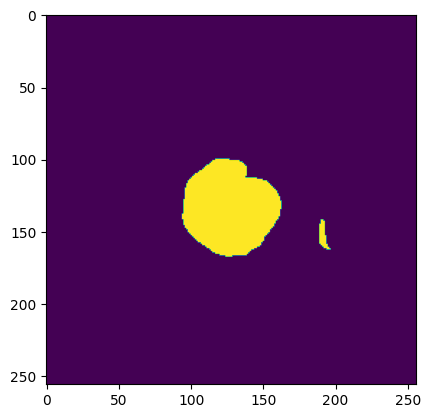

In [ ]:
im = tf.io.read_file('/content/drive/MyDrive/Datascientest/masques/erythroblast/ERB_452425_mask.png')
### Dans le cas des masques, l'image est en noir et blanc, il n'y a donc qu'une valeur par pixel
im = tf.io.decode_jpeg(im, channels=1)
tf.image.resize(im, size=(256,256))
plt.imshow(im)

PRISE DE NOTE

In [ ]:
# Entraînez le modèle
model.fit(images_train, masks_train, epochs=10, batch_size=32, validation_data=(images_test, masks_test))

# Évaluez le modèle
loss, accuracy = model.evaluate(images_test, masks_test)
print("Loss:", loss)
print("Accuracy:", accuracy)